# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


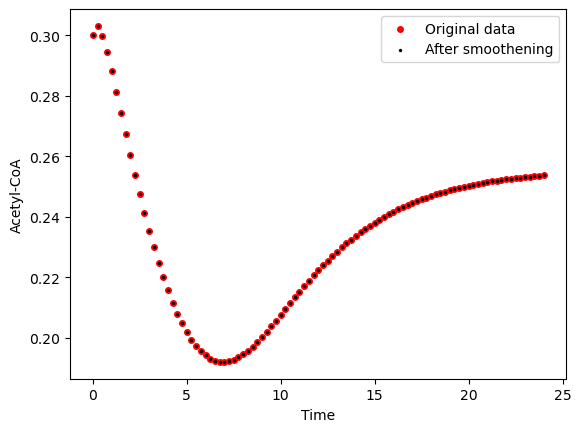

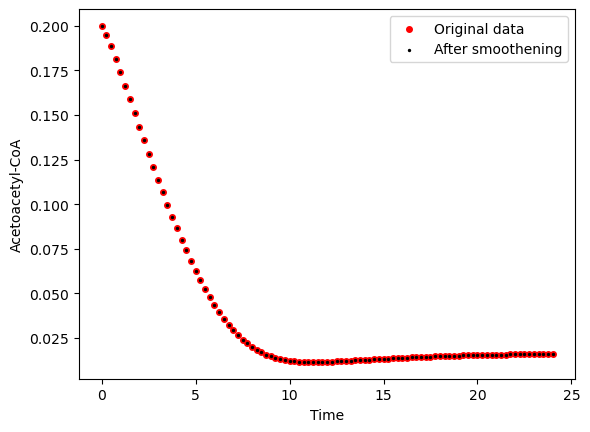

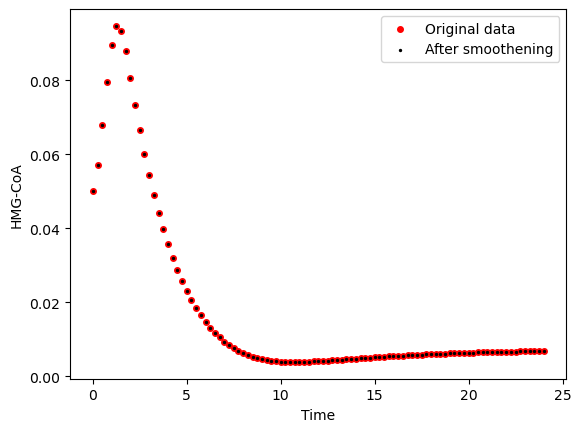

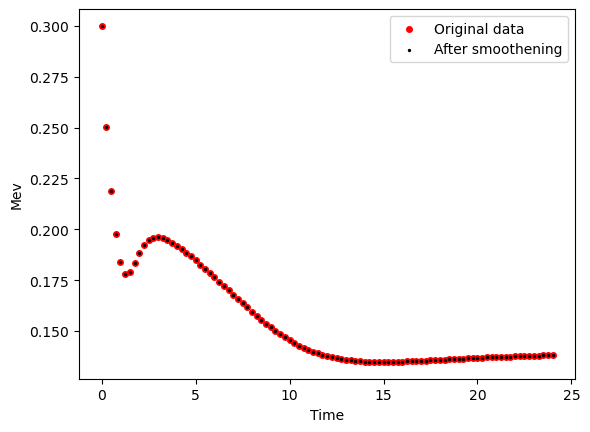

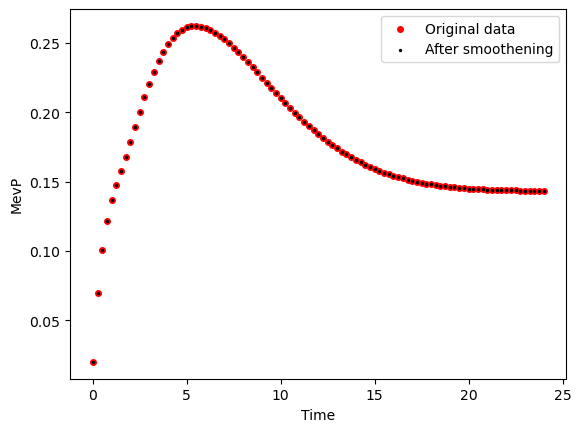

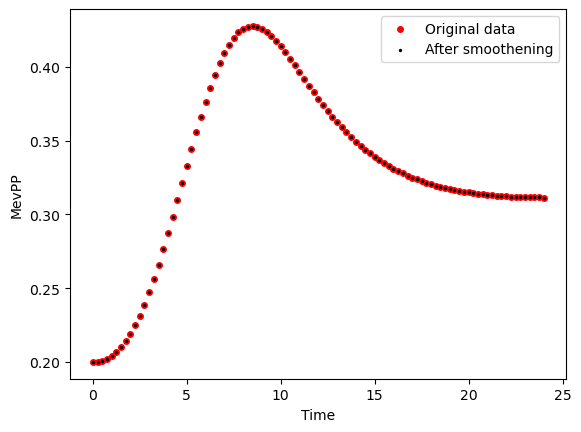

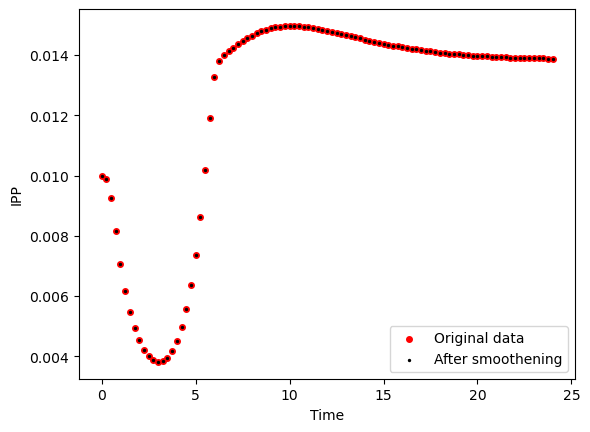

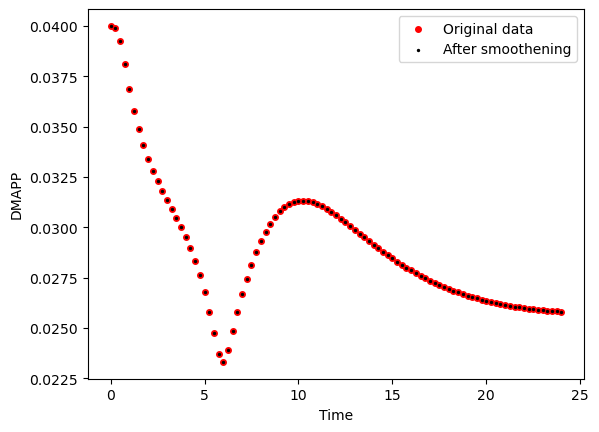

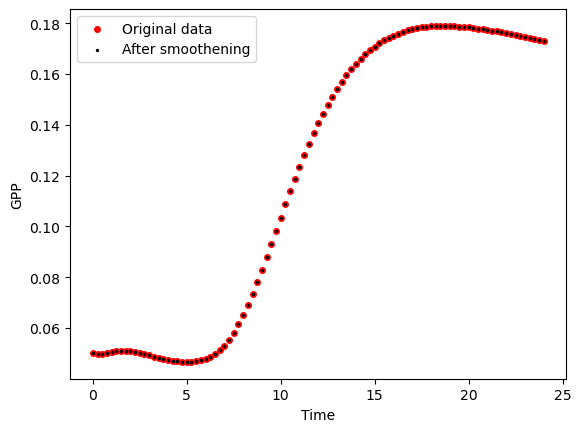

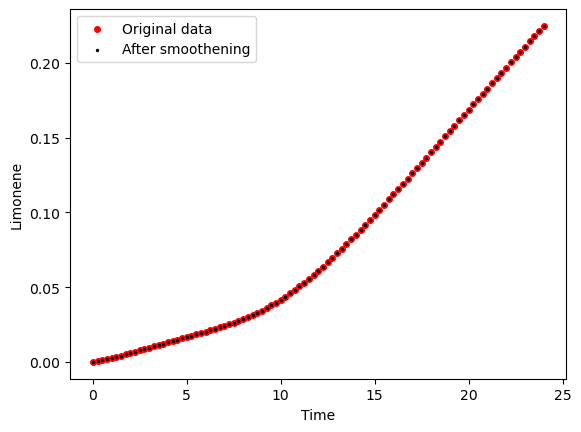

Strain Strain 2


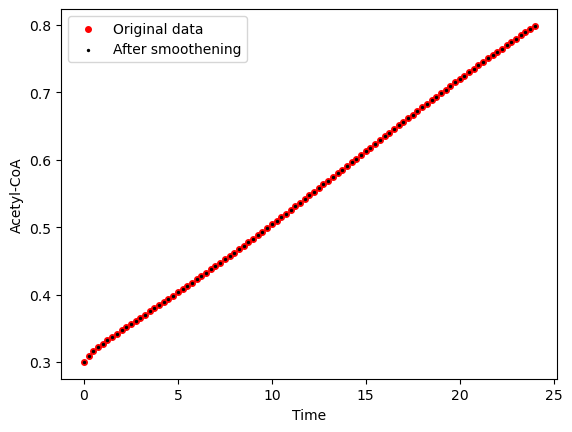

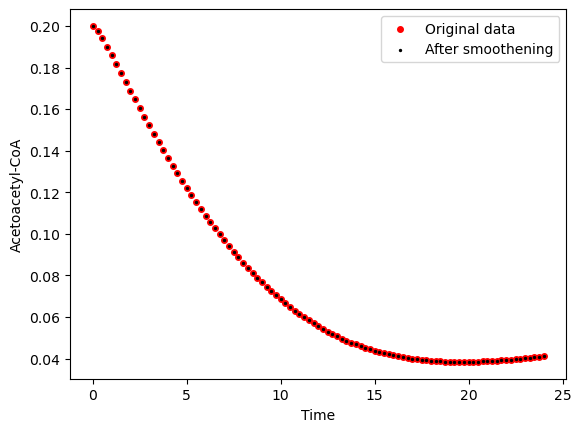

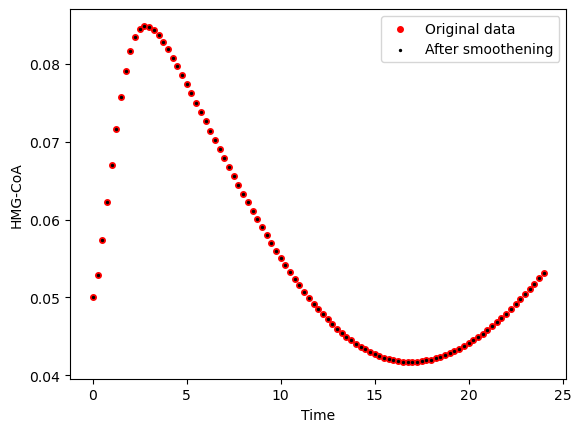

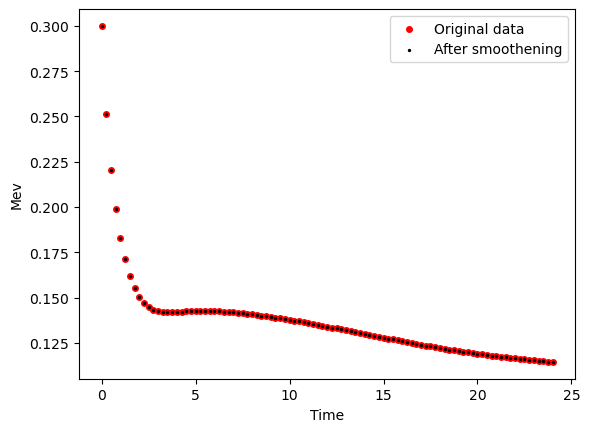

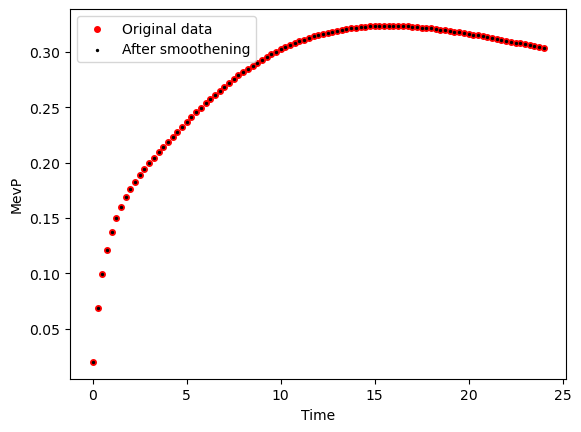

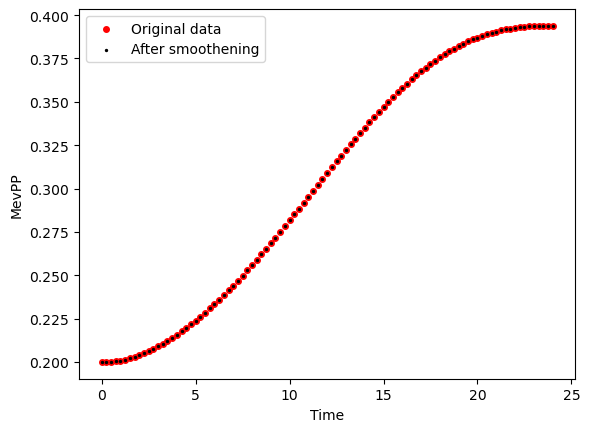

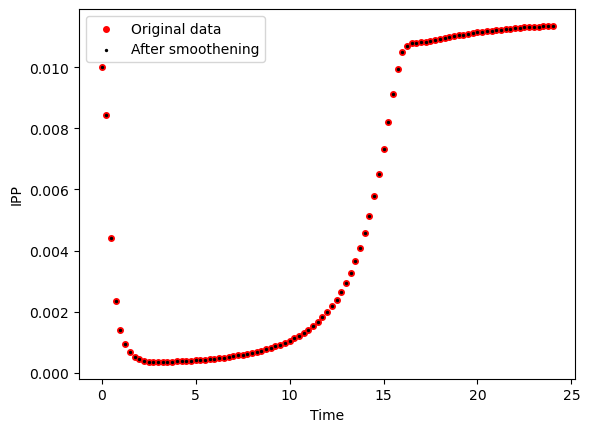

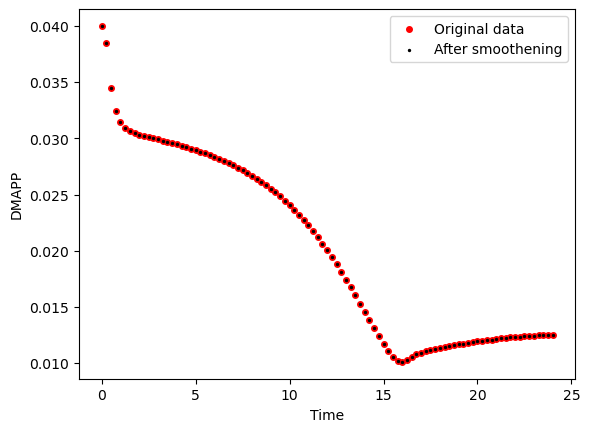

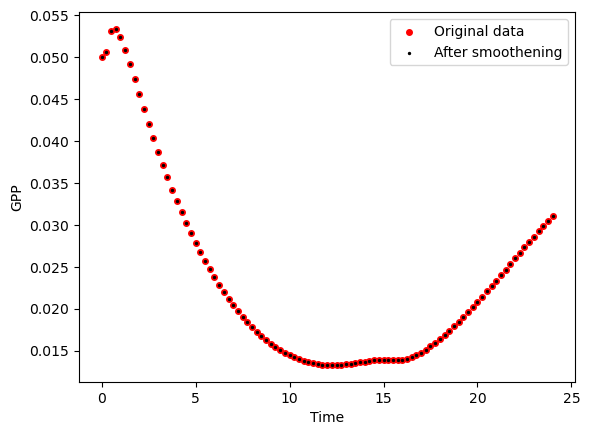

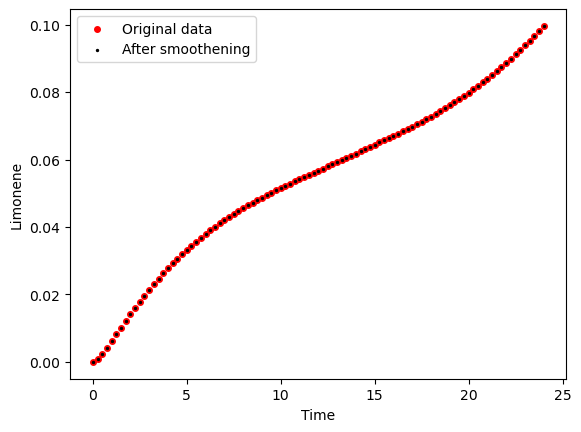

Strain Strain 3


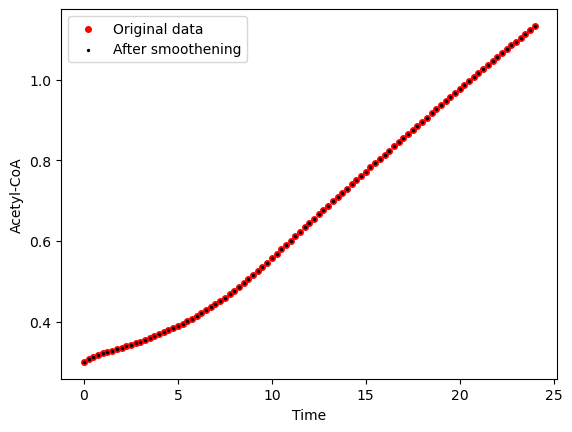

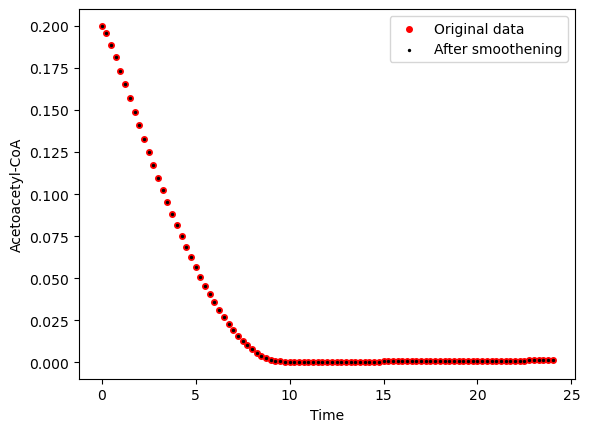

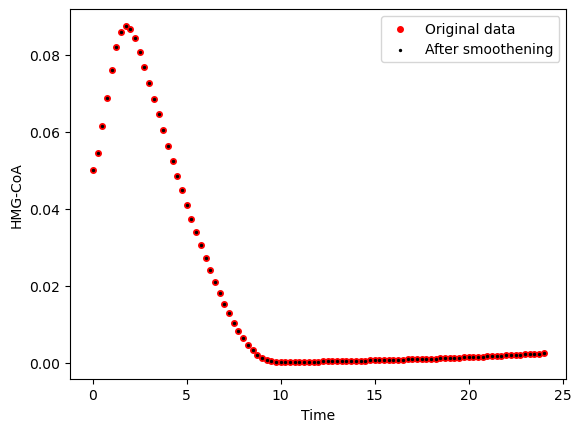

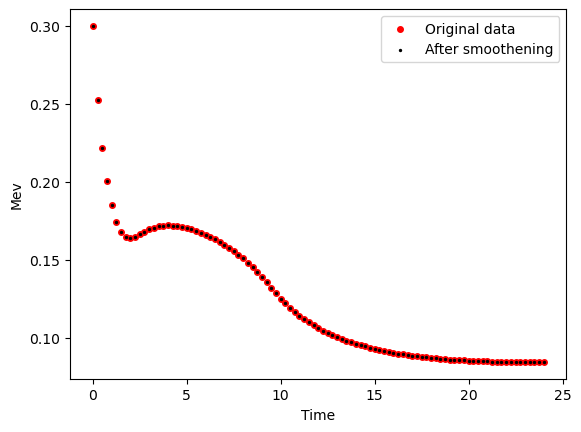

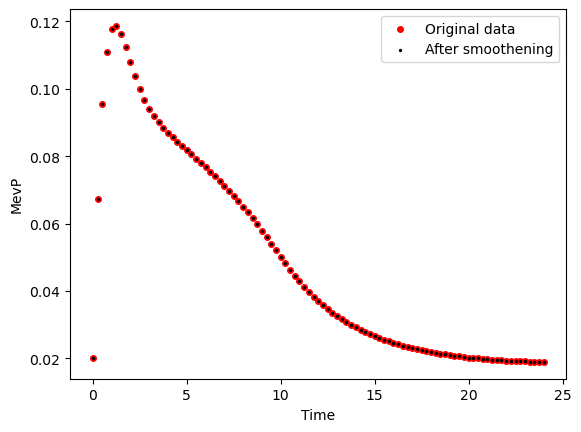

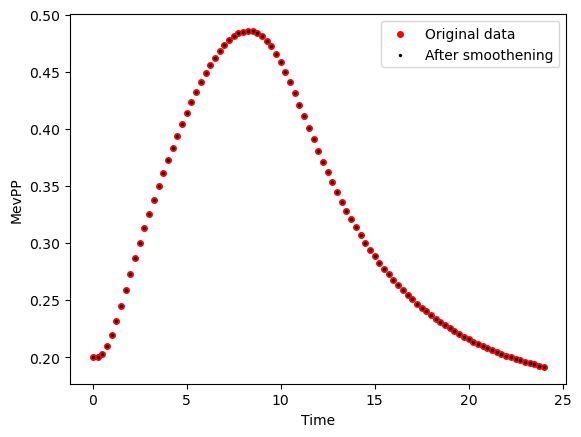

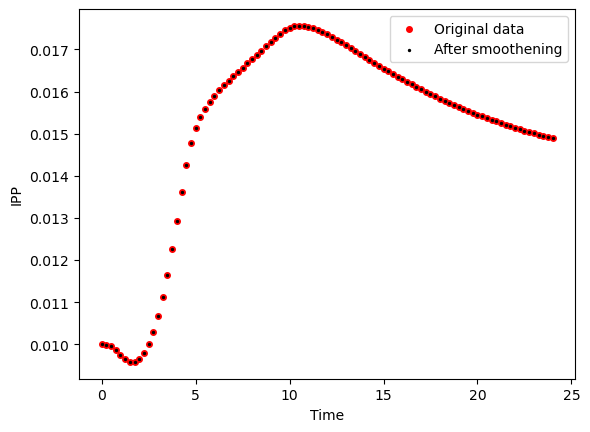

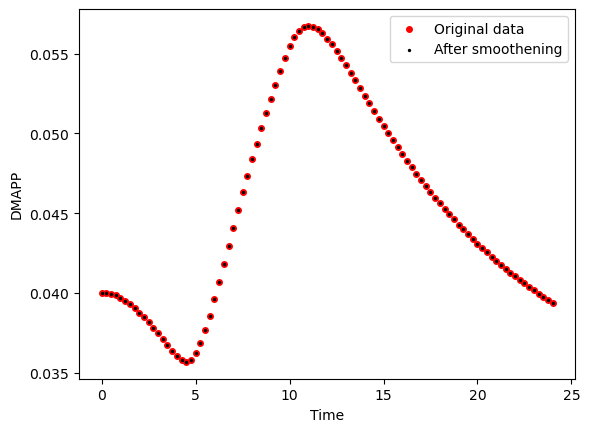

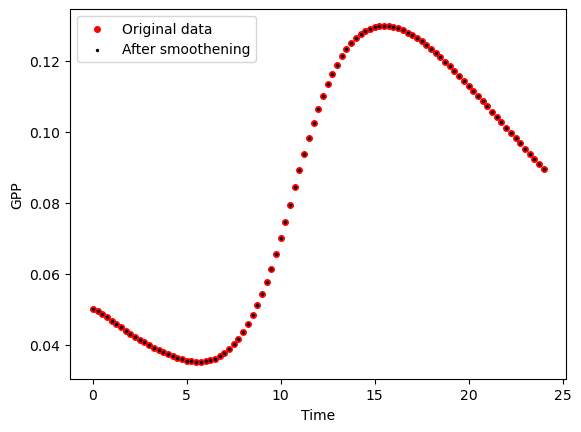

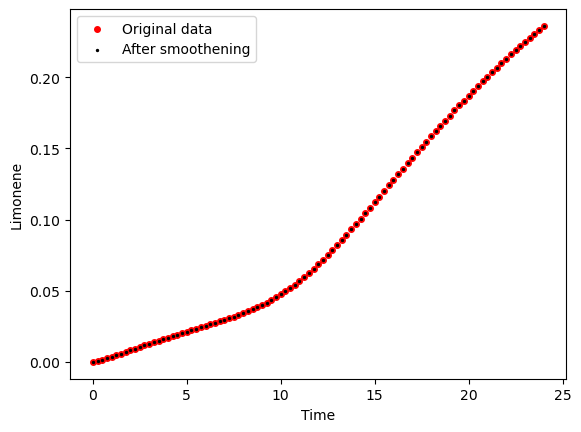

Strain WT


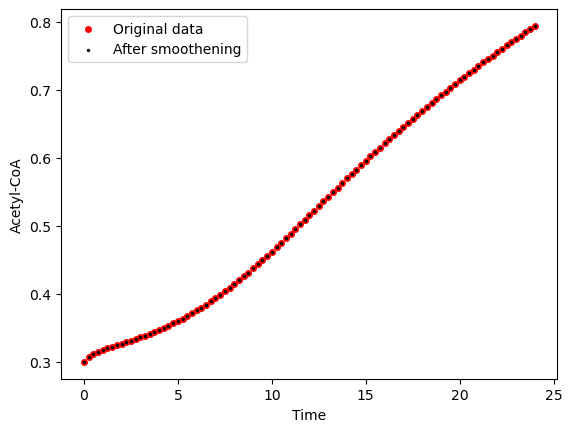

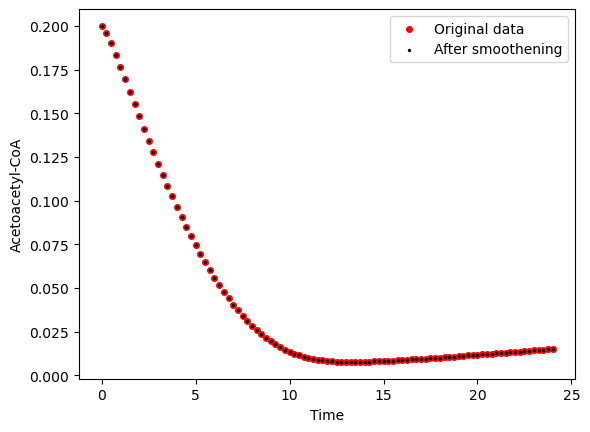

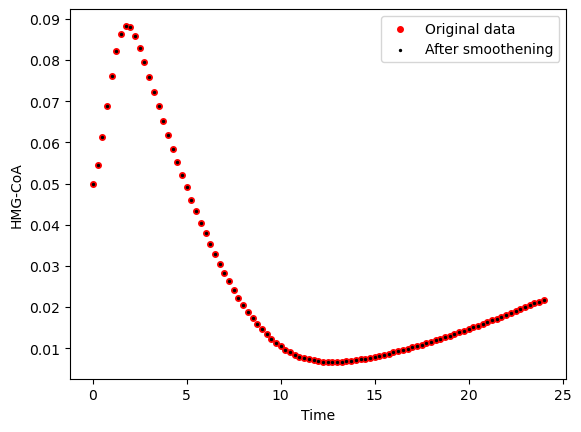

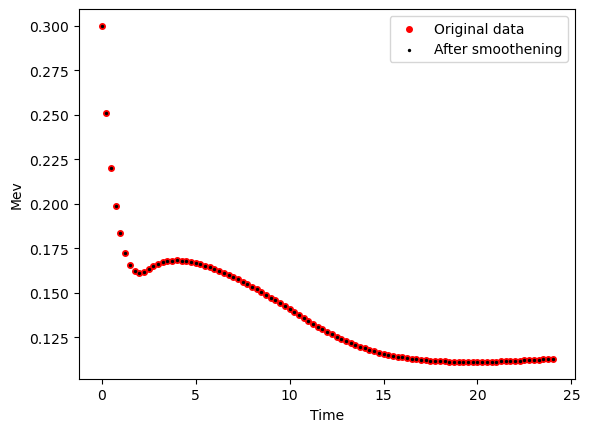

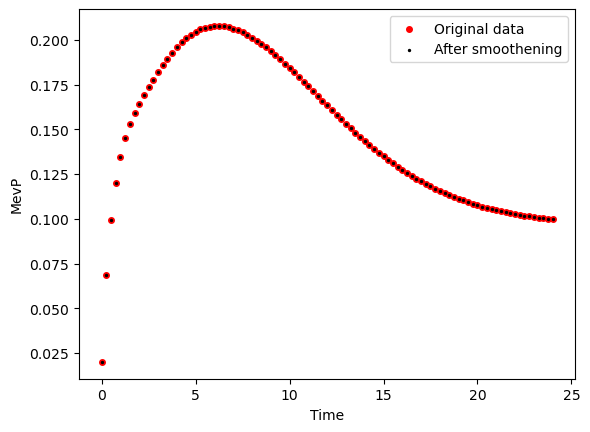

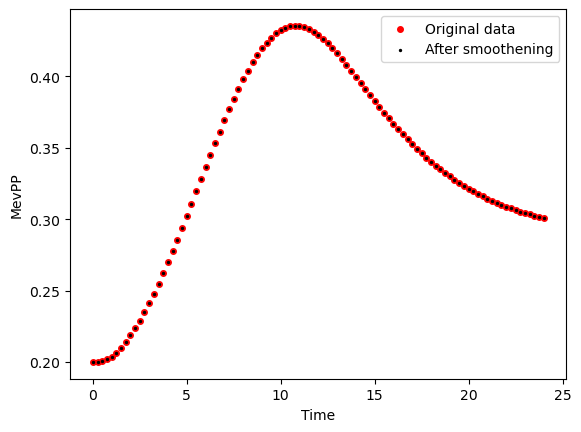

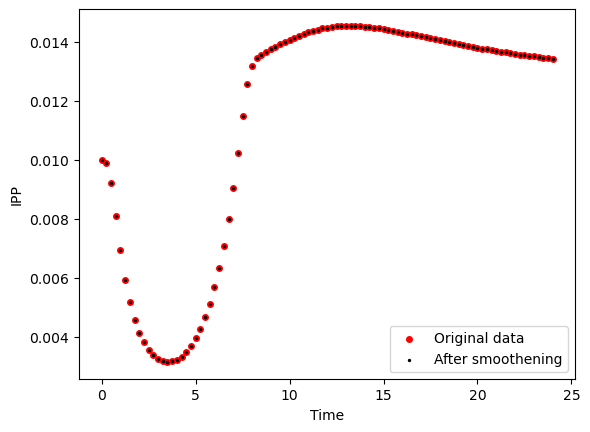

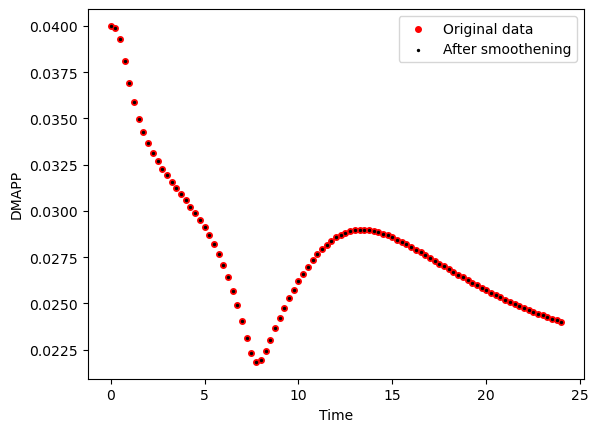

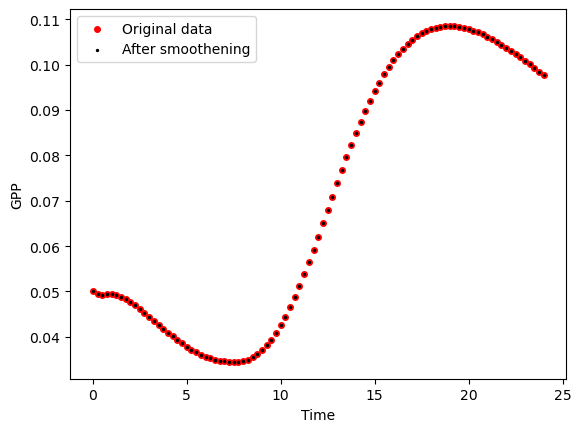

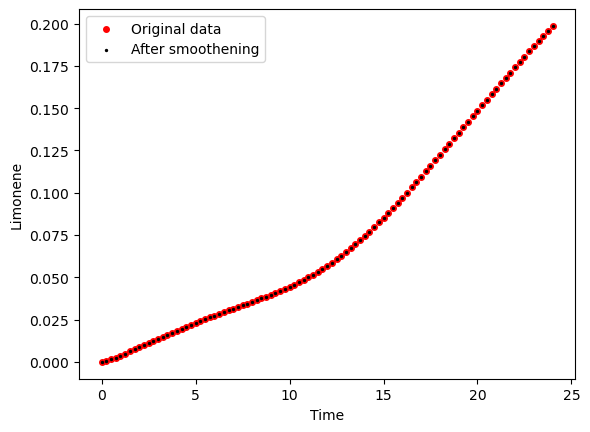

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


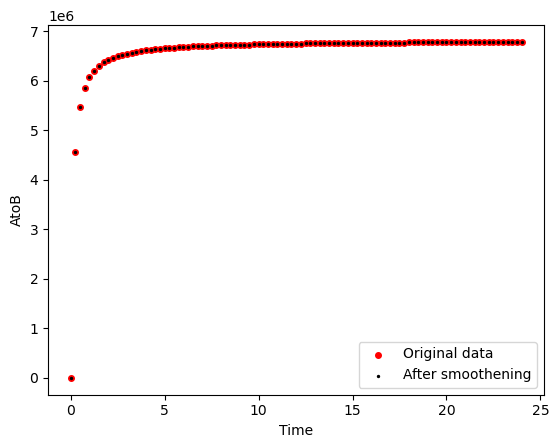

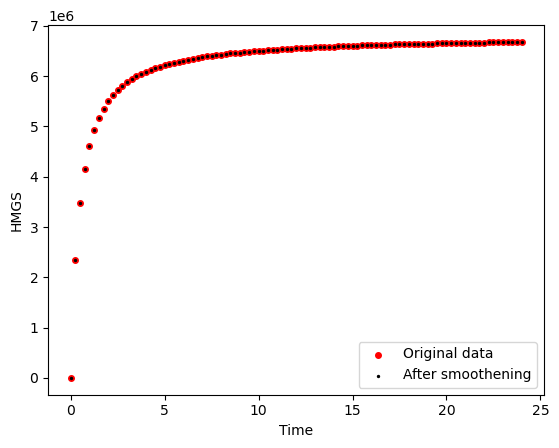

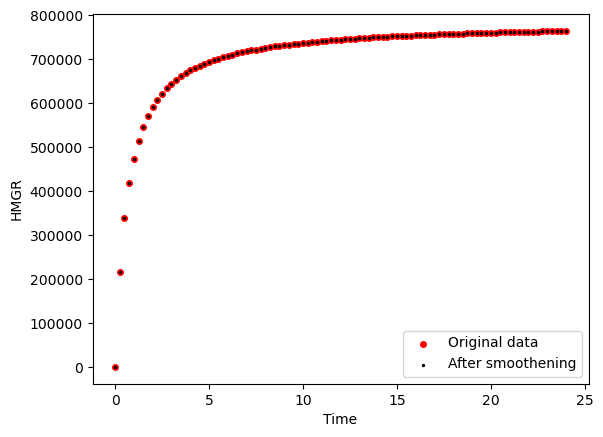

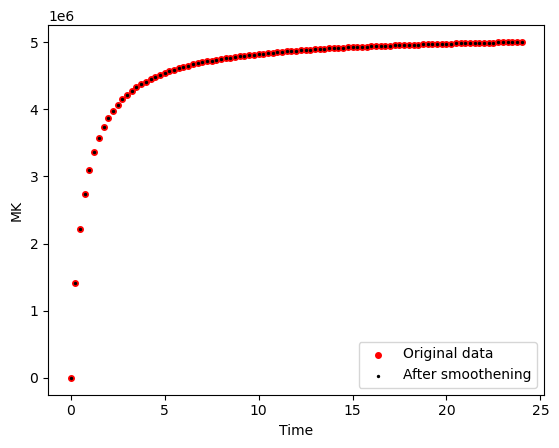

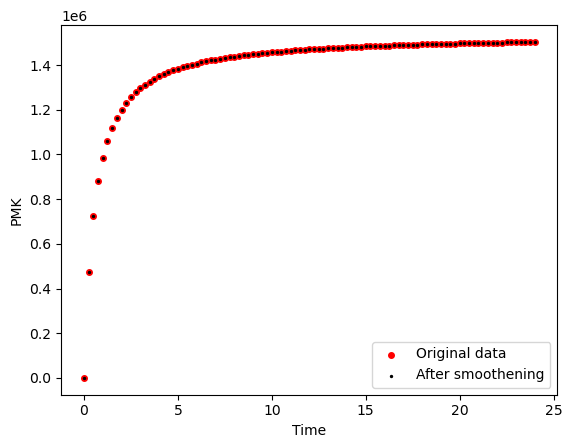

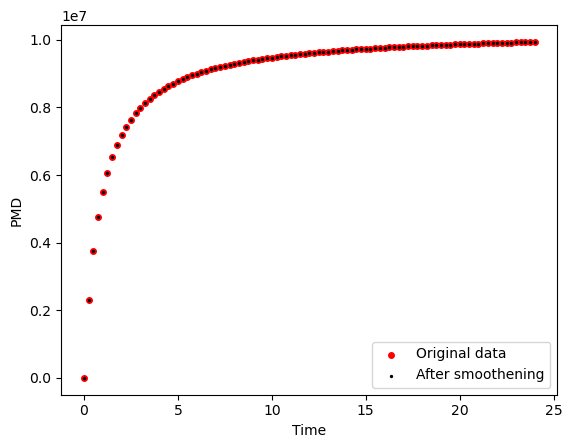

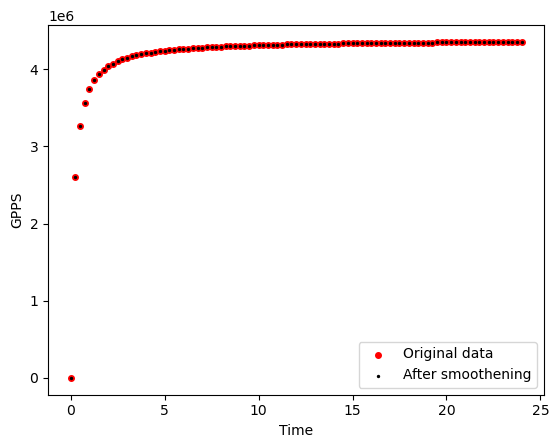

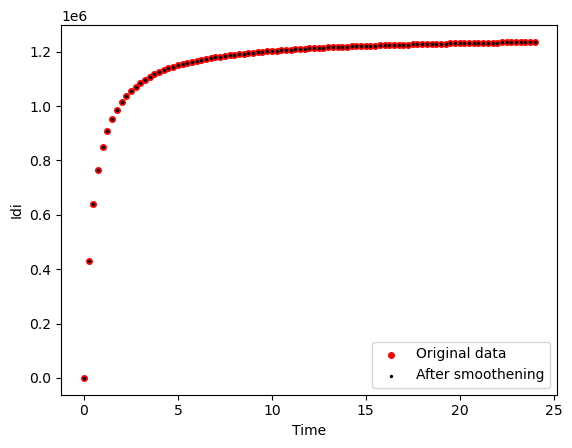

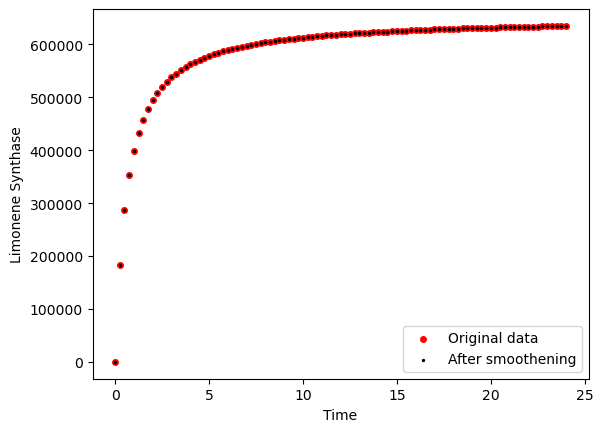

Strain Strain 2


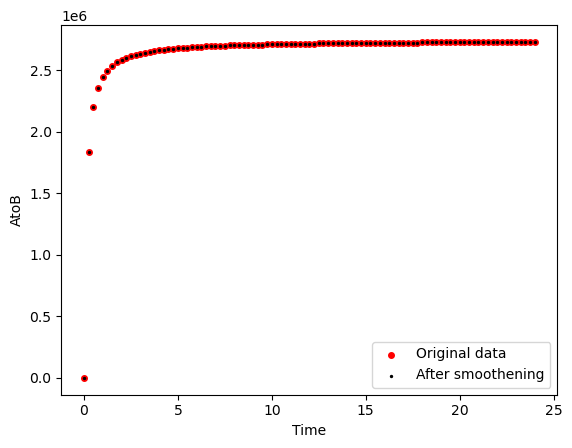

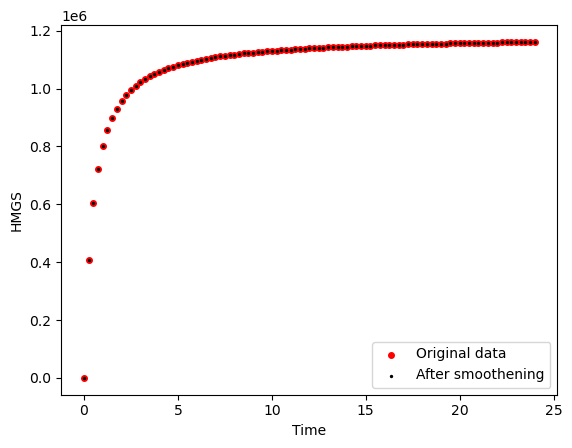

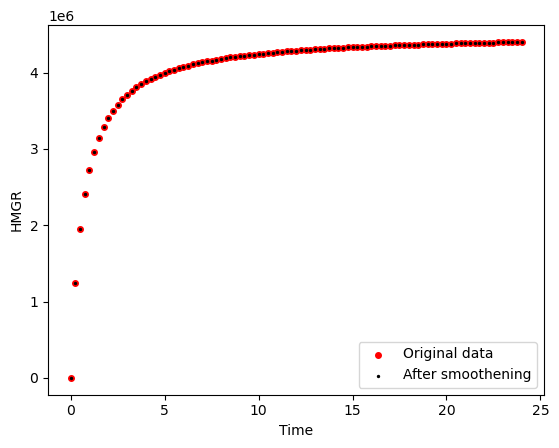

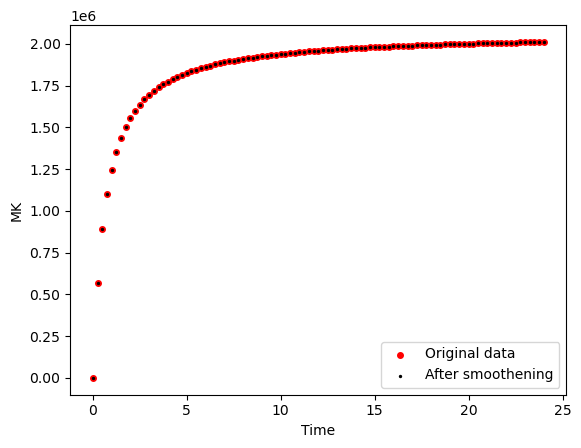

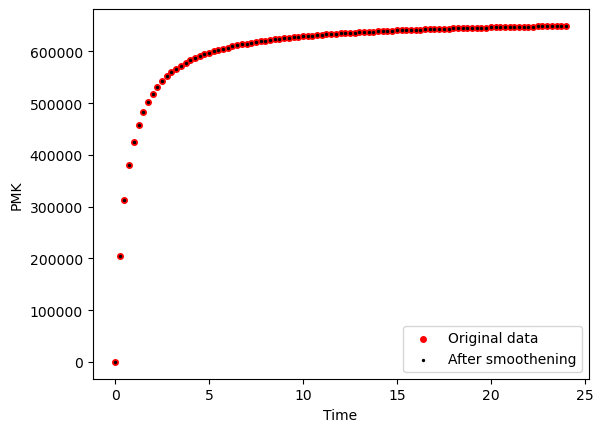

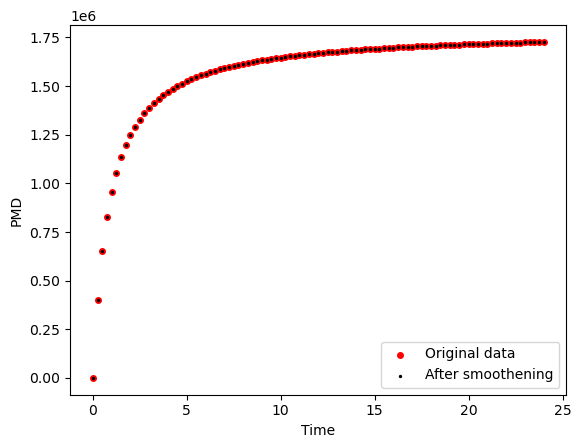

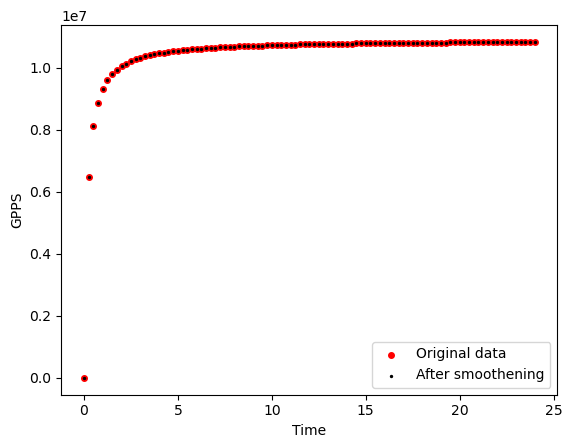

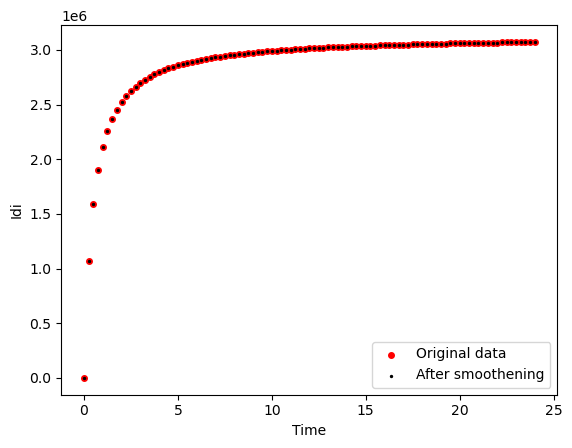

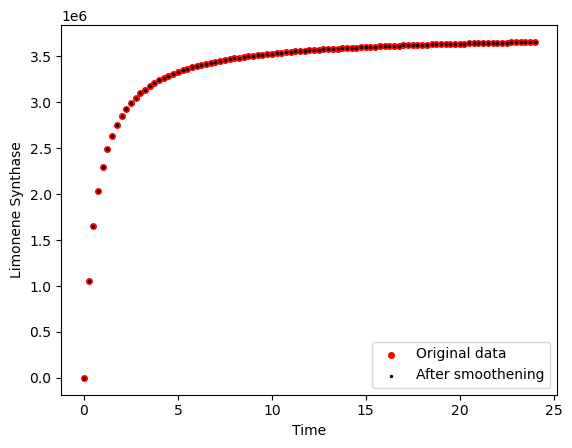

Strain Strain 3


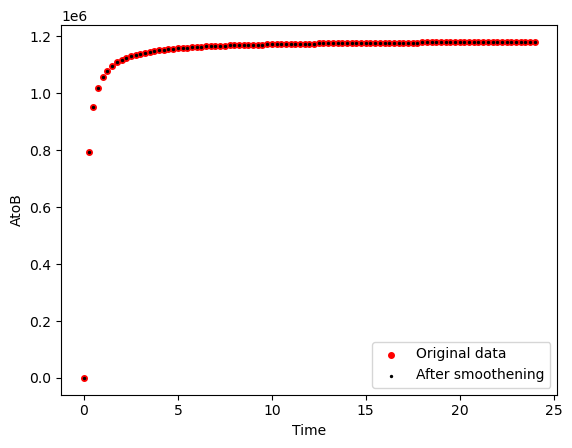

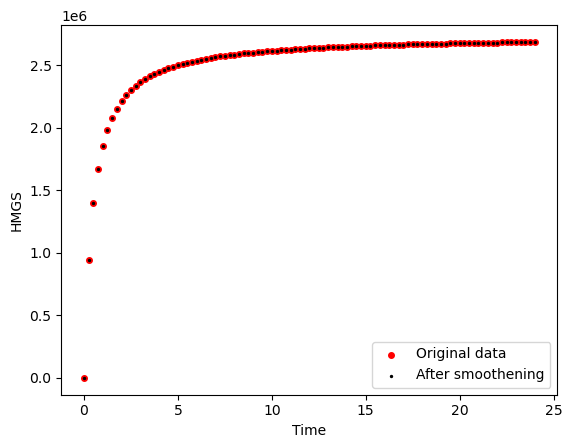

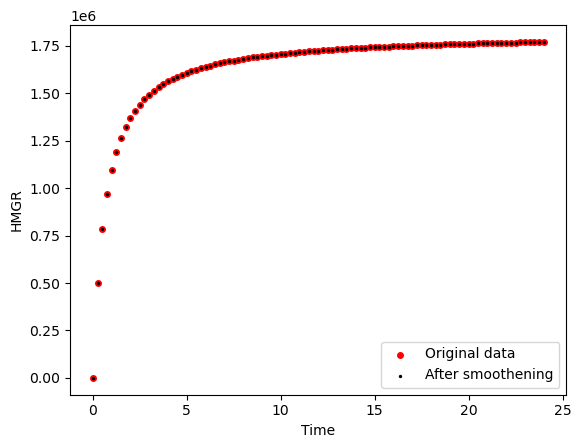

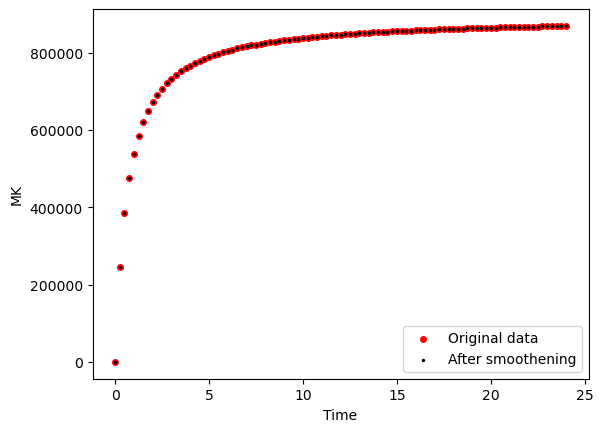

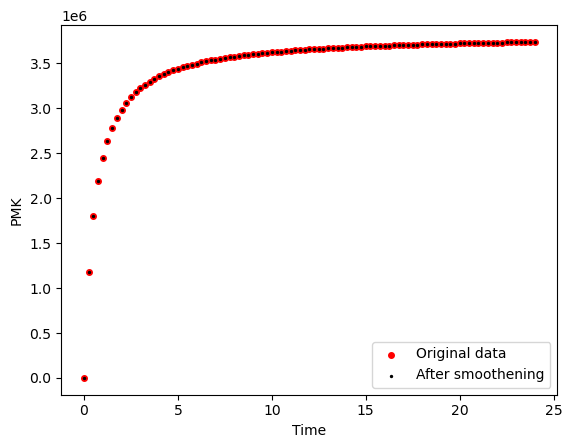

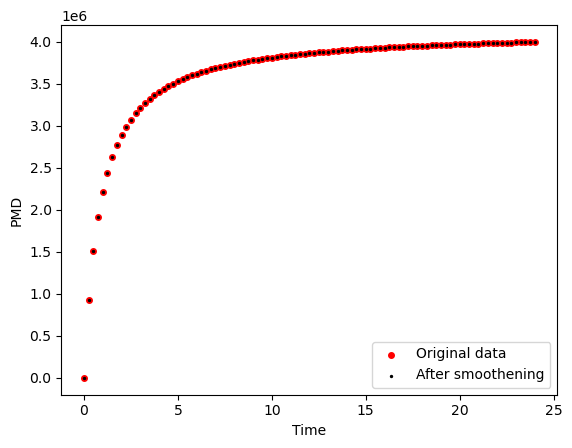

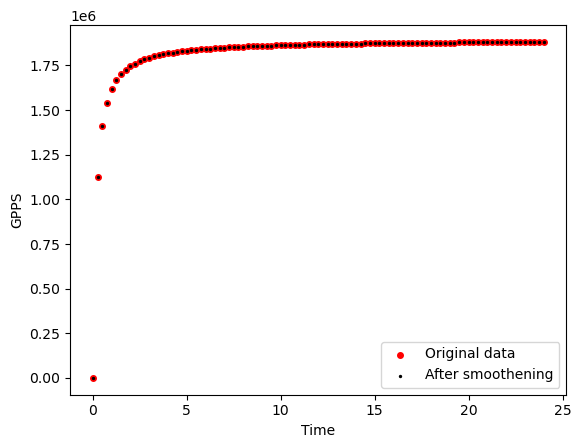

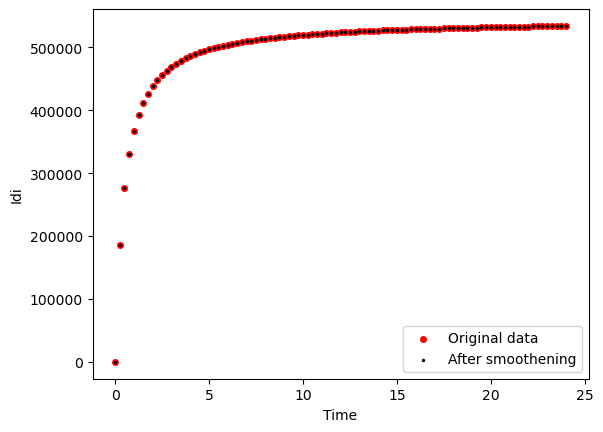

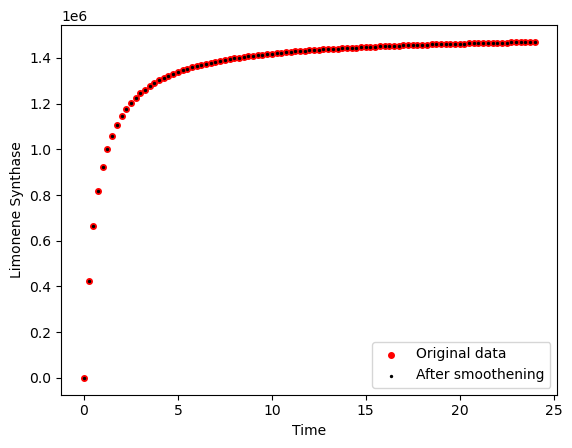

Strain WT


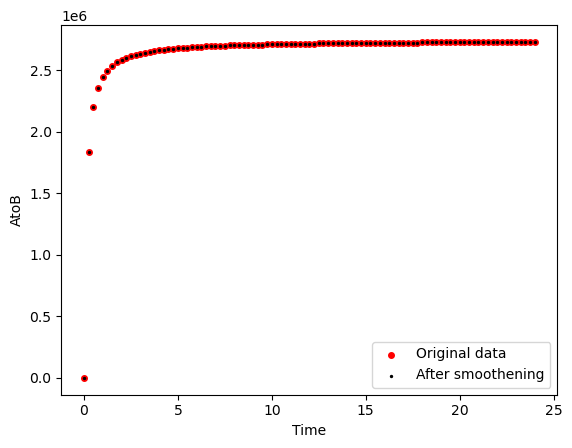

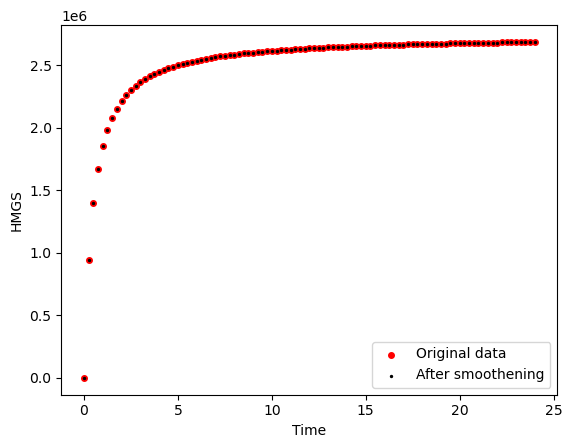

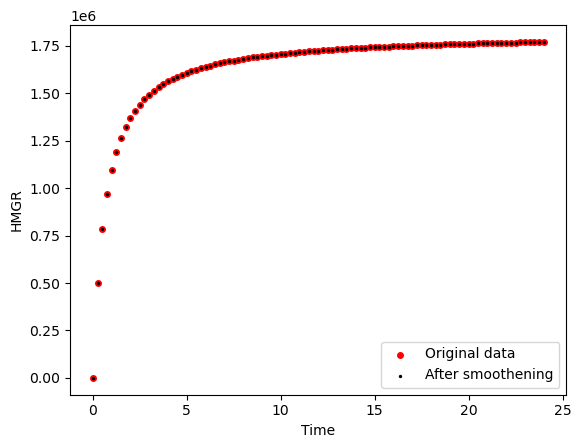

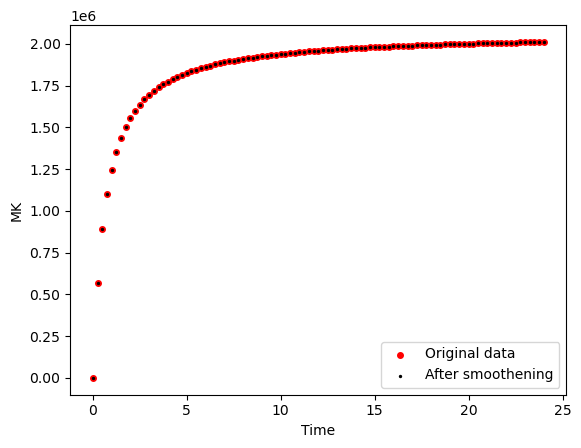

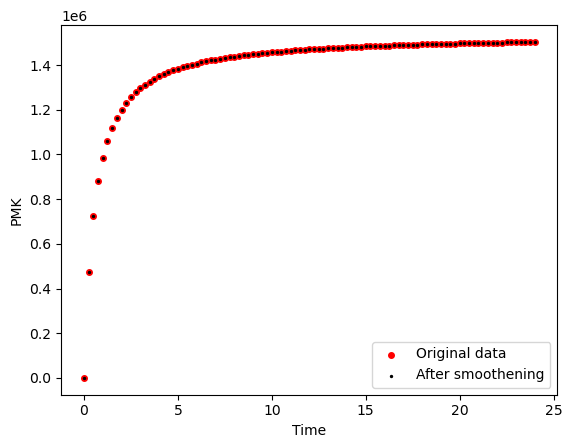

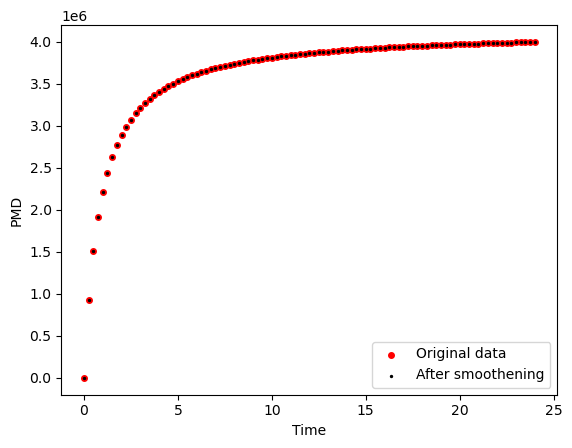

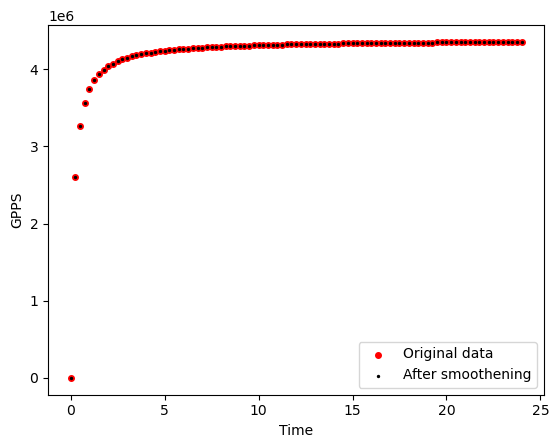

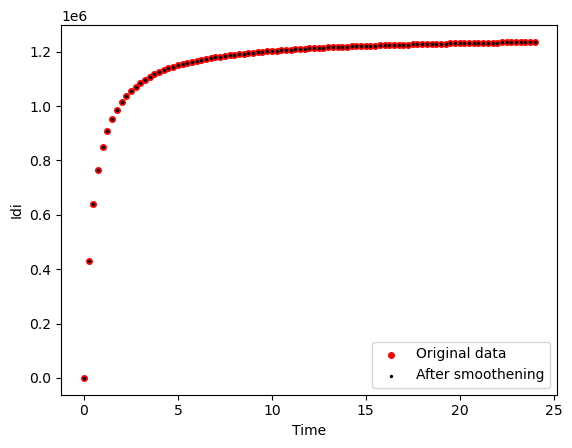

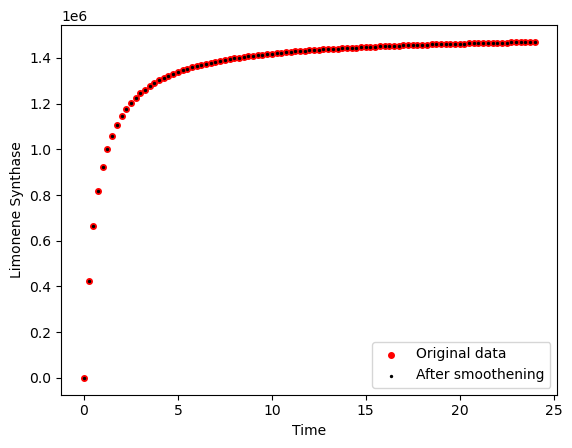

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

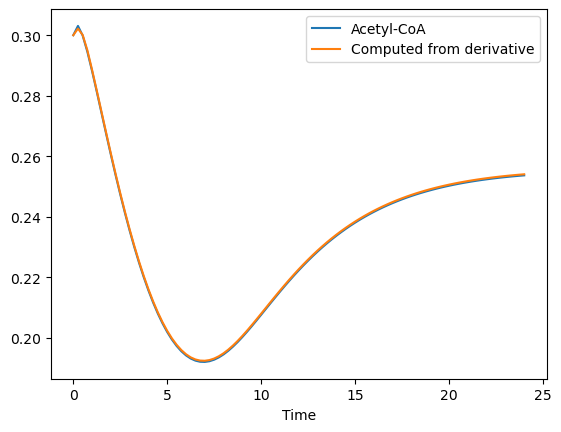

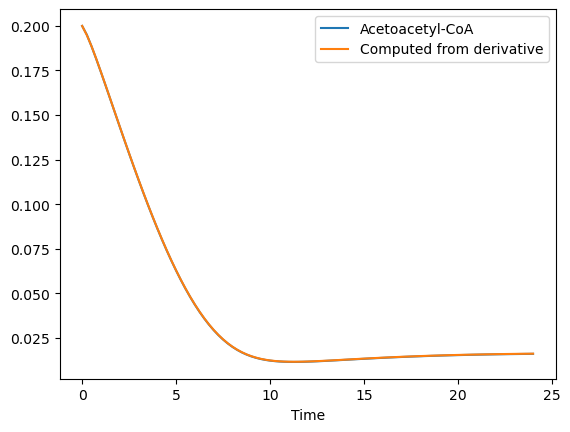

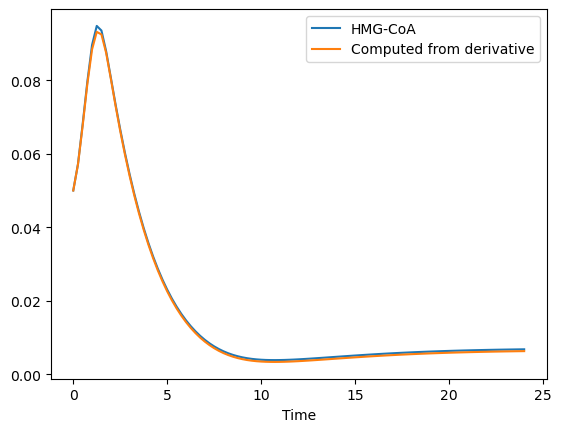

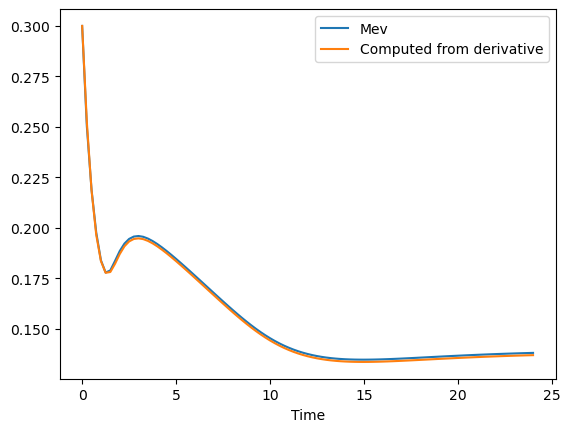

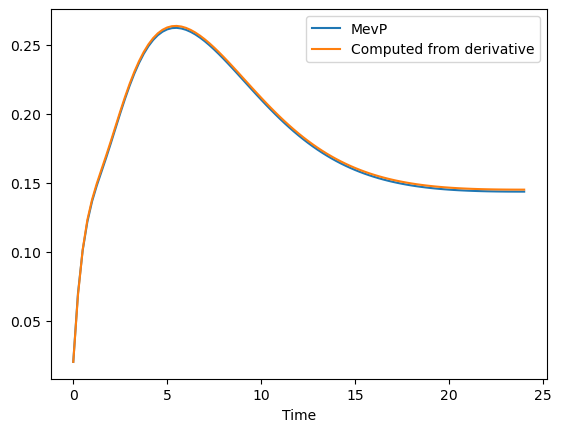

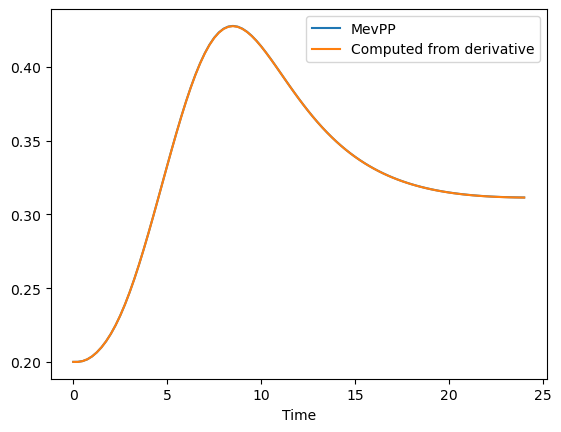

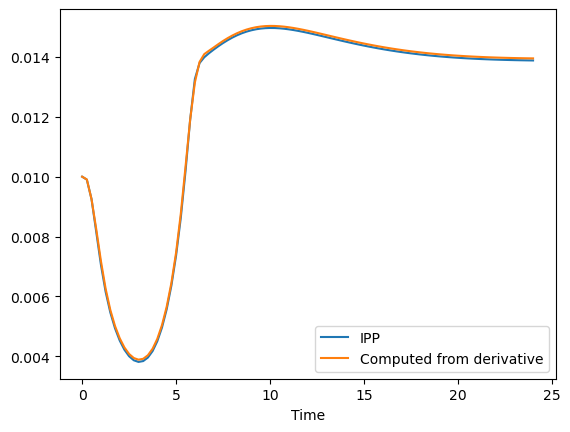

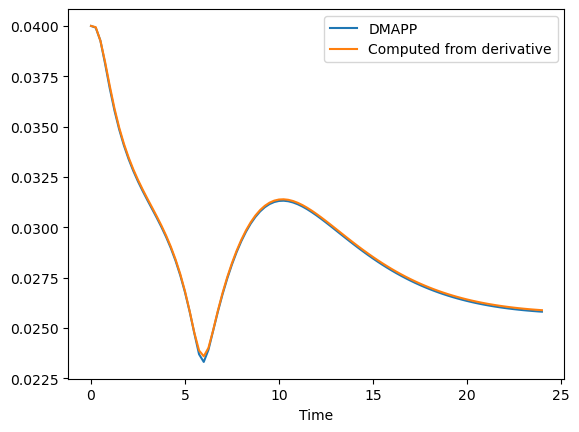

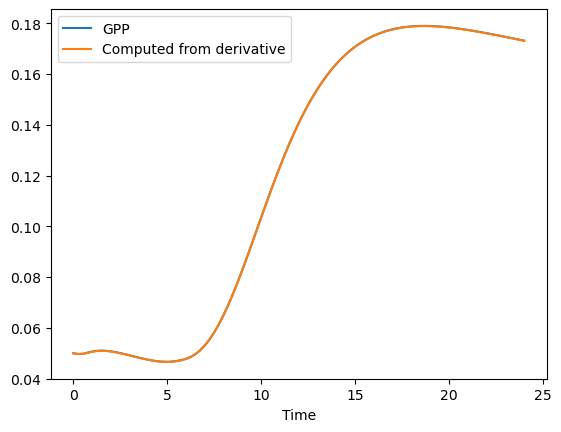

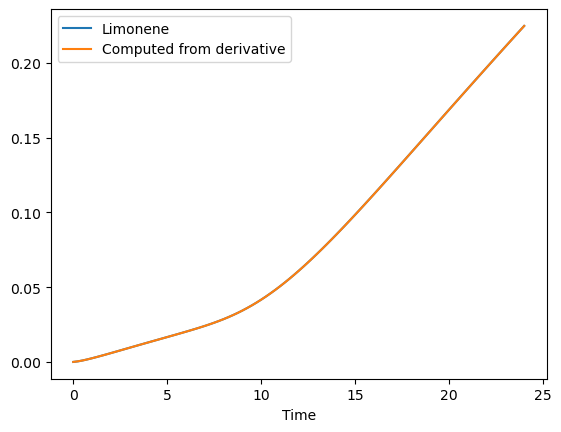

'Time profile from derivative vs. actual profile for Strain 2'

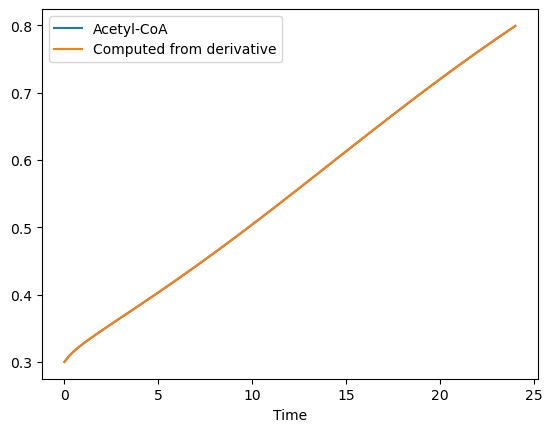

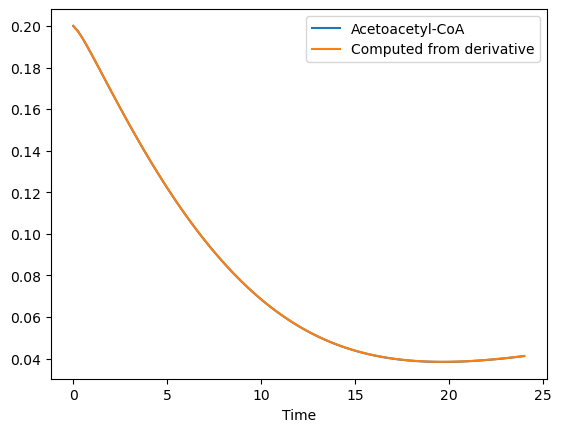

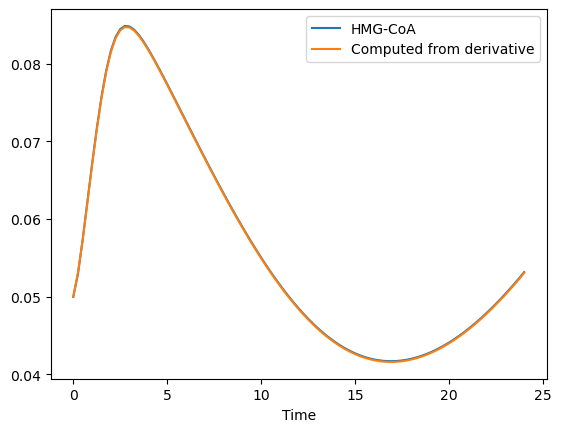

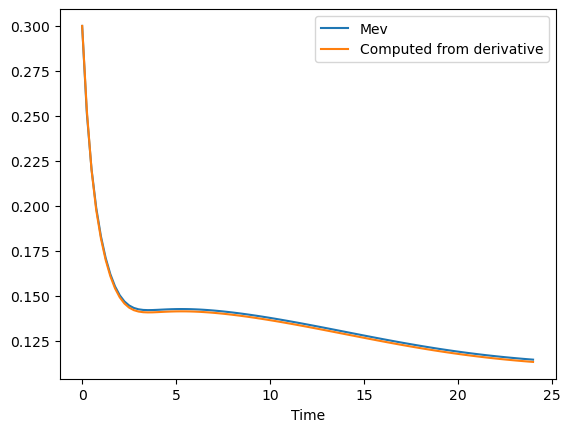

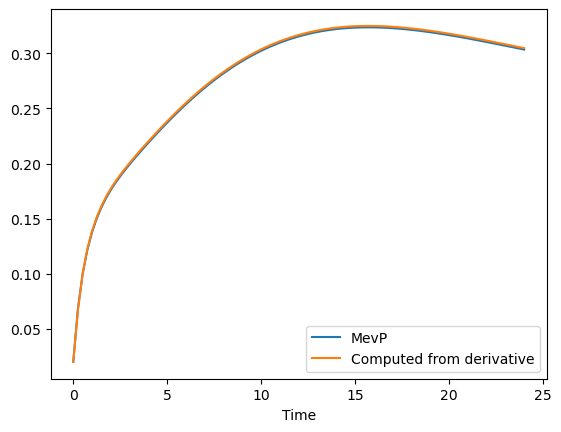

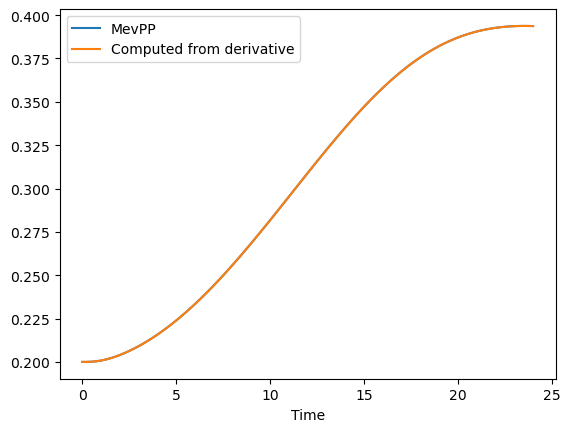

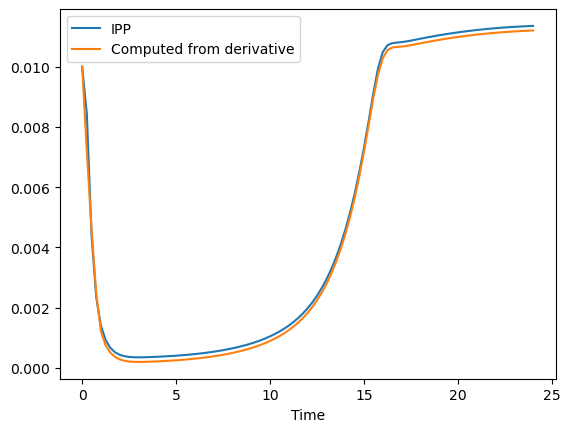

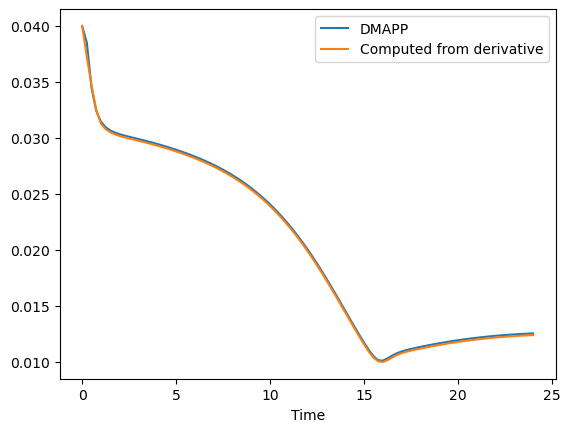

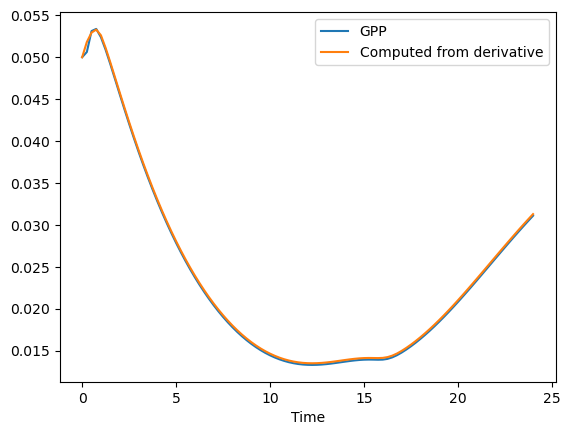

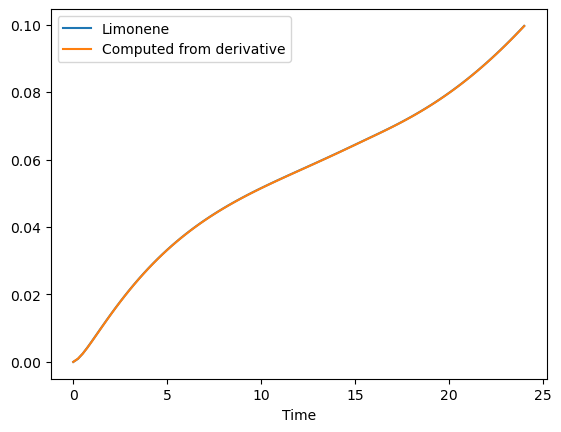

'Time profile from derivative vs. actual profile for Strain 3'

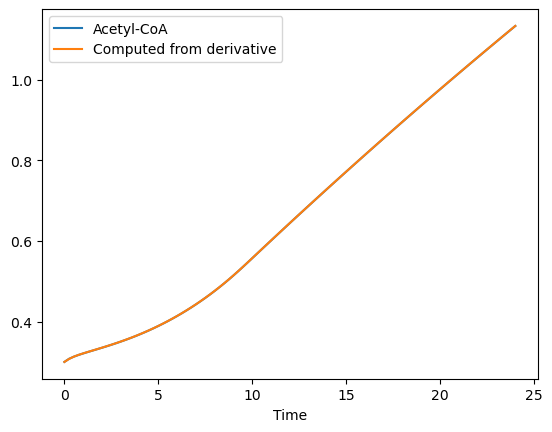

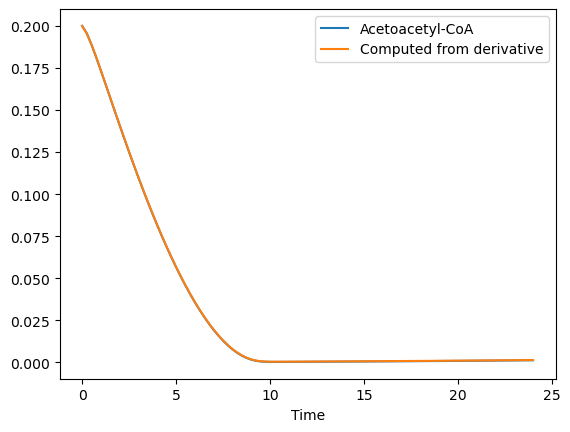

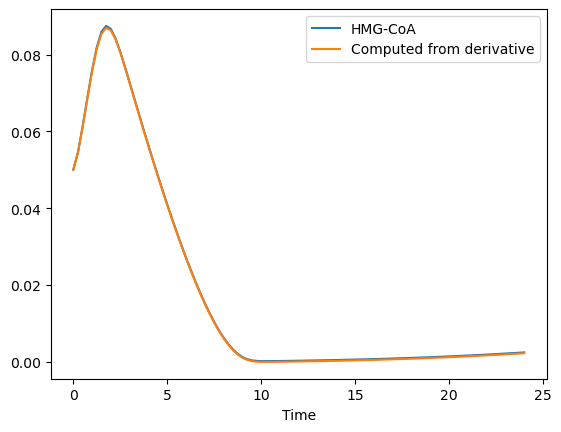

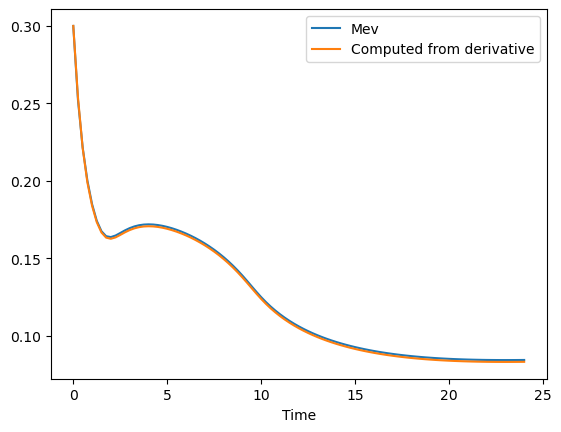

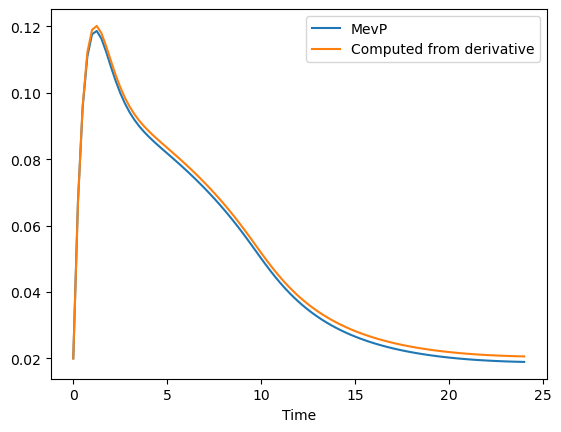

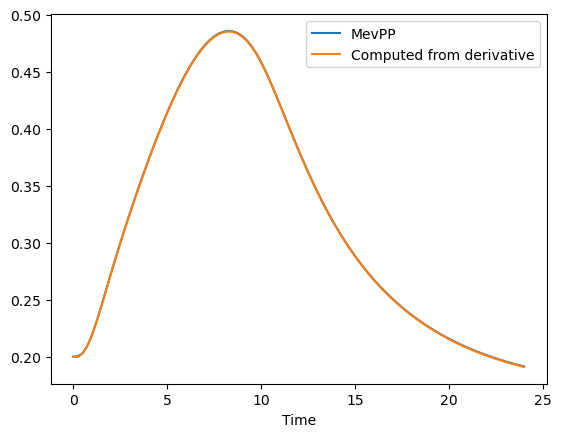

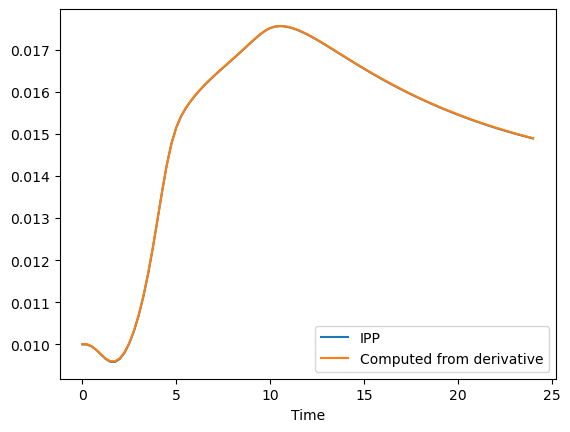

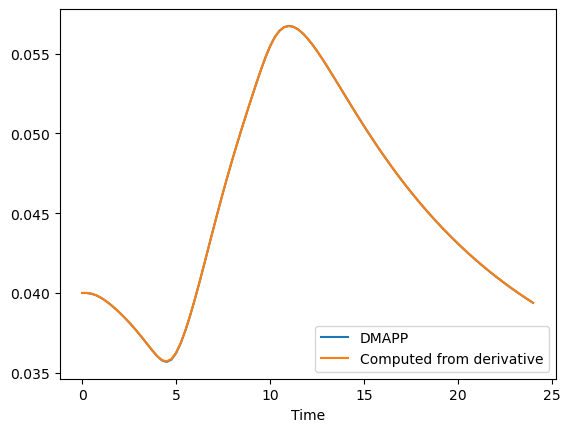

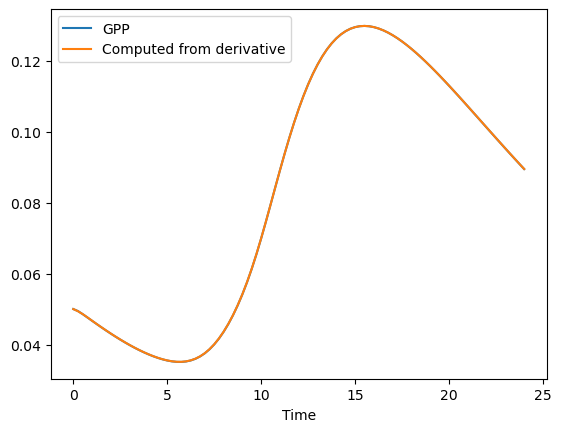

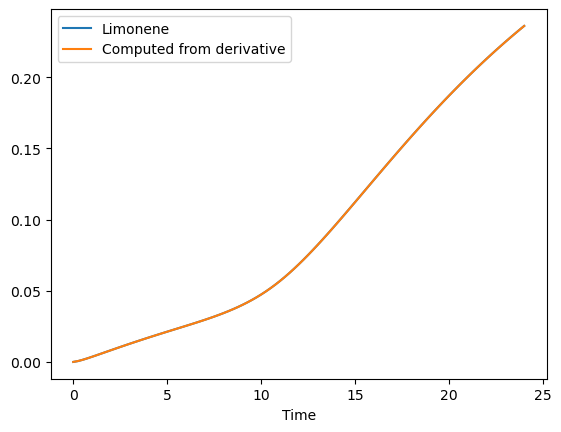

'Time profile from derivative vs. actual profile for WT'

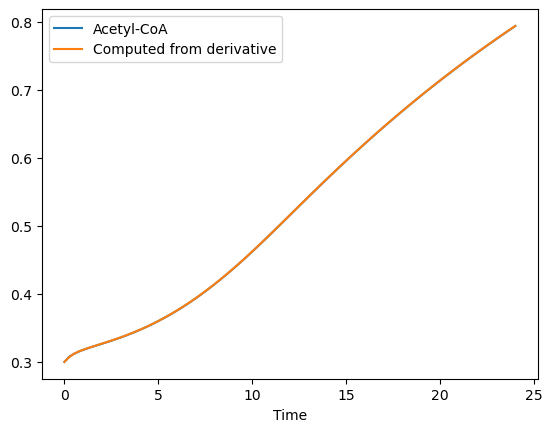

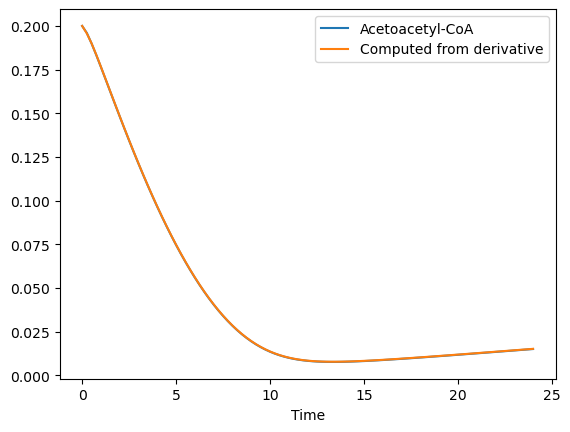

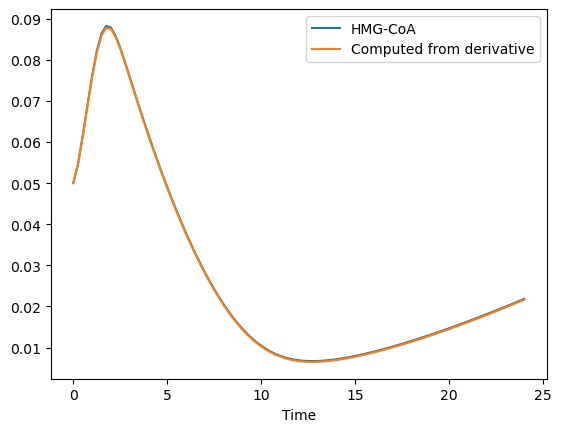

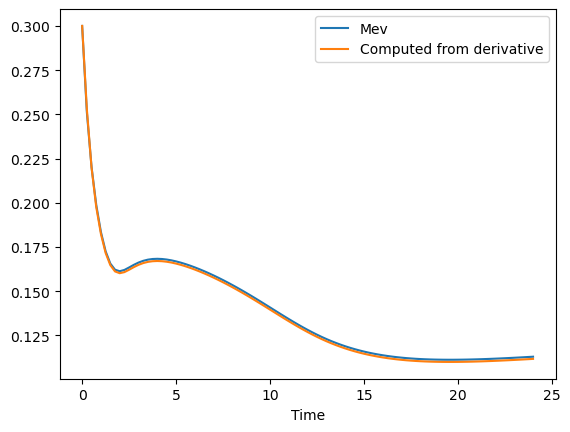

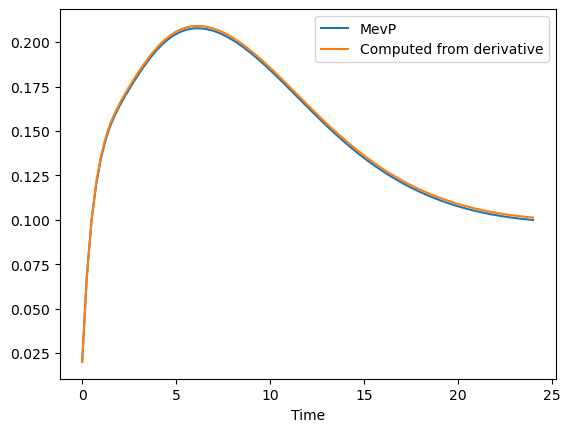

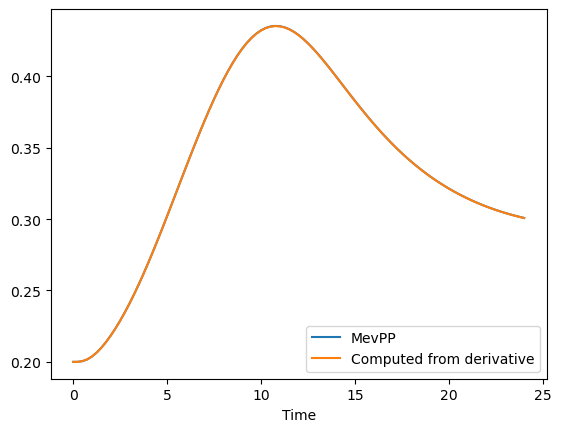

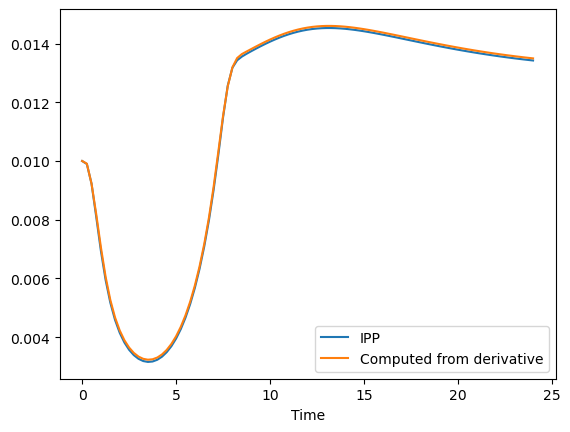

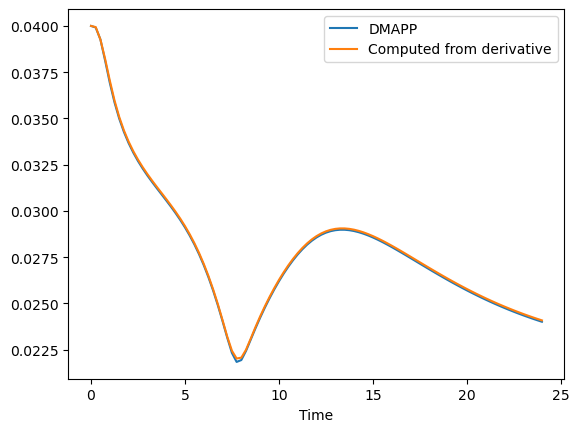

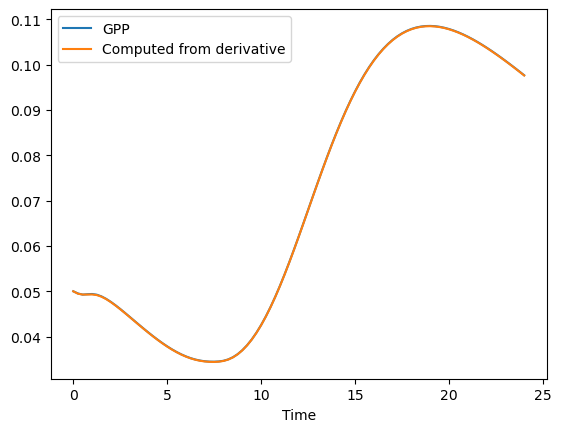

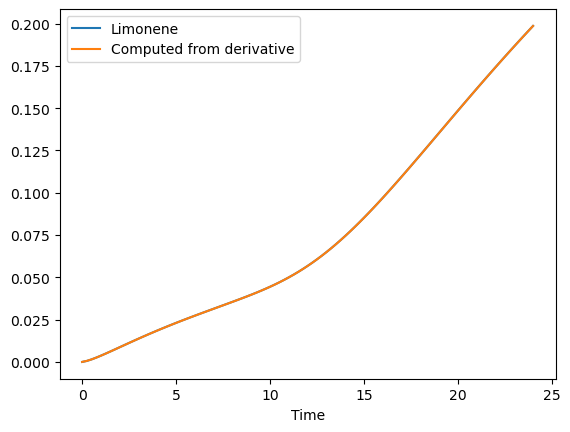

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 1.484832E+189 |  6.679166E+87
     2 |      128 | 1.476559E+189 |  1.394639E+38
     3 |      192 | 2.620825E+177 |  1.530155E+20
     4 |      256 | 1.821211E+138 |  1.526248E+16
     5 |      320 | 1.820204E+138 |  1.667512E+09
     6 |      384 |  7.241606E+66 |  2.060676E+06
     7 |      448 |  2.391014E+18 |  1.066798E+05
     8 |      512 |  1.054013E+12 |  2.451015E+04
     9 |      576 |  6.774750E+06 |  3.074433E+02
    10 |      640 |  2.192896E+05 |  2.664584E+01
    11 |      704 |  7.743980E+02 |  2.149267E+01
    12 |      768 |  1.225383E+02 |  2.126019E+01
    13 |      832 |  2.208284E+01 |  2.125982E+01
    14 |      896 |  2.135712E+01 |  2.123293E+01
    15 |      960 |  2.129015E+01 |  2.121337E+01
    16 |     1024 |  2.124373E+01 |  2.120508E+01
    17 |     1088 |  2.118383E+01 |  2.111291E+01
    18 |     1152 |  2.113518E+01 |  2.110743E+01
    19 |     1216 |  2.11

   162 |    10368 |  1.512642E+01 |  1.512579E+01
   163 |    10432 |  1.512592E+01 |  1.512504E+01
   164 |    10496 |  1.512525E+01 |  1.512450E+01
   165 |    10560 |  1.512455E+01 |  1.512373E+01
   166 |    10624 |  1.512429E+01 |  1.512343E+01
   167 |    10688 |  1.512401E+01 |  1.512326E+01
   168 |    10752 |  1.512368E+01 |  1.512289E+01
   169 |    10816 |  1.512319E+01 |  1.512235E+01
   170 |    10880 |  1.512257E+01 |  1.512173E+01
   171 |    10944 |  1.512194E+01 |  1.512106E+01
   172 |    11008 |  1.512130E+01 |  1.512040E+01
   173 |    11072 |  1.512054E+01 |  1.511973E+01
   174 |    11136 |  1.511974E+01 |  1.511892E+01
   175 |    11200 |  1.511906E+01 |  1.511785E+01
   176 |    11264 |  1.511831E+01 |  1.511738E+01
   177 |    11328 |  1.511777E+01 |  1.511649E+01
   178 |    11392 |  1.511717E+01 |  1.511576E+01
   179 |    11456 |  1.511601E+01 |  1.511422E+01
   180 |    11520 |  1.511463E+01 |  1.511177E+01
   181 |    11584 |  1.511324E+01 |  1.511088E+01


   326 |    20864 |  1.443368E+01 |  1.443292E+01
   327 |    20928 |  1.443309E+01 |  1.443231E+01
   328 |    20992 |  1.443222E+01 |  1.443081E+01
   329 |    21056 |  1.443091E+01 |  1.442959E+01
   330 |    21120 |  1.442948E+01 |  1.442846E+01
   331 |    21184 |  1.442860E+01 |  1.442739E+01
   332 |    21248 |  1.442768E+01 |  1.442625E+01
   333 |    21312 |  1.442630E+01 |  1.442518E+01
   334 |    21376 |  1.442536E+01 |  1.442361E+01
   335 |    21440 |  1.442376E+01 |  1.442151E+01
   336 |    21504 |  1.442223E+01 |  1.442070E+01
   337 |    21568 |  1.442098E+01 |  1.441932E+01
   338 |    21632 |  1.441971E+01 |  1.441849E+01
   339 |    21696 |  1.441889E+01 |  1.441805E+01
   340 |    21760 |  1.441812E+01 |  1.441764E+01
   341 |    21824 |  1.441774E+01 |  1.441731E+01
   342 |    21888 |  1.441723E+01 |  1.441655E+01
   343 |    21952 |  1.441651E+01 |  1.441553E+01
   344 |    22016 |  1.441576E+01 |  1.441455E+01
   345 |    22080 |  1.441440E+01 |  1.441244E+01


   490 |    31360 |  1.282786E+01 |  1.282762E+01
   491 |    31424 |  1.282756E+01 |  1.282705E+01
   492 |    31488 |  1.282706E+01 |  1.282607E+01
   493 |    31552 |  1.282610E+01 |  1.282524E+01
   494 |    31616 |  1.282532E+01 |  1.282402E+01
   495 |    31680 |  1.282393E+01 |  1.282228E+01
   496 |    31744 |  1.282255E+01 |  1.281994E+01
   497 |    31808 |  1.281932E+01 |  1.281617E+01
   498 |    31872 |  1.281624E+01 |  1.281320E+01
   499 |    31936 |  1.281327E+01 |  1.280984E+01
   500 |    32000 |  1.281026E+01 |  1.280680E+01
   501 |    32064 |  1.280705E+01 |  1.280332E+01
   502 |    32128 |  1.280442E+01 |  1.280053E+01
   503 |    32192 |  1.280207E+01 |  1.279919E+01
   504 |    32256 |  1.280001E+01 |  1.279769E+01
   505 |    32320 |  1.279846E+01 |  1.279602E+01
   506 |    32384 |  1.279622E+01 |  1.279433E+01
   507 |    32448 |  1.279427E+01 |  1.279231E+01
   508 |    32512 |  1.279259E+01 |  1.279047E+01
   509 |    32576 |  1.279045E+01 |  1.278919E+01


   654 |    41856 |  1.255534E+01 |  1.255490E+01
   655 |    41920 |  1.255506E+01 |  1.255463E+01
   656 |    41984 |  1.255472E+01 |  1.255430E+01
   657 |    42048 |  1.255434E+01 |  1.255389E+01
   658 |    42112 |  1.255409E+01 |  1.255378E+01
   659 |    42176 |  1.255385E+01 |  1.255363E+01
   660 |    42240 |  1.255365E+01 |  1.255351E+01
   661 |    42304 |  1.255353E+01 |  1.255341E+01
   662 |    42368 |  1.255341E+01 |  1.255333E+01
   663 |    42432 |  1.255334E+01 |  1.255327E+01
   664 |    42496 |  1.255329E+01 |  1.255322E+01
   665 |    42560 |  1.255324E+01 |  1.255319E+01
   666 |    42624 |  1.255321E+01 |  1.255318E+01
   667 |    42688 |  1.255319E+01 |  1.255317E+01
   668 |    42752 |  1.255318E+01 |  1.255316E+01
   669 |    42816 |  1.255287E+01 |  1.255261E+01
   670 |    42880 |  1.255269E+01 |  1.255256E+01
   671 |    42944 |  1.255259E+01 |  1.255246E+01
   672 |    43008 |  1.255248E+01 |  1.255233E+01
   673 |    43072 |  1.255169E+01 |  1.255076E+01


   818 |    52352 |  1.244391E+01 |  1.243849E+01
   819 |    52416 |  1.243896E+01 |  1.243312E+01
   820 |    52480 |  1.243274E+01 |  1.242595E+01
   821 |    52544 |  1.242717E+01 |  1.242194E+01
   822 |    52608 |  1.242288E+01 |  1.242037E+01
   823 |    52672 |  1.242109E+01 |  1.241964E+01
   824 |    52736 |  1.242009E+01 |  1.241933E+01
   825 |    52800 |  1.241954E+01 |  1.241901E+01
   826 |    52864 |  1.241903E+01 |  1.241867E+01
   827 |    52928 |  1.241866E+01 |  1.241827E+01
   828 |    52992 |  1.241831E+01 |  1.241785E+01
   829 |    53056 |  1.241780E+01 |  1.241727E+01
   830 |    53120 |  1.241736E+01 |  1.241683E+01
   831 |    53184 |  1.241684E+01 |  1.241618E+01
   832 |    53248 |  1.241629E+01 |  1.241572E+01
   833 |    53312 |  1.241585E+01 |  1.241550E+01
   834 |    53376 |  1.241552E+01 |  1.241522E+01
   835 |    53440 |  1.241529E+01 |  1.241512E+01
   836 |    53504 |  1.241508E+01 |  1.241482E+01
   837 |    53568 |  1.241486E+01 |  1.241462E+01


   982 |    62848 |  1.223059E+01 |  1.222996E+01
   983 |    62912 |  1.223006E+01 |  1.222974E+01
   984 |    62976 |  1.222969E+01 |  1.222938E+01
   985 |    63040 |  1.222938E+01 |  1.222906E+01
   986 |    63104 |  1.222901E+01 |  1.222865E+01
   987 |    63168 |  1.222876E+01 |  1.222842E+01
   988 |    63232 |  1.222846E+01 |  1.222805E+01
   989 |    63296 |  1.222815E+01 |  1.222771E+01
   990 |    63360 |  1.222778E+01 |  1.222745E+01
   991 |    63424 |  1.222750E+01 |  1.222709E+01
   992 |    63488 |  1.222708E+01 |  1.222671E+01
   993 |    63552 |  1.222674E+01 |  1.222635E+01
   994 |    63616 |  1.222624E+01 |  1.222557E+01
   995 |    63680 |  1.222557E+01 |  1.222476E+01
   996 |    63744 |  1.222479E+01 |  1.222366E+01
   997 |    63808 |  1.222398E+01 |  1.222294E+01
   998 |    63872 |  1.222335E+01 |  1.222237E+01
   999 |    63936 |  1.222243E+01 |  1.222118E+01
  1000 |    64000 |  1.222104E+01 |  1.221933E+01
  1001 |    64064 |  1.221941E+01 |  1.221653E+01


  1146 |    73344 |  1.172252E+01 |  1.171647E+01
  1147 |    73408 |  1.171736E+01 |  1.171334E+01
  1148 |    73472 |  1.171391E+01 |  1.171040E+01
  1149 |    73536 |  1.171134E+01 |  1.170953E+01
  1150 |    73600 |  1.170927E+01 |  1.170719E+01
  1151 |    73664 |  1.170742E+01 |  1.170582E+01
  1152 |    73728 |  1.170110E+01 |  1.169198E+01
  1153 |    73792 |  1.169438E+01 |  1.168754E+01
  1154 |    73856 |  1.168837E+01 |  1.168076E+01
  1155 |    73920 |  1.168232E+01 |  1.167640E+01
  1156 |    73984 |  1.167899E+01 |  1.167456E+01
  1157 |    74048 |  1.167461E+01 |  1.167084E+01
  1158 |    74112 |  1.167196E+01 |  1.166910E+01
  1159 |    74176 |  1.166967E+01 |  1.166654E+01
  1160 |    74240 |  1.166783E+01 |  1.166566E+01
  1161 |    74304 |  1.166606E+01 |  1.166504E+01
  1162 |    74368 |  1.166520E+01 |  1.166461E+01
  1163 |    74432 |  1.166444E+01 |  1.166369E+01
  1164 |    74496 |  1.166367E+01 |  1.166295E+01
  1165 |    74560 |  1.166286E+01 |  1.166201E+01


  1310 |    83840 |  1.138738E+01 |  1.138008E+01
  1311 |    83904 |  1.138112E+01 |  1.137425E+01
  1312 |    83968 |  1.137631E+01 |  1.137171E+01
  1313 |    84032 |  1.137351E+01 |  1.137010E+01
  1314 |    84096 |  1.137169E+01 |  1.136834E+01
  1315 |    84160 |  1.136971E+01 |  1.136556E+01
  1316 |    84224 |  1.136653E+01 |  1.136237E+01
  1317 |    84288 |  1.136310E+01 |  1.136035E+01
  1318 |    84352 |  1.136016E+01 |  1.135702E+01
  1319 |    84416 |  1.135682E+01 |  1.135415E+01
  1320 |    84480 |  1.135471E+01 |  1.135216E+01
  1321 |    84544 |  1.135234E+01 |  1.135048E+01
  1322 |    84608 |  1.135039E+01 |  1.134838E+01
  1323 |    84672 |  1.134898E+01 |  1.134753E+01
  1324 |    84736 |  1.134804E+01 |  1.134708E+01
  1325 |    84800 |  1.134730E+01 |  1.134634E+01
  1326 |    84864 |  1.134648E+01 |  1.134567E+01
  1327 |    84928 |  1.134579E+01 |  1.134515E+01
  1328 |    84992 |  1.134504E+01 |  1.134408E+01
  1329 |    85056 |  1.134425E+01 |  1.134312E+01


  1474 |    94336 |  1.086423E+01 |  1.085386E+01
  1475 |    94400 |  1.085589E+01 |  1.084382E+01
  1476 |    94464 |  1.084583E+01 |  1.083301E+01
  1477 |    94528 |  1.083266E+01 |  1.082202E+01
  1478 |    94592 |  1.082159E+01 |  1.081166E+01
  1479 |    94656 |  1.081246E+01 |  1.080508E+01
  1480 |    94720 |  1.080531E+01 |  1.079668E+01
  1481 |    94784 |  1.079724E+01 |  1.078806E+01
  1482 |    94848 |  1.079032E+01 |  1.078374E+01
  1483 |    94912 |  1.078503E+01 |  1.077769E+01
  1484 |    94976 |  1.077821E+01 |  1.077436E+01
  1485 |    95040 |  1.077532E+01 |  1.077211E+01
  1486 |    95104 |  1.077277E+01 |  1.076993E+01
  1487 |    95168 |  1.077066E+01 |  1.076840E+01
  1488 |    95232 |  1.076851E+01 |  1.076629E+01
  1489 |    95296 |  1.076686E+01 |  1.076452E+01
  1490 |    95360 |  1.076489E+01 |  1.076324E+01
  1491 |    95424 |  1.076323E+01 |  1.076090E+01
  1492 |    95488 |  1.075977E+01 |  1.075457E+01
  1493 |    95552 |  1.075411E+01 |  1.074837E+01


  1638 |   104832 |  1.010591E+01 |  1.010444E+01
  1639 |   104896 |  1.010473E+01 |  1.010318E+01
  1640 |   104960 |  1.010342E+01 |  1.010225E+01
  1641 |   105024 |  1.010255E+01 |  1.010159E+01
  1642 |   105088 |  1.010161E+01 |  1.010089E+01
  1643 |   105152 |  1.010079E+01 |  1.010004E+01
  1644 |   105216 |  1.009968E+01 |  1.009849E+01
  1645 |   105280 |  1.009859E+01 |  1.009755E+01
  1646 |   105344 |  1.009773E+01 |  1.009661E+01
  1647 |   105408 |  1.009659E+01 |  1.009527E+01
  1648 |   105472 |  1.009562E+01 |  1.009389E+01
  1649 |   105536 |  1.009439E+01 |  1.009278E+01
  1650 |   105600 |  1.009322E+01 |  1.009114E+01
  1651 |   105664 |  1.009142E+01 |  1.008883E+01
  1652 |   105728 |  1.008892E+01 |  1.008528E+01
  1653 |   105792 |  1.008555E+01 |  1.008263E+01
  1654 |   105856 |  1.008351E+01 |  1.008137E+01
  1655 |   105920 |  1.008173E+01 |  1.007907E+01
  1656 |   105984 |  1.007925E+01 |  1.007633E+01
  1657 |   106048 |  1.007665E+01 |  1.007344E+01


  1802 |   115328 |  9.7717082499 |  9.7705407264
  1803 |   115392 |  9.7706201967 |  9.7693070629
  1804 |   115456 |  9.7695546724 |  9.7678145410
  1805 |   115520 |  9.7679796801 |  9.7663175135
  1806 |   115584 |  9.7660774669 |  9.7635730240
  1807 |   115648 |  9.7634117236 |  9.7597298604
  1808 |   115712 |  9.7600175259 |  9.7563175390
  1809 |   115776 |  9.7568033574 |  9.7533374008
  1810 |   115840 |  9.7533922566 |  9.7470514762
  1811 |   115904 |  9.7475358288 |  9.7403825041
  1812 |   115968 |  9.7405566481 |  9.7340677557
  1813 |   116032 |  9.7350786142 |  9.7294528488
  1814 |   116096 |  9.7303946676 |  9.7264948560
  1815 |   116160 |  9.7278372445 |  9.7227093185
  1816 |   116224 |  9.7238165902 |  9.7192318146
  1817 |   116288 |  9.7200596255 |  9.7169049983
  1818 |   116352 |  9.7167845188 |  9.7137076704
  1819 |   116416 |  9.7141509652 |  9.7118810273
  1820 |   116480 |  9.7116232178 |  9.7095449561
  1821 |   116544 |  9.7096944001 |  9.7079004935


  1966 |   125824 |  9.4176868653 |  9.4116819091
  1967 |   125888 |  9.4131636624 |  9.4078390706
  1968 |   125952 |  9.4071495480 |  9.4014344729
  1969 |   126016 |  9.4028959179 |  9.3988481093
  1970 |   126080 |  9.3980802796 |  9.3915443888
  1971 |   126144 |  9.3915259968 |  9.3840503410
  1972 |   126208 |  9.3849026436 |  9.3744679830
  1973 |   126272 |  9.3760227574 |  9.3672362712
  1974 |   126336 |  9.3668595708 |  9.3567936452
  1975 |   126400 |  9.3572369251 |  9.3476373781
  1976 |   126464 |  9.3494006553 |  9.3389696073
  1977 |   126528 |  9.3405088813 |  9.3305529983
  1978 |   126592 |  9.3291458828 |  9.3194125124
  1979 |   126656 |  9.3208036510 |  9.3102580198
  1980 |   126720 |  9.3108370469 |  9.3013756100
  1981 |   126784 |  9.3028094943 |  9.2950198107
  1982 |   126848 |  9.2954055757 |  9.2870961757
  1983 |   126912 |  9.2901917837 |  9.2850569002
  1984 |   126976 |  9.2854597673 |  9.2785978664
  1985 |   127040 |  9.2788094447 |  9.2698653280


  2130 |   136320 |  9.0346408887 |  9.0340467065
  2131 |   136384 |  9.0341415835 |  9.0336291329
  2132 |   136448 |  9.0337433367 |  9.0332321670
  2133 |   136512 |  9.0333201589 |  9.0326199536
  2134 |   136576 |  9.0327724945 |  9.0322005583
  2135 |   136640 |  9.0321710301 |  9.0317397707
  2136 |   136704 |  9.0317903778 |  9.0313830086
  2137 |   136768 |  9.0313430555 |  9.0308049981
  2138 |   136832 |  9.0309038272 |  9.0302386886
  2139 |   136896 |  9.0303172318 |  9.0295008808
  2140 |   136960 |  9.0295185682 |  9.0286270945
  2141 |   137024 |  9.0286511060 |  9.0275349938
  2142 |   137088 |  9.0277635196 |  9.0270086428
  2143 |   137152 |  9.0269012057 |  9.0258120261
  2144 |   137216 |  9.0258329942 |  9.0246746886
  2145 |   137280 |  9.0245425121 |  9.0225372402
  2146 |   137344 |  9.0226108290 |  9.0206105929
  2147 |   137408 |  9.0208697251 |  9.0185122494
  2148 |   137472 |  9.0186713017 |  9.0158891345
  2149 |   137536 |  9.0160981489 |  9.0122449760


  2294 |   146816 |  8.9274993405 |  8.9268580910
  2295 |   146880 |  8.9269313003 |  8.9260942343
  2296 |   146944 |  8.9261086922 |  8.9250596738
  2297 |   147008 |  8.9252058559 |  8.9240660363
  2298 |   147072 |  8.9241711936 |  8.9228354717
  2299 |   147136 |  8.9229319656 |  8.9211112415
  2300 |   147200 |  8.9213293895 |  8.9199965006
  2301 |   147264 |  8.9202040566 |  8.9190745891
  2302 |   147328 |  8.9186922226 |  8.9154716754
  2303 |   147392 |  8.9164676704 |  8.9142634168
  2304 |   147456 |  8.9143310498 |  8.9121910844
  2305 |   147520 |  8.9125393697 |  8.9115256388
  2306 |   147584 |  8.9117113107 |  8.9106174452
  2307 |   147648 |  8.9109340424 |  8.9099315465
  2308 |   147712 |  8.9099380602 |  8.9078825959
  2309 |   147776 |  8.9079305601 |  8.9052423177
  2310 |   147840 |  8.9056741653 |  8.9035457101
  2311 |   147904 |  8.9043005941 |  8.9025759175
  2312 |   147968 |  8.9027048251 |  8.9009286355
  2313 |   148032 |  8.9014874106 |  8.9004307643


  2458 |   157312 |  8.8797395944 |  8.8797384397
  2459 |   157376 |  8.8797386651 |  8.8797372541
  2460 |   157440 |  8.8797377124 |  8.8797364019
  2461 |   157504 |  8.8796536815 |  8.8794766959
  2462 |   157568 |  8.8795355280 |  8.8794226320
  2463 |   157632 |  8.8793689886 |  8.8791016639
  2464 |   157696 |  8.8791671026 |  8.8789652631
  2465 |   157760 |  8.8790032439 |  8.8787565611
  2466 |   157824 |  8.8787224378 |  8.8784457547
  2467 |   157888 |  8.8784939257 |  8.8781853642
  2468 |   157952 |  8.8782492657 |  8.8777998590
  2469 |   158016 |  8.8778544970 |  8.8775419472
  2470 |   158080 |  8.8776065066 |  8.8774436123
  2471 |   158144 |  8.8774576183 |  8.8773112853
  2472 |   158208 |  8.8773107052 |  8.8770716941
  2473 |   158272 |  8.8770983825 |  8.8768615460
  2474 |   158336 |  8.8768578341 |  8.8765213439
  2475 |   158400 |  8.8765613916 |  8.8759670197
  2476 |   158464 |  8.8761888879 |  8.8756870835
  2477 |   158528 |  8.8758413025 |  8.8755143417


  2622 |   167808 |  8.7877668645 |  8.7877570922
  2623 |   167872 |  8.7877605411 |  8.7877525519
  2624 |   167936 |  8.7877547672 |  8.7877486339
  2625 |   168000 |  8.7877500372 |  8.7877459011
  2626 |   168064 |  8.7877470899 |  8.7877431706
  2627 |   168128 |  8.7877447320 |  8.7877418749
  2628 |   168192 |  8.7877420855 |  8.7877373493
  2629 |   168256 |  8.7877392052 |  8.7877348681
  2630 |   168320 |  8.7877366783 |  8.7877326523
  2631 |   168384 |  8.7877343352 |  8.7877309456
  2632 |   168448 |  8.7877316043 |  8.7877267925
  2633 |   168512 |  8.7877284687 |  8.7877247828
  2634 |   168576 |  8.7877262161 |  8.7877236224
  2635 |   168640 |  8.7877241075 |  8.7877217322
  2636 |   168704 |  8.7877223538 |  8.7877200681
  2637 |   168768 |  8.7877207966 |  8.7877183607
  2638 |   168832 |  8.7877186625 |  8.7877152518
  2639 |   168896 |  8.7877161644 |  8.7877137560
  2640 |   168960 |  8.7877143838 |  8.7877125535
  2641 |   169024 |  8.7877130518 |  8.7877112462


  2786 |   178304 |  8.7532057095 |  8.7526040992
  2787 |   178368 |  8.7526711636 |  8.7521384370
  2788 |   178432 |  8.7521899630 |  8.7518262258
  2789 |   178496 |  8.7518252842 |  8.7514369376
  2790 |   178560 |  8.7514348700 |  8.7509794688
  2791 |   178624 |  8.7510609489 |  8.7506645292
  2792 |   178688 |  8.7507735434 |  8.7504648830
  2793 |   178752 |  8.7504488940 |  8.7501056957
  2794 |   178816 |  8.7501348498 |  8.7498194267
  2795 |   178880 |  8.7498014461 |  8.7494258333
  2796 |   178944 |  8.7495077301 |  8.7491844984
  2797 |   179008 |  8.7492230534 |  8.7489113523
  2798 |   179072 |  8.7489474402 |  8.7486501369
  2799 |   179136 |  8.7487555155 |  8.7485781023
  2800 |   179200 |  8.7486361886 |  8.7484996279
  2801 |   179264 |  8.7485360586 |  8.7484553741
  2802 |   179328 |  8.7483960076 |  8.7481815846
  2803 |   179392 |  8.7481769476 |  8.7478580775
  2804 |   179456 |  8.7479232492 |  8.7476645256
  2805 |   179520 |  8.7477088938 |  8.7475054093


  2950 |   188800 |  8.6747709339 |  8.6747538945
  2951 |   188864 |  8.6747553283 |  8.6747392704
  2952 |   188928 |  8.6747427305 |  8.6747280960
  2953 |   188992 |  8.6747302727 |  8.6747141900
  2954 |   189056 |  8.6747170196 |  8.6747016676
  2955 |   189120 |  8.6747076789 |  8.6746958243
  2956 |   189184 |  8.6746971581 |  8.6746858516
  2957 |   189248 |  8.6746905158 |  8.6746815475
  2958 |   189312 |  8.6746847985 |  8.6746714259
  2959 |   189376 |  8.6746753083 |  8.6746649996
  2960 |   189440 |  8.6746692991 |  8.6746574697
  2961 |   189504 |  8.6746592974 |  8.6746477825
  2962 |   189568 |  8.6746505175 |  8.6746408378
  2963 |   189632 |  8.6746448496 |  8.6746350008
  2964 |   189696 |  8.6746382135 |  8.6746320894
  2965 |   189760 |  8.6746340510 |  8.6746302748
  2966 |   189824 |  8.6746316348 |  8.6746283293
  2967 |   189888 |  8.6746291073 |  8.6746268555
  2968 |   189952 |  8.6746276661 |  8.6746259868
  2969 |   190016 |  8.6746264537 |  8.6746255280


  3114 |   199296 |  8.6717691404 |  8.6717546431
  3115 |   199360 |  8.6717562098 |  8.6717360398
  3116 |   199424 |  8.6717416180 |  8.6717229080
  3117 |   199488 |  8.6717310058 |  8.6717140950
  3118 |   199552 |  8.6717190126 |  8.6717044561
  3119 |   199616 |  8.6717117346 |  8.6717019568
  3120 |   199680 |  8.6717029963 |  8.6716923476
  3121 |   199744 |  8.6716954484 |  8.6716878923
  3122 |   199808 |  8.6716823308 |  8.6715243052
  3123 |   199872 |  8.6715904767 |  8.6715016524
  3124 |   199936 |  8.6715271587 |  8.6714753413
  3125 |   200000 |  8.6714842704 |  8.6714485365
  3126 |   200064 |  8.6714613756 |  8.6714162849
  3127 |   200128 |  8.6714215493 |  8.6713819686
  3128 |   200192 |  8.6713845682 |  8.6713278706
  3129 |   200256 |  8.6713365023 |  8.6712867851
  3130 |   200320 |  8.6712928001 |  8.6712505073
  3131 |   200384 |  8.6712571889 |  8.6712141432
  3132 |   200448 |  8.6712297073 |  8.6711948549
  3133 |   200512 |  8.6711978057 |  8.6711495687


  3278 |   209792 |  8.6704552604 |  8.6704324441
  3279 |   209856 |  8.6704352863 |  8.6704177803
  3280 |   209920 |  8.6704013213 |  8.6703356720
  3281 |   209984 |  8.6703534952 |  8.6702817768
  3282 |   210048 |  8.6702797298 |  8.6702026849
  3283 |   210112 |  8.6702148449 |  8.6701242174
  3284 |   210176 |  8.6701397670 |  8.6700663576
  3285 |   210240 |  8.6700910079 |  8.6700388378
  3286 |   210304 |  8.6700506647 |  8.6699840389
  3287 |   210368 |  8.6699903975 |  8.6699447513
  3288 |   210432 |  8.6699490175 |  8.6699046714
  3289 |   210496 |  8.6699059695 |  8.6698437565
  3290 |   210560 |  8.6698528182 |  8.6697993369
  3291 |   210624 |  8.6698053950 |  8.6697607871
  3292 |   210688 |  8.6697710032 |  8.6697279590
  3293 |   210752 |  8.6697427716 |  8.6697118882
  3294 |   210816 |  8.6697136315 |  8.6696902528
  3295 |   210880 |  8.6697004496 |  8.6696832879
  3296 |   210944 |  8.6696926662 |  8.6696772406
  3297 |   211008 |  8.6696791806 |  8.6696664226


  3442 |   220288 |  8.6109644413 |  8.6105926390
  3443 |   220352 |  8.6107193776 |  8.6105235458
  3444 |   220416 |  8.6105250284 |  8.6102666226
  3445 |   220480 |  8.6103731204 |  8.6101413066
  3446 |   220544 |  8.6101558610 |  8.6099492077
  3447 |   220608 |  8.6099230803 |  8.6095005168
  3448 |   220672 |  8.6095152169 |  8.6090804778
  3449 |   220736 |  8.6092042316 |  8.6088365751
  3450 |   220800 |  8.6088321458 |  8.6084217025
  3451 |   220864 |  8.6083601905 |  8.6079697897
  3452 |   220928 |  8.6081046664 |  8.6078125923
  3453 |   220992 |  8.6079156072 |  8.6076470411
  3454 |   221056 |  8.6075410611 |  8.6070390783
  3455 |   221120 |  8.6070205990 |  8.6067068029
  3456 |   221184 |  8.6067255979 |  8.6064124311
  3457 |   221248 |  8.6064380099 |  8.6061163069
  3458 |   221312 |  8.6061535202 |  8.6057731236
  3459 |   221376 |  8.6058255256 |  8.6055171075
  3460 |   221440 |  8.6056043730 |  8.6054123878
  3461 |   221504 |  8.6054370216 |  8.6052876789


  3606 |   230784 |  8.3109989960 |  8.3021883970
  3607 |   230848 |  8.3034367531 |  8.2954506447
  3608 |   230912 |  8.2975877595 |  8.2889502092
  3609 |   230976 |  8.2914308065 |  8.2860390526
  3610 |   231040 |  8.2882452475 |  8.2843504978
  3611 |   231104 |  8.2846424893 |  8.2825659629
  3612 |   231168 |  8.2827151867 |  8.2803645792
  3613 |   231232 |  8.2809481899 |  8.2795224894
  3614 |   231296 |  8.2797055846 |  8.2785189636
  3615 |   231360 |  8.2785802632 |  8.2776652866
  3616 |   231424 |  8.2775075751 |  8.2765243010
  3617 |   231488 |  8.2766614965 |  8.2757787099
  3618 |   231552 |  8.2757057924 |  8.2744771929
  3619 |   231616 |  8.2742611841 |  8.2725992524
  3620 |   231680 |  8.2724846317 |  8.2709086218
  3621 |   231744 |  8.2710976200 |  8.2698247061
  3622 |   231808 |  8.2698360736 |  8.2684707786
  3623 |   231872 |  8.2687400039 |  8.2676846830
  3624 |   231936 |  8.2678017305 |  8.2667507115
  3625 |   232000 |  8.2666503539 |  8.2653244887


  3770 |   241280 |  8.2175867099 |  8.2157492045
  3771 |   241344 |  8.2163900782 |  8.2143691329
  3772 |   241408 |  8.2153313047 |  8.2141023608
  3773 |   241472 |  8.2144196032 |  8.2132543357
  3774 |   241536 |  8.2135393258 |  8.2126718677
  3775 |   241600 |  8.2129916648 |  8.2122385218
  3776 |   241664 |  8.2124183256 |  8.2117451833
  3777 |   241728 |  8.2119508546 |  8.2113834240
  3778 |   241792 |  8.2113033509 |  8.2106391279
  3779 |   241856 |  8.2107635952 |  8.2101094311
  3780 |   241920 |  8.2102677172 |  8.2097942903
  3781 |   241984 |  8.2099030682 |  8.2096165600
  3782 |   242048 |  8.2096191192 |  8.2094073184
  3783 |   242112 |  8.2094226956 |  8.2092452084
  3784 |   242176 |  8.2092175519 |  8.2089843180
  3785 |   242240 |  8.2090032064 |  8.2087865050
  3786 |   242304 |  8.2087980700 |  8.2085749368
  3787 |   242368 |  8.2085929763 |  8.2083582855
  3788 |   242432 |  8.2083991130 |  8.2082407663
  3789 |   242496 |  8.2082763326 |  8.2081164362


  3934 |   251776 |  8.1060174841 |  8.1036752478
  3935 |   251840 |  8.1019753878 |  8.0836221383
  3936 |   251904 |  8.0886995777 |  8.0816942545
  3937 |   251968 |  8.0849766164 |  8.0795398720
  3938 |   252032 |  8.0806359084 |  8.0768652050
  3939 |   252096 |  8.0784591305 |  8.0762223821
  3940 |   252160 |  8.0771183461 |  8.0758216399
  3941 |   252224 |  8.0766690168 |  8.0752476552
  3942 |   252288 |  8.0756202049 |  8.0750703134
  3943 |   252352 |  8.0752360729 |  8.0748639434
  3944 |   252416 |  8.0749596661 |  8.0746548839
  3945 |   252480 |  8.0747146797 |  8.0745749484
  3946 |   252544 |  8.0745453766 |  8.0743276067
  3947 |   252608 |  8.0743233520 |  8.0740841094
  3948 |   252672 |  8.0741170195 |  8.0739214013
  3949 |   252736 |  8.0739291589 |  8.0737011921
  3950 |   252800 |  8.0736824762 |  8.0733912291
  3951 |   252864 |  8.0734812586 |  8.0731570297
  3952 |   252928 |  8.0731544012 |  8.0728156742
  3953 |   252992 |  8.0728911296 |  8.0725756946


  4098 |   262272 |  7.9517069758 |  7.9506926702
  4099 |   262336 |  7.9507738189 |  7.9497374409
  4100 |   262400 |  7.9498370695 |  7.9486369232
  4101 |   262464 |  7.9490630287 |  7.9477688270
  4102 |   262528 |  7.9479793041 |  7.9469697556
  4103 |   262592 |  7.9469898171 |  7.9458143827
  4104 |   262656 |  7.9460470397 |  7.9445667460
  4105 |   262720 |  7.9448237405 |  7.9437610422
  4106 |   262784 |  7.9440031974 |  7.9433345526
  4107 |   262848 |  7.9433081624 |  7.9426123658
  4108 |   262912 |  7.9426615794 |  7.9418657027
  4109 |   262976 |  7.9420444389 |  7.9416076168
  4110 |   263040 |  7.9417724929 |  7.9413467998
  4111 |   263104 |  7.9414955657 |  7.9411105944
  4112 |   263168 |  7.9411295405 |  7.9408141414
  4113 |   263232 |  7.9408971973 |  7.9406985528
  4114 |   263296 |  7.9406977587 |  7.9405501403
  4115 |   263360 |  7.9405641662 |  7.9404253888
  4116 |   263424 |  7.9404323193 |  7.9402755196
  4117 |   263488 |  7.9403397662 |  7.9402054799


  4262 |   272768 |  7.9024141514 |  7.9019189875
  4263 |   272832 |  7.9018779199 |  7.9012873520
  4264 |   272896 |  7.9013895297 |  7.9008581225
  4265 |   272960 |  7.9008930989 |  7.9005334851
  4266 |   273024 |  7.9005650411 |  7.9001182088
  4267 |   273088 |  7.9001502765 |  7.8996302225
  4268 |   273152 |  7.8997285185 |  7.8991856026
  4269 |   273216 |  7.8993155126 |  7.8988453743
  4270 |   273280 |  7.8989748909 |  7.8984117190
  4271 |   273344 |  7.8984561445 |  7.8978788718
  4272 |   273408 |  7.8980989478 |  7.8976900047
  4273 |   273472 |  7.8977228715 |  7.8971188325
  4274 |   273536 |  7.8971598192 |  7.8964582734
  4275 |   273600 |  7.8965699262 |  7.8958143175
  4276 |   273664 |  7.8959219332 |  7.8951552953
  4277 |   273728 |  7.8953519920 |  7.8944624236
  4278 |   273792 |  7.8945092676 |  7.8936541031
  4279 |   273856 |  7.8937728193 |  7.8928344854
  4280 |   273920 |  7.8928951550 |  7.8920731270
  4281 |   273984 |  7.8918823685 |  7.8892771324


  4426 |   283264 |  7.7491155480 |  7.7490406255
  4427 |   283328 |  7.7490328581 |  7.7489580183
  4428 |   283392 |  7.7489736534 |  7.7488793653
  4429 |   283456 |  7.7488986370 |  7.7488449143
  4430 |   283520 |  7.7488465600 |  7.7487833200
  4431 |   283584 |  7.7487940294 |  7.7487328854
  4432 |   283648 |  7.7487527286 |  7.7487084666
  4433 |   283712 |  7.7487198345 |  7.7486713123
  4434 |   283776 |  7.7486763685 |  7.7486314122
  4435 |   283840 |  7.7486406471 |  7.7486135494
  4436 |   283904 |  7.7486135144 |  7.7485696838
  4437 |   283968 |  7.7485014335 |  7.7480569740
  4438 |   284032 |  7.7481302369 |  7.7477614211
  4439 |   284096 |  7.7478671761 |  7.7475686876
  4440 |   284160 |  7.7475886011 |  7.7472684152
  4441 |   284224 |  7.7471796421 |  7.7467747995
  4442 |   284288 |  7.7468390278 |  7.7465306125
  4443 |   284352 |  7.7465080501 |  7.7461338844
  4444 |   284416 |  7.7460441887 |  7.7453254658
  4445 |   284480 |  7.7452390742 |  7.7441346331


  4590 |   293760 |  7.5968930436 |  7.5961378919
  4591 |   293824 |  7.5962281639 |  7.5954334252
  4592 |   293888 |  7.5953266180 |  7.5944144930
  4593 |   293952 |  7.5946367001 |  7.5939839601
  4594 |   294016 |  7.5941133015 |  7.5935191745
  4595 |   294080 |  7.5935745180 |  7.5929813687
  4596 |   294144 |  7.5930461854 |  7.5923786152
  4597 |   294208 |  7.5924233006 |  7.5919694037
  4598 |   294272 |  7.5919271257 |  7.5915823066
  4599 |   294336 |  7.5916539012 |  7.5912893013
  4600 |   294400 |  7.5914010924 |  7.5910855198
  4601 |   294464 |  7.5911812005 |  7.5908742494
  4602 |   294528 |  7.5908173759 |  7.5905035073
  4603 |   294592 |  7.5905260332 |  7.5902453668
  4604 |   294656 |  7.5901312911 |  7.5897869297
  4605 |   294720 |  7.5898591647 |  7.5894923194
  4606 |   294784 |  7.5895063871 |  7.5891048115
  4607 |   294848 |  7.5890978892 |  7.5884879789
  4608 |   294912 |  7.5886059198 |  7.5880311959
  4609 |   294976 |  7.5882184989 |  7.5876700308


  4754 |   304256 |  7.5278674053 |  7.5255891618
  4755 |   304320 |  7.5259663274 |  7.5236775618
  4756 |   304384 |  7.5243821477 |  7.5219191222
  4757 |   304448 |  7.5220703800 |  7.5197170959
  4758 |   304512 |  7.5200899308 |  7.5180152402
  4759 |   304576 |  7.5181914471 |  7.5160543480
  4760 |   304640 |  7.5160476304 |  7.5133827849
  4761 |   304704 |  7.5139293177 |  7.5119610714
  4762 |   304768 |  7.5124550284 |  7.5112204815
  4763 |   304832 |  7.5114563321 |  7.5106402838
  4764 |   304896 |  7.5106518589 |  7.5099517085
  4765 |   304960 |  7.5100252173 |  7.5094993573
  4766 |   305024 |  7.5095833649 |  7.5089810144
  4767 |   305088 |  7.5090559311 |  7.5084028759
  4768 |   305152 |  7.5085466087 |  7.5081297419
  4769 |   305216 |  7.5081670971 |  7.5077051180
  4770 |   305280 |  7.5076869600 |  7.5071997023
  4771 |   305344 |  7.5072532504 |  7.5067618563
  4772 |   305408 |  7.5067757648 |  7.5062792417
  4773 |   305472 |  7.5064666126 |  7.5060216293


  4918 |   314752 |  7.3084522870 |  7.3075062281
  4919 |   314816 |  7.3077382669 |  7.3066769688
  4920 |   314880 |  7.3071523849 |  7.3065028489
  4921 |   314944 |  7.3065555640 |  7.3063078596
  4922 |   315008 |  7.3061694731 |  7.3057935779
  4923 |   315072 |  7.3058203536 |  7.3054585151
  4924 |   315136 |  7.3054327149 |  7.3048943452
  4925 |   315200 |  7.3049743509 |  7.3045985690
  4926 |   315264 |  7.3046271178 |  7.3042086810
  4927 |   315328 |  7.3042498866 |  7.3040228388
  4928 |   315392 |  7.3040516031 |  7.3037997162
  4929 |   315456 |  7.3037102941 |  7.3032451295
  4930 |   315520 |  7.3031868545 |  7.3026820710
  4931 |   315584 |  7.3027657015 |  7.3023194481
  4932 |   315648 |  7.3022118612 |  7.3015481069
  4933 |   315712 |  7.3017474491 |  7.3010992082
  4934 |   315776 |  7.3011514550 |  7.3002522425
  4935 |   315840 |  7.3003984014 |  7.2996927663
  4936 |   315904 |  7.2997059534 |  7.2989495533
  4937 |   315968 |  7.2990875270 |  7.2985077189


  5082 |   325248 |  7.2549950707 |  7.2549949088
  5083 |   325312 |  7.2549949259 |  7.2549947162
  5084 |   325376 |  7.2549948167 |  7.2549946656
  5085 |   325440 |  7.2549946958 |  7.2549945373
  5086 |   325504 |  7.2549945847 |  7.2549944224
  5087 |   325568 |  7.2549944435 |  7.2549941686
  5088 |   325632 |  7.2549941938 |  7.2549938546
  5089 |   325696 |  7.2549939716 |  7.2549937007
  5090 |   325760 |  7.2549937932 |  7.2549935944
  5091 |   325824 |  7.2549936435 |  7.2549935224
  5092 |   325888 |  7.2549935697 |  7.2549934720
  5093 |   325952 |  7.2549935186 |  7.2549934387
  5094 |   326016 |  7.2549934630 |  7.2549934136
  5095 |   326080 |  7.2549934282 |  7.2549933808
  5096 |   326144 |  7.2549933840 |  7.2549933312
  5097 |   326208 |  7.2549933505 |  7.2549932852
  5098 |   326272 |  7.2549933019 |  7.2549932343
  5099 |   326336 |  7.2549932404 |  7.2549931733
  5100 |   326400 |  7.2549931977 |  7.2549931467
  5101 |   326464 |  7.2549931721 |  7.2549931317


  5246 |   335744 |  7.2523742499 |  7.2521453053
  5247 |   335808 |  7.2521223568 |  7.2519749178
  5248 |   335872 |  7.2520246485 |  7.2519087696
  5249 |   335936 |  7.2519061449 |  7.2517608976
  5250 |   336000 |  7.2517576620 |  7.2515807521
  5251 |   336064 |  7.2516138894 |  7.2514826878
  5252 |   336128 |  7.2514523918 |  7.2512988860
  5253 |   336192 |  7.2513168850 |  7.2511348899
  5254 |   336256 |  7.2511534252 |  7.2509999518
  5255 |   336320 |  7.2510614457 |  7.2509645541
  5256 |   336384 |  7.2509815772 |  7.2508980755
  5257 |   336448 |  7.2509116673 |  7.2508024949
  5258 |   336512 |  7.2508000632 |  7.2506256851
  5259 |   336576 |  7.2506761342 |  7.2505664797
  5260 |   336640 |  7.2506022495 |  7.2505038349
  5261 |   336704 |  7.2505447678 |  7.2504848330
  5262 |   336768 |  7.2504831876 |  7.2504383403
  5263 |   336832 |  7.2504478178 |  7.2504096655
  5264 |   336896 |  7.2504171808 |  7.2503818822
  5265 |   336960 |  7.2503913227 |  7.2503525153


  5410 |   346240 |  7.1900798429 |  7.1900791725
  5411 |   346304 |  7.1900794642 |  7.1900789188
  5412 |   346368 |  7.1900790940 |  7.1900785374
  5413 |   346432 |  7.1900787135 |  7.1900781177
  5414 |   346496 |  7.1900782911 |  7.1900779067
  5415 |   346560 |  7.1900780099 |  7.1900777638
  5416 |   346624 |  7.1900778438 |  7.1900775348
  5417 |   346688 |  7.1900775772 |  7.1900771164
  5418 |   346752 |  7.1900771944 |  7.1900764314
  5419 |   346816 |  7.1900766029 |  7.1900756316
  5420 |   346880 |  7.1900760736 |  7.1900752588
  5421 |   346944 |  7.1900756008 |  7.1900750969
  5422 |   347008 |  7.1900752478 |  7.1900746909
  5423 |   347072 |  7.1900745964 |  7.1900734081
  5424 |   347136 |  7.1900738085 |  7.1900725813
  5425 |   347200 |  7.1900730692 |  7.1900720117
  5426 |   347264 |  7.1900723594 |  7.1900717278
  5427 |   347328 |  7.1892899319 |  7.1879848543
  5428 |   347392 |  7.1883274192 |  7.1872265964
  5429 |   347456 |  7.1876409556 |  7.1870112995


  5574 |   356736 |  7.1009452800 |  7.1000637570
  5575 |   356800 |  7.1002199830 |  7.0993854086
  5576 |   356864 |  7.0993383723 |  7.0984132148
  5577 |   356928 |  7.0984058090 |  7.0967078297
  5578 |   356992 |  7.0967534947 |  7.0948045874
  5579 |   357056 |  7.0953533465 |  7.0940420760
  5580 |   357120 |  7.0941299789 |  7.0929678656
  5581 |   357184 |  7.0932107322 |  7.0919944986
  5582 |   357248 |  7.0918965734 |  7.0898268279
  5583 |   357312 |  7.0900546390 |  7.0876396420
  5584 |   357376 |  7.0877936181 |  7.0850569228
  5585 |   357440 |  7.0857459004 |  7.0830715669
  5586 |   357504 |  7.0833475103 |  7.0820147785
  5587 |   357568 |  7.0822118268 |  7.0812107757
  5588 |   357632 |  7.0809231844 |  7.0794644159
  5589 |   357696 |  7.0796005470 |  7.0785204152
  5590 |   357760 |  7.0787432071 |  7.0777339070
  5591 |   357824 |  7.0777951042 |  7.0767687370
  5592 |   357888 |  7.0767034252 |  7.0747271475
  5593 |   357952 |  7.0751946823 |  7.0736565678


  5738 |   367232 |  7.0480585117 |  7.0480493721
  5739 |   367296 |  7.0480535009 |  7.0480445182
  5740 |   367360 |  7.0480457754 |  7.0480305000
  5741 |   367424 |  7.0480370754 |  7.0480231429
  5742 |   367488 |  7.0480287532 |  7.0480197480
  5743 |   367552 |  7.0480223169 |  7.0480137479
  5744 |   367616 |  7.0480159858 |  7.0480089774
  5745 |   367680 |  7.0480115906 |  7.0480059825
  5746 |   367744 |  7.0480084534 |  7.0480027916
  5747 |   367808 |  7.0474801258 |  7.0461925541
  5748 |   367872 |  7.0464715804 |  7.0453631159
  5749 |   367936 |  7.0455959718 |  7.0448642914
  5750 |   368000 |  7.0450960741 |  7.0447910610
  5751 |   368064 |  7.0446222732 |  7.0435398988
  5752 |   368128 |  7.0436456366 |  7.0424446052
  5753 |   368192 |  7.0427899813 |  7.0420473007
  5754 |   368256 |  7.0422870532 |  7.0418805460
  5755 |   368320 |  7.0419581161 |  7.0417450864
  5756 |   368384 |  7.0418628001 |  7.0416795680
  5757 |   368448 |  7.0416731464 |  7.0415475814


  5902 |   377728 |  7.0157265272 |  7.0150897640
  5903 |   377792 |  7.0152262735 |  7.0145606459
  5904 |   377856 |  7.0146549708 |  7.0140497906
  5905 |   377920 |  7.0141401886 |  7.0136880335
  5906 |   377984 |  7.0136909438 |  7.0130409907
  5907 |   378048 |  7.0129842787 |  7.0119114405
  5908 |   378112 |  7.0121612579 |  7.0112510738
  5909 |   378176 |  7.0107177097 |  7.0091541925
  5910 |   378240 |  7.0093311814 |  7.0082233438
  5911 |   378304 |  7.0081167649 |  7.0065889436
  5912 |   378368 |  7.0069324056 |  7.0055581930
  5913 |   378432 |  7.0055498367 |  7.0041831113
  5914 |   378496 |  7.0043079126 |  7.0031961041
  5915 |   378560 |  7.0031278851 |  7.0018802054
  5916 |   378624 |  7.0020745967 |  7.0008181723
  5917 |   378688 |  7.0006504220 |  6.9988284154
  5918 |   378752 |  6.9993601895 |  6.9974272615
  5919 |   378816 |  6.9975137267 |  6.9958470749
  5920 |   378880 |  6.9958709696 |  6.9945074360
  5921 |   378944 |  6.9948272751 |  6.9935001357


  6066 |   388224 |  6.8025958239 |  6.8013423982
  6067 |   388288 |  6.8015523189 |  6.8008235358
  6068 |   388352 |  6.8009239668 |  6.7997844975
  6069 |   388416 |  6.7998624547 |  6.7987480094
  6070 |   388480 |  6.7989135431 |  6.7977447552
  6071 |   388544 |  6.7978165910 |  6.7966489724
  6072 |   388608 |  6.7969422044 |  6.7957476085
  6073 |   388672 |  6.7956822824 |  6.7942871148
  6074 |   388736 |  6.7943997994 |  6.7930706199
  6075 |   388800 |  6.7936774245 |  6.7925729812
  6076 |   388864 |  6.7929211455 |  6.7917263738
  6077 |   388928 |  6.7921585164 |  6.7907866215
  6078 |   388992 |  6.7908586506 |  6.7889609631
  6079 |   389056 |  6.7890559849 |  6.7865317758
  6080 |   389120 |  6.7857929597 |  6.7815977511
  6081 |   389184 |  6.7817643471 |  6.7768296227
  6082 |   389248 |  6.7773737219 |  6.7735294088
  6083 |   389312 |  6.7723371811 |  6.7656887249
  6084 |   389376 |  6.7673859521 |  6.7625896713
  6085 |   389440 |  6.7630883514 |  6.7587123391


  6230 |   398720 |  6.6000825477 |  6.5991318416
  6231 |   398784 |  6.5992303597 |  6.5985023782
  6232 |   398848 |  6.5985390975 |  6.5977392201
  6233 |   398912 |  6.5979783491 |  6.5972888965
  6234 |   398976 |  6.5973500704 |  6.5967019871
  6235 |   399040 |  6.5967650522 |  6.5962011063
  6236 |   399104 |  6.5963888500 |  6.5959512632
  6237 |   399168 |  6.5959231680 |  6.5956114958
  6238 |   399232 |  6.5956619448 |  6.5953346224
  6239 |   399296 |  6.5953122600 |  6.5950753078
  6240 |   399360 |  6.5950933079 |  6.5948638838
  6241 |   399424 |  6.5949407910 |  6.5947226434
  6242 |   399488 |  6.5948149666 |  6.5946784987
  6243 |   399552 |  6.5946968152 |  6.5945007003
  6244 |   399616 |  6.5945333930 |  6.5943242293
  6245 |   399680 |  6.5943023147 |  6.5939786068
  6246 |   399744 |  6.5939433589 |  6.5936181883
  6247 |   399808 |  6.5936584351 |  6.5934038117
  6248 |   399872 |  6.5934228701 |  6.5931443156
  6249 |   399936 |  6.5931825528 |  6.5928269004


  6394 |   409216 |  6.4460923713 |  6.4417819655
  6395 |   409280 |  6.4422212674 |  6.4386815956
  6396 |   409344 |  6.4390463825 |  6.4359839422
  6397 |   409408 |  6.4356524435 |  6.4306223388
  6398 |   409472 |  6.4316477853 |  6.4257215500
  6399 |   409536 |  6.4263642442 |  6.4216329162
  6400 |   409600 |  6.4225558218 |  6.4184772516
  6401 |   409664 |  6.4189572358 |  6.4142859577
  6402 |   409728 |  6.4160301159 |  6.4129682485
  6403 |   409792 |  6.4137355013 |  6.4109393021
  6404 |   409856 |  6.4115722901 |  6.4096903090
  6405 |   409920 |  6.4102354361 |  6.4091043691
  6406 |   409984 |  6.4092509479 |  6.4082767207
  6407 |   410048 |  6.4082309097 |  6.4072189247
  6408 |   410112 |  6.4072847340 |  6.4059233222
  6409 |   410176 |  6.4060499046 |  6.4044927136
  6410 |   410240 |  6.4042741398 |  6.4028164757
  6411 |   410304 |  6.4030420830 |  6.4020627752
  6412 |   410368 |  6.4021732311 |  6.4010482673
  6413 |   410432 |  6.4009840311 |  6.4001168421


  6558 |   419712 |  6.2677103751 |  6.2668294857
  6559 |   419776 |  6.2667703089 |  6.2660646283
  6560 |   419840 |  6.2661647096 |  6.2653919020
  6561 |   419904 |  6.2653057214 |  6.2641784507
  6562 |   419968 |  6.2639542033 |  6.2620190833
  6563 |   420032 |  6.2621326207 |  6.2603925723
  6564 |   420096 |  6.2605306147 |  6.2584050026
  6565 |   420160 |  6.2585683458 |  6.2567511301
  6566 |   420224 |  6.2571032254 |  6.2556612799
  6567 |   420288 |  6.2556021684 |  6.2543008831
  6568 |   420352 |  6.2542852380 |  6.2532793308
  6569 |   420416 |  6.2532913403 |  6.2523866366
  6570 |   420480 |  6.2523799254 |  6.2511482999
  6571 |   420544 |  6.2512554999 |  6.2499591732
  6572 |   420608 |  6.2496975720 |  6.2484863031
  6573 |   420672 |  6.2485341527 |  6.2467454476
  6574 |   420736 |  6.2470329649 |  6.2452553412
  6575 |   420800 |  6.2458912038 |  6.2450385774
  6576 |   420864 |  6.2449946573 |  6.2444595329
  6577 |   420928 |  6.2444600059 |  6.2440763891


  6722 |   430208 |  6.1922765305 |  6.1922701804
  6723 |   430272 |  6.1922717723 |  6.1922670932
  6724 |   430336 |  6.1922692723 |  6.1922652986
  6725 |   430400 |  6.1922662281 |  6.1922603135
  6726 |   430464 |  6.1922623872 |  6.1922571361
  6727 |   430528 |  6.1922584463 |  6.1922539007
  6728 |   430592 |  6.1922541566 |  6.1922498118
  6729 |   430656 |  6.1922498408 |  6.1922448885
  6730 |   430720 |  6.1922460955 |  6.1922418972
  6731 |   430784 |  6.1922438284 |  6.1922408445
  6732 |   430848 |  6.1922417153 |  6.1922406519
  6733 |   430912 |  6.1922409323 |  6.1922402932
  6734 |   430976 |  6.1922404298 |  6.1922398708
  6735 |   431040 |  6.1922398959 |  6.1922391755
  6736 |   431104 |  6.1922393975 |  6.1922387152
  6737 |   431168 |  6.1922387722 |  6.1922381206
  6738 |   431232 |  6.1922384122 |  6.1922380366
  6739 |   431296 |  6.1922380065 |  6.1922375056
  6740 |   431360 |  6.1922375831 |  6.1922370243
  6741 |   431424 |  6.1922369959 |  6.1922364175


  6886 |   440704 |  6.1632702307 |  6.1632635540
  6887 |   440768 |  6.1632660709 |  6.1632596411
  6888 |   440832 |  6.1632626345 |  6.1632574470
  6889 |   440896 |  6.1632584836 |  6.1632534287
  6890 |   440960 |  6.1632538910 |  6.1632496962
  6891 |   441024 |  6.1632494079 |  6.1632439814
  6892 |   441088 |  6.1632456781 |  6.1632394595
  6893 |   441152 |  6.1631107758 |  6.1604477413
  6894 |   441216 |  6.1611537367 |  6.1588635277
  6895 |   441280 |  6.1589596671 |  6.1547992679
  6896 |   441344 |  6.1551754526 |  6.1515406090
  6897 |   441408 |  6.1527392836 |  6.1501075205
  6898 |   441472 |  6.1508262834 |  6.1488064961
  6899 |   441536 |  6.1489971648 |  6.1471981414
  6900 |   441600 |  6.1468315344 |  6.1443542825
  6901 |   441664 |  6.1444362097 |  6.1411534265
  6902 |   441728 |  6.1417408127 |  6.1389311920
  6903 |   441792 |  6.1395781929 |  6.1374673861
  6904 |   441856 |  6.1377100799 |  6.1369298297
  6905 |   441920 |  6.1371431412 |  6.1367689466


  7050 |   451200 |  6.0430070570 |  6.0419740998
  7051 |   451264 |  6.0418706565 |  6.0403433202
  7052 |   451328 |  6.0398796259 |  6.0374498216
  7053 |   451392 |  6.0377177570 |  6.0355609260
  7054 |   451456 |  6.0360855101 |  6.0340200227
  7055 |   451520 |  6.0340151564 |  6.0306176274
  7056 |   451584 |  6.0306293030 |  6.0274788012
  7057 |   451648 |  6.0279681229 |  6.0256581530
  7058 |   451712 |  6.0262889142 |  6.0248867446
  7059 |   451776 |  6.0250671019 |  6.0239324744
  7060 |   451840 |  6.0239409415 |  6.0227681031
  7061 |   451904 |  6.0231110294 |  6.0221670772
  7062 |   451968 |  6.0215978054 |  6.0196286081
  7063 |   452032 |  6.0198198107 |  6.0182246435
  7064 |   452096 |  6.0185433644 |  6.0172035868
  7065 |   452160 |  6.0171872990 |  6.0159122344
  7066 |   452224 |  6.0155403494 |  6.0133763510
  7067 |   452288 |  6.0126382661 |  6.0099866882
  7068 |   452352 |  6.0100786549 |  6.0077516276
  7069 |   452416 |  6.0079229256 |  6.0047358595


  7214 |   461696 |  5.8428580148 |  5.8415113604
  7215 |   461760 |  5.8416447009 |  5.8404623136
  7216 |   461824 |  5.8403293831 |  5.8391822501
  7217 |   461888 |  5.8389711323 |  5.8373932176
  7218 |   461952 |  5.8377543327 |  5.8366814869
  7219 |   462016 |  5.8368568542 |  5.8357740417
  7220 |   462080 |  5.8358925033 |  5.8345622817
  7221 |   462144 |  5.8343517744 |  5.8326614305
  7222 |   462208 |  5.8324881792 |  5.8302418166
  7223 |   462272 |  5.8310194244 |  5.8296362695
  7224 |   462336 |  5.8296036442 |  5.8284530822
  7225 |   462400 |  5.8285725204 |  5.8271430935
  7226 |   462464 |  5.8272535950 |  5.8256854987
  7227 |   462528 |  5.8261474527 |  5.8243020712
  7228 |   462592 |  5.8244744996 |  5.8229437706
  7229 |   462656 |  5.8231651840 |  5.8217450612
  7230 |   462720 |  5.8220191826 |  5.8207648025
  7231 |   462784 |  5.8209404937 |  5.8196904319
  7232 |   462848 |  5.8196602627 |  5.8179901390
  7233 |   462912 |  5.8183449609 |  5.8168104086


  7378 |   472192 |  5.4751043315 |  5.4743159233
  7379 |   472256 |  5.4741950799 |  5.4728023348
  7380 |   472320 |  5.4727675568 |  5.4714973592
  7381 |   472384 |  5.4714062394 |  5.4699578348
  7382 |   472448 |  5.4699756994 |  5.4681291007
  7383 |   472512 |  5.4683028110 |  5.4665549166
  7384 |   472576 |  5.4665160259 |  5.4640630524
  7385 |   472640 |  5.4642625705 |  5.4621291212
  7386 |   472704 |  5.4622354258 |  5.4598556825
  7387 |   472768 |  5.4601121037 |  5.4569504432
  7388 |   472832 |  5.4576170700 |  5.4543944935
  7389 |   472896 |  5.4555060980 |  5.4519370934
  7390 |   472960 |  5.4502536217 |  5.4442190739
  7391 |   473024 |  5.4441495816 |  5.4363490798
  7392 |   473088 |  5.4376456393 |  5.4286139222
  7393 |   473152 |  5.4291223975 |  5.4177241036
  7394 |   473216 |  5.4185877829 |  5.4089009846
  7395 |   473280 |  5.4129403551 |  5.4065109408
  7396 |   473344 |  5.4076133035 |  5.4039021518
  7397 |   473408 |  5.4040815211 |  5.4002795572


  7542 |   482688 |  4.6614853528 |  4.6573331246
  7543 |   482752 |  4.6582368737 |  4.6552238757
  7544 |   482816 |  4.6550730697 |  4.6518443577
  7545 |   482880 |  4.6486545750 |  4.6333452726
  7546 |   482944 |  4.6269003446 |  4.5991917981
  7547 |   483008 |  4.5993739686 |  4.5689644370
  7548 |   483072 |  4.5735397472 |  4.5433758194
  7549 |   483136 |  4.5446820037 |  4.5126151328
  7550 |   483200 |  4.5261642460 |  4.4982928037
  7551 |   483264 |  4.5094234801 |  4.4858599840
  7552 |   483328 |  4.4890460432 |  4.4738061390
  7553 |   483392 |  4.4781582509 |  4.4667503300
  7554 |   483456 |  4.4691879323 |  4.4611631085
  7555 |   483520 |  4.4613261546 |  4.4529506699
  7556 |   483584 |  4.4550726484 |  4.4474577766
  7557 |   483648 |  4.4479546542 |  4.4374758290
  7558 |   483712 |  4.4402241819 |  4.4317523818
  7559 |   483776 |  4.4321276973 |  4.4258912342
  7560 |   483840 |  4.4264898883 |  4.4219715186
  7561 |   483904 |  4.4229309767 |  4.4194631268


  7706 |   493184 |  3.2813050185 |  3.2445032965
  7707 |   493248 |  3.2533660681 |  3.2233327783
  7708 |   493312 |  3.2322230002 |  3.2010249750
  7709 |   493376 |  3.2024780624 |  3.1777444457
  7710 |   493440 |  3.1824527805 |  3.1623347641
  7711 |   493504 |  3.1646184721 |  3.1461739755
  7712 |   493568 |  3.1509425129 |  3.1394375326
  7713 |   493632 |  3.1418337735 |  3.1348637834
  7714 |   493696 |  3.1362732069 |  3.1292322874
  7715 |   493760 |  3.1293228601 |  3.1241536261
  7716 |   493824 |  3.1249335108 |  3.1207216625
  7717 |   493888 |  3.1223089414 |  3.1190627721
  7718 |   493952 |  3.1201206020 |  3.1170882993
  7719 |   494016 |  3.1175116998 |  3.1153482497
  7720 |   494080 |  3.1160595306 |  3.1141857961
  7721 |   494144 |  3.1138975713 |  3.1111069631
  7722 |   494208 |  3.1110346658 |  3.1057326548
  7723 |   494272 |  3.1059693138 |  3.0994064941
  7724 |   494336 |  3.1000645550 |  3.0919582530
  7725 |   494400 |  3.0920374191 |  3.0848378320


  7870 |   503680 |  0.7995087750 |  0.7982935384
  7871 |   503744 |  0.7986099961 |  0.7972501626
  7872 |   503808 |  0.7974077410 |  0.7963245890
  7873 |   503872 |  0.7965349550 |  0.7957065411
  7874 |   503936 |  0.7957168717 |  0.7947640565
  7875 |   504000 |  0.7949190842 |  0.7941411095
  7876 |   504064 |  0.7941633471 |  0.7935340975
  7877 |   504128 |  0.7935747403 |  0.7929627709
  7878 |   504192 |  0.7929576197 |  0.7921151608
  7879 |   504256 |  0.7921564085 |  0.7911643328
  7880 |   504320 |  0.7910514528 |  0.7897187703
  7881 |   504384 |  0.7897835101 |  0.7884794778
  7882 |   504448 |  0.7883321548 |  0.7866927827
  7883 |   504512 |  0.7866296451 |  0.7847441243
  7884 |   504576 |  0.7850034421 |  0.7831540180
  7885 |   504640 |  0.7834684357 |  0.7816085021
  7886 |   504704 |  0.7818371655 |  0.7801405232
  7887 |   504768 |  0.7803047264 |  0.7784569760
  7888 |   504832 |  0.7786571428 |  0.7763794928
  7889 |   504896 |  0.7771982668 |  0.7757265573


  8034 |   514176 |  0.6538994935 |  0.6538100532
  8035 |   514240 |  0.6538203818 |  0.6537188173
  8036 |   514304 |  0.6537253242 |  0.6536205337
  8037 |   514368 |  0.6536399491 |  0.6535116180
  8038 |   514432 |  0.6535127101 |  0.6533544356
  8039 |   514496 |  0.6533692353 |  0.6532240713
  8040 |   514560 |  0.6532591364 |  0.6530825495
  8041 |   514624 |  0.6531117489 |  0.6529283378
  8042 |   514688 |  0.6529671841 |  0.6527560684
  8043 |   514752 |  0.6527546530 |  0.6525318719
  8044 |   514816 |  0.6525364562 |  0.6522335384
  8045 |   514880 |  0.6523141841 |  0.6521236030
  8046 |   514944 |  0.6521148922 |  0.6519451807
  8047 |   515008 |  0.6519609003 |  0.6518374836
  8048 |   515072 |  0.6518364695 |  0.6516956552
  8049 |   515136 |  0.6517023270 |  0.6515391098
  8050 |   515200 |  0.6515448163 |  0.6514064418
  8051 |   515264 |  0.6514444952 |  0.6513496779
  8052 |   515328 |  0.6513539004 |  0.6512724088
  8053 |   515392 |  0.6512854072 |  0.6511950765


  8198 |   524672 |  0.6190905957 |  0.6189717352
  8199 |   524736 |  0.6189671149 |  0.6188644154
  8200 |   524800 |  0.6188818908 |  0.6187872121
  8201 |   524864 |  0.6187968894 |  0.6187054027
  8202 |   524928 |  0.6187108022 |  0.6185993048
  8203 |   524992 |  0.6186182606 |  0.6184785493
  8204 |   525056 |  0.6184802304 |  0.6182689717
  8205 |   525120 |  0.6183000072 |  0.6181435859
  8206 |   525184 |  0.6181076196 |  0.6178828348
  8207 |   525248 |  0.6179226967 |  0.6177053498
  8208 |   525312 |  0.6177191693 |  0.6174690740
  8209 |   525376 |  0.6174006331 |  0.6169426627
  8210 |   525440 |  0.6170392428 |  0.6166280334
  8211 |   525504 |  0.6166688752 |  0.6163819732
  8212 |   525568 |  0.6164342704 |  0.6162653210
  8213 |   525632 |  0.6162570111 |  0.6160413705
  8214 |   525696 |  0.6159974299 |  0.6157980377
  8215 |   525760 |  0.6157760305 |  0.6153857286
  8216 |   525824 |  0.6154933015 |  0.6151446757
  8217 |   525888 |  0.6152450154 |  0.6149406889


  8362 |   535168 |  0.5895039997 |  0.5893663224
  8363 |   535232 |  0.5893978030 |  0.5892966306
  8364 |   535296 |  0.5893187212 |  0.5892518016
  8365 |   535360 |  0.5892368790 |  0.5891693411
  8366 |   535424 |  0.5891753779 |  0.5891123967
  8367 |   535488 |  0.5891218173 |  0.5890775462
  8368 |   535552 |  0.5890840575 |  0.5890334105
  8369 |   535616 |  0.5890287572 |  0.5889717152
  8370 |   535680 |  0.5889800387 |  0.5889283877
  8371 |   535744 |  0.5889423636 |  0.5888796851
  8372 |   535808 |  0.5888912610 |  0.5888039449
  8373 |   535872 |  0.5888235142 |  0.5887592395
  8374 |   535936 |  0.5887631135 |  0.5886830243
  8375 |   536000 |  0.5886996466 |  0.5886241849
  8376 |   536064 |  0.5886271378 |  0.5885384612
  8377 |   536128 |  0.5885629800 |  0.5884868516
  8378 |   536192 |  0.5884693774 |  0.5883572948
  8379 |   536256 |  0.5883734674 |  0.5882477920
  8380 |   536320 |  0.5881880367 |  0.5879408378
  8381 |   536384 |  0.5879312556 |  0.5875392328


  8526 |   545664 |  0.5700539726 |  0.5698790619
  8527 |   545728 |  0.5698609304 |  0.5695853964
  8528 |   545792 |  0.5695882066 |  0.5692009948
  8529 |   545856 |  0.5692867629 |  0.5689142401
  8530 |   545920 |  0.5690254480 |  0.5688038754
  8531 |   545984 |  0.5687916896 |  0.5685423782
  8532 |   546048 |  0.5685954625 |  0.5683828872
  8533 |   546112 |  0.5684235047 |  0.5682977418
  8534 |   546176 |  0.5683349398 |  0.5682320182
  8535 |   546240 |  0.5682591748 |  0.5681498866
  8536 |   546304 |  0.5681603418 |  0.5680388775
  8537 |   546368 |  0.5680509502 |  0.5679677268
  8538 |   546432 |  0.5679813362 |  0.5678974531
  8539 |   546496 |  0.5679143272 |  0.5678573308
  8540 |   546560 |  0.5678706567 |  0.5678088287
  8541 |   546624 |  0.5678245638 |  0.5677902240
  8542 |   546688 |  0.5677920450 |  0.5677524429
  8543 |   546752 |  0.5677498377 |  0.5677095616
  8544 |   546816 |  0.5677120592 |  0.5676788339
  8545 |   546880 |  0.5676848993 |  0.5676599847


  8690 |   556160 |  0.5507245232 |  0.5506501414
  8691 |   556224 |  0.5506577255 |  0.5505978559
  8692 |   556288 |  0.5505952487 |  0.5505416396
  8693 |   556352 |  0.5505419247 |  0.5504914289
  8694 |   556416 |  0.5505068629 |  0.5504579187
  8695 |   556480 |  0.5504704552 |  0.5504256798
  8696 |   556544 |  0.5504123505 |  0.5503605815
  8697 |   556608 |  0.5503619115 |  0.5503042814
  8698 |   556672 |  0.5503198369 |  0.5502638564
  8699 |   556736 |  0.5502726871 |  0.5502235667
  8700 |   556800 |  0.5502387854 |  0.5501947689
  8701 |   556864 |  0.5502043399 |  0.5501627025
  8702 |   556928 |  0.5501685770 |  0.5501356608
  8703 |   556992 |  0.5501414694 |  0.5501166260
  8704 |   557056 |  0.5501108701 |  0.5500689978
  8705 |   557120 |  0.5500571024 |  0.5500047668
  8706 |   557184 |  0.5500109436 |  0.5499672094
  8707 |   557248 |  0.5499673196 |  0.5499276056
  8708 |   557312 |  0.5499371981 |  0.5498924227
  8709 |   557376 |  0.5499012968 |  0.5498696159


  8854 |   566656 |  0.5443051897 |  0.5442522120
  8855 |   566720 |  0.5442519815 |  0.5442024003
  8856 |   566784 |  0.5442122296 |  0.5441602899
  8857 |   566848 |  0.5441641851 |  0.5441001933
  8858 |   566912 |  0.5441117234 |  0.5440500607
  8859 |   566976 |  0.5440571806 |  0.5439939568
  8860 |   567040 |  0.5440042610 |  0.5439340578
  8861 |   567104 |  0.5439289980 |  0.5438397473
  8862 |   567168 |  0.5438293834 |  0.5437487698
  8863 |   567232 |  0.5437467950 |  0.5436810466
  8864 |   567296 |  0.5436892905 |  0.5436460925
  8865 |   567360 |  0.5436516176 |  0.5436052206
  8866 |   567424 |  0.5436084148 |  0.5435738018
  8867 |   567488 |  0.5435708835 |  0.5435229585
  8868 |   567552 |  0.5435266491 |  0.5434662710
  8869 |   567616 |  0.5434585879 |  0.5433842164
  8870 |   567680 |  0.5433841224 |  0.5433146236
  8871 |   567744 |  0.5433313171 |  0.5432641484
  8872 |   567808 |  0.5432706235 |  0.5431824244
  8873 |   567872 |  0.5431796534 |  0.5430819071


  9018 |   577152 |  0.5277326058 |  0.5276030912
  9019 |   577216 |  0.5276181041 |  0.5274970305
  9020 |   577280 |  0.5275325075 |  0.5274295957
  9021 |   577344 |  0.5274412476 |  0.5273775914
  9022 |   577408 |  0.5273966431 |  0.5273654607
  9023 |   577472 |  0.5273737139 |  0.5273414943
  9024 |   577536 |  0.5273346869 |  0.5273061440
  9025 |   577600 |  0.5272943455 |  0.5272320048
  9026 |   577664 |  0.5272345489 |  0.5271485228
  9027 |   577728 |  0.5271641431 |  0.5270746168
  9028 |   577792 |  0.5270909366 |  0.5270025730
  9029 |   577856 |  0.5269885964 |  0.5268818654
  9030 |   577920 |  0.5269090811 |  0.5268460844
  9031 |   577984 |  0.5268524707 |  0.5267966911
  9032 |   578048 |  0.5268050563 |  0.5267627601
  9033 |   578112 |  0.5267694016 |  0.5267410500
  9034 |   578176 |  0.5267456209 |  0.5267213753
  9035 |   578240 |  0.5267257643 |  0.5267041313
  9036 |   578304 |  0.5267051515 |  0.5266799693
  9037 |   578368 |  0.5266816497 |  0.5266567765


  9182 |   587648 |  0.5158763623 |  0.5158549712
  9183 |   587712 |  0.5158532089 |  0.5158293764
  9184 |   587776 |  0.5158330096 |  0.5158117988
  9185 |   587840 |  0.5158144222 |  0.5157947546
  9186 |   587904 |  0.5157962979 |  0.5157722767
  9187 |   587968 |  0.5157690865 |  0.5157350792
  9188 |   588032 |  0.5157359540 |  0.5157027040
  9189 |   588096 |  0.5157057039 |  0.5156674956
  9190 |   588160 |  0.5156602210 |  0.5155929105
  9191 |   588224 |  0.5155999282 |  0.5155315284
  9192 |   588288 |  0.5155326459 |  0.5154491568
  9193 |   588352 |  0.5154409583 |  0.5153355131
  9194 |   588416 |  0.5153581456 |  0.5152122775
  9195 |   588480 |  0.5152150178 |  0.5150382729
  9196 |   588544 |  0.5150524763 |  0.5148921255
  9197 |   588608 |  0.5148818648 |  0.5147149676
  9198 |   588672 |  0.5147786494 |  0.5146510317
  9199 |   588736 |  0.5146641833 |  0.5144823848
  9200 |   588800 |  0.5144819399 |  0.5143083537
  9201 |   588864 |  0.5143178449 |  0.5141782411


  9346 |   598144 |  0.5014595957 |  0.5011721921
  9347 |   598208 |  0.5012685410 |  0.5010671397
  9348 |   598272 |  0.5011311390 |  0.5009344065
  9349 |   598336 |  0.5009106841 |  0.5006813529
  9350 |   598400 |  0.5006777135 |  0.5004311198
  9351 |   598464 |  0.5005196798 |  0.5003624413
  9352 |   598528 |  0.5004134574 |  0.5002898750
  9353 |   598592 |  0.5003119460 |  0.5001763819
  9354 |   598656 |  0.5002199528 |  0.5000949112
  9355 |   598720 |  0.5000344538 |  0.4997655582
  9356 |   598784 |  0.4998108761 |  0.4995061958
  9357 |   598848 |  0.4995976581 |  0.4993099527
  9358 |   598912 |  0.4994161379 |  0.4992661460
  9359 |   598976 |  0.4992833988 |  0.4991765035
  9360 |   599040 |  0.4992000843 |  0.4990971490
  9361 |   599104 |  0.4991122770 |  0.4990152502
  9362 |   599168 |  0.4990568506 |  0.4989756898
  9363 |   599232 |  0.4989853355 |  0.4989134318
  9364 |   599296 |  0.4989308716 |  0.4988692041
  9365 |   599360 |  0.4988754981 |  0.4988365718


  9510 |   608640 |  0.4869589162 |  0.4867925161
  9511 |   608704 |  0.4868368473 |  0.4867091066
  9512 |   608768 |  0.4866973011 |  0.4865375932
  9513 |   608832 |  0.4865706872 |  0.4864281610
  9514 |   608896 |  0.4864349420 |  0.4862882348
  9515 |   608960 |  0.4863185121 |  0.4861897077
  9516 |   609024 |  0.4862159697 |  0.4860396816
  9517 |   609088 |  0.4860270738 |  0.4857908655
  9518 |   609152 |  0.4858189722 |  0.4856399765
  9519 |   609216 |  0.4856761188 |  0.4855692118
  9520 |   609280 |  0.4855924240 |  0.4855083612
  9521 |   609344 |  0.4855000748 |  0.4854034162
  9522 |   609408 |  0.4854247966 |  0.4853494520
  9523 |   609472 |  0.4853468336 |  0.4852647211
  9524 |   609536 |  0.4852831663 |  0.4852170200
  9525 |   609600 |  0.4852243035 |  0.4851514448
  9526 |   609664 |  0.4851562019 |  0.4850824049
  9527 |   609728 |  0.4850820508 |  0.4850145320
  9528 |   609792 |  0.4850191626 |  0.4849599927
  9529 |   609856 |  0.4849623016 |  0.4849110587


  9674 |   619136 |  0.4762252181 |  0.4761676489
  9675 |   619200 |  0.4761783143 |  0.4761414843
  9676 |   619264 |  0.4761562976 |  0.4761265696
  9677 |   619328 |  0.4761238296 |  0.4760977261
  9678 |   619392 |  0.4760971041 |  0.4760695057
  9679 |   619456 |  0.4760722559 |  0.4760491550
  9680 |   619520 |  0.4760484602 |  0.4760319916
  9681 |   619584 |  0.4760299006 |  0.4760070215
  9682 |   619648 |  0.4760106410 |  0.4759902755
  9683 |   619712 |  0.4759943213 |  0.4759728343
  9684 |   619776 |  0.4759784012 |  0.4759677439
  9685 |   619840 |  0.4759656746 |  0.4759491365
  9686 |   619904 |  0.4759485503 |  0.4759303048
  9687 |   619968 |  0.4759312704 |  0.4759125656
  9688 |   620032 |  0.4759170479 |  0.4758866814
  9689 |   620096 |  0.4758850291 |  0.4758467350
  9690 |   620160 |  0.4758461107 |  0.4758081893
  9691 |   620224 |  0.4758079193 |  0.4757642245
  9692 |   620288 |  0.4757616902 |  0.4757023318
  9693 |   620352 |  0.4757105991 |  0.4756387660


  9838 |   629632 |  0.4692684418 |  0.4692391881
  9839 |   629696 |  0.4692420445 |  0.4692181574
  9840 |   629760 |  0.4692249456 |  0.4692112763
  9841 |   629824 |  0.4692100743 |  0.4691946383
  9842 |   629888 |  0.4691961159 |  0.4691802136
  9843 |   629952 |  0.4691755089 |  0.4691492364
  9844 |   630016 |  0.4691533074 |  0.4691237669
  9845 |   630080 |  0.4691276206 |  0.4691005106
  9846 |   630144 |  0.4691024183 |  0.4690756809
  9847 |   630208 |  0.4690698122 |  0.4690388188
  9848 |   630272 |  0.4690408070 |  0.4690072956
  9849 |   630336 |  0.4690058990 |  0.4689700254
  9850 |   630400 |  0.4689621625 |  0.4689270404
  9851 |   630464 |  0.4689302912 |  0.4688955685
  9852 |   630528 |  0.4688973808 |  0.4688658751
  9853 |   630592 |  0.4688637978 |  0.4688190611
  9854 |   630656 |  0.4688233503 |  0.4687757632
  9855 |   630720 |  0.4687806144 |  0.4687359000
  9856 |   630784 |  0.4687528042 |  0.4687185640
  9857 |   630848 |  0.4687290532 |  0.4686961622


 10002 |   640128 |  0.4632551780 |  0.4632189307
 10003 |   640192 |  0.4632206045 |  0.4631865360
 10004 |   640256 |  0.4631782799 |  0.4631361446
 10005 |   640320 |  0.4631351938 |  0.4630878539
 10006 |   640384 |  0.4630900392 |  0.4630212635
 10007 |   640448 |  0.4630295739 |  0.4629697075
 10008 |   640512 |  0.4629721532 |  0.4629274882
 10009 |   640576 |  0.4629245610 |  0.4628629613
 10010 |   640640 |  0.4628584910 |  0.4627888692
 10011 |   640704 |  0.4627937794 |  0.4627378291
 10012 |   640768 |  0.4627425935 |  0.4626713090
 10013 |   640832 |  0.4626852571 |  0.4626214946
 10014 |   640896 |  0.4626374481 |  0.4625839940
 10015 |   640960 |  0.4625821273 |  0.4625396849
 10016 |   641024 |  0.4625515364 |  0.4625242876
 10017 |   641088 |  0.4625243872 |  0.4624975536
 10018 |   641152 |  0.4624974900 |  0.4624657125
 10019 |   641216 |  0.4624729642 |  0.4624477365
 10020 |   641280 |  0.4624542514 |  0.4624254324
 10021 |   641344 |  0.4624263531 |  0.4624000010


 10166 |   650624 |  0.4536283246 |  0.4536093519
 10167 |   650688 |  0.4536116757 |  0.4535974531
 10168 |   650752 |  0.4535976487 |  0.4535804084
 10169 |   650816 |  0.4535801374 |  0.4535581152
 10170 |   650880 |  0.4535576516 |  0.4535352869
 10171 |   650944 |  0.4535378166 |  0.4535183660
 10172 |   651008 |  0.4535221950 |  0.4534953112
 10173 |   651072 |  0.4534934217 |  0.4534639863
 10174 |   651136 |  0.4534683709 |  0.4534393452
 10175 |   651200 |  0.4534367607 |  0.4534039294
 10176 |   651264 |  0.4534019227 |  0.4533652473
 10177 |   651328 |  0.4533704884 |  0.4533354607
 10178 |   651392 |  0.4533277366 |  0.4532686061
 10179 |   651456 |  0.4532797377 |  0.4532120048
 10180 |   651520 |  0.4532290193 |  0.4531875586
 10181 |   651584 |  0.4531908300 |  0.4531585914
 10182 |   651648 |  0.4531560853 |  0.4531297711
 10183 |   651712 |  0.4531331370 |  0.4531061551
 10184 |   651776 |  0.4531127958 |  0.4530908915
 10185 |   651840 |  0.4530956441 |  0.4530714618


 10330 |   661120 |  0.4454850452 |  0.4454697773
 10331 |   661184 |  0.4454719649 |  0.4454582655
 10332 |   661248 |  0.4454591175 |  0.4454385255
 10333 |   661312 |  0.4454388519 |  0.4454122824
 10334 |   661376 |  0.4454094433 |  0.4453823907
 10335 |   661440 |  0.4453795989 |  0.4453262690
 10336 |   661504 |  0.4453191056 |  0.4452549847
 10337 |   661568 |  0.4452589326 |  0.4451726525
 10338 |   661632 |  0.4451931528 |  0.4451357583
 10339 |   661696 |  0.4451311599 |  0.4450848989
 10340 |   661760 |  0.4450879800 |  0.4450445351
 10341 |   661824 |  0.4450492192 |  0.4449871604
 10342 |   661888 |  0.4449744320 |  0.4448814882
 10343 |   661952 |  0.4448942349 |  0.4448106915
 10344 |   662016 |  0.4448192256 |  0.4447156461
 10345 |   662080 |  0.4447334999 |  0.4446416561
 10346 |   662144 |  0.4446608977 |  0.4445868142
 10347 |   662208 |  0.4445922790 |  0.4445127030
 10348 |   662272 |  0.4445216417 |  0.4444377638
 10349 |   662336 |  0.4444468132 |  0.4443741540


 10494 |   671616 |  0.4391551443 |  0.4391217179
 10495 |   671680 |  0.4391276261 |  0.4390927635
 10496 |   671744 |  0.4390897700 |  0.4390425419
 10497 |   671808 |  0.4390358012 |  0.4389706443
 10498 |   671872 |  0.4389868989 |  0.4389261788
 10499 |   671936 |  0.4389416136 |  0.4388844652
 10500 |   672000 |  0.4388866445 |  0.4388130513
 10501 |   672064 |  0.4388294008 |  0.4387779775
 10502 |   672128 |  0.4387766212 |  0.4387081118
 10503 |   672192 |  0.4387117050 |  0.4386746341
 10504 |   672256 |  0.4386752766 |  0.4386370750
 10505 |   672320 |  0.4386377583 |  0.4385956193
 10506 |   672384 |  0.4385983934 |  0.4385584167
 10507 |   672448 |  0.4385668861 |  0.4385317150
 10508 |   672512 |  0.4385383090 |  0.4385086033
 10509 |   672576 |  0.4385148454 |  0.4384872710
 10510 |   672640 |  0.4384909542 |  0.4384691747
 10511 |   672704 |  0.4384716240 |  0.4384504607
 10512 |   672768 |  0.4384589655 |  0.4384372910
 10513 |   672832 |  0.4384459390 |  0.4384297563


 10658 |   682112 |  0.4348839675 |  0.4348601019
 10659 |   682176 |  0.4348653007 |  0.4348466959
 10660 |   682240 |  0.4348482316 |  0.4348329509
 10661 |   682304 |  0.4348335030 |  0.4348171358
 10662 |   682368 |  0.4348172004 |  0.4348043617
 10663 |   682432 |  0.4348055176 |  0.4347895851
 10664 |   682496 |  0.4347956540 |  0.4347749260
 10665 |   682560 |  0.4347783555 |  0.4347561960
 10666 |   682624 |  0.4347590402 |  0.4347375809
 10667 |   682688 |  0.4347365892 |  0.4347068945
 10668 |   682752 |  0.4347106152 |  0.4346786220
 10669 |   682816 |  0.4346819837 |  0.4346504782
 10670 |   682880 |  0.4346558349 |  0.4346241667
 10671 |   682944 |  0.4346343202 |  0.4346026940
 10672 |   683008 |  0.4345963465 |  0.4345554265
 10673 |   683072 |  0.4345604322 |  0.4345260186
 10674 |   683136 |  0.4345250032 |  0.4345001581
 10675 |   683200 |  0.4345058902 |  0.4344793957
 10676 |   683264 |  0.4344847886 |  0.4344652512
 10677 |   683328 |  0.4344692515 |  0.4344547597


 10822 |   692608 |  0.4246809303 |  0.4246226422
 10823 |   692672 |  0.4246218656 |  0.4245536847
 10824 |   692736 |  0.4245514001 |  0.4244848748
 10825 |   692800 |  0.4244848326 |  0.4244111391
 10826 |   692864 |  0.4244176657 |  0.4243148124
 10827 |   692928 |  0.4243175256 |  0.4242112013
 10828 |   692992 |  0.4242106408 |  0.4241345010
 10829 |   693056 |  0.4241511765 |  0.4240636928
 10830 |   693120 |  0.4240855553 |  0.4240229813
 10831 |   693184 |  0.4240333918 |  0.4239873204
 10832 |   693248 |  0.4239805785 |  0.4239346710
 10833 |   693312 |  0.4239432526 |  0.4239136047
 10834 |   693376 |  0.4239246054 |  0.4239032977
 10835 |   693440 |  0.4239043951 |  0.4238848308
 10836 |   693504 |  0.4238800164 |  0.4238587507
 10837 |   693568 |  0.4238649874 |  0.4238471929
 10838 |   693632 |  0.4238510072 |  0.4238386890
 10839 |   693696 |  0.4238423643 |  0.4238317691
 10840 |   693760 |  0.4238340960 |  0.4238261482
 10841 |   693824 |  0.4238268760 |  0.4238184903


 10986 |   703104 |  0.4206981316 |  0.4206879225
 10987 |   703168 |  0.4206891500 |  0.4206802471
 10988 |   703232 |  0.4206806168 |  0.4206725178
 10989 |   703296 |  0.4206728600 |  0.4206628409
 10990 |   703360 |  0.4206652272 |  0.4206592863
 10991 |   703424 |  0.4206590666 |  0.4206513906
 10992 |   703488 |  0.4206506616 |  0.4206426657
 10993 |   703552 |  0.4206428652 |  0.4206327699
 10994 |   703616 |  0.4206301716 |  0.4206137877
 10995 |   703680 |  0.4206114913 |  0.4205843079
 10996 |   703744 |  0.4205836967 |  0.4205547820
 10997 |   703808 |  0.4205504359 |  0.4205055315
 10998 |   703872 |  0.4204966021 |  0.4204364206
 10999 |   703936 |  0.4204409094 |  0.4203826463
 11000 |   704000 |  0.4203943248 |  0.4203392160
 11001 |   704064 |  0.4203470805 |  0.4202658263
 11002 |   704128 |  0.4202754882 |  0.4201887521
 11003 |   704192 |  0.4201861901 |  0.4200546800
 11004 |   704256 |  0.4200841345 |  0.4200103195
 11005 |   704320 |  0.4200182832 |  0.4199530648


 11150 |   713600 |  0.4161342003 |  0.4161034885
 11151 |   713664 |  0.4161063788 |  0.4160856641
 11152 |   713728 |  0.4160868452 |  0.4160630972
 11153 |   713792 |  0.4160701774 |  0.4160498376
 11154 |   713856 |  0.4160552404 |  0.4160395393
 11155 |   713920 |  0.4160429541 |  0.4160293999
 11156 |   713984 |  0.4160278399 |  0.4160155307
 11157 |   714048 |  0.4160157232 |  0.4160053541
 11158 |   714112 |  0.4160044359 |  0.4159925251
 11159 |   714176 |  0.4159925869 |  0.4159820176
 11160 |   714240 |  0.4159818568 |  0.4159703625
 11161 |   714304 |  0.4159732915 |  0.4159603916
 11162 |   714368 |  0.4159583935 |  0.4159440356
 11163 |   714432 |  0.4159467165 |  0.4159374458
 11164 |   714496 |  0.4159391292 |  0.4159309098
 11165 |   714560 |  0.4159315000 |  0.4159222480
 11166 |   714624 |  0.4159210333 |  0.4159047433
 11167 |   714688 |  0.4159093096 |  0.4158968968
 11168 |   714752 |  0.4158971133 |  0.4158891577
 11169 |   714816 |  0.4158907540 |  0.4158818169


 11314 |   724096 |  0.4089225863 |  0.4088779142
 11315 |   724160 |  0.4088812091 |  0.4088318799
 11316 |   724224 |  0.4088260918 |  0.4087727331
 11317 |   724288 |  0.4087734577 |  0.4087187540
 11318 |   724352 |  0.4087215416 |  0.4086560988
 11319 |   724416 |  0.4086650311 |  0.4086121925
 11320 |   724480 |  0.4086163766 |  0.4085528479
 11321 |   724544 |  0.4085690947 |  0.4085131422
 11322 |   724608 |  0.4085355950 |  0.4084993034
 11323 |   724672 |  0.4085064035 |  0.4084727422
 11324 |   724736 |  0.4084631425 |  0.4084124501
 11325 |   724800 |  0.4084191997 |  0.4083833959
 11326 |   724864 |  0.4083880163 |  0.4083620857
 11327 |   724928 |  0.4083624257 |  0.4083364554
 11328 |   724992 |  0.4083443455 |  0.4083283090
 11329 |   725056 |  0.4083323558 |  0.4083133649
 11330 |   725120 |  0.4083124950 |  0.4082904177
 11331 |   725184 |  0.4082913866 |  0.4082666815
 11332 |   725248 |  0.4082682511 |  0.4082432919
 11333 |   725312 |  0.4082411201 |  0.4082134699


 11478 |   734592 |  0.4037492223 |  0.4037208063
 11479 |   734656 |  0.4037183151 |  0.4036882624
 11480 |   734720 |  0.4036873008 |  0.4036591807
 11481 |   734784 |  0.4036572447 |  0.4036168844
 11482 |   734848 |  0.4036125973 |  0.4035735445
 11483 |   734912 |  0.4035787306 |  0.4035338416
 11484 |   734976 |  0.4035433681 |  0.4034961197
 11485 |   735040 |  0.4035061043 |  0.4034779405
 11486 |   735104 |  0.4034827252 |  0.4034614575
 11487 |   735168 |  0.4034641187 |  0.4034484996
 11488 |   735232 |  0.4034492463 |  0.4034294649
 11489 |   735296 |  0.4034287515 |  0.4034079488
 11490 |   735360 |  0.4034126703 |  0.4033914663
 11491 |   735424 |  0.4033925061 |  0.4033776719
 11492 |   735488 |  0.4033805508 |  0.4033671657
 11493 |   735552 |  0.4033717452 |  0.4033612523
 11494 |   735616 |  0.4033607774 |  0.4033508311
 11495 |   735680 |  0.4033533305 |  0.4033438960
 11496 |   735744 |  0.4033435238 |  0.4033331117
 11497 |   735808 |  0.4033356736 |  0.4033274754


 11642 |   745088 |  0.4002656577 |  0.4002481967
 11643 |   745152 |  0.4002514648 |  0.4002351401
 11644 |   745216 |  0.4002395554 |  0.4002296335
 11645 |   745280 |  0.4002313606 |  0.4002232070
 11646 |   745344 |  0.4002241722 |  0.4002153397
 11647 |   745408 |  0.4002151376 |  0.4002038758
 11648 |   745472 |  0.4002029897 |  0.4001859233
 11649 |   745536 |  0.4001893410 |  0.4001739738
 11650 |   745600 |  0.4001720188 |  0.4001530050
 11651 |   745664 |  0.4001482988 |  0.4001145192
 11652 |   745728 |  0.4001121448 |  0.4000690958
 11653 |   745792 |  0.4000755281 |  0.4000335838
 11654 |   745856 |  0.4000275903 |  0.3999869235
 11655 |   745920 |  0.3999905384 |  0.3999504067
 11656 |   745984 |  0.3999501383 |  0.3998902084
 11657 |   746048 |  0.3999006669 |  0.3998484967
 11658 |   746112 |  0.3998488182 |  0.3998045698
 11659 |   746176 |  0.3998020129 |  0.3997279125
 11660 |   746240 |  0.3997226891 |  0.3995938339
 11661 |   746304 |  0.3995983291 |  0.3994605271


 11806 |   755584 |  0.3947546812 |  0.3947312135
 11807 |   755648 |  0.3947343996 |  0.3947099798
 11808 |   755712 |  0.3947170327 |  0.3946895294
 11809 |   755776 |  0.3946975530 |  0.3946796565
 11810 |   755840 |  0.3946837117 |  0.3946630438
 11811 |   755904 |  0.3946680819 |  0.3946539196
 11812 |   755968 |  0.3946517885 |  0.3946324647
 11813 |   756032 |  0.3946331621 |  0.3946023542
 11814 |   756096 |  0.3946074101 |  0.3945807002
 11815 |   756160 |  0.3945852552 |  0.3945547637
 11816 |   756224 |  0.3945583622 |  0.3945247581
 11817 |   756288 |  0.3945250293 |  0.3944867193
 11818 |   756352 |  0.3944920268 |  0.3944544230
 11819 |   756416 |  0.3944548553 |  0.3944229189
 11820 |   756480 |  0.3944226206 |  0.3943755939
 11821 |   756544 |  0.3943752200 |  0.3943168039
 11822 |   756608 |  0.3943269521 |  0.3942828137
 11823 |   756672 |  0.3942779184 |  0.3942281693
 11824 |   756736 |  0.3942369079 |  0.3942033347
 11825 |   756800 |  0.3942056149 |  0.3941637415


 11970 |   766080 |  0.3915031219 |  0.3914854721
 11971 |   766144 |  0.3914898277 |  0.3914741562
 11972 |   766208 |  0.3914774483 |  0.3914590628
 11973 |   766272 |  0.3914616461 |  0.3914435256
 11974 |   766336 |  0.3914486119 |  0.3914295729
 11975 |   766400 |  0.3914306053 |  0.3914112952
 11976 |   766464 |  0.3914121380 |  0.3913858406
 11977 |   766528 |  0.3913876598 |  0.3913582885
 11978 |   766592 |  0.3913663212 |  0.3913358606
 11979 |   766656 |  0.3913351109 |  0.3913014699
 11980 |   766720 |  0.3913062074 |  0.3912780042
 11981 |   766784 |  0.3912788190 |  0.3912572796
 11982 |   766848 |  0.3912504607 |  0.3912213775
 11983 |   766912 |  0.3912184898 |  0.3911887521
 11984 |   766976 |  0.3911796863 |  0.3911211545
 11985 |   767040 |  0.3911384216 |  0.3910924221
 11986 |   767104 |  0.3911015036 |  0.3910682007
 11987 |   767168 |  0.3910798414 |  0.3910556774
 11988 |   767232 |  0.3910616155 |  0.3910400966
 11989 |   767296 |  0.3910422685 |  0.3910195735


 12134 |   776576 |  0.3884028582 |  0.3883916915
 12135 |   776640 |  0.3883926999 |  0.3883797010
 12136 |   776704 |  0.3883802195 |  0.3883659145
 12137 |   776768 |  0.3883629143 |  0.3883417769
 12138 |   776832 |  0.3883391572 |  0.3883120613
 12139 |   776896 |  0.3883167253 |  0.3882992111
 12140 |   776960 |  0.3883011114 |  0.3882820868
 12141 |   777024 |  0.3882853171 |  0.3882643509
 12142 |   777088 |  0.3882612432 |  0.3882281454
 12143 |   777152 |  0.3882367123 |  0.3882105546
 12144 |   777216 |  0.3882094079 |  0.3881739969
 12145 |   777280 |  0.3881746892 |  0.3881271516
 12146 |   777344 |  0.3881352986 |  0.3881073516
 12147 |   777408 |  0.3881103208 |  0.3880900606
 12148 |   777472 |  0.3880963430 |  0.3880804911
 12149 |   777536 |  0.3880814188 |  0.3880667732
 12150 |   777600 |  0.3880666828 |  0.3880439600
 12151 |   777664 |  0.3880393205 |  0.3880034033
 12152 |   777728 |  0.3879971231 |  0.3879480443
 12153 |   777792 |  0.3879550201 |  0.3878916888


 12298 |   787072 |  0.3816402001 |  0.3816288458
 12299 |   787136 |  0.3816294225 |  0.3816161863
 12300 |   787200 |  0.3816205582 |  0.3816101246
 12301 |   787264 |  0.3816102216 |  0.3815971864
 12302 |   787328 |  0.3816007015 |  0.3815877550
 12303 |   787392 |  0.3815863555 |  0.3815699319
 12304 |   787456 |  0.3815729718 |  0.3815633392
 12305 |   787520 |  0.3815644758 |  0.3815585135
 12306 |   787584 |  0.3815578026 |  0.3815471481
 12307 |   787648 |  0.3815491572 |  0.3815387713
 12308 |   787712 |  0.3815424355 |  0.3815341583
 12309 |   787776 |  0.3815355654 |  0.3815309459
 12310 |   787840 |  0.3815313759 |  0.3815252296
 12311 |   787904 |  0.3815235790 |  0.3815154476
 12312 |   787968 |  0.3815146331 |  0.3815048121
 12313 |   788032 |  0.3815046675 |  0.3814928506
 12314 |   788096 |  0.3814935865 |  0.3814734455
 12315 |   788160 |  0.3814733986 |  0.3814557223
 12316 |   788224 |  0.3814542945 |  0.3814345521
 12317 |   788288 |  0.3814317408 |  0.3813970560


 12462 |   797568 |  0.3791818029 |  0.3791204675
 12463 |   797632 |  0.3791213627 |  0.3790010459
 12464 |   797696 |  0.3790304738 |  0.3789337320
 12465 |   797760 |  0.3789509464 |  0.3788621336
 12466 |   797824 |  0.3788517672 |  0.3787408969
 12467 |   797888 |  0.3787590623 |  0.3786411779
 12468 |   797952 |  0.3786534147 |  0.3785191978
 12469 |   798016 |  0.3785477477 |  0.3783755363
 12470 |   798080 |  0.3784179216 |  0.3782940718
 12471 |   798144 |  0.3783081987 |  0.3781928830
 12472 |   798208 |  0.3782145991 |  0.3781204014
 12473 |   798272 |  0.3781333009 |  0.3780694209
 12474 |   798336 |  0.3780777385 |  0.3780352194
 12475 |   798400 |  0.3780441710 |  0.3780015299
 12476 |   798464 |  0.3780131634 |  0.3779868113
 12477 |   798528 |  0.3779827859 |  0.3779466406
 12478 |   798592 |  0.3779434194 |  0.3778828358
 12479 |   798656 |  0.3778857870 |  0.3778276332
 12480 |   798720 |  0.3778418918 |  0.3777780445
 12481 |   798784 |  0.3777914659 |  0.3777455469


 12626 |   808064 |  0.3744041874 |  0.3743936055
 12627 |   808128 |  0.3743931920 |  0.3743757671
 12628 |   808192 |  0.3743794243 |  0.3743558355
 12629 |   808256 |  0.3743575403 |  0.3743285203
 12630 |   808320 |  0.3743317944 |  0.3742981469
 12631 |   808384 |  0.3743059962 |  0.3742784956
 12632 |   808448 |  0.3742891333 |  0.3742631388
 12633 |   808512 |  0.3742715503 |  0.3742475184
 12634 |   808576 |  0.3742491703 |  0.3742257824
 12635 |   808640 |  0.3742276298 |  0.3742017226
 12636 |   808704 |  0.3742041648 |  0.3741744881
 12637 |   808768 |  0.3741818331 |  0.3741611996
 12638 |   808832 |  0.3741613456 |  0.3741335194
 12639 |   808896 |  0.3741388915 |  0.3741145237
 12640 |   808960 |  0.3741169080 |  0.3740882723
 12641 |   809024 |  0.3740976372 |  0.3740742571
 12642 |   809088 |  0.3740753862 |  0.3740639013
 12643 |   809152 |  0.3740615356 |  0.3740433642
 12644 |   809216 |  0.3740412664 |  0.3740155453
 12645 |   809280 |  0.3740233703 |  0.3740050422


 12790 |   818560 |  0.3707178700 |  0.3706850397
 12791 |   818624 |  0.3706930501 |  0.3706663466
 12792 |   818688 |  0.3706743115 |  0.3706529974
 12793 |   818752 |  0.3706539610 |  0.3706381020
 12794 |   818816 |  0.3706411091 |  0.3706243606
 12795 |   818880 |  0.3706249134 |  0.3706006114
 12796 |   818944 |  0.3706053445 |  0.3705730971
 12797 |   819008 |  0.3705761093 |  0.3705519429
 12798 |   819072 |  0.3705505169 |  0.3705118017
 12799 |   819136 |  0.3705167803 |  0.3704872321
 12800 |   819200 |  0.3704941301 |  0.3704687419
 12801 |   819264 |  0.3704738127 |  0.3704445282
 12802 |   819328 |  0.3704386803 |  0.3704005792
 12803 |   819392 |  0.3704103527 |  0.3703817317
 12804 |   819456 |  0.3703851176 |  0.3703672735
 12805 |   819520 |  0.3703732115 |  0.3703594808
 12806 |   819584 |  0.3703617907 |  0.3703508398
 12807 |   819648 |  0.3703543059 |  0.3703456190
 12808 |   819712 |  0.3703474322 |  0.3703373331
 12809 |   819776 |  0.3703405380 |  0.3703280297


 12954 |   829056 |  0.3660690041 |  0.3660642423
 12955 |   829120 |  0.3660656394 |  0.3660618283
 12956 |   829184 |  0.3660614464 |  0.3660576003
 12957 |   829248 |  0.3660583871 |  0.3660532666
 12958 |   829312 |  0.3660537953 |  0.3660475587
 12959 |   829376 |  0.3660480912 |  0.3660408774
 12960 |   829440 |  0.3660419475 |  0.3660369681
 12961 |   829504 |  0.3660380169 |  0.3660343814
 12962 |   829568 |  0.3660343913 |  0.3660303047
 12963 |   829632 |  0.3660303621 |  0.3660248712
 12964 |   829696 |  0.3660251942 |  0.3660173961
 12965 |   829760 |  0.3660154370 |  0.3660038603
 12966 |   829824 |  0.3660040905 |  0.3659903305
 12967 |   829888 |  0.3659936080 |  0.3659820866
 12968 |   829952 |  0.3659807426 |  0.3659600226
 12969 |   830016 |  0.3659595831 |  0.3659276323
 12970 |   830080 |  0.3659238254 |  0.3658741412
 12971 |   830144 |  0.3658867150 |  0.3658386809
 12972 |   830208 |  0.3658420741 |  0.3657986219
 12973 |   830272 |  0.3658135190 |  0.3657762807


 13118 |   839552 |  0.3639344986 |  0.3639198165
 13119 |   839616 |  0.3639198186 |  0.3638976102
 13120 |   839680 |  0.3638994132 |  0.3638757809
 13121 |   839744 |  0.3638760103 |  0.3638421987
 13122 |   839808 |  0.3638447343 |  0.3638042589
 13123 |   839872 |  0.3638074352 |  0.3637675855
 13124 |   839936 |  0.3637715461 |  0.3637406708
 13125 |   840000 |  0.3637408696 |  0.3637129711
 13126 |   840064 |  0.3637068734 |  0.3636646134
 13127 |   840128 |  0.3636696782 |  0.3636284647
 13128 |   840192 |  0.3636379801 |  0.3635908387
 13129 |   840256 |  0.3635852892 |  0.3635340143
 13130 |   840320 |  0.3635418588 |  0.3634909542
 13131 |   840384 |  0.3634981653 |  0.3634668411
 13132 |   840448 |  0.3634736056 |  0.3634444884
 13133 |   840512 |  0.3634448960 |  0.3634165161
 13134 |   840576 |  0.3634167372 |  0.3633931180
 13135 |   840640 |  0.3634009176 |  0.3633799630
 13136 |   840704 |  0.3633819956 |  0.3633625953
 13137 |   840768 |  0.3633684725 |  0.3633536194


 13282 |   850048 |  0.3611447724 |  0.3611241872
 13283 |   850112 |  0.3611272520 |  0.3611140322
 13284 |   850176 |  0.3611140007 |  0.3611009905
 13285 |   850240 |  0.3611030749 |  0.3610944868
 13286 |   850304 |  0.3610955950 |  0.3610895869
 13287 |   850368 |  0.3610903541 |  0.3610833454
 13288 |   850432 |  0.3610843692 |  0.3610765707
 13289 |   850496 |  0.3610775558 |  0.3610716690
 13290 |   850560 |  0.3610714233 |  0.3610656419
 13291 |   850624 |  0.3610656591 |  0.3610607458
 13292 |   850688 |  0.3610604149 |  0.3610554473
 13293 |   850752 |  0.3610556900 |  0.3610487832
 13294 |   850816 |  0.3610491917 |  0.3610396819
 13295 |   850880 |  0.3610421014 |  0.3610325131
 13296 |   850944 |  0.3610320834 |  0.3610134335
 13297 |   851008 |  0.3610145286 |  0.3609998307
 13298 |   851072 |  0.3609985161 |  0.3609833576
 13299 |   851136 |  0.3609852946 |  0.3609641449
 13300 |   851200 |  0.3609614814 |  0.3609347827
 13301 |   851264 |  0.3609396356 |  0.3609195448


 13446 |   860544 |  0.3569967152 |  0.3569824806
 13447 |   860608 |  0.3569842812 |  0.3569730835
 13448 |   860672 |  0.3569727334 |  0.3569618782
 13449 |   860736 |  0.3569651162 |  0.3569589023
 13450 |   860800 |  0.3569595953 |  0.3569517271
 13451 |   860864 |  0.3569494841 |  0.3569384079
 13452 |   860928 |  0.3569395147 |  0.3569275924
 13453 |   860992 |  0.3569292174 |  0.3569187720
 13454 |   861056 |  0.3569230711 |  0.3569129034
 13455 |   861120 |  0.3569128001 |  0.3568991748
 13456 |   861184 |  0.3569015645 |  0.3568851774
 13457 |   861248 |  0.3568860839 |  0.3568721512
 13458 |   861312 |  0.3568729417 |  0.3568512099
 13459 |   861376 |  0.3568571385 |  0.3568375889
 13460 |   861440 |  0.3568421392 |  0.3568278731
 13461 |   861504 |  0.3568275288 |  0.3568138792
 13462 |   861568 |  0.3568176338 |  0.3568079882
 13463 |   861632 |  0.3568072784 |  0.3567951673
 13464 |   861696 |  0.3567953896 |  0.3567839763
 13465 |   861760 |  0.3567835870 |  0.3567708403


 13610 |   871040 |  0.3543419356 |  0.3543129684
 13611 |   871104 |  0.3543211340 |  0.3542928895
 13612 |   871168 |  0.3543007289 |  0.3542778785
 13613 |   871232 |  0.3542814522 |  0.3542540116
 13614 |   871296 |  0.3542590095 |  0.3542383513
 13615 |   871360 |  0.3542405594 |  0.3542167947
 13616 |   871424 |  0.3542173282 |  0.3541838642
 13617 |   871488 |  0.3541845937 |  0.3541531684
 13618 |   871552 |  0.3541571070 |  0.3541365805
 13619 |   871616 |  0.3541327673 |  0.3540993277
 13620 |   871680 |  0.3541015399 |  0.3540636865
 13621 |   871744 |  0.3540665594 |  0.3540191588
 13622 |   871808 |  0.3540306085 |  0.3539797798
 13623 |   871872 |  0.3539857370 |  0.3539456115
 13624 |   871936 |  0.3539491807 |  0.3539063907
 13625 |   872000 |  0.3539145268 |  0.3538718957
 13626 |   872064 |  0.3538805657 |  0.3538473525
 13627 |   872128 |  0.3538557453 |  0.3538237591
 13628 |   872192 |  0.3538305088 |  0.3538056821
 13629 |   872256 |  0.3538136789 |  0.3537978689


 13774 |   881536 |  0.3506799575 |  0.3506683655
 13775 |   881600 |  0.3506716018 |  0.3506622268
 13776 |   881664 |  0.3506621214 |  0.3506517858
 13777 |   881728 |  0.3506484749 |  0.3506390571
 13778 |   881792 |  0.3506408506 |  0.3506331987
 13779 |   881856 |  0.3506336578 |  0.3506267027
 13780 |   881920 |  0.3506291194 |  0.3506238904
 13781 |   881984 |  0.3506231750 |  0.3506161860
 13782 |   882048 |  0.3506174503 |  0.3506107900
 13783 |   882112 |  0.3506094689 |  0.3505978839
 13784 |   882176 |  0.3505986590 |  0.3505875051
 13785 |   882240 |  0.3505887568 |  0.3505773625
 13786 |   882304 |  0.3505762276 |  0.3505567649
 13787 |   882368 |  0.3505564899 |  0.3505358414
 13788 |   882432 |  0.3505387505 |  0.3505252133
 13789 |   882496 |  0.3505243345 |  0.3505129152
 13790 |   882560 |  0.3505064474 |  0.3504868622
 13791 |   882624 |  0.3504915473 |  0.3504762025
 13792 |   882688 |  0.3504749668 |  0.3504608734
 13793 |   882752 |  0.3504645618 |  0.3504482392


 13938 |   892032 |  0.3487854843 |  0.3487598120
 13939 |   892096 |  0.3487632358 |  0.3487470736
 13940 |   892160 |  0.3487527015 |  0.3487347924
 13941 |   892224 |  0.3487409947 |  0.3487227345
 13942 |   892288 |  0.3487158215 |  0.3486893523
 13943 |   892352 |  0.3486915532 |  0.3486537538
 13944 |   892416 |  0.3486615838 |  0.3486106729
 13945 |   892480 |  0.3486221563 |  0.3485682235
 13946 |   892544 |  0.3485694729 |  0.3485294397
 13947 |   892608 |  0.3485343165 |  0.3484924247
 13948 |   892672 |  0.3484998442 |  0.3484684180
 13949 |   892736 |  0.3484725446 |  0.3484386832
 13950 |   892800 |  0.3484416771 |  0.3484123162
 13951 |   892864 |  0.3484200288 |  0.3483885838
 13952 |   892928 |  0.3483862935 |  0.3483538185
 13953 |   892992 |  0.3483629765 |  0.3483431844
 13954 |   893056 |  0.3483491930 |  0.3483322508
 13955 |   893120 |  0.3483333831 |  0.3483203756
 13956 |   893184 |  0.3483215435 |  0.3483094837
 13957 |   893248 |  0.3483098210 |  0.3482987691


 14102 |   902528 |  0.3463729282 |  0.3462894201
 14103 |   902592 |  0.3463004749 |  0.3461986860
 14104 |   902656 |  0.3462164558 |  0.3461328135
 14105 |   902720 |  0.3461551954 |  0.3460896683
 14106 |   902784 |  0.3461111300 |  0.3460615102
 14107 |   902848 |  0.3460902391 |  0.3460392175
 14108 |   902912 |  0.3460523301 |  0.3460162717
 14109 |   902976 |  0.3460277648 |  0.3459829126
 14110 |   903040 |  0.3459871649 |  0.3459500012
 14111 |   903104 |  0.3459618787 |  0.3459381244
 14112 |   903168 |  0.3459317962 |  0.3458993936
 14113 |   903232 |  0.3459099349 |  0.3458784732
 14114 |   903296 |  0.3458904526 |  0.3458646727
 14115 |   903360 |  0.3458703381 |  0.3458471679
 14116 |   903424 |  0.3458509143 |  0.3458244866
 14117 |   903488 |  0.3458307916 |  0.3457986275
 14118 |   903552 |  0.3458075122 |  0.3457803629
 14119 |   903616 |  0.3457891745 |  0.3457682049
 14120 |   903680 |  0.3457718411 |  0.3457482822
 14121 |   903744 |  0.3457543662 |  0.3457378658


 14266 |   913024 |  0.3436585588 |  0.3436516181
 14267 |   913088 |  0.3436517906 |  0.3436470013
 14268 |   913152 |  0.3436468902 |  0.3436419161
 14269 |   913216 |  0.3436413522 |  0.3436379145
 14270 |   913280 |  0.3436375355 |  0.3436327798
 14271 |   913344 |  0.3436338520 |  0.3436297730
 14272 |   913408 |  0.3436290661 |  0.3436237170
 14273 |   913472 |  0.3436242753 |  0.3436171157
 14274 |   913536 |  0.3436181198 |  0.3436091689
 14275 |   913600 |  0.3436096730 |  0.3436015323
 14276 |   913664 |  0.3436027632 |  0.3435927870
 14277 |   913728 |  0.3435915163 |  0.3435730421
 14278 |   913792 |  0.3435712019 |  0.3435422260
 14279 |   913856 |  0.3435437465 |  0.3435119739
 14280 |   913920 |  0.3435150804 |  0.3434814888
 14281 |   913984 |  0.3434868926 |  0.3434558030
 14282 |   914048 |  0.3434596959 |  0.3434243686
 14283 |   914112 |  0.3434212055 |  0.3433641624
 14284 |   914176 |  0.3433748976 |  0.3433370606
 14285 |   914240 |  0.3433448691 |  0.3433153151


 14430 |   923520 |  0.3422604553 |  0.3422471620
 14431 |   923584 |  0.3422518775 |  0.3422385911
 14432 |   923648 |  0.3422388688 |  0.3422227059
 14433 |   923712 |  0.3422200546 |  0.3421993799
 14434 |   923776 |  0.3422032666 |  0.3421813748
 14435 |   923840 |  0.3421782496 |  0.3421539804
 14436 |   923904 |  0.3421568259 |  0.3421353705
 14437 |   923968 |  0.3421303953 |  0.3421071876
 14438 |   924032 |  0.3421165851 |  0.3420946057
 14439 |   924096 |  0.3421009385 |  0.3420832378
 14440 |   924160 |  0.3420917394 |  0.3420768938
 14441 |   924224 |  0.3420797443 |  0.3420646926
 14442 |   924288 |  0.3420665475 |  0.3420548024
 14443 |   924352 |  0.3420585869 |  0.3420510140
 14444 |   924416 |  0.3420540045 |  0.3420463932
 14445 |   924480 |  0.3420472518 |  0.3420403860
 14446 |   924544 |  0.3420421510 |  0.3420354575
 14447 |   924608 |  0.3420334807 |  0.3420254482
 14448 |   924672 |  0.3420260765 |  0.3420201217
 14449 |   924736 |  0.3420203910 |  0.3420140523


 14594 |   934016 |  0.3403213924 |  0.3403061460
 14595 |   934080 |  0.3403093139 |  0.3402920770
 14596 |   934144 |  0.3402973056 |  0.3402815350
 14597 |   934208 |  0.3402830235 |  0.3402660146
 14598 |   934272 |  0.3402653625 |  0.3402462524
 14599 |   934336 |  0.3402515094 |  0.3402376334
 14600 |   934400 |  0.3402397657 |  0.3402231290
 14601 |   934464 |  0.3402232365 |  0.3401999559
 14602 |   934528 |  0.3402073159 |  0.3401858866
 14603 |   934592 |  0.3401912472 |  0.3401797888
 14604 |   934656 |  0.3401789777 |  0.3401694513
 14605 |   934720 |  0.3401712944 |  0.3401650415
 14606 |   934784 |  0.3401664507 |  0.3401568237
 14607 |   934848 |  0.3401600955 |  0.3401518231
 14608 |   934912 |  0.3401533715 |  0.3401474167
 14609 |   934976 |  0.3401489878 |  0.3401443714
 14610 |   935040 |  0.3401446168 |  0.3401396378
 14611 |   935104 |  0.3401397998 |  0.3401362019
 14612 |   935168 |  0.3401362217 |  0.3401307868
 14613 |   935232 |  0.3401300174 |  0.3401230316


 14758 |   944512 |  0.3371894857 |  0.3371557516
 14759 |   944576 |  0.3371593885 |  0.3371331663
 14760 |   944640 |  0.3371340787 |  0.3371103968
 14761 |   944704 |  0.3371080230 |  0.3370865939
 14762 |   944768 |  0.3370880603 |  0.3370704249
 14763 |   944832 |  0.3370715928 |  0.3370443941
 14764 |   944896 |  0.3370464799 |  0.3370222195
 14765 |   944960 |  0.3370232883 |  0.3369916769
 14766 |   945024 |  0.3369973036 |  0.3369686225
 14767 |   945088 |  0.3369718433 |  0.3369474896
 14768 |   945152 |  0.3369384519 |  0.3368992907
 14769 |   945216 |  0.3368925575 |  0.3368489860
 14770 |   945280 |  0.3368448226 |  0.3368002293
 14771 |   945344 |  0.3368065149 |  0.3367705898
 14772 |   945408 |  0.3367705547 |  0.3367280389
 14773 |   945472 |  0.3367341127 |  0.3366839473
 14774 |   945536 |  0.3366937368 |  0.3366286334
 14775 |   945600 |  0.3366383129 |  0.3365852775
 14776 |   945664 |  0.3366058448 |  0.3365619548
 14777 |   945728 |  0.3365727282 |  0.3365403011


 14922 |   955008 |  0.3342211369 |  0.3341923150
 14923 |   955072 |  0.3341929351 |  0.3341699288
 14924 |   955136 |  0.3341718220 |  0.3341497674
 14925 |   955200 |  0.3341505151 |  0.3341326195
 14926 |   955264 |  0.3341356385 |  0.3341124276
 14927 |   955328 |  0.3341150188 |  0.3340945774
 14928 |   955392 |  0.3340953315 |  0.3340767981
 14929 |   955456 |  0.3340777253 |  0.3340608878
 14930 |   955520 |  0.3340625372 |  0.3340448700
 14931 |   955584 |  0.3340475696 |  0.3340285890
 14932 |   955648 |  0.3340289872 |  0.3339979767
 14933 |   955712 |  0.3340028394 |  0.3339770758
 14934 |   955776 |  0.3339781923 |  0.3339536919
 14935 |   955840 |  0.3339548445 |  0.3339285120
 14936 |   955904 |  0.3339317625 |  0.3339031202
 14937 |   955968 |  0.3339036169 |  0.3338637482
 14938 |   956032 |  0.3338614653 |  0.3338233076
 14939 |   956096 |  0.3338241270 |  0.3337943399
 14940 |   956160 |  0.3337994235 |  0.3337760090
 14941 |   956224 |  0.3337816732 |  0.3337608477


 15086 |   965504 |  0.3321542919 |  0.3321437550
 15087 |   965568 |  0.3321457243 |  0.3321344768
 15088 |   965632 |  0.3321321343 |  0.3321158748
 15089 |   965696 |  0.3321171128 |  0.3321020109
 15090 |   965760 |  0.3321048088 |  0.3320928101
 15091 |   965824 |  0.3320953075 |  0.3320795382
 15092 |   965888 |  0.3320819711 |  0.3320649293
 15093 |   965952 |  0.3320661509 |  0.3320520568
 15094 |   966016 |  0.3320544121 |  0.3320458525
 15095 |   966080 |  0.3320482647 |  0.3320413406
 15096 |   966144 |  0.3320437669 |  0.3320385935
 15097 |   966208 |  0.3320389965 |  0.3320325295
 15098 |   966272 |  0.3320315928 |  0.3320188803
 15099 |   966336 |  0.3320194430 |  0.3320080107
 15100 |   966400 |  0.3320094606 |  0.3319963230
 15101 |   966464 |  0.3319991182 |  0.3319863596
 15102 |   966528 |  0.3319883902 |  0.3319796744
 15103 |   966592 |  0.3319809986 |  0.3319725701
 15104 |   966656 |  0.3319733452 |  0.3319643797
 15105 |   966720 |  0.3319632046 |  0.3319456894


 15250 |   976000 |  0.3285904278 |  0.3285768908
 15251 |   976064 |  0.3285772399 |  0.3285613151
 15252 |   976128 |  0.3285576166 |  0.3285275720
 15253 |   976192 |  0.3285256708 |  0.3284817959
 15254 |   976256 |  0.3284854196 |  0.3284402157
 15255 |   976320 |  0.3284460420 |  0.3284178407
 15256 |   976384 |  0.3284262091 |  0.3283987292
 15257 |   976448 |  0.3283882402 |  0.3283406120
 15258 |   976512 |  0.3283507751 |  0.3283005748
 15259 |   976576 |  0.3283057355 |  0.3282464477
 15260 |   976640 |  0.3282565230 |  0.3282053810
 15261 |   976704 |  0.3282104327 |  0.3281585349
 15262 |   976768 |  0.3281690503 |  0.3281415473
 15263 |   976832 |  0.3281455037 |  0.3281187166
 15264 |   976896 |  0.3281263258 |  0.3281067877
 15265 |   976960 |  0.3281047799 |  0.3280885368
 15266 |   977024 |  0.3280898156 |  0.3280735153
 15267 |   977088 |  0.3280761964 |  0.3280625133
 15268 |   977152 |  0.3280669601 |  0.3280564522
 15269 |   977216 |  0.3280569415 |  0.3280428888


 15414 |   986496 |  0.3256505729 |  0.3256399610
 15415 |   986560 |  0.3256404142 |  0.3256287393
 15416 |   986624 |  0.3256315345 |  0.3256219897
 15417 |   986688 |  0.3256214281 |  0.3256108616
 15418 |   986752 |  0.3256106038 |  0.3255994686
 15419 |   986816 |  0.3256016637 |  0.3255916384
 15420 |   986880 |  0.3255921439 |  0.3255821138
 15421 |   986944 |  0.3255846431 |  0.3255762080
 15422 |   987008 |  0.3255755515 |  0.3255657000
 15423 |   987072 |  0.3255670807 |  0.3255597141
 15424 |   987136 |  0.3255600664 |  0.3255483186
 15425 |   987200 |  0.3255517512 |  0.3255409085
 15426 |   987264 |  0.3255437963 |  0.3255385713
 15427 |   987328 |  0.3255389921 |  0.3255325116
 15428 |   987392 |  0.3255335833 |  0.3255260981
 15429 |   987456 |  0.3255249947 |  0.3255149105
 15430 |   987520 |  0.3255162179 |  0.3255050399
 15431 |   987584 |  0.3255071644 |  0.3254972141
 15432 |   987648 |  0.3254974499 |  0.3254863885
 15433 |   987712 |  0.3254858804 |  0.3254706499


 15578 |   996992 |  0.3227171018 |  0.3227032152
 15579 |   997056 |  0.3227050073 |  0.3226939619
 15580 |   997120 |  0.3226970981 |  0.3226853949
 15581 |   997184 |  0.3226871598 |  0.3226757517
 15582 |   997248 |  0.3226748728 |  0.3226643595
 15583 |   997312 |  0.3226654171 |  0.3226555344
 15584 |   997376 |  0.3226581399 |  0.3226505354
 15585 |   997440 |  0.3226485567 |  0.3226350308
 15586 |   997504 |  0.3226355233 |  0.3226199444
 15587 |   997568 |  0.3226181345 |  0.3226020518
 15588 |   997632 |  0.3225986559 |  0.3225766026
 15589 |   997696 |  0.3225815053 |  0.3225628701
 15590 |   997760 |  0.3225648949 |  0.3225483106
 15591 |   997824 |  0.3225499678 |  0.3225311462
 15592 |   997888 |  0.3225344571 |  0.3225164592
 15593 |   997952 |  0.3225197122 |  0.3225012598
 15594 |   998016 |  0.3225044503 |  0.3224788414
 15595 |   998080 |  0.3224775471 |  0.3224387777
 15596 |   998144 |  0.3224234442 |  0.3223597623
 15597 |   998208 |  0.3223672957 |  0.3223086770


 15742 |  1007488 |  0.3203752198 |  0.3203706948
 15743 |  1007552 |  0.3203709123 |  0.3203671198
 15744 |  1007616 |  0.3203666156 |  0.3203599333
 15745 |  1007680 |  0.3203590777 |  0.3203528014
 15746 |  1007744 |  0.3203538379 |  0.3203478506
 15747 |  1007808 |  0.3203485882 |  0.3203411645
 15748 |  1007872 |  0.3203403110 |  0.3203306424
 15749 |  1007936 |  0.3203304813 |  0.3203184984
 15750 |  1008000 |  0.3203186600 |  0.3203059326
 15751 |  1008064 |  0.3203061399 |  0.3202931069
 15752 |  1008128 |  0.3202933271 |  0.3202811210
 15753 |  1008192 |  0.3202854802 |  0.3202738629
 15754 |  1008256 |  0.3202779825 |  0.3202698100
 15755 |  1008320 |  0.3202695758 |  0.3202620629
 15756 |  1008384 |  0.3202636299 |  0.3202562161
 15757 |  1008448 |  0.3202566779 |  0.3202505469
 15758 |  1008512 |  0.3202523500 |  0.3202485671
 15759 |  1008576 |  0.3202485683 |  0.3202441862
 15760 |  1008640 |  0.3202452161 |  0.3202416205
 15761 |  1008704 |  0.3202425101 |  0.3202398580


 15906 |  1017984 |  0.3175350882 |  0.3175246344
 15907 |  1018048 |  0.3175260474 |  0.3175185393
 15908 |  1018112 |  0.3175181750 |  0.3175051178
 15909 |  1018176 |  0.3175079575 |  0.3174948636
 15910 |  1018240 |  0.3174932609 |  0.3174784051
 15911 |  1018304 |  0.3174822821 |  0.3174647101
 15912 |  1018368 |  0.3174667554 |  0.3174279879
 15913 |  1018432 |  0.3174284845 |  0.3173936271
 15914 |  1018496 |  0.3173970847 |  0.3173633534
 15915 |  1018560 |  0.3173667846 |  0.3173394288
 15916 |  1018624 |  0.3173449506 |  0.3173256164
 15917 |  1018688 |  0.3173311020 |  0.3173183951
 15918 |  1018752 |  0.3173209447 |  0.3173136986
 15919 |  1018816 |  0.3173149314 |  0.3173094975
 15920 |  1018880 |  0.3173100945 |  0.3173036495
 15921 |  1018944 |  0.3173057582 |  0.3173006195
 15922 |  1019008 |  0.3173009281 |  0.3172955940
 15923 |  1019072 |  0.3172957715 |  0.3172921676
 15924 |  1019136 |  0.3172937661 |  0.3172907654
 15925 |  1019200 |  0.3172912272 |  0.3172871079


 16070 |  1028480 |  0.3161545666 |  0.3161509516
 16071 |  1028544 |  0.3161513037 |  0.3161467939
 16072 |  1028608 |  0.3161475326 |  0.3161430085
 16073 |  1028672 |  0.3161435171 |  0.3161398023
 16074 |  1028736 |  0.3161404384 |  0.3161366180
 16075 |  1028800 |  0.3161369295 |  0.3161318054
 16076 |  1028864 |  0.3161329501 |  0.3161273925
 16077 |  1028928 |  0.3161284394 |  0.3161241869
 16078 |  1028992 |  0.3161254035 |  0.3161213041
 16079 |  1029056 |  0.3161211973 |  0.3161154673
 16080 |  1029120 |  0.3161160530 |  0.3161112779
 16081 |  1029184 |  0.3161120856 |  0.3161075449
 16082 |  1029248 |  0.3161082675 |  0.3161019249
 16083 |  1029312 |  0.3161022502 |  0.3160949588
 16084 |  1029376 |  0.3160953289 |  0.3160876469
 16085 |  1029440 |  0.3160888526 |  0.3160810441
 16086 |  1029504 |  0.3160833899 |  0.3160773379
 16087 |  1029568 |  0.3160780246 |  0.3160726586
 16088 |  1029632 |  0.3160728333 |  0.3160669301
 16089 |  1029696 |  0.3160683680 |  0.3160618298


 16234 |  1038976 |  0.3145625211 |  0.3145561745
 16235 |  1039040 |  0.3145562254 |  0.3145493571
 16236 |  1039104 |  0.3145506421 |  0.3145406682
 16237 |  1039168 |  0.3145419817 |  0.3145333297
 16238 |  1039232 |  0.3145350514 |  0.3145237483
 16239 |  1039296 |  0.3145261214 |  0.3145158882
 16240 |  1039360 |  0.3145185459 |  0.3145110224
 16241 |  1039424 |  0.3145131104 |  0.3145065018
 16242 |  1039488 |  0.3145075724 |  0.3145013586
 16243 |  1039552 |  0.3145024888 |  0.3144967587
 16244 |  1039616 |  0.3144975920 |  0.3144937533
 16245 |  1039680 |  0.3144945102 |  0.3144888370
 16246 |  1039744 |  0.3144899038 |  0.3144846022
 16247 |  1039808 |  0.3144853685 |  0.3144791810
 16248 |  1039872 |  0.3144804414 |  0.3144727386
 16249 |  1039936 |  0.3144714993 |  0.3144626333
 16250 |  1040000 |  0.3144613288 |  0.3144482520
 16251 |  1040064 |  0.3144501921 |  0.3144407046
 16252 |  1040128 |  0.3144424428 |  0.3144316103
 16253 |  1040192 |  0.3144336969 |  0.3144225164


 16398 |  1049472 |  0.3127664069 |  0.3127190532
 16399 |  1049536 |  0.3127337695 |  0.3126972251
 16400 |  1049600 |  0.3126959731 |  0.3126718787
 16401 |  1049664 |  0.3126758361 |  0.3126495906
 16402 |  1049728 |  0.3126541161 |  0.3126294800
 16403 |  1049792 |  0.3126376811 |  0.3126208903
 16404 |  1049856 |  0.3126286762 |  0.3126130509
 16405 |  1049920 |  0.3126160493 |  0.3126091926
 16406 |  1049984 |  0.3126085232 |  0.3126028392
 16407 |  1050048 |  0.3126036221 |  0.3125990719
 16408 |  1050112 |  0.3125989395 |  0.3125936788
 16409 |  1050176 |  0.3125938058 |  0.3125900170
 16410 |  1050240 |  0.3125895490 |  0.3125845005
 16411 |  1050304 |  0.3125841547 |  0.3125778551
 16412 |  1050368 |  0.3125777680 |  0.3125705870
 16413 |  1050432 |  0.3125707805 |  0.3125611879
 16414 |  1050496 |  0.3125641948 |  0.3125564898
 16415 |  1050560 |  0.3125570410 |  0.3125490609
 16416 |  1050624 |  0.3125493738 |  0.3125421498
 16417 |  1050688 |  0.3125429743 |  0.3125385243


 16562 |  1059968 |  0.3112646018 |  0.3112600545
 16563 |  1060032 |  0.3112599859 |  0.3112549482
 16564 |  1060096 |  0.3112563907 |  0.3112513744
 16565 |  1060160 |  0.3112509904 |  0.3112459798
 16566 |  1060224 |  0.3112468914 |  0.3112434282
 16567 |  1060288 |  0.3112434300 |  0.3112395195
 16568 |  1060352 |  0.3112378449 |  0.3112318763
 16569 |  1060416 |  0.3112308932 |  0.3112222933
 16570 |  1060480 |  0.3112229069 |  0.3112146694
 16571 |  1060544 |  0.3112164522 |  0.3112079493
 16572 |  1060608 |  0.3112096927 |  0.3112017041
 16573 |  1060672 |  0.3112026361 |  0.3111946025
 16574 |  1060736 |  0.3111967997 |  0.3111898714
 16575 |  1060800 |  0.3111920447 |  0.3111869902
 16576 |  1060864 |  0.3111876308 |  0.3111846062
 16577 |  1060928 |  0.3111846651 |  0.3111816692
 16578 |  1060992 |  0.3111814974 |  0.3111789545
 16579 |  1061056 |  0.3111788864 |  0.3111765517
 16580 |  1061120 |  0.3111772305 |  0.3111755194
 16581 |  1061184 |  0.3111754119 |  0.3111735176


 16726 |  1070464 |  0.3098341971 |  0.3098169399
 16727 |  1070528 |  0.3098224571 |  0.3098086249
 16728 |  1070592 |  0.3098128593 |  0.3098017244
 16729 |  1070656 |  0.3098038880 |  0.3097929697
 16730 |  1070720 |  0.3097938023 |  0.3097823253
 16731 |  1070784 |  0.3097831824 |  0.3097696610
 16732 |  1070848 |  0.3097708792 |  0.3097608468
 16733 |  1070912 |  0.3097597047 |  0.3097445223
 16734 |  1070976 |  0.3097445362 |  0.3097329758
 16735 |  1071040 |  0.3097364624 |  0.3097265533
 16736 |  1071104 |  0.3097281672 |  0.3097184186
 16737 |  1071168 |  0.3097183325 |  0.3097088377
 16738 |  1071232 |  0.3097066089 |  0.3096922776
 16739 |  1071296 |  0.3096974779 |  0.3096856232
 16740 |  1071360 |  0.3096821958 |  0.3096690060
 16741 |  1071424 |  0.3096704438 |  0.3096565653
 16742 |  1071488 |  0.3096596614 |  0.3096487396
 16743 |  1071552 |  0.3096499533 |  0.3096402965
 16744 |  1071616 |  0.3096412137 |  0.3096296271
 16745 |  1071680 |  0.3096306500 |  0.3096178474


 16890 |  1080960 |  0.3083619263 |  0.3083568142
 16891 |  1081024 |  0.3083569937 |  0.3083519052
 16892 |  1081088 |  0.3083523360 |  0.3083469645
 16893 |  1081152 |  0.3083469629 |  0.3083412639
 16894 |  1081216 |  0.3083408956 |  0.3083304696
 16895 |  1081280 |  0.3083321151 |  0.3083230016
 16896 |  1081344 |  0.3083254572 |  0.3083178269
 16897 |  1081408 |  0.3083167589 |  0.3083069876
 16898 |  1081472 |  0.3083066413 |  0.3082909231
 16899 |  1081536 |  0.3082927707 |  0.3082801602
 16900 |  1081600 |  0.3082819471 |  0.3082695574
 16901 |  1081664 |  0.3082729312 |  0.3082599697
 16902 |  1081728 |  0.3082587530 |  0.3082485613
 16903 |  1081792 |  0.3082503032 |  0.3082407228
 16904 |  1081856 |  0.3082415449 |  0.3082334919
 16905 |  1081920 |  0.3082336710 |  0.3082216567
 16906 |  1081984 |  0.3082238281 |  0.3082132801
 16907 |  1082048 |  0.3082102543 |  0.3081965235
 16908 |  1082112 |  0.3081977904 |  0.3081828593
 16909 |  1082176 |  0.3081818575 |  0.3081679811


 17054 |  1091456 |  0.3065896772 |  0.3065805993
 17055 |  1091520 |  0.3065815998 |  0.3065759781
 17056 |  1091584 |  0.3065780251 |  0.3065717923
 17057 |  1091648 |  0.3065715447 |  0.3065600641
 17058 |  1091712 |  0.3065621011 |  0.3065529594
 17059 |  1091776 |  0.3065532079 |  0.3065392590
 17060 |  1091840 |  0.3065407464 |  0.3065285515
 17061 |  1091904 |  0.3065290055 |  0.3065153555
 17062 |  1091968 |  0.3065161162 |  0.3064979867
 17063 |  1092032 |  0.3064969252 |  0.3064733826
 17064 |  1092096 |  0.3064748801 |  0.3064469257
 17065 |  1092160 |  0.3064516314 |  0.3064345597
 17066 |  1092224 |  0.3064392980 |  0.3064166516
 17067 |  1092288 |  0.3064222147 |  0.3064082646
 17068 |  1092352 |  0.3064081891 |  0.3063907035
 17069 |  1092416 |  0.3063941038 |  0.3063750479
 17070 |  1092480 |  0.3063773674 |  0.3063620825
 17071 |  1092544 |  0.3063648718 |  0.3063540699
 17072 |  1092608 |  0.3063536984 |  0.3063412866
 17073 |  1092672 |  0.3063444745 |  0.3063283589


 17218 |  1101952 |  0.3037077862 |  0.3036941739
 17219 |  1102016 |  0.3036967358 |  0.3036829857
 17220 |  1102080 |  0.3036839172 |  0.3036708054
 17221 |  1102144 |  0.3036711727 |  0.3036565112
 17222 |  1102208 |  0.3036583539 |  0.3036397593
 17223 |  1102272 |  0.3036432229 |  0.3036282761
 17224 |  1102336 |  0.3036310969 |  0.3036200901
 17225 |  1102400 |  0.3036214120 |  0.3036147816
 17226 |  1102464 |  0.3036157041 |  0.3036091952
 17227 |  1102528 |  0.3036107466 |  0.3036064391
 17228 |  1102592 |  0.3036050706 |  0.3035969851
 17229 |  1102656 |  0.3035990531 |  0.3035906558
 17230 |  1102720 |  0.3035936391 |  0.3035842506
 17231 |  1102784 |  0.3035862636 |  0.3035777869
 17232 |  1102848 |  0.3035779480 |  0.3035702463
 17233 |  1102912 |  0.3035700768 |  0.3035620736
 17234 |  1102976 |  0.3035619127 |  0.3035501616
 17235 |  1103040 |  0.3035519452 |  0.3035424288
 17236 |  1103104 |  0.3035412215 |  0.3035315398
 17237 |  1103168 |  0.3035345734 |  0.3035217793


 17382 |  1112448 |  0.3023774173 |  0.3023577941
 17383 |  1112512 |  0.3023606600 |  0.3023479163
 17384 |  1112576 |  0.3023503117 |  0.3023393448
 17385 |  1112640 |  0.3023407771 |  0.3023256811
 17386 |  1112704 |  0.3023234797 |  0.3022958410
 17387 |  1112768 |  0.3023013326 |  0.3022796921
 17388 |  1112832 |  0.3022822499 |  0.3022644923
 17389 |  1112896 |  0.3022670407 |  0.3022560971
 17390 |  1112960 |  0.3022546307 |  0.3022428315
 17391 |  1113024 |  0.3022461905 |  0.3022372730
 17392 |  1113088 |  0.3022395908 |  0.3022317396
 17393 |  1113152 |  0.3022336606 |  0.3022277100
 17394 |  1113216 |  0.3022288929 |  0.3022236556
 17395 |  1113280 |  0.3022243851 |  0.3022162095
 17396 |  1113344 |  0.3022166965 |  0.3022080214
 17397 |  1113408 |  0.3022090001 |  0.3021987193
 17398 |  1113472 |  0.3021992044 |  0.3021865258
 17399 |  1113536 |  0.3021882766 |  0.3021741445
 17400 |  1113600 |  0.3021746634 |  0.3021508024
 17401 |  1113664 |  0.3021564815 |  0.3021311212


 17546 |  1122944 |  0.3006498571 |  0.3006320906
 17547 |  1123008 |  0.3006323858 |  0.3006152318
 17548 |  1123072 |  0.3006157377 |  0.3006008908
 17549 |  1123136 |  0.3006004308 |  0.3005882751
 17550 |  1123200 |  0.3005862973 |  0.3005650446
 17551 |  1123264 |  0.3005714684 |  0.3005482772
 17552 |  1123328 |  0.3005485791 |  0.3005245636
 17553 |  1123392 |  0.3005251798 |  0.3005069996
 17554 |  1123456 |  0.3005117526 |  0.3004997339
 17555 |  1123520 |  0.3005006834 |  0.3004954049
 17556 |  1123584 |  0.3004952226 |  0.3004910388
 17557 |  1123648 |  0.3004911117 |  0.3004862815
 17558 |  1123712 |  0.3004884004 |  0.3004839133
 17559 |  1123776 |  0.3004851603 |  0.3004824124
 17560 |  1123840 |  0.3004824504 |  0.3004789801
 17561 |  1123904 |  0.3004788267 |  0.3004748951
 17562 |  1123968 |  0.3004755271 |  0.3004703627
 17563 |  1124032 |  0.3004713364 |  0.3004672460
 17564 |  1124096 |  0.3004677688 |  0.3004635141
 17565 |  1124160 |  0.3004630069 |  0.3004570149


 17710 |  1133440 |  0.2991493905 |  0.2991419215
 17711 |  1133504 |  0.2991423936 |  0.2991372710
 17712 |  1133568 |  0.2991387535 |  0.2991339298
 17713 |  1133632 |  0.2991347741 |  0.2991306621
 17714 |  1133696 |  0.2991315438 |  0.2991268485
 17715 |  1133760 |  0.2991282499 |  0.2991235998
 17716 |  1133824 |  0.2991243465 |  0.2991188840
 17717 |  1133888 |  0.2991205795 |  0.2991163343
 17718 |  1133952 |  0.2991172629 |  0.2991118252
 17719 |  1134016 |  0.2991116219 |  0.2991022487
 17720 |  1134080 |  0.2991023291 |  0.2990910856
 17721 |  1134144 |  0.2990913909 |  0.2990764257
 17722 |  1134208 |  0.2990744992 |  0.2990586595
 17723 |  1134272 |  0.2990595944 |  0.2990329395
 17724 |  1134336 |  0.2990287598 |  0.2990016983
 17725 |  1134400 |  0.2990008040 |  0.2989614457
 17726 |  1134464 |  0.2989545404 |  0.2988888761
 17727 |  1134528 |  0.2988859504 |  0.2988174888
 17728 |  1134592 |  0.2988233395 |  0.2987347038
 17729 |  1134656 |  0.2987509556 |  0.2986907726


 17874 |  1143936 |  0.2954865099 |  0.2954468546
 17875 |  1144000 |  0.2954597429 |  0.2954272612
 17876 |  1144064 |  0.2954300421 |  0.2954045332
 17877 |  1144128 |  0.2954106980 |  0.2953915210
 17878 |  1144192 |  0.2953954384 |  0.2953795007
 17879 |  1144256 |  0.2953825808 |  0.2953710112
 17880 |  1144320 |  0.2953738523 |  0.2953593298
 17881 |  1144384 |  0.2953603280 |  0.2953520245
 17882 |  1144448 |  0.2953536335 |  0.2953464606
 17883 |  1144512 |  0.2953476998 |  0.2953406499
 17884 |  1144576 |  0.2953414913 |  0.2953345320
 17885 |  1144640 |  0.2953345041 |  0.2953271750
 17886 |  1144704 |  0.2953279951 |  0.2953217870
 17887 |  1144768 |  0.2953228682 |  0.2953182269
 17888 |  1144832 |  0.2953186853 |  0.2953130631
 17889 |  1144896 |  0.2953140765 |  0.2953095676
 17890 |  1144960 |  0.2953088310 |  0.2953024792
 17891 |  1145024 |  0.2953000369 |  0.2952898715
 17892 |  1145088 |  0.2952918017 |  0.2952794506
 17893 |  1145152 |  0.2952808299 |  0.2952716527


 18038 |  1154432 |  0.2935924550 |  0.2935684341
 18039 |  1154496 |  0.2935732839 |  0.2935583111
 18040 |  1154560 |  0.2935611349 |  0.2935485883
 18041 |  1154624 |  0.2935523333 |  0.2935426443
 18042 |  1154688 |  0.2935424539 |  0.2935342219
 18043 |  1154752 |  0.2935350795 |  0.2935289359
 18044 |  1154816 |  0.2935290793 |  0.2935238539
 18045 |  1154880 |  0.2935226793 |  0.2935153532
 18046 |  1154944 |  0.2935156072 |  0.2935085312
 18047 |  1155008 |  0.2935108855 |  0.2935062262
 18048 |  1155072 |  0.2935058577 |  0.2935006975
 18049 |  1155136 |  0.2935018181 |  0.2934983293
 18050 |  1155200 |  0.2934984912 |  0.2934956098
 18051 |  1155264 |  0.2934955509 |  0.2934922125
 18052 |  1155328 |  0.2934917742 |  0.2934864232
 18053 |  1155392 |  0.2934872986 |  0.2934825163
 18054 |  1155456 |  0.2934813549 |  0.2934734636
 18055 |  1155520 |  0.2934745002 |  0.2934681127
 18056 |  1155584 |  0.2934681676 |  0.2934589567
 18057 |  1155648 |  0.2934591316 |  0.2934445769


 18202 |  1164928 |  0.2921570321 |  0.2921374601
 18203 |  1164992 |  0.2921435436 |  0.2921258440
 18204 |  1165056 |  0.2921267036 |  0.2921042025
 18205 |  1165120 |  0.2921071103 |  0.2920946342
 18206 |  1165184 |  0.2920950943 |  0.2920773233
 18207 |  1165248 |  0.2920798056 |  0.2920679341
 18208 |  1165312 |  0.2920675010 |  0.2920574827
 18209 |  1165376 |  0.2920566995 |  0.2920424807
 18210 |  1165440 |  0.2920462492 |  0.2920254348
 18211 |  1165504 |  0.2920338848 |  0.2920198458
 18212 |  1165568 |  0.2920238474 |  0.2920139088
 18213 |  1165632 |  0.2920150977 |  0.2920018653
 18214 |  1165696 |  0.2920034443 |  0.2919931204
 18215 |  1165760 |  0.2919924411 |  0.2919818208
 18216 |  1165824 |  0.2919843764 |  0.2919715003
 18217 |  1165888 |  0.2919699642 |  0.2919560356
 18218 |  1165952 |  0.2919581815 |  0.2919445233
 18219 |  1166016 |  0.2919475974 |  0.2919355121
 18220 |  1166080 |  0.2919370060 |  0.2919249172
 18221 |  1166144 |  0.2919244210 |  0.2919081580


 18366 |  1175424 |  0.2899327437 |  0.2899309508
 18367 |  1175488 |  0.2899310027 |  0.2899281992
 18368 |  1175552 |  0.2899281404 |  0.2899243283
 18369 |  1175616 |  0.2899249828 |  0.2899227127
 18370 |  1175680 |  0.2899233567 |  0.2899216005
 18371 |  1175744 |  0.2899218993 |  0.2899197747
 18372 |  1175808 |  0.2899198930 |  0.2899180775
 18373 |  1175872 |  0.2899181735 |  0.2899157969
 18374 |  1175936 |  0.2899154398 |  0.2899127895
 18375 |  1176000 |  0.2899137809 |  0.2899111515
 18376 |  1176064 |  0.2899117793 |  0.2899097525
 18377 |  1176128 |  0.2899097920 |  0.2899080894
 18378 |  1176192 |  0.2899083438 |  0.2899070819
 18379 |  1176256 |  0.2899071075 |  0.2899052248
 18380 |  1176320 |  0.2899056989 |  0.2899038957
 18381 |  1176384 |  0.2899033470 |  0.2899004781
 18382 |  1176448 |  0.2899003425 |  0.2898980943
 18383 |  1176512 |  0.2898980902 |  0.2898954010
 18384 |  1176576 |  0.2898962665 |  0.2898929613
 18385 |  1176640 |  0.2898931818 |  0.2898895523


 18530 |  1185920 |  0.2877719983 |  0.2877667755
 18531 |  1185984 |  0.2877685570 |  0.2877640327
 18532 |  1186048 |  0.2877625370 |  0.2877533825
 18533 |  1186112 |  0.2877553637 |  0.2877481495
 18534 |  1186176 |  0.2877483652 |  0.2877385400
 18535 |  1186240 |  0.2877358035 |  0.2877236640
 18536 |  1186304 |  0.2877248271 |  0.2877085690
 18537 |  1186368 |  0.2877091930 |  0.2876859568
 18538 |  1186432 |  0.2876820944 |  0.2876534349
 18539 |  1186496 |  0.2876637707 |  0.2876427919
 18540 |  1186560 |  0.2876411279 |  0.2876165532
 18541 |  1186624 |  0.2876143307 |  0.2875886157
 18542 |  1186688 |  0.2875945725 |  0.2875764453
 18543 |  1186752 |  0.2875804126 |  0.2875651876
 18544 |  1186816 |  0.2875655934 |  0.2875471007
 18545 |  1186880 |  0.2875479377 |  0.2875309595
 18546 |  1186944 |  0.2875329566 |  0.2875137614
 18547 |  1187008 |  0.2875137694 |  0.2874911276
 18548 |  1187072 |  0.2874977907 |  0.2874834510
 18549 |  1187136 |  0.2874841725 |  0.2874735751


 18694 |  1196416 |  0.2863438852 |  0.2863401496
 18695 |  1196480 |  0.2863401932 |  0.2863345261
 18696 |  1196544 |  0.2863337768 |  0.2863284689
 18697 |  1196608 |  0.2863292885 |  0.2863250761
 18698 |  1196672 |  0.2863262797 |  0.2863233358
 18699 |  1196736 |  0.2863239663 |  0.2863215393
 18700 |  1196800 |  0.2863218813 |  0.2863195128
 18701 |  1196864 |  0.2863193956 |  0.2863150947
 18702 |  1196928 |  0.2863153726 |  0.2863096960
 18703 |  1196992 |  0.2863093272 |  0.2863015841
 18704 |  1197056 |  0.2863024192 |  0.2862954920
 18705 |  1197120 |  0.2862964621 |  0.2862906876
 18706 |  1197184 |  0.2862890233 |  0.2862836346
 18707 |  1197248 |  0.2862845205 |  0.2862794467
 18708 |  1197312 |  0.2862795043 |  0.2862742418
 18709 |  1197376 |  0.2862743085 |  0.2862682647
 18710 |  1197440 |  0.2862685341 |  0.2862609935
 18711 |  1197504 |  0.2862632721 |  0.2862582670
 18712 |  1197568 |  0.2862588295 |  0.2862538184
 18713 |  1197632 |  0.2862547365 |  0.2862509558


 18858 |  1206912 |  0.2850662629 |  0.2850645630
 18859 |  1206976 |  0.2850643876 |  0.2850612993
 18860 |  1207040 |  0.2850611113 |  0.2850574855
 18861 |  1207104 |  0.2850571477 |  0.2850526893
 18862 |  1207168 |  0.2850535865 |  0.2850490812
 18863 |  1207232 |  0.2850483188 |  0.2850416480
 18864 |  1207296 |  0.2850424965 |  0.2850344846
 18865 |  1207360 |  0.2850359112 |  0.2850276549
 18866 |  1207424 |  0.2850291664 |  0.2850212481
 18867 |  1207488 |  0.2850189864 |  0.2850080709
 18868 |  1207552 |  0.2850096382 |  0.2849960109
 18869 |  1207616 |  0.2849936838 |  0.2849759439
 18870 |  1207680 |  0.2849781763 |  0.2849657607
 18871 |  1207744 |  0.2849696777 |  0.2849572493
 18872 |  1207808 |  0.2849517645 |  0.2849259927
 18873 |  1207872 |  0.2849256218 |  0.2848953765
 18874 |  1207936 |  0.2848990094 |  0.2848730876
 18875 |  1208000 |  0.2848748846 |  0.2848508285
 18876 |  1208064 |  0.2848567438 |  0.2848356111
 18877 |  1208128 |  0.2848353579 |  0.2848161466


 19022 |  1217408 |  0.2838026101 |  0.2837901247
 19023 |  1217472 |  0.2837903904 |  0.2837716462
 19024 |  1217536 |  0.2837710418 |  0.2837468453
 19025 |  1217600 |  0.2837531109 |  0.2837312075
 19026 |  1217664 |  0.2837355322 |  0.2837154226
 19027 |  1217728 |  0.2837182997 |  0.2836965277
 19028 |  1217792 |  0.2836999546 |  0.2836833468
 19029 |  1217856 |  0.2836831872 |  0.2836600228
 19030 |  1217920 |  0.2836659014 |  0.2836455599
 19031 |  1217984 |  0.2836476673 |  0.2836310668
 19032 |  1218048 |  0.2836347168 |  0.2836185886
 19033 |  1218112 |  0.2836222290 |  0.2836087320
 19034 |  1218176 |  0.2836117556 |  0.2836011656
 19035 |  1218240 |  0.2836035412 |  0.2835966291
 19036 |  1218304 |  0.2835980775 |  0.2835929075
 19037 |  1218368 |  0.2835934205 |  0.2835884287
 19038 |  1218432 |  0.2835884869 |  0.2835841161
 19039 |  1218496 |  0.2835854655 |  0.2835820097
 19040 |  1218560 |  0.2835824808 |  0.2835789301
 19041 |  1218624 |  0.2835784930 |  0.2835747666


 19186 |  1227904 |  0.2825646603 |  0.2825596455
 19187 |  1227968 |  0.2825593956 |  0.2825539473
 19188 |  1228032 |  0.2825550055 |  0.2825498315
 19189 |  1228096 |  0.2825506657 |  0.2825440819
 19190 |  1228160 |  0.2825450474 |  0.2825405308
 19191 |  1228224 |  0.2825417382 |  0.2825358919
 19192 |  1228288 |  0.2825362618 |  0.2825289594
 19193 |  1228352 |  0.2825294944 |  0.2825231568
 19194 |  1228416 |  0.2825246330 |  0.2825208320
 19195 |  1228480 |  0.2825212584 |  0.2825185573
 19196 |  1228544 |  0.2825188676 |  0.2825153654
 19197 |  1228608 |  0.2825155783 |  0.2825113962
 19198 |  1228672 |  0.2825115940 |  0.2825070192
 19199 |  1228736 |  0.2825068661 |  0.2825014227
 19200 |  1228800 |  0.2825024705 |  0.2824942229
 19201 |  1228864 |  0.2824957287 |  0.2824899608
 19202 |  1228928 |  0.2824908137 |  0.2824858226
 19203 |  1228992 |  0.2824873942 |  0.2824834218
 19204 |  1229056 |  0.2824840299 |  0.2824782563
 19205 |  1229120 |  0.2824804598 |  0.2824758031


 19350 |  1238400 |  0.2815255152 |  0.2815235226
 19351 |  1238464 |  0.2815240575 |  0.2815223516
 19352 |  1238528 |  0.2815223048 |  0.2815207204
 19353 |  1238592 |  0.2815207741 |  0.2815194213
 19354 |  1238656 |  0.2815190954 |  0.2815164260
 19355 |  1238720 |  0.2815170184 |  0.2815143610
 19356 |  1238784 |  0.2815137025 |  0.2815081854
 19357 |  1238848 |  0.2815081197 |  0.2815027353
 19358 |  1238912 |  0.2815045113 |  0.2814983073
 19359 |  1238976 |  0.2814944525 |  0.2814855788
 19360 |  1239040 |  0.2814849111 |  0.2814754746
 19361 |  1239104 |  0.2814749646 |  0.2814655423
 19362 |  1239168 |  0.2814664945 |  0.2814569094
 19363 |  1239232 |  0.2814541212 |  0.2814383531
 19364 |  1239296 |  0.2814389870 |  0.2814210765
 19365 |  1239360 |  0.2814258945 |  0.2814085385
 19366 |  1239424 |  0.2814106216 |  0.2813931364
 19367 |  1239488 |  0.2813975204 |  0.2813851228
 19368 |  1239552 |  0.2813871426 |  0.2813788558
 19369 |  1239616 |  0.2813797636 |  0.2813763042


 19514 |  1248896 |  0.2804843498 |  0.2804793959
 19515 |  1248960 |  0.2804790645 |  0.2804735865
 19516 |  1249024 |  0.2804727591 |  0.2804653693
 19517 |  1249088 |  0.2804639288 |  0.2804538962
 19518 |  1249152 |  0.2804572278 |  0.2804503914
 19519 |  1249216 |  0.2804506390 |  0.2804447413
 19520 |  1249280 |  0.2804455865 |  0.2804401873
 19521 |  1249344 |  0.2804410427 |  0.2804344764
 19522 |  1249408 |  0.2804358751 |  0.2804298511
 19523 |  1249472 |  0.2804319237 |  0.2804255959
 19524 |  1249536 |  0.2804250127 |  0.2804183135
 19525 |  1249600 |  0.2804189230 |  0.2804113467
 19526 |  1249664 |  0.2804103922 |  0.2804027177
 19527 |  1249728 |  0.2804022548 |  0.2803945573
 19528 |  1249792 |  0.2803948968 |  0.2803842562
 19529 |  1249856 |  0.2803844885 |  0.2803718114
 19530 |  1249920 |  0.2803732049 |  0.2803617692
 19531 |  1249984 |  0.2803626322 |  0.2803539217
 19532 |  1250048 |  0.2803562838 |  0.2803496210
 19533 |  1250112 |  0.2803514514 |  0.2803469864


 19678 |  1259392 |  0.2793676796 |  0.2793545264
 19679 |  1259456 |  0.2793552453 |  0.2793413154
 19680 |  1259520 |  0.2793414228 |  0.2793145331
 19681 |  1259584 |  0.2793090128 |  0.2792843675
 19682 |  1259648 |  0.2792869402 |  0.2792690706
 19683 |  1259712 |  0.2792676329 |  0.2792439488
 19684 |  1259776 |  0.2792491898 |  0.2792178879
 19685 |  1259840 |  0.2792203910 |  0.2791839496
 19686 |  1259904 |  0.2791956237 |  0.2791742425
 19687 |  1259968 |  0.2791803649 |  0.2791639487
 19688 |  1260032 |  0.2791645309 |  0.2791488913
 19689 |  1260096 |  0.2791503317 |  0.2791283666
 19690 |  1260160 |  0.2791332485 |  0.2791144199
 19691 |  1260224 |  0.2791174500 |  0.2791032847
 19692 |  1260288 |  0.2791047687 |  0.2790897460
 19693 |  1260352 |  0.2790907167 |  0.2790730748
 19694 |  1260416 |  0.2790742380 |  0.2790594342
 19695 |  1260480 |  0.2790635932 |  0.2790439144
 19696 |  1260544 |  0.2790495608 |  0.2790328308
 19697 |  1260608 |  0.2790356065 |  0.2790198273


 19842 |  1269888 |  0.2768309096 |  0.2768229132
 19843 |  1269952 |  0.2768235188 |  0.2768142801
 19844 |  1270016 |  0.2768159347 |  0.2768069661
 19845 |  1270080 |  0.2768083923 |  0.2767990486
 19846 |  1270144 |  0.2768002869 |  0.2767917520
 19847 |  1270208 |  0.2767944261 |  0.2767857871
 19848 |  1270272 |  0.2767868189 |  0.2767783136
 19849 |  1270336 |  0.2767797641 |  0.2767713075
 19850 |  1270400 |  0.2767702307 |  0.2767620144
 19851 |  1270464 |  0.2767633987 |  0.2767570001
 19852 |  1270528 |  0.2767594163 |  0.2767543855
 19853 |  1270592 |  0.2767544233 |  0.2767496742
 19854 |  1270656 |  0.2767510644 |  0.2767465870
 19855 |  1270720 |  0.2767469331 |  0.2767413408
 19856 |  1270784 |  0.2767409476 |  0.2767338851
 19857 |  1270848 |  0.2767341393 |  0.2767274934
 19858 |  1270912 |  0.2767290064 |  0.2767224215
 19859 |  1270976 |  0.2767216425 |  0.2767169660
 19860 |  1271040 |  0.2767167687 |  0.2767126208
 19861 |  1271104 |  0.2767137118 |  0.2767103695


 20006 |  1280384 |  0.2742132389 |  0.2742095152
 20007 |  1280448 |  0.2742112030 |  0.2742082072
 20008 |  1280512 |  0.2742085884 |  0.2742044884
 20009 |  1280576 |  0.2742055419 |  0.2742018326
 20010 |  1280640 |  0.2742023691 |  0.2742005191
 20011 |  1280704 |  0.2742010805 |  0.2741997455
 20012 |  1280768 |  0.2741999206 |  0.2741985477
 20013 |  1280832 |  0.2741985962 |  0.2741965104
 20014 |  1280896 |  0.2741962475 |  0.2741930139
 20015 |  1280960 |  0.2741931522 |  0.2741888916
 20016 |  1281024 |  0.2741882244 |  0.2741825950
 20017 |  1281088 |  0.2741811535 |  0.2741716260
 20018 |  1281152 |  0.2741722124 |  0.2741622423
 20019 |  1281216 |  0.2741639317 |  0.2741523691
 20020 |  1281280 |  0.2741520932 |  0.2741346211
 20021 |  1281344 |  0.2741384363 |  0.2741198928
 20022 |  1281408 |  0.2741236273 |  0.2741082668
 20023 |  1281472 |  0.2741129148 |  0.2740982696
 20024 |  1281536 |  0.2740958990 |  0.2740732972
 20025 |  1281600 |  0.2740750507 |  0.2740543647


 20170 |  1290880 |  0.2732999025 |  0.2732926771
 20171 |  1290944 |  0.2732943886 |  0.2732871244
 20172 |  1291008 |  0.2732867588 |  0.2732798428
 20173 |  1291072 |  0.2732803382 |  0.2732718993
 20174 |  1291136 |  0.2732719262 |  0.2732578176
 20175 |  1291200 |  0.2732567723 |  0.2732435006
 20176 |  1291264 |  0.2732443110 |  0.2732276704
 20177 |  1291328 |  0.2732248032 |  0.2732113590
 20178 |  1291392 |  0.2732132084 |  0.2731969103
 20179 |  1291456 |  0.2731993590 |  0.2731850873
 20180 |  1291520 |  0.2731870325 |  0.2731766019
 20181 |  1291584 |  0.2731788190 |  0.2731654425
 20182 |  1291648 |  0.2731669932 |  0.2731544731
 20183 |  1291712 |  0.2731576378 |  0.2731452799
 20184 |  1291776 |  0.2731487047 |  0.2731430358
 20185 |  1291840 |  0.2731418972 |  0.2731357684
 20186 |  1291904 |  0.2731366975 |  0.2731299536
 20187 |  1291968 |  0.2731314041 |  0.2731263299
 20188 |  1292032 |  0.2731274685 |  0.2731229430
 20189 |  1292096 |  0.2731238363 |  0.2731213110


 20334 |  1301376 |  0.2723023154 |  0.2722999438
 20335 |  1301440 |  0.2723002859 |  0.2722978378
 20336 |  1301504 |  0.2722970563 |  0.2722933532
 20337 |  1301568 |  0.2722938845 |  0.2722901817
 20338 |  1301632 |  0.2722909680 |  0.2722872712
 20339 |  1301696 |  0.2722886964 |  0.2722856693
 20340 |  1301760 |  0.2722855578 |  0.2722819120
 20341 |  1301824 |  0.2722823288 |  0.2722793322
 20342 |  1301888 |  0.2722789014 |  0.2722754414
 20343 |  1301952 |  0.2722752457 |  0.2722707069
 20344 |  1302016 |  0.2722716766 |  0.2722666123
 20345 |  1302080 |  0.2722661776 |  0.2722601065
 20346 |  1302144 |  0.2722600281 |  0.2722519889
 20347 |  1302208 |  0.2722508501 |  0.2722415112
 20348 |  1302272 |  0.2722414864 |  0.2722350871
 20349 |  1302336 |  0.2722360708 |  0.2722319749
 20350 |  1302400 |  0.2722316839 |  0.2722283160
 20351 |  1302464 |  0.2722289043 |  0.2722269936
 20352 |  1302528 |  0.2722270191 |  0.2722246708
 20353 |  1302592 |  0.2722238649 |  0.2722195978


 20498 |  1311872 |  0.2711203831 |  0.2711181348
 20499 |  1311936 |  0.2711191473 |  0.2711173701
 20500 |  1312000 |  0.2711176408 |  0.2711161135
 20501 |  1312064 |  0.2711163303 |  0.2711142626
 20502 |  1312128 |  0.2711152378 |  0.2711134118
 20503 |  1312192 |  0.2711132930 |  0.2711118791
 20504 |  1312256 |  0.2711115862 |  0.2711098623
 20505 |  1312320 |  0.2711092308 |  0.2711067165
 20506 |  1312384 |  0.2711064391 |  0.2711027834
 20507 |  1312448 |  0.2711035417 |  0.2711004743
 20508 |  1312512 |  0.2711003468 |  0.2710933847
 20509 |  1312576 |  0.2710936930 |  0.2710880327
 20510 |  1312640 |  0.2710869398 |  0.2710779271
 20511 |  1312704 |  0.2710787920 |  0.2710698006
 20512 |  1312768 |  0.2710684010 |  0.2710584975
 20513 |  1312832 |  0.2710612842 |  0.2710505860
 20514 |  1312896 |  0.2710515403 |  0.2710345983
 20515 |  1312960 |  0.2710384490 |  0.2710267097
 20516 |  1313024 |  0.2710277101 |  0.2710136602
 20517 |  1313088 |  0.2710139761 |  0.2710017047


 20662 |  1322368 |  0.2703553039 |  0.2703346547
 20663 |  1322432 |  0.2703379486 |  0.2703185436
 20664 |  1322496 |  0.2703220611 |  0.2703064351
 20665 |  1322560 |  0.2703108102 |  0.2702946188
 20666 |  1322624 |  0.2702976182 |  0.2702921055
 20667 |  1322688 |  0.2702931103 |  0.2702890897
 20668 |  1322752 |  0.2702887097 |  0.2702825497
 20669 |  1322816 |  0.2702842839 |  0.2702779541
 20670 |  1322880 |  0.2702794051 |  0.2702735891
 20671 |  1322944 |  0.2702739871 |  0.2702698530
 20672 |  1323008 |  0.2702709942 |  0.2702678129
 20673 |  1323072 |  0.2702685738 |  0.2702662387
 20674 |  1323136 |  0.2702665178 |  0.2702638848
 20675 |  1323200 |  0.2702632868 |  0.2702598078
 20676 |  1323264 |  0.2702599188 |  0.2702570862
 20677 |  1323328 |  0.2702573284 |  0.2702544102
 20678 |  1323392 |  0.2702548324 |  0.2702518144
 20679 |  1323456 |  0.2702525515 |  0.2702498708
 20680 |  1323520 |  0.2702494800 |  0.2702452716
 20681 |  1323584 |  0.2702454597 |  0.2702414797


 20826 |  1332864 |  0.2693006224 |  0.2692979725
 20827 |  1332928 |  0.2692984292 |  0.2692964761
 20828 |  1332992 |  0.2692953976 |  0.2692910433
 20829 |  1333056 |  0.2692911720 |  0.2692857248
 20830 |  1333120 |  0.2692861352 |  0.2692799368
 20831 |  1333184 |  0.2692810690 |  0.2692758583
 20832 |  1333248 |  0.2692759075 |  0.2692680892
 20833 |  1333312 |  0.2692684665 |  0.2692610979
 20834 |  1333376 |  0.2692602673 |  0.2692481120
 20835 |  1333440 |  0.2692460116 |  0.2692275113
 20836 |  1333504 |  0.2692300099 |  0.2692136084
 20837 |  1333568 |  0.2692166090 |  0.2692054477
 20838 |  1333632 |  0.2692092949 |  0.2691964910
 20839 |  1333696 |  0.2691978167 |  0.2691846226
 20840 |  1333760 |  0.2691848912 |  0.2691724427
 20841 |  1333824 |  0.2691732076 |  0.2691603708
 20842 |  1333888 |  0.2691618490 |  0.2691499320
 20843 |  1333952 |  0.2691483080 |  0.2691343842
 20844 |  1334016 |  0.2691362562 |  0.2691263494
 20845 |  1334080 |  0.2691265417 |  0.2691159790


 20990 |  1343360 |  0.2684090918 |  0.2684067364
 20991 |  1343424 |  0.2684071979 |  0.2684056359
 20992 |  1343488 |  0.2684055139 |  0.2684043558
 20993 |  1343552 |  0.2684044023 |  0.2684033063
 20994 |  1343616 |  0.2684036364 |  0.2684027583
 20995 |  1343680 |  0.2684027916 |  0.2684021895
 20996 |  1343744 |  0.2684021744 |  0.2684014708
 20997 |  1343808 |  0.2684013886 |  0.2684006688
 20998 |  1343872 |  0.2684007791 |  0.2684001387
 20999 |  1343936 |  0.2684003062 |  0.2683998703
 21000 |  1344000 |  0.2683998375 |  0.2683992224
 21001 |  1344064 |  0.2683992676 |  0.2683984012
 21002 |  1344128 |  0.2683985711 |  0.2683977976
 21003 |  1344192 |  0.2683976000 |  0.2683965594
 21004 |  1344256 |  0.2683968182 |  0.2683961162
 21005 |  1344320 |  0.2683962145 |  0.2683954774
 21006 |  1344384 |  0.2683953781 |  0.2683943466
 21007 |  1344448 |  0.2683944425 |  0.2683933353
 21008 |  1344512 |  0.2683934417 |  0.2683924908
 21009 |  1344576 |  0.2683924185 |  0.2683911796


 21154 |  1353856 |  0.2678887904 |  0.2678882011
 21155 |  1353920 |  0.2678882878 |  0.2678876561
 21156 |  1353984 |  0.2678876215 |  0.2678868931
 21157 |  1354048 |  0.2678869360 |  0.2678861590
 21158 |  1354112 |  0.2678862346 |  0.2678856122
 21159 |  1354176 |  0.2678856300 |  0.2678846616
 21160 |  1354240 |  0.2678848157 |  0.2678835297
 21161 |  1354304 |  0.2678838177 |  0.2678827216
 21162 |  1354368 |  0.2678829201 |  0.2678819595
 21163 |  1354432 |  0.2678819471 |  0.2678808727
 21164 |  1354496 |  0.2678808896 |  0.2678801395
 21165 |  1354560 |  0.2678801009 |  0.2678790236
 21166 |  1354624 |  0.2678792679 |  0.2678787112
 21167 |  1354688 |  0.2678787978 |  0.2678782873
 21168 |  1354752 |  0.2678783147 |  0.2678778351
 21169 |  1354816 |  0.2678779483 |  0.2678774478
 21170 |  1354880 |  0.2678775271 |  0.2678770687
 21171 |  1354944 |  0.2678770706 |  0.2678765164
 21172 |  1355008 |  0.2678766407 |  0.2678762253
 21173 |  1355072 |  0.2678763552 |  0.2678761194


 21318 |  1364352 |  0.2666912467 |  0.2666679966
 21319 |  1364416 |  0.2666666110 |  0.2666380451
 21320 |  1364480 |  0.2666407749 |  0.2666197817
 21321 |  1364544 |  0.2666217979 |  0.2666010275
 21322 |  1364608 |  0.2666044526 |  0.2665862671
 21323 |  1364672 |  0.2665886961 |  0.2665730911
 21324 |  1364736 |  0.2665726260 |  0.2665615607
 21325 |  1364800 |  0.2665645717 |  0.2665541622
 21326 |  1364864 |  0.2665552387 |  0.2665456147
 21327 |  1364928 |  0.2665465046 |  0.2665379236
 21328 |  1364992 |  0.2665389616 |  0.2665317108
 21329 |  1365056 |  0.2665339925 |  0.2665274924
 21330 |  1365120 |  0.2665282490 |  0.2665192240
 21331 |  1365184 |  0.2665204078 |  0.2665149707
 21332 |  1365248 |  0.2665145754 |  0.2665089394
 21333 |  1365312 |  0.2665094036 |  0.2665024506
 21334 |  1365376 |  0.2665042964 |  0.2664989513
 21335 |  1365440 |  0.2664987237 |  0.2664913616
 21336 |  1365504 |  0.2664911692 |  0.2664778615
 21337 |  1365568 |  0.2664788806 |  0.2664641629


 21482 |  1374848 |  0.2654166693 |  0.2654053212
 21483 |  1374912 |  0.2654051399 |  0.2653955568
 21484 |  1374976 |  0.2653949833 |  0.2653838272
 21485 |  1375040 |  0.2653871506 |  0.2653793078
 21486 |  1375104 |  0.2653817535 |  0.2653740480
 21487 |  1375168 |  0.2653760818 |  0.2653711746
 21488 |  1375232 |  0.2653722164 |  0.2653675204
 21489 |  1375296 |  0.2653676636 |  0.2653607484
 21490 |  1375360 |  0.2653617087 |  0.2653515161
 21491 |  1375424 |  0.2653544317 |  0.2653447811
 21492 |  1375488 |  0.2653482247 |  0.2653383136
 21493 |  1375552 |  0.2653389287 |  0.2653316929
 21494 |  1375616 |  0.2653335446 |  0.2653290306
 21495 |  1375680 |  0.2653289282 |  0.2653233174
 21496 |  1375744 |  0.2653229657 |  0.2653158090
 21497 |  1375808 |  0.2653165708 |  0.2653120748
 21498 |  1375872 |  0.2653115650 |  0.2653069781
 21499 |  1375936 |  0.2653061878 |  0.2653003375
 21500 |  1376000 |  0.2653021229 |  0.2652982117
 21501 |  1376064 |  0.2652990128 |  0.2652948564


 21646 |  1385344 |  0.2647337424 |  0.2647304824
 21647 |  1385408 |  0.2647303747 |  0.2647268742
 21648 |  1385472 |  0.2647273581 |  0.2647233627
 21649 |  1385536 |  0.2647236881 |  0.2647191868
 21650 |  1385600 |  0.2647195786 |  0.2647151096
 21651 |  1385664 |  0.2647149605 |  0.2647107048
 21652 |  1385728 |  0.2647110533 |  0.2647075070
 21653 |  1385792 |  0.2647080205 |  0.2647051583
 21654 |  1385856 |  0.2647059910 |  0.2647035214
 21655 |  1385920 |  0.2647033648 |  0.2647006446
 21656 |  1385984 |  0.2647011350 |  0.2646985424
 21657 |  1386048 |  0.2646990262 |  0.2646961949
 21658 |  1386112 |  0.2646969410 |  0.2646948802
 21659 |  1386176 |  0.2646945953 |  0.2646920398
 21660 |  1386240 |  0.2646925106 |  0.2646898639
 21661 |  1386304 |  0.2646900025 |  0.2646864423
 21662 |  1386368 |  0.2646868161 |  0.2646838311
 21663 |  1386432 |  0.2646839779 |  0.2646808251
 21664 |  1386496 |  0.2646807510 |  0.2646770404
 21665 |  1386560 |  0.2646766961 |  0.2646732166


 21810 |  1395840 |  0.2641007277 |  0.2640961168
 21811 |  1395904 |  0.2640968582 |  0.2640923764
 21812 |  1395968 |  0.2640921987 |  0.2640855320
 21813 |  1396032 |  0.2640863371 |  0.2640776819
 21814 |  1396096 |  0.2640777663 |  0.2640707410
 21815 |  1396160 |  0.2640706879 |  0.2640614749
 21816 |  1396224 |  0.2640625306 |  0.2640526933
 21817 |  1396288 |  0.2640528800 |  0.2640443802
 21818 |  1396352 |  0.2640452861 |  0.2640377980
 21819 |  1396416 |  0.2640391826 |  0.2640281320
 21820 |  1396480 |  0.2640288976 |  0.2640176201
 21821 |  1396544 |  0.2640175533 |  0.2640060334
 21822 |  1396608 |  0.2640064287 |  0.2639930539
 21823 |  1396672 |  0.2639941514 |  0.2639824356
 21824 |  1396736 |  0.2639791309 |  0.2639612890
 21825 |  1396800 |  0.2639643479 |  0.2639452775
 21826 |  1396864 |  0.2639454824 |  0.2639276649
 21827 |  1396928 |  0.2639300882 |  0.2639161171
 21828 |  1396992 |  0.2639166779 |  0.2639031480
 21829 |  1397056 |  0.2639068464 |  0.2638950925


 21974 |  1406336 |  0.2632383592 |  0.2632324067
 21975 |  1406400 |  0.2632321010 |  0.2632244481
 21976 |  1406464 |  0.2632265446 |  0.2632212897
 21977 |  1406528 |  0.2632226638 |  0.2632184599
 21978 |  1406592 |  0.2632189641 |  0.2632137030
 21979 |  1406656 |  0.2632143681 |  0.2632090674
 21980 |  1406720 |  0.2632095128 |  0.2632030433
 21981 |  1406784 |  0.2632042149 |  0.2631984738
 21982 |  1406848 |  0.2631999192 |  0.2631952434
 21983 |  1406912 |  0.2631943923 |  0.2631876124
 21984 |  1406976 |  0.2631860715 |  0.2631740759
 21985 |  1407040 |  0.2631761838 |  0.2631628149
 21986 |  1407104 |  0.2631620251 |  0.2631446813
 21987 |  1407168 |  0.2631425885 |  0.2631178803
 21988 |  1407232 |  0.2631245756 |  0.2631044826
 21989 |  1407296 |  0.2631052182 |  0.2630845523
 21990 |  1407360 |  0.2630864423 |  0.2630643707
 21991 |  1407424 |  0.2630720202 |  0.2630526937
 21992 |  1407488 |  0.2630563690 |  0.2630392965
 21993 |  1407552 |  0.2630423825 |  0.2630303122


 22138 |  1416832 |  0.2624509869 |  0.2624503689
 22139 |  1416896 |  0.2624505154 |  0.2624500753
 22140 |  1416960 |  0.2624501482 |  0.2624497166
 22141 |  1417024 |  0.2624497714 |  0.2624493323
 22142 |  1417088 |  0.2624492751 |  0.2624485680
 22143 |  1417152 |  0.2624485590 |  0.2624475813
 22144 |  1417216 |  0.2624476520 |  0.2624466798
 22145 |  1417280 |  0.2624468404 |  0.2624461785
 22146 |  1417344 |  0.2624463194 |  0.2624457974
 22147 |  1417408 |  0.2624458717 |  0.2624455203
 22148 |  1417472 |  0.2624456245 |  0.2624451822
 22149 |  1417536 |  0.2624451324 |  0.2624445853
 22150 |  1417600 |  0.2624446323 |  0.2624442612
 22151 |  1417664 |  0.2624443915 |  0.2624440601
 22152 |  1417728 |  0.2624440785 |  0.2624437619
 22153 |  1417792 |  0.2624436139 |  0.2624429939
 22154 |  1417856 |  0.2624431780 |  0.2624426333
 22155 |  1417920 |  0.2624427758 |  0.2624423565
 22156 |  1417984 |  0.2624423513 |  0.2624419533
 22157 |  1418048 |  0.2624420114 |  0.2624416291


 22302 |  1427328 |  0.2617578080 |  0.2617524564
 22303 |  1427392 |  0.2617530671 |  0.2617490042
 22304 |  1427456 |  0.2617496823 |  0.2617438463
 22305 |  1427520 |  0.2617430690 |  0.2617347874
 22306 |  1427584 |  0.2617347876 |  0.2617252556
 22307 |  1427648 |  0.2617250809 |  0.2617121228
 22308 |  1427712 |  0.2617136386 |  0.2617041650
 22309 |  1427776 |  0.2617045028 |  0.2616925360
 22310 |  1427840 |  0.2616922004 |  0.2616747811
 22311 |  1427904 |  0.2616770434 |  0.2616586476
 22312 |  1427968 |  0.2616631562 |  0.2616489522
 22313 |  1428032 |  0.2616538876 |  0.2616419337
 22314 |  1428096 |  0.2616429574 |  0.2616343240
 22315 |  1428160 |  0.2616360209 |  0.2616297837
 22316 |  1428224 |  0.2616315644 |  0.2616274937
 22317 |  1428288 |  0.2616288170 |  0.2616257012
 22318 |  1428352 |  0.2616263540 |  0.2616231947
 22319 |  1428416 |  0.2616241123 |  0.2616210803
 22320 |  1428480 |  0.2616217965 |  0.2616191827
 22321 |  1428544 |  0.2616200597 |  0.2616187403


 22466 |  1437824 |  0.2609077082 |  0.2609033549
 22467 |  1437888 |  0.2609019775 |  0.2608967977
 22468 |  1437952 |  0.2608973995 |  0.2608925623
 22469 |  1438016 |  0.2608925381 |  0.2608862002
 22470 |  1438080 |  0.2608855769 |  0.2608810594
 22471 |  1438144 |  0.2608812480 |  0.2608743347
 22472 |  1438208 |  0.2608749979 |  0.2608681714
 22473 |  1438272 |  0.2608677144 |  0.2608551260
 22474 |  1438336 |  0.2608543579 |  0.2608362054
 22475 |  1438400 |  0.2608387885 |  0.2608232232
 22476 |  1438464 |  0.2608239643 |  0.2608091075
 22477 |  1438528 |  0.2608100750 |  0.2607867886
 22478 |  1438592 |  0.2607874323 |  0.2607607817
 22479 |  1438656 |  0.2607645446 |  0.2607412133
 22480 |  1438720 |  0.2607403545 |  0.2607085115
 22481 |  1438784 |  0.2607053326 |  0.2606709703
 22482 |  1438848 |  0.2606724249 |  0.2606389024
 22483 |  1438912 |  0.2606423521 |  0.2606147057
 22484 |  1438976 |  0.2606130578 |  0.2605769810
 22485 |  1439040 |  0.2605819787 |  0.2605594428


 22630 |  1448320 |  0.2597802161 |  0.2597734274
 22631 |  1448384 |  0.2597731859 |  0.2597604161
 22632 |  1448448 |  0.2597607840 |  0.2597442968
 22633 |  1448512 |  0.2597441829 |  0.2597293215
 22634 |  1448576 |  0.2597329638 |  0.2597176806
 22635 |  1448640 |  0.2597147664 |  0.2596922692
 22636 |  1448704 |  0.2596900999 |  0.2596650538
 22637 |  1448768 |  0.2596714572 |  0.2596492433
 22638 |  1448832 |  0.2596479053 |  0.2596159420
 22639 |  1448896 |  0.2596170791 |  0.2595879940
 22640 |  1448960 |  0.2595859114 |  0.2595468770
 22641 |  1449024 |  0.2595512501 |  0.2595107902
 22642 |  1449088 |  0.2595250416 |  0.2595004062
 22643 |  1449152 |  0.2595030995 |  0.2594734191
 22644 |  1449216 |  0.2594813801 |  0.2594645352
 22645 |  1449280 |  0.2594682049 |  0.2594570649
 22646 |  1449344 |  0.2594599327 |  0.2594495841
 22647 |  1449408 |  0.2594531455 |  0.2594444483
 22648 |  1449472 |  0.2594468585 |  0.2594416900
 22649 |  1449536 |  0.2594425894 |  0.2594395914


 22794 |  1458816 |  0.2579670119 |  0.2579569770
 22795 |  1458880 |  0.2579583889 |  0.2579469268
 22796 |  1458944 |  0.2579476494 |  0.2579327313
 22797 |  1459008 |  0.2579376066 |  0.2579274584
 22798 |  1459072 |  0.2579280903 |  0.2579170459
 22799 |  1459136 |  0.2579175967 |  0.2579021134
 22800 |  1459200 |  0.2579037932 |  0.2578861057
 22801 |  1459264 |  0.2578911639 |  0.2578791816
 22802 |  1459328 |  0.2578795435 |  0.2578618415
 22803 |  1459392 |  0.2578637520 |  0.2578479861
 22804 |  1459456 |  0.2578498026 |  0.2578354186
 22805 |  1459520 |  0.2578393481 |  0.2578313463
 22806 |  1459584 |  0.2578331333 |  0.2578240600
 22807 |  1459648 |  0.2578265096 |  0.2578177473
 22808 |  1459712 |  0.2578194066 |  0.2578118382
 22809 |  1459776 |  0.2578143515 |  0.2578083655
 22810 |  1459840 |  0.2578097961 |  0.2578041746
 22811 |  1459904 |  0.2578023285 |  0.2577935133
 22812 |  1459968 |  0.2577949697 |  0.2577872562
 22813 |  1460032 |  0.2577869064 |  0.2577773148


 22958 |  1469312 |  0.2569975357 |  0.2569967444
 22959 |  1469376 |  0.2569967299 |  0.2569954933
 22960 |  1469440 |  0.2569951803 |  0.2569924483
 22961 |  1469504 |  0.2569929227 |  0.2569900649
 22962 |  1469568 |  0.2569904905 |  0.2569868021
 22963 |  1469632 |  0.2569863500 |  0.2569819889
 22964 |  1469696 |  0.2569820345 |  0.2569757259
 22965 |  1469760 |  0.2569772757 |  0.2569699060
 22966 |  1469824 |  0.2569712029 |  0.2569636580
 22967 |  1469888 |  0.2569638143 |  0.2569510690
 22968 |  1469952 |  0.2569508187 |  0.2569387122
 22969 |  1470016 |  0.2569408830 |  0.2569297858
 22970 |  1470080 |  0.2569319991 |  0.2569195665
 22971 |  1470144 |  0.2569213381 |  0.2569122513
 22972 |  1470208 |  0.2569144633 |  0.2569084137
 22973 |  1470272 |  0.2569092145 |  0.2569040716
 22974 |  1470336 |  0.2569043199 |  0.2569008166
 22975 |  1470400 |  0.2569011788 |  0.2568980516
 22976 |  1470464 |  0.2568983321 |  0.2568953889
 22977 |  1470528 |  0.2568945956 |  0.2568907483


 23122 |  1479808 |  0.2564112082 |  0.2564074420
 23123 |  1479872 |  0.2564074017 |  0.2564022043
 23124 |  1479936 |  0.2564021856 |  0.2563973821
 23125 |  1480000 |  0.2563979724 |  0.2563939773
 23126 |  1480064 |  0.2563932652 |  0.2563876200
 23127 |  1480128 |  0.2563891443 |  0.2563837399
 23128 |  1480192 |  0.2563850628 |  0.2563782443
 23129 |  1480256 |  0.2563785002 |  0.2563726469
 23130 |  1480320 |  0.2563726799 |  0.2563662117
 23131 |  1480384 |  0.2563659417 |  0.2563591962
 23132 |  1480448 |  0.2563583433 |  0.2563504593
 23133 |  1480512 |  0.2563525272 |  0.2563470114
 23134 |  1480576 |  0.2563482439 |  0.2563441084
 23135 |  1480640 |  0.2563445755 |  0.2563399123
 23136 |  1480704 |  0.2563412298 |  0.2563384308
 23137 |  1480768 |  0.2563385297 |  0.2563360579
 23138 |  1480832 |  0.2563358039 |  0.2563314513
 23139 |  1480896 |  0.2563316645 |  0.2563274880
 23140 |  1480960 |  0.2563269355 |  0.2563221633
 23141 |  1481024 |  0.2563225905 |  0.2563177055


 23286 |  1490304 |  0.2553407819 |  0.2553294165
 23287 |  1490368 |  0.2553331698 |  0.2553257341
 23288 |  1490432 |  0.2553274909 |  0.2553204205
 23289 |  1490496 |  0.2553212425 |  0.2553146682
 23290 |  1490560 |  0.2553169158 |  0.2553125099
 23291 |  1490624 |  0.2553140139 |  0.2553101554
 23292 |  1490688 |  0.2553112128 |  0.2553088152
 23293 |  1490752 |  0.2553091789 |  0.2553071078
 23294 |  1490816 |  0.2553069198 |  0.2553034307
 23295 |  1490880 |  0.2553036518 |  0.2553001432
 23296 |  1490944 |  0.2552993087 |  0.2552925558
 23297 |  1491008 |  0.2552925718 |  0.2552837840
 23298 |  1491072 |  0.2552855881 |  0.2552775311
 23299 |  1491136 |  0.2552782477 |  0.2552674764
 23300 |  1491200 |  0.2552670605 |  0.2552550975
 23301 |  1491264 |  0.2552571811 |  0.2552418648
 23302 |  1491328 |  0.2552440603 |  0.2552228390
 23303 |  1491392 |  0.2552273328 |  0.2552139148
 23304 |  1491456 |  0.2552162426 |  0.2552071196
 23305 |  1491520 |  0.2552074182 |  0.2552022551


 23450 |  1500800 |  0.2134077917 |  0.2133939243
 23451 |  1500864 |  0.2133910180 |  0.2133666952
 23452 |  1500928 |  0.2133713682 |  0.2133573722
 23453 |  1500992 |  0.2133610283 |  0.2133522684
 23454 |  1501056 |  0.2133525802 |  0.2133395076
 23455 |  1501120 |  0.2133404708 |  0.2133285282
 23456 |  1501184 |  0.2133307452 |  0.2133231942
 23457 |  1501248 |  0.2133230397 |  0.2133123789
 23458 |  1501312 |  0.2133141127 |  0.2133047506
 23459 |  1501376 |  0.2133063913 |  0.2132935614
 23460 |  1501440 |  0.2132944923 |  0.2132804636
 23461 |  1501504 |  0.2132843853 |  0.2132763672
 23462 |  1501568 |  0.2132787437 |  0.2132738332
 23463 |  1501632 |  0.2132743822 |  0.2132714270
 23464 |  1501696 |  0.2132714486 |  0.2132677738
 23465 |  1501760 |  0.2132678424 |  0.2132644380
 23466 |  1501824 |  0.2132649472 |  0.2132620785
 23467 |  1501888 |  0.2132626927 |  0.2132591696
 23468 |  1501952 |  0.2132597281 |  0.2132568110
 23469 |  1502016 |  0.2132567797 |  0.2132536470


 23614 |  1511296 |  0.2126134348 |  0.2126051736
 23615 |  1511360 |  0.2126058750 |  0.2125978351
 23616 |  1511424 |  0.2125975509 |  0.2125870274
 23617 |  1511488 |  0.2125892569 |  0.2125765957
 23618 |  1511552 |  0.2125821930 |  0.2125719999
 23619 |  1511616 |  0.2125732619 |  0.2125668289
 23620 |  1511680 |  0.2125670406 |  0.2125611944
 23621 |  1511744 |  0.2125608234 |  0.2125527313
 23622 |  1511808 |  0.2125509869 |  0.2125403678
 23623 |  1511872 |  0.2125425979 |  0.2125313459
 23624 |  1511936 |  0.2125299607 |  0.2125155069
 23625 |  1512000 |  0.2125149693 |  0.2125010188
 23626 |  1512064 |  0.2125060976 |  0.2124936852
 23627 |  1512128 |  0.2124972099 |  0.2124844160
 23628 |  1512192 |  0.2124872839 |  0.2124692351
 23629 |  1512256 |  0.2124714440 |  0.2124505686
 23630 |  1512320 |  0.2124544759 |  0.2124362206
 23631 |  1512384 |  0.2124395532 |  0.2124148957
 23632 |  1512448 |  0.2124171542 |  0.2123926033
 23633 |  1512512 |  0.2123911120 |  0.2123497771


 23778 |  1521792 |  0.2118273781 |  0.2118272451
 23779 |  1521856 |  0.2118272604 |  0.2118271755
 23780 |  1521920 |  0.2118271925 |  0.2118271388
 23781 |  1521984 |  0.2118271328 |  0.2118270642
 23782 |  1522048 |  0.2118270866 |  0.2118270059
 23783 |  1522112 |  0.2118270186 |  0.2118268951
 23784 |  1522176 |  0.2118269232 |  0.2118268054
 23785 |  1522240 |  0.2118267525 |  0.2118264750
 23786 |  1522304 |  0.2118265225 |  0.2118262258
 23787 |  1522368 |  0.2118263181 |  0.2118261163
 23788 |  1522432 |  0.2118261823 |  0.2118260176
 23789 |  1522496 |  0.2118260312 |  0.2118259509
 23790 |  1522560 |  0.2118259713 |  0.2118259038
 23791 |  1522624 |  0.2118259065 |  0.2118258411
 23792 |  1522688 |  0.2118258435 |  0.2118257880
 23793 |  1522752 |  0.2118257991 |  0.2118257537
 23794 |  1522816 |  0.2118257624 |  0.2118257257
 23795 |  1522880 |  0.2118257299 |  0.2118257055
 23796 |  1522944 |  0.2118257001 |  0.2118256771
 23797 |  1523008 |  0.2118256704 |  0.2118256147


 23942 |  1532288 |  0.2117763067 |  0.2117752279
 23943 |  1532352 |  0.2117754943 |  0.2117748479
 23944 |  1532416 |  0.2117750914 |  0.2117741625
 23945 |  1532480 |  0.2117745031 |  0.2117737126
 23946 |  1532544 |  0.2117739402 |  0.2117734707
 23947 |  1532608 |  0.2117736242 |  0.2117732947
 23948 |  1532672 |  0.2117733907 |  0.2117729908
 23949 |  1532736 |  0.2117730624 |  0.2117727701
 23950 |  1532800 |  0.2117727846 |  0.2117725937
 23951 |  1532864 |  0.2117726406 |  0.2117724917
 23952 |  1532928 |  0.2117725481 |  0.2117724285
 23953 |  1532992 |  0.2117724421 |  0.2117723339
 23954 |  1533056 |  0.2117723674 |  0.2117722842
 23955 |  1533120 |  0.2117723033 |  0.2117722403
 23956 |  1533184 |  0.2117722548 |  0.2117721696
 23957 |  1533248 |  0.2117721850 |  0.2117721327
 23958 |  1533312 |  0.2117721515 |  0.2117721188
 23959 |  1533376 |  0.2117721270 |  0.2117720961
 23960 |  1533440 |  0.2117721027 |  0.2117720685
 23961 |  1533504 |  0.2117720743 |  0.2117720478


 24106 |  1542784 |  0.2117426064 |  0.2117422888
 24107 |  1542848 |  0.2117423052 |  0.2117418537
 24108 |  1542912 |  0.2117419104 |  0.2117415368
 24109 |  1542976 |  0.2117414673 |  0.2117410694
 24110 |  1543040 |  0.2117411330 |  0.2117404417
 24111 |  1543104 |  0.2117405887 |  0.2117400304
 24112 |  1543168 |  0.2117400983 |  0.2117396046
 24113 |  1543232 |  0.2117397509 |  0.2117393283
 24114 |  1543296 |  0.2117393051 |  0.2117388303
 24115 |  1543360 |  0.2117386436 |  0.2117378544
 24116 |  1543424 |  0.2117379339 |  0.2117368571
 24117 |  1543488 |  0.2117372081 |  0.2117363077
 24118 |  1543552 |  0.2117363521 |  0.2117348977
 24119 |  1543616 |  0.2117351564 |  0.2117339099
 24120 |  1543680 |  0.2117341233 |  0.2117330385
 24121 |  1543744 |  0.2117328683 |  0.2117308328
 24122 |  1543808 |  0.2117304218 |  0.2117277111
 24123 |  1543872 |  0.2117281894 |  0.2117268527
 24124 |  1543936 |  0.2117270951 |  0.2117261664
 24125 |  1544000 |  0.2117262383 |  0.2117254119


 24270 |  1553280 |  0.2115477336 |  0.2115377798
 24271 |  1553344 |  0.2115384861 |  0.2115284262
 24272 |  1553408 |  0.2115295249 |  0.2115209680
 24273 |  1553472 |  0.2115208419 |  0.2115101255
 24274 |  1553536 |  0.2115096044 |  0.2114951270
 24275 |  1553600 |  0.2114978848 |  0.2114843534
 24276 |  1553664 |  0.2114859960 |  0.2114739691
 24277 |  1553728 |  0.2114761310 |  0.2114700491
 24278 |  1553792 |  0.2114705280 |  0.2114666045
 24279 |  1553856 |  0.2114681653 |  0.2114640179
 24280 |  1553920 |  0.2114657154 |  0.2114620410
 24281 |  1553984 |  0.2114623393 |  0.2114582241
 24282 |  1554048 |  0.2114601050 |  0.2114573136
 24283 |  1554112 |  0.2114583694 |  0.2114565160
 24284 |  1554176 |  0.2114564446 |  0.2114547898
 24285 |  1554240 |  0.2114548072 |  0.2114531272
 24286 |  1554304 |  0.2114531120 |  0.2114505511
 24287 |  1554368 |  0.2114498882 |  0.2114447820
 24288 |  1554432 |  0.2114455435 |  0.2114396956
 24289 |  1554496 |  0.2114396434 |  0.2114318935


 24434 |  1563776 |  0.2108488934 |  0.2108488235
 24435 |  1563840 |  0.2108488322 |  0.2108487713
 24436 |  1563904 |  0.2108487851 |  0.2108487488
 24437 |  1563968 |  0.2108487523 |  0.2108487016
 24438 |  1564032 |  0.2108487193 |  0.2108486860
 24439 |  1564096 |  0.2108486903 |  0.2108486438
 24440 |  1564160 |  0.2108486557 |  0.2108486146
 24441 |  1564224 |  0.2108486156 |  0.2108485539
 24442 |  1564288 |  0.2108485491 |  0.2108484667
 24443 |  1564352 |  0.2108484677 |  0.2108483760
 24444 |  1564416 |  0.2108483960 |  0.2108483284
 24445 |  1564480 |  0.2108483369 |  0.2108482744
 24446 |  1564544 |  0.2108482843 |  0.2108482194
 24447 |  1564608 |  0.2108482046 |  0.2108481135
 24448 |  1564672 |  0.2108481125 |  0.2108480178
 24449 |  1564736 |  0.2108480413 |  0.2108479643
 24450 |  1564800 |  0.2108479467 |  0.2108478316
 24451 |  1564864 |  0.2108478426 |  0.2108477247
 24452 |  1564928 |  0.2108477136 |  0.2108475671
 24453 |  1564992 |  0.2108475950 |  0.2108475053


 24598 |  1574272 |  0.2108028356 |  0.2108025592
 24599 |  1574336 |  0.2108026592 |  0.2108024456
 24600 |  1574400 |  0.2108025390 |  0.2108023221
 24601 |  1574464 |  0.2108024010 |  0.2108022051
 24602 |  1574528 |  0.2108022395 |  0.2108019716
 24603 |  1574592 |  0.2108020068 |  0.2108017857
 24604 |  1574656 |  0.2108018369 |  0.2108017029
 24605 |  1574720 |  0.2108017286 |  0.2108015860
 24606 |  1574784 |  0.2108015870 |  0.2108014514
 24607 |  1574848 |  0.2108014996 |  0.2108013882
 24608 |  1574912 |  0.2108014003 |  0.2108012434
 24609 |  1574976 |  0.2108012545 |  0.2108010837
 24610 |  1575040 |  0.2108011297 |  0.2108009176
 24611 |  1575104 |  0.2108010032 |  0.2108008250
 24612 |  1575168 |  0.2108008715 |  0.2108007549
 24613 |  1575232 |  0.2108007758 |  0.2108006547
 24614 |  1575296 |  0.2108006690 |  0.2108005353
 24615 |  1575360 |  0.2108005608 |  0.2108004930
 24616 |  1575424 |  0.2108005014 |  0.2108004428
 24617 |  1575488 |  0.2108004430 |  0.2108003901


 24762 |  1584768 |  0.2107671626 |  0.2107670451
 24763 |  1584832 |  0.2107670828 |  0.2107669976
 24764 |  1584896 |  0.2107670061 |  0.2107669037
 24765 |  1584960 |  0.2107668825 |  0.2107667009
 24766 |  1585024 |  0.2107667006 |  0.2107665212
 24767 |  1585088 |  0.2107665581 |  0.2107663980
 24768 |  1585152 |  0.2107664647 |  0.2107663383
 24769 |  1585216 |  0.2107663229 |  0.2107662051
 24770 |  1585280 |  0.2107662372 |  0.2107660851
 24771 |  1585344 |  0.2107661199 |  0.2107660163
 24772 |  1585408 |  0.2107660275 |  0.2107659005
 24773 |  1585472 |  0.2107658778 |  0.2107656643
 24774 |  1585536 |  0.2107656742 |  0.2107655029
 24775 |  1585600 |  0.2107654674 |  0.2107652527
 24776 |  1585664 |  0.2107652548 |  0.2107649273
 24777 |  1585728 |  0.2107649579 |  0.2107646261
 24778 |  1585792 |  0.2107647124 |  0.2107644590
 24779 |  1585856 |  0.2107644554 |  0.2107641895
 24780 |  1585920 |  0.2107642211 |  0.2107639764
 24781 |  1585984 |  0.2107640730 |  0.2107638844


 24926 |  1595264 |  0.2107571421 |  0.2107570789
 24927 |  1595328 |  0.2107570727 |  0.2107569791
 24928 |  1595392 |  0.2107569668 |  0.2107567964
 24929 |  1595456 |  0.2107567926 |  0.2107566602
 24930 |  1595520 |  0.2107567214 |  0.2107566243
 24931 |  1595584 |  0.2107566261 |  0.2107565446
 24932 |  1595648 |  0.2107565363 |  0.2107564318
 24933 |  1595712 |  0.2107564067 |  0.2107562275
 24934 |  1595776 |  0.2107562241 |  0.2107560171
 24935 |  1595840 |  0.2107560318 |  0.2107558128
 24936 |  1595904 |  0.2107558128 |  0.2107555573
 24937 |  1595968 |  0.2107555420 |  0.2107551003
 24938 |  1596032 |  0.2107551719 |  0.2107548014
 24939 |  1596096 |  0.2107547602 |  0.2107541546
 24940 |  1596160 |  0.2107541802 |  0.2107534314
 24941 |  1596224 |  0.2107535346 |  0.2107529239
 24942 |  1596288 |  0.2107529269 |  0.2107522468
 24943 |  1596352 |  0.2107521268 |  0.2107500766
 24944 |  1596416 |  0.2107495725 |  0.2107465425
 24945 |  1596480 |  0.2107474621 |  0.2107451253


 25090 |  1605760 |  0.2107233628 |  0.2107230171
 25091 |  1605824 |  0.2107230965 |  0.2107228067
 25092 |  1605888 |  0.2107228900 |  0.2107226819
 25093 |  1605952 |  0.2107226426 |  0.2107223335
 25094 |  1606016 |  0.2107224057 |  0.2107221279
 25095 |  1606080 |  0.2107221941 |  0.2107218564
 25096 |  1606144 |  0.2107219371 |  0.2107217182
 25097 |  1606208 |  0.2107218043 |  0.2107216457
 25098 |  1606272 |  0.2107216815 |  0.2107215602
 25099 |  1606336 |  0.2107215685 |  0.2107214128
 25100 |  1606400 |  0.2107214314 |  0.2107212718
 25101 |  1606464 |  0.2107213398 |  0.2107211997
 25102 |  1606528 |  0.2107212346 |  0.2107211624
 25103 |  1606592 |  0.2107211806 |  0.2107210888
 25104 |  1606656 |  0.2107210822 |  0.2107209618
 25105 |  1606720 |  0.2107209948 |  0.2107209147
 25106 |  1606784 |  0.2107209249 |  0.2107208457
 25107 |  1606848 |  0.2107208575 |  0.2107207767
 25108 |  1606912 |  0.2107207864 |  0.2107207153
 25109 |  1606976 |  0.2107207094 |  0.2107205841


 25254 |  1616256 |  0.2106939236 |  0.2106939217
 25255 |  1616320 |  0.2106939214 |  0.2106939184
 25256 |  1616384 |  0.2106939180 |  0.2106939143
 25257 |  1616448 |  0.2106939149 |  0.2106939110
 25258 |  1616512 |  0.2106939100 |  0.2106939036
 25259 |  1616576 |  0.2106939054 |  0.2106939012
 25260 |  1616640 |  0.2106939019 |  0.2106938981
 25261 |  1616704 |  0.2106938989 |  0.2106938955
 25262 |  1616768 |  0.2106938955 |  0.2106938920
 25263 |  1616832 |  0.2106938918 |  0.2106938857
 25264 |  1616896 |  0.2106938850 |  0.2106938779
 25265 |  1616960 |  0.2106938790 |  0.2106938702
 25266 |  1617024 |  0.2106938700 |  0.2106938612
 25267 |  1617088 |  0.2106938618 |  0.2106938474
 25268 |  1617152 |  0.2106938484 |  0.2106938359
 25269 |  1617216 |  0.2106938351 |  0.2106938161
 25270 |  1617280 |  0.2106938201 |  0.2106938078
 25271 |  1617344 |  0.2106938079 |  0.2106937950
 25272 |  1617408 |  0.2106937917 |  0.2106937762
 25273 |  1617472 |  0.2106937731 |  0.2106937521


 25418 |  1626752 |  0.2106588913 |  0.2106584075
 25419 |  1626816 |  0.2106585199 |  0.2106581928
 25420 |  1626880 |  0.2106582392 |  0.2106578501
 25421 |  1626944 |  0.2106579270 |  0.2106576005
 25422 |  1627008 |  0.2106576180 |  0.2106572472
 25423 |  1627072 |  0.2106572809 |  0.2106567762
 25424 |  1627136 |  0.2106568935 |  0.2106563560
 25425 |  1627200 |  0.2106565388 |  0.2106559936
 25426 |  1627264 |  0.2106561083 |  0.2106556095
 25427 |  1627328 |  0.2106557511 |  0.2106553567
 25428 |  1627392 |  0.2106553849 |  0.2106550673
 25429 |  1627456 |  0.2106550811 |  0.2106545649
 25430 |  1627520 |  0.2106544479 |  0.2106537601
 25431 |  1627584 |  0.2106537858 |  0.2106530886
 25432 |  1627648 |  0.2106529541 |  0.2106519429
 25433 |  1627712 |  0.2106518526 |  0.2106502761
 25434 |  1627776 |  0.2106499809 |  0.2106484723
 25435 |  1627840 |  0.2106486494 |  0.2106471430
 25436 |  1627904 |  0.2106470057 |  0.2106451987
 25437 |  1627968 |  0.2106457687 |  0.2106434096


 25582 |  1637248 |  0.2105507064 |  0.2105505126
 25583 |  1637312 |  0.2105505322 |  0.2105503139
 25584 |  1637376 |  0.2105502983 |  0.2105499884
 25585 |  1637440 |  0.2105500604 |  0.2105497417
 25586 |  1637504 |  0.2105498137 |  0.2105494946
 25587 |  1637568 |  0.2105495880 |  0.2105493764
 25588 |  1637632 |  0.2105494177 |  0.2105493350
 25589 |  1637696 |  0.2105493592 |  0.2105492846
 25590 |  1637760 |  0.2105492522 |  0.2105491518
 25591 |  1637824 |  0.2105491676 |  0.2105490751
 25592 |  1637888 |  0.2105491017 |  0.2105490411
 25593 |  1637952 |  0.2105490515 |  0.2105490101
 25594 |  1638016 |  0.2105490140 |  0.2105489483
 25595 |  1638080 |  0.2105489457 |  0.2105488651
 25596 |  1638144 |  0.2105488706 |  0.2105488023
 25597 |  1638208 |  0.2105488198 |  0.2105487595
 25598 |  1638272 |  0.2105487587 |  0.2105487056
 25599 |  1638336 |  0.2105487047 |  0.2105486648
 25600 |  1638400 |  0.2105486554 |  0.2105485906
 25601 |  1638464 |  0.2105485980 |  0.2105485192


 25746 |  1647744 |  0.2105277912 |  0.2105277034
 25747 |  1647808 |  0.2105277270 |  0.2105276706
 25748 |  1647872 |  0.2105276766 |  0.2105276114
 25749 |  1647936 |  0.2105276118 |  0.2105275211
 25750 |  1648000 |  0.2105275210 |  0.2105274110
 25751 |  1648064 |  0.2105274277 |  0.2105273127
 25752 |  1648128 |  0.2105273060 |  0.2105271696
 25753 |  1648192 |  0.2105271926 |  0.2105269697
 25754 |  1648256 |  0.2105270138 |  0.2105268563
 25755 |  1648320 |  0.2105268705 |  0.2105267221
 25756 |  1648384 |  0.2105267577 |  0.2105266478
 25757 |  1648448 |  0.2105266006 |  0.2105263489
 25758 |  1648512 |  0.2105263468 |  0.2105260385
 25759 |  1648576 |  0.2105260296 |  0.2105256771
 25760 |  1648640 |  0.2105255367 |  0.2105249205
 25761 |  1648704 |  0.2105251021 |  0.2105245142
 25762 |  1648768 |  0.2105245475 |  0.2105241007
 25763 |  1648832 |  0.2105242383 |  0.2105238928
 25764 |  1648896 |  0.2105239815 |  0.2105237018
 25765 |  1648960 |  0.2105236725 |  0.2105233055


 25910 |  1658240 |  0.2105073614 |  0.2105071730
 25911 |  1658304 |  0.2105072229 |  0.2105070610
 25912 |  1658368 |  0.2105071291 |  0.2105070322
 25913 |  1658432 |  0.2105070599 |  0.2105069674
 25914 |  1658496 |  0.2105069899 |  0.2105068554
 25915 |  1658560 |  0.2105068905 |  0.2105068202
 25916 |  1658624 |  0.2105068129 |  0.2105067279
 25917 |  1658688 |  0.2105067483 |  0.2105066611
 25918 |  1658752 |  0.2105066870 |  0.2105066352
 25919 |  1658816 |  0.2105066468 |  0.2105066045
 25920 |  1658880 |  0.2105066035 |  0.2105065588
 25921 |  1658944 |  0.2105065621 |  0.2105065268
 25922 |  1659008 |  0.2105065225 |  0.2105064788
 25923 |  1659072 |  0.2105064755 |  0.2105064303
 25924 |  1659136 |  0.2105064370 |  0.2105063935
 25925 |  1659200 |  0.2105064048 |  0.2105063855
 25926 |  1659264 |  0.2105063815 |  0.2105063410
 25927 |  1659328 |  0.2105063429 |  0.2105063109
 25928 |  1659392 |  0.2105063110 |  0.2105062584
 25929 |  1659456 |  0.2105062687 |  0.2105062260


 26074 |  1668736 |  0.2104871921 |  0.2104871494
 26075 |  1668800 |  0.2104871441 |  0.2104870961
 26076 |  1668864 |  0.2104870917 |  0.2104870084
 26077 |  1668928 |  0.2104870354 |  0.2104869646
 26078 |  1668992 |  0.2104869707 |  0.2104869126
 26079 |  1669056 |  0.2104869157 |  0.2104868660
 26080 |  1669120 |  0.2104868798 |  0.2104868352
 26081 |  1669184 |  0.2104868418 |  0.2104868117
 26082 |  1669248 |  0.2104868190 |  0.2104867919
 26083 |  1669312 |  0.2104867968 |  0.2104867850
 26084 |  1669376 |  0.2104867872 |  0.2104867764
 26085 |  1669440 |  0.2104867747 |  0.2104867576
 26086 |  1669504 |  0.2104867568 |  0.2104867353
 26087 |  1669568 |  0.2104867366 |  0.2104867118
 26088 |  1669632 |  0.2104867152 |  0.2104866917
 26089 |  1669696 |  0.2104866962 |  0.2104866826
 26090 |  1669760 |  0.2104866852 |  0.2104866743
 26091 |  1669824 |  0.2104866765 |  0.2104866691
 26092 |  1669888 |  0.2104866695 |  0.2104866616
 26093 |  1669952 |  0.2104866637 |  0.2104866579


 26238 |  1679232 |  0.2104562859 |  0.2104559957
 26239 |  1679296 |  0.2104560701 |  0.2104558746
 26240 |  1679360 |  0.2104558877 |  0.2104556751
 26241 |  1679424 |  0.2104557444 |  0.2104555736
 26242 |  1679488 |  0.2104556390 |  0.2104555370
 26243 |  1679552 |  0.2104555529 |  0.2104554849
 26244 |  1679616 |  0.2104554873 |  0.2104554185
 26245 |  1679680 |  0.2104554324 |  0.2104553697
 26246 |  1679744 |  0.2104553920 |  0.2104553493
 26247 |  1679808 |  0.2104553522 |  0.2104552998
 26248 |  1679872 |  0.2104553114 |  0.2104552819
 26249 |  1679936 |  0.2104552792 |  0.2104552449
 26250 |  1680000 |  0.2104552508 |  0.2104552136
 26251 |  1680064 |  0.2104552150 |  0.2104551851
 26252 |  1680128 |  0.2104551752 |  0.2104551303
 26253 |  1680192 |  0.2104551403 |  0.2104551074
 26254 |  1680256 |  0.2104551117 |  0.2104550886
 26255 |  1680320 |  0.2104550969 |  0.2104550769
 26256 |  1680384 |  0.2104550702 |  0.2104550449
 26257 |  1680448 |  0.2104550447 |  0.2104550157


 26402 |  1689728 |  0.2104222737 |  0.2104222121
 26403 |  1689792 |  0.2104222280 |  0.2104221735
 26404 |  1689856 |  0.2104221705 |  0.2104220925
 26405 |  1689920 |  0.2104220912 |  0.2104219857
 26406 |  1689984 |  0.2104219757 |  0.2104218317
 26407 |  1690048 |  0.2104218484 |  0.2104217068
 26408 |  1690112 |  0.2104217467 |  0.2104216060
 26409 |  1690176 |  0.2104215969 |  0.2104213119
 26410 |  1690240 |  0.2104213852 |  0.2104211667
 26411 |  1690304 |  0.2104210714 |  0.2104206819
 26412 |  1690368 |  0.2104206904 |  0.2104203723
 26413 |  1690432 |  0.2104203397 |  0.2104199406
 26414 |  1690496 |  0.2104200167 |  0.2104196334
 26415 |  1690560 |  0.2104196915 |  0.2104193191
 26416 |  1690624 |  0.2104192744 |  0.2104188076
 26417 |  1690688 |  0.2104188776 |  0.2104185269
 26418 |  1690752 |  0.2104186424 |  0.2104182719
 26419 |  1690816 |  0.2104183177 |  0.2104179527
 26420 |  1690880 |  0.2104180081 |  0.2104176233
 26421 |  1690944 |  0.2104176776 |  0.2104173352


 26566 |  1700224 |  0.2104085868 |  0.2104085630
 26567 |  1700288 |  0.2104085656 |  0.2104085427
 26568 |  1700352 |  0.2104085447 |  0.2104085227
 26569 |  1700416 |  0.2104085257 |  0.2104085083
 26570 |  1700480 |  0.2104085091 |  0.2104084829
 26571 |  1700544 |  0.2104084850 |  0.2104084566
 26572 |  1700608 |  0.2104084497 |  0.2104084093
 26573 |  1700672 |  0.2104084123 |  0.2104083660
 26574 |  1700736 |  0.2104083598 |  0.2104083173
 26575 |  1700800 |  0.2104083176 |  0.2104082618
 26576 |  1700864 |  0.2104082677 |  0.2104082145
 26577 |  1700928 |  0.2104082222 |  0.2104081786
 26578 |  1700992 |  0.2104081784 |  0.2104081188
 26579 |  1701056 |  0.2104081181 |  0.2104080642
 26580 |  1701120 |  0.2104080778 |  0.2104080199
 26581 |  1701184 |  0.2104080136 |  0.2104079162
 26582 |  1701248 |  0.2104079203 |  0.2104078129
 26583 |  1701312 |  0.2104078217 |  0.2104077034
 26584 |  1701376 |  0.2104077139 |  0.2104076284
 26585 |  1701440 |  0.2104076601 |  0.2104075737


 26730 |  1710720 |  0.2103977077 |  0.2103976075
 26731 |  1710784 |  0.2103975844 |  0.2103974746
 26732 |  1710848 |  0.2103974555 |  0.2103972789
 26733 |  1710912 |  0.2103973282 |  0.2103971871
 26734 |  1710976 |  0.2103972235 |  0.2103971156
 26735 |  1711040 |  0.2103971488 |  0.2103970652
 26736 |  1711104 |  0.2103970827 |  0.2103969953
 26737 |  1711168 |  0.2103970271 |  0.2103969179
 26738 |  1711232 |  0.2103969474 |  0.2103968551
 26739 |  1711296 |  0.2103968894 |  0.2103968222
 26740 |  1711360 |  0.2103968327 |  0.2103967773
 26741 |  1711424 |  0.2103967936 |  0.2103967390
 26742 |  1711488 |  0.2103967455 |  0.2103967053
 26743 |  1711552 |  0.2103967158 |  0.2103966785
 26744 |  1711616 |  0.2103966822 |  0.2103966463
 26745 |  1711680 |  0.2103966530 |  0.2103966043
 26746 |  1711744 |  0.2103966093 |  0.2103965615
 26747 |  1711808 |  0.2103965695 |  0.2103965134
 26748 |  1711872 |  0.2103965310 |  0.2103964853
 26749 |  1711936 |  0.2103964974 |  0.2103964735


 26894 |  1721216 |  0.2103937459 |  0.2103937325
 26895 |  1721280 |  0.2103937308 |  0.2103937117
 26896 |  1721344 |  0.2103937163 |  0.2103936983
 26897 |  1721408 |  0.2103937052 |  0.2103936901
 26898 |  1721472 |  0.2103936952 |  0.2103936747
 26899 |  1721536 |  0.2103936739 |  0.2103936474
 26900 |  1721600 |  0.2103936535 |  0.2103936301
 26901 |  1721664 |  0.2103936317 |  0.2103936120
 26902 |  1721728 |  0.2103936160 |  0.2103935994
 26903 |  1721792 |  0.2103935979 |  0.2103935745
 26904 |  1721856 |  0.2103935794 |  0.2103935649
 26905 |  1721920 |  0.2103935667 |  0.2103935502
 26906 |  1721984 |  0.2103935565 |  0.2103935388
 26907 |  1722048 |  0.2103935423 |  0.2103935280
 26908 |  1722112 |  0.2103935303 |  0.2103935168
 26909 |  1722176 |  0.2103935187 |  0.2103935023
 26910 |  1722240 |  0.2103935033 |  0.2103934850
 26911 |  1722304 |  0.2103934863 |  0.2103934559
 26912 |  1722368 |  0.2103934524 |  0.2103934317
 26913 |  1722432 |  0.2103934295 |  0.2103934015


 27058 |  1731712 |  0.2103783824 |  0.2103781575
 27059 |  1731776 |  0.2103781465 |  0.2103778773
 27060 |  1731840 |  0.2103778856 |  0.2103775610
 27061 |  1731904 |  0.2103776502 |  0.2103773210
 27062 |  1731968 |  0.2103773636 |  0.2103770526
 27063 |  1732032 |  0.2103771122 |  0.2103768415
 27064 |  1732096 |  0.2103768715 |  0.2103766464
 27065 |  1732160 |  0.2103767297 |  0.2103765570
 27066 |  1732224 |  0.2103765766 |  0.2103764245
 27067 |  1732288 |  0.2103764792 |  0.2103763817
 27068 |  1732352 |  0.2103763821 |  0.2103762732
 27069 |  1732416 |  0.2103762675 |  0.2103761570
 27070 |  1732480 |  0.2103761758 |  0.2103760469
 27071 |  1732544 |  0.2103760556 |  0.2103759366
 27072 |  1732608 |  0.2103759478 |  0.2103757987
 27073 |  1732672 |  0.2103758158 |  0.2103757038
 27074 |  1732736 |  0.2103757091 |  0.2103755931
 27075 |  1732800 |  0.2103755592 |  0.2103753838
 27076 |  1732864 |  0.2103753510 |  0.2103750706
 27077 |  1732928 |  0.2103751499 |  0.2103748918


 27222 |  1742208 |  0.2103690718 |  0.2103690620
 27223 |  1742272 |  0.2103690624 |  0.2103690542
 27224 |  1742336 |  0.2103690541 |  0.2103690458
 27225 |  1742400 |  0.2103690470 |  0.2103690398
 27226 |  1742464 |  0.2103690419 |  0.2103690366
 27227 |  1742528 |  0.2103690383 |  0.2103690335
 27228 |  1742592 |  0.2103690325 |  0.2103690247
 27229 |  1742656 |  0.2103690252 |  0.2103690157
 27230 |  1742720 |  0.2103690178 |  0.2103690062
 27231 |  1742784 |  0.2103690078 |  0.2103689967
 27232 |  1742848 |  0.2103689977 |  0.2103689826
 27233 |  1742912 |  0.2103689820 |  0.2103689645
 27234 |  1742976 |  0.2103689690 |  0.2103689547
 27235 |  1743040 |  0.2103689528 |  0.2103689312
 27236 |  1743104 |  0.2103689328 |  0.2103689146
 27237 |  1743168 |  0.2103689142 |  0.2103688964
 27238 |  1743232 |  0.2103688962 |  0.2103688655
 27239 |  1743296 |  0.2103688707 |  0.2103688411
 27240 |  1743360 |  0.2103688368 |  0.2103688067
 27241 |  1743424 |  0.2103688165 |  0.2103687989


 27386 |  1752704 |  0.2103572810 |  0.2103570518
 27387 |  1752768 |  0.2103571113 |  0.2103569204
 27388 |  1752832 |  0.2103568737 |  0.2103566389
 27389 |  1752896 |  0.2103565031 |  0.2103560679
 27390 |  1752960 |  0.2103561915 |  0.2103558959
 27391 |  1753024 |  0.2103559308 |  0.2103556398
 27392 |  1753088 |  0.2103556368 |  0.2103553331
 27393 |  1753152 |  0.2103553959 |  0.2103551468
 27394 |  1753216 |  0.2103551955 |  0.2103549419
 27395 |  1753280 |  0.2103549473 |  0.2103547358
 27396 |  1753344 |  0.2103547445 |  0.2103545906
 27397 |  1753408 |  0.2103546391 |  0.2103544778
 27398 |  1753472 |  0.2103544950 |  0.2103543115
 27399 |  1753536 |  0.2103543442 |  0.2103541985
 27400 |  1753600 |  0.2103542468 |  0.2103541212
 27401 |  1753664 |  0.2103541294 |  0.2103540543
 27402 |  1753728 |  0.2103540458 |  0.2103539230
 27403 |  1753792 |  0.2103539473 |  0.2103538170
 27404 |  1753856 |  0.2103538298 |  0.2103536869
 27405 |  1753920 |  0.2103537024 |  0.2103536116


 27550 |  1763200 |  0.2103208038 |  0.2103206268
 27551 |  1763264 |  0.2103206676 |  0.2103204592
 27552 |  1763328 |  0.2103204992 |  0.2103202929
 27553 |  1763392 |  0.2103203120 |  0.2103200834
 27554 |  1763456 |  0.2103200728 |  0.2103197585
 27555 |  1763520 |  0.2103197708 |  0.2103194722
 27556 |  1763584 |  0.2103195527 |  0.2103192775
 27557 |  1763648 |  0.2103192509 |  0.2103188582
 27558 |  1763712 |  0.2103189272 |  0.2103185677
 27559 |  1763776 |  0.2103186384 |  0.2103180754
 27560 |  1763840 |  0.2103181291 |  0.2103176149
 27561 |  1763904 |  0.2103176637 |  0.2103173551
 27562 |  1763968 |  0.2103173215 |  0.2103167851
 27563 |  1764032 |  0.2103168427 |  0.2103162540
 27564 |  1764096 |  0.2103162774 |  0.2103155961
 27565 |  1764160 |  0.2103155405 |  0.2103144909
 27566 |  1764224 |  0.2103146716 |  0.2103140183
 27567 |  1764288 |  0.2103141940 |  0.2103134977
 27568 |  1764352 |  0.2103135248 |  0.2103128406
 27569 |  1764416 |  0.2103130095 |  0.2103124804


 27714 |  1773696 |  0.2102945746 |  0.2102945421
 27715 |  1773760 |  0.2102945463 |  0.2102945128
 27716 |  1773824 |  0.2102945206 |  0.2102945006
 27717 |  1773888 |  0.2102945043 |  0.2102944917
 27718 |  1773952 |  0.2102944937 |  0.2102944873
 27719 |  1774016 |  0.2102944885 |  0.2102944844
 27720 |  1774080 |  0.2102944835 |  0.2102944790
 27721 |  1774144 |  0.2102944803 |  0.2102944759
 27722 |  1774208 |  0.2102944774 |  0.2102944737
 27723 |  1774272 |  0.2102944736 |  0.2102944700
 27724 |  1774336 |  0.2102944710 |  0.2102944681
 27725 |  1774400 |  0.2102944681 |  0.2102944649
 27726 |  1774464 |  0.2102944650 |  0.2102944624
 27727 |  1774528 |  0.2102944626 |  0.2102944597
 27728 |  1774592 |  0.2102944597 |  0.2102944561
 27729 |  1774656 |  0.2102944569 |  0.2102944529
 27730 |  1774720 |  0.2102944526 |  0.2102944490
 27731 |  1774784 |  0.2102944498 |  0.2102944483
 27732 |  1774848 |  0.2102944483 |  0.2102944465
 27733 |  1774912 |  0.2102944465 |  0.2102944449


 27878 |  1784192 |  0.2099573424 |  0.2099561221
 27879 |  1784256 |  0.2099562270 |  0.2099550391
 27880 |  1784320 |  0.2099554959 |  0.2099547196
 27881 |  1784384 |  0.2099547750 |  0.2099541684
 27882 |  1784448 |  0.2099541283 |  0.2099532246
 27883 |  1784512 |  0.2099533946 |  0.2099527058
 27884 |  1784576 |  0.2099526993 |  0.2099519369
 27885 |  1784640 |  0.2099520358 |  0.2099513991
 27886 |  1784704 |  0.2099515767 |  0.2099510643
 27887 |  1784768 |  0.2099511812 |  0.2099506541
 27888 |  1784832 |  0.2099507226 |  0.2099500807
 27889 |  1784896 |  0.2099501303 |  0.2099494608
 27890 |  1784960 |  0.2099496394 |  0.2099489057
 27891 |  1785024 |  0.2099489321 |  0.2099485153
 27892 |  1785088 |  0.2099486049 |  0.2099481605
 27893 |  1785152 |  0.2099482195 |  0.2099476909
 27894 |  1785216 |  0.2099477399 |  0.2099472783
 27895 |  1785280 |  0.2099473695 |  0.2099469108
 27896 |  1785344 |  0.2099469866 |  0.2099466955
 27897 |  1785408 |  0.2099467045 |  0.2099464628


 28042 |  1794688 |  0.2098976193 |  0.2098974803
 28043 |  1794752 |  0.2098975392 |  0.2098974328
 28044 |  1794816 |  0.2098974381 |  0.2098973478
 28045 |  1794880 |  0.2098973663 |  0.2098972825
 28046 |  1794944 |  0.2098972833 |  0.2098972110
 28047 |  1795008 |  0.2098972277 |  0.2098971660
 28048 |  1795072 |  0.2098971715 |  0.2098971321
 28049 |  1795136 |  0.2098971351 |  0.2098970973
 28050 |  1795200 |  0.2098971016 |  0.2098970505
 28051 |  1795264 |  0.2098970575 |  0.2098969863
 28052 |  1795328 |  0.2098969777 |  0.2098968776
 28053 |  1795392 |  0.2098968878 |  0.2098968178
 28054 |  1795456 |  0.2098968232 |  0.2098967754
 28055 |  1795520 |  0.2098967868 |  0.2098967489
 28056 |  1795584 |  0.2098967539 |  0.2098966945
 28057 |  1795648 |  0.2098967121 |  0.2098966476
 28058 |  1795712 |  0.2098966467 |  0.2098965644
 28059 |  1795776 |  0.2098965760 |  0.2098965287
 28060 |  1795840 |  0.2098965399 |  0.2098965029
 28061 |  1795904 |  0.2098965069 |  0.2098964817


 28206 |  1805184 |  0.2098637778 |  0.2098633628
 28207 |  1805248 |  0.2098633650 |  0.2098630426
 28208 |  1805312 |  0.2098630778 |  0.2098626967
 28209 |  1805376 |  0.2098627100 |  0.2098623300
 28210 |  1805440 |  0.2098623764 |  0.2098619077
 28211 |  1805504 |  0.2098618463 |  0.2098612767
 28212 |  1805568 |  0.2098612093 |  0.2098605298
 28213 |  1805632 |  0.2098607114 |  0.2098597670
 28214 |  1805696 |  0.2098598108 |  0.2098588494
 28215 |  1805760 |  0.2098589343 |  0.2098580876
 28216 |  1805824 |  0.2098582746 |  0.2098572344
 28217 |  1805888 |  0.2098571223 |  0.2098556105
 28218 |  1805952 |  0.2098558199 |  0.2098546105
 28219 |  1806016 |  0.2098548326 |  0.2098536257
 28220 |  1806080 |  0.2098538899 |  0.2098525996
 28221 |  1806144 |  0.2098526727 |  0.2098510177
 28222 |  1806208 |  0.2098511400 |  0.2098490909
 28223 |  1806272 |  0.2098496989 |  0.2098484961
 28224 |  1806336 |  0.2098487626 |  0.2098476668
 28225 |  1806400 |  0.2098478248 |  0.2098469728


 28370 |  1815680 |  0.1972259611 |  0.1970250359
 28371 |  1815744 |  0.1971065522 |  0.1970096669
 28372 |  1815808 |  0.1970150443 |  0.1969967182
 28373 |  1815872 |  0.1970021433 |  0.1969896228
 28374 |  1815936 |  0.1969947073 |  0.1969805081
 28375 |  1816000 |  0.1969833747 |  0.1969724089
 28376 |  1816064 |  0.1969751026 |  0.1969683426
 28377 |  1816128 |  0.1969711488 |  0.1969674539
 28378 |  1816192 |  0.1969679209 |  0.1969639055
 28379 |  1816256 |  0.1969638762 |  0.1969603756
 28380 |  1816320 |  0.1969603366 |  0.1969566095
 28381 |  1816384 |  0.1969556959 |  0.1969511324
 28382 |  1816448 |  0.1969522185 |  0.1969479760
 28383 |  1816512 |  0.1969466837 |  0.1969413642
 28384 |  1816576 |  0.1969413885 |  0.1969358458
 28385 |  1816640 |  0.1969362268 |  0.1969317319
 28386 |  1816704 |  0.1969321793 |  0.1969282232
 28387 |  1816768 |  0.1969288001 |  0.1969247729
 28388 |  1816832 |  0.1969258418 |  0.1969229416
 28389 |  1816896 |  0.1969231638 |  0.1969194878


 28534 |  1826176 |  0.1967058472 |  0.1967048639
 28535 |  1826240 |  0.1967048892 |  0.1967038645
 28536 |  1826304 |  0.1967039113 |  0.1967024180
 28537 |  1826368 |  0.1967028696 |  0.1967015482
 28538 |  1826432 |  0.1967017418 |  0.1967007543
 28539 |  1826496 |  0.1967009234 |  0.1967000250
 28540 |  1826560 |  0.1966999364 |  0.1966989015
 28541 |  1826624 |  0.1966987128 |  0.1966975595
 28542 |  1826688 |  0.1966975846 |  0.1966966042
 28543 |  1826752 |  0.1966968017 |  0.1966957570
 28544 |  1826816 |  0.1966960011 |  0.1966947684
 28545 |  1826880 |  0.1966949369 |  0.1966940361
 28546 |  1826944 |  0.1966940179 |  0.1966930030
 28547 |  1827008 |  0.1966927819 |  0.1966918190
 28548 |  1827072 |  0.1966918839 |  0.1966907630
 28549 |  1827136 |  0.1966904945 |  0.1966888000
 28550 |  1827200 |  0.1966890635 |  0.1966879625
 28551 |  1827264 |  0.1966882124 |  0.1966871082
 28552 |  1827328 |  0.1966874227 |  0.1966868286
 28553 |  1827392 |  0.1966870246 |  0.1966865232


 28698 |  1836672 |  0.1966179884 |  0.1966176457
 28699 |  1836736 |  0.1966177093 |  0.1966172769
 28700 |  1836800 |  0.1966173471 |  0.1966169921
 28701 |  1836864 |  0.1966170251 |  0.1966166564
 28702 |  1836928 |  0.1966167384 |  0.1966163877
 28703 |  1836992 |  0.1966163277 |  0.1966159343
 28704 |  1837056 |  0.1966159431 |  0.1966156466
 28705 |  1837120 |  0.1966156429 |  0.1966152137
 28706 |  1837184 |  0.1966152449 |  0.1966148686
 28707 |  1837248 |  0.1966149734 |  0.1966145009
 28708 |  1837312 |  0.1966145593 |  0.1966141535
 28709 |  1837376 |  0.1966142623 |  0.1966139169
 28710 |  1837440 |  0.1966139543 |  0.1966135153
 28711 |  1837504 |  0.1966135464 |  0.1966129942
 28712 |  1837568 |  0.1966131108 |  0.1966127885
 28713 |  1837632 |  0.1966128620 |  0.1966125657
 28714 |  1837696 |  0.1966125724 |  0.1966122495
 28715 |  1837760 |  0.1966122571 |  0.1966119117
 28716 |  1837824 |  0.1966119993 |  0.1966117069
 28717 |  1837888 |  0.1966117685 |  0.1966114707


 28862 |  1847168 |  0.1965696170 |  0.1965692409
 28863 |  1847232 |  0.1965693527 |  0.1965689941
 28864 |  1847296 |  0.1965689872 |  0.1965685704
 28865 |  1847360 |  0.1965687267 |  0.1965683823
 28866 |  1847424 |  0.1965684798 |  0.1965682289
 28867 |  1847488 |  0.1965682457 |  0.1965678890
 28868 |  1847552 |  0.1965680295 |  0.1965677270
 28869 |  1847616 |  0.1965677739 |  0.1965676348
 28870 |  1847680 |  0.1965676419 |  0.1965675041
 28871 |  1847744 |  0.1965675413 |  0.1965674016
 28872 |  1847808 |  0.1965673962 |  0.1965673104
 28873 |  1847872 |  0.1965672639 |  0.1965671153
 28874 |  1847936 |  0.1965671616 |  0.1965670396
 28875 |  1848000 |  0.1965670640 |  0.1965669533
 28876 |  1848064 |  0.1965669635 |  0.1965668248
 28877 |  1848128 |  0.1965668351 |  0.1965666695
 28878 |  1848192 |  0.1965666711 |  0.1965665193
 28879 |  1848256 |  0.1965665168 |  0.1965662410
 28880 |  1848320 |  0.1965662003 |  0.1965658942
 28881 |  1848384 |  0.1965658834 |  0.1965653964


 29026 |  1857664 |  0.1965060084 |  0.1965059408
 29027 |  1857728 |  0.1965059424 |  0.1965058611
 29028 |  1857792 |  0.1965058588 |  0.1965057259
 29029 |  1857856 |  0.1965057481 |  0.1965056201
 29030 |  1857920 |  0.1965056246 |  0.1965055021
 29031 |  1857984 |  0.1965055237 |  0.1965054176
 29032 |  1858048 |  0.1965054245 |  0.1965053079
 29033 |  1858112 |  0.1965053040 |  0.1965051869
 29034 |  1858176 |  0.1965052072 |  0.1965051158
 29035 |  1858240 |  0.1965051278 |  0.1965050020
 29036 |  1858304 |  0.1965049854 |  0.1965048474
 29037 |  1858368 |  0.1965048723 |  0.1965047162
 29038 |  1858432 |  0.1965047091 |  0.1965045241
 29039 |  1858496 |  0.1965045214 |  0.1965042907
 29040 |  1858560 |  0.1965043109 |  0.1965040814
 29041 |  1858624 |  0.1965041071 |  0.1965039301
 29042 |  1858688 |  0.1965039333 |  0.1965037550
 29043 |  1858752 |  0.1965037999 |  0.1965036395
 29044 |  1858816 |  0.1965036446 |  0.1965034733
 29045 |  1858880 |  0.1965034756 |  0.1965033044


 29190 |  1868160 |  0.1944699980 |  0.1944696871
 29191 |  1868224 |  0.1944696266 |  0.1944692064
 29192 |  1868288 |  0.1944692482 |  0.1944688380
 29193 |  1868352 |  0.1944688475 |  0.1944684123
 29194 |  1868416 |  0.1944682688 |  0.1944672823
 29195 |  1868480 |  0.1944672586 |  0.1944657085
 29196 |  1868544 |  0.1944660223 |  0.1944646391
 29197 |  1868608 |  0.1944652558 |  0.1944640222
 29198 |  1868672 |  0.1944642085 |  0.1944632416
 29199 |  1868736 |  0.1944632331 |  0.1944624941
 29200 |  1868800 |  0.1944625055 |  0.1944617126
 29201 |  1868864 |  0.1944618948 |  0.1944611666
 29202 |  1868928 |  0.1944612934 |  0.1944604746
 29203 |  1868992 |  0.1944604670 |  0.1944596621
 29204 |  1869056 |  0.1944596323 |  0.1944586701
 29205 |  1869120 |  0.1944588034 |  0.1944580225
 29206 |  1869184 |  0.1944583180 |  0.1944577137
 29207 |  1869248 |  0.1944579068 |  0.1944574550
 29208 |  1869312 |  0.1944574755 |  0.1944569769
 29209 |  1869376 |  0.1944570138 |  0.1944564956


 29354 |  1878656 |  0.1941890868 |  0.1941889955
 29355 |  1878720 |  0.1941890021 |  0.1941889224
 29356 |  1878784 |  0.1941889130 |  0.1941887998
 29357 |  1878848 |  0.1941887879 |  0.1941886334
 29358 |  1878912 |  0.1941886594 |  0.1941884953
 29359 |  1878976 |  0.1941885047 |  0.1941883592
 29360 |  1879040 |  0.1941883472 |  0.1941881390
 29361 |  1879104 |  0.1941881542 |  0.1941878384
 29362 |  1879168 |  0.1941878925 |  0.1941876097
 29363 |  1879232 |  0.1941876890 |  0.1941874932
 29364 |  1879296 |  0.1941875469 |  0.1941874093
 29365 |  1879360 |  0.1941874228 |  0.1941872998
 29366 |  1879424 |  0.1941873219 |  0.1941871483
 29367 |  1879488 |  0.1941871777 |  0.1941870482
 29368 |  1879552 |  0.1941870672 |  0.1941869480
 29369 |  1879616 |  0.1941869378 |  0.1941868087
 29370 |  1879680 |  0.1941868343 |  0.1941867285
 29371 |  1879744 |  0.1941867452 |  0.1941865956
 29372 |  1879808 |  0.1941866379 |  0.1941865071
 29373 |  1879872 |  0.1941865280 |  0.1941863545


 29518 |  1889152 |  0.1940988358 |  0.1940987505
 29519 |  1889216 |  0.1940987538 |  0.1940986578
 29520 |  1889280 |  0.1940986726 |  0.1940985656
 29521 |  1889344 |  0.1940985733 |  0.1940985078
 29522 |  1889408 |  0.1940985184 |  0.1940984534
 29523 |  1889472 |  0.1940984556 |  0.1940984042
 29524 |  1889536 |  0.1940984239 |  0.1940983810
 29525 |  1889600 |  0.1940983920 |  0.1940983568
 29526 |  1889664 |  0.1940983732 |  0.1940983186
 29527 |  1889728 |  0.1940983196 |  0.1940982600
 29528 |  1889792 |  0.1940982750 |  0.1940982108
 29529 |  1889856 |  0.1940982245 |  0.1940981808
 29530 |  1889920 |  0.1940981880 |  0.1940981430
 29531 |  1889984 |  0.1940981500 |  0.1940981145
 29532 |  1890048 |  0.1940981236 |  0.1940980969
 29533 |  1890112 |  0.1940981004 |  0.1940980739
 29534 |  1890176 |  0.1940980802 |  0.1940980528
 29535 |  1890240 |  0.1940980522 |  0.1940980243
 29536 |  1890304 |  0.1940980204 |  0.1940979727
 29537 |  1890368 |  0.1940979797 |  0.1940979376


 29682 |  1899648 |  0.1940212839 |  0.1940210721
 29683 |  1899712 |  0.1940211505 |  0.1940209024
 29684 |  1899776 |  0.1940209227 |  0.1940207422
 29685 |  1899840 |  0.1940207676 |  0.1940206608
 29686 |  1899904 |  0.1940206644 |  0.1940205981
 29687 |  1899968 |  0.1940206157 |  0.1940205542
 29688 |  1900032 |  0.1940205601 |  0.1940205217
 29689 |  1900096 |  0.1940205314 |  0.1940204996
 29690 |  1900160 |  0.1940205032 |  0.1940204722
 29691 |  1900224 |  0.1940204730 |  0.1940204359
 29692 |  1900288 |  0.1940204416 |  0.1940204087
 29693 |  1900352 |  0.1940204165 |  0.1940203923
 29694 |  1900416 |  0.1940203947 |  0.1940203639
 29695 |  1900480 |  0.1940203647 |  0.1940203237
 29696 |  1900544 |  0.1940203189 |  0.1940202440
 29697 |  1900608 |  0.1940202107 |  0.1940200702
 29698 |  1900672 |  0.1940200653 |  0.1940198777
 29699 |  1900736 |  0.1940198590 |  0.1940196943
 29700 |  1900800 |  0.1940197218 |  0.1940195679
 29701 |  1900864 |  0.1940196145 |  0.1940195270


 29846 |  1910144 |  0.1939983180 |  0.1939981732
 29847 |  1910208 |  0.1939981792 |  0.1939979877
 29848 |  1910272 |  0.1939979845 |  0.1939976087
 29849 |  1910336 |  0.1939976336 |  0.1939972414
 29850 |  1910400 |  0.1939972804 |  0.1939968721
 29851 |  1910464 |  0.1939969345 |  0.1939965070
 29852 |  1910528 |  0.1939965835 |  0.1939962008
 29853 |  1910592 |  0.1939961811 |  0.1939958125
 29854 |  1910656 |  0.1939958416 |  0.1939954222
 29855 |  1910720 |  0.1939954362 |  0.1939950812
 29856 |  1910784 |  0.1939950555 |  0.1939946026
 29857 |  1910848 |  0.1939945696 |  0.1939941308
 29858 |  1910912 |  0.1939943196 |  0.1939940141
 29859 |  1910976 |  0.1939940842 |  0.1939938335
 29860 |  1911040 |  0.1939938691 |  0.1939936361
 29861 |  1911104 |  0.1939936214 |  0.1939933190
 29862 |  1911168 |  0.1939934497 |  0.1939931471
 29863 |  1911232 |  0.1939932061 |  0.1939929740
 29864 |  1911296 |  0.1939929869 |  0.1939927566
 29865 |  1911360 |  0.1939927736 |  0.1939925051


 30010 |  1920640 |  0.1938931459 |  0.1938925608
 30011 |  1920704 |  0.1938926643 |  0.1938922568
 30012 |  1920768 |  0.1938921825 |  0.1938916069
 30013 |  1920832 |  0.1938917088 |  0.1938909100
 30014 |  1920896 |  0.1938909130 |  0.1938904223
 30015 |  1920960 |  0.1938904297 |  0.1938899454
 30016 |  1921024 |  0.1938899579 |  0.1938894422
 30017 |  1921088 |  0.1938894467 |  0.1938886461
 30018 |  1921152 |  0.1938887212 |  0.1938879802
 30019 |  1921216 |  0.1938880028 |  0.1938873311
 30020 |  1921280 |  0.1938873635 |  0.1938867097
 30021 |  1921344 |  0.1938867949 |  0.1938862176
 30022 |  1921408 |  0.1938863314 |  0.1938857295
 30023 |  1921472 |  0.1938859685 |  0.1938855193
 30024 |  1921536 |  0.1938856379 |  0.1938851062
 30025 |  1921600 |  0.1938852599 |  0.1938846578
 30026 |  1921664 |  0.1938847744 |  0.1938843980
 30027 |  1921728 |  0.1938845061 |  0.1938842209
 30028 |  1921792 |  0.1938842889 |  0.1938840948
 30029 |  1921856 |  0.1938841346 |  0.1938839966


 30174 |  1931136 |  0.1938710955 |  0.1938709016
 30175 |  1931200 |  0.1938709150 |  0.1938707177
 30176 |  1931264 |  0.1938706648 |  0.1938703329
 30177 |  1931328 |  0.1938704362 |  0.1938701371
 30178 |  1931392 |  0.1938702159 |  0.1938699614
 30179 |  1931456 |  0.1938700469 |  0.1938698418
 30180 |  1931520 |  0.1938698654 |  0.1938697507
 30181 |  1931584 |  0.1938697579 |  0.1938696476
 30182 |  1931648 |  0.1938696538 |  0.1938695425
 30183 |  1931712 |  0.1938695537 |  0.1938694482
 30184 |  1931776 |  0.1938694765 |  0.1938693937
 30185 |  1931840 |  0.1938694109 |  0.1938693333
 30186 |  1931904 |  0.1938693305 |  0.1938692415
 30187 |  1931968 |  0.1938692387 |  0.1938691513
 30188 |  1932032 |  0.1938691786 |  0.1938690956
 30189 |  1932096 |  0.1938690833 |  0.1938689887
 30190 |  1932160 |  0.1938689816 |  0.1938688634
 30191 |  1932224 |  0.1938688569 |  0.1938686938
 30192 |  1932288 |  0.1938687065 |  0.1938685528
 30193 |  1932352 |  0.1938685487 |  0.1938683542


 30338 |  1941632 |  0.1938232723 |  0.1938231572
 30339 |  1941696 |  0.1938231188 |  0.1938229360
 30340 |  1941760 |  0.1938229316 |  0.1938226869
 30341 |  1941824 |  0.1938227433 |  0.1938225731
 30342 |  1941888 |  0.1938226195 |  0.1938225375
 30343 |  1941952 |  0.1938225073 |  0.1938222734
 30344 |  1942016 |  0.1938223132 |  0.1938219449
 30345 |  1942080 |  0.1938220862 |  0.1938216855
 30346 |  1942144 |  0.1938218374 |  0.1938215913
 30347 |  1942208 |  0.1938216420 |  0.1938215209
 30348 |  1942272 |  0.1938215672 |  0.1938214619
 30349 |  1942336 |  0.1938214846 |  0.1938214105
 30350 |  1942400 |  0.1938214266 |  0.1938213515
 30351 |  1942464 |  0.1938213785 |  0.1938212988
 30352 |  1942528 |  0.1938213116 |  0.1938212442
 30353 |  1942592 |  0.1938212646 |  0.1938212186
 30354 |  1942656 |  0.1938212171 |  0.1938211642
 30355 |  1942720 |  0.1938211782 |  0.1938211193
 30356 |  1942784 |  0.1938211305 |  0.1938210893
 30357 |  1942848 |  0.1938210985 |  0.1938210542


 30502 |  1952128 |  0.1938012298 |  0.1938010953
 30503 |  1952192 |  0.1938011177 |  0.1938009442
 30504 |  1952256 |  0.1938009089 |  0.1938007222
 30505 |  1952320 |  0.1938007419 |  0.1938005594
 30506 |  1952384 |  0.1938005777 |  0.1938003737
 30507 |  1952448 |  0.1938004348 |  0.1938002695
 30508 |  1952512 |  0.1938002451 |  0.1938000376
 30509 |  1952576 |  0.1938000996 |  0.1937999783
 30510 |  1952640 |  0.1937999927 |  0.1937998635
 30511 |  1952704 |  0.1937998620 |  0.1937996429
 30512 |  1952768 |  0.1937996840 |  0.1937994626
 30513 |  1952832 |  0.1937995374 |  0.1937993573
 30514 |  1952896 |  0.1937993515 |  0.1937991789
 30515 |  1952960 |  0.1937992029 |  0.1937989986
 30516 |  1953024 |  0.1937990254 |  0.1937989073
 30517 |  1953088 |  0.1937989288 |  0.1937987929
 30518 |  1953152 |  0.1937988171 |  0.1937987071
 30519 |  1953216 |  0.1937987339 |  0.1937986321
 30520 |  1953280 |  0.1937986564 |  0.1937985922
 30521 |  1953344 |  0.1937986158 |  0.1937985725


 30666 |  1962624 |  0.1937846073 |  0.1937846049
 30667 |  1962688 |  0.1937846047 |  0.1937846002
 30668 |  1962752 |  0.1937846005 |  0.1937845954
 30669 |  1962816 |  0.1937845967 |  0.1937845905
 30670 |  1962880 |  0.1937845927 |  0.1937845878
 30671 |  1962944 |  0.1937845878 |  0.1937845806
 30672 |  1963008 |  0.1937845821 |  0.1937845766
 30673 |  1963072 |  0.1937845771 |  0.1937845725
 30674 |  1963136 |  0.1937845734 |  0.1937845704
 30675 |  1963200 |  0.1937845706 |  0.1937845682
 30676 |  1963264 |  0.1937845687 |  0.1937845659
 30677 |  1963328 |  0.1937845659 |  0.1937845619
 30678 |  1963392 |  0.1937845618 |  0.1937845574
 30679 |  1963456 |  0.1937845583 |  0.1937845553
 30680 |  1963520 |  0.1937845556 |  0.1937845532
 30681 |  1963584 |  0.1937845536 |  0.1937845516
 30682 |  1963648 |  0.1937845512 |  0.1937845483
 30683 |  1963712 |  0.1937845491 |  0.1937845471
 30684 |  1963776 |  0.1937845472 |  0.1937845453
 30685 |  1963840 |  0.1937845458 |  0.1937845444


 30830 |  1973120 |  0.1937791555 |  0.1937790893
 30831 |  1973184 |  0.1937791063 |  0.1937790594
 30832 |  1973248 |  0.1937790712 |  0.1937790334
 30833 |  1973312 |  0.1937790381 |  0.1937789984
 30834 |  1973376 |  0.1937789978 |  0.1937789401
 30835 |  1973440 |  0.1937789248 |  0.1937788217
 30836 |  1973504 |  0.1937788199 |  0.1937786885
 30837 |  1973568 |  0.1937787081 |  0.1937785404
 30838 |  1973632 |  0.1937785452 |  0.1937783856
 30839 |  1973696 |  0.1937784240 |  0.1937783128
 30840 |  1973760 |  0.1937783172 |  0.1937781635
 30841 |  1973824 |  0.1937781871 |  0.1937780523
 30842 |  1973888 |  0.1937780855 |  0.1937780078
 30843 |  1973952 |  0.1937779913 |  0.1937779143
 30844 |  1974016 |  0.1937779284 |  0.1937778550
 30845 |  1974080 |  0.1937778649 |  0.1937777950
 30846 |  1974144 |  0.1937778197 |  0.1937777293
 30847 |  1974208 |  0.1937777391 |  0.1937776654
 30848 |  1974272 |  0.1937776713 |  0.1937775816
 30849 |  1974336 |  0.1937775935 |  0.1937774989


 30994 |  1983616 |  0.1937642053 |  0.1937641387
 30995 |  1983680 |  0.1937641409 |  0.1937640706
 30996 |  1983744 |  0.1937640643 |  0.1937639922
 30997 |  1983808 |  0.1937640020 |  0.1937638985
 30998 |  1983872 |  0.1937638950 |  0.1937637653
 30999 |  1983936 |  0.1937638096 |  0.1937637178
 31000 |  1984000 |  0.1937637079 |  0.1937635939
 31001 |  1984064 |  0.1937636157 |  0.1937634967
 31002 |  1984128 |  0.1937635324 |  0.1937633748
 31003 |  1984192 |  0.1937633829 |  0.1937632428
 31004 |  1984256 |  0.1937632600 |  0.1937630388
 31005 |  1984320 |  0.1937630134 |  0.1937628010
 31006 |  1984384 |  0.1937628157 |  0.1937626094
 31007 |  1984448 |  0.1937626055 |  0.1937623414
 31008 |  1984512 |  0.1937623354 |  0.1937620205
 31009 |  1984576 |  0.1937620208 |  0.1937616826
 31010 |  1984640 |  0.1937617804 |  0.1937613998
 31011 |  1984704 |  0.1937615086 |  0.1937611322
 31012 |  1984768 |  0.1937612491 |  0.1937609194
 31013 |  1984832 |  0.1937609816 |  0.1937607721


 31158 |  1994112 |  0.1937293064 |  0.1937292665
 31159 |  1994176 |  0.1937292645 |  0.1937292247
 31160 |  1994240 |  0.1937292240 |  0.1937291868
 31161 |  1994304 |  0.1937291921 |  0.1937291303
 31162 |  1994368 |  0.1937291393 |  0.1937290660
 31163 |  1994432 |  0.1937290775 |  0.1937289907
 31164 |  1994496 |  0.1937289663 |  0.1937288157
 31165 |  1994560 |  0.1937288408 |  0.1937286937
 31166 |  1994624 |  0.1937287060 |  0.1937285481
 31167 |  1994688 |  0.1937286009 |  0.1937284716
 31168 |  1994752 |  0.1937284992 |  0.1937283511
 31169 |  1994816 |  0.1937283660 |  0.1937281750
 31170 |  1994880 |  0.1937282222 |  0.1937280112
 31171 |  1994944 |  0.1937280607 |  0.1937278940
 31172 |  1995008 |  0.1937279384 |  0.1937278099
 31173 |  1995072 |  0.1937278475 |  0.1937276921
 31174 |  1995136 |  0.1937277468 |  0.1937276629
 31175 |  1995200 |  0.1937276674 |  0.1937276024
 31176 |  1995264 |  0.1937276089 |  0.1937275616
 31177 |  1995328 |  0.1937275767 |  0.1937275414


 31322 |  2004608 |  0.1937186970 |  0.1937185518
 31323 |  2004672 |  0.1937186085 |  0.1937185064
 31324 |  2004736 |  0.1937185229 |  0.1937184712
 31325 |  2004800 |  0.1937184887 |  0.1937184443
 31326 |  2004864 |  0.1937184568 |  0.1937184191
 31327 |  2004928 |  0.1937184053 |  0.1937183435
 31328 |  2004992 |  0.1937183609 |  0.1937183092
 31329 |  2005056 |  0.1937183270 |  0.1937182823
 31330 |  2005120 |  0.1937182891 |  0.1937182204
 31331 |  2005184 |  0.1937182362 |  0.1937181662
 31332 |  2005248 |  0.1937181824 |  0.1937181109
 31333 |  2005312 |  0.1937181232 |  0.1937180286
 31334 |  2005376 |  0.1937180343 |  0.1937179634
 31335 |  2005440 |  0.1937179809 |  0.1937179124
 31336 |  2005504 |  0.1937179297 |  0.1937178825
 31337 |  2005568 |  0.1937178857 |  0.1937178382
 31338 |  2005632 |  0.1937178394 |  0.1937177947
 31339 |  2005696 |  0.1937178031 |  0.1937177697
 31340 |  2005760 |  0.1937177676 |  0.1937177280
 31341 |  2005824 |  0.1937177201 |  0.1937176729


 31486 |  2015104 |  0.1937035635 |  0.1937035058
 31487 |  2015168 |  0.1937035070 |  0.1937034414
 31488 |  2015232 |  0.1937034232 |  0.1937033199
 31489 |  2015296 |  0.1937032727 |  0.1937030797
 31490 |  2015360 |  0.1937030945 |  0.1937029575
 31491 |  2015424 |  0.1937029374 |  0.1937027396
 31492 |  2015488 |  0.1937026642 |  0.1937023214
 31493 |  2015552 |  0.1937023147 |  0.1937018858
 31494 |  2015616 |  0.1937019673 |  0.1937016154
 31495 |  2015680 |  0.1937017266 |  0.1937015022
 31496 |  2015744 |  0.1937014680 |  0.1937010848
 31497 |  2015808 |  0.1937011320 |  0.1937007249
 31498 |  2015872 |  0.1937008266 |  0.1937003744
 31499 |  2015936 |  0.1937005071 |  0.1937000539
 31500 |  2016000 |  0.1937001308 |  0.1936996964
 31501 |  2016064 |  0.1936996942 |  0.1936994007
 31502 |  2016128 |  0.1936994665 |  0.1936991992
 31503 |  2016192 |  0.1936991894 |  0.1936987853
 31504 |  2016256 |  0.1936988353 |  0.1936984960
 31505 |  2016320 |  0.1936985406 |  0.1936983384


 31650 |  2025600 |  0.1936858227 |  0.1936858071
 31651 |  2025664 |  0.1936858073 |  0.1936857852
 31652 |  2025728 |  0.1936857796 |  0.1936857470
 31653 |  2025792 |  0.1936857491 |  0.1936856982
 31654 |  2025856 |  0.1936857059 |  0.1936856542
 31655 |  2025920 |  0.1936856564 |  0.1936856031
 31656 |  2025984 |  0.1936856190 |  0.1936855719
 31657 |  2026048 |  0.1936855659 |  0.1936854519
 31658 |  2026112 |  0.1936854767 |  0.1936854082
 31659 |  2026176 |  0.1936854293 |  0.1936853997
 31660 |  2026240 |  0.1936854120 |  0.1936853960
 31661 |  2026304 |  0.1936853954 |  0.1936853835
 31662 |  2026368 |  0.1936853835 |  0.1936853714
 31663 |  2026432 |  0.1936853726 |  0.1936853622
 31664 |  2026496 |  0.1936853601 |  0.1936853445
 31665 |  2026560 |  0.1936853469 |  0.1936853260
 31666 |  2026624 |  0.1936853285 |  0.1936853039
 31667 |  2026688 |  0.1936853091 |  0.1936852797
 31668 |  2026752 |  0.1936852846 |  0.1936852546
 31669 |  2026816 |  0.1936852554 |  0.1936852159


 31814 |  2036096 |  0.1936787412 |  0.1936786655
 31815 |  2036160 |  0.1936786638 |  0.1936785620
 31816 |  2036224 |  0.1936785630 |  0.1936784808
 31817 |  2036288 |  0.1936784980 |  0.1936784235
 31818 |  2036352 |  0.1936784317 |  0.1936783819
 31819 |  2036416 |  0.1936783949 |  0.1936783253
 31820 |  2036480 |  0.1936783423 |  0.1936782788
 31821 |  2036544 |  0.1936782867 |  0.1936782463
 31822 |  2036608 |  0.1936782513 |  0.1936782178
 31823 |  2036672 |  0.1936782223 |  0.1936781950
 31824 |  2036736 |  0.1936782034 |  0.1936781724
 31825 |  2036800 |  0.1936781784 |  0.1936781529
 31826 |  2036864 |  0.1936781597 |  0.1936781344
 31827 |  2036928 |  0.1936781361 |  0.1936781024
 31828 |  2036992 |  0.1936781020 |  0.1936780593
 31829 |  2037056 |  0.1936780581 |  0.1936779962
 31830 |  2037120 |  0.1936780130 |  0.1936779698
 31831 |  2037184 |  0.1936779707 |  0.1936779353
 31832 |  2037248 |  0.1936779384 |  0.1936779069
 31833 |  2037312 |  0.1936779151 |  0.1936778964


 31978 |  2046592 |  0.1936699617 |  0.1936699201
 31979 |  2046656 |  0.1936699292 |  0.1936698923
 31980 |  2046720 |  0.1936698953 |  0.1936698496
 31981 |  2046784 |  0.1936698525 |  0.1936698009
 31982 |  2046848 |  0.1936697893 |  0.1936697182
 31983 |  2046912 |  0.1936697394 |  0.1936696751
 31984 |  2046976 |  0.1936696831 |  0.1936695840
 31985 |  2047040 |  0.1936695822 |  0.1936693976
 31986 |  2047104 |  0.1936694497 |  0.1936693004
 31987 |  2047168 |  0.1936693044 |  0.1936691618
 31988 |  2047232 |  0.1936691820 |  0.1936690512
 31989 |  2047296 |  0.1936690279 |  0.1936688335
 31990 |  2047360 |  0.1936688561 |  0.1936687586
 31991 |  2047424 |  0.1936687650 |  0.1936686695
 31992 |  2047488 |  0.1936686335 |  0.1936684380
 31993 |  2047552 |  0.1936685041 |  0.1936683244
 31994 |  2047616 |  0.1936682697 |  0.1936679572
 31995 |  2047680 |  0.1936679201 |  0.1936675848
 31996 |  2047744 |  0.1936675803 |  0.1936673137
 31997 |  2047808 |  0.1936673219 |  0.1936670821


 32142 |  2057088 |  0.1936626456 |  0.1936626295
 32143 |  2057152 |  0.1936626326 |  0.1936626160
 32144 |  2057216 |  0.1936626198 |  0.1936625938
 32145 |  2057280 |  0.1936625866 |  0.1936625439
 32146 |  2057344 |  0.1936625422 |  0.1936624962
 32147 |  2057408 |  0.1936625065 |  0.1936624573
 32148 |  2057472 |  0.1936624719 |  0.1936624212
 32149 |  2057536 |  0.1936624373 |  0.1936624100
 32150 |  2057600 |  0.1936624114 |  0.1936623755
 32151 |  2057664 |  0.1936623717 |  0.1936623255
 32152 |  2057728 |  0.1936623324 |  0.1936622911
 32153 |  2057792 |  0.1936622754 |  0.1936622079
 32154 |  2057856 |  0.1936622148 |  0.1936621654
 32155 |  2057920 |  0.1936621733 |  0.1936621334
 32156 |  2057984 |  0.1936621455 |  0.1936621105
 32157 |  2058048 |  0.1936621064 |  0.1936620715
 32158 |  2058112 |  0.1936620806 |  0.1936620447
 32159 |  2058176 |  0.1936620508 |  0.1936620108
 32160 |  2058240 |  0.1936620169 |  0.1936619902
 32161 |  2058304 |  0.1936619975 |  0.1936619689


 32306 |  2067584 |  0.1936514858 |  0.1936514187
 32307 |  2067648 |  0.1936514192 |  0.1936512924
 32308 |  2067712 |  0.1936513255 |  0.1936512290
 32309 |  2067776 |  0.1936512441 |  0.1936511913
 32310 |  2067840 |  0.1936511852 |  0.1936511209
 32311 |  2067904 |  0.1936511131 |  0.1936509970
 32312 |  2067968 |  0.1936509902 |  0.1936508968
 32313 |  2068032 |  0.1936508885 |  0.1936507921
 32314 |  2068096 |  0.1936507708 |  0.1936506441
 32315 |  2068160 |  0.1936506528 |  0.1936505269
 32316 |  2068224 |  0.1936505420 |  0.1936504368
 32317 |  2068288 |  0.1936504548 |  0.1936503361
 32318 |  2068352 |  0.1936503577 |  0.1936502145
 32319 |  2068416 |  0.1936502409 |  0.1936501138
 32320 |  2068480 |  0.1936501383 |  0.1936500147
 32321 |  2068544 |  0.1936500284 |  0.1936499521
 32322 |  2068608 |  0.1936499731 |  0.1936499102
 32323 |  2068672 |  0.1936499138 |  0.1936498370
 32324 |  2068736 |  0.1936498474 |  0.1936497840
 32325 |  2068800 |  0.1936497843 |  0.1936497075


 32470 |  2078080 |  0.1936395259 |  0.1936393737
 32471 |  2078144 |  0.1936394070 |  0.1936392823
 32472 |  2078208 |  0.1936393310 |  0.1936392070
 32473 |  2078272 |  0.1936392293 |  0.1936391536
 32474 |  2078336 |  0.1936391507 |  0.1936390716
 32475 |  2078400 |  0.1936390738 |  0.1936389785
 32476 |  2078464 |  0.1936389605 |  0.1936388024
 32477 |  2078528 |  0.1936388122 |  0.1936386489
 32478 |  2078592 |  0.1936386787 |  0.1936385545
 32479 |  2078656 |  0.1936385745 |  0.1936384981
 32480 |  2078720 |  0.1936385007 |  0.1936383997
 32481 |  2078784 |  0.1936383889 |  0.1936382565
 32482 |  2078848 |  0.1936382486 |  0.1936380403
 32483 |  2078912 |  0.1936381127 |  0.1936379529
 32484 |  2078976 |  0.1936379896 |  0.1936378548
 32485 |  2079040 |  0.1936378476 |  0.1936377175
 32486 |  2079104 |  0.1936377179 |  0.1936375502
 32487 |  2079168 |  0.1936375954 |  0.1936374461
 32488 |  2079232 |  0.1936374954 |  0.1936373713
 32489 |  2079296 |  0.1936373916 |  0.1936373014


 32634 |  2088576 |  0.1936153326 |  0.1936153232
 32635 |  2088640 |  0.1936153227 |  0.1936153130
 32636 |  2088704 |  0.1936153145 |  0.1936153049
 32637 |  2088768 |  0.1936153071 |  0.1936152966
 32638 |  2088832 |  0.1936152960 |  0.1936152791
 32639 |  2088896 |  0.1936152743 |  0.1936152404
 32640 |  2088960 |  0.1936152422 |  0.1936152201
 32641 |  2089024 |  0.1936152249 |  0.1936152087
 32642 |  2089088 |  0.1936152150 |  0.1936152008
 32643 |  2089152 |  0.1936152031 |  0.1936151852
 32644 |  2089216 |  0.1936151868 |  0.1936151643
 32645 |  2089280 |  0.1936151725 |  0.1936151558
 32646 |  2089344 |  0.1936151621 |  0.1936151512
 32647 |  2089408 |  0.1936151511 |  0.1936151426
 32648 |  2089472 |  0.1936151429 |  0.1936151334
 32649 |  2089536 |  0.1936151354 |  0.1936151240
 32650 |  2089600 |  0.1936151238 |  0.1936151032
 32651 |  2089664 |  0.1936151031 |  0.1936150800
 32652 |  2089728 |  0.1936150870 |  0.1936150534
 32653 |  2089792 |  0.1936150601 |  0.1936150223


 32798 |  2099072 |  0.1936085627 |  0.1936085558
 32799 |  2099136 |  0.1936085571 |  0.1936085516
 32800 |  2099200 |  0.1936085531 |  0.1936085481
 32801 |  2099264 |  0.1936085487 |  0.1936085426
 32802 |  2099328 |  0.1936085412 |  0.1936085339
 32803 |  2099392 |  0.1936085363 |  0.1936085297
 32804 |  2099456 |  0.1936085323 |  0.1936085266
 32805 |  2099520 |  0.1936085258 |  0.1936085202
 32806 |  2099584 |  0.1936085215 |  0.1936085176
 32807 |  2099648 |  0.1936085181 |  0.1936085150
 32808 |  2099712 |  0.1936085152 |  0.1936085115
 32809 |  2099776 |  0.1936085119 |  0.1936085073
 32810 |  2099840 |  0.1936085071 |  0.1936085028
 32811 |  2099904 |  0.1936085025 |  0.1936084978
 32812 |  2099968 |  0.1936084966 |  0.1936084912
 32813 |  2100032 |  0.1936084924 |  0.1936084883
 32814 |  2100096 |  0.1936084866 |  0.1936084802
 32815 |  2100160 |  0.1936084813 |  0.1936084748
 32816 |  2100224 |  0.1936084764 |  0.1936084676
 32817 |  2100288 |  0.1936084629 |  0.1936084463


 32962 |  2109568 |  0.1935829018 |  0.1935827297
 32963 |  2109632 |  0.1935827183 |  0.1935825087
 32964 |  2109696 |  0.1935825332 |  0.1935823948
 32965 |  2109760 |  0.1935824311 |  0.1935823555
 32966 |  2109824 |  0.1935823818 |  0.1935822811
 32967 |  2109888 |  0.1935822969 |  0.1935821784
 32968 |  2109952 |  0.1935822257 |  0.1935821346
 32969 |  2110016 |  0.1935821497 |  0.1935820617
 32970 |  2110080 |  0.1935820881 |  0.1935820156
 32971 |  2110144 |  0.1935820130 |  0.1935819166
 32972 |  2110208 |  0.1935819355 |  0.1935818407
 32973 |  2110272 |  0.1935818457 |  0.1935817651
 32974 |  2110336 |  0.1935817545 |  0.1935816742
 32975 |  2110400 |  0.1935816820 |  0.1935816179
 32976 |  2110464 |  0.1935816426 |  0.1935815911
 32977 |  2110528 |  0.1935816064 |  0.1935815621
 32978 |  2110592 |  0.1935815743 |  0.1935815274
 32979 |  2110656 |  0.1935815279 |  0.1935814872
 32980 |  2110720 |  0.1935814962 |  0.1935814679
 32981 |  2110784 |  0.1935814697 |  0.1935814421


 33126 |  2120064 |  0.1935744694 |  0.1935744625
 33127 |  2120128 |  0.1935744637 |  0.1935744594
 33128 |  2120192 |  0.1935744587 |  0.1935744514
 33129 |  2120256 |  0.1935744523 |  0.1935744431
 33130 |  2120320 |  0.1935744429 |  0.1935744299
 33131 |  2120384 |  0.1935744291 |  0.1935744136
 33132 |  2120448 |  0.1935744161 |  0.1935744041
 33133 |  2120512 |  0.1935744056 |  0.1935743947
 33134 |  2120576 |  0.1935743975 |  0.1935743842
 33135 |  2120640 |  0.1935743864 |  0.1935743704
 33136 |  2120704 |  0.1935743682 |  0.1935743491
 33137 |  2120768 |  0.1935743535 |  0.1935743397
 33138 |  2120832 |  0.1935743397 |  0.1935743206
 33139 |  2120896 |  0.1935743232 |  0.1935743025
 33140 |  2120960 |  0.1935743035 |  0.1935742775
 33141 |  2121024 |  0.1935742813 |  0.1935742660
 33142 |  2121088 |  0.1935742693 |  0.1935742559
 33143 |  2121152 |  0.1935742564 |  0.1935742399
 33144 |  2121216 |  0.1935741681 |  0.1935740646
 33145 |  2121280 |  0.1935740518 |  0.1935739517


 33290 |  2130560 |  0.1935616470 |  0.1935616144
 33291 |  2130624 |  0.1935616232 |  0.1935615809
 33292 |  2130688 |  0.1935615923 |  0.1935615503
 33293 |  2130752 |  0.1935615582 |  0.1935615286
 33294 |  2130816 |  0.1935615356 |  0.1935615113
 33295 |  2130880 |  0.1935615169 |  0.1935614951
 33296 |  2130944 |  0.1935614847 |  0.1935614363
 33297 |  2131008 |  0.1935614352 |  0.1935613946
 33298 |  2131072 |  0.1935613845 |  0.1935613099
 33299 |  2131136 |  0.1935613241 |  0.1935612775
 33300 |  2131200 |  0.1935612862 |  0.1935612417
 33301 |  2131264 |  0.1935612445 |  0.1935612179
 33302 |  2131328 |  0.1935612251 |  0.1935612018
 33303 |  2131392 |  0.1935612076 |  0.1935611749
 33304 |  2131456 |  0.1935611837 |  0.1935611534
 33305 |  2131520 |  0.1935611563 |  0.1935611249
 33306 |  2131584 |  0.1935611294 |  0.1935611116
 33307 |  2131648 |  0.1935611141 |  0.1935611038
 33308 |  2131712 |  0.1935611047 |  0.1935610960
 33309 |  2131776 |  0.1935610982 |  0.1935610890


 33454 |  2141056 |  0.1935547638 |  0.1935544784
 33455 |  2141120 |  0.1935545359 |  0.1935541996
 33456 |  2141184 |  0.1935542110 |  0.1935539025
 33457 |  2141248 |  0.1935539730 |  0.1935537735
 33458 |  2141312 |  0.1935538213 |  0.1935536706
 33459 |  2141376 |  0.1935537369 |  0.1935536163
 33460 |  2141440 |  0.1935536498 |  0.1935535569
 33461 |  2141504 |  0.1935535260 |  0.1935534259
 33462 |  2141568 |  0.1935533966 |  0.1935532020
 33463 |  2141632 |  0.1935532602 |  0.1935531150
 33464 |  2141696 |  0.1935531184 |  0.1935529826
 33465 |  2141760 |  0.1935529996 |  0.1935528725
 33466 |  2141824 |  0.1935528892 |  0.1935527733
 33467 |  2141888 |  0.1935527973 |  0.1935526894
 33468 |  2141952 |  0.1935526908 |  0.1935525534
 33469 |  2142016 |  0.1935525593 |  0.1935524601
 33470 |  2142080 |  0.1935524744 |  0.1935523952
 33471 |  2142144 |  0.1935524065 |  0.1935523499
 33472 |  2142208 |  0.1935523607 |  0.1935523161
 33473 |  2142272 |  0.1935523272 |  0.1935522866


 33618 |  2151552 |  0.1935459485 |  0.1935459164
 33619 |  2151616 |  0.1935459229 |  0.1935459039
 33620 |  2151680 |  0.1935459122 |  0.1935458930
 33621 |  2151744 |  0.1935458996 |  0.1935458767
 33622 |  2151808 |  0.1935458810 |  0.1935458493
 33623 |  2151872 |  0.1935458554 |  0.1935458261
 33624 |  2151936 |  0.1935458255 |  0.1935457784
 33625 |  2152000 |  0.1935457809 |  0.1935457240
 33626 |  2152064 |  0.1935457258 |  0.1935456530
 33627 |  2152128 |  0.1935456666 |  0.1935455881
 33628 |  2152192 |  0.1935455662 |  0.1935454565
 33629 |  2152256 |  0.1935454872 |  0.1935453896
 33630 |  2152320 |  0.1935453999 |  0.1935453025
 33631 |  2152384 |  0.1935453122 |  0.1935451645
 33632 |  2152448 |  0.1935451874 |  0.1935450517
 33633 |  2152512 |  0.1935450659 |  0.1935449561
 33634 |  2152576 |  0.1935449513 |  0.1935448161
 33635 |  2152640 |  0.1935448423 |  0.1935447313
 33636 |  2152704 |  0.1935447649 |  0.1935446853
 33637 |  2152768 |  0.1935447020 |  0.1935446049


 33782 |  2162048 |  0.1935238908 |  0.1935238564
 33783 |  2162112 |  0.1935238641 |  0.1935238403
 33784 |  2162176 |  0.1935238367 |  0.1935238101
 33785 |  2162240 |  0.1935238094 |  0.1935237683
 33786 |  2162304 |  0.1935237684 |  0.1935237247
 33787 |  2162368 |  0.1935237121 |  0.1935236417
 33788 |  2162432 |  0.1935236237 |  0.1935235073
 33789 |  2162496 |  0.1935235059 |  0.1935233791
 33790 |  2162560 |  0.1935233800 |  0.1935231995
 33791 |  2162624 |  0.1935232323 |  0.1935231308
 33792 |  2162688 |  0.1935231082 |  0.1935229896
 33793 |  2162752 |  0.1935229973 |  0.1935228530
 33794 |  2162816 |  0.1935228627 |  0.1935226993
 33795 |  2162880 |  0.1935227222 |  0.1935225696
 33796 |  2162944 |  0.1935225885 |  0.1935225053
 33797 |  2163008 |  0.1935225331 |  0.1935224721
 33798 |  2163072 |  0.1935224884 |  0.1935224385
 33799 |  2163136 |  0.1935224398 |  0.1935223842
 33800 |  2163200 |  0.1935223979 |  0.1935223563
 33801 |  2163264 |  0.1935223647 |  0.1935223315


 33946 |  2172544 |  0.1935046187 |  0.1935044082
 33947 |  2172608 |  0.1935044794 |  0.1935043647
 33948 |  2172672 |  0.1935043589 |  0.1935042290
 33949 |  2172736 |  0.1935042584 |  0.1935041783
 33950 |  2172800 |  0.1935041964 |  0.1935041511
 33951 |  2172864 |  0.1935041576 |  0.1935041353
 33952 |  2172928 |  0.1935041422 |  0.1935041219
 33953 |  2172992 |  0.1935041210 |  0.1935040871
 33954 |  2173056 |  0.1935041007 |  0.1935040732
 33955 |  2173120 |  0.1935040812 |  0.1935040583
 33956 |  2173184 |  0.1935040685 |  0.1935040511
 33957 |  2173248 |  0.1935040537 |  0.1935040342
 33958 |  2173312 |  0.1935040397 |  0.1935040264
 33959 |  2173376 |  0.1935040260 |  0.1935040106
 33960 |  2173440 |  0.1935040132 |  0.1935039884
 33961 |  2173504 |  0.1935039926 |  0.1935039736
 33962 |  2173568 |  0.1935039747 |  0.1935039561
 33963 |  2173632 |  0.1935039606 |  0.1935039404
 33964 |  2173696 |  0.1935039433 |  0.1935039248
 33965 |  2173760 |  0.1935039289 |  0.1935039113


 34110 |  2183040 |  0.1935023684 |  0.1935023665
 34111 |  2183104 |  0.1935023662 |  0.1935023637
 34112 |  2183168 |  0.1935023632 |  0.1935023587
 34113 |  2183232 |  0.1935023578 |  0.1935023511
 34114 |  2183296 |  0.1935023507 |  0.1935023382
 34115 |  2183360 |  0.1935023383 |  0.1935023248
 34116 |  2183424 |  0.1935023242 |  0.1935023097
 34117 |  2183488 |  0.1935023044 |  0.1935022771
 34118 |  2183552 |  0.1935022710 |  0.1935022345
 34119 |  2183616 |  0.1935022330 |  0.1935022013
 34120 |  2183680 |  0.1935022030 |  0.1935021636
 34121 |  2183744 |  0.1935021614 |  0.1935021181
 34122 |  2183808 |  0.1935021113 |  0.1935020510
 34123 |  2183872 |  0.1935020477 |  0.1935019758
 34124 |  2183936 |  0.1935019773 |  0.1935019099
 34125 |  2184000 |  0.1935019319 |  0.1935018818
 34126 |  2184064 |  0.1935018981 |  0.1935018653
 34127 |  2184128 |  0.1935018602 |  0.1935018151
 34128 |  2184192 |  0.1935018198 |  0.1935017701
 34129 |  2184256 |  0.1935017795 |  0.1935017093


 34274 |  2193536 |  0.1934893128 |  0.1934892363
 34275 |  2193600 |  0.1934892511 |  0.1934891803
 34276 |  2193664 |  0.1934891813 |  0.1934891096
 34277 |  2193728 |  0.1934891015 |  0.1934889946
 34278 |  2193792 |  0.1934889911 |  0.1934888710
 34279 |  2193856 |  0.1934889024 |  0.1934888051
 34280 |  2193920 |  0.1934888310 |  0.1934887590
 34281 |  2193984 |  0.1934887650 |  0.1934887055
 34282 |  2194048 |  0.1934887219 |  0.1934886794
 34283 |  2194112 |  0.1934886825 |  0.1934886313
 34284 |  2194176 |  0.1934886259 |  0.1934885112
 34285 |  2194240 |  0.1934885173 |  0.1934883814
 34286 |  2194304 |  0.1934884270 |  0.1934883349
 34287 |  2194368 |  0.1934883455 |  0.1934883013
 34288 |  2194432 |  0.1934883080 |  0.1934882750
 34289 |  2194496 |  0.1934882816 |  0.1934882517
 34290 |  2194560 |  0.1934882517 |  0.1934882189
 34291 |  2194624 |  0.1934882314 |  0.1934882093
 34292 |  2194688 |  0.1934882137 |  0.1934881940
 34293 |  2194752 |  0.1934881933 |  0.1934881737


 34438 |  2204032 |  0.1934487251 |  0.1934484710
 34439 |  2204096 |  0.1934485181 |  0.1934483225
 34440 |  2204160 |  0.1934483846 |  0.1934482373
 34441 |  2204224 |  0.1934482489 |  0.1934481322
 34442 |  2204288 |  0.1934481850 |  0.1934481194
 34443 |  2204352 |  0.1934481314 |  0.1934480751
 34444 |  2204416 |  0.1934480964 |  0.1934480424
 34445 |  2204480 |  0.1934480712 |  0.1934480239
 34446 |  2204544 |  0.1934480148 |  0.1934479537
 34447 |  2204608 |  0.1934479484 |  0.1934478733
 34448 |  2204672 |  0.1934478804 |  0.1934478031
 34449 |  2204736 |  0.1934478366 |  0.1934477928
 34450 |  2204800 |  0.1934478050 |  0.1934477794
 34451 |  2204864 |  0.1934477885 |  0.1934477628
 34452 |  2204928 |  0.1934477665 |  0.1934477412
 34453 |  2204992 |  0.1934477391 |  0.1934477043
 34454 |  2205056 |  0.1934477013 |  0.1934476516
 34455 |  2205120 |  0.1934476495 |  0.1934475717
 34456 |  2205184 |  0.1934475832 |  0.1934475167
 34457 |  2205248 |  0.1934475314 |  0.1934474864


 34602 |  2214528 |  0.1934304046 |  0.1934303764
 34603 |  2214592 |  0.1934303789 |  0.1934303444
 34604 |  2214656 |  0.1934303458 |  0.1934303142
 34605 |  2214720 |  0.1934303231 |  0.1934302969
 34606 |  2214784 |  0.1934303039 |  0.1934302845
 34607 |  2214848 |  0.1934302885 |  0.1934302733
 34608 |  2214912 |  0.1934302734 |  0.1934302538
 34609 |  2214976 |  0.1934302575 |  0.1934302397
 34610 |  2215040 |  0.1934302444 |  0.1934302315
 34611 |  2215104 |  0.1934302309 |  0.1934302178
 34612 |  2215168 |  0.1934302180 |  0.1934302064
 34613 |  2215232 |  0.1934302057 |  0.1934301939
 34614 |  2215296 |  0.1934301964 |  0.1934301869
 34615 |  2215360 |  0.1934301883 |  0.1934301763
 34616 |  2215424 |  0.1934301714 |  0.1934301494
 34617 |  2215488 |  0.1934301427 |  0.1934300900
 34618 |  2215552 |  0.1934300852 |  0.1934299796
 34619 |  2215616 |  0.1934299770 |  0.1934298363
 34620 |  2215680 |  0.1934298104 |  0.1934296330
 34621 |  2215744 |  0.1934296665 |  0.1934295271


 34766 |  2225024 |  0.1934190581 |  0.1934190086
 34767 |  2225088 |  0.1934190202 |  0.1934189717
 34768 |  2225152 |  0.1934189877 |  0.1934189485
 34769 |  2225216 |  0.1934189497 |  0.1934189140
 34770 |  2225280 |  0.1934189180 |  0.1934188832
 34771 |  2225344 |  0.1934188832 |  0.1934188417
 34772 |  2225408 |  0.1934188490 |  0.1934188105
 34773 |  2225472 |  0.1934188189 |  0.1934187967
 34774 |  2225536 |  0.1934188015 |  0.1934187825
 34775 |  2225600 |  0.1934187809 |  0.1934187633
 34776 |  2225664 |  0.1934187672 |  0.1934187505
 34777 |  2225728 |  0.1934187500 |  0.1934187334
 34778 |  2225792 |  0.1934187349 |  0.1934187177
 34779 |  2225856 |  0.1934187225 |  0.1934187069
 34780 |  2225920 |  0.1934187117 |  0.1934186983
 34781 |  2225984 |  0.1934186983 |  0.1934186809
 34782 |  2226048 |  0.1934186832 |  0.1934186622
 34783 |  2226112 |  0.1934186606 |  0.1934186374
 34784 |  2226176 |  0.1934186475 |  0.1934186329
 34785 |  2226240 |  0.1934186363 |  0.1934186298


 34930 |  2235520 |  0.1934164746 |  0.1934164719
 34931 |  2235584 |  0.1934164719 |  0.1934164699
 34932 |  2235648 |  0.1934164694 |  0.1934164664
 34933 |  2235712 |  0.1934164672 |  0.1934164650
 34934 |  2235776 |  0.1934164643 |  0.1934164604
 34935 |  2235840 |  0.1934164596 |  0.1934164522
 34936 |  2235904 |  0.1934164541 |  0.1934164472
 34937 |  2235968 |  0.1934164461 |  0.1934164381
 34938 |  2236032 |  0.1934164396 |  0.1934164310
 34939 |  2236096 |  0.1934164343 |  0.1934164263
 34940 |  2236160 |  0.1934164276 |  0.1934164208
 34941 |  2236224 |  0.1934164219 |  0.1934164166
 34942 |  2236288 |  0.1934164172 |  0.1934164110
 34943 |  2236352 |  0.1934164116 |  0.1934164055
 34944 |  2236416 |  0.1934164038 |  0.1934163908
 34945 |  2236480 |  0.1934163888 |  0.1934163698
 34946 |  2236544 |  0.1934163664 |  0.1934163367
 34947 |  2236608 |  0.1934163446 |  0.1934163220
 34948 |  2236672 |  0.1934163248 |  0.1934163029
 34949 |  2236736 |  0.1934163085 |  0.1934162953


 35094 |  2246016 |  0.1934124877 |  0.1934124638
 35095 |  2246080 |  0.1934124711 |  0.1934124356
 35096 |  2246144 |  0.1934124403 |  0.1934124072
 35097 |  2246208 |  0.1934124033 |  0.1934123651
 35098 |  2246272 |  0.1934123691 |  0.1934123011
 35099 |  2246336 |  0.1934123047 |  0.1934122388
 35100 |  2246400 |  0.1934122608 |  0.1934122004
 35101 |  2246464 |  0.1934122104 |  0.1934121201
 35102 |  2246528 |  0.1934121334 |  0.1934120474
 35103 |  2246592 |  0.1934120695 |  0.1934119858
 35104 |  2246656 |  0.1934119901 |  0.1934119211
 35105 |  2246720 |  0.1934119429 |  0.1934118866
 35106 |  2246784 |  0.1934118994 |  0.1934118358
 35107 |  2246848 |  0.1934118346 |  0.1934117542
 35108 |  2246912 |  0.1934117779 |  0.1934117008
 35109 |  2246976 |  0.1934117194 |  0.1934116591
 35110 |  2247040 |  0.1934116774 |  0.1934116261
 35111 |  2247104 |  0.1934116343 |  0.1934116059
 35112 |  2247168 |  0.1934116199 |  0.1934115975
 35113 |  2247232 |  0.1934116020 |  0.1934115799


 35258 |  2256512 |  0.1934082573 |  0.1934082153
 35259 |  2256576 |  0.1934082275 |  0.1934082029
 35260 |  2256640 |  0.1934082011 |  0.1934081401
 35261 |  2256704 |  0.1934081484 |  0.1934080898
 35262 |  2256768 |  0.1934080909 |  0.1934080280
 35263 |  2256832 |  0.1934080202 |  0.1934079219
 35264 |  2256896 |  0.1934079130 |  0.1934078011
 35265 |  2256960 |  0.1934078311 |  0.1934077007
 35266 |  2257024 |  0.1934077355 |  0.1934076011
 35267 |  2257088 |  0.1934076218 |  0.1934075018
 35268 |  2257152 |  0.1934075383 |  0.1934074548
 35269 |  2257216 |  0.1934074797 |  0.1934074081
 35270 |  2257280 |  0.1934074306 |  0.1934073586
 35271 |  2257344 |  0.1934073911 |  0.1934073276
 35272 |  2257408 |  0.1934073494 |  0.1934073108
 35273 |  2257472 |  0.1934073251 |  0.1934072906
 35274 |  2257536 |  0.1934073027 |  0.1934072715
 35275 |  2257600 |  0.1934072757 |  0.1934072539
 35276 |  2257664 |  0.1934072618 |  0.1934072440
 35277 |  2257728 |  0.1934072469 |  0.1934072290


 35422 |  2267008 |  0.1934016652 |  0.1934015096
 35423 |  2267072 |  0.1934015166 |  0.1934013781
 35424 |  2267136 |  0.1934013618 |  0.1934012240
 35425 |  2267200 |  0.1934012224 |  0.1934010250
 35426 |  2267264 |  0.1934010535 |  0.1934008723
 35427 |  2267328 |  0.1934008903 |  0.1934007401
 35428 |  2267392 |  0.1934007454 |  0.1934005460
 35429 |  2267456 |  0.1934005141 |  0.1934003699
 35430 |  2267520 |  0.1934004186 |  0.1934002908
 35431 |  2267584 |  0.1934003284 |  0.1934002538
 35432 |  2267648 |  0.1934002666 |  0.1934002089
 35433 |  2267712 |  0.1934002237 |  0.1934001769
 35434 |  2267776 |  0.1934001862 |  0.1934001467
 35435 |  2267840 |  0.1934001384 |  0.1934000946
 35436 |  2267904 |  0.1934000956 |  0.1934000387
 35437 |  2267968 |  0.1934000496 |  0.1933999685
 35438 |  2268032 |  0.1933999903 |  0.1933999094
 35439 |  2268096 |  0.1933999333 |  0.1933998804
 35440 |  2268160 |  0.1933998908 |  0.1933998150
 35441 |  2268224 |  0.1933998128 |  0.1933996995


 35586 |  2277504 |  0.1933635081 |  0.1933634784
 35587 |  2277568 |  0.1933634798 |  0.1933634436
 35588 |  2277632 |  0.1933634498 |  0.1933634117
 35589 |  2277696 |  0.1933634035 |  0.1933633383
 35590 |  2277760 |  0.1933633591 |  0.1933633050
 35591 |  2277824 |  0.1933633166 |  0.1933632814
 35592 |  2277888 |  0.1933632908 |  0.1933632626
 35593 |  2277952 |  0.1933632586 |  0.1933632099
 35594 |  2278016 |  0.1933632211 |  0.1933631700
 35595 |  2278080 |  0.1933631701 |  0.1933631121
 35596 |  2278144 |  0.1933631151 |  0.1933630501
 35597 |  2278208 |  0.1933630708 |  0.1933630261
 35598 |  2278272 |  0.1933630360 |  0.1933629995
 35599 |  2278336 |  0.1933630052 |  0.1933629690
 35600 |  2278400 |  0.1933629620 |  0.1933629074
 35601 |  2278464 |  0.1933629218 |  0.1933628840
 35602 |  2278528 |  0.1933628965 |  0.1933628702
 35603 |  2278592 |  0.1933628732 |  0.1933628423
 35604 |  2278656 |  0.1933628509 |  0.1933628196
 35605 |  2278720 |  0.1933628207 |  0.1933627904


 35750 |  2288000 |  0.1933566406 |  0.1933565331
 35751 |  2288064 |  0.1933565355 |  0.1933563971
 35752 |  2288128 |  0.1933564090 |  0.1933562591
 35753 |  2288192 |  0.1933562982 |  0.1933561732
 35754 |  2288256 |  0.1933561954 |  0.1933560525
 35755 |  2288320 |  0.1933560597 |  0.1933558316
 35756 |  2288384 |  0.1933558225 |  0.1933555219
 35757 |  2288448 |  0.1933555975 |  0.1933552977
 35758 |  2288512 |  0.1933552633 |  0.1933549353
 35759 |  2288576 |  0.1933549567 |  0.1933546068
 35760 |  2288640 |  0.1933546804 |  0.1933543614
 35761 |  2288704 |  0.1933544585 |  0.1933542532
 35762 |  2288768 |  0.1933543299 |  0.1933542070
 35763 |  2288832 |  0.1933541995 |  0.1933540876
 35764 |  2288896 |  0.1933541098 |  0.1933540384
 35765 |  2288960 |  0.1933540582 |  0.1933540023
 35766 |  2289024 |  0.1933540166 |  0.1933539640
 35767 |  2289088 |  0.1933539842 |  0.1933539478
 35768 |  2289152 |  0.1933539465 |  0.1933539103
 35769 |  2289216 |  0.1933539142 |  0.1933538692


 35914 |  2298496 |  0.1933446222 |  0.1933445484
 35915 |  2298560 |  0.1933445717 |  0.1933445080
 35916 |  2298624 |  0.1933445098 |  0.1933444160
 35917 |  2298688 |  0.1933444261 |  0.1933443497
 35918 |  2298752 |  0.1933443459 |  0.1933442500
 35919 |  2298816 |  0.1933442712 |  0.1933441923
 35920 |  2298880 |  0.1933442103 |  0.1933441234
 35921 |  2298944 |  0.1933441264 |  0.1933440199
 35922 |  2299008 |  0.1933440526 |  0.1933439546
 35923 |  2299072 |  0.1933439684 |  0.1933438926
 35924 |  2299136 |  0.1933438729 |  0.1933437841
 35925 |  2299200 |  0.1933438153 |  0.1933437609
 35926 |  2299264 |  0.1933437704 |  0.1933436998
 35927 |  2299328 |  0.1933437004 |  0.1933436080
 35928 |  2299392 |  0.1933436237 |  0.1933435314
 35929 |  2299456 |  0.1933435274 |  0.1933434346
 35930 |  2299520 |  0.1933434074 |  0.1933432695
 35931 |  2299584 |  0.1933432961 |  0.1933431576
 35932 |  2299648 |  0.1933431750 |  0.1933430580
 35933 |  2299712 |  0.1933430482 |  0.1933429063


 36078 |  2308992 |  0.1933291400 |  0.1933291313
 36079 |  2309056 |  0.1933291282 |  0.1933291125
 36080 |  2309120 |  0.1933291139 |  0.1933290925
 36081 |  2309184 |  0.1933290847 |  0.1933290345
 36082 |  2309248 |  0.1933290287 |  0.1933289586
 36083 |  2309312 |  0.1933289725 |  0.1933289263
 36084 |  2309376 |  0.1933289352 |  0.1933289105
 36085 |  2309440 |  0.1933289188 |  0.1933289022
 36086 |  2309504 |  0.1933289083 |  0.1933288974
 36087 |  2309568 |  0.1933289012 |  0.1933288871
 36088 |  2309632 |  0.1933288887 |  0.1933288822
 36089 |  2309696 |  0.1933288833 |  0.1933288757
 36090 |  2309760 |  0.1933288732 |  0.1933288584
 36091 |  2309824 |  0.1933288611 |  0.1933288439
 36092 |  2309888 |  0.1933288409 |  0.1933288054
 36093 |  2309952 |  0.1933287972 |  0.1933287337
 36094 |  2310016 |  0.1933287493 |  0.1933286876
 36095 |  2310080 |  0.1933286698 |  0.1933285779
 36096 |  2310144 |  0.1933285840 |  0.1933284962
 36097 |  2310208 |  0.1933285075 |  0.1933284248


 36242 |  2319488 |  0.1933200279 |  0.1933199558
 36243 |  2319552 |  0.1933199616 |  0.1933199171
 36244 |  2319616 |  0.1933199257 |  0.1933198923
 36245 |  2319680 |  0.1933198951 |  0.1933198652
 36246 |  2319744 |  0.1933198632 |  0.1933198256
 36247 |  2319808 |  0.1933198360 |  0.1933198067
 36248 |  2319872 |  0.1933198116 |  0.1933197877
 36249 |  2319936 |  0.1933197934 |  0.1933197605
 36250 |  2320000 |  0.1933197717 |  0.1933197414
 36251 |  2320064 |  0.1933197436 |  0.1933197159
 36252 |  2320128 |  0.1933197258 |  0.1933196985
 36253 |  2320192 |  0.1933197060 |  0.1933196797
 36254 |  2320256 |  0.1933196828 |  0.1933196508
 36255 |  2320320 |  0.1933196575 |  0.1933196353
 36256 |  2320384 |  0.1933196344 |  0.1933196074
 36257 |  2320448 |  0.1933196079 |  0.1933195735
 36258 |  2320512 |  0.1933195786 |  0.1933195547
 36259 |  2320576 |  0.1933195637 |  0.1933195483
 36260 |  2320640 |  0.1933195510 |  0.1933195362
 36261 |  2320704 |  0.1933195393 |  0.1933194981


 36406 |  2329984 |  0.1933137221 |  0.1933137052
 36407 |  2330048 |  0.1933137093 |  0.1933136996
 36408 |  2330112 |  0.1933137040 |  0.1933136964
 36409 |  2330176 |  0.1933136979 |  0.1933136917
 36410 |  2330240 |  0.1933136916 |  0.1933136848
 36411 |  2330304 |  0.1933136841 |  0.1933136736
 36412 |  2330368 |  0.1933136749 |  0.1933136581
 36413 |  2330432 |  0.1933136560 |  0.1933136317
 36414 |  2330496 |  0.1933136333 |  0.1933136114
 36415 |  2330560 |  0.1933136081 |  0.1933135678
 36416 |  2330624 |  0.1933135795 |  0.1933135411
 36417 |  2330688 |  0.1933135453 |  0.1933135030
 36418 |  2330752 |  0.1933135041 |  0.1933134506
 36419 |  2330816 |  0.1933134684 |  0.1933134321
 36420 |  2330880 |  0.1933134440 |  0.1933134230
 36421 |  2330944 |  0.1933134279 |  0.1933134042
 36422 |  2331008 |  0.1933134082 |  0.1933133872
 36423 |  2331072 |  0.1933133884 |  0.1933133709
 36424 |  2331136 |  0.1933133739 |  0.1933133574
 36425 |  2331200 |  0.1933133580 |  0.1933133332


 36570 |  2340480 |  0.1933096169 |  0.1933095767
 36571 |  2340544 |  0.1933095810 |  0.1933095308
 36572 |  2340608 |  0.1933095395 |  0.1933094872
 36573 |  2340672 |  0.1933094933 |  0.1933094344
 36574 |  2340736 |  0.1933094335 |  0.1933093569
 36575 |  2340800 |  0.1933093691 |  0.1933093044
 36576 |  2340864 |  0.1933093090 |  0.1933092554
 36577 |  2340928 |  0.1933092458 |  0.1933091707
 36578 |  2340992 |  0.1933091739 |  0.1933090920
 36579 |  2341056 |  0.1933091139 |  0.1933090383
 36580 |  2341120 |  0.1933090597 |  0.1933090124
 36581 |  2341184 |  0.1933090090 |  0.1933089403
 36582 |  2341248 |  0.1933089461 |  0.1933088544
 36583 |  2341312 |  0.1933088563 |  0.1933087616
 36584 |  2341376 |  0.1933087916 |  0.1933087068
 36585 |  2341440 |  0.1933087192 |  0.1933086699
 36586 |  2341504 |  0.1933086795 |  0.1933086291
 36587 |  2341568 |  0.1933086403 |  0.1933085993
 36588 |  2341632 |  0.1933085997 |  0.1933085611
 36589 |  2341696 |  0.1933085686 |  0.1933085289


 36734 |  2350976 |  0.1933026173 |  0.1933026148
 36735 |  2351040 |  0.1933026151 |  0.1933026132
 36736 |  2351104 |  0.1933026139 |  0.1933026128
 36737 |  2351168 |  0.1933026125 |  0.1933026110
 36738 |  2351232 |  0.1933026110 |  0.1933026090
 36739 |  2351296 |  0.1933026089 |  0.1933026067
 36740 |  2351360 |  0.1933026065 |  0.1933026042
 36741 |  2351424 |  0.1933026039 |  0.1933026001
 36742 |  2351488 |  0.1933026003 |  0.1933025964
 36743 |  2351552 |  0.1933025972 |  0.1933025944
 36744 |  2351616 |  0.1933025952 |  0.1933025934
 36745 |  2351680 |  0.1933025937 |  0.1933025927
 36746 |  2351744 |  0.1933025928 |  0.1933025911
 36747 |  2351808 |  0.1933025913 |  0.1933025898
 36748 |  2351872 |  0.1933025898 |  0.1933025886
 36749 |  2351936 |  0.1933025886 |  0.1933025877
 36750 |  2352000 |  0.1933025879 |  0.1933025871
 36751 |  2352064 |  0.1933025871 |  0.1933025860
 36752 |  2352128 |  0.1933025860 |  0.1933025847
 36753 |  2352192 |  0.1933025851 |  0.1933025842


 36898 |  2361472 |  0.1933006750 |  0.1933006688
 36899 |  2361536 |  0.1933006681 |  0.1933006562
 36900 |  2361600 |  0.1933006572 |  0.1933006466
 36901 |  2361664 |  0.1933006458 |  0.1933006331
 36902 |  2361728 |  0.1933006345 |  0.1933006256
 36903 |  2361792 |  0.1933006258 |  0.1933006116
 36904 |  2361856 |  0.1933006160 |  0.1933006066
 36905 |  2361920 |  0.1933006079 |  0.1933005990
 36906 |  2361984 |  0.1933005987 |  0.1933005884
 36907 |  2362048 |  0.1933005854 |  0.1933005693
 36908 |  2362112 |  0.1933005741 |  0.1933005647
 36909 |  2362176 |  0.1933005610 |  0.1933005386
 36910 |  2362240 |  0.1933005387 |  0.1933005187
 36911 |  2362304 |  0.1933005232 |  0.1933005131
 36912 |  2362368 |  0.1933005165 |  0.1933005106
 36913 |  2362432 |  0.1933005121 |  0.1933005082
 36914 |  2362496 |  0.1933005079 |  0.1933005030
 36915 |  2362560 |  0.1933005024 |  0.1933004940
 36916 |  2362624 |  0.1933004950 |  0.1933004867
 36917 |  2362688 |  0.1933004875 |  0.1933004773


 37062 |  2371968 |  0.1932960758 |  0.1932960582
 37063 |  2372032 |  0.1932960619 |  0.1932960476
 37064 |  2372096 |  0.1932960506 |  0.1932960386
 37065 |  2372160 |  0.1932960348 |  0.1932960194
 37066 |  2372224 |  0.1932960245 |  0.1932960106
 37067 |  2372288 |  0.1932960143 |  0.1932960045
 37068 |  2372352 |  0.1932960036 |  0.1932959884
 37069 |  2372416 |  0.1932959889 |  0.1932959699
 37070 |  2372480 |  0.1932959728 |  0.1932959488
 37071 |  2372544 |  0.1932959562 |  0.1932959343
 37072 |  2372608 |  0.1932959404 |  0.1932959206
 37073 |  2372672 |  0.1932959193 |  0.1932958888
 37074 |  2372736 |  0.1932958810 |  0.1932958293
 37075 |  2372800 |  0.1932958354 |  0.1932957925
 37076 |  2372864 |  0.1932957955 |  0.1932957500
 37077 |  2372928 |  0.1932957520 |  0.1932956827
 37078 |  2372992 |  0.1932957004 |  0.1932956546
 37079 |  2373056 |  0.1932956666 |  0.1932956333
 37080 |  2373120 |  0.1932956463 |  0.1932956220
 37081 |  2373184 |  0.1932956209 |  0.1932956038


 37226 |  2382464 |  0.1932814976 |  0.1932814867
 37227 |  2382528 |  0.1932814906 |  0.1932814774
 37228 |  2382592 |  0.1932814802 |  0.1932814645
 37229 |  2382656 |  0.1932814688 |  0.1932814529
 37230 |  2382720 |  0.1932814589 |  0.1932814448
 37231 |  2382784 |  0.1932814485 |  0.1932814371
 37232 |  2382848 |  0.1932814417 |  0.1932814332
 37233 |  2382912 |  0.1932814351 |  0.1932814222
 37234 |  2382976 |  0.1932814261 |  0.1932814158
 37235 |  2383040 |  0.1932814159 |  0.1932814040
 37236 |  2383104 |  0.1932814043 |  0.1932813930
 37237 |  2383168 |  0.1932813952 |  0.1932813866
 37238 |  2383232 |  0.1932813895 |  0.1932813812
 37239 |  2383296 |  0.1932813833 |  0.1932813746
 37240 |  2383360 |  0.1932813770 |  0.1932813698
 37241 |  2383424 |  0.1932813691 |  0.1932813603
 37242 |  2383488 |  0.1932813605 |  0.1932813535
 37243 |  2383552 |  0.1932813548 |  0.1932813464
 37244 |  2383616 |  0.1932813489 |  0.1932813434
 37245 |  2383680 |  0.1932813447 |  0.1932813375


 37390 |  2392960 |  0.1932696485 |  0.1932696133
 37391 |  2393024 |  0.1932696185 |  0.1932695862
 37392 |  2393088 |  0.1932695943 |  0.1932695673
 37393 |  2393152 |  0.1932695691 |  0.1932695420
 37394 |  2393216 |  0.1932695430 |  0.1932695116
 37395 |  2393280 |  0.1932695141 |  0.1932694804
 37396 |  2393344 |  0.1932694825 |  0.1932694488
 37397 |  2393408 |  0.1932694550 |  0.1932694242
 37398 |  2393472 |  0.1932694261 |  0.1932693927
 37399 |  2393536 |  0.1932693970 |  0.1932693610
 37400 |  2393600 |  0.1932693667 |  0.1932693282
 37401 |  2393664 |  0.1932693387 |  0.1932693006
 37402 |  2393728 |  0.1932693068 |  0.1932692602
 37403 |  2393792 |  0.1932692661 |  0.1932692127
 37404 |  2393856 |  0.1932692154 |  0.1932691688
 37405 |  2393920 |  0.1932691804 |  0.1932691268
 37406 |  2393984 |  0.1932691251 |  0.1932690561
 37407 |  2394048 |  0.1932690526 |  0.1932689847
 37408 |  2394112 |  0.1932689914 |  0.1932689339
 37409 |  2394176 |  0.1932689468 |  0.1932689109


 37554 |  2403456 |  0.1932659747 |  0.1932659447
 37555 |  2403520 |  0.1932659509 |  0.1932659381
 37556 |  2403584 |  0.1932659414 |  0.1932659327
 37557 |  2403648 |  0.1932659337 |  0.1932659266
 37558 |  2403712 |  0.1932659292 |  0.1932659236
 37559 |  2403776 |  0.1932659251 |  0.1932659213
 37560 |  2403840 |  0.1932659219 |  0.1932659195
 37561 |  2403904 |  0.1932659197 |  0.1932659170
 37562 |  2403968 |  0.1932659175 |  0.1932659150
 37563 |  2404032 |  0.1932659154 |  0.1932659124
 37564 |  2404096 |  0.1932659131 |  0.1932659106
 37565 |  2404160 |  0.1932659109 |  0.1932659075
 37566 |  2404224 |  0.1932659070 |  0.1932659012
 37567 |  2404288 |  0.1932659007 |  0.1932658935
 37568 |  2404352 |  0.1932658935 |  0.1932658825
 37569 |  2404416 |  0.1932658799 |  0.1932658635
 37570 |  2404480 |  0.1932658651 |  0.1932658524
 37571 |  2404544 |  0.1932658502 |  0.1932658329
 37572 |  2404608 |  0.1932658337 |  0.1932658150
 37573 |  2404672 |  0.1932658138 |  0.1932657901


 37718 |  2413952 |  0.1932617525 |  0.1932616936
 37719 |  2414016 |  0.1932617005 |  0.1932616323
 37720 |  2414080 |  0.1932616344 |  0.1932615543
 37721 |  2414144 |  0.1932615560 |  0.1932614346
 37722 |  2414208 |  0.1932614378 |  0.1932613327
 37723 |  2414272 |  0.1932613750 |  0.1932613141
 37724 |  2414336 |  0.1932613399 |  0.1932613034
 37725 |  2414400 |  0.1932613110 |  0.1932612816
 37726 |  2414464 |  0.1932612868 |  0.1932612602
 37727 |  2414528 |  0.1932612585 |  0.1932612211
 37728 |  2414592 |  0.1932612313 |  0.1932612066
 37729 |  2414656 |  0.1932612034 |  0.1932611595
 37730 |  2414720 |  0.1932611675 |  0.1932611224
 37731 |  2414784 |  0.1932611314 |  0.1932610798
 37732 |  2414848 |  0.1932610811 |  0.1932610335
 37733 |  2414912 |  0.1932610265 |  0.1932609525
 37734 |  2414976 |  0.1932609698 |  0.1932609069
 37735 |  2415040 |  0.1932608739 |  0.1932607421
 37736 |  2415104 |  0.1932607417 |  0.1932606363
 37737 |  2415168 |  0.1932606783 |  0.1932605920


 37882 |  2424448 |  0.1932393209 |  0.1932392904
 37883 |  2424512 |  0.1932392905 |  0.1932392491
 37884 |  2424576 |  0.1932392313 |  0.1932391378
 37885 |  2424640 |  0.1932391336 |  0.1932390440
 37886 |  2424704 |  0.1932390563 |  0.1932389548
 37887 |  2424768 |  0.1932389522 |  0.1932388585
 37888 |  2424832 |  0.1932388880 |  0.1932388374
 37889 |  2424896 |  0.1932388486 |  0.1932388237
 37890 |  2424960 |  0.1932388312 |  0.1932388038
 37891 |  2425024 |  0.1932388058 |  0.1932387787
 37892 |  2425088 |  0.1932387854 |  0.1932387546
 37893 |  2425152 |  0.1932387646 |  0.1932387397
 37894 |  2425216 |  0.1932387411 |  0.1932387135
 37895 |  2425280 |  0.1932387115 |  0.1932386780
 37896 |  2425344 |  0.1932386826 |  0.1932386405
 37897 |  2425408 |  0.1932386364 |  0.1932385869
 37898 |  2425472 |  0.1932385837 |  0.1932384962
 37899 |  2425536 |  0.1932385154 |  0.1932384153
 37900 |  2425600 |  0.1932384217 |  0.1932382898
 37901 |  2425664 |  0.1932383157 |  0.1932381896


 38046 |  2434944 |  0.1932299758 |  0.1932299662
 38047 |  2435008 |  0.1932299660 |  0.1932299585
 38048 |  2435072 |  0.1932299605 |  0.1932299539
 38049 |  2435136 |  0.1932299559 |  0.1932299525
 38050 |  2435200 |  0.1932299533 |  0.1932299510
 38051 |  2435264 |  0.1932299506 |  0.1932299481
 38052 |  2435328 |  0.1932299486 |  0.1932299459
 38053 |  2435392 |  0.1932299463 |  0.1932299442
 38054 |  2435456 |  0.1932299442 |  0.1932299421
 38055 |  2435520 |  0.1932299425 |  0.1932299407
 38056 |  2435584 |  0.1932299400 |  0.1932299374
 38057 |  2435648 |  0.1932299377 |  0.1932299344
 38058 |  2435712 |  0.1932299347 |  0.1932299307
 38059 |  2435776 |  0.1932299306 |  0.1932299266
 38060 |  2435840 |  0.1932299262 |  0.1932299205
 38061 |  2435904 |  0.1932299209 |  0.1932299144
 38062 |  2435968 |  0.1932299164 |  0.1932299110
 38063 |  2436032 |  0.1932299121 |  0.1932299078
 38064 |  2436096 |  0.1932299091 |  0.1932299056
 38065 |  2436160 |  0.1932299062 |  0.1932299030


 38210 |  2445440 |  0.1932264516 |  0.1932264264
 38211 |  2445504 |  0.1932264297 |  0.1932264103
 38212 |  2445568 |  0.1932264103 |  0.1932263860
 38213 |  2445632 |  0.1932263736 |  0.1932263288
 38214 |  2445696 |  0.1932263251 |  0.1932262594
 38215 |  2445760 |  0.1932262592 |  0.1932261850
 38216 |  2445824 |  0.1932261844 |  0.1932260610
 38217 |  2445888 |  0.1932260572 |  0.1932259307
 38218 |  2445952 |  0.1932259627 |  0.1932258949
 38219 |  2446016 |  0.1932259239 |  0.1932258736
 38220 |  2446080 |  0.1932258816 |  0.1932258315
 38221 |  2446144 |  0.1932258389 |  0.1932257987
 38222 |  2446208 |  0.1932258040 |  0.1932257526
 38223 |  2446272 |  0.1932257678 |  0.1932257288
 38224 |  2446336 |  0.1932257323 |  0.1932256831
 38225 |  2446400 |  0.1932256658 |  0.1932255820
 38226 |  2446464 |  0.1932255818 |  0.1932254914
 38227 |  2446528 |  0.1932255125 |  0.1932254580
 38228 |  2446592 |  0.1932254730 |  0.1932254246
 38229 |  2446656 |  0.1932254329 |  0.1932253861


 38374 |  2455936 |  0.1931938979 |  0.1931937968
 38375 |  2456000 |  0.1931938212 |  0.1931937351
 38376 |  2456064 |  0.1931937646 |  0.1931936751
 38377 |  2456128 |  0.1931936991 |  0.1931936416
 38378 |  2456192 |  0.1931936472 |  0.1931935929
 38379 |  2456256 |  0.1931936050 |  0.1931935468
 38380 |  2456320 |  0.1931935541 |  0.1931934933
 38381 |  2456384 |  0.1931935123 |  0.1931934478
 38382 |  2456448 |  0.1931934619 |  0.1931933936
 38383 |  2456512 |  0.1931933902 |  0.1931933090
 38384 |  2456576 |  0.1931933094 |  0.1931931947
 38385 |  2456640 |  0.1931932047 |  0.1931930844
 38386 |  2456704 |  0.1931931294 |  0.1931930523
 38387 |  2456768 |  0.1931930697 |  0.1931929725
 38388 |  2456832 |  0.1931929872 |  0.1931928957
 38389 |  2456896 |  0.1931929175 |  0.1931928429
 38390 |  2456960 |  0.1931928395 |  0.1931927376
 38391 |  2457024 |  0.1931927467 |  0.1931926661
 38392 |  2457088 |  0.1931926705 |  0.1931925573
 38393 |  2457152 |  0.1931925587 |  0.1931924809


 38538 |  2466432 |  0.1931825786 |  0.1931823711
 38539 |  2466496 |  0.1931824446 |  0.1931822782
 38540 |  2466560 |  0.1931822851 |  0.1931821486
 38541 |  2466624 |  0.1931821791 |  0.1931820620
 38542 |  2466688 |  0.1931820984 |  0.1931820436
 38543 |  2466752 |  0.1931820546 |  0.1931820274
 38544 |  2466816 |  0.1931820346 |  0.1931820036
 38545 |  2466880 |  0.1931820113 |  0.1931819785
 38546 |  2466944 |  0.1931819825 |  0.1931819513
 38547 |  2467008 |  0.1931819561 |  0.1931819172
 38548 |  2467072 |  0.1931819160 |  0.1931818592
 38549 |  2467136 |  0.1931818674 |  0.1931818274
 38550 |  2467200 |  0.1931818299 |  0.1931818029
 38551 |  2467264 |  0.1931818114 |  0.1931817870
 38552 |  2467328 |  0.1931817891 |  0.1931817566
 38553 |  2467392 |  0.1931817609 |  0.1931817193
 38554 |  2467456 |  0.1931817199 |  0.1931816909
 38555 |  2467520 |  0.1931816890 |  0.1931816519
 38556 |  2467584 |  0.1931816635 |  0.1931816334
 38557 |  2467648 |  0.1931816358 |  0.1931815846


 38702 |  2476928 |  0.1931712286 |  0.1931708935
 38703 |  2476992 |  0.1931709480 |  0.1931706200
 38704 |  2477056 |  0.1931705805 |  0.1931702906
 38705 |  2477120 |  0.1931703869 |  0.1931701802
 38706 |  2477184 |  0.1931702241 |  0.1931700644
 38707 |  2477248 |  0.1931700990 |  0.1931699660
 38708 |  2477312 |  0.1931699682 |  0.1931698664
 38709 |  2477376 |  0.1931698850 |  0.1931697919
 38710 |  2477440 |  0.1931698087 |  0.1931697194
 38711 |  2477504 |  0.1931697178 |  0.1931696321
 38712 |  2477568 |  0.1931696416 |  0.1931695838
 38713 |  2477632 |  0.1931695997 |  0.1931695498
 38714 |  2477696 |  0.1931695713 |  0.1931695328
 38715 |  2477760 |  0.1931695415 |  0.1931695096
 38716 |  2477824 |  0.1931695145 |  0.1931694865
 38717 |  2477888 |  0.1931694915 |  0.1931694641
 38718 |  2477952 |  0.1931694706 |  0.1931694418
 38719 |  2478016 |  0.1931694458 |  0.1931694221
 38720 |  2478080 |  0.1931694274 |  0.1931694125
 38721 |  2478144 |  0.1931694151 |  0.1931694083


 38866 |  2487424 |  0.1931605117 |  0.1931604768
 38867 |  2487488 |  0.1931604735 |  0.1931604299
 38868 |  2487552 |  0.1931604384 |  0.1931604101
 38869 |  2487616 |  0.1931604114 |  0.1931603817
 38870 |  2487680 |  0.1931603855 |  0.1931603445
 38871 |  2487744 |  0.1931603493 |  0.1931603133
 38872 |  2487808 |  0.1931603225 |  0.1931602854
 38873 |  2487872 |  0.1931602947 |  0.1931602631
 38874 |  2487936 |  0.1931602614 |  0.1931602181
 38875 |  2488000 |  0.1931602245 |  0.1931602000
 38876 |  2488064 |  0.1931601983 |  0.1931601660
 38877 |  2488128 |  0.1931601721 |  0.1931601324
 38878 |  2488192 |  0.1931601391 |  0.1931600997
 38879 |  2488256 |  0.1931601039 |  0.1931600692
 38880 |  2488320 |  0.1931600700 |  0.1931600423
 38881 |  2488384 |  0.1931600297 |  0.1931599924
 38882 |  2488448 |  0.1931599864 |  0.1931599377
 38883 |  2488512 |  0.1931599448 |  0.1931598997
 38884 |  2488576 |  0.1931598946 |  0.1931598299
 38885 |  2488640 |  0.1931598199 |  0.1931597580


 39030 |  2497920 |  0.1931527495 |  0.1931527352
 39031 |  2497984 |  0.1931527376 |  0.1931527306
 39032 |  2498048 |  0.1931527288 |  0.1931527190
 39033 |  2498112 |  0.1931527168 |  0.1931526988
 39034 |  2498176 |  0.1931527024 |  0.1931526738
 39035 |  2498240 |  0.1931526818 |  0.1931526633
 39036 |  2498304 |  0.1931526671 |  0.1931526529
 39037 |  2498368 |  0.1931526526 |  0.1931526404
 39038 |  2498432 |  0.1931526433 |  0.1931526302
 39039 |  2498496 |  0.1931526333 |  0.1931526262
 39040 |  2498560 |  0.1931526264 |  0.1931526125
 39041 |  2498624 |  0.1931526112 |  0.1931525972
 39042 |  2498688 |  0.1931525987 |  0.1931525882
 39043 |  2498752 |  0.1931525917 |  0.1931525815
 39044 |  2498816 |  0.1931525829 |  0.1931525732
 39045 |  2498880 |  0.1931525739 |  0.1931525663
 39046 |  2498944 |  0.1931525670 |  0.1931525623
 39047 |  2499008 |  0.1931525637 |  0.1931525578
 39048 |  2499072 |  0.1931525592 |  0.1931525551
 39049 |  2499136 |  0.1931525562 |  0.1931525527


 39194 |  2508416 |  0.1931512499 |  0.1931512481
 39195 |  2508480 |  0.1931512487 |  0.1931512472
 39196 |  2508544 |  0.1931512475 |  0.1931512465
 39197 |  2508608 |  0.1931512467 |  0.1931512456
 39198 |  2508672 |  0.1931512456 |  0.1931512441
 39199 |  2508736 |  0.1931512441 |  0.1931512423
 39200 |  2508800 |  0.1931512422 |  0.1931512404
 39201 |  2508864 |  0.1931512400 |  0.1931512364
 39202 |  2508928 |  0.1931512356 |  0.1931512301
 39203 |  2508992 |  0.1931512298 |  0.1931512244
 39204 |  2509056 |  0.1931512254 |  0.1931512215
 39205 |  2509120 |  0.1931512216 |  0.1931512165
 39206 |  2509184 |  0.1931512157 |  0.1931512100
 39207 |  2509248 |  0.1931512113 |  0.1931512061
 39208 |  2509312 |  0.1931512074 |  0.1931512031
 39209 |  2509376 |  0.1931512035 |  0.1931511992
 39210 |  2509440 |  0.1931511990 |  0.1931511944
 39211 |  2509504 |  0.1931511942 |  0.1931511903
 39212 |  2509568 |  0.1931511890 |  0.1931511827
 39213 |  2509632 |  0.1931511830 |  0.1931511698


 39358 |  2518912 |  0.1931483921 |  0.1931483423
 39359 |  2518976 |  0.1931483384 |  0.1931482643
 39360 |  2519040 |  0.1931482433 |  0.1931481281
 39361 |  2519104 |  0.1931481528 |  0.1931480892
 39362 |  2519168 |  0.1931480864 |  0.1931480256
 39363 |  2519232 |  0.1931480325 |  0.1931479930
 39364 |  2519296 |  0.1931479997 |  0.1931479525
 39365 |  2519360 |  0.1931479495 |  0.1931479010
 39366 |  2519424 |  0.1931479101 |  0.1931478610
 39367 |  2519488 |  0.1931478656 |  0.1931478259
 39368 |  2519552 |  0.1931478325 |  0.1931477895
 39369 |  2519616 |  0.1931477737 |  0.1931477053
 39370 |  2519680 |  0.1931477078 |  0.1931476128
 39371 |  2519744 |  0.1931476362 |  0.1931475603
 39372 |  2519808 |  0.1931475398 |  0.1931474652
 39373 |  2519872 |  0.1931474626 |  0.1931473742
 39374 |  2519936 |  0.1931473817 |  0.1931472954
 39375 |  2520000 |  0.1931473051 |  0.1931472316
 39376 |  2520064 |  0.1931472534 |  0.1931471823
 39377 |  2520128 |  0.1931471897 |  0.1931470930


 39522 |  2529408 |  0.1931177630 |  0.1931169759
 39523 |  2529472 |  0.1931170251 |  0.1931164614
 39524 |  2529536 |  0.1931166963 |  0.1931161931
 39525 |  2529600 |  0.1931161357 |  0.1931155795
 39526 |  2529664 |  0.1931156116 |  0.1931149327
 39527 |  2529728 |  0.1931151357 |  0.1931144460
 39528 |  2529792 |  0.1931144520 |  0.1931138674
 39529 |  2529856 |  0.1931138265 |  0.1931131852
 39530 |  2529920 |  0.1931133596 |  0.1931128903
 39531 |  2529984 |  0.1931130223 |  0.1931125775
 39532 |  2530048 |  0.1931126308 |  0.1931122269
 39533 |  2530112 |  0.1931123291 |  0.1931119971
 39534 |  2530176 |  0.1931120473 |  0.1931118318
 39535 |  2530240 |  0.1931118847 |  0.1931116677
 39536 |  2530304 |  0.1931117327 |  0.1931115313
 39537 |  2530368 |  0.1931116059 |  0.1931113750
 39538 |  2530432 |  0.1931114638 |  0.1931112081
 39539 |  2530496 |  0.1931112472 |  0.1931111374
 39540 |  2530560 |  0.1931111434 |  0.1931109672
 39541 |  2530624 |  0.1931110030 |  0.1931108330


 39686 |  2539904 |  0.1930975652 |  0.1930975447
 39687 |  2539968 |  0.1930975451 |  0.1930975108
 39688 |  2540032 |  0.1930975237 |  0.1930975006
 39689 |  2540096 |  0.1930974996 |  0.1930974634
 39690 |  2540160 |  0.1930974693 |  0.1930974355
 39691 |  2540224 |  0.1930974418 |  0.1930974178
 39692 |  2540288 |  0.1930974161 |  0.1930973883
 39693 |  2540352 |  0.1930973944 |  0.1930973762
 39694 |  2540416 |  0.1930973744 |  0.1930973469
 39695 |  2540480 |  0.1930973529 |  0.1930973359
 39696 |  2540544 |  0.1930973400 |  0.1930973256
 39697 |  2540608 |  0.1930973259 |  0.1930973054
 39698 |  2540672 |  0.1930973075 |  0.1930972898
 39699 |  2540736 |  0.1930972929 |  0.1930972801
 39700 |  2540800 |  0.1930972799 |  0.1930972558
 39701 |  2540864 |  0.1930972567 |  0.1930972313
 39702 |  2540928 |  0.1930972278 |  0.1930972022
 39703 |  2540992 |  0.1930971984 |  0.1930971720
 39704 |  2541056 |  0.1930971800 |  0.1930971622
 39705 |  2541120 |  0.1930971676 |  0.1930971560


 39850 |  2550400 |  0.1930958650 |  0.1930958612
 39851 |  2550464 |  0.1930958625 |  0.1930958604
 39852 |  2550528 |  0.1930958607 |  0.1930958593
 39853 |  2550592 |  0.1930958595 |  0.1930958587
 39854 |  2550656 |  0.1930958589 |  0.1930958584
 39855 |  2550720 |  0.1930958586 |  0.1930958580
 39856 |  2550784 |  0.1930958581 |  0.1930958576
 39857 |  2550848 |  0.1930958576 |  0.1930958571
 39858 |  2550912 |  0.1930958571 |  0.1930958566
 39859 |  2550976 |  0.1930958568 |  0.1930958564
 39860 |  2551040 |  0.1930958564 |  0.1930958561
 39861 |  2551104 |  0.1930958561 |  0.1930958558
 39862 |  2551168 |  0.1930958558 |  0.1930958555
 39863 |  2551232 |  0.1930958554 |  0.1930958549
 39864 |  2551296 |  0.1930958551 |  0.1930958547
 39865 |  2551360 |  0.1930958547 |  0.1930958544
 39866 |  2551424 |  0.1930958544 |  0.1930958540
 39867 |  2551488 |  0.1930958540 |  0.1930958531
 39868 |  2551552 |  0.1930958532 |  0.1930958525
 39869 |  2551616 |  0.1930958525 |  0.1930958518


 40014 |  2560896 |  0.1930930482 |  0.1930929920
 40015 |  2560960 |  0.1930930067 |  0.1930929679
 40016 |  2561024 |  0.1930929717 |  0.1930929384
 40017 |  2561088 |  0.1930929337 |  0.1930928771
 40018 |  2561152 |  0.1930928827 |  0.1930928292
 40019 |  2561216 |  0.1930928372 |  0.1930928066
 40020 |  2561280 |  0.1930928122 |  0.1930927828
 40021 |  2561344 |  0.1930927792 |  0.1930927357
 40022 |  2561408 |  0.1930927367 |  0.1930926607
 40023 |  2561472 |  0.1930926606 |  0.1930925842
 40024 |  2561536 |  0.1930925937 |  0.1930925469
 40025 |  2561600 |  0.1930925644 |  0.1930925270
 40026 |  2561664 |  0.1930925412 |  0.1930925119
 40027 |  2561728 |  0.1930925206 |  0.1930924979
 40028 |  2561792 |  0.1930925011 |  0.1930924863
 40029 |  2561856 |  0.1930924886 |  0.1930924739
 40030 |  2561920 |  0.1930924762 |  0.1930924629
 40031 |  2561984 |  0.1930924628 |  0.1930924480
 40032 |  2562048 |  0.1930924520 |  0.1930924398
 40033 |  2562112 |  0.1930924432 |  0.1930924325


 40178 |  2571392 |  0.1930910078 |  0.1930909748
 40179 |  2571456 |  0.1930909812 |  0.1930909477
 40180 |  2571520 |  0.1930909480 |  0.1930909185
 40181 |  2571584 |  0.1930909232 |  0.1930908948
 40182 |  2571648 |  0.1930908975 |  0.1930908711
 40183 |  2571712 |  0.1930908767 |  0.1930908575
 40184 |  2571776 |  0.1930908543 |  0.1930908334
 40185 |  2571840 |  0.1930908388 |  0.1930908218
 40186 |  2571904 |  0.1930908182 |  0.1930907919
 40187 |  2571968 |  0.1930907956 |  0.1930907496
 40188 |  2572032 |  0.1930907247 |  0.1930906522
 40189 |  2572096 |  0.1930906557 |  0.1930906153
 40190 |  2572160 |  0.1930906281 |  0.1930906098
 40191 |  2572224 |  0.1930906142 |  0.1930905948
 40192 |  2572288 |  0.1930905935 |  0.1930905746
 40193 |  2572352 |  0.1930905717 |  0.1930905343
 40194 |  2572416 |  0.1930905326 |  0.1930904790
 40195 |  2572480 |  0.1930904827 |  0.1930904153
 40196 |  2572544 |  0.1930904264 |  0.1930903443
 40197 |  2572608 |  0.1930903542 |  0.1930902679


 40342 |  2581888 |  0.1930825308 |  0.1930821725
 40343 |  2581952 |  0.1930821155 |  0.1930816226
 40344 |  2582016 |  0.1930817261 |  0.1930813873
 40345 |  2582080 |  0.1930813766 |  0.1930808874
 40346 |  2582144 |  0.1930808976 |  0.1930804732
 40347 |  2582208 |  0.1930805205 |  0.1930802907
 40348 |  2582272 |  0.1930803401 |  0.1930801887
 40349 |  2582336 |  0.1930802229 |  0.1930800479
 40350 |  2582400 |  0.1930800734 |  0.1930798916
 40351 |  2582464 |  0.1930799153 |  0.1930797682
 40352 |  2582528 |  0.1930797813 |  0.1930796523
 40353 |  2582592 |  0.1930796594 |  0.1930795458
 40354 |  2582656 |  0.1930796005 |  0.1930795218
 40355 |  2582720 |  0.1930795449 |  0.1930794918
 40356 |  2582784 |  0.1930795060 |  0.1930794633
 40357 |  2582848 |  0.1930794733 |  0.1930794424
 40358 |  2582912 |  0.1930794491 |  0.1930794270
 40359 |  2582976 |  0.1930794335 |  0.1930794155
 40360 |  2583040 |  0.1930794193 |  0.1930794002
 40361 |  2583104 |  0.1930794023 |  0.1930793931


 40506 |  2592384 |  0.1930727239 |  0.1930727060
 40507 |  2592448 |  0.1930727059 |  0.1930726846
 40508 |  2592512 |  0.1930726881 |  0.1930726609
 40509 |  2592576 |  0.1930726634 |  0.1930726270
 40510 |  2592640 |  0.1930726319 |  0.1930725936
 40511 |  2592704 |  0.1930726044 |  0.1930725728
 40512 |  2592768 |  0.1930725762 |  0.1930725145
 40513 |  2592832 |  0.1930725123 |  0.1930724529
 40514 |  2592896 |  0.1930724602 |  0.1930723845
 40515 |  2592960 |  0.1930723460 |  0.1930721605
 40516 |  2593024 |  0.1930722026 |  0.1930719699
 40517 |  2593088 |  0.1930720158 |  0.1930718121
 40518 |  2593152 |  0.1930718205 |  0.1930717126
 40519 |  2593216 |  0.1930717407 |  0.1930716803
 40520 |  2593280 |  0.1930716948 |  0.1930716457
 40521 |  2593344 |  0.1930716607 |  0.1930716085
 40522 |  2593408 |  0.1930716170 |  0.1930715628
 40523 |  2593472 |  0.1930715777 |  0.1930715386
 40524 |  2593536 |  0.1930715376 |  0.1930714909
 40525 |  2593600 |  0.1930714949 |  0.1930714372


 40670 |  2602880 |  0.1930649819 |  0.1930647544
 40671 |  2602944 |  0.1930647341 |  0.1930644288
 40672 |  2603008 |  0.1930645125 |  0.1930642947
 40673 |  2603072 |  0.1930643418 |  0.1930640597
 40674 |  2603136 |  0.1930639801 |  0.1930634790
 40675 |  2603200 |  0.1930635700 |  0.1930630770
 40676 |  2603264 |  0.1930631182 |  0.1930624250
 40677 |  2603328 |  0.1930624877 |  0.1930619461
 40678 |  2603392 |  0.1930620672 |  0.1930616824
 40679 |  2603456 |  0.1930616972 |  0.1930614747
 40680 |  2603520 |  0.1930615045 |  0.1930613199
 40681 |  2603584 |  0.1930613221 |  0.1930610693
 40682 |  2603648 |  0.1930611440 |  0.1930608935
 40683 |  2603712 |  0.1930609116 |  0.1930606988
 40684 |  2603776 |  0.1930607259 |  0.1930605141
 40685 |  2603840 |  0.1930605309 |  0.1930604268
 40686 |  2603904 |  0.1930603939 |  0.1930602523
 40687 |  2603968 |  0.1930602934 |  0.1930601715
 40688 |  2604032 |  0.1930601829 |  0.1930600516
 40689 |  2604096 |  0.1930600358 |  0.1930598988


 40834 |  2613376 |  0.1930524595 |  0.1930524440
 40835 |  2613440 |  0.1930524430 |  0.1930524193
 40836 |  2613504 |  0.1930524178 |  0.1930523843
 40837 |  2613568 |  0.1930523843 |  0.1930523603
 40838 |  2613632 |  0.1930523662 |  0.1930523419
 40839 |  2613696 |  0.1930523470 |  0.1930523251
 40840 |  2613760 |  0.1930523291 |  0.1930523142
 40841 |  2613824 |  0.1930523157 |  0.1930523020
 40842 |  2613888 |  0.1930523008 |  0.1930522787
 40843 |  2613952 |  0.1930522814 |  0.1930522570
 40844 |  2614016 |  0.1930522547 |  0.1930522202
 40845 |  2614080 |  0.1930522274 |  0.1930521942
 40846 |  2614144 |  0.1930522065 |  0.1930521735
 40847 |  2614208 |  0.1930521779 |  0.1930521581
 40848 |  2614272 |  0.1930521591 |  0.1930521440
 40849 |  2614336 |  0.1930521454 |  0.1930521282
 40850 |  2614400 |  0.1930521241 |  0.1930520984
 40851 |  2614464 |  0.1930521081 |  0.1930520808
 40852 |  2614528 |  0.1930519987 |  0.1930517911
 40853 |  2614592 |  0.1930518058 |  0.1930515680


 40998 |  2623872 |  0.1930426255 |  0.1930426127
 40999 |  2623936 |  0.1930426184 |  0.1930426094
 41000 |  2624000 |  0.1930426101 |  0.1930426035
 41001 |  2624064 |  0.1930426054 |  0.1930426010
 41002 |  2624128 |  0.1930426019 |  0.1930425975
 41003 |  2624192 |  0.1930425981 |  0.1930425941
 41004 |  2624256 |  0.1930425955 |  0.1930425930
 41005 |  2624320 |  0.1930425930 |  0.1930425906
 41006 |  2624384 |  0.1930425909 |  0.1930425889
 41007 |  2624448 |  0.1930425895 |  0.1930425872
 41008 |  2624512 |  0.1930425878 |  0.1930425855
 41009 |  2624576 |  0.1930425852 |  0.1930425820
 41010 |  2624640 |  0.1930425821 |  0.1930425785
 41011 |  2624704 |  0.1930425790 |  0.1930425752
 41012 |  2624768 |  0.1930425741 |  0.1930425652
 41013 |  2624832 |  0.1930425673 |  0.1930425608
 41014 |  2624896 |  0.1930425615 |  0.1930425553
 41015 |  2624960 |  0.1930425554 |  0.1930425457
 41016 |  2625024 |  0.1930425471 |  0.1930425379
 41017 |  2625088 |  0.1930425397 |  0.1930425322


 41162 |  2634368 |  0.1929688426 |  0.1929685143
 41163 |  2634432 |  0.1929686469 |  0.1929684052
 41164 |  2634496 |  0.1929684773 |  0.1929682602
 41165 |  2634560 |  0.1929683119 |  0.1929681396
 41166 |  2634624 |  0.1929681518 |  0.1929679718
 41167 |  2634688 |  0.1929679848 |  0.1929677787
 41168 |  2634752 |  0.1929678334 |  0.1929676827
 41169 |  2634816 |  0.1929677108 |  0.1929675982
 41170 |  2634880 |  0.1929676331 |  0.1929674385
 41171 |  2634944 |  0.1929674139 |  0.1929671237
 41172 |  2635008 |  0.1929672285 |  0.1929670331
 41173 |  2635072 |  0.1929670563 |  0.1929668873
 41174 |  2635136 |  0.1929669123 |  0.1929667443
 41175 |  2635200 |  0.1929667959 |  0.1929665989
 41176 |  2635264 |  0.1929665858 |  0.1929663670
 41177 |  2635328 |  0.1929663747 |  0.1929661179
 41178 |  2635392 |  0.1929662305 |  0.1929660059
 41179 |  2635456 |  0.1929660192 |  0.1929657088
 41180 |  2635520 |  0.1929657135 |  0.1929654002
 41181 |  2635584 |  0.1929653979 |  0.1929649268


 41326 |  2644864 |  0.1929565204 |  0.1929564998
 41327 |  2644928 |  0.1929565050 |  0.1929564871
 41328 |  2644992 |  0.1929564909 |  0.1929564679
 41329 |  2645056 |  0.1929564720 |  0.1929564460
 41330 |  2645120 |  0.1929564430 |  0.1929564130
 41331 |  2645184 |  0.1929564159 |  0.1929563826
 41332 |  2645248 |  0.1929563642 |  0.1929562994
 41333 |  2645312 |  0.1929562952 |  0.1929562036
 41334 |  2645376 |  0.1929562228 |  0.1929561265
 41335 |  2645440 |  0.1929561456 |  0.1929560467
 41336 |  2645504 |  0.1929560652 |  0.1929559783
 41337 |  2645568 |  0.1929559964 |  0.1929559194
 41338 |  2645632 |  0.1929559307 |  0.1929558928
 41339 |  2645696 |  0.1929558959 |  0.1929558501
 41340 |  2645760 |  0.1929558692 |  0.1929558277
 41341 |  2645824 |  0.1929558328 |  0.1929558031
 41342 |  2645888 |  0.1929558015 |  0.1929557686
 41343 |  2645952 |  0.1929557814 |  0.1929557362
 41344 |  2646016 |  0.1929557346 |  0.1929556825
 41345 |  2646080 |  0.1929556961 |  0.1929556628


 41490 |  2655360 |  0.1929301257 |  0.1929298314
 41491 |  2655424 |  0.1929298877 |  0.1929296250
 41492 |  2655488 |  0.1929296349 |  0.1929293716
 41493 |  2655552 |  0.1929294169 |  0.1929291210
 41494 |  2655616 |  0.1929291826 |  0.1929288681
 41495 |  2655680 |  0.1929288577 |  0.1929285005
 41496 |  2655744 |  0.1929285907 |  0.1929283074
 41497 |  2655808 |  0.1929283549 |  0.1929281718
 41498 |  2655872 |  0.1929282403 |  0.1929280938
 41499 |  2655936 |  0.1929281038 |  0.1929279308
 41500 |  2656000 |  0.1929279787 |  0.1929278660
 41501 |  2656064 |  0.1929274417 |  0.1929262100
 41502 |  2656128 |  0.1929266235 |  0.1929256244
 41503 |  2656192 |  0.1929259636 |  0.1929251768
 41504 |  2656256 |  0.1929249106 |  0.1929236994
 41505 |  2656320 |  0.1929234367 |  0.1929215774
 41506 |  2656384 |  0.1929217378 |  0.1929203330
 41507 |  2656448 |  0.1929202956 |  0.1929184627
 41508 |  2656512 |  0.1929183332 |  0.1929158053
 41509 |  2656576 |  0.1929163881 |  0.1929138323


 41654 |  2665856 |  0.1928725405 |  0.1928721316
 41655 |  2665920 |  0.1928722351 |  0.1928719858
 41656 |  2665984 |  0.1928720512 |  0.1928718616
 41657 |  2666048 |  0.1928719231 |  0.1928718158
 41658 |  2666112 |  0.1928718073 |  0.1928716770
 41659 |  2666176 |  0.1928716766 |  0.1928715588
 41660 |  2666240 |  0.1928715657 |  0.1928714403
 41661 |  2666304 |  0.1928714411 |  0.1928713143
 41662 |  2666368 |  0.1928713315 |  0.1928712661
 41663 |  2666432 |  0.1928712892 |  0.1928712114
 41664 |  2666496 |  0.1928711896 |  0.1928711235
 41665 |  2666560 |  0.1928711122 |  0.1928710396
 41666 |  2666624 |  0.1928710452 |  0.1928709561
 41667 |  2666688 |  0.1928709660 |  0.1928708646
 41668 |  2666752 |  0.1928708689 |  0.1928708070
 41669 |  2666816 |  0.1928708073 |  0.1928707386
 41670 |  2666880 |  0.1928707403 |  0.1928706360
 41671 |  2666944 |  0.1928706599 |  0.1928705897
 41672 |  2667008 |  0.1928706043 |  0.1928705438
 41673 |  2667072 |  0.1928705572 |  0.1928705053


 41818 |  2676352 |  0.1928623943 |  0.1928623624
 41819 |  2676416 |  0.1928623643 |  0.1928623324
 41820 |  2676480 |  0.1928623374 |  0.1928622978
 41821 |  2676544 |  0.1928623012 |  0.1928622493
 41822 |  2676608 |  0.1928622576 |  0.1928621964
 41823 |  2676672 |  0.1928622076 |  0.1928621278
 41824 |  2676736 |  0.1928621408 |  0.1928620699
 41825 |  2676800 |  0.1928620766 |  0.1928620165
 41826 |  2676864 |  0.1928620292 |  0.1928619791
 41827 |  2676928 |  0.1928619825 |  0.1928619201
 41828 |  2676992 |  0.1928619323 |  0.1928618998
 41829 |  2677056 |  0.1928619022 |  0.1928618388
 41830 |  2677120 |  0.1928618459 |  0.1928617814
 41831 |  2677184 |  0.1928617852 |  0.1928617284
 41832 |  2677248 |  0.1928617329 |  0.1928616655
 41833 |  2677312 |  0.1928616678 |  0.1928616309
 41834 |  2677376 |  0.1928616240 |  0.1928615627
 41835 |  2677440 |  0.1928615772 |  0.1928614978
 41836 |  2677504 |  0.1928615099 |  0.1928614171
 41837 |  2677568 |  0.1928614378 |  0.1928613638


 41982 |  2686848 |  0.1928562298 |  0.1928562193
 41983 |  2686912 |  0.1928562207 |  0.1928562131
 41984 |  2686976 |  0.1928562164 |  0.1928562080
 41985 |  2687040 |  0.1928562070 |  0.1928561976
 41986 |  2687104 |  0.1928562013 |  0.1928561925
 41987 |  2687168 |  0.1928561932 |  0.1928561879
 41988 |  2687232 |  0.1928561869 |  0.1928561779
 41989 |  2687296 |  0.1928561798 |  0.1928561708
 41990 |  2687360 |  0.1928561746 |  0.1928561664
 41991 |  2687424 |  0.1928561656 |  0.1928561546
 41992 |  2687488 |  0.1928561557 |  0.1928561407
 41993 |  2687552 |  0.1928561438 |  0.1928561332
 41994 |  2687616 |  0.1928561331 |  0.1928561218
 41995 |  2687680 |  0.1928561214 |  0.1928561093
 41996 |  2687744 |  0.1928561052 |  0.1928560875
 41997 |  2687808 |  0.1928560902 |  0.1928560728
 41998 |  2687872 |  0.1928560750 |  0.1928560615
 41999 |  2687936 |  0.1928560612 |  0.1928560485
 42000 |  2688000 |  0.1928560473 |  0.1928560308
 42001 |  2688064 |  0.1928560337 |  0.1928560137


 42146 |  2697344 |  0.1928514771 |  0.1928514335
 42147 |  2697408 |  0.1928514481 |  0.1928514125
 42148 |  2697472 |  0.1928514215 |  0.1928514017
 42149 |  2697536 |  0.1928514043 |  0.1928513847
 42150 |  2697600 |  0.1928513824 |  0.1928513479
 42151 |  2697664 |  0.1928513454 |  0.1928512980
 42152 |  2697728 |  0.1928513086 |  0.1928512534
 42153 |  2697792 |  0.1928512533 |  0.1928511592
 42154 |  2697856 |  0.1928511822 |  0.1928511095
 42155 |  2697920 |  0.1928511182 |  0.1928510585
 42156 |  2697984 |  0.1928510700 |  0.1928510083
 42157 |  2698048 |  0.1928510164 |  0.1928509550
 42158 |  2698112 |  0.1928509695 |  0.1928509129
 42159 |  2698176 |  0.1928509243 |  0.1928508840
 42160 |  2698240 |  0.1928508804 |  0.1928508193
 42161 |  2698304 |  0.1928508110 |  0.1928507318
 42162 |  2698368 |  0.1928507601 |  0.1928506892
 42163 |  2698432 |  0.1928506995 |  0.1928506166
 42164 |  2698496 |  0.1928506288 |  0.1928505523
 42165 |  2698560 |  0.1928505616 |  0.1928504887


 42310 |  2707840 |  0.1928470075 |  0.1928467279
 42311 |  2707904 |  0.1928467250 |  0.1928463218
 42312 |  2707968 |  0.1928462500 |  0.1928458257
 42313 |  2708032 |  0.1928458678 |  0.1928454136
 42314 |  2708096 |  0.1928454467 |  0.1928449937
 42315 |  2708160 |  0.1928450196 |  0.1928445591
 42316 |  2708224 |  0.1928447570 |  0.1928443889
 42317 |  2708288 |  0.1928443044 |  0.1928436366
 42318 |  2708352 |  0.1928438225 |  0.1928432666
 42319 |  2708416 |  0.1928434404 |  0.1928430855
 42320 |  2708480 |  0.1928430891 |  0.1928427322
 42321 |  2708544 |  0.1928427456 |  0.1928423884
 42322 |  2708608 |  0.1928425004 |  0.1928422753
 42323 |  2708672 |  0.1928422793 |  0.1928420706
 42324 |  2708736 |  0.1928420977 |  0.1928419146
 42325 |  2708800 |  0.1928418652 |  0.1928416564
 42326 |  2708864 |  0.1928416623 |  0.1928414252
 42327 |  2708928 |  0.1928414921 |  0.1928413309
 42328 |  2708992 |  0.1928413694 |  0.1928412574
 42329 |  2709056 |  0.1928413024 |  0.1928412261


 42474 |  2718336 |  0.1928364197 |  0.1928363596
 42475 |  2718400 |  0.1928363671 |  0.1928363146
 42476 |  2718464 |  0.1928363359 |  0.1928362952
 42477 |  2718528 |  0.1928363070 |  0.1928362896
 42478 |  2718592 |  0.1928362943 |  0.1928362817
 42479 |  2718656 |  0.1928362874 |  0.1928362755
 42480 |  2718720 |  0.1928362775 |  0.1928362615
 42481 |  2718784 |  0.1928362647 |  0.1928362536
 42482 |  2718848 |  0.1928362548 |  0.1928362430
 42483 |  2718912 |  0.1928362460 |  0.1928362383
 42484 |  2718976 |  0.1928362408 |  0.1928362352
 42485 |  2719040 |  0.1928362360 |  0.1928362297
 42486 |  2719104 |  0.1928362311 |  0.1928362266
 42487 |  2719168 |  0.1928362277 |  0.1928362245
 42488 |  2719232 |  0.1928362250 |  0.1928362227
 42489 |  2719296 |  0.1928362228 |  0.1928362199
 42490 |  2719360 |  0.1928362207 |  0.1928362177
 42491 |  2719424 |  0.1928362187 |  0.1928362160
 42492 |  2719488 |  0.1928362161 |  0.1928362129
 42493 |  2719552 |  0.1928362124 |  0.1928362078


 42638 |  2728832 |  0.1928307632 |  0.1928306414
 42639 |  2728896 |  0.1928306072 |  0.1928303834
 42640 |  2728960 |  0.1928304136 |  0.1928302015
 42641 |  2729024 |  0.1928302317 |  0.1928300242
 42642 |  2729088 |  0.1928300721 |  0.1928299613
 42643 |  2729152 |  0.1928299959 |  0.1928299127
 42644 |  2729216 |  0.1928299218 |  0.1928298659
 42645 |  2729280 |  0.1928298845 |  0.1928298325
 42646 |  2729344 |  0.1928298409 |  0.1928298027
 42647 |  2729408 |  0.1928298029 |  0.1928297665
 42648 |  2729472 |  0.1928297725 |  0.1928297397
 42649 |  2729536 |  0.1928297468 |  0.1928297192
 42650 |  2729600 |  0.1928297248 |  0.1928297019
 42651 |  2729664 |  0.1928296957 |  0.1928296608
 42652 |  2729728 |  0.1928296634 |  0.1928296385
 42653 |  2729792 |  0.1928296440 |  0.1928296159
 42654 |  2729856 |  0.1928296191 |  0.1928295943
 42655 |  2729920 |  0.1928295966 |  0.1928295649
 42656 |  2729984 |  0.1928295682 |  0.1928295409
 42657 |  2730048 |  0.1928295439 |  0.1928295178


 42802 |  2739328 |  0.1928270940 |  0.1928270563
 42803 |  2739392 |  0.1928270599 |  0.1928270231
 42804 |  2739456 |  0.1928270292 |  0.1928269951
 42805 |  2739520 |  0.1928270069 |  0.1928269774
 42806 |  2739584 |  0.1928269874 |  0.1928269654
 42807 |  2739648 |  0.1928269677 |  0.1928269456
 42808 |  2739712 |  0.1928269512 |  0.1928269324
 42809 |  2739776 |  0.1928269374 |  0.1928269255
 42810 |  2739840 |  0.1928269269 |  0.1928269185
 42811 |  2739904 |  0.1928269180 |  0.1928269063
 42812 |  2739968 |  0.1928269087 |  0.1928268990
 42813 |  2740032 |  0.1928269024 |  0.1928268943
 42814 |  2740096 |  0.1928268959 |  0.1928268906
 42815 |  2740160 |  0.1928268921 |  0.1928268861
 42816 |  2740224 |  0.1928268877 |  0.1928268785
 42817 |  2740288 |  0.1928268798 |  0.1928268707
 42818 |  2740352 |  0.1928268716 |  0.1928268616
 42819 |  2740416 |  0.1928268612 |  0.1928268533
 42820 |  2740480 |  0.1928268541 |  0.1928268447
 42821 |  2740544 |  0.1928268481 |  0.1928268389


 42966 |  2749824 |  0.1927979345 |  0.1927979019
 42967 |  2749888 |  0.1927979084 |  0.1927978804
 42968 |  2749952 |  0.1927978858 |  0.1927978566
 42969 |  2750016 |  0.1927978615 |  0.1927978429
 42970 |  2750080 |  0.1927978480 |  0.1927978265
 42971 |  2750144 |  0.1927978241 |  0.1927977952
 42972 |  2750208 |  0.1927978005 |  0.1927977677
 42973 |  2750272 |  0.1927977728 |  0.1927977399
 42974 |  2750336 |  0.1927977493 |  0.1927977272
 42975 |  2750400 |  0.1927977330 |  0.1927977119
 42976 |  2750464 |  0.1927977091 |  0.1927976884
 42977 |  2750528 |  0.1927976933 |  0.1927976746
 42978 |  2750592 |  0.1927976797 |  0.1927976635
 42979 |  2750656 |  0.1927976663 |  0.1927976519
 42980 |  2750720 |  0.1927976580 |  0.1927976506
 42981 |  2750784 |  0.1927976517 |  0.1927976431
 42982 |  2750848 |  0.1927976432 |  0.1927976353
 42983 |  2750912 |  0.1927976374 |  0.1927976290
 42984 |  2750976 |  0.1927976306 |  0.1927976209
 42985 |  2751040 |  0.1927976231 |  0.1927976165


 43130 |  2760320 |  0.1927906370 |  0.1927906359
 43131 |  2760384 |  0.1927906360 |  0.1927906350
 43132 |  2760448 |  0.1927906351 |  0.1927906345
 43133 |  2760512 |  0.1927906348 |  0.1927906343
 43134 |  2760576 |  0.1927906340 |  0.1927906330
 43135 |  2760640 |  0.1927906331 |  0.1927906321
 43136 |  2760704 |  0.1927906321 |  0.1927906316
 43137 |  2760768 |  0.1927906318 |  0.1927906313
 43138 |  2760832 |  0.1927906313 |  0.1927906306
 43139 |  2760896 |  0.1927906308 |  0.1927906303
 43140 |  2760960 |  0.1927906303 |  0.1927906296
 43141 |  2761024 |  0.1927906299 |  0.1927906295
 43142 |  2761088 |  0.1927906296 |  0.1927906292
 43143 |  2761152 |  0.1927906291 |  0.1927906284
 43144 |  2761216 |  0.1927906284 |  0.1927906277
 43145 |  2761280 |  0.1927906277 |  0.1927906272
 43146 |  2761344 |  0.1927906272 |  0.1927906265
 43147 |  2761408 |  0.1927906266 |  0.1927906260
 43148 |  2761472 |  0.1927906261 |  0.1927906253
 43149 |  2761536 |  0.1927906254 |  0.1927906246


 43294 |  2770816 |  0.1927838332 |  0.1927837933
 43295 |  2770880 |  0.1927837891 |  0.1927837013
 43296 |  2770944 |  0.1927836933 |  0.1927835883
 43297 |  2771008 |  0.1927835539 |  0.1927833893
 43298 |  2771072 |  0.1927834452 |  0.1927833085
 43299 |  2771136 |  0.1927833354 |  0.1927832441
 43300 |  2771200 |  0.1927832629 |  0.1927831499
 43301 |  2771264 |  0.1927831626 |  0.1927830580
 43302 |  2771328 |  0.1927830538 |  0.1927829433
 43303 |  2771392 |  0.1927829737 |  0.1927828623
 43304 |  2771456 |  0.1927828890 |  0.1927828150
 43305 |  2771520 |  0.1927828227 |  0.1927827309
 43306 |  2771584 |  0.1927827408 |  0.1927826592
 43307 |  2771648 |  0.1927826641 |  0.1927825741
 43308 |  2771712 |  0.1927825623 |  0.1927823948
 43309 |  2771776 |  0.1927824260 |  0.1927822646
 43310 |  2771840 |  0.1927822686 |  0.1927821572
 43311 |  2771904 |  0.1927821652 |  0.1927820798
 43312 |  2771968 |  0.1927820799 |  0.1927820070
 43313 |  2772032 |  0.1927820050 |  0.1927819132


 43458 |  2781312 |  0.1927653316 |  0.1927653269
 43459 |  2781376 |  0.1927653278 |  0.1927653254
 43460 |  2781440 |  0.1927653258 |  0.1927653239
 43461 |  2781504 |  0.1927653236 |  0.1927653200
 43462 |  2781568 |  0.1927653212 |  0.1927653183
 43463 |  2781632 |  0.1927653177 |  0.1927653141
 43464 |  2781696 |  0.1927653146 |  0.1927653114
 43465 |  2781760 |  0.1927653108 |  0.1927653064
 43466 |  2781824 |  0.1927653072 |  0.1927653046
 43467 |  2781888 |  0.1927653048 |  0.1927653012
 43468 |  2781952 |  0.1927653004 |  0.1927652944
 43469 |  2782016 |  0.1927652948 |  0.1927652896
 43470 |  2782080 |  0.1927652906 |  0.1927652857
 43471 |  2782144 |  0.1927652865 |  0.1927652824
 43472 |  2782208 |  0.1927652815 |  0.1927652756
 43473 |  2782272 |  0.1927652763 |  0.1927652698
 43474 |  2782336 |  0.1927652701 |  0.1927652616
 43475 |  2782400 |  0.1927652604 |  0.1927652491
 43476 |  2782464 |  0.1927652490 |  0.1927652243
 43477 |  2782528 |  0.1927652198 |  0.1927651876


 43622 |  2791808 |  0.1927604812 |  0.1927604017
 43623 |  2791872 |  0.1927604097 |  0.1927603239
 43624 |  2791936 |  0.1927603140 |  0.1927602345
 43625 |  2792000 |  0.1927602500 |  0.1927601774
 43626 |  2792064 |  0.1927601847 |  0.1927601011
 43627 |  2792128 |  0.1927601102 |  0.1927600011
 43628 |  2792192 |  0.1927600327 |  0.1927599540
 43629 |  2792256 |  0.1927599808 |  0.1927599169
 43630 |  2792320 |  0.1927599268 |  0.1927598431
 43631 |  2792384 |  0.1927598436 |  0.1927597580
 43632 |  2792448 |  0.1927597516 |  0.1927596606
 43633 |  2792512 |  0.1927596507 |  0.1927595468
 43634 |  2792576 |  0.1927595709 |  0.1927594697
 43635 |  2792640 |  0.1927594940 |  0.1927594183
 43636 |  2792704 |  0.1927594352 |  0.1927593731
 43637 |  2792768 |  0.1927593729 |  0.1927593228
 43638 |  2792832 |  0.1927593334 |  0.1927592826
 43639 |  2792896 |  0.1927592945 |  0.1927592474
 43640 |  2792960 |  0.1927592556 |  0.1927592027
 43641 |  2793024 |  0.1927592194 |  0.1927591705


 43786 |  2802304 |  0.1927577714 |  0.1927577522
 43787 |  2802368 |  0.1927577545 |  0.1927577372
 43788 |  2802432 |  0.1927577398 |  0.1927577246
 43789 |  2802496 |  0.1927577272 |  0.1927577111
 43790 |  2802560 |  0.1927577159 |  0.1927576970
 43791 |  2802624 |  0.1927576946 |  0.1927576714
 43792 |  2802688 |  0.1927576691 |  0.1927576409
 43793 |  2802752 |  0.1927576432 |  0.1927576031
 43794 |  2802816 |  0.1927576132 |  0.1927575837
 43795 |  2802880 |  0.1927575910 |  0.1927575551
 43796 |  2802944 |  0.1927575670 |  0.1927575392
 43797 |  2803008 |  0.1927575468 |  0.1927575023
 43798 |  2803072 |  0.1927575149 |  0.1927574761
 43799 |  2803136 |  0.1927574899 |  0.1927574668
 43800 |  2803200 |  0.1927574730 |  0.1927574495
 43801 |  2803264 |  0.1927574516 |  0.1927574324
 43802 |  2803328 |  0.1927574342 |  0.1927574084
 43803 |  2803392 |  0.1927574070 |  0.1927573767
 43804 |  2803456 |  0.1927573795 |  0.1927573558
 43805 |  2803520 |  0.1927573579 |  0.1927573295


 43950 |  2812800 |  0.1927553435 |  0.1927553341
 43951 |  2812864 |  0.1927553334 |  0.1927553196
 43952 |  2812928 |  0.1927553216 |  0.1927553083
 43953 |  2812992 |  0.1927553076 |  0.1927552914
 43954 |  2813056 |  0.1927552921 |  0.1927552772
 43955 |  2813120 |  0.1927552809 |  0.1927552650
 43956 |  2813184 |  0.1927552687 |  0.1927552592
 43957 |  2813248 |  0.1927552620 |  0.1927552533
 43958 |  2813312 |  0.1927552536 |  0.1927552426
 43959 |  2813376 |  0.1927552414 |  0.1927552292
 43960 |  2813440 |  0.1927552319 |  0.1927552227
 43961 |  2813504 |  0.1927552222 |  0.1927552124
 43962 |  2813568 |  0.1927552146 |  0.1927552087
 43963 |  2813632 |  0.1927552091 |  0.1927552003
 43964 |  2813696 |  0.1927552012 |  0.1927551913
 43965 |  2813760 |  0.1927551895 |  0.1927551759
 43966 |  2813824 |  0.1927551783 |  0.1927551627
 43967 |  2813888 |  0.1927551693 |  0.1927551588
 43968 |  2813952 |  0.1927551569 |  0.1927551381
 43969 |  2814016 |  0.1927551361 |  0.1927551043


 44114 |  2823296 |  0.1927509293 |  0.1927508442
 44115 |  2823360 |  0.1927508561 |  0.1927507303
 44116 |  2823424 |  0.1927507319 |  0.1927506284
 44117 |  2823488 |  0.1927506536 |  0.1927505852
 44118 |  2823552 |  0.1927506075 |  0.1927505572
 44119 |  2823616 |  0.1927505671 |  0.1927505328
 44120 |  2823680 |  0.1927505344 |  0.1927504969
 44121 |  2823744 |  0.1927505023 |  0.1927504702
 44122 |  2823808 |  0.1927504783 |  0.1927504539
 44123 |  2823872 |  0.1927504565 |  0.1927504196
 44124 |  2823936 |  0.1927504215 |  0.1927503825
 44125 |  2824000 |  0.1927503898 |  0.1927503671
 44126 |  2824064 |  0.1927503708 |  0.1927503520
 44127 |  2824128 |  0.1927503537 |  0.1927503367
 44128 |  2824192 |  0.1927503424 |  0.1927503326
 44129 |  2824256 |  0.1927503332 |  0.1927503237
 44130 |  2824320 |  0.1927503254 |  0.1927503166
 44131 |  2824384 |  0.1927503182 |  0.1927503076
 44132 |  2824448 |  0.1927503080 |  0.1927502949
 44133 |  2824512 |  0.1927502862 |  0.1927502541


 44278 |  2833792 |  0.1927369460 |  0.1927367598
 44279 |  2833856 |  0.1927368053 |  0.1927366484
 44280 |  2833920 |  0.1927366977 |  0.1927365220
 44281 |  2833984 |  0.1927365316 |  0.1927362806
 44282 |  2834048 |  0.1927363175 |  0.1927360439
 44283 |  2834112 |  0.1927361051 |  0.1927359918
 44284 |  2834176 |  0.1927359980 |  0.1927358709
 44285 |  2834240 |  0.1927358857 |  0.1927357441
 44286 |  2834304 |  0.1927357621 |  0.1927356613
 44287 |  2834368 |  0.1927357022 |  0.1927356169
 44288 |  2834432 |  0.1927356408 |  0.1927355599
 44289 |  2834496 |  0.1927355789 |  0.1927355276
 44290 |  2834560 |  0.1927355409 |  0.1927355026
 44291 |  2834624 |  0.1927355131 |  0.1927354837
 44292 |  2834688 |  0.1927354916 |  0.1927354693
 44293 |  2834752 |  0.1927354721 |  0.1927354478
 44294 |  2834816 |  0.1927354573 |  0.1927354333
 44295 |  2834880 |  0.1927354313 |  0.1927353935
 44296 |  2834944 |  0.1927353860 |  0.1927353368
 44297 |  2835008 |  0.1927353418 |  0.1927353142


 44442 |  2844288 |  0.1927264344 |  0.1927262496
 44443 |  2844352 |  0.1927262632 |  0.1927260058
 44444 |  2844416 |  0.1927260384 |  0.1927258108
 44445 |  2844480 |  0.1927258453 |  0.1927255744
 44446 |  2844544 |  0.1927255588 |  0.1927251514
 44447 |  2844608 |  0.1927252531 |  0.1927248770
 44448 |  2844672 |  0.1927249383 |  0.1927246385
 44449 |  2844736 |  0.1927247536 |  0.1927245719
 44450 |  2844800 |  0.1927246442 |  0.1927244968
 44451 |  2844864 |  0.1927245463 |  0.1927244039
 44452 |  2844928 |  0.1927244283 |  0.1927243001
 44453 |  2844992 |  0.1927243450 |  0.1927242345
 44454 |  2845056 |  0.1927242523 |  0.1927241564
 44455 |  2845120 |  0.1927241814 |  0.1927240489
 44456 |  2845184 |  0.1927240839 |  0.1927239859
 44457 |  2845248 |  0.1927239727 |  0.1927238157
 44458 |  2845312 |  0.1927238419 |  0.1927236575
 44459 |  2845376 |  0.1927237249 |  0.1927235991
 44460 |  2845440 |  0.1927235493 |  0.1927233995
 44461 |  2845504 |  0.1927234072 |  0.1927232879


 44606 |  2854784 |  0.1927155595 |  0.1927154684
 44607 |  2854848 |  0.1927154857 |  0.1927153377
 44608 |  2854912 |  0.1927153528 |  0.1927152235
 44609 |  2854976 |  0.1927152188 |  0.1927150810
 44610 |  2855040 |  0.1927150539 |  0.1927149201
 44611 |  2855104 |  0.1927149558 |  0.1927148636
 44612 |  2855168 |  0.1927148771 |  0.1927147915
 44613 |  2855232 |  0.1927148074 |  0.1927147336
 44614 |  2855296 |  0.1927147434 |  0.1927146641
 44615 |  2855360 |  0.1927146793 |  0.1927146392
 44616 |  2855424 |  0.1927146537 |  0.1927146198
 44617 |  2855488 |  0.1927146276 |  0.1927146048
 44618 |  2855552 |  0.1927146148 |  0.1927145978
 44619 |  2855616 |  0.1927146025 |  0.1927145910
 44620 |  2855680 |  0.1927145952 |  0.1927145872
 44621 |  2855744 |  0.1927145880 |  0.1927145808
 44622 |  2855808 |  0.1927145818 |  0.1927145739
 44623 |  2855872 |  0.1927145752 |  0.1927145683
 44624 |  2855936 |  0.1927145692 |  0.1927145629
 44625 |  2856000 |  0.1927145642 |  0.1927145585


 44770 |  2865280 |  0.1927080499 |  0.1927079810
 44771 |  2865344 |  0.1927079846 |  0.1927078986
 44772 |  2865408 |  0.1927079115 |  0.1927078052
 44773 |  2865472 |  0.1927078275 |  0.1927076969
 44774 |  2865536 |  0.1927077231 |  0.1927076092
 44775 |  2865600 |  0.1927076295 |  0.1927075508
 44776 |  2865664 |  0.1927075704 |  0.1927075097
 44777 |  2865728 |  0.1927075232 |  0.1927074978
 44778 |  2865792 |  0.1927075006 |  0.1927074875
 44779 |  2865856 |  0.1927074902 |  0.1927074763
 44780 |  2865920 |  0.1927074749 |  0.1927074387
 44781 |  2865984 |  0.1927074477 |  0.1927074163
 44782 |  2866048 |  0.1927074294 |  0.1927074035
 44783 |  2866112 |  0.1927074106 |  0.1927073775
 44784 |  2866176 |  0.1927073814 |  0.1927073364
 44785 |  2866240 |  0.1927073314 |  0.1927072752
 44786 |  2866304 |  0.1927072973 |  0.1927072591
 44787 |  2866368 |  0.1927072630 |  0.1927072332
 44788 |  2866432 |  0.1927072427 |  0.1927072209
 44789 |  2866496 |  0.1927072219 |  0.1927071969


 44934 |  2875776 |  0.1927052347 |  0.1927052260
 44935 |  2875840 |  0.1927052287 |  0.1927052214
 44936 |  2875904 |  0.1927052208 |  0.1927052116
 44937 |  2875968 |  0.1927052145 |  0.1927052081
 44938 |  2876032 |  0.1927052082 |  0.1927051984
 44939 |  2876096 |  0.1927052001 |  0.1927051939
 44940 |  2876160 |  0.1927051949 |  0.1927051862
 44941 |  2876224 |  0.1927051851 |  0.1927051723
 44942 |  2876288 |  0.1927051714 |  0.1927051545
 44943 |  2876352 |  0.1927051541 |  0.1927051341
 44944 |  2876416 |  0.1927051293 |  0.1927050983
 44945 |  2876480 |  0.1927050993 |  0.1927050728
 44946 |  2876544 |  0.1927050769 |  0.1927050489
 44947 |  2876608 |  0.1927050477 |  0.1927050239
 44948 |  2876672 |  0.1927050179 |  0.1927049813
 44949 |  2876736 |  0.1927049890 |  0.1927049735
 44950 |  2876800 |  0.1927049807 |  0.1927049726
 44951 |  2876864 |  0.1927049756 |  0.1927049670
 44952 |  2876928 |  0.1927049656 |  0.1927049526
 44953 |  2876992 |  0.1927049514 |  0.1927049313


 45098 |  2886272 |  0.1927005614 |  0.1927005599
 45099 |  2886336 |  0.1927005605 |  0.1927005592
 45100 |  2886400 |  0.1927005594 |  0.1927005580
 45101 |  2886464 |  0.1927005579 |  0.1927005560
 45102 |  2886528 |  0.1927005561 |  0.1927005540
 45103 |  2886592 |  0.1927005533 |  0.1927005508
 45104 |  2886656 |  0.1927005509 |  0.1927005489
 45105 |  2886720 |  0.1927005497 |  0.1927005471
 45106 |  2886784 |  0.1927005457 |  0.1927005410
 45107 |  2886848 |  0.1927005409 |  0.1927005352
 45108 |  2886912 |  0.1927005358 |  0.1927005314
 45109 |  2886976 |  0.1927005317 |  0.1927005273
 45110 |  2887040 |  0.1927005276 |  0.1927005239
 45111 |  2887104 |  0.1927005235 |  0.1927005184
 45112 |  2887168 |  0.1927005175 |  0.1927005123
 45113 |  2887232 |  0.1927005114 |  0.1927005054
 45114 |  2887296 |  0.1927005052 |  0.1927004966
 45115 |  2887360 |  0.1927004994 |  0.1927004950
 45116 |  2887424 |  0.1927004960 |  0.1927004925
 45117 |  2887488 |  0.1927004929 |  0.1927004894


 45262 |  2896768 |  0.1926992644 |  0.1926992609
 45263 |  2896832 |  0.1926992597 |  0.1926992530
 45264 |  2896896 |  0.1926992526 |  0.1926992430
 45265 |  2896960 |  0.1926992432 |  0.1926992292
 45266 |  2897024 |  0.1926992275 |  0.1926992032
 45267 |  2897088 |  0.1926991969 |  0.1926991545
 45268 |  2897152 |  0.1926991680 |  0.1926991296
 45269 |  2897216 |  0.1926991359 |  0.1926991057
 45270 |  2897280 |  0.1926991161 |  0.1926991001
 45271 |  2897344 |  0.1926991051 |  0.1926990962
 45272 |  2897408 |  0.1926991012 |  0.1926990929
 45273 |  2897472 |  0.1926990940 |  0.1926990867
 45274 |  2897536 |  0.1926990862 |  0.1926990710
 45275 |  2897600 |  0.1926990710 |  0.1926990497
 45276 |  2897664 |  0.1926990472 |  0.1926990186
 45277 |  2897728 |  0.1926990210 |  0.1926989875
 45278 |  2897792 |  0.1926989947 |  0.1926989640
 45279 |  2897856 |  0.1926989675 |  0.1926989388
 45280 |  2897920 |  0.1926989422 |  0.1926989209
 45281 |  2897984 |  0.1926989237 |  0.1926989062


 45426 |  2907264 |  0.1926899972 |  0.1926899204
 45427 |  2907328 |  0.1926899337 |  0.1926898863
 45428 |  2907392 |  0.1926898956 |  0.1926898653
 45429 |  2907456 |  0.1926898683 |  0.1926898376
 45430 |  2907520 |  0.1926898420 |  0.1926898185
 45431 |  2907584 |  0.1926898185 |  0.1926897901
 45432 |  2907648 |  0.1926897897 |  0.1926897494
 45433 |  2907712 |  0.1926897637 |  0.1926897345
 45434 |  2907776 |  0.1926897362 |  0.1926897124
 45435 |  2907840 |  0.1926897160 |  0.1926896921
 45436 |  2907904 |  0.1926896961 |  0.1926896788
 45437 |  2907968 |  0.1926896823 |  0.1926896644
 45438 |  2908032 |  0.1926896682 |  0.1926896585
 45439 |  2908096 |  0.1926896600 |  0.1926896534
 45440 |  2908160 |  0.1926896511 |  0.1926896380
 45441 |  2908224 |  0.1926896388 |  0.1926896222
 45442 |  2908288 |  0.1926896258 |  0.1926896089
 45443 |  2908352 |  0.1926896123 |  0.1926895939
 45444 |  2908416 |  0.1926895895 |  0.1926895619
 45445 |  2908480 |  0.1926895634 |  0.1926895325


 45590 |  2917760 |  0.1926847574 |  0.1926846306
 45591 |  2917824 |  0.1926846392 |  0.1926844936
 45592 |  2917888 |  0.1926844967 |  0.1926843012
 45593 |  2917952 |  0.1926843187 |  0.1926840618
 45594 |  2918016 |  0.1926839913 |  0.1926835757
 45595 |  2918080 |  0.1926836364 |  0.1926833757
 45596 |  2918144 |  0.1926833797 |  0.1926831589
 45597 |  2918208 |  0.1926831760 |  0.1926829843
 45598 |  2918272 |  0.1926830277 |  0.1926828783
 45599 |  2918336 |  0.1926829229 |  0.1926827643
 45600 |  2918400 |  0.1926827901 |  0.1926826265
 45601 |  2918464 |  0.1926826580 |  0.1926825528
 45602 |  2918528 |  0.1926825645 |  0.1926824816
 45603 |  2918592 |  0.1926825044 |  0.1926824382
 45604 |  2918656 |  0.1926824357 |  0.1926823711
 45605 |  2918720 |  0.1926823706 |  0.1926822819
 45606 |  2918784 |  0.1926822889 |  0.1926822117
 45607 |  2918848 |  0.1926822329 |  0.1926821617
 45608 |  2918912 |  0.1926821704 |  0.1926820907
 45609 |  2918976 |  0.1926820965 |  0.1926820004


 45754 |  2928256 |  0.1926718285 |  0.1926717824
 45755 |  2928320 |  0.1926717837 |  0.1926717195
 45756 |  2928384 |  0.1926717252 |  0.1926716776
 45757 |  2928448 |  0.1926716887 |  0.1926716438
 45758 |  2928512 |  0.1926716539 |  0.1926716152
 45759 |  2928576 |  0.1926716258 |  0.1926716011
 45760 |  2928640 |  0.1926716069 |  0.1926715893
 45761 |  2928704 |  0.1926715931 |  0.1926715787
 45762 |  2928768 |  0.1926715805 |  0.1926715664
 45763 |  2928832 |  0.1926715664 |  0.1926715532
 45764 |  2928896 |  0.1926715562 |  0.1926715444
 45765 |  2928960 |  0.1926715423 |  0.1926715268
 45766 |  2929024 |  0.1926715242 |  0.1926715005
 45767 |  2929088 |  0.1926715038 |  0.1926714891
 45768 |  2929152 |  0.1926714888 |  0.1926714689
 45769 |  2929216 |  0.1926714657 |  0.1926714377
 45770 |  2929280 |  0.1926714271 |  0.1926713722
 45771 |  2929344 |  0.1926713784 |  0.1926713049
 45772 |  2929408 |  0.1926713162 |  0.1926712499
 45773 |  2929472 |  0.1926712429 |  0.1926711346


 45918 |  2938752 |  0.1926662593 |  0.1926662314
 45919 |  2938816 |  0.1926662384 |  0.1926662208
 45920 |  2938880 |  0.1926662236 |  0.1926662065
 45921 |  2938944 |  0.1926662108 |  0.1926661957
 45922 |  2939008 |  0.1926661981 |  0.1926661831
 45923 |  2939072 |  0.1926661862 |  0.1926661706
 45924 |  2939136 |  0.1926661711 |  0.1926661596
 45925 |  2939200 |  0.1926661636 |  0.1926661518
 45926 |  2939264 |  0.1926661531 |  0.1926661416
 45927 |  2939328 |  0.1926661451 |  0.1926661372
 45928 |  2939392 |  0.1926661396 |  0.1926661319
 45929 |  2939456 |  0.1926661345 |  0.1926661281
 45930 |  2939520 |  0.1926661301 |  0.1926661218
 45931 |  2939584 |  0.1926661225 |  0.1926661093
 45932 |  2939648 |  0.1926661116 |  0.1926660972
 45933 |  2939712 |  0.1926660992 |  0.1926660817
 45934 |  2939776 |  0.1926660814 |  0.1926660639
 45935 |  2939840 |  0.1926660649 |  0.1926660505
 45936 |  2939904 |  0.1926660507 |  0.1926660301
 45937 |  2939968 |  0.1926660273 |  0.1926659996


 46082 |  2949248 |  0.1926634968 |  0.1926634892
 46083 |  2949312 |  0.1926634908 |  0.1926634842
 46084 |  2949376 |  0.1926634845 |  0.1926634777
 46085 |  2949440 |  0.1926634793 |  0.1926634732
 46086 |  2949504 |  0.1926634749 |  0.1926634691
 46087 |  2949568 |  0.1926634679 |  0.1926634599
 46088 |  2949632 |  0.1926634618 |  0.1926634483
 46089 |  2949696 |  0.1926634503 |  0.1926634294
 46090 |  2949760 |  0.1926634337 |  0.1926634105
 46091 |  2949824 |  0.1926634123 |  0.1926633951
 46092 |  2949888 |  0.1926634003 |  0.1926633839
 46093 |  2949952 |  0.1926633832 |  0.1926633650
 46094 |  2950016 |  0.1926633680 |  0.1926633514
 46095 |  2950080 |  0.1926633506 |  0.1926633250
 46096 |  2950144 |  0.1926633288 |  0.1926633051
 46097 |  2950208 |  0.1926633104 |  0.1926632882
 46098 |  2950272 |  0.1926632831 |  0.1926632497
 46099 |  2950336 |  0.1926632542 |  0.1926632197
 46100 |  2950400 |  0.1926632235 |  0.1926631851
 46101 |  2950464 |  0.1926631954 |  0.1926631588


 46246 |  2959744 |  0.1926582797 |  0.1926582679
 46247 |  2959808 |  0.1926582712 |  0.1926582628
 46248 |  2959872 |  0.1926582628 |  0.1926582540
 46249 |  2959936 |  0.1926582552 |  0.1926582483
 46250 |  2960000 |  0.1926582482 |  0.1926582411
 46251 |  2960064 |  0.1926582433 |  0.1926582386
 46252 |  2960128 |  0.1926582395 |  0.1926582344
 46253 |  2960192 |  0.1926582364 |  0.1926582322
 46254 |  2960256 |  0.1926582340 |  0.1926582304
 46255 |  2960320 |  0.1926582304 |  0.1926582269
 46256 |  2960384 |  0.1926582281 |  0.1926582260
 46257 |  2960448 |  0.1926582266 |  0.1926582249
 46258 |  2960512 |  0.1926582249 |  0.1926582224
 46259 |  2960576 |  0.1926582228 |  0.1926582210
 46260 |  2960640 |  0.1926582205 |  0.1926582178
 46261 |  2960704 |  0.1926582172 |  0.1926582123
 46262 |  2960768 |  0.1926582126 |  0.1926582062
 46263 |  2960832 |  0.1926582075 |  0.1926582028
 46264 |  2960896 |  0.1926582039 |  0.1926581986
 46265 |  2960960 |  0.1926581977 |  0.1926581895


 46410 |  2970240 |  0.1926317371 |  0.1926316763
 46411 |  2970304 |  0.1926316804 |  0.1926316094
 46412 |  2970368 |  0.1926316248 |  0.1926315705
 46413 |  2970432 |  0.1926315807 |  0.1926315529
 46414 |  2970496 |  0.1926315587 |  0.1926315317
 46415 |  2970560 |  0.1926315310 |  0.1926315041
 46416 |  2970624 |  0.1926315048 |  0.1926314685
 46417 |  2970688 |  0.1926314718 |  0.1926314356
 46418 |  2970752 |  0.1926314289 |  0.1926313809
 46419 |  2970816 |  0.1926313922 |  0.1926313511
 46420 |  2970880 |  0.1926313550 |  0.1926313116
 46421 |  2970944 |  0.1926313203 |  0.1926312960
 46422 |  2971008 |  0.1926312953 |  0.1926312715
 46423 |  2971072 |  0.1926312786 |  0.1926312502
 46424 |  2971136 |  0.1926312546 |  0.1926312240
 46425 |  2971200 |  0.1926312150 |  0.1926311584
 46426 |  2971264 |  0.1926311624 |  0.1926310990
 46427 |  2971328 |  0.1926310923 |  0.1926310148
 46428 |  2971392 |  0.1926310291 |  0.1926309618
 46429 |  2971456 |  0.1926309649 |  0.1926308973


 46574 |  2980736 |  0.1926256297 |  0.1926255918
 46575 |  2980800 |  0.1926255912 |  0.1926255401
 46576 |  2980864 |  0.1926255414 |  0.1926254909
 46577 |  2980928 |  0.1926254956 |  0.1926254456
 46578 |  2980992 |  0.1926254479 |  0.1926254168
 46579 |  2981056 |  0.1926254250 |  0.1926253945
 46580 |  2981120 |  0.1926253976 |  0.1926253696
 46581 |  2981184 |  0.1926253790 |  0.1926253588
 46582 |  2981248 |  0.1926253598 |  0.1926253279
 46583 |  2981312 |  0.1926253272 |  0.1926252777
 46584 |  2981376 |  0.1926252953 |  0.1926252457
 46585 |  2981440 |  0.1926252456 |  0.1926251874
 46586 |  2981504 |  0.1926251877 |  0.1926251243
 46587 |  2981568 |  0.1926251173 |  0.1926250087
 46588 |  2981632 |  0.1926250268 |  0.1926248879
 46589 |  2981696 |  0.1926248859 |  0.1926247202
 46590 |  2981760 |  0.1926247021 |  0.1926244280
 46591 |  2981824 |  0.1926244855 |  0.1926243823
 46592 |  2981888 |  0.1926244069 |  0.1926243219
 46593 |  2981952 |  0.1926243487 |  0.1926242079


 46738 |  2991232 |  0.1926183245 |  0.1926183065
 46739 |  2991296 |  0.1926183096 |  0.1926182832
 46740 |  2991360 |  0.1926182863 |  0.1926182528
 46741 |  2991424 |  0.1926182562 |  0.1926182166
 46742 |  2991488 |  0.1926182246 |  0.1926181984
 46743 |  2991552 |  0.1926182007 |  0.1926181770
 46744 |  2991616 |  0.1926181762 |  0.1926181403
 46745 |  2991680 |  0.1926181457 |  0.1926181061
 46746 |  2991744 |  0.1926181030 |  0.1926180392
 46747 |  2991808 |  0.1926180583 |  0.1926179924
 46748 |  2991872 |  0.1926180024 |  0.1926179522
 46749 |  2991936 |  0.1926179633 |  0.1926179239
 46750 |  2992000 |  0.1926179352 |  0.1926178970
 46751 |  2992064 |  0.1926179080 |  0.1926178862
 46752 |  2992128 |  0.1926178896 |  0.1926178721
 46753 |  2992192 |  0.1926178785 |  0.1926178625
 46754 |  2992256 |  0.1926178629 |  0.1926178386
 46755 |  2992320 |  0.1926178373 |  0.1926178062
 46756 |  2992384 |  0.1926178002 |  0.1926177685
 46757 |  2992448 |  0.1926177638 |  0.1926177097


 46902 |  3001728 |  0.1926157732 |  0.1926157727
 46903 |  3001792 |  0.1926157726 |  0.1926157721
 46904 |  3001856 |  0.1926157721 |  0.1926157716
 46905 |  3001920 |  0.1926157716 |  0.1926157710
 46906 |  3001984 |  0.1926157711 |  0.1926157705
 46907 |  3002048 |  0.1926157701 |  0.1926157688
 46908 |  3002112 |  0.1926157688 |  0.1926157672
 46909 |  3002176 |  0.1926157676 |  0.1926157659
 46910 |  3002240 |  0.1926157652 |  0.1926157607
 46911 |  3002304 |  0.1926157604 |  0.1926157524
 46912 |  3002368 |  0.1926157524 |  0.1926157414
 46913 |  3002432 |  0.1926157435 |  0.1926157294
 46914 |  3002496 |  0.1926157283 |  0.1926157076
 46915 |  3002560 |  0.1926157087 |  0.1926156887
 46916 |  3002624 |  0.1926156855 |  0.1926156575
 46917 |  3002688 |  0.1926156407 |  0.1926155720
 46918 |  3002752 |  0.1926155617 |  0.1926154810
 46919 |  3002816 |  0.1926154858 |  0.1926153841
 46920 |  3002880 |  0.1926153858 |  0.1926152982
 46921 |  3002944 |  0.1926152960 |  0.1926151880


 47066 |  3012224 |  0.1926092444 |  0.1926091822
 47067 |  3012288 |  0.1926091983 |  0.1926091649
 47068 |  3012352 |  0.1926091651 |  0.1926091234
 47069 |  3012416 |  0.1926091232 |  0.1926090650
 47070 |  3012480 |  0.1926090796 |  0.1926090304
 47071 |  3012544 |  0.1926090388 |  0.1926089881
 47072 |  3012608 |  0.1926089977 |  0.1926089649
 47073 |  3012672 |  0.1926089711 |  0.1926089501
 47074 |  3012736 |  0.1926089553 |  0.1926089384
 47075 |  3012800 |  0.1926089404 |  0.1926089277
 47076 |  3012864 |  0.1926089321 |  0.1926089201
 47077 |  3012928 |  0.1926089247 |  0.1926089108
 47078 |  3012992 |  0.1926089136 |  0.1926088988
 47079 |  3013056 |  0.1926088954 |  0.1926088779
 47080 |  3013120 |  0.1926088823 |  0.1926088698
 47081 |  3013184 |  0.1926088693 |  0.1926088568
 47082 |  3013248 |  0.1926088569 |  0.1926088466
 47083 |  3013312 |  0.1926088488 |  0.1926088374
 47084 |  3013376 |  0.1926088384 |  0.1926088287
 47085 |  3013440 |  0.1926088253 |  0.1926088071


 47230 |  3022720 |  0.1926060654 |  0.1926060602
 47231 |  3022784 |  0.1926060602 |  0.1926060540
 47232 |  3022848 |  0.1926060554 |  0.1926060467
 47233 |  3022912 |  0.1926060458 |  0.1926060351
 47234 |  3022976 |  0.1926060299 |  0.1926060064
 47235 |  3023040 |  0.1926060019 |  0.1926059544
 47236 |  3023104 |  0.1926059489 |  0.1926058945
 47237 |  3023168 |  0.1926058932 |  0.1926058330
 47238 |  3023232 |  0.1926058314 |  0.1926057687
 47239 |  3023296 |  0.1926057718 |  0.1926056946
 47240 |  3023360 |  0.1926056972 |  0.1926056403
 47241 |  3023424 |  0.1926056400 |  0.1926055806
 47242 |  3023488 |  0.1926055875 |  0.1926055581
 47243 |  3023552 |  0.1926055694 |  0.1926055500
 47244 |  3023616 |  0.1926055593 |  0.1926055412
 47245 |  3023680 |  0.1926055425 |  0.1926055263
 47246 |  3023744 |  0.1926055266 |  0.1926055019
 47247 |  3023808 |  0.1926054991 |  0.1926054687
 47248 |  3023872 |  0.1926054749 |  0.1926054417
 47249 |  3023936 |  0.1926054490 |  0.1926054173


 47394 |  3033216 |  0.1926024425 |  0.1926024074
 47395 |  3033280 |  0.1926024139 |  0.1926023882
 47396 |  3033344 |  0.1926023920 |  0.1926023694
 47397 |  3033408 |  0.1926023662 |  0.1926023155
 47398 |  3033472 |  0.1926023183 |  0.1926022694
 47399 |  3033536 |  0.1926022772 |  0.1926022141
 47400 |  3033600 |  0.1926022280 |  0.1926021769
 47401 |  3033664 |  0.1926021804 |  0.1926021378
 47402 |  3033728 |  0.1926021269 |  0.1926020157
 47403 |  3033792 |  0.1926020250 |  0.1926019097
 47404 |  3033856 |  0.1926019411 |  0.1926018651
 47405 |  3033920 |  0.1926018963 |  0.1926018439
 47406 |  3033984 |  0.1926018581 |  0.1926018121
 47407 |  3034048 |  0.1926018089 |  0.1926017710
 47408 |  3034112 |  0.1926017805 |  0.1926017469
 47409 |  3034176 |  0.1926017469 |  0.1926016987
 47410 |  3034240 |  0.1926017038 |  0.1926016477
 47411 |  3034304 |  0.1926016649 |  0.1926016213
 47412 |  3034368 |  0.1926016192 |  0.1926015617
 47413 |  3034432 |  0.1926015854 |  0.1926015517


 47558 |  3043712 |  0.1925968025 |  0.1925967076
 47559 |  3043776 |  0.1925967211 |  0.1925966324
 47560 |  3043840 |  0.1925966542 |  0.1925965754
 47561 |  3043904 |  0.1925965865 |  0.1925965307
 47562 |  3043968 |  0.1925965518 |  0.1925965061
 47563 |  3044032 |  0.1925965130 |  0.1925964255
 47564 |  3044096 |  0.1925964396 |  0.1925963538
 47565 |  3044160 |  0.1925963516 |  0.1925962059
 47566 |  3044224 |  0.1925962237 |  0.1925960590
 47567 |  3044288 |  0.1925960856 |  0.1925958819
 47568 |  3044352 |  0.1925959591 |  0.1925958251
 47569 |  3044416 |  0.1925958741 |  0.1925957412
 47570 |  3044480 |  0.1925957580 |  0.1925956472
 47571 |  3044544 |  0.1925956337 |  0.1925954316
 47572 |  3044608 |  0.1925954825 |  0.1925953239
 47573 |  3044672 |  0.1925952796 |  0.1925951347
 47574 |  3044736 |  0.1925951931 |  0.1925950755
 47575 |  3044800 |  0.1925950984 |  0.1925950096
 47576 |  3044864 |  0.1925950280 |  0.1925949597
 47577 |  3044928 |  0.1925949585 |  0.1925948880


 47722 |  3054208 |  0.1925921756 |  0.1925921736
 47723 |  3054272 |  0.1925921741 |  0.1925921721
 47724 |  3054336 |  0.1925921718 |  0.1925921679
 47725 |  3054400 |  0.1925921682 |  0.1925921646
 47726 |  3054464 |  0.1925921656 |  0.1925921632
 47727 |  3054528 |  0.1925921633 |  0.1925921600
 47728 |  3054592 |  0.1925921606 |  0.1925921570
 47729 |  3054656 |  0.1925921580 |  0.1925921554
 47730 |  3054720 |  0.1925921540 |  0.1925921493
 47731 |  3054784 |  0.1925921481 |  0.1925921422
 47732 |  3054848 |  0.1925921427 |  0.1925921377
 47733 |  3054912 |  0.1925921367 |  0.1925921300
 47734 |  3054976 |  0.1925921310 |  0.1925921252
 47735 |  3055040 |  0.1925921254 |  0.1925921189
 47736 |  3055104 |  0.1925921199 |  0.1925921145
 47737 |  3055168 |  0.1925921142 |  0.1925921080
 47738 |  3055232 |  0.1925921076 |  0.1925921011
 47739 |  3055296 |  0.1925921016 |  0.1925920912
 47740 |  3055360 |  0.1925920945 |  0.1925920873
 47741 |  3055424 |  0.1925920880 |  0.1925920782


 47886 |  3064704 |  0.1925872556 |  0.1925872418
 47887 |  3064768 |  0.1925872459 |  0.1925872350
 47888 |  3064832 |  0.1925872358 |  0.1925872221
 47889 |  3064896 |  0.1925872227 |  0.1925872036
 47890 |  3064960 |  0.1925872034 |  0.1925871770
 47891 |  3065024 |  0.1925871753 |  0.1925871365
 47892 |  3065088 |  0.1925871362 |  0.1925870904
 47893 |  3065152 |  0.1925871005 |  0.1925870536
 47894 |  3065216 |  0.1925870585 |  0.1925870259
 47895 |  3065280 |  0.1925870314 |  0.1925870100
 47896 |  3065344 |  0.1925870105 |  0.1925869839
 47897 |  3065408 |  0.1925869893 |  0.1925869609
 47898 |  3065472 |  0.1925869657 |  0.1925869357
 47899 |  3065536 |  0.1925869420 |  0.1925869089
 47900 |  3065600 |  0.1925868930 |  0.1925868334
 47901 |  3065664 |  0.1925868404 |  0.1925867845
 47902 |  3065728 |  0.1925867765 |  0.1925866871
 47903 |  3065792 |  0.1925866947 |  0.1925865832
 47904 |  3065856 |  0.1925864879 |  0.1925861670
 47905 |  3065920 |  0.1925861965 |  0.1925858792


 48050 |  3075200 |  0.1925765461 |  0.1925764824
 48051 |  3075264 |  0.1925764994 |  0.1925764354
 48052 |  3075328 |  0.1925764554 |  0.1925764162
 48053 |  3075392 |  0.1925764319 |  0.1925764050
 48054 |  3075456 |  0.1925764103 |  0.1925763791
 48055 |  3075520 |  0.1925763856 |  0.1925763588
 48056 |  3075584 |  0.1925763652 |  0.1925763263
 48057 |  3075648 |  0.1925763295 |  0.1925762949
 48058 |  3075712 |  0.1925762925 |  0.1925762485
 48059 |  3075776 |  0.1925762562 |  0.1925762308
 48060 |  3075840 |  0.1925762348 |  0.1925762116
 48061 |  3075904 |  0.1925762165 |  0.1925761984
 48062 |  3075968 |  0.1925762001 |  0.1925761865
 48063 |  3076032 |  0.1925761881 |  0.1925761747
 48064 |  3076096 |  0.1925761768 |  0.1925761611
 48065 |  3076160 |  0.1925761670 |  0.1925761562
 48066 |  3076224 |  0.1925761517 |  0.1925761318
 48067 |  3076288 |  0.1925761351 |  0.1925761191
 48068 |  3076352 |  0.1925761195 |  0.1925761050
 48069 |  3076416 |  0.1925761066 |  0.1925760892


 48214 |  3085696 |  0.1925735827 |  0.1925735331
 48215 |  3085760 |  0.1925735357 |  0.1925734552
 48216 |  3085824 |  0.1925734775 |  0.1925734069
 48217 |  3085888 |  0.1925734239 |  0.1925733777
 48218 |  3085952 |  0.1925733687 |  0.1925733026
 48219 |  3086016 |  0.1925733079 |  0.1925732390
 48220 |  3086080 |  0.1925732296 |  0.1925731045
 48221 |  3086144 |  0.1925731272 |  0.1925730147
 48222 |  3086208 |  0.1925730450 |  0.1925729575
 48223 |  3086272 |  0.1925729562 |  0.1925728752
 48224 |  3086336 |  0.1925728984 |  0.1925728098
 48225 |  3086400 |  0.1925728312 |  0.1925727244
 48226 |  3086464 |  0.1925727410 |  0.1925726545
 48227 |  3086528 |  0.1925726585 |  0.1925725434
 48228 |  3086592 |  0.1925725542 |  0.1925723969
 48229 |  3086656 |  0.1925723854 |  0.1925722729
 48230 |  3086720 |  0.1925722887 |  0.1925721512
 48231 |  3086784 |  0.1925721849 |  0.1925720859
 48232 |  3086848 |  0.1925720705 |  0.1925719527
 48233 |  3086912 |  0.1925719604 |  0.1925718446


 48378 |  3096192 |  0.1925521847 |  0.1925521542
 48379 |  3096256 |  0.1925521597 |  0.1925521087
 48380 |  3096320 |  0.1925521262 |  0.1925520802
 48381 |  3096384 |  0.1925520862 |  0.1925520209
 48382 |  3096448 |  0.1925520540 |  0.1925520159
 48383 |  3096512 |  0.1925520149 |  0.1925519922
 48384 |  3096576 |  0.1925520012 |  0.1925519815
 48385 |  3096640 |  0.1925519866 |  0.1925519731
 48386 |  3096704 |  0.1925519741 |  0.1925519584
 48387 |  3096768 |  0.1925519587 |  0.1925519440
 48388 |  3096832 |  0.1925519459 |  0.1925519277
 48389 |  3096896 |  0.1925519203 |  0.1925518937
 48390 |  3096960 |  0.1925518903 |  0.1925518583
 48391 |  3097024 |  0.1925518634 |  0.1925518364
 48392 |  3097088 |  0.1925518439 |  0.1925518103
 48393 |  3097152 |  0.1925518088 |  0.1925517754
 48394 |  3097216 |  0.1925517758 |  0.1925517463
 48395 |  3097280 |  0.1925517423 |  0.1925517079
 48396 |  3097344 |  0.1925517044 |  0.1925516631
 48397 |  3097408 |  0.1925516610 |  0.1925516130


 48542 |  3106688 |  0.1925231220 |  0.1925230906
 48543 |  3106752 |  0.1925230901 |  0.1925230373
 48544 |  3106816 |  0.1925230488 |  0.1925230045
 48545 |  3106880 |  0.1925230091 |  0.1925229784
 48546 |  3106944 |  0.1925229691 |  0.1925229222
 48547 |  3107008 |  0.1925229300 |  0.1925228761
 48548 |  3107072 |  0.1925228903 |  0.1925228411
 48549 |  3107136 |  0.1925228504 |  0.1925228016
 48550 |  3107200 |  0.1925228130 |  0.1925227761
 48551 |  3107264 |  0.1925227832 |  0.1925227517
 48552 |  3107328 |  0.1925227493 |  0.1925227051
 48553 |  3107392 |  0.1925227068 |  0.1925226653
 48554 |  3107456 |  0.1925226746 |  0.1925226429
 48555 |  3107520 |  0.1925226478 |  0.1925226092
 48556 |  3107584 |  0.1925226186 |  0.1925225658
 48557 |  3107648 |  0.1925225750 |  0.1925225230
 48558 |  3107712 |  0.1925225165 |  0.1925224387
 48559 |  3107776 |  0.1925224431 |  0.1925223470
 48560 |  3107840 |  0.1925223659 |  0.1925222826
 48561 |  3107904 |  0.1925222723 |  0.1925221772


 48706 |  3117184 |  0.1925151886 |  0.1925151879
 48707 |  3117248 |  0.1925151879 |  0.1925151869
 48708 |  3117312 |  0.1925151871 |  0.1925151860
 48709 |  3117376 |  0.1925151859 |  0.1925151843
 48710 |  3117440 |  0.1925151843 |  0.1925151827
 48711 |  3117504 |  0.1925151825 |  0.1925151810
 48712 |  3117568 |  0.1925151803 |  0.1925151780
 48713 |  3117632 |  0.1925151781 |  0.1925151759
 48714 |  3117696 |  0.1925151761 |  0.1925151743
 48715 |  3117760 |  0.1925151744 |  0.1925151723
 48716 |  3117824 |  0.1925151726 |  0.1925151695
 48717 |  3117888 |  0.1925151692 |  0.1925151636
 48718 |  3117952 |  0.1925151640 |  0.1925151549
 48719 |  3118016 |  0.1925151553 |  0.1925151370
 48720 |  3118080 |  0.1925151393 |  0.1925151201
 48721 |  3118144 |  0.1925151155 |  0.1925150860
 48722 |  3118208 |  0.1925150852 |  0.1925150495
 48723 |  3118272 |  0.1925150368 |  0.1925149794
 48724 |  3118336 |  0.1925149803 |  0.1925149348
 48725 |  3118400 |  0.1925149163 |  0.1925148482


 48870 |  3127680 |  0.1925114664 |  0.1925114357
 48871 |  3127744 |  0.1925114402 |  0.1925114061
 48872 |  3127808 |  0.1925114152 |  0.1925113820
 48873 |  3127872 |  0.1925113827 |  0.1925113364
 48874 |  3127936 |  0.1925113371 |  0.1925112932
 48875 |  3128000 |  0.1925112997 |  0.1925112453
 48876 |  3128064 |  0.1925112613 |  0.1925112071
 48877 |  3128128 |  0.1925112037 |  0.1925111309
 48878 |  3128192 |  0.1925111276 |  0.1925110098
 48879 |  3128256 |  0.1925110072 |  0.1925108606
 48880 |  3128320 |  0.1925108788 |  0.1925107749
 48881 |  3128384 |  0.1925108177 |  0.1925107345
 48882 |  3128448 |  0.1925107315 |  0.1925106425
 48883 |  3128512 |  0.1925106327 |  0.1925105224
 48884 |  3128576 |  0.1925105253 |  0.1925103924
 48885 |  3128640 |  0.1925103923 |  0.1925102307
 48886 |  3128704 |  0.1925102501 |  0.1925101187
 48887 |  3128768 |  0.1925101251 |  0.1925099701
 48888 |  3128832 |  0.1925099296 |  0.1925097334
 48889 |  3128896 |  0.1925097843 |  0.1925095920


 49034 |  3138176 |  0.1925005454 |  0.1925004751
 49035 |  3138240 |  0.1925004950 |  0.1925004078
 49036 |  3138304 |  0.1925004053 |  0.1925002973
 49037 |  3138368 |  0.1925003119 |  0.1925002000
 49038 |  3138432 |  0.1925001916 |  0.1925000253
 49039 |  3138496 |  0.1925000442 |  0.1924998911
 49040 |  3138560 |  0.1924998884 |  0.1924996980
 49041 |  3138624 |  0.1924997012 |  0.1924994911
 49042 |  3138688 |  0.1924995275 |  0.1924993687
 49043 |  3138752 |  0.1924993611 |  0.1924992123
 49044 |  3138816 |  0.1924992130 |  0.1924990564
 49045 |  3138880 |  0.1924991021 |  0.1924989607
 49046 |  3138944 |  0.1924989977 |  0.1924989093
 49047 |  3139008 |  0.1924989339 |  0.1924988322
 49048 |  3139072 |  0.1924988416 |  0.1924987188
 49049 |  3139136 |  0.1924987538 |  0.1924986025
 49050 |  3139200 |  0.1924986202 |  0.1924984978
 49051 |  3139264 |  0.1924985050 |  0.1924984222
 49052 |  3139328 |  0.1924984472 |  0.1924983701
 49053 |  3139392 |  0.1924983911 |  0.1924983314


 49198 |  3148672 |  0.1924964832 |  0.1924964829
 49199 |  3148736 |  0.1924964829 |  0.1924964826
 49200 |  3148800 |  0.1924964826 |  0.1924964821
 49201 |  3148864 |  0.1924964822 |  0.1924964820
 49202 |  3148928 |  0.1924964820 |  0.1924964818
 49203 |  3148992 |  0.1924964818 |  0.1924964816
 49204 |  3149056 |  0.1924964816 |  0.1924964814
 49205 |  3149120 |  0.1924964814 |  0.1924964812
 49206 |  3149184 |  0.1924964812 |  0.1924964810
 49207 |  3149248 |  0.1924964811 |  0.1924964809
 49208 |  3149312 |  0.1924964809 |  0.1924964808
 49209 |  3149376 |  0.1924964808 |  0.1924964807
 49210 |  3149440 |  0.1924964807 |  0.1924964805
 49211 |  3149504 |  0.1924964806 |  0.1924964804
 49212 |  3149568 |  0.1924964804 |  0.1924964803
 49213 |  3149632 |  0.1924964803 |  0.1924964801
 49214 |  3149696 |  0.1924964801 |  0.1924964798
 49215 |  3149760 |  0.1924964797 |  0.1924964792
 49216 |  3149824 |  0.1924964792 |  0.1924964786
 49217 |  3149888 |  0.1924964784 |  0.1924964777


 49362 |  3159168 |  0.1924944750 |  0.1924944071
 49363 |  3159232 |  0.1924944252 |  0.1924943753
 49364 |  3159296 |  0.1924943868 |  0.1924943464
 49365 |  3159360 |  0.1924943567 |  0.1924943287
 49366 |  3159424 |  0.1924943261 |  0.1924942952
 49367 |  3159488 |  0.1924942977 |  0.1924942757
 49368 |  3159552 |  0.1924942801 |  0.1924942645
 49369 |  3159616 |  0.1924942701 |  0.1924942567
 49370 |  3159680 |  0.1924942566 |  0.1924942466
 49371 |  3159744 |  0.1924942489 |  0.1924942411
 49372 |  3159808 |  0.1924942423 |  0.1924942330
 49373 |  3159872 |  0.1924942346 |  0.1924942263
 49374 |  3159936 |  0.1924942278 |  0.1924942186
 49375 |  3160000 |  0.1924942204 |  0.1924942133
 49376 |  3160064 |  0.1924942137 |  0.1924942087
 49377 |  3160128 |  0.1924942089 |  0.1924942027
 49378 |  3160192 |  0.1924942036 |  0.1924941986
 49379 |  3160256 |  0.1924941989 |  0.1924941952
 49380 |  3160320 |  0.1924941958 |  0.1924941922
 49381 |  3160384 |  0.1924941928 |  0.1924941897


 49526 |  3169664 |  0.1924927173 |  0.1924926957
 49527 |  3169728 |  0.1924927006 |  0.1924926841
 49528 |  3169792 |  0.1924926855 |  0.1924926659
 49529 |  3169856 |  0.1924926729 |  0.1924926547
 49530 |  3169920 |  0.1924926504 |  0.1924926260
 49531 |  3169984 |  0.1924926340 |  0.1924926183
 49532 |  3170048 |  0.1924926199 |  0.1924925955
 49533 |  3170112 |  0.1924925943 |  0.1924925559
 49534 |  3170176 |  0.1924925659 |  0.1924925373
 49535 |  3170240 |  0.1924925452 |  0.1924925198
 49536 |  3170304 |  0.1924925237 |  0.1924925099
 49537 |  3170368 |  0.1924925152 |  0.1924925031
 49538 |  3170432 |  0.1924925074 |  0.1924925006
 49539 |  3170496 |  0.1924925032 |  0.1924924960
 49540 |  3170560 |  0.1924924956 |  0.1924924882
 49541 |  3170624 |  0.1924924897 |  0.1924924849
 49542 |  3170688 |  0.1924924855 |  0.1924924803
 49543 |  3170752 |  0.1924924805 |  0.1924924731
 49544 |  3170816 |  0.1924924760 |  0.1924924694
 49545 |  3170880 |  0.1924924701 |  0.1924924615


 49690 |  3180160 |  0.1924898152 |  0.1924897834
 49691 |  3180224 |  0.1924897877 |  0.1924897627
 49692 |  3180288 |  0.1924897588 |  0.1924897283
 49693 |  3180352 |  0.1924897315 |  0.1924896971
 49694 |  3180416 |  0.1924897023 |  0.1924896719
 49695 |  3180480 |  0.1924896727 |  0.1924896443
 49696 |  3180544 |  0.1924896464 |  0.1924896218
 49697 |  3180608 |  0.1924896175 |  0.1924895694
 49698 |  3180672 |  0.1924895743 |  0.1924895286
 49699 |  3180736 |  0.1924895233 |  0.1924894768
 49700 |  3180800 |  0.1924894729 |  0.1924894136
 49701 |  3180864 |  0.1924894226 |  0.1924893537
 49702 |  3180928 |  0.1924893702 |  0.1924893175
 49703 |  3180992 |  0.1924893195 |  0.1924892784
 49704 |  3181056 |  0.1924892714 |  0.1924892308
 49705 |  3181120 |  0.1924892398 |  0.1924891894
 49706 |  3181184 |  0.1924891993 |  0.1924891566
 49707 |  3181248 |  0.1924891590 |  0.1924891200
 49708 |  3181312 |  0.1924891241 |  0.1924890906
 49709 |  3181376 |  0.1924890930 |  0.1924890637


 49854 |  3190656 |  0.1924679221 |  0.1924675555
 49855 |  3190720 |  0.1924676311 |  0.1924673699
 49856 |  3190784 |  0.1924674153 |  0.1924670885
 49857 |  3190848 |  0.1924671677 |  0.1924668230
 49858 |  3190912 |  0.1924668650 |  0.1924665759
 49859 |  3190976 |  0.1924666430 |  0.1924664655
 49860 |  3191040 |  0.1924665462 |  0.1924664244
 49861 |  3191104 |  0.1924664301 |  0.1924662912
 49862 |  3191168 |  0.1924662794 |  0.1924660838
 49863 |  3191232 |  0.1924661149 |  0.1924659241
 49864 |  3191296 |  0.1924659064 |  0.1924656706
 49865 |  3191360 |  0.1924657427 |  0.1924655929
 49866 |  3191424 |  0.1924656232 |  0.1924655239
 49867 |  3191488 |  0.1924655472 |  0.1924654455
 49868 |  3191552 |  0.1924654777 |  0.1924653486
 49869 |  3191616 |  0.1924653489 |  0.1924651078
 49870 |  3191680 |  0.1924651559 |  0.1924648079
 49871 |  3191744 |  0.1924648242 |  0.1924645362
 49872 |  3191808 |  0.1924646157 |  0.1924644053
 49873 |  3191872 |  0.1924644289 |  0.1924642582


 50018 |  3201152 |  0.1924598789 |  0.1924598399
 50019 |  3201216 |  0.1924598370 |  0.1924597624
 50020 |  3201280 |  0.1924597712 |  0.1924597041
 50021 |  3201344 |  0.1924597114 |  0.1924596469
 50022 |  3201408 |  0.1924596425 |  0.1924595379
 50023 |  3201472 |  0.1924595416 |  0.1924594271
 50024 |  3201536 |  0.1924594325 |  0.1924592520
 50025 |  3201600 |  0.1924592901 |  0.1924591556
 50026 |  3201664 |  0.1924591834 |  0.1924590932
 50027 |  3201728 |  0.1924591079 |  0.1924590164
 50028 |  3201792 |  0.1924589996 |  0.1924588242
 50029 |  3201856 |  0.1924588435 |  0.1924586557
 50030 |  3201920 |  0.1924586445 |  0.1924583780
 50031 |  3201984 |  0.1924584292 |  0.1924581656
 50032 |  3202048 |  0.1924581722 |  0.1924578984
 50033 |  3202112 |  0.1924579696 |  0.1924577760
 50034 |  3202176 |  0.1924578522 |  0.1924576983
 50035 |  3202240 |  0.1924577435 |  0.1924576367
 50036 |  3202304 |  0.1924576604 |  0.1924575598
 50037 |  3202368 |  0.1924575793 |  0.1924574904


 50182 |  3211648 |  0.1924515023 |  0.1924514682
 50183 |  3211712 |  0.1924514727 |  0.1924514261
 50184 |  3211776 |  0.1924514291 |  0.1924513881
 50185 |  3211840 |  0.1924513954 |  0.1924513605
 50186 |  3211904 |  0.1924513661 |  0.1924513401
 50187 |  3211968 |  0.1924513439 |  0.1924513241
 50188 |  3212032 |  0.1924513294 |  0.1924513151
 50189 |  3212096 |  0.1924513155 |  0.1924512998
 50190 |  3212160 |  0.1924512985 |  0.1924512729
 50191 |  3212224 |  0.1924512746 |  0.1924512438
 50192 |  3212288 |  0.1924512523 |  0.1924512266
 50193 |  3212352 |  0.1924512325 |  0.1924511919
 50194 |  3212416 |  0.1924511985 |  0.1924511629
 50195 |  3212480 |  0.1924511557 |  0.1924511100
 50196 |  3212544 |  0.1924511266 |  0.1924510688
 50197 |  3212608 |  0.1924510897 |  0.1924510440
 50198 |  3212672 |  0.1924510538 |  0.1924510232
 50199 |  3212736 |  0.1924510269 |  0.1924509979
 50200 |  3212800 |  0.1924509882 |  0.1924509523
 50201 |  3212864 |  0.1924509655 |  0.1924509341


 50346 |  3222144 |  0.1924483929 |  0.1924483922
 50347 |  3222208 |  0.1924483921 |  0.1924483906
 50348 |  3222272 |  0.1924483900 |  0.1924483879
 50349 |  3222336 |  0.1924483879 |  0.1924483861
 50350 |  3222400 |  0.1924483857 |  0.1924483819
 50351 |  3222464 |  0.1924483814 |  0.1924483765
 50352 |  3222528 |  0.1924483755 |  0.1924483689
 50353 |  3222592 |  0.1924483662 |  0.1924483539
 50354 |  3222656 |  0.1924483536 |  0.1924483392
 50355 |  3222720 |  0.1924483425 |  0.1924483254
 50356 |  3222784 |  0.1924483311 |  0.1924483201
 50357 |  3222848 |  0.1924483207 |  0.1924483109
 50358 |  3222912 |  0.1924483081 |  0.1924482885
 50359 |  3222976 |  0.1924482863 |  0.1924482618
 50360 |  3223040 |  0.1924482626 |  0.1924482327
 50361 |  3223104 |  0.1924482375 |  0.1924482018
 50362 |  3223168 |  0.1924482061 |  0.1924481858
 50363 |  3223232 |  0.1924481869 |  0.1924481647
 50364 |  3223296 |  0.1924481628 |  0.1924481384
 50365 |  3223360 |  0.1924481303 |  0.1924481052


 50510 |  3232640 |  0.1924398350 |  0.1924396067
 50511 |  3232704 |  0.1924395815 |  0.1924393695
 50512 |  3232768 |  0.1924393673 |  0.1924391686
 50513 |  3232832 |  0.1924391649 |  0.1924389972
 50514 |  3232896 |  0.1924389895 |  0.1924387815
 50515 |  3232960 |  0.1924388237 |  0.1924386308
 50516 |  3233024 |  0.1924386417 |  0.1924384816
 50517 |  3233088 |  0.1924384808 |  0.1924383290
 50518 |  3233152 |  0.1924383727 |  0.1924382327
 50519 |  3233216 |  0.1924382354 |  0.1924380724
 50520 |  3233280 |  0.1924380667 |  0.1924377734
 50521 |  3233344 |  0.1924378193 |  0.1924375133
 50522 |  3233408 |  0.1924375469 |  0.1924371207
 50523 |  3233472 |  0.1924372124 |  0.1924368493
 50524 |  3233536 |  0.1924366802 |  0.1924361886
 50525 |  3233600 |  0.1924362564 |  0.1924356328
 50526 |  3233664 |  0.1924356961 |  0.1924351418
 50527 |  3233728 |  0.1924351968 |  0.1924345776
 50528 |  3233792 |  0.1924347033 |  0.1924342104
 50529 |  3233856 |  0.1924342824 |  0.1924338338


 50674 |  3243136 |  0.1924173567 |  0.1924173185
 50675 |  3243200 |  0.1924173182 |  0.1924172783
 50676 |  3243264 |  0.1924172830 |  0.1924172423
 50677 |  3243328 |  0.1924172562 |  0.1924172255
 50678 |  3243392 |  0.1924172221 |  0.1924171772
 50679 |  3243456 |  0.1924171862 |  0.1924171533
 50680 |  3243520 |  0.1924171615 |  0.1924171361
 50681 |  3243584 |  0.1924171358 |  0.1924171142
 50682 |  3243648 |  0.1924171172 |  0.1924170975
 50683 |  3243712 |  0.1924171028 |  0.1924170891
 50684 |  3243776 |  0.1924170934 |  0.1924170798
 50685 |  3243840 |  0.1924170826 |  0.1924170703
 50686 |  3243904 |  0.1924170749 |  0.1924170642
 50687 |  3243968 |  0.1924170656 |  0.1924170582
 50688 |  3244032 |  0.1924170588 |  0.1924170534
 50689 |  3244096 |  0.1924170545 |  0.1924170514
 50690 |  3244160 |  0.1924170519 |  0.1924170485
 50691 |  3244224 |  0.1924170499 |  0.1924170469
 50692 |  3244288 |  0.1924170458 |  0.1924170407
 50693 |  3244352 |  0.1924170420 |  0.1924170385


 50838 |  3253632 |  0.1924095264 |  0.1924094261
 50839 |  3253696 |  0.1924094395 |  0.1924093527
 50840 |  3253760 |  0.1924093721 |  0.1924093155
 50841 |  3253824 |  0.1924093235 |  0.1924092667
 50842 |  3253888 |  0.1924092830 |  0.1924092295
 50843 |  3253952 |  0.1924092402 |  0.1924092020
 50844 |  3254016 |  0.1924092002 |  0.1924091776
 50845 |  3254080 |  0.1924091847 |  0.1924091736
 50846 |  3254144 |  0.1924091746 |  0.1924091640
 50847 |  3254208 |  0.1924091641 |  0.1924091503
 50848 |  3254272 |  0.1924091524 |  0.1924091344
 50849 |  3254336 |  0.1924091348 |  0.1924091221
 50850 |  3254400 |  0.1924091214 |  0.1924091063
 50851 |  3254464 |  0.1924091092 |  0.1924090981
 50852 |  3254528 |  0.1924090983 |  0.1924090773
 50853 |  3254592 |  0.1924090776 |  0.1924090551
 50854 |  3254656 |  0.1924090491 |  0.1924090029
 50855 |  3254720 |  0.1924090080 |  0.1924089482
 50856 |  3254784 |  0.1924089415 |  0.1924088770
 50857 |  3254848 |  0.1924088763 |  0.1924087627


 51002 |  3264128 |  0.1923998736 |  0.1923998371
 51003 |  3264192 |  0.1923998347 |  0.1923997940
 51004 |  3264256 |  0.1923998016 |  0.1923997815
 51005 |  3264320 |  0.1923997876 |  0.1923997727
 51006 |  3264384 |  0.1923997751 |  0.1923997602
 51007 |  3264448 |  0.1923997647 |  0.1923997551
 51008 |  3264512 |  0.1923997550 |  0.1923997429
 51009 |  3264576 |  0.1923997459 |  0.1923997327
 51010 |  3264640 |  0.1923997373 |  0.1923997251
 51011 |  3264704 |  0.1923997247 |  0.1923997099
 51012 |  3264768 |  0.1923997097 |  0.1923996904
 51013 |  3264832 |  0.1923996895 |  0.1923996706
 51014 |  3264896 |  0.1923996749 |  0.1923996492
 51015 |  3264960 |  0.1923996507 |  0.1923996265
 51016 |  3265024 |  0.1923996254 |  0.1923995986
 51017 |  3265088 |  0.1923996042 |  0.1923995819
 51018 |  3265152 |  0.1923995869 |  0.1923995709
 51019 |  3265216 |  0.1923995731 |  0.1923995568
 51020 |  3265280 |  0.1923995560 |  0.1923995395
 51021 |  3265344 |  0.1923995412 |  0.1923995285


 51166 |  3274624 |  0.1923969137 |  0.1923969069
 51167 |  3274688 |  0.1923969065 |  0.1923968984
 51168 |  3274752 |  0.1923968979 |  0.1923968866
 51169 |  3274816 |  0.1923968882 |  0.1923968785
 51170 |  3274880 |  0.1923968805 |  0.1923968713
 51171 |  3274944 |  0.1923968710 |  0.1923968587
 51172 |  3275008 |  0.1923968609 |  0.1923968463
 51173 |  3275072 |  0.1923968473 |  0.1923968324
 51174 |  3275136 |  0.1923968271 |  0.1923968005
 51175 |  3275200 |  0.1923968103 |  0.1923967854
 51176 |  3275264 |  0.1923967800 |  0.1923967539
 51177 |  3275328 |  0.1923967595 |  0.1923967411
 51178 |  3275392 |  0.1923967457 |  0.1923967366
 51179 |  3275456 |  0.1923967380 |  0.1923967298
 51180 |  3275520 |  0.1923967310 |  0.1923967249
 51181 |  3275584 |  0.1923967260 |  0.1923967184
 51182 |  3275648 |  0.1923967202 |  0.1923967114
 51183 |  3275712 |  0.1923967128 |  0.1923967022
 51184 |  3275776 |  0.1923967055 |  0.1923966972
 51185 |  3275840 |  0.1923966968 |  0.1923966897


 51330 |  3285120 |  0.1923879947 |  0.1923878630
 51331 |  3285184 |  0.1923878581 |  0.1923877198
 51332 |  3285248 |  0.1923877657 |  0.1923876450
 51333 |  3285312 |  0.1923876765 |  0.1923875479
 51334 |  3285376 |  0.1923875898 |  0.1923875076
 51335 |  3285440 |  0.1923875282 |  0.1923874863
 51336 |  3285504 |  0.1923874886 |  0.1923874593
 51337 |  3285568 |  0.1923874615 |  0.1923874395
 51338 |  3285632 |  0.1923874413 |  0.1923874080
 51339 |  3285696 |  0.1923874079 |  0.1923873832
 51340 |  3285760 |  0.1923873885 |  0.1923873597
 51341 |  3285824 |  0.1923873615 |  0.1923873411
 51342 |  3285888 |  0.1923873493 |  0.1923873271
 51343 |  3285952 |  0.1923873297 |  0.1923873054
 51344 |  3286016 |  0.1923873068 |  0.1923872794
 51345 |  3286080 |  0.1923872780 |  0.1923872475
 51346 |  3286144 |  0.1923872471 |  0.1923871927
 51347 |  3286208 |  0.1923872099 |  0.1923871596
 51348 |  3286272 |  0.1923871352 |  0.1923870495
 51349 |  3286336 |  0.1923870556 |  0.1923869603


 51494 |  3295616 |  0.1923850658 |  0.1923850430
 51495 |  3295680 |  0.1923850475 |  0.1923850164
 51496 |  3295744 |  0.1923850204 |  0.1923849847
 51497 |  3295808 |  0.1923849857 |  0.1923849265
 51498 |  3295872 |  0.1923849194 |  0.1923848619
 51499 |  3295936 |  0.1923848695 |  0.1923848246
 51500 |  3296000 |  0.1923848193 |  0.1923847467
 51501 |  3296064 |  0.1923847677 |  0.1923847206
 51502 |  3296128 |  0.1923847215 |  0.1923846610
 51503 |  3296192 |  0.1923846431 |  0.1923845419
 51504 |  3296256 |  0.1923845481 |  0.1923844522
 51505 |  3296320 |  0.1923844477 |  0.1923843440
 51506 |  3296384 |  0.1923843825 |  0.1923843081
 51507 |  3296448 |  0.1923843330 |  0.1923842751
 51508 |  3296512 |  0.1923842803 |  0.1923841902
 51509 |  3296576 |  0.1923841624 |  0.1923840199
 51510 |  3296640 |  0.1923839699 |  0.1923836408
 51511 |  3296704 |  0.1923835613 |  0.1923829823
 51512 |  3296768 |  0.1923830152 |  0.1923821304
 51513 |  3296832 |  0.1923822562 |  0.1923817395


 51658 |  3306112 |  0.1923475772 |  0.1923474845
 51659 |  3306176 |  0.1923474856 |  0.1923473911
 51660 |  3306240 |  0.1923474009 |  0.1923472728
 51661 |  3306304 |  0.1923472815 |  0.1923471317
 51662 |  3306368 |  0.1923471675 |  0.1923469722
 51663 |  3306432 |  0.1923469763 |  0.1923467270
 51664 |  3306496 |  0.1923467214 |  0.1923464169
 51665 |  3306560 |  0.1923464144 |  0.1923461865
 51666 |  3306624 |  0.1923462261 |  0.1923460335
 51667 |  3306688 |  0.1923460035 |  0.1923457619
 51668 |  3306752 |  0.1923457921 |  0.1923455273
 51669 |  3306816 |  0.1923455109 |  0.1923451415
 51670 |  3306880 |  0.1923451880 |  0.1923448548
 51671 |  3306944 |  0.1923448793 |  0.1923445948
 51672 |  3307008 |  0.1923445902 |  0.1923443287
 51673 |  3307072 |  0.1923443129 |  0.1923440134
 51674 |  3307136 |  0.1923438593 |  0.1923431966
 51675 |  3307200 |  0.1923431961 |  0.1923423307
 51676 |  3307264 |  0.1923424454 |  0.1923415615
 51677 |  3307328 |  0.1923414566 |  0.1923404210


 51822 |  3316608 |  0.1923271047 |  0.1923270996
 51823 |  3316672 |  0.1923271011 |  0.1923270958
 51824 |  3316736 |  0.1923270975 |  0.1923270929
 51825 |  3316800 |  0.1923270945 |  0.1923270907
 51826 |  3316864 |  0.1923270908 |  0.1923270867
 51827 |  3316928 |  0.1923270834 |  0.1923270744
 51828 |  3316992 |  0.1923270733 |  0.1923270633
 51829 |  3317056 |  0.1923270651 |  0.1923270510
 51830 |  3317120 |  0.1923270514 |  0.1923270336
 51831 |  3317184 |  0.1923270336 |  0.1923270121
 51832 |  3317248 |  0.1923270154 |  0.1923269919
 51833 |  3317312 |  0.1923269970 |  0.1923269751
 51834 |  3317376 |  0.1923269784 |  0.1923269598
 51835 |  3317440 |  0.1923269653 |  0.1923269553
 51836 |  3317504 |  0.1923269555 |  0.1923269453
 51837 |  3317568 |  0.1923269473 |  0.1923269368
 51838 |  3317632 |  0.1923269391 |  0.1923269289
 51839 |  3317696 |  0.1923269236 |  0.1923269051
 51840 |  3317760 |  0.1923269039 |  0.1923268826
 51841 |  3317824 |  0.1923268847 |  0.1923268664


 51986 |  3327104 |  0.1923186340 |  0.1923185611
 51987 |  3327168 |  0.1923185445 |  0.1923184392
 51988 |  3327232 |  0.1923184448 |  0.1923183443
 51989 |  3327296 |  0.1923183653 |  0.1923182492
 51990 |  3327360 |  0.1923182666 |  0.1923181099
 51991 |  3327424 |  0.1923181309 |  0.1923179777
 51992 |  3327488 |  0.1923180322 |  0.1923179303
 51993 |  3327552 |  0.1923179430 |  0.1923178373
 51994 |  3327616 |  0.1923178465 |  0.1923177740
 51995 |  3327680 |  0.1923177867 |  0.1923177047
 51996 |  3327744 |  0.1923177130 |  0.1923176241
 51997 |  3327808 |  0.1923176132 |  0.1923174952
 51998 |  3327872 |  0.1923175291 |  0.1923174495
 51999 |  3327936 |  0.1923174680 |  0.1923174177
 52000 |  3328000 |  0.1923174325 |  0.1923173851
 52001 |  3328064 |  0.1923173729 |  0.1923173135
 52002 |  3328128 |  0.1923173282 |  0.1923172775
 52003 |  3328192 |  0.1923172803 |  0.1923172372
 52004 |  3328256 |  0.1923172336 |  0.1923171993
 52005 |  3328320 |  0.1923172062 |  0.1923171726


 52150 |  3337600 |  0.1923113116 |  0.1923111137
 52151 |  3337664 |  0.1923111742 |  0.1923110261
 52152 |  3337728 |  0.1923110570 |  0.1923109425
 52153 |  3337792 |  0.1923109636 |  0.1923108670
 52154 |  3337856 |  0.1923108871 |  0.1923108216
 52155 |  3337920 |  0.1923108363 |  0.1923107792
 52156 |  3337984 |  0.1923107811 |  0.1923107401
 52157 |  3338048 |  0.1923107347 |  0.1923106795
 52158 |  3338112 |  0.1923106764 |  0.1923106244
 52159 |  3338176 |  0.1923106345 |  0.1923105717
 52160 |  3338240 |  0.1923105763 |  0.1923104893
 52161 |  3338304 |  0.1923105062 |  0.1923104419
 52162 |  3338368 |  0.1923104615 |  0.1923104117
 52163 |  3338432 |  0.1923104314 |  0.1923103883
 52164 |  3338496 |  0.1923103928 |  0.1923103466
 52165 |  3338560 |  0.1923103498 |  0.1923102899
 52166 |  3338624 |  0.1923103043 |  0.1923102445
 52167 |  3338688 |  0.1923102360 |  0.1923101598
 52168 |  3338752 |  0.1923101702 |  0.1923101023
 52169 |  3338816 |  0.1923101031 |  0.1923100512


 52314 |  3348096 |  0.1923070052 |  0.1923069047
 52315 |  3348160 |  0.1923068614 |  0.1923066386
 52316 |  3348224 |  0.1923066348 |  0.1923063225
 52317 |  3348288 |  0.1923064030 |  0.1923061758
 52318 |  3348352 |  0.1923062258 |  0.1923060714
 52319 |  3348416 |  0.1923061100 |  0.1923060275
 52320 |  3348480 |  0.1923060297 |  0.1923059868
 52321 |  3348544 |  0.1923059971 |  0.1923059543
 52322 |  3348608 |  0.1923059703 |  0.1923059432
 52323 |  3348672 |  0.1923059537 |  0.1923059284
 52324 |  3348736 |  0.1923059303 |  0.1923059041
 52325 |  3348800 |  0.1923059159 |  0.1923058926
 52326 |  3348864 |  0.1923058946 |  0.1923058611
 52327 |  3348928 |  0.1923058690 |  0.1923058483
 52328 |  3348992 |  0.1923058538 |  0.1923058310
 52329 |  3349056 |  0.1923058315 |  0.1923058077
 52330 |  3349120 |  0.1923058071 |  0.1923057858
 52331 |  3349184 |  0.1923057900 |  0.1923057740
 52332 |  3349248 |  0.1923057797 |  0.1923057672
 52333 |  3349312 |  0.1923057655 |  0.1923057455


 52478 |  3358592 |  0.1923026001 |  0.1923025982
 52479 |  3358656 |  0.1923025983 |  0.1923025960
 52480 |  3358720 |  0.1923025962 |  0.1923025931
 52481 |  3358784 |  0.1923025918 |  0.1923025842
 52482 |  3358848 |  0.1923025836 |  0.1923025747
 52483 |  3358912 |  0.1923025744 |  0.1923025664
 52484 |  3358976 |  0.1923025678 |  0.1923025595
 52485 |  3359040 |  0.1923025594 |  0.1923025495
 52486 |  3359104 |  0.1923025480 |  0.1923025281
 52487 |  3359168 |  0.1923025285 |  0.1923024993
 52488 |  3359232 |  0.1923025021 |  0.1923024751
 52489 |  3359296 |  0.1923024809 |  0.1923024675
 52490 |  3359360 |  0.1923024743 |  0.1923024654
 52491 |  3359424 |  0.1923024696 |  0.1923024565
 52492 |  3359488 |  0.1923024581 |  0.1923024428
 52493 |  3359552 |  0.1923024462 |  0.1923024314
 52494 |  3359616 |  0.1923024373 |  0.1923024203
 52495 |  3359680 |  0.1923024218 |  0.1923023982
 52496 |  3359744 |  0.1923024015 |  0.1923023722
 52497 |  3359808 |  0.1923023733 |  0.1923023386


 52642 |  3369088 |  0.1922930792 |  0.1922930074
 52643 |  3369152 |  0.1922929982 |  0.1922929233
 52644 |  3369216 |  0.1922929520 |  0.1922929027
 52645 |  3369280 |  0.1922929139 |  0.1922928576
 52646 |  3369344 |  0.1922928659 |  0.1922928150
 52647 |  3369408 |  0.1922928201 |  0.1922927897
 52648 |  3369472 |  0.1922927863 |  0.1922927519
 52649 |  3369536 |  0.1922927570 |  0.1922927264
 52650 |  3369600 |  0.1922927224 |  0.1922926460
 52651 |  3369664 |  0.1922926527 |  0.1922925918
 52652 |  3369728 |  0.1922926026 |  0.1922925443
 52653 |  3369792 |  0.1922925288 |  0.1922924523
 52654 |  3369856 |  0.1922924694 |  0.1922923823
 52655 |  3369920 |  0.1922924004 |  0.1922923015
 52656 |  3369984 |  0.1922923194 |  0.1922922357
 52657 |  3370048 |  0.1922922535 |  0.1922922067
 52658 |  3370112 |  0.1922922122 |  0.1922921694
 52659 |  3370176 |  0.1922921566 |  0.1922921079
 52660 |  3370240 |  0.1922921114 |  0.1922920525
 52661 |  3370304 |  0.1922920570 |  0.1922919861


 52806 |  3379584 |  0.1922870637 |  0.1922870384
 52807 |  3379648 |  0.1922870310 |  0.1922870010
 52808 |  3379712 |  0.1922870085 |  0.1922869909
 52809 |  3379776 |  0.1922869977 |  0.1922869882
 52810 |  3379840 |  0.1922869918 |  0.1922869867
 52811 |  3379904 |  0.1922869888 |  0.1922869859
 52812 |  3379968 |  0.1922869862 |  0.1922869851
 52813 |  3380032 |  0.1922869854 |  0.1922869841
 52814 |  3380096 |  0.1922869846 |  0.1922869834
 52815 |  3380160 |  0.1922869836 |  0.1922869823
 52816 |  3380224 |  0.1922869826 |  0.1922869809
 52817 |  3380288 |  0.1922869814 |  0.1922869797
 52818 |  3380352 |  0.1922869804 |  0.1922869792
 52819 |  3380416 |  0.1922869791 |  0.1922869776
 52820 |  3380480 |  0.1922869776 |  0.1922869764
 52821 |  3380544 |  0.1922869765 |  0.1922869752
 52822 |  3380608 |  0.1922869750 |  0.1922869729
 52823 |  3380672 |  0.1922869722 |  0.1922869670
 52824 |  3380736 |  0.1922869670 |  0.1922869596
 52825 |  3380800 |  0.1922869576 |  0.1922869452


 52970 |  3390080 |  0.1922830189 |  0.1922828465
 52971 |  3390144 |  0.1922828462 |  0.1922825412
 52972 |  3390208 |  0.1922826175 |  0.1922824228
 52973 |  3390272 |  0.1922824538 |  0.1922822963
 52974 |  3390336 |  0.1922823206 |  0.1922821835
 52975 |  3390400 |  0.1922822072 |  0.1922820498
 52976 |  3390464 |  0.1922820503 |  0.1922818755
 52977 |  3390528 |  0.1922818700 |  0.1922816846
 52978 |  3390592 |  0.1922816856 |  0.1922815549
 52979 |  3390656 |  0.1922815813 |  0.1922814791
 52980 |  3390720 |  0.1922814889 |  0.1922813869
 52981 |  3390784 |  0.1922814205 |  0.1922813360
 52982 |  3390848 |  0.1922813463 |  0.1922812409
 52983 |  3390912 |  0.1922812610 |  0.1922811504
 52984 |  3390976 |  0.1922811834 |  0.1922810679
 52985 |  3391040 |  0.1922810848 |  0.1922809837
 52986 |  3391104 |  0.1922809806 |  0.1922808516
 52987 |  3391168 |  0.1922808719 |  0.1922806911
 52988 |  3391232 |  0.1922807272 |  0.1922806437
 52989 |  3391296 |  0.1922806446 |  0.1922805509


 53134 |  3400576 |  0.1922772480 |  0.1922772403
 53135 |  3400640 |  0.1922772397 |  0.1922772293
 53136 |  3400704 |  0.1922772295 |  0.1922772149
 53137 |  3400768 |  0.1922772146 |  0.1922771937
 53138 |  3400832 |  0.1922771972 |  0.1922771788
 53139 |  3400896 |  0.1922771850 |  0.1922771778
 53140 |  3400960 |  0.1922771801 |  0.1922771745
 53141 |  3401024 |  0.1922771762 |  0.1922771716
 53142 |  3401088 |  0.1922771715 |  0.1922771667
 53143 |  3401152 |  0.1922771666 |  0.1922771574
 53144 |  3401216 |  0.1922771592 |  0.1922771509
 53145 |  3401280 |  0.1922771523 |  0.1922771487
 53146 |  3401344 |  0.1922771495 |  0.1922771456
 53147 |  3401408 |  0.1922771458 |  0.1922771396
 53148 |  3401472 |  0.1922771360 |  0.1922771253
 53149 |  3401536 |  0.1922771263 |  0.1922771155
 53150 |  3401600 |  0.1922771186 |  0.1922771083
 53151 |  3401664 |  0.1922771097 |  0.1922771012
 53152 |  3401728 |  0.1922771021 |  0.1922770905
 53153 |  3401792 |  0.1922770918 |  0.1922770807


 53298 |  3411072 |  0.1922635900 |  0.1922635472
 53299 |  3411136 |  0.1922635488 |  0.1922634994
 53300 |  3411200 |  0.1922635123 |  0.1922634645
 53301 |  3411264 |  0.1922634731 |  0.1922634380
 53302 |  3411328 |  0.1922634382 |  0.1922633909
 53303 |  3411392 |  0.1922634018 |  0.1922633526
 53304 |  3411456 |  0.1922633620 |  0.1922633276
 53305 |  3411520 |  0.1922633399 |  0.1922633139
 53306 |  3411584 |  0.1922633148 |  0.1922632809
 53307 |  3411648 |  0.1922632936 |  0.1922632666
 53308 |  3411712 |  0.1922632729 |  0.1922632394
 53309 |  3411776 |  0.1922632459 |  0.1922632075
 53310 |  3411840 |  0.1922632185 |  0.1922631838
 53311 |  3411904 |  0.1922631825 |  0.1922631332
 53312 |  3411968 |  0.1922631359 |  0.1922630858
 53313 |  3412032 |  0.1922630914 |  0.1922630615
 53314 |  3412096 |  0.1922630715 |  0.1922630435
 53315 |  3412160 |  0.1922630468 |  0.1922630256
 53316 |  3412224 |  0.1922630244 |  0.1922629966
 53317 |  3412288 |  0.1922630029 |  0.1922629755


 53462 |  3421568 |  0.1922605716 |  0.1922605519
 53463 |  3421632 |  0.1922605555 |  0.1922605343
 53464 |  3421696 |  0.1922605345 |  0.1922605107
 53465 |  3421760 |  0.1922605146 |  0.1922604932
 53466 |  3421824 |  0.1922604873 |  0.1922604571
 53467 |  3421888 |  0.1922604497 |  0.1922604015
 53468 |  3421952 |  0.1922604070 |  0.1922603645
 53469 |  3422016 |  0.1922603602 |  0.1922603065
 53470 |  3422080 |  0.1922603033 |  0.1922602438
 53471 |  3422144 |  0.1922602468 |  0.1922601823
 53472 |  3422208 |  0.1922601875 |  0.1922601253
 53473 |  3422272 |  0.1922601138 |  0.1922600120
 53474 |  3422336 |  0.1922600440 |  0.1922599572
 53475 |  3422400 |  0.1922599532 |  0.1922598919
 53476 |  3422464 |  0.1922598948 |  0.1922598373
 53477 |  3422528 |  0.1922598360 |  0.1922597716
 53478 |  3422592 |  0.1922597932 |  0.1922597290
 53479 |  3422656 |  0.1922597396 |  0.1922596817
 53480 |  3422720 |  0.1922596823 |  0.1922596213
 53481 |  3422784 |  0.1922596314 |  0.1922595855


 53626 |  3432064 |  0.1922569521 |  0.1922569007
 53627 |  3432128 |  0.1922569024 |  0.1922568401
 53628 |  3432192 |  0.1922568502 |  0.1922567858
 53629 |  3432256 |  0.1922567920 |  0.1922567386
 53630 |  3432320 |  0.1922567456 |  0.1922566838
 53631 |  3432384 |  0.1922567075 |  0.1922566679
 53632 |  3432448 |  0.1922566641 |  0.1922566125
 53633 |  3432512 |  0.1922566243 |  0.1922565702
 53634 |  3432576 |  0.1922565781 |  0.1922565215
 53635 |  3432640 |  0.1922565298 |  0.1922564906
 53636 |  3432704 |  0.1922564883 |  0.1922564407
 53637 |  3432768 |  0.1922564574 |  0.1922564242
 53638 |  3432832 |  0.1922564154 |  0.1922563612
 53639 |  3432896 |  0.1922563669 |  0.1922563275
 53640 |  3432960 |  0.1922563338 |  0.1922563064
 53641 |  3433024 |  0.1922563071 |  0.1922562928
 53642 |  3433088 |  0.1922562961 |  0.1922562834
 53643 |  3433152 |  0.1922562833 |  0.1922562666
 53644 |  3433216 |  0.1922562639 |  0.1922562411
 53645 |  3433280 |  0.1922562393 |  0.1922562033


 53790 |  3442560 |  0.1922531043 |  0.1922530941
 53791 |  3442624 |  0.1922530963 |  0.1922530846
 53792 |  3442688 |  0.1922530852 |  0.1922530733
 53793 |  3442752 |  0.1922530747 |  0.1922530618
 53794 |  3442816 |  0.1922530647 |  0.1922530565
 53795 |  3442880 |  0.1922530561 |  0.1922530424
 53796 |  3442944 |  0.1922530391 |  0.1922530213
 53797 |  3443008 |  0.1922530208 |  0.1922530071
 53798 |  3443072 |  0.1922530108 |  0.1922529980
 53799 |  3443136 |  0.1922529960 |  0.1922529857
 53800 |  3443200 |  0.1922529880 |  0.1922529807
 53801 |  3443264 |  0.1922529821 |  0.1922529766
 53802 |  3443328 |  0.1922529776 |  0.1922529717
 53803 |  3443392 |  0.1922529735 |  0.1922529705
 53804 |  3443456 |  0.1922529706 |  0.1922529683
 53805 |  3443520 |  0.1922529687 |  0.1922529654
 53806 |  3443584 |  0.1922529652 |  0.1922529616
 53807 |  3443648 |  0.1922529615 |  0.1922529580
 53808 |  3443712 |  0.1922529585 |  0.1922529563
 53809 |  3443776 |  0.1922529558 |  0.1922529522


 53954 |  3453056 |  0.1922515791 |  0.1922515477
 53955 |  3453120 |  0.1922515569 |  0.1922515365
 53956 |  3453184 |  0.1922515428 |  0.1922515224
 53957 |  3453248 |  0.1922515233 |  0.1922515098
 53958 |  3453312 |  0.1922515131 |  0.1922515072
 53959 |  3453376 |  0.1922515081 |  0.1922515029
 53960 |  3453440 |  0.1922515036 |  0.1922514965
 53961 |  3453504 |  0.1922514971 |  0.1922514904
 53962 |  3453568 |  0.1922514913 |  0.1922514863
 53963 |  3453632 |  0.1922514874 |  0.1922514836
 53964 |  3453696 |  0.1922514839 |  0.1922514795
 53965 |  3453760 |  0.1922514800 |  0.1922514758
 53966 |  3453824 |  0.1922514770 |  0.1922514732
 53967 |  3453888 |  0.1922514735 |  0.1922514692
 53968 |  3453952 |  0.1922514700 |  0.1922514660
 53969 |  3454016 |  0.1922514672 |  0.1922514643
 53970 |  3454080 |  0.1922514639 |  0.1922514584
 53971 |  3454144 |  0.1922514591 |  0.1922514528
 53972 |  3454208 |  0.1922514523 |  0.1922514452
 53973 |  3454272 |  0.1922514453 |  0.1922514381


 54118 |  3463552 |  0.1922481976 |  0.1922481929
 54119 |  3463616 |  0.1922481936 |  0.1922481887
 54120 |  3463680 |  0.1922481895 |  0.1922481859
 54121 |  3463744 |  0.1922481856 |  0.1922481792
 54122 |  3463808 |  0.1922481800 |  0.1922481702
 54123 |  3463872 |  0.1922481701 |  0.1922481612
 54124 |  3463936 |  0.1922481615 |  0.1922481513
 54125 |  3464000 |  0.1922481500 |  0.1922481332
 54126 |  3464064 |  0.1922481343 |  0.1922481128
 54127 |  3464128 |  0.1922481045 |  0.1922480632
 54128 |  3464192 |  0.1922480705 |  0.1922480394
 54129 |  3464256 |  0.1922480455 |  0.1922480239
 54130 |  3464320 |  0.1922480235 |  0.1922480120
 54131 |  3464384 |  0.1922480150 |  0.1922480054
 54132 |  3464448 |  0.1922480079 |  0.1922479989
 54133 |  3464512 |  0.1922479964 |  0.1922479805
 54134 |  3464576 |  0.1922479791 |  0.1922479546
 54135 |  3464640 |  0.1922479357 |  0.1922478812
 54136 |  3464704 |  0.1922478848 |  0.1922478356
 54137 |  3464768 |  0.1922478354 |  0.1922477854


 54282 |  3474048 |  0.1922396682 |  0.1922396367
 54283 |  3474112 |  0.1922396515 |  0.1922396281
 54284 |  3474176 |  0.1922396401 |  0.1922396169
 54285 |  3474240 |  0.1922396258 |  0.1922396073
 54286 |  3474304 |  0.1922396101 |  0.1922395924
 54287 |  3474368 |  0.1922395983 |  0.1922395812
 54288 |  3474432 |  0.1922395852 |  0.1922395695
 54289 |  3474496 |  0.1922395744 |  0.1922395568
 54290 |  3474560 |  0.1922395572 |  0.1922395359
 54291 |  3474624 |  0.1922395341 |  0.1922394939
 54292 |  3474688 |  0.1922394855 |  0.1922394188
 54293 |  3474752 |  0.1922394273 |  0.1922393531
 54294 |  3474816 |  0.1922393742 |  0.1922393198
 54295 |  3474880 |  0.1922393444 |  0.1922393120
 54296 |  3474944 |  0.1922393145 |  0.1922392673
 54297 |  3475008 |  0.1922392800 |  0.1922392390
 54298 |  3475072 |  0.1922392470 |  0.1922392174
 54299 |  3475136 |  0.1922392272 |  0.1922392030
 54300 |  3475200 |  0.1922392098 |  0.1922391784
 54301 |  3475264 |  0.1922391855 |  0.1922391619


 54446 |  3484544 |  0.1922247817 |  0.1922247446
 54447 |  3484608 |  0.1922247577 |  0.1922247342
 54448 |  3484672 |  0.1922247236 |  0.1922246907
 54449 |  3484736 |  0.1922247021 |  0.1922246631
 54450 |  3484800 |  0.1922246682 |  0.1922246279
 54451 |  3484864 |  0.1922246361 |  0.1922246016
 54452 |  3484928 |  0.1922246057 |  0.1922245804
 54453 |  3484992 |  0.1922245884 |  0.1922245643
 54454 |  3485056 |  0.1922245696 |  0.1922245428
 54455 |  3485120 |  0.1922245385 |  0.1922244968
 54456 |  3485184 |  0.1922245075 |  0.1922244736
 54457 |  3485248 |  0.1922244791 |  0.1922244419
 54458 |  3485312 |  0.1922244332 |  0.1922243794
 54459 |  3485376 |  0.1922243894 |  0.1922243196
 54460 |  3485440 |  0.1922243316 |  0.1922242482
 54461 |  3485504 |  0.1922242708 |  0.1922241851
 54462 |  3485568 |  0.1922241967 |  0.1922240981
 54463 |  3485632 |  0.1922241072 |  0.1922239652
 54464 |  3485696 |  0.1922240029 |  0.1922238494
 54465 |  3485760 |  0.1922238684 |  0.1922237501


 54610 |  3495040 |  0.1922105500 |  0.1922104432
 54611 |  3495104 |  0.1922104371 |  0.1922103130
 54612 |  3495168 |  0.1922103387 |  0.1922102234
 54613 |  3495232 |  0.1922102679 |  0.1922101889
 54614 |  3495296 |  0.1922102042 |  0.1922101591
 54615 |  3495360 |  0.1922101469 |  0.1922100693
 54616 |  3495424 |  0.1922099813 |  0.1922097685
 54617 |  3495488 |  0.1922097178 |  0.1922094273
 54618 |  3495552 |  0.1922093803 |  0.1922090124
 54619 |  3495616 |  0.1922091046 |  0.1922088287
 54620 |  3495680 |  0.1922089420 |  0.1922087941
 54621 |  3495744 |  0.1922088549 |  0.1922087528
 54622 |  3495808 |  0.1922087666 |  0.1922087203
 54623 |  3495872 |  0.1922087340 |  0.1922086968
 54624 |  3495936 |  0.1922087045 |  0.1922086705
 54625 |  3496000 |  0.1922086682 |  0.1922086255
 54626 |  3496064 |  0.1922086300 |  0.1922085869
 54627 |  3496128 |  0.1922085826 |  0.1922085386
 54628 |  3496192 |  0.1922085528 |  0.1922085230
 54629 |  3496256 |  0.1922085197 |  0.1922084813


 54774 |  3505536 |  0.1922045356 |  0.1922045093
 54775 |  3505600 |  0.1922044963 |  0.1922044495
 54776 |  3505664 |  0.1922044594 |  0.1922044109
 54777 |  3505728 |  0.1922044162 |  0.1922043805
 54778 |  3505792 |  0.1922043885 |  0.1922043605
 54779 |  3505856 |  0.1922043679 |  0.1922043462
 54780 |  3505920 |  0.1922043452 |  0.1922043100
 54781 |  3505984 |  0.1922043089 |  0.1922042588
 54782 |  3506048 |  0.1922042608 |  0.1922042287
 54783 |  3506112 |  0.1922042305 |  0.1922042117
 54784 |  3506176 |  0.1922042161 |  0.1922042034
 54785 |  3506240 |  0.1922042073 |  0.1922041908
 54786 |  3506304 |  0.1922041930 |  0.1922041765
 54787 |  3506368 |  0.1922041771 |  0.1922041514
 54788 |  3506432 |  0.1922041538 |  0.1922041308
 54789 |  3506496 |  0.1922041395 |  0.1922041209
 54790 |  3506560 |  0.1922041277 |  0.1922041097
 54791 |  3506624 |  0.1922041141 |  0.1922040974
 54792 |  3506688 |  0.1922040987 |  0.1922040888
 54793 |  3506752 |  0.1922040900 |  0.1922040802


 54938 |  3516032 |  0.1921942863 |  0.1921942585
 54939 |  3516096 |  0.1921942615 |  0.1921942427
 54940 |  3516160 |  0.1921942473 |  0.1921942307
 54941 |  3516224 |  0.1921942320 |  0.1921942096
 54942 |  3516288 |  0.1921942166 |  0.1921942022
 54943 |  3516352 |  0.1921942031 |  0.1921941861
 54944 |  3516416 |  0.1921941910 |  0.1921941768
 54945 |  3516480 |  0.1921941801 |  0.1921941692
 54946 |  3516544 |  0.1921941734 |  0.1921941647
 54947 |  3516608 |  0.1921941664 |  0.1921941582
 54948 |  3516672 |  0.1921941597 |  0.1921941533
 54949 |  3516736 |  0.1921941557 |  0.1921941508
 54950 |  3516800 |  0.1921941505 |  0.1921941466
 54951 |  3516864 |  0.1921941478 |  0.1921941436
 54952 |  3516928 |  0.1921941447 |  0.1921941403
 54953 |  3516992 |  0.1921941401 |  0.1921941352
 54954 |  3517056 |  0.1921941344 |  0.1921941277
 54955 |  3517120 |  0.1921941273 |  0.1921941189
 54956 |  3517184 |  0.1921941142 |  0.1921940982
 54957 |  3517248 |  0.1921941004 |  0.1921940868


 55102 |  3526528 |  0.1921916158 |  0.1921915897
 55103 |  3526592 |  0.1921915934 |  0.1921915652
 55104 |  3526656 |  0.1921915667 |  0.1921915483
 55105 |  3526720 |  0.1921915542 |  0.1921915398
 55106 |  3526784 |  0.1921915413 |  0.1921915268
 55107 |  3526848 |  0.1921915259 |  0.1921915096
 55108 |  3526912 |  0.1921915095 |  0.1921914805
 55109 |  3526976 |  0.1921914848 |  0.1921914640
 55110 |  3527040 |  0.1921914634 |  0.1921914332
 55111 |  3527104 |  0.1921914368 |  0.1921914054
 55112 |  3527168 |  0.1921914033 |  0.1921913724
 55113 |  3527232 |  0.1921913728 |  0.1921913444
 55114 |  3527296 |  0.1921913506 |  0.1921913246
 55115 |  3527360 |  0.1921913218 |  0.1921912866
 55116 |  3527424 |  0.1921912932 |  0.1921912666
 55117 |  3527488 |  0.1921912643 |  0.1921912336
 55118 |  3527552 |  0.1921912393 |  0.1921912186
 55119 |  3527616 |  0.1921912161 |  0.1921911961
 55120 |  3527680 |  0.1921912029 |  0.1921911899
 55121 |  3527744 |  0.1921911908 |  0.1921911783


 55266 |  3537024 |  0.1921890075 |  0.1921889984
 55267 |  3537088 |  0.1921889973 |  0.1921889820
 55268 |  3537152 |  0.1921889856 |  0.1921889722
 55269 |  3537216 |  0.1921889761 |  0.1921889646
 55270 |  3537280 |  0.1921889686 |  0.1921889618
 55271 |  3537344 |  0.1921889616 |  0.1921889537
 55272 |  3537408 |  0.1921889550 |  0.1921889461
 55273 |  3537472 |  0.1921889481 |  0.1921889408
 55274 |  3537536 |  0.1921889423 |  0.1921889359
 55275 |  3537600 |  0.1921889374 |  0.1921889331
 55276 |  3537664 |  0.1921889337 |  0.1921889293
 55277 |  3537728 |  0.1921889305 |  0.1921889274
 55278 |  3537792 |  0.1921889277 |  0.1921889243
 55279 |  3537856 |  0.1921889246 |  0.1921889218
 55280 |  3537920 |  0.1921889216 |  0.1921889197
 55281 |  3537984 |  0.1921889188 |  0.1921889151
 55282 |  3538048 |  0.1921889149 |  0.1921889120
 55283 |  3538112 |  0.1921889114 |  0.1921889051
 55284 |  3538176 |  0.1921889038 |  0.1921888962
 55285 |  3538240 |  0.1921888931 |  0.1921888769


 55430 |  3547520 |  0.1921762694 |  0.1921762496
 55431 |  3547584 |  0.1921762529 |  0.1921762324
 55432 |  3547648 |  0.1921762289 |  0.1921761915
 55433 |  3547712 |  0.1921761929 |  0.1921761477
 55434 |  3547776 |  0.1921761409 |  0.1921760763
 55435 |  3547840 |  0.1921760897 |  0.1921760379
 55436 |  3547904 |  0.1921760471 |  0.1921760151
 55437 |  3547968 |  0.1921760237 |  0.1921760043
 55438 |  3548032 |  0.1921760043 |  0.1921759855
 55439 |  3548096 |  0.1921759925 |  0.1921759803
 55440 |  3548160 |  0.1921759861 |  0.1921759752
 55441 |  3548224 |  0.1921759752 |  0.1921759615
 55442 |  3548288 |  0.1921759561 |  0.1921759337
 55443 |  3548352 |  0.1921759338 |  0.1921759095
 55444 |  3548416 |  0.1921759122 |  0.1921758896
 55445 |  3548480 |  0.1921758955 |  0.1921758759
 55446 |  3548544 |  0.1921758743 |  0.1921758465
 55447 |  3548608 |  0.1921758473 |  0.1921758109
 55448 |  3548672 |  0.1921758045 |  0.1921757505
 55449 |  3548736 |  0.1921757625 |  0.1921757161


 55594 |  3558016 |  0.1921702333 |  0.1921698195
 55595 |  3558080 |  0.1921699357 |  0.1921697108
 55596 |  3558144 |  0.1921697683 |  0.1921696044
 55597 |  3558208 |  0.1921696468 |  0.1921695292
 55598 |  3558272 |  0.1921695466 |  0.1921694671
 55599 |  3558336 |  0.1921694969 |  0.1921694511
 55600 |  3558400 |  0.1921694621 |  0.1921694051
 55601 |  3558464 |  0.1921694247 |  0.1921693921
 55602 |  3558528 |  0.1921693913 |  0.1921693687
 55603 |  3558592 |  0.1921693758 |  0.1921693606
 55604 |  3558656 |  0.1921693634 |  0.1921693496
 55605 |  3558720 |  0.1921693535 |  0.1921693407
 55606 |  3558784 |  0.1921693388 |  0.1921693185
 55607 |  3558848 |  0.1921693209 |  0.1921693058
 55608 |  3558912 |  0.1921693111 |  0.1921692978
 55609 |  3558976 |  0.1921693005 |  0.1921692897
 55610 |  3559040 |  0.1921692875 |  0.1921692736
 55611 |  3559104 |  0.1921692761 |  0.1921692619
 55612 |  3559168 |  0.1921692638 |  0.1921692485
 55613 |  3559232 |  0.1921692516 |  0.1921692401


 55758 |  3568512 |  0.1921605608 |  0.1921604323
 55759 |  3568576 |  0.1921604551 |  0.1921603596
 55760 |  3568640 |  0.1921603823 |  0.1921603079
 55761 |  3568704 |  0.1921603160 |  0.1921602368
 55762 |  3568768 |  0.1921602347 |  0.1921601188
 55763 |  3568832 |  0.1921601273 |  0.1921600241
 55764 |  3568896 |  0.1921600379 |  0.1921599200
 55765 |  3568960 |  0.1921599432 |  0.1921598461
 55766 |  3569024 |  0.1921598457 |  0.1921597219
 55767 |  3569088 |  0.1921597401 |  0.1921596186
 55768 |  3569152 |  0.1921596127 |  0.1921594458
 55769 |  3569216 |  0.1921594568 |  0.1921592793
 55770 |  3569280 |  0.1921593304 |  0.1921592214
 55771 |  3569344 |  0.1921592590 |  0.1921591974
 55772 |  3569408 |  0.1921592142 |  0.1921591701
 55773 |  3569472 |  0.1921591763 |  0.1921591402
 55774 |  3569536 |  0.1921591409 |  0.1921590997
 55775 |  3569600 |  0.1921591084 |  0.1921590718
 55776 |  3569664 |  0.1921590808 |  0.1921590449
 55777 |  3569728 |  0.1921590468 |  0.1921590132


 55922 |  3579008 |  0.1921547698 |  0.1921547597
 55923 |  3579072 |  0.1921547634 |  0.1921547524
 55924 |  3579136 |  0.1921547551 |  0.1921547473
 55925 |  3579200 |  0.1921547484 |  0.1921547398
 55926 |  3579264 |  0.1921547420 |  0.1921547342
 55927 |  3579328 |  0.1921547363 |  0.1921547308
 55928 |  3579392 |  0.1921547305 |  0.1921547233
 55929 |  3579456 |  0.1921547247 |  0.1921547172
 55930 |  3579520 |  0.1921547172 |  0.1921547116
 55931 |  3579584 |  0.1921547132 |  0.1921547091
 55932 |  3579648 |  0.1921547097 |  0.1921547062
 55933 |  3579712 |  0.1921547065 |  0.1921547019
 55934 |  3579776 |  0.1921547033 |  0.1921546992
 55935 |  3579840 |  0.1921547002 |  0.1921546974
 55936 |  3579904 |  0.1921546978 |  0.1921546948
 55937 |  3579968 |  0.1921546953 |  0.1921546935
 55938 |  3580032 |  0.1921546939 |  0.1921546921
 55939 |  3580096 |  0.1921546921 |  0.1921546903
 55940 |  3580160 |  0.1921546904 |  0.1921546888
 55941 |  3580224 |  0.1921546889 |  0.1921546874


 56086 |  3589504 |  0.1921508665 |  0.1921507557
 56087 |  3589568 |  0.1921507513 |  0.1921506540
 56088 |  3589632 |  0.1921506472 |  0.1921505516
 56089 |  3589696 |  0.1921505583 |  0.1921504685
 56090 |  3589760 |  0.1921504976 |  0.1921504480
 56091 |  3589824 |  0.1921504502 |  0.1921503603
 56092 |  3589888 |  0.1921503645 |  0.1921502697
 56093 |  3589952 |  0.1921502910 |  0.1921501933
 56094 |  3590016 |  0.1921502039 |  0.1921500960
 56095 |  3590080 |  0.1921501237 |  0.1921500396
 56096 |  3590144 |  0.1921500605 |  0.1921499744
 56097 |  3590208 |  0.1921499919 |  0.1921498990
 56098 |  3590272 |  0.1921499220 |  0.1921498407
 56099 |  3590336 |  0.1921498536 |  0.1921497872
 56100 |  3590400 |  0.1921497892 |  0.1921497418
 56101 |  3590464 |  0.1921497441 |  0.1921497019
 56102 |  3590528 |  0.1921497121 |  0.1921496769
 56103 |  3590592 |  0.1921496807 |  0.1921496201
 56104 |  3590656 |  0.1921496230 |  0.1921495415
 56105 |  3590720 |  0.1921495667 |  0.1921494791


 56250 |  3600000 |  0.1921380997 |  0.1921380714
 56251 |  3600064 |  0.1921380808 |  0.1921380591
 56252 |  3600128 |  0.1921380488 |  0.1921380148
 56253 |  3600192 |  0.1921380112 |  0.1921379697
 56254 |  3600256 |  0.1921379731 |  0.1921379366
 56255 |  3600320 |  0.1921379354 |  0.1921379035
 56256 |  3600384 |  0.1921378968 |  0.1921378293
 56257 |  3600448 |  0.1921378397 |  0.1921377624
 56258 |  3600512 |  0.1921377613 |  0.1921376668
 56259 |  3600576 |  0.1921376617 |  0.1921375686
 56260 |  3600640 |  0.1921375941 |  0.1921375108
 56261 |  3600704 |  0.1921375198 |  0.1921373779
 56262 |  3600768 |  0.1921373776 |  0.1921372325
 56263 |  3600832 |  0.1921372622 |  0.1921371625
 56264 |  3600896 |  0.1921371911 |  0.1921370959
 56265 |  3600960 |  0.1921370875 |  0.1921369752
 56266 |  3601024 |  0.1921369963 |  0.1921368658
 56267 |  3601088 |  0.1921369170 |  0.1921368151
 56268 |  3601152 |  0.1921368038 |  0.1921367203
 56269 |  3601216 |  0.1921366828 |  0.1921365386


 56414 |  3610496 |  0.1921307591 |  0.1921307252
 56415 |  3610560 |  0.1921307310 |  0.1921307053
 56416 |  3610624 |  0.1921307127 |  0.1921306908
 56417 |  3610688 |  0.1921306783 |  0.1921306298
 56418 |  3610752 |  0.1921306349 |  0.1921305721
 56419 |  3610816 |  0.1921305833 |  0.1921305245
 56420 |  3610880 |  0.1921305343 |  0.1921305002
 56421 |  3610944 |  0.1921305026 |  0.1921304597
 56422 |  3611008 |  0.1921304674 |  0.1921304437
 56423 |  3611072 |  0.1921304534 |  0.1921304390
 56424 |  3611136 |  0.1921304421 |  0.1921304264
 56425 |  3611200 |  0.1921304294 |  0.1921304170
 56426 |  3611264 |  0.1921304216 |  0.1921304134
 56427 |  3611328 |  0.1921304171 |  0.1921304089
 56428 |  3611392 |  0.1921304070 |  0.1921303984
 56429 |  3611456 |  0.1921303992 |  0.1921303912
 56430 |  3611520 |  0.1921303913 |  0.1921303827
 56431 |  3611584 |  0.1921303850 |  0.1921303772
 56432 |  3611648 |  0.1921303787 |  0.1921303724
 56433 |  3611712 |  0.1921303718 |  0.1921303602


 56578 |  3620992 |  0.1921278967 |  0.1921278841
 56579 |  3621056 |  0.1921278852 |  0.1921278714
 56580 |  3621120 |  0.1921278711 |  0.1921278530
 56581 |  3621184 |  0.1921278571 |  0.1921278478
 56582 |  3621248 |  0.1921278507 |  0.1921278458
 56583 |  3621312 |  0.1921278462 |  0.1921278408
 56584 |  3621376 |  0.1921278425 |  0.1921278359
 56585 |  3621440 |  0.1921278379 |  0.1921278314
 56586 |  3621504 |  0.1921278347 |  0.1921278292
 56587 |  3621568 |  0.1921278308 |  0.1921278266
 56588 |  3621632 |  0.1921278277 |  0.1921278241
 56589 |  3621696 |  0.1921278233 |  0.1921278180
 56590 |  3621760 |  0.1921278197 |  0.1921278152
 56591 |  3621824 |  0.1921278172 |  0.1921278120
 56592 |  3621888 |  0.1921278132 |  0.1921278085
 56593 |  3621952 |  0.1921278098 |  0.1921278064
 56594 |  3622016 |  0.1921278058 |  0.1921278033
 56595 |  3622080 |  0.1921278036 |  0.1921278018
 56596 |  3622144 |  0.1921278025 |  0.1921278014
 56597 |  3622208 |  0.1921278017 |  0.1921278012


 56742 |  3631488 |  0.1921270247 |  0.1921270167
 56743 |  3631552 |  0.1921270180 |  0.1921270072
 56744 |  3631616 |  0.1921270082 |  0.1921269994
 56745 |  3631680 |  0.1921270015 |  0.1921269937
 56746 |  3631744 |  0.1921269959 |  0.1921269908
 56747 |  3631808 |  0.1921269916 |  0.1921269871
 56748 |  3631872 |  0.1921269869 |  0.1921269791
 56749 |  3631936 |  0.1921269817 |  0.1921269756
 56750 |  3632000 |  0.1921269770 |  0.1921269708
 56751 |  3632064 |  0.1921269715 |  0.1921269626
 56752 |  3632128 |  0.1921269641 |  0.1921269543
 56753 |  3632192 |  0.1921269557 |  0.1921269477
 56754 |  3632256 |  0.1921269497 |  0.1921269402
 56755 |  3632320 |  0.1921269415 |  0.1921269300
 56756 |  3632384 |  0.1921269305 |  0.1921269208
 56757 |  3632448 |  0.1921269209 |  0.1921269061
 56758 |  3632512 |  0.1921269051 |  0.1921268861
 56759 |  3632576 |  0.1921268872 |  0.1921268633
 56760 |  3632640 |  0.1921268648 |  0.1921268335
 56761 |  3632704 |  0.1921268267 |  0.1921267807


 56906 |  3641984 |  0.1921249235 |  0.1921249156
 56907 |  3642048 |  0.1921249116 |  0.1921248926
 56908 |  3642112 |  0.1921248910 |  0.1921248600
 56909 |  3642176 |  0.1921248672 |  0.1921248433
 56910 |  3642240 |  0.1921248432 |  0.1921248160
 56911 |  3642304 |  0.1921248133 |  0.1921247863
 56912 |  3642368 |  0.1921247852 |  0.1921247472
 56913 |  3642432 |  0.1921247462 |  0.1921246970
 56914 |  3642496 |  0.1921246990 |  0.1921246429
 56915 |  3642560 |  0.1921246422 |  0.1921245735
 56916 |  3642624 |  0.1921245763 |  0.1921244944
 56917 |  3642688 |  0.1921245009 |  0.1921243963
 56918 |  3642752 |  0.1921243958 |  0.1921243121
 56919 |  3642816 |  0.1921243011 |  0.1921242003
 56920 |  3642880 |  0.1921241979 |  0.1921240399
 56921 |  3642944 |  0.1921240675 |  0.1921239746
 56922 |  3643008 |  0.1921239889 |  0.1921239365
 56923 |  3643072 |  0.1921239558 |  0.1921239092
 56924 |  3643136 |  0.1921238939 |  0.1921238153
 56925 |  3643200 |  0.1921237998 |  0.1921237019


 57070 |  3652480 |  0.1921006356 |  0.1921005246
 57071 |  3652544 |  0.1921005427 |  0.1921004329
 57072 |  3652608 |  0.1921004335 |  0.1921003403
 57073 |  3652672 |  0.1921003561 |  0.1921002625
 57074 |  3652736 |  0.1921002815 |  0.1921002219
 57075 |  3652800 |  0.1921002315 |  0.1921001751
 57076 |  3652864 |  0.1921001853 |  0.1921001345
 57077 |  3652928 |  0.1921001472 |  0.1921001164
 57078 |  3652992 |  0.1921001151 |  0.1921000777
 57079 |  3653056 |  0.1921000870 |  0.1921000454
 57080 |  3653120 |  0.1921000430 |  0.1920999947
 57081 |  3653184 |  0.1920999995 |  0.1920999389
 57082 |  3653248 |  0.1920999527 |  0.1920999003
 57083 |  3653312 |  0.1920998998 |  0.1920998378
 57084 |  3653376 |  0.1920998567 |  0.1920998065
 57085 |  3653440 |  0.1920998135 |  0.1920997739
 57086 |  3653504 |  0.1920997759 |  0.1920997252
 57087 |  3653568 |  0.1920997267 |  0.1920996658
 57088 |  3653632 |  0.1920996518 |  0.1920995655
 57089 |  3653696 |  0.1920995672 |  0.1920994619


 57234 |  3662976 |  0.1919072572 |  0.1919069437
 57235 |  3663040 |  0.1919069850 |  0.1919067753
 57236 |  3663104 |  0.1919068128 |  0.1919066193
 57237 |  3663168 |  0.1919066575 |  0.1919064172
 57238 |  3663232 |  0.1919064371 |  0.1919061415
 57239 |  3663296 |  0.1919061741 |  0.1919059346
 57240 |  3663360 |  0.1919059436 |  0.1919056485
 57241 |  3663424 |  0.1919056842 |  0.1919054546
 57242 |  3663488 |  0.1919054263 |  0.1919051537
 57243 |  3663552 |  0.1919049629 |  0.1919043471
 57244 |  3663616 |  0.1919044013 |  0.1919039233
 57245 |  3663680 |  0.1919039844 |  0.1919036256
 57246 |  3663744 |  0.1919036790 |  0.1919034417
 57247 |  3663808 |  0.1919034456 |  0.1919031539
 57248 |  3663872 |  0.1919031749 |  0.1919027846
 57249 |  3663936 |  0.1919027774 |  0.1919021652
 57250 |  3664000 |  0.1919020129 |  0.1919011168
 57251 |  3664064 |  0.1919010537 |  0.1918997537
 57252 |  3664128 |  0.1919002383 |  0.1918992773
 57253 |  3664192 |  0.1918995882 |  0.1918985311


 57398 |  3673472 |  0.1918834233 |  0.1918833715
 57399 |  3673536 |  0.1918833836 |  0.1918833379
 57400 |  3673600 |  0.1918833306 |  0.1918832837
 57401 |  3673664 |  0.1918832930 |  0.1918832704
 57402 |  3673728 |  0.1918832717 |  0.1918832564
 57403 |  3673792 |  0.1918832542 |  0.1918832333
 57404 |  3673856 |  0.1918832295 |  0.1918832051
 57405 |  3673920 |  0.1918832077 |  0.1918831745
 57406 |  3673984 |  0.1918831698 |  0.1918831149
 57407 |  3674048 |  0.1918831265 |  0.1918830693
 57408 |  3674112 |  0.1918830627 |  0.1918829859
 57409 |  3674176 |  0.1918829937 |  0.1918829208
 57410 |  3674240 |  0.1918829191 |  0.1918828353
 57411 |  3674304 |  0.1918828259 |  0.1918826915
 57412 |  3674368 |  0.1918826747 |  0.1918825076
 57413 |  3674432 |  0.1918825444 |  0.1918823611
 57414 |  3674496 |  0.1918824111 |  0.1918822322
 57415 |  3674560 |  0.1918822776 |  0.1918821542
 57416 |  3674624 |  0.1918821753 |  0.1918819890
 57417 |  3674688 |  0.1918820144 |  0.1918817722


 57562 |  3683968 |  0.1918738361 |  0.1918738247
 57563 |  3684032 |  0.1918738296 |  0.1918738230
 57564 |  3684096 |  0.1918738237 |  0.1918738170
 57565 |  3684160 |  0.1918738176 |  0.1918738117
 57566 |  3684224 |  0.1918738126 |  0.1918738040
 57567 |  3684288 |  0.1918738061 |  0.1918737997
 57568 |  3684352 |  0.1918738007 |  0.1918737925
 57569 |  3684416 |  0.1918737938 |  0.1918737859
 57570 |  3684480 |  0.1918737878 |  0.1918737815
 57571 |  3684544 |  0.1918737828 |  0.1918737792
 57572 |  3684608 |  0.1918737801 |  0.1918737767
 57573 |  3684672 |  0.1918737760 |  0.1918737713
 57574 |  3684736 |  0.1918737716 |  0.1918737669
 57575 |  3684800 |  0.1918737679 |  0.1918737632
 57576 |  3684864 |  0.1918737635 |  0.1918737583
 57577 |  3684928 |  0.1918737592 |  0.1918737541
 57578 |  3684992 |  0.1918737555 |  0.1918737491
 57579 |  3685056 |  0.1918737502 |  0.1918737420
 57580 |  3685120 |  0.1918737432 |  0.1918737356
 57581 |  3685184 |  0.1918737360 |  0.1918737281


 57726 |  3694464 |  0.1918706393 |  0.1918706182
 57727 |  3694528 |  0.1918706192 |  0.1918705935
 57728 |  3694592 |  0.1918705972 |  0.1918705711
 57729 |  3694656 |  0.1918705770 |  0.1918705460
 57730 |  3694720 |  0.1918705490 |  0.1918705172
 57731 |  3694784 |  0.1918705152 |  0.1918704774
 57732 |  3694848 |  0.1918704829 |  0.1918704635
 57733 |  3694912 |  0.1918704715 |  0.1918704586
 57734 |  3694976 |  0.1918704618 |  0.1918704521
 57735 |  3695040 |  0.1918704545 |  0.1918704383
 57736 |  3695104 |  0.1918704392 |  0.1918704212
 57737 |  3695168 |  0.1918704271 |  0.1918704078
 57738 |  3695232 |  0.1918704107 |  0.1918703938
 57739 |  3695296 |  0.1918703947 |  0.1918703807
 57740 |  3695360 |  0.1918703825 |  0.1918703646
 57741 |  3695424 |  0.1918703713 |  0.1918703525
 57742 |  3695488 |  0.1918703549 |  0.1918703404
 57743 |  3695552 |  0.1918703356 |  0.1918703098
 57744 |  3695616 |  0.1918703100 |  0.1918702884
 57745 |  3695680 |  0.1918702950 |  0.1918702812


 57890 |  3704960 |  0.1918662819 |  0.1918662473
 57891 |  3705024 |  0.1918662521 |  0.1918662187
 57892 |  3705088 |  0.1918662253 |  0.1918661940
 57893 |  3705152 |  0.1918661935 |  0.1918661539
 57894 |  3705216 |  0.1918661638 |  0.1918661304
 57895 |  3705280 |  0.1918661349 |  0.1918661132
 57896 |  3705344 |  0.1918661166 |  0.1918661025
 57897 |  3705408 |  0.1918661046 |  0.1918660878
 57898 |  3705472 |  0.1918660903 |  0.1918660694
 57899 |  3705536 |  0.1918660677 |  0.1918660459
 57900 |  3705600 |  0.1918660503 |  0.1918660304
 57901 |  3705664 |  0.1918660308 |  0.1918660062
 57902 |  3705728 |  0.1918660107 |  0.1918659889
 57903 |  3705792 |  0.1918659907 |  0.1918659685
 57904 |  3705856 |  0.1918659605 |  0.1918659319
 57905 |  3705920 |  0.1918659322 |  0.1918659050
 57906 |  3705984 |  0.1918658907 |  0.1918658474
 57907 |  3706048 |  0.1918658463 |  0.1918657910
 57908 |  3706112 |  0.1918658043 |  0.1918657459
 57909 |  3706176 |  0.1918657572 |  0.1918657139


 58054 |  3715456 |  0.1918613937 |  0.1918613843
 58055 |  3715520 |  0.1918613854 |  0.1918613717
 58056 |  3715584 |  0.1918613731 |  0.1918613540
 58057 |  3715648 |  0.1918613572 |  0.1918613361
 58058 |  3715712 |  0.1918613341 |  0.1918613071
 58059 |  3715776 |  0.1918613111 |  0.1918612905
 58060 |  3715840 |  0.1918612911 |  0.1918612748
 58061 |  3715904 |  0.1918612803 |  0.1918612711
 58062 |  3715968 |  0.1918612294 |  0.1918611014
 58063 |  3716032 |  0.1918611131 |  0.1918609414
 58064 |  3716096 |  0.1918610237 |  0.1918608587
 58065 |  3716160 |  0.1918608344 |  0.1918606270
 58066 |  3716224 |  0.1918607050 |  0.1918605495
 58067 |  3716288 |  0.1918605798 |  0.1918604259
 58068 |  3716352 |  0.1918604632 |  0.1918603178
 58069 |  3716416 |  0.1918603521 |  0.1918602215
 58070 |  3716480 |  0.1918602524 |  0.1918601047
 58071 |  3716544 |  0.1918601420 |  0.1918600396
 58072 |  3716608 |  0.1918600371 |  0.1918598419
 58073 |  3716672 |  0.1918598753 |  0.1918597290


 58218 |  3725952 |  0.1918478110 |  0.1918477742
 58219 |  3726016 |  0.1918477814 |  0.1918477459
 58220 |  3726080 |  0.1918477448 |  0.1918476902
 58221 |  3726144 |  0.1918477023 |  0.1918476355
 58222 |  3726208 |  0.1918476424 |  0.1918475567
 58223 |  3726272 |  0.1918475618 |  0.1918474768
 58224 |  3726336 |  0.1918474911 |  0.1918474209
 58225 |  3726400 |  0.1918474448 |  0.1918473833
 58226 |  3726464 |  0.1918473915 |  0.1918473112
 58227 |  3726528 |  0.1918473393 |  0.1918472644
 58228 |  3726592 |  0.1918472649 |  0.1918471680
 58229 |  3726656 |  0.1918471818 |  0.1918470545
 58230 |  3726720 |  0.1918470789 |  0.1918469214
 58231 |  3726784 |  0.1918469617 |  0.1918468467
 58232 |  3726848 |  0.1918468769 |  0.1918467896
 58233 |  3726912 |  0.1918468165 |  0.1918467563
 58234 |  3726976 |  0.1918467477 |  0.1918466709
 58235 |  3727040 |  0.1918466815 |  0.1918465839
 58236 |  3727104 |  0.1918465308 |  0.1918463797
 58237 |  3727168 |  0.1918463763 |  0.1918462571


 58382 |  3736448 |  0.1918426936 |  0.1918426815
 58383 |  3736512 |  0.1918426821 |  0.1918426705
 58384 |  3736576 |  0.1918426731 |  0.1918426606
 58385 |  3736640 |  0.1918426644 |  0.1918426556
 58386 |  3736704 |  0.1918426531 |  0.1918426404
 58387 |  3736768 |  0.1918426416 |  0.1918426284
 58388 |  3736832 |  0.1918426323 |  0.1918426218
 58389 |  3736896 |  0.1918426204 |  0.1918426039
 58390 |  3736960 |  0.1918425983 |  0.1918425745
 58391 |  3737024 |  0.1918425747 |  0.1918425435
 58392 |  3737088 |  0.1918425501 |  0.1918425231
 58393 |  3737152 |  0.1918425240 |  0.1918425013
 58394 |  3737216 |  0.1918425051 |  0.1918424804
 58395 |  3737280 |  0.1918424822 |  0.1918424671
 58396 |  3737344 |  0.1918424715 |  0.1918424641
 58397 |  3737408 |  0.1918424667 |  0.1918424623
 58398 |  3737472 |  0.1918424634 |  0.1918424607
 58399 |  3737536 |  0.1918424615 |  0.1918424596
 58400 |  3737600 |  0.1918424599 |  0.1918424575
 58401 |  3737664 |  0.1918424578 |  0.1918424554


 58546 |  3746944 |  0.1918401614 |  0.1918401587
 58547 |  3747008 |  0.1918401595 |  0.1918401569
 58548 |  3747072 |  0.1918401574 |  0.1918401550
 58549 |  3747136 |  0.1918401557 |  0.1918401533
 58550 |  3747200 |  0.1918401537 |  0.1918401505
 58551 |  3747264 |  0.1918401513 |  0.1918401481
 58552 |  3747328 |  0.1918401489 |  0.1918401448
 58553 |  3747392 |  0.1918401443 |  0.1918401386
 58554 |  3747456 |  0.1918401395 |  0.1918401343
 58555 |  3747520 |  0.1918401339 |  0.1918401259
 58556 |  3747584 |  0.1918401276 |  0.1918401218
 58557 |  3747648 |  0.1918401211 |  0.1918401136
 58558 |  3747712 |  0.1918401147 |  0.1918401068
 58559 |  3747776 |  0.1918401068 |  0.1918401010
 58560 |  3747840 |  0.1918401010 |  0.1918400955
 58561 |  3747904 |  0.1918400946 |  0.1918400882
 58562 |  3747968 |  0.1918400894 |  0.1918400829
 58563 |  3748032 |  0.1918400825 |  0.1918400714
 58564 |  3748096 |  0.1918400715 |  0.1918400567
 58565 |  3748160 |  0.1918400559 |  0.1918400347


 58710 |  3757440 |  0.1918346890 |  0.1918345451
 58711 |  3757504 |  0.1918345721 |  0.1918344417
 58712 |  3757568 |  0.1918344431 |  0.1918343321
 58713 |  3757632 |  0.1918343265 |  0.1918342364
 58714 |  3757696 |  0.1918341997 |  0.1918340807
 58715 |  3757760 |  0.1918340909 |  0.1918339398
 58716 |  3757824 |  0.1918339375 |  0.1918337797
 58717 |  3757888 |  0.1918337859 |  0.1918335919
 58718 |  3757952 |  0.1918335993 |  0.1918333962
 58719 |  3758016 |  0.1918334319 |  0.1918332842
 58720 |  3758080 |  0.1918332100 |  0.1918330156
 58721 |  3758144 |  0.1918330684 |  0.1918329162
 58722 |  3758208 |  0.1918329104 |  0.1918327377
 58723 |  3758272 |  0.1918327422 |  0.1918325971
 58724 |  3758336 |  0.1918326082 |  0.1918324174
 58725 |  3758400 |  0.1918324878 |  0.1918323580
 58726 |  3758464 |  0.1918323646 |  0.1918322328
 58727 |  3758528 |  0.1918322493 |  0.1918321423
 58728 |  3758592 |  0.1918321600 |  0.1918320758
 58729 |  3758656 |  0.1918320963 |  0.1918319986


 58874 |  3767936 |  0.1918238605 |  0.1918238589
 58875 |  3768000 |  0.1918238587 |  0.1918238566
 58876 |  3768064 |  0.1918238565 |  0.1918238537
 58877 |  3768128 |  0.1918238541 |  0.1918238506
 58878 |  3768192 |  0.1918238509 |  0.1918238472
 58879 |  3768256 |  0.1918238471 |  0.1918238418
 58880 |  3768320 |  0.1918238414 |  0.1918238290
 58881 |  3768384 |  0.1918238262 |  0.1918238071
 58882 |  3768448 |  0.1918237964 |  0.1918237546
 58883 |  3768512 |  0.1918237450 |  0.1918236780
 58884 |  3768576 |  0.1918236785 |  0.1918235986
 58885 |  3768640 |  0.1918236163 |  0.1918235485
 58886 |  3768704 |  0.1918235670 |  0.1918235367
 58887 |  3768768 |  0.1918235448 |  0.1918235324
 58888 |  3768832 |  0.1918235353 |  0.1918235261
 58889 |  3768896 |  0.1918235257 |  0.1918235113
 58890 |  3768960 |  0.1918235145 |  0.1918235007
 58891 |  3769024 |  0.1918235037 |  0.1918234902
 58892 |  3769088 |  0.1918234894 |  0.1918234595
 58893 |  3769152 |  0.1918234600 |  0.1918234198


 59038 |  3778432 |  0.1918213112 |  0.1918212924
 59039 |  3778496 |  0.1918212929 |  0.1918212700
 59040 |  3778560 |  0.1918212737 |  0.1918212422
 59041 |  3778624 |  0.1918212472 |  0.1918212121
 59042 |  3778688 |  0.1918205244 |  0.1918197902
 59043 |  3778752 |  0.1918200270 |  0.1918196452
 59044 |  3778816 |  0.1918197015 |  0.1918193194
 59045 |  3778880 |  0.1918193805 |  0.1918189711
 59046 |  3778944 |  0.1918189558 |  0.1918185620
 59047 |  3779008 |  0.1918186537 |  0.1918184677
 59048 |  3779072 |  0.1918184971 |  0.1918183701
 59049 |  3779136 |  0.1918184075 |  0.1918182896
 59050 |  3779200 |  0.1918183280 |  0.1918182071
 59051 |  3779264 |  0.1918182115 |  0.1918180863
 59052 |  3779328 |  0.1918181022 |  0.1918180022
 59053 |  3779392 |  0.1918180210 |  0.1918179309
 59054 |  3779456 |  0.1918179295 |  0.1918178459
 59055 |  3779520 |  0.1918178540 |  0.1918177698
 59056 |  3779584 |  0.1918177906 |  0.1918177276
 59057 |  3779648 |  0.1918177525 |  0.1918177036


 59202 |  3788928 |  0.1918080672 |  0.1918080438
 59203 |  3788992 |  0.1918080477 |  0.1918080243
 59204 |  3789056 |  0.1918080287 |  0.1918080015
 59205 |  3789120 |  0.1918080058 |  0.1918079748
 59206 |  3789184 |  0.1918079705 |  0.1918079323
 59207 |  3789248 |  0.1918079429 |  0.1918079190
 59208 |  3789312 |  0.1918079212 |  0.1918078985
 59209 |  3789376 |  0.1918078934 |  0.1918078611
 59210 |  3789440 |  0.1918078527 |  0.1918077970
 59211 |  3789504 |  0.1918078054 |  0.1918077552
 59212 |  3789568 |  0.1918077621 |  0.1918076852
 59213 |  3789632 |  0.1918076988 |  0.1918076374
 59214 |  3789696 |  0.1918076557 |  0.1918076237
 59215 |  3789760 |  0.1918076259 |  0.1918075879
 59216 |  3789824 |  0.1918075971 |  0.1918075620
 59217 |  3789888 |  0.1918075593 |  0.1918075331
 59218 |  3789952 |  0.1918075321 |  0.1918074993
 59219 |  3790016 |  0.1918075066 |  0.1918074659
 59220 |  3790080 |  0.1918074703 |  0.1918074314
 59221 |  3790144 |  0.1918074393 |  0.1918073933


 59366 |  3799424 |  0.1917174799 |  0.1917173256
 59367 |  3799488 |  0.1917173049 |  0.1917171092
 59368 |  3799552 |  0.1917171395 |  0.1917169625
 59369 |  3799616 |  0.1917169256 |  0.1917166993
 59370 |  3799680 |  0.1917167148 |  0.1917164848
 59371 |  3799744 |  0.1917163373 |  0.1917159788
 59372 |  3799808 |  0.1917160787 |  0.1917157510
 59373 |  3799872 |  0.1917158265 |  0.1917155420
 59374 |  3799936 |  0.1917155245 |  0.1917152224
 59375 |  3800000 |  0.1917152561 |  0.1917149124
 59376 |  3800064 |  0.1917149026 |  0.1917145671
 59377 |  3800128 |  0.1917146593 |  0.1917144167
 59378 |  3800192 |  0.1917144301 |  0.1917141004
 59379 |  3800256 |  0.1917139718 |  0.1917133207
 59380 |  3800320 |  0.1917131829 |  0.1917118908
 59381 |  3800384 |  0.1917119632 |  0.1917105586
 59382 |  3800448 |  0.1917108445 |  0.1917097871
 59383 |  3800512 |  0.1917100987 |  0.1917088979
 59384 |  3800576 |  0.1917089164 |  0.1917072802
 59385 |  3800640 |  0.1917074385 |  0.1917059788


 59530 |  3809920 |  0.1916933083 |  0.1916932546
 59531 |  3809984 |  0.1916932536 |  0.1916931971
 59532 |  3810048 |  0.1916932041 |  0.1916931610
 59533 |  3810112 |  0.1916931712 |  0.1916931347
 59534 |  3810176 |  0.1916931422 |  0.1916931067
 59535 |  3810240 |  0.1916931101 |  0.1916930766
 59536 |  3810304 |  0.1916930801 |  0.1916930606
 59537 |  3810368 |  0.1916930642 |  0.1916930468
 59538 |  3810432 |  0.1916930463 |  0.1916930196
 59539 |  3810496 |  0.1916930251 |  0.1916929964
 59540 |  3810560 |  0.1916930013 |  0.1916929702
 59541 |  3810624 |  0.1916929760 |  0.1916929441
 59542 |  3810688 |  0.1916929503 |  0.1916929124
 59543 |  3810752 |  0.1916929158 |  0.1916928902
 59544 |  3810816 |  0.1916928907 |  0.1916928547
 59545 |  3810880 |  0.1916928524 |  0.1916928029
 59546 |  3810944 |  0.1916927995 |  0.1916927298
 59547 |  3811008 |  0.1916927545 |  0.1916926924
 59548 |  3811072 |  0.1916926934 |  0.1916926341
 59549 |  3811136 |  0.1916926358 |  0.1916925519


 59694 |  3820416 |  0.1916877319 |  0.1916877313
 59695 |  3820480 |  0.1916877312 |  0.1916877304
 59696 |  3820544 |  0.1916877305 |  0.1916877297
 59697 |  3820608 |  0.1916877300 |  0.1916877291
 59698 |  3820672 |  0.1916877287 |  0.1916877271
 59699 |  3820736 |  0.1916877275 |  0.1916877259
 59700 |  3820800 |  0.1916877259 |  0.1916877234
 59701 |  3820864 |  0.1916877234 |  0.1916877198
 59702 |  3820928 |  0.1916877202 |  0.1916877153
 59703 |  3820992 |  0.1916877144 |  0.1916877089
 59704 |  3821056 |  0.1916877066 |  0.1916876965
 59705 |  3821120 |  0.1916876959 |  0.1916876831
 59706 |  3821184 |  0.1916876835 |  0.1916876705
 59707 |  3821248 |  0.1916876696 |  0.1916876521
 59708 |  3821312 |  0.1916876429 |  0.1916876049
 59709 |  3821376 |  0.1916876110 |  0.1916875782
 59710 |  3821440 |  0.1916875676 |  0.1916875173
 59711 |  3821504 |  0.1916875370 |  0.1916875100
 59712 |  3821568 |  0.1916875205 |  0.1916875095
 59713 |  3821632 |  0.1916875157 |  0.1916875049


 59858 |  3830912 |  0.1916837918 |  0.1916837708
 59859 |  3830976 |  0.1916837713 |  0.1916837455
 59860 |  3831040 |  0.1916837413 |  0.1916836913
 59861 |  3831104 |  0.1916836991 |  0.1916836521
 59862 |  3831168 |  0.1916836663 |  0.1916836350
 59863 |  3831232 |  0.1916836462 |  0.1916836285
 59864 |  3831296 |  0.1916836295 |  0.1916836040
 59865 |  3831360 |  0.1916836009 |  0.1916835569
 59866 |  3831424 |  0.1916835733 |  0.1916835344
 59867 |  3831488 |  0.1916835326 |  0.1916834717
 59868 |  3831552 |  0.1916834801 |  0.1916834329
 59869 |  3831616 |  0.1916834374 |  0.1916833985
 59870 |  3831680 |  0.1916834054 |  0.1916833724
 59871 |  3831744 |  0.1916833731 |  0.1916833297
 59872 |  3831808 |  0.1916833345 |  0.1916832870
 59873 |  3831872 |  0.1916833010 |  0.1916832616
 59874 |  3831936 |  0.1916832643 |  0.1916832109
 59875 |  3832000 |  0.1916832153 |  0.1916831667
 59876 |  3832064 |  0.1916831814 |  0.1916831351
 59877 |  3832128 |  0.1916831421 |  0.1916830919


 60022 |  3841408 |  0.1916731134 |  0.1916730688
 60023 |  3841472 |  0.1916730818 |  0.1916730496
 60024 |  3841536 |  0.1916730540 |  0.1916730330
 60025 |  3841600 |  0.1916730354 |  0.1916730101
 60026 |  3841664 |  0.1916730180 |  0.1916729988
 60027 |  3841728 |  0.1916729933 |  0.1916729641
 60028 |  3841792 |  0.1916729603 |  0.1916729253
 60029 |  3841856 |  0.1916729267 |  0.1916728947
 60030 |  3841920 |  0.1916729025 |  0.1916728669
 60031 |  3841984 |  0.1916728738 |  0.1916728417
 60032 |  3842048 |  0.1916728417 |  0.1916728053
 60033 |  3842112 |  0.1916728094 |  0.1916727556
 60034 |  3842176 |  0.1916727481 |  0.1916726675
 60035 |  3842240 |  0.1916726744 |  0.1916726105
 60036 |  3842304 |  0.1916726182 |  0.1916725835
 60037 |  3842368 |  0.1916725914 |  0.1916725654
 60038 |  3842432 |  0.1916725719 |  0.1916725470
 60039 |  3842496 |  0.1916725513 |  0.1916725356
 60040 |  3842560 |  0.1916725389 |  0.1916725239
 60041 |  3842624 |  0.1916725226 |  0.1916725072


 60186 |  3851904 |  0.1916686819 |  0.1916686811
 60187 |  3851968 |  0.1916686812 |  0.1916686805
 60188 |  3852032 |  0.1916686807 |  0.1916686802
 60189 |  3852096 |  0.1916686804 |  0.1916686801
 60190 |  3852160 |  0.1916686801 |  0.1916686798
 60191 |  3852224 |  0.1916686799 |  0.1916686797
 60192 |  3852288 |  0.1916686797 |  0.1916686794
 60193 |  3852352 |  0.1916686795 |  0.1916686792
 60194 |  3852416 |  0.1916686793 |  0.1916686791
 60195 |  3852480 |  0.1916686791 |  0.1916686790
 60196 |  3852544 |  0.1916686790 |  0.1916686789
 60197 |  3852608 |  0.1916686789 |  0.1916686788
 60198 |  3852672 |  0.1916686789 |  0.1916686788
 60199 |  3852736 |  0.1916686789 |  0.1916686788
 60200 |  3852800 |  0.1916686788 |  0.1916686788
 60201 |  3852864 |  0.1916686788 |  0.1916686786
 60202 |  3852928 |  0.1916686787 |  0.1916686786
 60203 |  3852992 |  0.1916686786 |  0.1916686784
 60204 |  3853056 |  0.1916686784 |  0.1916686781
 60205 |  3853120 |  0.1916686781 |  0.1916686776


 60350 |  3862400 |  0.1916601239 |  0.1916598262
 60351 |  3862464 |  0.1916599237 |  0.1916597186
 60352 |  3862528 |  0.1916597219 |  0.1916594876
 60353 |  3862592 |  0.1916595430 |  0.1916593867
 60354 |  3862656 |  0.1916593988 |  0.1916592069
 60355 |  3862720 |  0.1916592770 |  0.1916591522
 60356 |  3862784 |  0.1916591788 |  0.1916590504
 60357 |  3862848 |  0.1916590921 |  0.1916590093
 60358 |  3862912 |  0.1916590319 |  0.1916589919
 60359 |  3862976 |  0.1916589842 |  0.1916589208
 60360 |  3863040 |  0.1916589159 |  0.1916588083
 60361 |  3863104 |  0.1916588029 |  0.1916586847
 60362 |  3863168 |  0.1916586982 |  0.1916586174
 60363 |  3863232 |  0.1916586386 |  0.1916585776
 60364 |  3863296 |  0.1916585943 |  0.1916585683
 60365 |  3863360 |  0.1916585744 |  0.1916585599
 60366 |  3863424 |  0.1916585621 |  0.1916585528
 60367 |  3863488 |  0.1916585462 |  0.1916585246
 60368 |  3863552 |  0.1916585282 |  0.1916585148
 60369 |  3863616 |  0.1916585147 |  0.1916585014


 60514 |  3872896 |  0.1916553082 |  0.1916553014
 60515 |  3872960 |  0.1916553022 |  0.1916552918
 60516 |  3873024 |  0.1916552908 |  0.1916552816
 60517 |  3873088 |  0.1916552821 |  0.1916552755
 60518 |  3873152 |  0.1916552769 |  0.1916552709
 60519 |  3873216 |  0.1916552711 |  0.1916552627
 60520 |  3873280 |  0.1916552631 |  0.1916552576
 60521 |  3873344 |  0.1916552560 |  0.1916552459
 60522 |  3873408 |  0.1916552481 |  0.1916552406
 60523 |  3873472 |  0.1916552425 |  0.1916552327
 60524 |  3873536 |  0.1916552328 |  0.1916552219
 60525 |  3873600 |  0.1916552215 |  0.1916552049
 60526 |  3873664 |  0.1916552058 |  0.1916551871
 60527 |  3873728 |  0.1916551866 |  0.1916551603
 60528 |  3873792 |  0.1916551582 |  0.1916551221
 60529 |  3873856 |  0.1916551283 |  0.1916550830
 60530 |  3873920 |  0.1916550911 |  0.1916550512
 60531 |  3873984 |  0.1916550574 |  0.1916550243
 60532 |  3874048 |  0.1916550310 |  0.1916550068
 60533 |  3874112 |  0.1916550138 |  0.1916550024


 60678 |  3883392 |  0.1916482197 |  0.1916481948
 60679 |  3883456 |  0.1916482034 |  0.1916481785
 60680 |  3883520 |  0.1916481795 |  0.1916481482
 60681 |  3883584 |  0.1916481497 |  0.1916481114
 60682 |  3883648 |  0.1916481100 |  0.1916480605
 60683 |  3883712 |  0.1916480660 |  0.1916480169
 60684 |  3883776 |  0.1916480199 |  0.1916479700
 60685 |  3883840 |  0.1916479737 |  0.1916479279
 60686 |  3883904 |  0.1916479197 |  0.1916478515
 60687 |  3883968 |  0.1916478627 |  0.1916478127
 60688 |  3884032 |  0.1916478295 |  0.1916477907
 60689 |  3884096 |  0.1916478090 |  0.1916477803
 60690 |  3884160 |  0.1916477846 |  0.1916477671
 60691 |  3884224 |  0.1916477749 |  0.1916477513
 60692 |  3884288 |  0.1916477528 |  0.1916477257
 60693 |  3884352 |  0.1916477258 |  0.1916476976
 60694 |  3884416 |  0.1916476994 |  0.1916476601
 60695 |  3884480 |  0.1916476684 |  0.1916476296
 60696 |  3884544 |  0.1916476410 |  0.1916476138
 60697 |  3884608 |  0.1916476242 |  0.1916476017


 60842 |  3893888 |  0.1916379253 |  0.1916379088
 60843 |  3893952 |  0.1916379121 |  0.1916378974
 60844 |  3894016 |  0.1916378995 |  0.1916378906
 60845 |  3894080 |  0.1916378899 |  0.1916378693
 60846 |  3894144 |  0.1916378707 |  0.1916378418
 60847 |  3894208 |  0.1916378467 |  0.1916378117
 60848 |  3894272 |  0.1916378013 |  0.1916377467
 60849 |  3894336 |  0.1916377355 |  0.1916376665
 60850 |  3894400 |  0.1916376670 |  0.1916375826
 60851 |  3894464 |  0.1916375935 |  0.1916375066
 60852 |  3894528 |  0.1916375263 |  0.1916374584
 60853 |  3894592 |  0.1916374724 |  0.1916374099
 60854 |  3894656 |  0.1916373850 |  0.1916372516
 60855 |  3894720 |  0.1916372754 |  0.1916370819
 60856 |  3894784 |  0.1916371069 |  0.1916369229
 60857 |  3894848 |  0.1916369660 |  0.1916368648
 60858 |  3894912 |  0.1916368864 |  0.1916368318
 60859 |  3894976 |  0.1916368539 |  0.1916368180
 60860 |  3895040 |  0.1916368249 |  0.1916368063
 60861 |  3895104 |  0.1916368113 |  0.1916367958


 61006 |  3904384 |  0.1916307325 |  0.1916307164
 61007 |  3904448 |  0.1916307208 |  0.1916307039
 61008 |  3904512 |  0.1916307080 |  0.1916306899
 61009 |  3904576 |  0.1916306905 |  0.1916306693
 61010 |  3904640 |  0.1916306735 |  0.1916306598
 61011 |  3904704 |  0.1916306643 |  0.1916306530
 61012 |  3904768 |  0.1916306543 |  0.1916306431
 61013 |  3904832 |  0.1916306449 |  0.1916306361
 61014 |  3904896 |  0.1916306378 |  0.1916306229
 61015 |  3904960 |  0.1916306249 |  0.1916306018
 61016 |  3905024 |  0.1916306013 |  0.1916305774
 61017 |  3905088 |  0.1916305796 |  0.1916305557
 61018 |  3905152 |  0.1916305565 |  0.1916305337
 61019 |  3905216 |  0.1916305373 |  0.1916305085
 61020 |  3905280 |  0.1916305134 |  0.1916304905
 61021 |  3905344 |  0.1916304851 |  0.1916304586
 61022 |  3905408 |  0.1916304647 |  0.1916304504
 61023 |  3905472 |  0.1916304514 |  0.1916304319
 61024 |  3905536 |  0.1916304344 |  0.1916304202
 61025 |  3905600 |  0.1916304241 |  0.1916304135


 61170 |  3914880 |  0.1916265638 |  0.1916265630
 61171 |  3914944 |  0.1916265632 |  0.1916265626
 61172 |  3915008 |  0.1916265628 |  0.1916265624
 61173 |  3915072 |  0.1916265624 |  0.1916265616
 61174 |  3915136 |  0.1916265618 |  0.1916265613
 61175 |  3915200 |  0.1916265611 |  0.1916265604
 61176 |  3915264 |  0.1916265603 |  0.1916265591
 61177 |  3915328 |  0.1916265587 |  0.1916265560
 61178 |  3915392 |  0.1916265555 |  0.1916265517
 61179 |  3915456 |  0.1916265524 |  0.1916265481
 61180 |  3915520 |  0.1916265489 |  0.1916265463
 61181 |  3915584 |  0.1916265459 |  0.1916265428
 61182 |  3915648 |  0.1916265426 |  0.1916265375
 61183 |  3915712 |  0.1916265378 |  0.1916265323
 61184 |  3915776 |  0.1916265301 |  0.1916265182
 61185 |  3915840 |  0.1916265178 |  0.1916265034
 61186 |  3915904 |  0.1916265049 |  0.1916264878
 61187 |  3915968 |  0.1916264869 |  0.1916264672
 61188 |  3916032 |  0.1916264740 |  0.1916264589
 61189 |  3916096 |  0.1916264644 |  0.1916264551


 61334 |  3925376 |  0.1916243576 |  0.1916243468
 61335 |  3925440 |  0.1916243435 |  0.1916243199
 61336 |  3925504 |  0.1916243172 |  0.1916242921
 61337 |  3925568 |  0.1916243000 |  0.1916242877
 61338 |  3925632 |  0.1916242910 |  0.1916242809
 61339 |  3925696 |  0.1916242822 |  0.1916242669
 61340 |  3925760 |  0.1916242690 |  0.1916242507
 61341 |  3925824 |  0.1916242532 |  0.1916242362
 61342 |  3925888 |  0.1916242392 |  0.1916242317
 61343 |  3925952 |  0.1916242327 |  0.1916242263
 61344 |  3926016 |  0.1916242280 |  0.1916242219
 61345 |  3926080 |  0.1916242228 |  0.1916242133
 61346 |  3926144 |  0.1916242153 |  0.1916242076
 61347 |  3926208 |  0.1916242081 |  0.1916242023
 61348 |  3926272 |  0.1916242029 |  0.1916241974
 61349 |  3926336 |  0.1916241991 |  0.1916241925
 61350 |  3926400 |  0.1916241944 |  0.1916241890
 61351 |  3926464 |  0.1916241912 |  0.1916241879
 61352 |  3926528 |  0.1916241887 |  0.1916241866
 61353 |  3926592 |  0.1916241870 |  0.1916241857


 61498 |  3935872 |  0.1916233435 |  0.1916233236
 61499 |  3935936 |  0.1916233174 |  0.1916232774
 61500 |  3936000 |  0.1916232599 |  0.1916231916
 61501 |  3936064 |  0.1916231870 |  0.1916230800
 61502 |  3936128 |  0.1916231033 |  0.1916230130
 61503 |  3936192 |  0.1916230306 |  0.1916229824
 61504 |  3936256 |  0.1916229938 |  0.1916229635
 61505 |  3936320 |  0.1916229694 |  0.1916229515
 61506 |  3936384 |  0.1916229549 |  0.1916229258
 61507 |  3936448 |  0.1916229342 |  0.1916229110
 61508 |  3936512 |  0.1916229061 |  0.1916228504
 61509 |  3936576 |  0.1916228385 |  0.1916227521
 61510 |  3936640 |  0.1916227707 |  0.1916227132
 61511 |  3936704 |  0.1916227188 |  0.1916226779
 61512 |  3936768 |  0.1916226897 |  0.1916226483
 61513 |  3936832 |  0.1916226597 |  0.1916226271
 61514 |  3936896 |  0.1916226306 |  0.1916226022
 61515 |  3936960 |  0.1916226031 |  0.1916225864
 61516 |  3937024 |  0.1916225916 |  0.1916225764
 61517 |  3937088 |  0.1916225773 |  0.1916225607


 61662 |  3946368 |  0.1916202661 |  0.1916202299
 61663 |  3946432 |  0.1916202327 |  0.1916202033
 61664 |  3946496 |  0.1916202106 |  0.1916201919
 61665 |  3946560 |  0.1916201904 |  0.1916201624
 61666 |  3946624 |  0.1916201691 |  0.1916201469
 61667 |  3946688 |  0.1916201500 |  0.1916201257
 61668 |  3946752 |  0.1916201290 |  0.1916200982
 61669 |  3946816 |  0.1916201016 |  0.1916200736
 61670 |  3946880 |  0.1916200827 |  0.1916200663
 61671 |  3946944 |  0.1916200692 |  0.1916200549
 61672 |  3947008 |  0.1916200555 |  0.1916200379
 61673 |  3947072 |  0.1916200389 |  0.1916200202
 61674 |  3947136 |  0.1916200222 |  0.1916200068
 61675 |  3947200 |  0.1916200124 |  0.1916200014
 61676 |  3947264 |  0.1916199999 |  0.1916199784
 61677 |  3947328 |  0.1916199824 |  0.1916199616
 61678 |  3947392 |  0.1916199553 |  0.1916199177
 61679 |  3947456 |  0.1916198996 |  0.1916198087
 61680 |  3947520 |  0.1916198154 |  0.1916197053
 61681 |  3947584 |  0.1916197457 |  0.1916196322


 61826 |  3956864 |  0.1916153271 |  0.1916152738
 61827 |  3956928 |  0.1916152610 |  0.1916151696
 61828 |  3956992 |  0.1916151880 |  0.1916151173
 61829 |  3957056 |  0.1916151316 |  0.1916150815
 61830 |  3957120 |  0.1916150825 |  0.1916150484
 61831 |  3957184 |  0.1916150509 |  0.1916150100
 61832 |  3957248 |  0.1916150189 |  0.1916149917
 61833 |  3957312 |  0.1916149935 |  0.1916149724
 61834 |  3957376 |  0.1916149760 |  0.1916149489
 61835 |  3957440 |  0.1916149549 |  0.1916149372
 61836 |  3957504 |  0.1916149364 |  0.1916149084
 61837 |  3957568 |  0.1916149124 |  0.1916148774
 61838 |  3957632 |  0.1916148922 |  0.1916148629
 61839 |  3957696 |  0.1916148605 |  0.1916148262
 61840 |  3957760 |  0.1916148252 |  0.1916147927
 61841 |  3957824 |  0.1916147994 |  0.1916147750
 61842 |  3957888 |  0.1916147791 |  0.1916147557
 61843 |  3957952 |  0.1916147518 |  0.1916147215
 61844 |  3958016 |  0.1916147265 |  0.1916147020
 61845 |  3958080 |  0.1916147093 |  0.1916146915


 61990 |  3967360 |  0.1916137449 |  0.1916137428
 61991 |  3967424 |  0.1916137435 |  0.1916137420
 61992 |  3967488 |  0.1916137423 |  0.1916137392
 61993 |  3967552 |  0.1916137396 |  0.1916137359
 61994 |  3967616 |  0.1916137352 |  0.1916137306
 61995 |  3967680 |  0.1916137300 |  0.1916137230
 61996 |  3967744 |  0.1916137242 |  0.1916137182
 61997 |  3967808 |  0.1916137203 |  0.1916137158
 61998 |  3967872 |  0.1916137163 |  0.1916137109
 61999 |  3967936 |  0.1916137116 |  0.1916137034
 62000 |  3968000 |  0.1916137051 |  0.1916136992
 62001 |  3968064 |  0.1916136988 |  0.1916136937
 62002 |  3968128 |  0.1916136937 |  0.1916136845
 62003 |  3968192 |  0.1916136837 |  0.1916136685
 62004 |  3968256 |  0.1916136683 |  0.1916136413
 62005 |  3968320 |  0.1916136354 |  0.1916135963
 62006 |  3968384 |  0.1916135821 |  0.1916135139
 62007 |  3968448 |  0.1916135344 |  0.1916134645
 62008 |  3968512 |  0.1916134779 |  0.1916134211
 62009 |  3968576 |  0.1916134280 |  0.1916133914


 62154 |  3977856 |  0.1916078705 |  0.1916077633
 62155 |  3977920 |  0.1916077735 |  0.1916076605
 62156 |  3977984 |  0.1916076567 |  0.1916075747
 62157 |  3978048 |  0.1916075921 |  0.1916075302
 62158 |  3978112 |  0.1916075294 |  0.1916074826
 62159 |  3978176 |  0.1916074955 |  0.1916074642
 62160 |  3978240 |  0.1916074602 |  0.1916074206
 62161 |  3978304 |  0.1916074358 |  0.1916074028
 62162 |  3978368 |  0.1916074083 |  0.1916073769
 62163 |  3978432 |  0.1916073852 |  0.1916073600
 62164 |  3978496 |  0.1916073697 |  0.1916073490
 62165 |  3978560 |  0.1916073534 |  0.1916073307
 62166 |  3978624 |  0.1916073374 |  0.1916073194
 62167 |  3978688 |  0.1916073255 |  0.1916073117
 62168 |  3978752 |  0.1916073137 |  0.1916073018
 62169 |  3978816 |  0.1916073067 |  0.1916072948
 62170 |  3978880 |  0.1916072992 |  0.1916072897
 62171 |  3978944 |  0.1916072926 |  0.1916072842
 62172 |  3979008 |  0.1916072862 |  0.1916072773
 62173 |  3979072 |  0.1916072787 |  0.1916072706


 62318 |  3988352 |  0.1916044987 |  0.1916044950
 62319 |  3988416 |  0.1916044960 |  0.1916044925
 62320 |  3988480 |  0.1916044910 |  0.1916044809
 62321 |  3988544 |  0.1916044802 |  0.1916044693
 62322 |  3988608 |  0.1916044670 |  0.1916044487
 62323 |  3988672 |  0.1916044522 |  0.1916044286
 62324 |  3988736 |  0.1916044235 |  0.1916043982
 62325 |  3988800 |  0.1916043947 |  0.1916043572
 62326 |  3988864 |  0.1916043621 |  0.1916043148
 62327 |  3988928 |  0.1916043134 |  0.1916042529
 62328 |  3988992 |  0.1916042685 |  0.1916042220
 62329 |  3989056 |  0.1916042386 |  0.1916042181
 62330 |  3989120 |  0.1916042247 |  0.1916042106
 62331 |  3989184 |  0.1916042172 |  0.1916042037
 62332 |  3989248 |  0.1916042074 |  0.1916041989
 62333 |  3989312 |  0.1916042026 |  0.1916041937
 62334 |  3989376 |  0.1916041984 |  0.1916041885
 62335 |  3989440 |  0.1916041882 |  0.1916041807
 62336 |  3989504 |  0.1916041823 |  0.1916041770
 62337 |  3989568 |  0.1916041778 |  0.1916041728


 62482 |  3998848 |  0.1916024138 |  0.1916022020
 62483 |  3998912 |  0.1916022115 |  0.1916018987
 62484 |  3998976 |  0.1916019359 |  0.1916016265
 62485 |  3999040 |  0.1916016188 |  0.1916012712
 62486 |  3999104 |  0.1916013313 |  0.1916010600
 62487 |  3999168 |  0.1916010328 |  0.1916008304
 62488 |  3999232 |  0.1916008403 |  0.1916007167
 62489 |  3999296 |  0.1916007536 |  0.1916006821
 62490 |  3999360 |  0.1916006728 |  0.1916006120
 62491 |  3999424 |  0.1916006235 |  0.1916005624
 62492 |  3999488 |  0.1916005720 |  0.1916005306
 62493 |  3999552 |  0.1916005448 |  0.1916005139
 62494 |  3999616 |  0.1916005178 |  0.1916004829
 62495 |  3999680 |  0.1916004880 |  0.1916004529
 62496 |  3999744 |  0.1916004625 |  0.1916004330
 62497 |  3999808 |  0.1916004416 |  0.1916004211
 62498 |  3999872 |  0.1916004307 |  0.1916004050
 62499 |  3999936 |  0.1916004108 |  0.1916003873
 62500 |  4000000 |  0.1916003924 |  0.1916003661
 62501 |  4000064 |  0.1916003744 |  0.1916003530


 62646 |  4009344 |  0.1915974375 |  0.1915972901
 62647 |  4009408 |  0.1915972864 |  0.1915971362
 62648 |  4009472 |  0.1915971513 |  0.1915970595
 62649 |  4009536 |  0.1915970859 |  0.1915970181
 62650 |  4009600 |  0.1915970207 |  0.1915969763
 62651 |  4009664 |  0.1915969716 |  0.1915969153
 62652 |  4009728 |  0.1915969208 |  0.1915968725
 62653 |  4009792 |  0.1915968823 |  0.1915968452
 62654 |  4009856 |  0.1915968543 |  0.1915968209
 62655 |  4009920 |  0.1915968236 |  0.1915967872
 62656 |  4009984 |  0.1915967831 |  0.1915967369
 62657 |  4010048 |  0.1915967267 |  0.1915966709
 62658 |  4010112 |  0.1915966796 |  0.1915966332
 62659 |  4010176 |  0.1915966283 |  0.1915965705
 62660 |  4010240 |  0.1915965743 |  0.1915965007
 62661 |  4010304 |  0.1915965201 |  0.1915964541
 62662 |  4010368 |  0.1915964665 |  0.1915964071
 62663 |  4010432 |  0.1915964070 |  0.1915963131
 62664 |  4010496 |  0.1915963430 |  0.1915962672
 62665 |  4010560 |  0.1915962781 |  0.1915962424


 62810 |  4019840 |  0.1915940796 |  0.1915940787
 62811 |  4019904 |  0.1915940785 |  0.1915940771
 62812 |  4019968 |  0.1915940773 |  0.1915940756
 62813 |  4020032 |  0.1915940746 |  0.1915940695
 62814 |  4020096 |  0.1915940690 |  0.1915940605
 62815 |  4020160 |  0.1915940588 |  0.1915940461
 62816 |  4020224 |  0.1915940462 |  0.1915940351
 62817 |  4020288 |  0.1915940351 |  0.1915940147
 62818 |  4020352 |  0.1915940153 |  0.1915939860
 62819 |  4020416 |  0.1915939892 |  0.1915939661
 62820 |  4020480 |  0.1915939739 |  0.1915939644
 62821 |  4020544 |  0.1915939662 |  0.1915939575
 62822 |  4020608 |  0.1915939582 |  0.1915939504
 62823 |  4020672 |  0.1915939503 |  0.1915939394
 62824 |  4020736 |  0.1915939408 |  0.1915939280
 62825 |  4020800 |  0.1915939307 |  0.1915939148
 62826 |  4020864 |  0.1915939197 |  0.1915939096
 62827 |  4020928 |  0.1915939080 |  0.1915938953
 62828 |  4020992 |  0.1915938989 |  0.1915938866
 62829 |  4021056 |  0.1915938887 |  0.1915938757


 62974 |  4030336 |  0.1915910070 |  0.1915909442
 62975 |  4030400 |  0.1915909639 |  0.1915909272
 62976 |  4030464 |  0.1915909112 |  0.1915908554
 62977 |  4030528 |  0.1915908590 |  0.1915907980
 62978 |  4030592 |  0.1915908066 |  0.1915907464
 62979 |  4030656 |  0.1915907524 |  0.1915906824
 62980 |  4030720 |  0.1915906758 |  0.1915905986
 62981 |  4030784 |  0.1915906111 |  0.1915905502
 62982 |  4030848 |  0.1915905607 |  0.1915904875
 62983 |  4030912 |  0.1915904980 |  0.1915904291
 62984 |  4030976 |  0.1915904373 |  0.1915903747
 62985 |  4031040 |  0.1915903972 |  0.1915903529
 62986 |  4031104 |  0.1915903707 |  0.1915903375
 62987 |  4031168 |  0.1915903403 |  0.1915903157
 62988 |  4031232 |  0.1915903164 |  0.1915902790
 62989 |  4031296 |  0.1915902724 |  0.1915902165
 62990 |  4031360 |  0.1915902086 |  0.1915901462
 62991 |  4031424 |  0.1915901455 |  0.1915900747
 62992 |  4031488 |  0.1915900963 |  0.1915900516
 62993 |  4031552 |  0.1915900613 |  0.1915899983


 63138 |  4040832 |  0.1915868698 |  0.1915868540
 63139 |  4040896 |  0.1915868575 |  0.1915868448
 63140 |  4040960 |  0.1915868471 |  0.1915868320
 63141 |  4041024 |  0.1915868331 |  0.1915868093
 63142 |  4041088 |  0.1915868190 |  0.1915868013
 63143 |  4041152 |  0.1915868037 |  0.1915867821
 63144 |  4041216 |  0.1915867870 |  0.1915867618
 63145 |  4041280 |  0.1915867672 |  0.1915867393
 63146 |  4041344 |  0.1915867412 |  0.1915867142
 63147 |  4041408 |  0.1915867123 |  0.1915866627
 63148 |  4041472 |  0.1915866693 |  0.1915866274
 63149 |  4041536 |  0.1915866414 |  0.1915866193
 63150 |  4041600 |  0.1915866243 |  0.1915866113
 63151 |  4041664 |  0.1915866139 |  0.1915866030
 63152 |  4041728 |  0.1915866044 |  0.1915865924
 63153 |  4041792 |  0.1915865941 |  0.1915865840
 63154 |  4041856 |  0.1915865859 |  0.1915865749
 63155 |  4041920 |  0.1915865797 |  0.1915865731
 63156 |  4041984 |  0.1915865750 |  0.1915865686
 63157 |  4042048 |  0.1915865684 |  0.1915865539


 63302 |  4051328 |  0.1915732398 |  0.1915732211
 63303 |  4051392 |  0.1915732273 |  0.1915732128
 63304 |  4051456 |  0.1915732079 |  0.1915731796
 63305 |  4051520 |  0.1915731776 |  0.1915731325
 63306 |  4051584 |  0.1915731525 |  0.1915731197
 63307 |  4051648 |  0.1915731217 |  0.1915731027
 63308 |  4051712 |  0.1915731041 |  0.1915730958
 63309 |  4051776 |  0.1915730979 |  0.1915730911
 63310 |  4051840 |  0.1915730916 |  0.1915730790
 63311 |  4051904 |  0.1915730826 |  0.1915730739
 63312 |  4051968 |  0.1915730760 |  0.1915730694
 63313 |  4052032 |  0.1915730703 |  0.1915730640
 63314 |  4052096 |  0.1915730659 |  0.1915730625
 63315 |  4052160 |  0.1915730622 |  0.1915730582
 63316 |  4052224 |  0.1915730585 |  0.1915730553
 63317 |  4052288 |  0.1915730561 |  0.1915730538
 63318 |  4052352 |  0.1915730542 |  0.1915730518
 63319 |  4052416 |  0.1915730513 |  0.1915730492
 63320 |  4052480 |  0.1915730493 |  0.1915730467
 63321 |  4052544 |  0.1915730467 |  0.1915730438


 63466 |  4061824 |  0.1915705603 |  0.1915705337
 63467 |  4061888 |  0.1915705340 |  0.1915705055
 63468 |  4061952 |  0.1915704997 |  0.1915704400
 63469 |  4062016 |  0.1915704483 |  0.1915703774
 63470 |  4062080 |  0.1915703821 |  0.1915703125
 63471 |  4062144 |  0.1915702891 |  0.1915701547
 63472 |  4062208 |  0.1915701674 |  0.1915699694
 63473 |  4062272 |  0.1915699939 |  0.1915697213
 63474 |  4062336 |  0.1915698088 |  0.1915695955
 63475 |  4062400 |  0.1915696112 |  0.1915692495
 63476 |  4062464 |  0.1915692573 |  0.1915688000
 63477 |  4062528 |  0.1915689571 |  0.1915686563
 63478 |  4062592 |  0.1915687152 |  0.1915685053
 63479 |  4062656 |  0.1915685362 |  0.1915683612
 63480 |  4062720 |  0.1915683876 |  0.1915682427
 63481 |  4062784 |  0.1915682796 |  0.1915681669
 63482 |  4062848 |  0.1915681979 |  0.1915680903
 63483 |  4062912 |  0.1915681056 |  0.1915680070
 63484 |  4062976 |  0.1915680198 |  0.1915679217
 63485 |  4063040 |  0.1915679404 |  0.1915678559


 63630 |  4072320 |  0.1915655208 |  0.1915655053
 63631 |  4072384 |  0.1915655078 |  0.1915655011
 63632 |  4072448 |  0.1915655021 |  0.1915654986
 63633 |  4072512 |  0.1915654986 |  0.1915654952
 63634 |  4072576 |  0.1915654961 |  0.1915654935
 63635 |  4072640 |  0.1915654936 |  0.1915654898
 63636 |  4072704 |  0.1915654907 |  0.1915654882
 63637 |  4072768 |  0.1915654884 |  0.1915654859
 63638 |  4072832 |  0.1915654866 |  0.1915654849
 63639 |  4072896 |  0.1915654846 |  0.1915654823
 63640 |  4072960 |  0.1915654820 |  0.1915654786
 63641 |  4073024 |  0.1915654793 |  0.1915654764
 63642 |  4073088 |  0.1915654770 |  0.1915654731
 63643 |  4073152 |  0.1915654737 |  0.1915654697
 63644 |  4073216 |  0.1915654705 |  0.1915654647
 63645 |  4073280 |  0.1915654641 |  0.1915654559
 63646 |  4073344 |  0.1915654560 |  0.1915654469
 63647 |  4073408 |  0.1915654490 |  0.1915654408
 63648 |  4073472 |  0.1915654419 |  0.1915654303
 63649 |  4073536 |  0.1915654289 |  0.1915654121


 63794 |  4082816 |  0.1915633212 |  0.1915633146
 63795 |  4082880 |  0.1915633166 |  0.1915633107
 63796 |  4082944 |  0.1915633122 |  0.1915633074
 63797 |  4083008 |  0.1915633058 |  0.1915632984
 63798 |  4083072 |  0.1915632976 |  0.1915632876
 63799 |  4083136 |  0.1915632874 |  0.1915632727
 63800 |  4083200 |  0.1915632748 |  0.1915632588
 63801 |  4083264 |  0.1915632632 |  0.1915632517
 63802 |  4083328 |  0.1915632512 |  0.1915632371
 63803 |  4083392 |  0.1915632376 |  0.1915632219
 63804 |  4083456 |  0.1915632254 |  0.1915632133
 63805 |  4083520 |  0.1915632111 |  0.1915631866
 63806 |  4083584 |  0.1915631916 |  0.1915631744
 63807 |  4083648 |  0.1915631758 |  0.1915631567
 63808 |  4083712 |  0.1915631480 |  0.1915631197
 63809 |  4083776 |  0.1915631240 |  0.1915631000
 63810 |  4083840 |  0.1915631066 |  0.1915630925
 63811 |  4083904 |  0.1915630969 |  0.1915630795
 63812 |  4083968 |  0.1915630851 |  0.1915630724
 63813 |  4084032 |  0.1915630764 |  0.1915630655


 63958 |  4093312 |  0.1915588780 |  0.1915586782
 63959 |  4093376 |  0.1915586984 |  0.1915585352
 63960 |  4093440 |  0.1915585835 |  0.1915584844
 63961 |  4093504 |  0.1915585069 |  0.1915583651
 63962 |  4093568 |  0.1915584239 |  0.1915583445
 63963 |  4093632 |  0.1915583590 |  0.1915583021
 63964 |  4093696 |  0.1915583105 |  0.1915582546
 63965 |  4093760 |  0.1915582652 |  0.1915582134
 63966 |  4093824 |  0.1915582000 |  0.1915581114
 63967 |  4093888 |  0.1915581130 |  0.1915579716
 63968 |  4093952 |  0.1915580024 |  0.1915578684
 63969 |  4094016 |  0.1915578777 |  0.1915577597
 63970 |  4094080 |  0.1915577963 |  0.1915577092
 63971 |  4094144 |  0.1915577341 |  0.1915576867
 63972 |  4094208 |  0.1915577136 |  0.1915576817
 63973 |  4094272 |  0.1915576879 |  0.1915576653
 63974 |  4094336 |  0.1915576767 |  0.1915576559
 63975 |  4094400 |  0.1915576580 |  0.1915576427
 63976 |  4094464 |  0.1915576445 |  0.1915576274
 63977 |  4094528 |  0.1915576324 |  0.1915576194


 64122 |  4103808 |  0.1915530851 |  0.1915530668
 64123 |  4103872 |  0.1915530695 |  0.1915530509
 64124 |  4103936 |  0.1915530534 |  0.1915530383
 64125 |  4104000 |  0.1915530392 |  0.1915530242
 64126 |  4104064 |  0.1915530257 |  0.1915530120
 64127 |  4104128 |  0.1915530126 |  0.1915529947
 64128 |  4104192 |  0.1915529949 |  0.1915529761
 64129 |  4104256 |  0.1915529827 |  0.1915529665
 64130 |  4104320 |  0.1915529681 |  0.1915529497
 64131 |  4104384 |  0.1915529531 |  0.1915529338
 64132 |  4104448 |  0.1915529353 |  0.1915529008
 64133 |  4104512 |  0.1915529001 |  0.1915528585
 64134 |  4104576 |  0.1915528541 |  0.1915527977
 64135 |  4104640 |  0.1915527884 |  0.1915526974
 64136 |  4104704 |  0.1915527029 |  0.1915526137
 64137 |  4104768 |  0.1915526089 |  0.1915524541
 64138 |  4104832 |  0.1915524636 |  0.1915522644
 64139 |  4104896 |  0.1915522923 |  0.1915521373
 64140 |  4104960 |  0.1915520823 |  0.1915517006
 64141 |  4105024 |  0.1915517778 |  0.1915514476


 64286 |  4114304 |  0.1915366550 |  0.1915366324
 64287 |  4114368 |  0.1915366367 |  0.1915366151
 64288 |  4114432 |  0.1915366094 |  0.1915365798
 64289 |  4114496 |  0.1915365809 |  0.1915365430
 64290 |  4114560 |  0.1915365392 |  0.1915364578
 64291 |  4114624 |  0.1915364669 |  0.1915363970
 64292 |  4114688 |  0.1915363980 |  0.1915362841
 64293 |  4114752 |  0.1915363070 |  0.1915362396
 64294 |  4114816 |  0.1915362276 |  0.1915361655
 64295 |  4114880 |  0.1915361844 |  0.1915361162
 64296 |  4114944 |  0.1915361222 |  0.1915360535
 64297 |  4115008 |  0.1915360612 |  0.1915359916
 64298 |  4115072 |  0.1915359929 |  0.1915359182
 64299 |  4115136 |  0.1915359330 |  0.1915358758
 64300 |  4115200 |  0.1915358876 |  0.1915358239
 64301 |  4115264 |  0.1915358122 |  0.1915357176
 64302 |  4115328 |  0.1915357314 |  0.1915356161
 64303 |  4115392 |  0.1915356239 |  0.1915355119
 64304 |  4115456 |  0.1915355150 |  0.1915354070
 64305 |  4115520 |  0.1915354016 |  0.1915352396


 64450 |  4124800 |  0.1915191670 |  0.1915190495
 64451 |  4124864 |  0.1915190656 |  0.1915189669
 64452 |  4124928 |  0.1915189805 |  0.1915188700
 64453 |  4124992 |  0.1915188522 |  0.1915187473
 64454 |  4125056 |  0.1915187677 |  0.1915186573
 64455 |  4125120 |  0.1915186710 |  0.1915185414
 64456 |  4125184 |  0.1915185653 |  0.1915184815
 64457 |  4125248 |  0.1915185083 |  0.1915184484
 64458 |  4125312 |  0.1915184736 |  0.1915184281
 64459 |  4125376 |  0.1915184341 |  0.1915183920
 64460 |  4125440 |  0.1915184049 |  0.1915183689
 64461 |  4125504 |  0.1915183692 |  0.1915183433
 64462 |  4125568 |  0.1915183472 |  0.1915183271
 64463 |  4125632 |  0.1915183313 |  0.1915183122
 64464 |  4125696 |  0.1915183189 |  0.1915182969
 64465 |  4125760 |  0.1915182957 |  0.1915182487
 64466 |  4125824 |  0.1915182503 |  0.1915181862
 64467 |  4125888 |  0.1915181802 |  0.1915180980
 64468 |  4125952 |  0.1915181124 |  0.1915180358
 64469 |  4126016 |  0.1915180257 |  0.1915179018


 64614 |  4135296 |  0.1915067992 |  0.1915067962
 64615 |  4135360 |  0.1915067970 |  0.1915067956
 64616 |  4135424 |  0.1915067962 |  0.1915067949
 64617 |  4135488 |  0.1915067954 |  0.1915067944
 64618 |  4135552 |  0.1915067947 |  0.1915067939
 64619 |  4135616 |  0.1915067941 |  0.1915067935
 64620 |  4135680 |  0.1915067935 |  0.1915067927
 64621 |  4135744 |  0.1915067928 |  0.1915067919
 64622 |  4135808 |  0.1915067922 |  0.1915067914
 64623 |  4135872 |  0.1915067910 |  0.1915067897
 64624 |  4135936 |  0.1915067895 |  0.1915067879
 64625 |  4136000 |  0.1915067880 |  0.1915067860
 64626 |  4136064 |  0.1915067857 |  0.1915067826
 64627 |  4136128 |  0.1915067836 |  0.1915067810
 64628 |  4136192 |  0.1915067816 |  0.1915067796
 64629 |  4136256 |  0.1915067795 |  0.1915067762
 64630 |  4136320 |  0.1915067760 |  0.1915067713
 64631 |  4136384 |  0.1915067705 |  0.1915067634
 64632 |  4136448 |  0.1915067639 |  0.1915067573
 64633 |  4136512 |  0.1915067548 |  0.1915067437


 64778 |  4145792 |  0.1914972108 |  0.1914971981
 64779 |  4145856 |  0.1914971978 |  0.1914971768
 64780 |  4145920 |  0.1914971799 |  0.1914971578
 64781 |  4145984 |  0.1914971617 |  0.1914971362
 64782 |  4146048 |  0.1914971413 |  0.1914971097
 64783 |  4146112 |  0.1914971188 |  0.1914970932
 64784 |  4146176 |  0.1914970955 |  0.1914970769
 64785 |  4146240 |  0.1914970810 |  0.1914970709
 64786 |  4146304 |  0.1914970683 |  0.1914970559
 64787 |  4146368 |  0.1914970582 |  0.1914970495
 64788 |  4146432 |  0.1914970512 |  0.1914970429
 64789 |  4146496 |  0.1914970450 |  0.1914970389
 64790 |  4146560 |  0.1914970410 |  0.1914970370
 64791 |  4146624 |  0.1914970371 |  0.1914970309
 64792 |  4146688 |  0.1914970311 |  0.1914970230
 64793 |  4146752 |  0.1914970255 |  0.1914970168
 64794 |  4146816 |  0.1914970192 |  0.1914970105
 64795 |  4146880 |  0.1914970131 |  0.1914970046
 64796 |  4146944 |  0.1914970061 |  0.1914969998
 64797 |  4147008 |  0.1914969994 |  0.1914969920


 64942 |  4156288 |  0.1914883961 |  0.1914883744
 64943 |  4156352 |  0.1914883785 |  0.1914883590
 64944 |  4156416 |  0.1914883653 |  0.1914883460
 64945 |  4156480 |  0.1914883500 |  0.1914883335
 64946 |  4156544 |  0.1914883381 |  0.1914883212
 64947 |  4156608 |  0.1914883230 |  0.1914883134
 64948 |  4156672 |  0.1914883165 |  0.1914883098
 64949 |  4156736 |  0.1914883114 |  0.1914883050
 64950 |  4156800 |  0.1914883074 |  0.1914883034
 64951 |  4156864 |  0.1914883037 |  0.1914883000
 64952 |  4156928 |  0.1914883010 |  0.1914882975
 64953 |  4156992 |  0.1914882977 |  0.1914882944
 64954 |  4157056 |  0.1914882951 |  0.1914882929
 64955 |  4157120 |  0.1914882936 |  0.1914882920
 64956 |  4157184 |  0.1914882921 |  0.1914882911
 64957 |  4157248 |  0.1914882908 |  0.1914882891
 64958 |  4157312 |  0.1914882895 |  0.1914882881
 64959 |  4157376 |  0.1914882881 |  0.1914882862
 64960 |  4157440 |  0.1914882865 |  0.1914882842
 64961 |  4157504 |  0.1914882842 |  0.1914882821


 65106 |  4166784 |  0.1914829358 |  0.1914829161
 65107 |  4166848 |  0.1914829164 |  0.1914828925
 65108 |  4166912 |  0.1914828980 |  0.1914828786
 65109 |  4166976 |  0.1914828813 |  0.1914828652
 65110 |  4167040 |  0.1914828671 |  0.1914828474
 65111 |  4167104 |  0.1914828512 |  0.1914828252
 65112 |  4167168 |  0.1914828304 |  0.1914828073
 65113 |  4167232 |  0.1914828135 |  0.1914828000
 65114 |  4167296 |  0.1914827985 |  0.1914827857
 65115 |  4167360 |  0.1914827857 |  0.1914827698
 65116 |  4167424 |  0.1914827684 |  0.1914827503
 65117 |  4167488 |  0.1914827525 |  0.1914827365
 65118 |  4167552 |  0.1914827388 |  0.1914827160
 65119 |  4167616 |  0.1914827218 |  0.1914827014
 65120 |  4167680 |  0.1914827057 |  0.1914826809
 65121 |  4167744 |  0.1914826835 |  0.1914826537
 65122 |  4167808 |  0.1914826600 |  0.1914826369
 65123 |  4167872 |  0.1914826440 |  0.1914826276
 65124 |  4167936 |  0.1914826309 |  0.1914826221
 65125 |  4168000 |  0.1914826216 |  0.1914826096


 65270 |  4177280 |  0.1914773535 |  0.1914773256
 65271 |  4177344 |  0.1914773227 |  0.1914772940
 65272 |  4177408 |  0.1914772959 |  0.1914772759
 65273 |  4177472 |  0.1914772749 |  0.1914772495
 65274 |  4177536 |  0.1914772565 |  0.1914772313
 65275 |  4177600 |  0.1914772375 |  0.1914772156
 65276 |  4177664 |  0.1914772217 |  0.1914772091
 65277 |  4177728 |  0.1914772102 |  0.1914771895
 65278 |  4177792 |  0.1914771954 |  0.1914771765
 65279 |  4177856 |  0.1914771767 |  0.1914771585
 65280 |  4177920 |  0.1914771629 |  0.1914771533
 65281 |  4177984 |  0.1914771543 |  0.1914771352
 65282 |  4178048 |  0.1914771390 |  0.1914771214
 65283 |  4178112 |  0.1914771244 |  0.1914771025
 65284 |  4178176 |  0.1914771088 |  0.1914770916
 65285 |  4178240 |  0.1914770918 |  0.1914770789
 65286 |  4178304 |  0.1914770826 |  0.1914770729
 65287 |  4178368 |  0.1914770749 |  0.1914770678
 65288 |  4178432 |  0.1914770699 |  0.1914770637
 65289 |  4178496 |  0.1914770637 |  0.1914770553


 65434 |  4187776 |  0.1914714102 |  0.1914710081
 65435 |  4187840 |  0.1914710748 |  0.1914707910
 65436 |  4187904 |  0.1914708514 |  0.1914706371
 65437 |  4187968 |  0.1914706860 |  0.1914705731
 65438 |  4188032 |  0.1914705974 |  0.1914704293
 65439 |  4188096 |  0.1914704580 |  0.1914703236
 65440 |  4188160 |  0.1914703167 |  0.1914701231
 65441 |  4188224 |  0.1914701405 |  0.1914699153
 65442 |  4188288 |  0.1914699707 |  0.1914697981
 65443 |  4188352 |  0.1914698355 |  0.1914697190
 65444 |  4188416 |  0.1914697255 |  0.1914695941
 65445 |  4188480 |  0.1914695546 |  0.1914693434
 65446 |  4188544 |  0.1914693743 |  0.1914691738
 65447 |  4188608 |  0.1914691805 |  0.1914690687
 65448 |  4188672 |  0.1914691170 |  0.1914689935
 65449 |  4188736 |  0.1914689310 |  0.1914687714
 65450 |  4188800 |  0.1914687967 |  0.1914686988
 65451 |  4188864 |  0.1914687176 |  0.1914686291
 65452 |  4188928 |  0.1914686171 |  0.1914685248
 65453 |  4188992 |  0.1914685403 |  0.1914684398


 65598 |  4198272 |  0.1914667796 |  0.1914667755
 65599 |  4198336 |  0.1914667763 |  0.1914667735
 65600 |  4198400 |  0.1914667734 |  0.1914667700
 65601 |  4198464 |  0.1914667708 |  0.1914667673
 65602 |  4198528 |  0.1914667674 |  0.1914667631
 65603 |  4198592 |  0.1914667641 |  0.1914667603
 65604 |  4198656 |  0.1914667606 |  0.1914667570
 65605 |  4198720 |  0.1914667573 |  0.1914667529
 65606 |  4198784 |  0.1914667538 |  0.1914667488
 65607 |  4198848 |  0.1914667475 |  0.1914667393
 65608 |  4198912 |  0.1914667385 |  0.1914667288
 65609 |  4198976 |  0.1914667304 |  0.1914667220
 65610 |  4199040 |  0.1914667228 |  0.1914667067
 65611 |  4199104 |  0.1914667060 |  0.1914666860
 65612 |  4199168 |  0.1914666847 |  0.1914666634
 65613 |  4199232 |  0.1914666667 |  0.1914666452
 65614 |  4199296 |  0.1914666500 |  0.1914666406
 65615 |  4199360 |  0.1914666430 |  0.1914666392
 65616 |  4199424 |  0.1914666413 |  0.1914666367
 65617 |  4199488 |  0.1914666385 |  0.1914666354


 65762 |  4208768 |  0.1914618308 |  0.1914617608
 65763 |  4208832 |  0.1914617750 |  0.1914617068
 65764 |  4208896 |  0.1914617249 |  0.1914616747
 65765 |  4208960 |  0.1914616854 |  0.1914616580
 65766 |  4209024 |  0.1914616596 |  0.1914616183
 65767 |  4209088 |  0.1914616322 |  0.1914616109
 65768 |  4209152 |  0.1914616139 |  0.1914615894
 65769 |  4209216 |  0.1914615948 |  0.1914615676
 65770 |  4209280 |  0.1914615697 |  0.1914615384
 65771 |  4209344 |  0.1914615428 |  0.1914615071
 65772 |  4209408 |  0.1914615035 |  0.1914614600
 65773 |  4209472 |  0.1914614713 |  0.1914614317
 65774 |  4209536 |  0.1914614388 |  0.1914613885
 65775 |  4209600 |  0.1914613984 |  0.1914613369
 65776 |  4209664 |  0.1914613412 |  0.1914612811
 65777 |  4209728 |  0.1914612765 |  0.1914612074
 65778 |  4209792 |  0.1914612122 |  0.1914611247
 65779 |  4209856 |  0.1914611171 |  0.1914609929
 65780 |  4209920 |  0.1914610189 |  0.1914609543
 65781 |  4209984 |  0.1914609648 |  0.1914609302


 65926 |  4219264 |  0.1914580114 |  0.1914579889
 65927 |  4219328 |  0.1914579884 |  0.1914579609
 65928 |  4219392 |  0.1914579638 |  0.1914579307
 65929 |  4219456 |  0.1914579314 |  0.1914578974
 65930 |  4219520 |  0.1914579033 |  0.1914578672
 65931 |  4219584 |  0.1914578731 |  0.1914578389
 65932 |  4219648 |  0.1914578483 |  0.1914578170
 65933 |  4219712 |  0.1914578237 |  0.1914577983
 65934 |  4219776 |  0.1914578064 |  0.1914577868
 65935 |  4219840 |  0.1914577904 |  0.1914577807
 65936 |  4219904 |  0.1914577810 |  0.1914577694
 65937 |  4219968 |  0.1914577693 |  0.1914577595
 65938 |  4220032 |  0.1914577583 |  0.1914577480
 65939 |  4220096 |  0.1914577479 |  0.1914577351
 65940 |  4220160 |  0.1914577392 |  0.1914577297
 65941 |  4220224 |  0.1914577318 |  0.1914577215
 65942 |  4220288 |  0.1914577213 |  0.1914577042
 65943 |  4220352 |  0.1914577001 |  0.1914576782
 65944 |  4220416 |  0.1914576731 |  0.1914576462
 65945 |  4220480 |  0.1914576529 |  0.1914576259


 66090 |  4229760 |  0.1914474769 |  0.1914474713
 66091 |  4229824 |  0.1914474721 |  0.1914474696
 66092 |  4229888 |  0.1914474696 |  0.1914474662
 66093 |  4229952 |  0.1914474661 |  0.1914474621
 66094 |  4230016 |  0.1914474628 |  0.1914474596
 66095 |  4230080 |  0.1914474602 |  0.1914474586
 66096 |  4230144 |  0.1914474593 |  0.1914474579
 66097 |  4230208 |  0.1914474581 |  0.1914474562
 66098 |  4230272 |  0.1914474563 |  0.1914474542
 66099 |  4230336 |  0.1914474541 |  0.1914474518
 66100 |  4230400 |  0.1914474520 |  0.1914474492
 66101 |  4230464 |  0.1914474494 |  0.1914474458
 66102 |  4230528 |  0.1914474463 |  0.1914474425
 66103 |  4230592 |  0.1914474418 |  0.1914474365
 66104 |  4230656 |  0.1914474366 |  0.1914474320
 66105 |  4230720 |  0.1914474323 |  0.1914474257
 66106 |  4230784 |  0.1914474259 |  0.1914474191
 66107 |  4230848 |  0.1914474198 |  0.1914474135
 66108 |  4230912 |  0.1914474130 |  0.1914474041
 66109 |  4230976 |  0.1914474050 |  0.1914473933


 66254 |  4240256 |  0.1914413711 |  0.1914413488
 66255 |  4240320 |  0.1914413531 |  0.1914413324
 66256 |  4240384 |  0.1914413328 |  0.1914412833
 66257 |  4240448 |  0.1914412762 |  0.1914411904
 66258 |  4240512 |  0.1914412032 |  0.1914411110
 66259 |  4240576 |  0.1914410985 |  0.1914409556
 66260 |  4240640 |  0.1914410125 |  0.1914409406
 66261 |  4240704 |  0.1914409548 |  0.1914409129
 66262 |  4240768 |  0.1914409227 |  0.1914408854
 66263 |  4240832 |  0.1914408930 |  0.1914408543
 66264 |  4240896 |  0.1914408690 |  0.1914408311
 66265 |  4240960 |  0.1914408385 |  0.1914408253
 66266 |  4241024 |  0.1914408295 |  0.1914408187
 66267 |  4241088 |  0.1914408187 |  0.1914408100
 66268 |  4241152 |  0.1914408126 |  0.1914408062
 66269 |  4241216 |  0.1914408076 |  0.1914408021
 66270 |  4241280 |  0.1914408030 |  0.1914407961
 66271 |  4241344 |  0.1914407974 |  0.1914407906
 66272 |  4241408 |  0.1914407918 |  0.1914407874
 66273 |  4241472 |  0.1914407886 |  0.1914407856


 66418 |  4250752 |  0.1914347962 |  0.1914347554
 66419 |  4250816 |  0.1914347616 |  0.1914347194
 66420 |  4250880 |  0.1914347216 |  0.1914346733
 66421 |  4250944 |  0.1914346756 |  0.1914346262
 66422 |  4251008 |  0.1914346405 |  0.1914346068
 66423 |  4251072 |  0.1914346138 |  0.1914345872
 66424 |  4251136 |  0.1914345983 |  0.1914345745
 66425 |  4251200 |  0.1914345767 |  0.1914345472
 66426 |  4251264 |  0.1914345467 |  0.1914345103
 66427 |  4251328 |  0.1914345186 |  0.1914344768
 66428 |  4251392 |  0.1914344821 |  0.1914344244
 66429 |  4251456 |  0.1914344249 |  0.1914343580
 66430 |  4251520 |  0.1914343698 |  0.1914343079
 66431 |  4251584 |  0.1914343125 |  0.1914342517
 66432 |  4251648 |  0.1914342669 |  0.1914342286
 66433 |  4251712 |  0.1914342362 |  0.1914342020
 66434 |  4251776 |  0.1914342088 |  0.1914341746
 66435 |  4251840 |  0.1914341808 |  0.1914341452
 66436 |  4251904 |  0.1914341594 |  0.1914341339
 66437 |  4251968 |  0.1914341357 |  0.1914341040


 66582 |  4261248 |  0.1914122447 |  0.1914121795
 66583 |  4261312 |  0.1914121844 |  0.1914121055
 66584 |  4261376 |  0.1914121072 |  0.1914120111
 66585 |  4261440 |  0.1914120224 |  0.1914119460
 66586 |  4261504 |  0.1914119566 |  0.1914118748
 66587 |  4261568 |  0.1914118881 |  0.1914118238
 66588 |  4261632 |  0.1914118096 |  0.1914116703
 66589 |  4261696 |  0.1914116779 |  0.1914115760
 66590 |  4261760 |  0.1914116042 |  0.1914115469
 66591 |  4261824 |  0.1914115503 |  0.1914114736
 66592 |  4261888 |  0.1914114747 |  0.1914113983
 66593 |  4261952 |  0.1914114037 |  0.1914113284
 66594 |  4262016 |  0.1914113424 |  0.1914112412
 66595 |  4262080 |  0.1914112725 |  0.1914112055
 66596 |  4262144 |  0.1914112163 |  0.1914111459
 66597 |  4262208 |  0.1914111554 |  0.1914110902
 66598 |  4262272 |  0.1914111084 |  0.1914110295
 66599 |  4262336 |  0.1914110478 |  0.1914109739
 66600 |  4262400 |  0.1914109908 |  0.1914109133
 66601 |  4262464 |  0.1914109175 |  0.1914108291


 66746 |  4271744 |  0.1898877369 |  0.1898853102
 66747 |  4271808 |  0.1898855887 |  0.1898836543
 66748 |  4271872 |  0.1898839860 |  0.1898818620
 66749 |  4271936 |  0.1898816428 |  0.1898787675
 66750 |  4272000 |  0.1898790841 |  0.1898763106
 66751 |  4272064 |  0.1898760920 |  0.1898723876
 66752 |  4272128 |  0.1898730312 |  0.1898699911
 66753 |  4272192 |  0.1898708617 |  0.1898683611
 66754 |  4272256 |  0.1898686298 |  0.1898666416
 66755 |  4272320 |  0.1898665652 |  0.1898632622
 66756 |  4272384 |  0.1898639854 |  0.1898590384
 66757 |  4272448 |  0.1898601769 |  0.1898558518
 66758 |  4272512 |  0.1898556476 |  0.1898506479
 66759 |  4272576 |  0.1898512327 |  0.1898466888
 66760 |  4272640 |  0.1898477226 |  0.1898445279
 66761 |  4272704 |  0.1898447445 |  0.1898414092
 66762 |  4272768 |  0.1898406243 |  0.1898374021
 66763 |  4272832 |  0.1898376816 |  0.1898348038
 66764 |  4272896 |  0.1898356353 |  0.1898334080
 66765 |  4272960 |  0.1898333513 |  0.1898275555


 66910 |  4282240 |  0.1890423622 |  0.1890370860
 66911 |  4282304 |  0.1890379781 |  0.1890309118
 66912 |  4282368 |  0.1890302820 |  0.1890238573
 66913 |  4282432 |  0.1890242398 |  0.1890185669
 66914 |  4282496 |  0.1890189255 |  0.1890119578
 66915 |  4282560 |  0.1890113113 |  0.1890034994
 66916 |  4282624 |  0.1890040408 |  0.1889927622
 66917 |  4282688 |  0.1889944376 |  0.1889851655
 66918 |  4282752 |  0.1889883006 |  0.1889815120
 66919 |  4282816 |  0.1889832869 |  0.1889782044
 66920 |  4282880 |  0.1889787445 |  0.1889750011
 66921 |  4282944 |  0.1889760256 |  0.1889728379
 66922 |  4283008 |  0.1889737471 |  0.1889720014
 66923 |  4283072 |  0.1889718594 |  0.1889693014
 66924 |  4283136 |  0.1889695876 |  0.1889674389
 66925 |  4283200 |  0.1889673571 |  0.1889653565
 66926 |  4283264 |  0.1889652340 |  0.1889629657
 66927 |  4283328 |  0.1889636119 |  0.1889607008
 66928 |  4283392 |  0.1889609908 |  0.1889576913
 66929 |  4283456 |  0.1889588533 |  0.1889561629


 67074 |  4292736 |  0.1885152440 |  0.1885117656
 67075 |  4292800 |  0.1885121110 |  0.1885082139
 67076 |  4292864 |  0.1885082663 |  0.1885039676
 67077 |  4292928 |  0.1885035350 |  0.1885002093
 67078 |  4292992 |  0.1884995814 |  0.1884957270
 67079 |  4293056 |  0.1884965179 |  0.1884928822
 67080 |  4293120 |  0.1884929157 |  0.1884880899
 67081 |  4293184 |  0.1884877593 |  0.1884804359
 67082 |  4293248 |  0.1884802773 |  0.1884714777
 67083 |  4293312 |  0.1884692286 |  0.1884573372
 67084 |  4293376 |  0.1884586655 |  0.1884480174
 67085 |  4293440 |  0.1884478317 |  0.1884377555
 67086 |  4293504 |  0.1884389625 |  0.1884300836
 67087 |  4293568 |  0.1884284488 |  0.1884153448
 67088 |  4293632 |  0.1884154391 |  0.1884022891
 67089 |  4293696 |  0.1884053271 |  0.1883931819
 67090 |  4293760 |  0.1883986220 |  0.1883909796
 67091 |  4293824 |  0.1883933123 |  0.1883880555
 67092 |  4293888 |  0.1883899749 |  0.1883863411
 67093 |  4293952 |  0.1883872679 |  0.1883841672


 67238 |  4303232 |  0.1882552718 |  0.1882549014
 67239 |  4303296 |  0.1882548610 |  0.1882544346
 67240 |  4303360 |  0.1882543917 |  0.1882538414
 67241 |  4303424 |  0.1882538969 |  0.1882531356
 67242 |  4303488 |  0.1882531094 |  0.1882522146
 67243 |  4303552 |  0.1882524427 |  0.1882516941
 67244 |  4303616 |  0.1882513925 |  0.1882503799
 67245 |  4303680 |  0.1882505045 |  0.1882497471
 67246 |  4303744 |  0.1882499340 |  0.1882493109
 67247 |  4303808 |  0.1882493328 |  0.1882486884
 67248 |  4303872 |  0.1882486502 |  0.1882479293
 67249 |  4303936 |  0.1882480240 |  0.1882473074
 67250 |  4304000 |  0.1882475524 |  0.1882469938
 67251 |  4304064 |  0.1882470993 |  0.1882465714
 67252 |  4304128 |  0.1882466113 |  0.1882460287
 67253 |  4304192 |  0.1882461409 |  0.1882456211
 67254 |  4304256 |  0.1882456303 |  0.1882451746
 67255 |  4304320 |  0.1882452256 |  0.1882446088
 67256 |  4304384 |  0.1882446125 |  0.1882439003
 67257 |  4304448 |  0.1882436649 |  0.1882425830


 67402 |  4313728 |  0.1881515582 |  0.1881513843
 67403 |  4313792 |  0.1881513450 |  0.1881511611
 67404 |  4313856 |  0.1881511644 |  0.1881508863
 67405 |  4313920 |  0.1881509396 |  0.1881507023
 67406 |  4313984 |  0.1881507211 |  0.1881504809
 67407 |  4314048 |  0.1881504021 |  0.1881500986
 67408 |  4314112 |  0.1881502055 |  0.1881499547
 67409 |  4314176 |  0.1881499381 |  0.1881495070
 67410 |  4314240 |  0.1881495201 |  0.1881490039
 67411 |  4314304 |  0.1881488748 |  0.1881477551
 67412 |  4314368 |  0.1881476545 |  0.1881465983
 67413 |  4314432 |  0.1881466035 |  0.1881453111
 67414 |  4314496 |  0.1881455759 |  0.1881443543
 67415 |  4314560 |  0.1881444560 |  0.1881429186
 67416 |  4314624 |  0.1881426123 |  0.1881407946
 67417 |  4314688 |  0.1881402222 |  0.1881371658
 67418 |  4314752 |  0.1881379360 |  0.1881352788
 67419 |  4314816 |  0.1881356350 |  0.1881333882
 67420 |  4314880 |  0.1881332904 |  0.1881309411
 67421 |  4314944 |  0.1881312633 |  0.1881294047


 67566 |  4324224 |  0.1880399933 |  0.1880389551
 67567 |  4324288 |  0.1880390544 |  0.1880381871
 67568 |  4324352 |  0.1880384016 |  0.1880375983
 67569 |  4324416 |  0.1880371410 |  0.1880355616
 67570 |  4324480 |  0.1880359469 |  0.1880348632
 67571 |  4324544 |  0.1880348948 |  0.1880334548
 67572 |  4324608 |  0.1880336760 |  0.1880320399
 67573 |  4324672 |  0.1880325467 |  0.1880306908
 67574 |  4324736 |  0.1880306208 |  0.1880291831
 67575 |  4324800 |  0.1880292531 |  0.1880280838
 67576 |  4324864 |  0.1880282881 |  0.1880276123
 67577 |  4324928 |  0.1880276630 |  0.1880270766
 67578 |  4324992 |  0.1880272071 |  0.1880266429
 67579 |  4325056 |  0.1880267403 |  0.1880262607
 67580 |  4325120 |  0.1880263524 |  0.1880259773
 67581 |  4325184 |  0.1880259990 |  0.1880256958
 67582 |  4325248 |  0.1880257927 |  0.1880255422
 67583 |  4325312 |  0.1880255495 |  0.1880253697
 67584 |  4325376 |  0.1880253957 |  0.1880252181
 67585 |  4325440 |  0.1880252744 |  0.1880250527


 67730 |  4334720 |  0.1878541881 |  0.1878537245
 67731 |  4334784 |  0.1878538009 |  0.1878533988
 67732 |  4334848 |  0.1878534079 |  0.1878530756
 67733 |  4334912 |  0.1878530253 |  0.1878524417
 67734 |  4334976 |  0.1878525400 |  0.1878517939
 67735 |  4335040 |  0.1878519972 |  0.1878514491
 67736 |  4335104 |  0.1878515403 |  0.1878507916
 67737 |  4335168 |  0.1878508536 |  0.1878499655
 67738 |  4335232 |  0.1878501926 |  0.1878495626
 67739 |  4335296 |  0.1878497304 |  0.1878492029
 67740 |  4335360 |  0.1878492124 |  0.1878487303
 67741 |  4335424 |  0.1878487670 |  0.1878485048
 67742 |  4335488 |  0.1878486016 |  0.1878483580
 67743 |  4335552 |  0.1878484101 |  0.1878481751
 67744 |  4335616 |  0.1878482010 |  0.1878480167
 67745 |  4335680 |  0.1878479958 |  0.1878477942
 67746 |  4335744 |  0.1878477902 |  0.1878475414
 67747 |  4335808 |  0.1878475681 |  0.1878471769
 67748 |  4335872 |  0.1878471806 |  0.1878464674
 67749 |  4335936 |  0.1878464820 |  0.1878458649


 67894 |  4345216 |  0.1878074536 |  0.1878064193
 67895 |  4345280 |  0.1878063805 |  0.1878052052
 67896 |  4345344 |  0.1878053662 |  0.1878043587
 67897 |  4345408 |  0.1878044918 |  0.1878035601
 67898 |  4345472 |  0.1878029591 |  0.1878010894
 67899 |  4345536 |  0.1878012470 |  0.1877996822
 67900 |  4345600 |  0.1877996878 |  0.1877982230
 67901 |  4345664 |  0.1877981360 |  0.1877966935
 67902 |  4345728 |  0.1877971969 |  0.1877959848
 67903 |  4345792 |  0.1877962076 |  0.1877947101
 67904 |  4345856 |  0.1877947587 |  0.1877928970
 67905 |  4345920 |  0.1877931121 |  0.1877907220
 67906 |  4345984 |  0.1877910918 |  0.1877887677
 67907 |  4346048 |  0.1877891632 |  0.1877865723
 67908 |  4346112 |  0.1877873266 |  0.1877861110
 67909 |  4346176 |  0.1877864586 |  0.1877858411
 67910 |  4346240 |  0.1877859042 |  0.1877851402
 67911 |  4346304 |  0.1877852596 |  0.1877846217
 67912 |  4346368 |  0.1877845289 |  0.1877838601
 67913 |  4346432 |  0.1877840422 |  0.1877835860


 68058 |  4355712 |  0.1877292382 |  0.1877289640
 68059 |  4355776 |  0.1877290270 |  0.1877287640
 68060 |  4355840 |  0.1877288062 |  0.1877285856
 68061 |  4355904 |  0.1877286031 |  0.1877283686
 68062 |  4355968 |  0.1877283386 |  0.1877280960
 68063 |  4356032 |  0.1877281188 |  0.1877279128
 68064 |  4356096 |  0.1877279813 |  0.1877278562
 68065 |  4356160 |  0.1877278701 |  0.1877277127
 68066 |  4356224 |  0.1877277989 |  0.1877276917
 68067 |  4356288 |  0.1877277027 |  0.1877276199
 68068 |  4356352 |  0.1877276495 |  0.1877275749
 68069 |  4356416 |  0.1877275890 |  0.1877275184
 68070 |  4356480 |  0.1877275377 |  0.1877274774
 68071 |  4356544 |  0.1877274880 |  0.1877274417
 68072 |  4356608 |  0.1877274531 |  0.1877274231
 68073 |  4356672 |  0.1877274253 |  0.1877274017
 68074 |  4356736 |  0.1877274055 |  0.1877273852
 68075 |  4356800 |  0.1877273884 |  0.1877273662
 68076 |  4356864 |  0.1877273684 |  0.1877273467
 68077 |  4356928 |  0.1877273478 |  0.1877273278


 68222 |  4366208 |  0.1876978316 |  0.1876977520
 68223 |  4366272 |  0.1876977417 |  0.1876976148
 68224 |  4366336 |  0.1876976184 |  0.1876974250
 68225 |  4366400 |  0.1876974239 |  0.1876971449
 68226 |  4366464 |  0.1876971819 |  0.1876969737
 68227 |  4366528 |  0.1876969506 |  0.1876966660
 68228 |  4366592 |  0.1876966411 |  0.1876962335
 68229 |  4366656 |  0.1876963044 |  0.1876959719
 68230 |  4366720 |  0.1876960656 |  0.1876958344
 68231 |  4366784 |  0.1876959288 |  0.1876958095
 68232 |  4366848 |  0.1876958091 |  0.1876957190
 68233 |  4366912 |  0.1876957476 |  0.1876956470
 68234 |  4366976 |  0.1876956650 |  0.1876955309
 68235 |  4367040 |  0.1876955690 |  0.1876954775
 68236 |  4367104 |  0.1876954980 |  0.1876953761
 68237 |  4367168 |  0.1876953942 |  0.1876952854
 68238 |  4367232 |  0.1876952850 |  0.1876951819
 68239 |  4367296 |  0.1876951678 |  0.1876950295
 68240 |  4367360 |  0.1876950559 |  0.1876948747
 68241 |  4367424 |  0.1876948848 |  0.1876946823


 68386 |  4376704 |  0.1876697830 |  0.1876695527
 68387 |  4376768 |  0.1876695755 |  0.1876693054
 68388 |  4376832 |  0.1876692649 |  0.1876689615
 68389 |  4376896 |  0.1876689294 |  0.1876686126
 68390 |  4376960 |  0.1876686217 |  0.1876684275
 68391 |  4377024 |  0.1876684346 |  0.1876681618
 68392 |  4377088 |  0.1876682115 |  0.1876679888
 68393 |  4377152 |  0.1876680144 |  0.1876676489
 68394 |  4377216 |  0.1876677535 |  0.1876674741
 68395 |  4377280 |  0.1876675447 |  0.1876673845
 68396 |  4377344 |  0.1876674083 |  0.1876672699
 68397 |  4377408 |  0.1876673109 |  0.1876671959
 68398 |  4377472 |  0.1876672085 |  0.1876671365
 68399 |  4377536 |  0.1876671480 |  0.1876670652
 68400 |  4377600 |  0.1876670841 |  0.1876670270
 68401 |  4377664 |  0.1876670360 |  0.1876669860
 68402 |  4377728 |  0.1876670033 |  0.1876669684
 68403 |  4377792 |  0.1876669760 |  0.1876669589
 68404 |  4377856 |  0.1876669616 |  0.1876669501
 68405 |  4377920 |  0.1876669522 |  0.1876669395


 68550 |  4387200 |  0.1876423185 |  0.1876420844
 68551 |  4387264 |  0.1876420917 |  0.1876419444
 68552 |  4387328 |  0.1876419825 |  0.1876418398
 68553 |  4387392 |  0.1876418574 |  0.1876417551
 68554 |  4387456 |  0.1876417579 |  0.1876416384
 68555 |  4387520 |  0.1876416257 |  0.1876415115
 68556 |  4387584 |  0.1876415145 |  0.1876413941
 68557 |  4387648 |  0.1876414293 |  0.1876413173
 68558 |  4387712 |  0.1876413347 |  0.1876412174
 68559 |  4387776 |  0.1876412295 |  0.1876411515
 68560 |  4387840 |  0.1876411678 |  0.1876411315
 68561 |  4387904 |  0.1876411424 |  0.1876410849
 68562 |  4387968 |  0.1876410834 |  0.1876410298
 68563 |  4388032 |  0.1876410398 |  0.1876409868
 68564 |  4388096 |  0.1876409924 |  0.1876409393
 68565 |  4388160 |  0.1876409482 |  0.1876408827
 68566 |  4388224 |  0.1876409063 |  0.1876408331
 68567 |  4388288 |  0.1876408397 |  0.1876407683
 68568 |  4388352 |  0.1876407698 |  0.1876406990
 68569 |  4388416 |  0.1876407117 |  0.1876406506


 68714 |  4397696 |  0.1876195259 |  0.1876194931
 68715 |  4397760 |  0.1876194981 |  0.1876194499
 68716 |  4397824 |  0.1876194350 |  0.1876193426
 68717 |  4397888 |  0.1876193603 |  0.1876192799
 68718 |  4397952 |  0.1876192883 |  0.1876192034
 68719 |  4398016 |  0.1876192070 |  0.1876191238
 68720 |  4398080 |  0.1876191444 |  0.1876190705
 68721 |  4398144 |  0.1876190582 |  0.1876188934
 68722 |  4398208 |  0.1876189158 |  0.1876187421
 68723 |  4398272 |  0.1876187562 |  0.1876186351
 68724 |  4398336 |  0.1876186394 |  0.1876185133
 68725 |  4398400 |  0.1876185649 |  0.1876184577
 68726 |  4398464 |  0.1876184720 |  0.1876183937
 68727 |  4398528 |  0.1876184155 |  0.1876183767
 68728 |  4398592 |  0.1876183806 |  0.1876183339
 68729 |  4398656 |  0.1876183323 |  0.1876182840
 68730 |  4398720 |  0.1876182992 |  0.1876182637
 68731 |  4398784 |  0.1876182749 |  0.1876182331
 68732 |  4398848 |  0.1876182319 |  0.1876181608
 68733 |  4398912 |  0.1876181651 |  0.1876180959


 68878 |  4408192 |  0.1876070594 |  0.1876069418
 68879 |  4408256 |  0.1876069409 |  0.1876067824
 68880 |  4408320 |  0.1876067980 |  0.1876066587
 68881 |  4408384 |  0.1876067011 |  0.1876066001
 68882 |  4408448 |  0.1876066304 |  0.1876065800
 68883 |  4408512 |  0.1876065684 |  0.1876064617
 68884 |  4408576 |  0.1876064773 |  0.1876063062
 68885 |  4408640 |  0.1876063566 |  0.1876062530
 68886 |  4408704 |  0.1876062889 |  0.1876062109
 68887 |  4408768 |  0.1876062175 |  0.1876061202
 68888 |  4408832 |  0.1876061362 |  0.1876060642
 68889 |  4408896 |  0.1876060804 |  0.1876060083
 68890 |  4408960 |  0.1876060058 |  0.1876059270
 68891 |  4409024 |  0.1876059447 |  0.1876058656
 68892 |  4409088 |  0.1876058692 |  0.1876058094
 68893 |  4409152 |  0.1876058253 |  0.1876057776
 68894 |  4409216 |  0.1876057757 |  0.1876057033
 68895 |  4409280 |  0.1876057173 |  0.1876056528
 68896 |  4409344 |  0.1876056665 |  0.1876056106
 68897 |  4409408 |  0.1876056131 |  0.1876055192


 69042 |  4418688 |  0.1875674082 |  0.1875673258
 69043 |  4418752 |  0.1875673333 |  0.1875672378
 69044 |  4418816 |  0.1875672635 |  0.1875671784
 69045 |  4418880 |  0.1875671793 |  0.1875670854
 69046 |  4418944 |  0.1875670735 |  0.1875669644
 69047 |  4419008 |  0.1875669765 |  0.1875668805
 69048 |  4419072 |  0.1875668769 |  0.1875667418
 69049 |  4419136 |  0.1875667912 |  0.1875666871
 69050 |  4419200 |  0.1875666877 |  0.1875666094
 69051 |  4419264 |  0.1875666119 |  0.1875665647
 69052 |  4419328 |  0.1875665644 |  0.1875665071
 69053 |  4419392 |  0.1875665160 |  0.1875664491
 69054 |  4419456 |  0.1875664628 |  0.1875663946
 69055 |  4419520 |  0.1875663927 |  0.1875663270
 69056 |  4419584 |  0.1875663379 |  0.1875662721
 69057 |  4419648 |  0.1875662864 |  0.1875662317
 69058 |  4419712 |  0.1875662403 |  0.1875661655
 69059 |  4419776 |  0.1875661832 |  0.1875661340
 69060 |  4419840 |  0.1875661443 |  0.1875661068
 69061 |  4419904 |  0.1875661226 |  0.1875660896


 69206 |  4429184 |  0.1875125737 |  0.1875121356
 69207 |  4429248 |  0.1875121747 |  0.1875115901
 69208 |  4429312 |  0.1875115326 |  0.1875105758
 69209 |  4429376 |  0.1875106323 |  0.1875093658
 69210 |  4429440 |  0.1875096077 |  0.1875084059
 69211 |  4429504 |  0.1875085505 |  0.1875074017
 69212 |  4429568 |  0.1875071078 |  0.1875050446
 69213 |  4429632 |  0.1875051642 |  0.1875030270
 69214 |  4429696 |  0.1875030030 |  0.1875001544
 69215 |  4429760 |  0.1875004400 |  0.1874973866
 69216 |  4429824 |  0.1874977907 |  0.1874955176
 69217 |  4429888 |  0.1874958764 |  0.1874934780
 69218 |  4429952 |  0.1874940210 |  0.1874926949
 69219 |  4430016 |  0.1874929055 |  0.1874914807
 69220 |  4430080 |  0.1874917998 |  0.1874905255
 69221 |  4430144 |  0.1874908208 |  0.1874897719
 69222 |  4430208 |  0.1874898753 |  0.1874885023
 69223 |  4430272 |  0.1874886482 |  0.1874867431
 69224 |  4430336 |  0.1874871028 |  0.1874852401
 69225 |  4430400 |  0.1874858290 |  0.1874841384


 69370 |  4439680 |  0.1873711586 |  0.1873710997
 69371 |  4439744 |  0.1873711121 |  0.1873710471
 69372 |  4439808 |  0.1873710550 |  0.1873710217
 69373 |  4439872 |  0.1873710330 |  0.1873710059
 69374 |  4439936 |  0.1873710069 |  0.1873709672
 69375 |  4440000 |  0.1873709740 |  0.1873709354
 69376 |  4440064 |  0.1873709365 |  0.1873708734
 69377 |  4440128 |  0.1873708732 |  0.1873707725
 69378 |  4440192 |  0.1873707732 |  0.1873706806
 69379 |  4440256 |  0.1873707034 |  0.1873706089
 69380 |  4440320 |  0.1873706253 |  0.1873705317
 69381 |  4440384 |  0.1873705587 |  0.1873704756
 69382 |  4440448 |  0.1873704829 |  0.1873704043
 69383 |  4440512 |  0.1873704158 |  0.1873703478
 69384 |  4440576 |  0.1873703497 |  0.1873702680
 69385 |  4440640 |  0.1873702576 |  0.1873701800
 69386 |  4440704 |  0.1873701945 |  0.1873701397
 69387 |  4440768 |  0.1873701370 |  0.1873700923
 69388 |  4440832 |  0.1873701073 |  0.1873700598
 69389 |  4440896 |  0.1873700527 |  0.1873699866


 69534 |  4450176 |  0.1873363970 |  0.1873361778
 69535 |  4450240 |  0.1873356758 |  0.1873347227
 69536 |  4450304 |  0.1873348963 |  0.1873342780
 69537 |  4450368 |  0.1873345232 |  0.1873342206
 69538 |  4450432 |  0.1873343592 |  0.1873341935
 69539 |  4450496 |  0.1873342649 |  0.1873341707
 69540 |  4450560 |  0.1873342159 |  0.1873341431
 69541 |  4450624 |  0.1873341334 |  0.1873340843
 69542 |  4450688 |  0.1873340880 |  0.1873340367
 69543 |  4450752 |  0.1873340122 |  0.1873339101
 69544 |  4450816 |  0.1873339258 |  0.1873337822
 69545 |  4450880 |  0.1873337951 |  0.1873336561
 69546 |  4450944 |  0.1873336830 |  0.1873335633
 69547 |  4451008 |  0.1873335932 |  0.1873334699
 69548 |  4451072 |  0.1873334758 |  0.1873334105
 69549 |  4451136 |  0.1873334143 |  0.1873332926
 69550 |  4451200 |  0.1873333037 |  0.1873331451
 69551 |  4451264 |  0.1873331558 |  0.1873329575
 69552 |  4451328 |  0.1873329893 |  0.1873327461
 69553 |  4451392 |  0.1873327923 |  0.1873325277


 69698 |  4460672 |  0.1873153858 |  0.1873153152
 69699 |  4460736 |  0.1873153280 |  0.1873152462
 69700 |  4460800 |  0.1873152635 |  0.1873151784
 69701 |  4460864 |  0.1873151938 |  0.1873151228
 69702 |  4460928 |  0.1873151198 |  0.1873150421
 69703 |  4460992 |  0.1873150536 |  0.1873149487
 69704 |  4461056 |  0.1873149495 |  0.1873147993
 69705 |  4461120 |  0.1873148174 |  0.1873146841
 69706 |  4461184 |  0.1873147114 |  0.1873145940
 69707 |  4461248 |  0.1873146105 |  0.1873145372
 69708 |  4461312 |  0.1873145336 |  0.1873144000
 69709 |  4461376 |  0.1873144415 |  0.1873143383
 69710 |  4461440 |  0.1873143617 |  0.1873142415
 69711 |  4461504 |  0.1873142567 |  0.1873141394
 69712 |  4461568 |  0.1873141335 |  0.1873139496
 69713 |  4461632 |  0.1873139304 |  0.1873135712
 69714 |  4461696 |  0.1873135393 |  0.1873131377
 69715 |  4461760 |  0.1873132057 |  0.1873128707
 69716 |  4461824 |  0.1873129110 |  0.1873124390
 69717 |  4461888 |  0.1873124576 |  0.1873119660


 69862 |  4471168 |  0.1872979407 |  0.1872978812
 69863 |  4471232 |  0.1872978905 |  0.1872978406
 69864 |  4471296 |  0.1872978586 |  0.1872978229
 69865 |  4471360 |  0.1872978009 |  0.1872977433
 69866 |  4471424 |  0.1872977472 |  0.1872976903
 69867 |  4471488 |  0.1872976952 |  0.1872976384
 69868 |  4471552 |  0.1872976399 |  0.1872975992
 69869 |  4471616 |  0.1872976001 |  0.1872975506
 69870 |  4471680 |  0.1872975571 |  0.1872975206
 69871 |  4471744 |  0.1872975286 |  0.1872975046
 69872 |  4471808 |  0.1872975074 |  0.1872974872
 69873 |  4471872 |  0.1872974849 |  0.1872974634
 69874 |  4471936 |  0.1872974629 |  0.1872974417
 69875 |  4472000 |  0.1872974444 |  0.1872974280
 69876 |  4472064 |  0.1872974258 |  0.1872973990
 69877 |  4472128 |  0.1872974030 |  0.1872973814
 69878 |  4472192 |  0.1872973756 |  0.1872973382
 69879 |  4472256 |  0.1872973271 |  0.1872972705
 69880 |  4472320 |  0.1872972629 |  0.1872971812
 69881 |  4472384 |  0.1872971944 |  0.1872971314


 70026 |  4481664 |  0.1872700096 |  0.1872699536
 70027 |  4481728 |  0.1872699750 |  0.1872699201
 70028 |  4481792 |  0.1872699302 |  0.1872698790
 70029 |  4481856 |  0.1872698867 |  0.1872698425
 70030 |  4481920 |  0.1872698439 |  0.1872698031
 70031 |  4481984 |  0.1872698087 |  0.1872697656
 70032 |  4482048 |  0.1872697663 |  0.1872697118
 70033 |  4482112 |  0.1872697147 |  0.1872696141
 70034 |  4482176 |  0.1872696246 |  0.1872695348
 70035 |  4482240 |  0.1872695552 |  0.1872694626
 70036 |  4482304 |  0.1872694662 |  0.1872693688
 70037 |  4482368 |  0.1872693524 |  0.1872692000
 70038 |  4482432 |  0.1872692221 |  0.1872690622
 70039 |  4482496 |  0.1872690923 |  0.1872689461
 70040 |  4482560 |  0.1872689960 |  0.1872689180
 70041 |  4482624 |  0.1872689254 |  0.1872688002
 70042 |  4482688 |  0.1872688052 |  0.1872686972
 70043 |  4482752 |  0.1872687249 |  0.1872686278
 70044 |  4482816 |  0.1872686426 |  0.1872685696
 70045 |  4482880 |  0.1872685717 |  0.1872685076


 70190 |  4492160 |  0.1872545351 |  0.1872544489
 70191 |  4492224 |  0.1872544614 |  0.1872543275
 70192 |  4492288 |  0.1872543596 |  0.1872542828
 70193 |  4492352 |  0.1872543050 |  0.1872541979
 70194 |  4492416 |  0.1872542241 |  0.1872541220
 70195 |  4492480 |  0.1872541541 |  0.1872540278
 70196 |  4492544 |  0.1872540471 |  0.1872539308
 70197 |  4492608 |  0.1872539482 |  0.1872538265
 70198 |  4492672 |  0.1872538304 |  0.1872536677
 70199 |  4492736 |  0.1872536782 |  0.1872534398
 70200 |  4492800 |  0.1872533929 |  0.1872530195
 70201 |  4492864 |  0.1872529928 |  0.1872525132
 70202 |  4492928 |  0.1872524594 |  0.1872519624
 70203 |  4492992 |  0.1872519603 |  0.1872511668
 70204 |  4493056 |  0.1872510320 |  0.1872498130
 70205 |  4493120 |  0.1872500142 |  0.1872489546
 70206 |  4493184 |  0.1872489361 |  0.1872484170
 70207 |  4493248 |  0.1872483680 |  0.1872475175
 70208 |  4493312 |  0.1872475917 |  0.1872466099
 70209 |  4493376 |  0.1872466018 |  0.1872456472


 70354 |  4502656 |  0.1872213164 |  0.1872212379
 70355 |  4502720 |  0.1872212148 |  0.1872210762
 70356 |  4502784 |  0.1872210880 |  0.1872209813
 70357 |  4502848 |  0.1872209953 |  0.1872209061
 70358 |  4502912 |  0.1872209021 |  0.1872207761
 70359 |  4502976 |  0.1872207933 |  0.1872206639
 70360 |  4503040 |  0.1872206690 |  0.1872205004
 70361 |  4503104 |  0.1872205124 |  0.1872203942
 70362 |  4503168 |  0.1872203987 |  0.1872203120
 70363 |  4503232 |  0.1872203033 |  0.1872201591
 70364 |  4503296 |  0.1872201404 |  0.1872199715
 70365 |  4503360 |  0.1872199745 |  0.1872197687
 70366 |  4503424 |  0.1872197582 |  0.1872195339
 70367 |  4503488 |  0.1872195644 |  0.1872193664
 70368 |  4503552 |  0.1872193747 |  0.1872191827
 70369 |  4503616 |  0.1872192035 |  0.1872189356
 70370 |  4503680 |  0.1872189555 |  0.1872187206
 70371 |  4503744 |  0.1872187709 |  0.1872186069
 70372 |  4503808 |  0.1872186391 |  0.1872184989
 70373 |  4503872 |  0.1872185277 |  0.1872183878


 70518 |  4513152 |  0.1871858488 |  0.1871854992
 70519 |  4513216 |  0.1871855926 |  0.1871852524
 70520 |  4513280 |  0.1871852245 |  0.1871848134
 70521 |  4513344 |  0.1871849499 |  0.1871845946
 70522 |  4513408 |  0.1871846759 |  0.1871843756
 70523 |  4513472 |  0.1871844473 |  0.1871842112
 70524 |  4513536 |  0.1871842459 |  0.1871840703
 70525 |  4513600 |  0.1871840594 |  0.1871838425
 70526 |  4513664 |  0.1871838955 |  0.1871836926
 70527 |  4513728 |  0.1871837092 |  0.1871835046
 70528 |  4513792 |  0.1871835553 |  0.1871833151
 70529 |  4513856 |  0.1871833846 |  0.1871831749
 70530 |  4513920 |  0.1871832173 |  0.1871829209
 70531 |  4513984 |  0.1871829941 |  0.1871828257
 70532 |  4514048 |  0.1871828795 |  0.1871827292
 70533 |  4514112 |  0.1871827195 |  0.1871825621
 70534 |  4514176 |  0.1871825888 |  0.1871824746
 70535 |  4514240 |  0.1871824868 |  0.1871823428
 70536 |  4514304 |  0.1871823534 |  0.1871822045
 70537 |  4514368 |  0.1871822438 |  0.1871821408


 70682 |  4523648 |  0.1870722745 |  0.1870708485
 70683 |  4523712 |  0.1870709228 |  0.1870694253
 70684 |  4523776 |  0.1870691344 |  0.1870673894
 70685 |  4523840 |  0.1870676601 |  0.1870657718
 70686 |  4523904 |  0.1870659781 |  0.1870637754
 70687 |  4523968 |  0.1870635844 |  0.1870612345
 70688 |  4524032 |  0.1870619051 |  0.1870592609
 70689 |  4524096 |  0.1870598820 |  0.1870568976
 70690 |  4524160 |  0.1870579932 |  0.1870555838
 70691 |  4524224 |  0.1870556423 |  0.1870532887
 70692 |  4524288 |  0.1870538031 |  0.1870521664
 70693 |  4524352 |  0.1870521448 |  0.1870502073
 70694 |  4524416 |  0.1870499407 |  0.1870479057
 70695 |  4524480 |  0.1870478290 |  0.1870464679
 70696 |  4524544 |  0.1870464769 |  0.1870454761
 70697 |  4524608 |  0.1870457535 |  0.1870445443
 70698 |  4524672 |  0.1870446688 |  0.1870433676
 70699 |  4524736 |  0.1870436236 |  0.1870424713
 70700 |  4524800 |  0.1870427743 |  0.1870416312
 70701 |  4524864 |  0.1870416086 |  0.1870404049


 70846 |  4534144 |  0.1870014177 |  0.1870013707
 70847 |  4534208 |  0.1870013749 |  0.1870013215
 70848 |  4534272 |  0.1870013197 |  0.1870012578
 70849 |  4534336 |  0.1870012659 |  0.1870011894
 70850 |  4534400 |  0.1870012057 |  0.1870011458
 70851 |  4534464 |  0.1870011264 |  0.1870010446
 70852 |  4534528 |  0.1870010356 |  0.1870008774
 70853 |  4534592 |  0.1870008912 |  0.1870007299
 70854 |  4534656 |  0.1870007696 |  0.1870006184
 70855 |  4534720 |  0.1870006377 |  0.1870005336
 70856 |  4534784 |  0.1870005459 |  0.1870004957
 70857 |  4534848 |  0.1870004882 |  0.1870004544
 70858 |  4534912 |  0.1870004602 |  0.1870004095
 70859 |  4534976 |  0.1870004079 |  0.1870003273
 70860 |  4535040 |  0.1870003190 |  0.1870002136
 70861 |  4535104 |  0.1870001901 |  0.1870000224
 70862 |  4535168 |  0.1870000454 |  0.1869999089
 70863 |  4535232 |  0.1869999369 |  0.1869998241
 70864 |  4535296 |  0.1869998667 |  0.1869997929
 70865 |  4535360 |  0.1869998187 |  0.1869997562


 71010 |  4544640 |  0.1869923645 |  0.1869922720
 71011 |  4544704 |  0.1869922638 |  0.1869921627
 71012 |  4544768 |  0.1869921929 |  0.1869920651
 71013 |  4544832 |  0.1869920710 |  0.1869919505
 71014 |  4544896 |  0.1869919554 |  0.1869917574
 71015 |  4544960 |  0.1869917759 |  0.1869916361
 71016 |  4545024 |  0.1869916694 |  0.1869915724
 71017 |  4545088 |  0.1869915856 |  0.1869914804
 71018 |  4545152 |  0.1869915057 |  0.1869914082
 71019 |  4545216 |  0.1869914517 |  0.1869913811
 71020 |  4545280 |  0.1869913938 |  0.1869913307
 71021 |  4545344 |  0.1869913287 |  0.1869912737
 71022 |  4545408 |  0.1869912464 |  0.1869911663
 71023 |  4545472 |  0.1869911676 |  0.1869910922
 71024 |  4545536 |  0.1869911122 |  0.1869910514
 71025 |  4545600 |  0.1869910514 |  0.1869909786
 71026 |  4545664 |  0.1869909779 |  0.1869908971
 71027 |  4545728 |  0.1869909101 |  0.1869908168
 71028 |  4545792 |  0.1869908415 |  0.1869907734
 71029 |  4545856 |  0.1869907844 |  0.1869907175


 71174 |  4555136 |  0.1869783886 |  0.1869782534
 71175 |  4555200 |  0.1869782961 |  0.1869781615
 71176 |  4555264 |  0.1869781437 |  0.1869779965
 71177 |  4555328 |  0.1869780084 |  0.1869779151
 71178 |  4555392 |  0.1869779568 |  0.1869779073
 71179 |  4555456 |  0.1869779113 |  0.1869778522
 71180 |  4555520 |  0.1869778408 |  0.1869777799
 71181 |  4555584 |  0.1869777825 |  0.1869777056
 71182 |  4555648 |  0.1869777074 |  0.1869775912
 71183 |  4555712 |  0.1869775932 |  0.1869775157
 71184 |  4555776 |  0.1869775372 |  0.1869774695
 71185 |  4555840 |  0.1869774806 |  0.1869774057
 71186 |  4555904 |  0.1869774029 |  0.1869773248
 71187 |  4555968 |  0.1869773192 |  0.1869772358
 71188 |  4556032 |  0.1869772515 |  0.1869771645
 71189 |  4556096 |  0.1869771767 |  0.1869771094
 71190 |  4556160 |  0.1869771240 |  0.1869770429
 71191 |  4556224 |  0.1869770469 |  0.1869769863
 71192 |  4556288 |  0.1869769816 |  0.1869769055
 71193 |  4556352 |  0.1869769163 |  0.1869768358


 71338 |  4565632 |  0.1868744013 |  0.1868741009
 71339 |  4565696 |  0.1868741797 |  0.1868739864
 71340 |  4565760 |  0.1868739943 |  0.1868738112
 71341 |  4565824 |  0.1868738519 |  0.1868736930
 71342 |  4565888 |  0.1868737414 |  0.1868736241
 71343 |  4565952 |  0.1868736294 |  0.1868734522
 71344 |  4566016 |  0.1868734972 |  0.1868733563
 71345 |  4566080 |  0.1868733601 |  0.1868732356
 71346 |  4566144 |  0.1868732609 |  0.1868731521
 71347 |  4566208 |  0.1868731669 |  0.1868730286
 71348 |  4566272 |  0.1868730671 |  0.1868729474
 71349 |  4566336 |  0.1868729397 |  0.1868727459
 71350 |  4566400 |  0.1868727404 |  0.1868725108
 71351 |  4566464 |  0.1868724855 |  0.1868720885
 71352 |  4566528 |  0.1868721810 |  0.1868717565
 71353 |  4566592 |  0.1868718229 |  0.1868712858
 71354 |  4566656 |  0.1868713067 |  0.1868707233
 71355 |  4566720 |  0.1868708025 |  0.1868700977
 71356 |  4566784 |  0.1868699484 |  0.1868688431
 71357 |  4566848 |  0.1868690102 |  0.1868678714


 71502 |  4576128 |  0.1867514616 |  0.1867513763
 71503 |  4576192 |  0.1867513854 |  0.1867512621
 71504 |  4576256 |  0.1867512701 |  0.1867511580
 71505 |  4576320 |  0.1867511771 |  0.1867510916
 71506 |  4576384 |  0.1867511065 |  0.1867510097
 71507 |  4576448 |  0.1867510040 |  0.1867509138
 71508 |  4576512 |  0.1867509380 |  0.1867508671
 71509 |  4576576 |  0.1867508653 |  0.1867508017
 71510 |  4576640 |  0.1867508199 |  0.1867507694
 71511 |  4576704 |  0.1867507822 |  0.1867507441
 71512 |  4576768 |  0.1867507447 |  0.1867506891
 71513 |  4576832 |  0.1867506943 |  0.1867506558
 71514 |  4576896 |  0.1867506385 |  0.1867505622
 71515 |  4576960 |  0.1867505699 |  0.1867504785
 71516 |  4577024 |  0.1867504900 |  0.1867504276
 71517 |  4577088 |  0.1867504337 |  0.1867503752
 71518 |  4577152 |  0.1867503950 |  0.1867503448
 71519 |  4577216 |  0.1867503513 |  0.1867503068
 71520 |  4577280 |  0.1867503063 |  0.1867502463
 71521 |  4577344 |  0.1867502579 |  0.1867502037


 71666 |  4586624 |  0.1867407340 |  0.1867407109
 71667 |  4586688 |  0.1867407050 |  0.1867406791
 71668 |  4586752 |  0.1867406855 |  0.1867406559
 71669 |  4586816 |  0.1867406580 |  0.1867406241
 71670 |  4586880 |  0.1867406209 |  0.1867405819
 71671 |  4586944 |  0.1867405976 |  0.1867405634
 71672 |  4587008 |  0.1867405761 |  0.1867405570
 71673 |  4587072 |  0.1867405610 |  0.1867405494
 71674 |  4587136 |  0.1867405508 |  0.1867405269
 71675 |  4587200 |  0.1867405319 |  0.1867404997
 71676 |  4587264 |  0.1867404900 |  0.1867404430
 71677 |  4587328 |  0.1867404377 |  0.1867403692
 71678 |  4587392 |  0.1867403638 |  0.1867402874
 71679 |  4587456 |  0.1867403060 |  0.1867402407
 71680 |  4587520 |  0.1867402421 |  0.1867401597
 71681 |  4587584 |  0.1867401551 |  0.1867400556
 71682 |  4587648 |  0.1867400707 |  0.1867399876
 71683 |  4587712 |  0.1867400003 |  0.1867399020
 71684 |  4587776 |  0.1867399082 |  0.1867397842
 71685 |  4587840 |  0.1867398210 |  0.1867397331


 71830 |  4597120 |  0.1865549713 |  0.1865549611
 71831 |  4597184 |  0.1865549611 |  0.1865549481
 71832 |  4597248 |  0.1865549494 |  0.1865549394
 71833 |  4597312 |  0.1865549409 |  0.1865549318
 71834 |  4597376 |  0.1865549320 |  0.1865549202
 71835 |  4597440 |  0.1865549169 |  0.1865549004
 71836 |  4597504 |  0.1865549002 |  0.1865548856
 71837 |  4597568 |  0.1865548853 |  0.1865548632
 71838 |  4597632 |  0.1865548665 |  0.1865548233
 71839 |  4597696 |  0.1865548177 |  0.1865547666
 71840 |  4597760 |  0.1865547634 |  0.1865546903
 71841 |  4597824 |  0.1865547095 |  0.1865546393
 71842 |  4597888 |  0.1865546628 |  0.1865546133
 71843 |  4597952 |  0.1865546290 |  0.1865545634
 71844 |  4598016 |  0.1865545732 |  0.1865545370
 71845 |  4598080 |  0.1865545489 |  0.1865545061
 71846 |  4598144 |  0.1865545156 |  0.1865544720
 71847 |  4598208 |  0.1865544800 |  0.1865544269
 71848 |  4598272 |  0.1865544288 |  0.1865543702
 71849 |  4598336 |  0.1865543543 |  0.1865542940


 71994 |  4607616 |  0.1865321424 |  0.1865312990
 71995 |  4607680 |  0.1865313864 |  0.1865307234
 71996 |  4607744 |  0.1865307517 |  0.1865298275
 71997 |  4607808 |  0.1865299180 |  0.1865288924
 71998 |  4607872 |  0.1865290320 |  0.1865280575
 71999 |  4607936 |  0.1865280586 |  0.1865264428
 72000 |  4608000 |  0.1865261511 |  0.1865233393
 72001 |  4608064 |  0.1865233777 |  0.1865208316
 72002 |  4608128 |  0.1865204596 |  0.1865176701
 72003 |  4608192 |  0.1865181718 |  0.1865157579
 72004 |  4608256 |  0.1865162569 |  0.1865142917
 72005 |  4608320 |  0.1865148310 |  0.1865127556
 72006 |  4608384 |  0.1865127585 |  0.1865103142
 72007 |  4608448 |  0.1865109605 |  0.1865088482
 72008 |  4608512 |  0.1865087866 |  0.1865056233
 72009 |  4608576 |  0.1865061640 |  0.1865037888
 72010 |  4608640 |  0.1865039524 |  0.1865010479
 72011 |  4608704 |  0.1865018759 |  0.1864996430
 72012 |  4608768 |  0.1864997810 |  0.1864986675
 72013 |  4608832 |  0.1864987839 |  0.1864976207


 72158 |  4618112 |  0.1864727294 |  0.1864726366
 72159 |  4618176 |  0.1864726345 |  0.1864725214
 72160 |  4618240 |  0.1864725495 |  0.1864724670
 72161 |  4618304 |  0.1864724825 |  0.1864724260
 72162 |  4618368 |  0.1864724286 |  0.1864723738
 72163 |  4618432 |  0.1864723932 |  0.1864723421
 72164 |  4618496 |  0.1864723423 |  0.1864722889
 72165 |  4618560 |  0.1864722951 |  0.1864722510
 72166 |  4618624 |  0.1864722573 |  0.1864722087
 72167 |  4618688 |  0.1864722172 |  0.1864721834
 72168 |  4618752 |  0.1864721787 |  0.1864721205
 72169 |  4618816 |  0.1864721210 |  0.1864720538
 72170 |  4618880 |  0.1864720537 |  0.1864719418
 72171 |  4618944 |  0.1864719535 |  0.1864718327
 72172 |  4619008 |  0.1864718527 |  0.1864717354
 72173 |  4619072 |  0.1864717483 |  0.1864716339
 72174 |  4619136 |  0.1864716128 |  0.1864714364
 72175 |  4619200 |  0.1864713823 |  0.1864710632
 72176 |  4619264 |  0.1864711201 |  0.1864708557
 72177 |  4619328 |  0.1864709394 |  0.1864707860


 72322 |  4628608 |  0.1864139686 |  0.1864137942
 72323 |  4628672 |  0.1864138309 |  0.1864136629
 72324 |  4628736 |  0.1864137219 |  0.1864135697
 72325 |  4628800 |  0.1864135942 |  0.1864134352
 72326 |  4628864 |  0.1864134133 |  0.1864132195
 72327 |  4628928 |  0.1864132313 |  0.1864130150
 72328 |  4628992 |  0.1864130022 |  0.1864127774
 72329 |  4629056 |  0.1864127571 |  0.1864124876
 72330 |  4629120 |  0.1864124673 |  0.1864120184
 72331 |  4629184 |  0.1864119167 |  0.1864111314
 72332 |  4629248 |  0.1864111898 |  0.1864104369
 72333 |  4629312 |  0.1864103403 |  0.1864094208
 72334 |  4629376 |  0.1864095503 |  0.1864087673
 72335 |  4629440 |  0.1864088703 |  0.1864078843
 72336 |  4629504 |  0.1864077745 |  0.1864063396
 72337 |  4629568 |  0.1864064170 |  0.1864043472
 72338 |  4629632 |  0.1864049680 |  0.1864036195
 72339 |  4629696 |  0.1864040576 |  0.1864033018
 72340 |  4629760 |  0.1864035438 |  0.1864030241
 72341 |  4629824 |  0.1864030709 |  0.1864026157


 72486 |  4639104 |  0.1863624252 |  0.1863619576
 72487 |  4639168 |  0.1863619949 |  0.1863613714
 72488 |  4639232 |  0.1863614790 |  0.1863607539
 72489 |  4639296 |  0.1863609854 |  0.1863603263
 72490 |  4639360 |  0.1863604117 |  0.1863596436
 72491 |  4639424 |  0.1863598612 |  0.1863591002
 72492 |  4639488 |  0.1863590720 |  0.1863582939
 72493 |  4639552 |  0.1863582201 |  0.1863572716
 72494 |  4639616 |  0.1863572645 |  0.1863565184
 72495 |  4639680 |  0.1863564736 |  0.1863555568
 72496 |  4639744 |  0.1863554674 |  0.1863545251
 72497 |  4639808 |  0.1863543902 |  0.1863533105
 72498 |  4639872 |  0.1863533583 |  0.1863516244
 72499 |  4639936 |  0.1863518729 |  0.1863501337
 72500 |  4640000 |  0.1863501083 |  0.1863488138
 72501 |  4640064 |  0.1863488208 |  0.1863469185
 72502 |  4640128 |  0.1863462259 |  0.1863431089
 72503 |  4640192 |  0.1863436590 |  0.1863405315
 72504 |  4640256 |  0.1863408208 |  0.1863382456
 72505 |  4640320 |  0.1863386780 |  0.1863360303


 72650 |  4649600 |  0.1862538195 |  0.1862535533
 72651 |  4649664 |  0.1862535859 |  0.1862532853
 72652 |  4649728 |  0.1862533061 |  0.1862530731
 72653 |  4649792 |  0.1862530655 |  0.1862528144
 72654 |  4649856 |  0.1862529111 |  0.1862527699
 72655 |  4649920 |  0.1862528173 |  0.1862526620
 72656 |  4649984 |  0.1862526996 |  0.1862525208
 72657 |  4650048 |  0.1862525538 |  0.1862524193
 72658 |  4650112 |  0.1862524174 |  0.1862522640
 72659 |  4650176 |  0.1862522971 |  0.1862521677
 72660 |  4650240 |  0.1862521937 |  0.1862520961
 72661 |  4650304 |  0.1862521134 |  0.1862520409
 72662 |  4650368 |  0.1862520494 |  0.1862519759
 72663 |  4650432 |  0.1862520064 |  0.1862519581
 72664 |  4650496 |  0.1862519533 |  0.1862519154
 72665 |  4650560 |  0.1862519114 |  0.1862518635
 72666 |  4650624 |  0.1862518571 |  0.1862517954
 72667 |  4650688 |  0.1862517980 |  0.1862517595
 72668 |  4650752 |  0.1862517734 |  0.1862517354
 72669 |  4650816 |  0.1862517373 |  0.1862516979


 72814 |  4660096 |  0.1862319476 |  0.1862318774
 72815 |  4660160 |  0.1862318813 |  0.1862318241
 72816 |  4660224 |  0.1862318308 |  0.1862317599
 72817 |  4660288 |  0.1862317418 |  0.1862316654
 72818 |  4660352 |  0.1862316701 |  0.1862315597
 72819 |  4660416 |  0.1862315647 |  0.1862314136
 72820 |  4660480 |  0.1862314576 |  0.1862313464
 72821 |  4660544 |  0.1862313400 |  0.1862311558
 72822 |  4660608 |  0.1862311485 |  0.1862309602
 72823 |  4660672 |  0.1862309398 |  0.1862307455
 72824 |  4660736 |  0.1862307609 |  0.1862305425
 72825 |  4660800 |  0.1862306121 |  0.1862304851
 72826 |  4660864 |  0.1862305349 |  0.1862304240
 72827 |  4660928 |  0.1862304247 |  0.1862303221
 72828 |  4660992 |  0.1862303528 |  0.1862302594
 72829 |  4661056 |  0.1862302592 |  0.1862301666
 72830 |  4661120 |  0.1862301496 |  0.1862300547
 72831 |  4661184 |  0.1862300650 |  0.1862299659
 72832 |  4661248 |  0.1862299746 |  0.1862298932
 72833 |  4661312 |  0.1862298911 |  0.1862298008


 72978 |  4670592 |  0.1861675291 |  0.1861674583
 72979 |  4670656 |  0.1861674674 |  0.1861674094
 72980 |  4670720 |  0.1861674219 |  0.1861673743
 72981 |  4670784 |  0.1861673750 |  0.1861673267
 72982 |  4670848 |  0.1861673188 |  0.1861672594
 72983 |  4670912 |  0.1861672738 |  0.1861672167
 72984 |  4670976 |  0.1861672250 |  0.1861671566
 72985 |  4671040 |  0.1861671669 |  0.1861671069
 72986 |  4671104 |  0.1861671202 |  0.1861670645
 72987 |  4671168 |  0.1861670599 |  0.1861669798
 72988 |  4671232 |  0.1861669953 |  0.1861669344
 72989 |  4671296 |  0.1861669354 |  0.1861668496
 72990 |  4671360 |  0.1861668722 |  0.1861667825
 72991 |  4671424 |  0.1861667922 |  0.1861666990
 72992 |  4671488 |  0.1861667074 |  0.1861666029
 72993 |  4671552 |  0.1861665917 |  0.1861664703
 72994 |  4671616 |  0.1861664949 |  0.1861663854
 72995 |  4671680 |  0.1861663813 |  0.1861662312
 72996 |  4671744 |  0.1861662723 |  0.1861661307
 72997 |  4671808 |  0.1861661749 |  0.1861659838


 73142 |  4681088 |  0.1860652396 |  0.1860647745
 73143 |  4681152 |  0.1860648139 |  0.1860644777
 73144 |  4681216 |  0.1860644851 |  0.1860640519
 73145 |  4681280 |  0.1860642279 |  0.1860639215
 73146 |  4681344 |  0.1860639230 |  0.1860635028
 73147 |  4681408 |  0.1860635636 |  0.1860632062
 73148 |  4681472 |  0.1860633415 |  0.1860630159
 73149 |  4681536 |  0.1860630510 |  0.1860626869
 73150 |  4681600 |  0.1860627740 |  0.1860623784
 73151 |  4681664 |  0.1860623292 |  0.1860617783
 73152 |  4681728 |  0.1860617555 |  0.1860609981
 73153 |  4681792 |  0.1860610754 |  0.1860602755
 73154 |  4681856 |  0.1860603971 |  0.1860597054
 73155 |  4681920 |  0.1860595352 |  0.1860585214
 73156 |  4681984 |  0.1860586270 |  0.1860573153
 73157 |  4682048 |  0.1860574004 |  0.1860555345
 73158 |  4682112 |  0.1860555744 |  0.1860533425
 73159 |  4682176 |  0.1860531688 |  0.1860510742
 73160 |  4682240 |  0.1860510546 |  0.1860487839
 73161 |  4682304 |  0.1860484726 |  0.1860442178


 73306 |  4691584 |  0.1860076771 |  0.1860076036
 73307 |  4691648 |  0.1860075949 |  0.1860075048
 73308 |  4691712 |  0.1860074723 |  0.1860073302
 73309 |  4691776 |  0.1860073405 |  0.1860071759
 73310 |  4691840 |  0.1860071901 |  0.1860070555
 73311 |  4691904 |  0.1860070038 |  0.1860066999
 73312 |  4691968 |  0.1860067045 |  0.1860062212
 73313 |  4692032 |  0.1860061346 |  0.1860056074
 73314 |  4692096 |  0.1860056578 |  0.1860051863
 73315 |  4692160 |  0.1860052752 |  0.1860049097
 73316 |  4692224 |  0.1860049984 |  0.1860046945
 73317 |  4692288 |  0.1860046821 |  0.1860044955
 73318 |  4692352 |  0.1860045197 |  0.1860043233
 73319 |  4692416 |  0.1860043638 |  0.1860041804
 73320 |  4692480 |  0.1860042033 |  0.1860040571
 73321 |  4692544 |  0.1860040417 |  0.1860038752
 73322 |  4692608 |  0.1860038990 |  0.1860037487
 73323 |  4692672 |  0.1860037383 |  0.1860035216
 73324 |  4692736 |  0.1860035144 |  0.1860033160
 73325 |  4692800 |  0.1860033722 |  0.1860032162


 73470 |  4702080 |  0.1859443067 |  0.1859440982
 73471 |  4702144 |  0.1859441372 |  0.1859438338
 73472 |  4702208 |  0.1859438678 |  0.1859435136
 73473 |  4702272 |  0.1859435664 |  0.1859433689
 73474 |  4702336 |  0.1859434328 |  0.1859433043
 73475 |  4702400 |  0.1859433076 |  0.1859431274
 73476 |  4702464 |  0.1859431542 |  0.1859429668
 73477 |  4702528 |  0.1859429994 |  0.1859428080
 73478 |  4702592 |  0.1859428407 |  0.1859427047
 73479 |  4702656 |  0.1859427334 |  0.1859426550
 73480 |  4702720 |  0.1859426571 |  0.1859425825
 73481 |  4702784 |  0.1859425795 |  0.1859425070
 73482 |  4702848 |  0.1859425230 |  0.1859424772
 73483 |  4702912 |  0.1859424901 |  0.1859424278
 73484 |  4702976 |  0.1859424393 |  0.1859423691
 73485 |  4703040 |  0.1859423875 |  0.1859423319
 73486 |  4703104 |  0.1859423394 |  0.1859422852
 73487 |  4703168 |  0.1859422977 |  0.1859422562
 73488 |  4703232 |  0.1859422539 |  0.1859421969
 73489 |  4703296 |  0.1859422066 |  0.1859421346


 73634 |  4712576 |  0.1859192969 |  0.1859192456
 73635 |  4712640 |  0.1859192633 |  0.1859192198
 73636 |  4712704 |  0.1859192280 |  0.1859191886
 73637 |  4712768 |  0.1859191868 |  0.1859191139
 73638 |  4712832 |  0.1859191416 |  0.1859190890
 73639 |  4712896 |  0.1859191040 |  0.1859190646
 73640 |  4712960 |  0.1859190697 |  0.1859190383
 73641 |  4713024 |  0.1859190501 |  0.1859190239
 73642 |  4713088 |  0.1859190277 |  0.1859189661
 73643 |  4713152 |  0.1859189843 |  0.1859189289
 73644 |  4713216 |  0.1859189410 |  0.1859188849
 73645 |  4713280 |  0.1859188996 |  0.1859188475
 73646 |  4713344 |  0.1859188550 |  0.1859188059
 73647 |  4713408 |  0.1859188247 |  0.1859187771
 73648 |  4713472 |  0.1859187894 |  0.1859187535
 73649 |  4713536 |  0.1859187581 |  0.1859187167
 73650 |  4713600 |  0.1859187284 |  0.1859187039
 73651 |  4713664 |  0.1859187067 |  0.1859186897
 73652 |  4713728 |  0.1859186931 |  0.1859186792
 73653 |  4713792 |  0.1859186790 |  0.1859186625


 73798 |  4723072 |  0.1858906915 |  0.1858905658
 73799 |  4723136 |  0.1858905356 |  0.1858903748
 73800 |  4723200 |  0.1858904362 |  0.1858903060
 73801 |  4723264 |  0.1858903448 |  0.1858902161
 73802 |  4723328 |  0.1858902275 |  0.1858900881
 73803 |  4723392 |  0.1858900879 |  0.1858899372
 73804 |  4723456 |  0.1858899619 |  0.1858898047
 73805 |  4723520 |  0.1858898177 |  0.1858896818
 73806 |  4723584 |  0.1858896847 |  0.1858894960
 73807 |  4723648 |  0.1858894799 |  0.1858891582
 73808 |  4723712 |  0.1858891780 |  0.1858889318
 73809 |  4723776 |  0.1858890054 |  0.1858886799
 73810 |  4723840 |  0.1858886662 |  0.1858883479
 73811 |  4723904 |  0.1858884123 |  0.1858881035
 73812 |  4723968 |  0.1858879780 |  0.1858874115
 73813 |  4724032 |  0.1858873820 |  0.1858865634
 73814 |  4724096 |  0.1858866571 |  0.1858858191
 73815 |  4724160 |  0.1858859254 |  0.1858852268
 73816 |  4724224 |  0.1858853497 |  0.1858848413
 73817 |  4724288 |  0.1858848664 |  0.1858843370


 73962 |  4733568 |  0.1858565713 |  0.1858563984
 73963 |  4733632 |  0.1858564015 |  0.1858562515
 73964 |  4733696 |  0.1858562826 |  0.1858561562
 73965 |  4733760 |  0.1858561893 |  0.1858560754
 73966 |  4733824 |  0.1858561138 |  0.1858559800
 73967 |  4733888 |  0.1858560163 |  0.1858559084
 73968 |  4733952 |  0.1858559266 |  0.1858558335
 73969 |  4734016 |  0.1858558320 |  0.1858557534
 73970 |  4734080 |  0.1858557169 |  0.1858555909
 73971 |  4734144 |  0.1858555700 |  0.1858554437
 73972 |  4734208 |  0.1858554733 |  0.1858553466
 73973 |  4734272 |  0.1858553446 |  0.1858551996
 73974 |  4734336 |  0.1858552019 |  0.1858550315
 73975 |  4734400 |  0.1858550895 |  0.1858549359
 73976 |  4734464 |  0.1858549202 |  0.1858547374
 73977 |  4734528 |  0.1858547753 |  0.1858546565
 73978 |  4734592 |  0.1858546935 |  0.1858546111
 73979 |  4734656 |  0.1858546318 |  0.1858545510
 73980 |  4734720 |  0.1858545462 |  0.1858544983
 73981 |  4734784 |  0.1858545109 |  0.1858544542


 74126 |  4744064 |  0.1858384791 |  0.1858383103
 74127 |  4744128 |  0.1858383403 |  0.1858381103
 74128 |  4744192 |  0.1858381482 |  0.1858378256
 74129 |  4744256 |  0.1858378937 |  0.1858376400
 74130 |  4744320 |  0.1858376536 |  0.1858373884
 74131 |  4744384 |  0.1858374721 |  0.1858372812
 74132 |  4744448 |  0.1858372700 |  0.1858370269
 74133 |  4744512 |  0.1858370844 |  0.1858368046
 74134 |  4744576 |  0.1858368720 |  0.1858366610
 74135 |  4744640 |  0.1858366651 |  0.1858364489
 74136 |  4744704 |  0.1858364807 |  0.1858362546
 74137 |  4744768 |  0.1858362961 |  0.1858361441
 74138 |  4744832 |  0.1858361926 |  0.1858361109
 74139 |  4744896 |  0.1858361074 |  0.1858359953
 74140 |  4744960 |  0.1858360212 |  0.1858359418
 74141 |  4745024 |  0.1858359612 |  0.1858359143
 74142 |  4745088 |  0.1858359213 |  0.1858358567
 74143 |  4745152 |  0.1858358650 |  0.1858357973
 74144 |  4745216 |  0.1858357995 |  0.1858357302
 74145 |  4745280 |  0.1858357373 |  0.1858356693


 74290 |  4754560 |  0.1857951835 |  0.1857948234
 74291 |  4754624 |  0.1857948226 |  0.1857944980
 74292 |  4754688 |  0.1857945773 |  0.1857942881
 74293 |  4754752 |  0.1857943262 |  0.1857939925
 74294 |  4754816 |  0.1857940720 |  0.1857937437
 74295 |  4754880 |  0.1857937060 |  0.1857932435
 74296 |  4754944 |  0.1857933450 |  0.1857929996
 74297 |  4755008 |  0.1857928988 |  0.1857924228
 74298 |  4755072 |  0.1857923235 |  0.1857916812
 74299 |  4755136 |  0.1857917140 |  0.1857908335
 74300 |  4755200 |  0.1857907232 |  0.1857897427
 74301 |  4755264 |  0.1857899852 |  0.1857892508
 74302 |  4755328 |  0.1857893725 |  0.1857887937
 74303 |  4755392 |  0.1857888132 |  0.1857883766
 74304 |  4755456 |  0.1857882583 |  0.1857877918
 74305 |  4755520 |  0.1857879340 |  0.1857875125
 74306 |  4755584 |  0.1857876101 |  0.1857873429
 74307 |  4755648 |  0.1857873837 |  0.1857872095
 74308 |  4755712 |  0.1857871662 |  0.1857869437
 74309 |  4755776 |  0.1857869871 |  0.1857867515


 74454 |  4765056 |  0.1857703287 |  0.1857703185
 74455 |  4765120 |  0.1857703197 |  0.1857703095
 74456 |  4765184 |  0.1857703112 |  0.1857703005
 74457 |  4765248 |  0.1857702965 |  0.1857702780
 74458 |  4765312 |  0.1857702828 |  0.1857702710
 74459 |  4765376 |  0.1857702740 |  0.1857702634
 74460 |  4765440 |  0.1857702664 |  0.1857702580
 74461 |  4765504 |  0.1857702593 |  0.1857702518
 74462 |  4765568 |  0.1857702530 |  0.1857702417
 74463 |  4765632 |  0.1857702417 |  0.1857702282
 74464 |  4765696 |  0.1857702316 |  0.1857702212
 74465 |  4765760 |  0.1857702223 |  0.1857702139
 74466 |  4765824 |  0.1857702142 |  0.1857702011
 74467 |  4765888 |  0.1857702032 |  0.1857701888
 74468 |  4765952 |  0.1857701882 |  0.1857701675
 74469 |  4766016 |  0.1857701667 |  0.1857701497
 74470 |  4766080 |  0.1857701504 |  0.1857701393
 74471 |  4766144 |  0.1857701391 |  0.1857701167
 74472 |  4766208 |  0.1857701187 |  0.1857700980
 74473 |  4766272 |  0.1857700980 |  0.1857700762


 74618 |  4775552 |  0.1857611635 |  0.1857611237
 74619 |  4775616 |  0.1857611298 |  0.1857610964
 74620 |  4775680 |  0.1857610987 |  0.1857610734
 74621 |  4775744 |  0.1857610743 |  0.1857610375
 74622 |  4775808 |  0.1857610479 |  0.1857610268
 74623 |  4775872 |  0.1857610296 |  0.1857610044
 74624 |  4775936 |  0.1857610068 |  0.1857609825
 74625 |  4776000 |  0.1857609868 |  0.1857609591
 74626 |  4776064 |  0.1857609600 |  0.1857609156
 74627 |  4776128 |  0.1857609248 |  0.1857608901
 74628 |  4776192 |  0.1857608965 |  0.1857608605
 74629 |  4776256 |  0.1857608640 |  0.1857608326
 74630 |  4776320 |  0.1857608309 |  0.1857607918
 74631 |  4776384 |  0.1857607849 |  0.1857607200
 74632 |  4776448 |  0.1857607161 |  0.1857606247
 74633 |  4776512 |  0.1857606354 |  0.1857605641
 74634 |  4776576 |  0.1857605821 |  0.1857605068
 74635 |  4776640 |  0.1857605133 |  0.1857604634
 74636 |  4776704 |  0.1857604743 |  0.1857604296
 74637 |  4776768 |  0.1857604210 |  0.1857603372


 74782 |  4786048 |  0.1857407853 |  0.1857407432
 74783 |  4786112 |  0.1857407488 |  0.1857407136
 74784 |  4786176 |  0.1857407258 |  0.1857406941
 74785 |  4786240 |  0.1857406905 |  0.1857406524
 74786 |  4786304 |  0.1857406481 |  0.1857406028
 74787 |  4786368 |  0.1857406054 |  0.1857405566
 74788 |  4786432 |  0.1857405553 |  0.1857404933
 74789 |  4786496 |  0.1857404978 |  0.1857404243
 74790 |  4786560 |  0.1857404266 |  0.1857403392
 74791 |  4786624 |  0.1857403098 |  0.1857401858
 74792 |  4786688 |  0.1857401403 |  0.1857399198
 74793 |  4786752 |  0.1857399213 |  0.1857396283
 74794 |  4786816 |  0.1857396727 |  0.1857393470
 74795 |  4786880 |  0.1857393024 |  0.1857389059
 74796 |  4786944 |  0.1857390673 |  0.1857388361
 74797 |  4787008 |  0.1857388969 |  0.1857387393
 74798 |  4787072 |  0.1857386693 |  0.1857383224
 74799 |  4787136 |  0.1857383275 |  0.1857380342
 74800 |  4787200 |  0.1857380178 |  0.1857377850
 74801 |  4787264 |  0.1857377309 |  0.1857374075


 74946 |  4796544 |  0.1856753815 |  0.1856750995
 74947 |  4796608 |  0.1856751321 |  0.1856748324
 74948 |  4796672 |  0.1856749219 |  0.1856747284
 74949 |  4796736 |  0.1856747367 |  0.1856745352
 74950 |  4796800 |  0.1856745403 |  0.1856742687
 74951 |  4796864 |  0.1856743119 |  0.1856740565
 74952 |  4796928 |  0.1856740477 |  0.1856738007
 74953 |  4796992 |  0.1856738513 |  0.1856736079
 74954 |  4797056 |  0.1856736250 |  0.1856733213
 74955 |  4797120 |  0.1856733356 |  0.1856729190
 74956 |  4797184 |  0.1856730509 |  0.1856728611
 74957 |  4797248 |  0.1856728687 |  0.1856726163
 74958 |  4797312 |  0.1856725706 |  0.1856723436
 74959 |  4797376 |  0.1856722827 |  0.1856719875
 74960 |  4797440 |  0.1856720481 |  0.1856716703
 74961 |  4797504 |  0.1856718032 |  0.1856714756
 74962 |  4797568 |  0.1856714131 |  0.1856710548
 74963 |  4797632 |  0.1856710097 |  0.1856705900
 74964 |  4797696 |  0.1856706595 |  0.1856703745
 74965 |  4797760 |  0.1856704128 |  0.1856700985


 75110 |  4807040 |  0.1856209779 |  0.1856207191
 75111 |  4807104 |  0.1856207663 |  0.1856206296
 75112 |  4807168 |  0.1856206702 |  0.1856205619
 75113 |  4807232 |  0.1856206025 |  0.1856205088
 75114 |  4807296 |  0.1856205136 |  0.1856204303
 75115 |  4807360 |  0.1856204239 |  0.1856203534
 75116 |  4807424 |  0.1856203683 |  0.1856203124
 75117 |  4807488 |  0.1856203312 |  0.1856202913
 75118 |  4807552 |  0.1856202899 |  0.1856202541
 75119 |  4807616 |  0.1856202546 |  0.1856202165
 75120 |  4807680 |  0.1856202005 |  0.1856201107
 75121 |  4807744 |  0.1856201177 |  0.1856200303
 75122 |  4807808 |  0.1856200536 |  0.1856199914
 75123 |  4807872 |  0.1856199782 |  0.1856199114
 75124 |  4807936 |  0.1856198824 |  0.1856197804
 75125 |  4808000 |  0.1856197913 |  0.1856196934
 75126 |  4808064 |  0.1856196812 |  0.1856195600
 75127 |  4808128 |  0.1856196161 |  0.1856195158
 75128 |  4808192 |  0.1856195089 |  0.1856193182
 75129 |  4808256 |  0.1856193593 |  0.1856191323


 75274 |  4817536 |  0.1856066598 |  0.1856065308
 75275 |  4817600 |  0.1856065320 |  0.1856063829
 75276 |  4817664 |  0.1856064093 |  0.1856062668
 75277 |  4817728 |  0.1856062948 |  0.1856061656
 75278 |  4817792 |  0.1856061883 |  0.1856060972
 75279 |  4817856 |  0.1856061249 |  0.1856060482
 75280 |  4817920 |  0.1856060558 |  0.1856059845
 75281 |  4817984 |  0.1856059865 |  0.1856059255
 75282 |  4818048 |  0.1856059471 |  0.1856058992
 75283 |  4818112 |  0.1856059038 |  0.1856058469
 75284 |  4818176 |  0.1856058641 |  0.1856058161
 75285 |  4818240 |  0.1856058124 |  0.1856057372
 75286 |  4818304 |  0.1856057421 |  0.1856056529
 75287 |  4818368 |  0.1856056721 |  0.1856055757
 75288 |  4818432 |  0.1856055875 |  0.1856054656
 75289 |  4818496 |  0.1856054865 |  0.1856054082
 75290 |  4818560 |  0.1856054102 |  0.1856053143
 75291 |  4818624 |  0.1856053288 |  0.1856052361
 75292 |  4818688 |  0.1856052484 |  0.1856051474
 75293 |  4818752 |  0.1856051248 |  0.1856049370


 75438 |  4828032 |  0.1855640472 |  0.1855640275
 75439 |  4828096 |  0.1855640311 |  0.1855640064
 75440 |  4828160 |  0.1855640085 |  0.1855639776
 75441 |  4828224 |  0.1855639772 |  0.1855639383
 75442 |  4828288 |  0.1855639322 |  0.1855638690
 75443 |  4828352 |  0.1855638729 |  0.1855638062
 75444 |  4828416 |  0.1855637974 |  0.1855637004
 75445 |  4828480 |  0.1855637035 |  0.1855635735
 75446 |  4828544 |  0.1855635891 |  0.1855634629
 75447 |  4828608 |  0.1855634549 |  0.1855633137
 75448 |  4828672 |  0.1855633212 |  0.1855631614
 75449 |  4828736 |  0.1855631601 |  0.1855630139
 75450 |  4828800 |  0.1855630370 |  0.1855628437
 75451 |  4828864 |  0.1855628709 |  0.1855626946
 75452 |  4828928 |  0.1855627330 |  0.1855625818
 75453 |  4828992 |  0.1855625607 |  0.1855623523
 75454 |  4829056 |  0.1855623439 |  0.1855620821
 75455 |  4829120 |  0.1855620930 |  0.1855617621
 75456 |  4829184 |  0.1855618383 |  0.1855615621
 75457 |  4829248 |  0.1855615189 |  0.1855611384


 75602 |  4838528 |  0.1855187408 |  0.1855183525
 75603 |  4838592 |  0.1855184233 |  0.1855178675
 75604 |  4838656 |  0.1855180188 |  0.1855174982
 75605 |  4838720 |  0.1855177186 |  0.1855172807
 75606 |  4838784 |  0.1855174767 |  0.1855170933
 75607 |  4838848 |  0.1855172430 |  0.1855168665
 75608 |  4838912 |  0.1855168244 |  0.1855164705
 75609 |  4838976 |  0.1855163859 |  0.1855157737
 75610 |  4839040 |  0.1855158090 |  0.1855149754
 75611 |  4839104 |  0.1855150445 |  0.1855142404
 75612 |  4839168 |  0.1855143063 |  0.1855136389
 75613 |  4839232 |  0.1855136871 |  0.1855131563
 75614 |  4839296 |  0.1855131046 |  0.1855123407
 75615 |  4839360 |  0.1855124112 |  0.1855113827
 75616 |  4839424 |  0.1855114564 |  0.1855104216
 75617 |  4839488 |  0.1855102795 |  0.1855088048
 75618 |  4839552 |  0.1855091604 |  0.1855079079
 75619 |  4839616 |  0.1855080943 |  0.1855067460
 75620 |  4839680 |  0.1855066758 |  0.1855051947
 75621 |  4839744 |  0.1855053936 |  0.1855037971


 75766 |  4849024 |  0.1854628329 |  0.1854625033
 75767 |  4849088 |  0.1854624995 |  0.1854620959
 75768 |  4849152 |  0.1854621644 |  0.1854615399
 75769 |  4849216 |  0.1854613798 |  0.1854600784
 75770 |  4849280 |  0.1854598722 |  0.1854579703
 75771 |  4849344 |  0.1854581193 |  0.1854559217
 75772 |  4849408 |  0.1854560245 |  0.1854541261
 75773 |  4849472 |  0.1854540097 |  0.1854519030
 75774 |  4849536 |  0.1854517974 |  0.1854493575
 75775 |  4849600 |  0.1854491937 |  0.1854469820
 75776 |  4849664 |  0.1854471343 |  0.1854455018
 75777 |  4849728 |  0.1854456638 |  0.1854435979
 75778 |  4849792 |  0.1854439971 |  0.1854417112
 75779 |  4849856 |  0.1854417428 |  0.1854394717
 75780 |  4849920 |  0.1854400684 |  0.1854375276
 75781 |  4849984 |  0.1854382357 |  0.1854360012
 75782 |  4850048 |  0.1854359856 |  0.1854317207
 75783 |  4850112 |  0.1854322948 |  0.1854261446
 75784 |  4850176 |  0.1854259372 |  0.1854203935
 75785 |  4850240 |  0.1854192113 |  0.1854088643


 75930 |  4859520 |  0.1852829009 |  0.1852825327
 75931 |  4859584 |  0.1852825858 |  0.1852821186
 75932 |  4859648 |  0.1852822379 |  0.1852818170
 75933 |  4859712 |  0.1852819513 |  0.1852817070
 75934 |  4859776 |  0.1852817742 |  0.1852814053
 75935 |  4859840 |  0.1852814760 |  0.1852812311
 75936 |  4859904 |  0.1852813080 |  0.1852810539
 75937 |  4859968 |  0.1852810351 |  0.1852808280
 75938 |  4860032 |  0.1852808708 |  0.1852806751
 75939 |  4860096 |  0.1852807304 |  0.1852805445
 75940 |  4860160 |  0.1852805801 |  0.1852804355
 75941 |  4860224 |  0.1852804270 |  0.1852802093
 75942 |  4860288 |  0.1852802300 |  0.1852800645
 75943 |  4860352 |  0.1852800974 |  0.1852799375
 75944 |  4860416 |  0.1852799727 |  0.1852798707
 75945 |  4860480 |  0.1852798988 |  0.1852797951
 75946 |  4860544 |  0.1852798264 |  0.1852797450
 75947 |  4860608 |  0.1852797603 |  0.1852796937
 75948 |  4860672 |  0.1852797043 |  0.1852796566
 75949 |  4860736 |  0.1852796505 |  0.1852795852


 76094 |  4870016 |  0.1849760145 |  0.1849757881
 76095 |  4870080 |  0.1849758208 |  0.1849755699
 76096 |  4870144 |  0.1849756573 |  0.1849754560
 76097 |  4870208 |  0.1849754074 |  0.1849752005
 76098 |  4870272 |  0.1849751693 |  0.1849749281
 76099 |  4870336 |  0.1849748252 |  0.1849744613
 76100 |  4870400 |  0.1849745138 |  0.1849741532
 76101 |  4870464 |  0.1849741928 |  0.1849739183
 76102 |  4870528 |  0.1849739181 |  0.1849736745
 76103 |  4870592 |  0.1849736777 |  0.1849733527
 76104 |  4870656 |  0.1849733329 |  0.1849730322
 76105 |  4870720 |  0.1849730652 |  0.1849726889
 76106 |  4870784 |  0.1849727757 |  0.1849724695
 76107 |  4870848 |  0.1849725100 |  0.1849721866
 76108 |  4870912 |  0.1849722129 |  0.1849718312
 76109 |  4870976 |  0.1849717639 |  0.1849712006
 76110 |  4871040 |  0.1849712533 |  0.1849706499
 76111 |  4871104 |  0.1849708415 |  0.1849703894
 76112 |  4871168 |  0.1849705320 |  0.1849699831
 76113 |  4871232 |  0.1849699793 |  0.1849695512


 76258 |  4880512 |  0.1849211416 |  0.1849209290
 76259 |  4880576 |  0.1849210008 |  0.1849208433
 76260 |  4880640 |  0.1849208777 |  0.1849207739
 76261 |  4880704 |  0.1849207946 |  0.1849206522
 76262 |  4880768 |  0.1849206746 |  0.1849205088
 76263 |  4880832 |  0.1849205608 |  0.1849204091
 76264 |  4880896 |  0.1849204452 |  0.1849203223
 76265 |  4880960 |  0.1849203289 |  0.1849201945
 76266 |  4881024 |  0.1849202114 |  0.1849200447
 76267 |  4881088 |  0.1849200574 |  0.1849199027
 76268 |  4881152 |  0.1849199259 |  0.1849198335
 76269 |  4881216 |  0.1849198539 |  0.1849197782
 76270 |  4881280 |  0.1849197844 |  0.1849197338
 76271 |  4881344 |  0.1849197457 |  0.1849196943
 76272 |  4881408 |  0.1849196944 |  0.1849196554
 76273 |  4881472 |  0.1849196577 |  0.1849196164
 76274 |  4881536 |  0.1849196119 |  0.1849195487
 76275 |  4881600 |  0.1849195551 |  0.1849194694
 76276 |  4881664 |  0.1849194988 |  0.1849194083
 76277 |  4881728 |  0.1849194210 |  0.1849193501


 76422 |  4891008 |  0.1848019965 |  0.1847981837
 76423 |  4891072 |  0.1847990178 |  0.1847962134
 76424 |  4891136 |  0.1847963688 |  0.1847947587
 76425 |  4891200 |  0.1847949850 |  0.1847935429
 76426 |  4891264 |  0.1847939842 |  0.1847925098
 76427 |  4891328 |  0.1847930986 |  0.1847917155
 76428 |  4891392 |  0.1847921517 |  0.1847908366
 76429 |  4891456 |  0.1847912006 |  0.1847900170
 76430 |  4891520 |  0.1847902349 |  0.1847892048
 76431 |  4891584 |  0.1847894228 |  0.1847887218
 76432 |  4891648 |  0.1847889104 |  0.1847881865
 76433 |  4891712 |  0.1847884198 |  0.1847876891
 76434 |  4891776 |  0.1847878554 |  0.1847873223
 76435 |  4891840 |  0.1847871823 |  0.1847862071
 76436 |  4891904 |  0.1847864791 |  0.1847859500
 76437 |  4891968 |  0.1847858764 |  0.1847851033
 76438 |  4892032 |  0.1847852513 |  0.1847846365
 76439 |  4892096 |  0.1847847118 |  0.1847841398
 76440 |  4892160 |  0.1847841915 |  0.1847836012
 76441 |  4892224 |  0.1847837526 |  0.1847832441


 76586 |  4901504 |  0.1847214894 |  0.1847213888
 76587 |  4901568 |  0.1847213928 |  0.1847212532
 76588 |  4901632 |  0.1847212218 |  0.1847209427
 76589 |  4901696 |  0.1847209532 |  0.1847207113
 76590 |  4901760 |  0.1847207365 |  0.1847204987
 76591 |  4901824 |  0.1847205242 |  0.1847203026
 76592 |  4901888 |  0.1847203113 |  0.1847200604
 76593 |  4901952 |  0.1847200751 |  0.1847198888
 76594 |  4902016 |  0.1847198879 |  0.1847197229
 76595 |  4902080 |  0.1847197203 |  0.1847196025
 76596 |  4902144 |  0.1847196108 |  0.1847195105
 76597 |  4902208 |  0.1847194968 |  0.1847193310
 76598 |  4902272 |  0.1847193759 |  0.1847192768
 76599 |  4902336 |  0.1847193048 |  0.1847191787
 76600 |  4902400 |  0.1847191849 |  0.1847190232
 76601 |  4902464 |  0.1847190484 |  0.1847189333
 76602 |  4902528 |  0.1847189470 |  0.1847188666
 76603 |  4902592 |  0.1847188719 |  0.1847187957
 76604 |  4902656 |  0.1847188175 |  0.1847187749
 76605 |  4902720 |  0.1847187747 |  0.1847187215


 76750 |  4912000 |  0.1846676719 |  0.1846673440
 76751 |  4912064 |  0.1846673188 |  0.1846669343
 76752 |  4912128 |  0.1846669019 |  0.1846663310
 76753 |  4912192 |  0.1846664632 |  0.1846658213
 76754 |  4912256 |  0.1846658699 |  0.1846652472
 76755 |  4912320 |  0.1846654210 |  0.1846649985
 76756 |  4912384 |  0.1846649026 |  0.1846642074
 76757 |  4912448 |  0.1846642681 |  0.1846633845
 76758 |  4912512 |  0.1846635086 |  0.1846628765
 76759 |  4912576 |  0.1846630221 |  0.1846625800
 76760 |  4912640 |  0.1846626269 |  0.1846622816
 76761 |  4912704 |  0.1846623338 |  0.1846619810
 76762 |  4912768 |  0.1846620944 |  0.1846618538
 76763 |  4912832 |  0.1846618442 |  0.1846616163
 76764 |  4912896 |  0.1846615518 |  0.1846613037
 76765 |  4912960 |  0.1846613493 |  0.1846611278
 76766 |  4913024 |  0.1846611400 |  0.1846609038
 76767 |  4913088 |  0.1846609643 |  0.1846607231
 76768 |  4913152 |  0.1846607908 |  0.1846605702
 76769 |  4913216 |  0.1846606557 |  0.1846604657


 76914 |  4922496 |  0.1846126021 |  0.1846122470
 76915 |  4922560 |  0.1846122113 |  0.1846118749
 76916 |  4922624 |  0.1846119224 |  0.1846116156
 76917 |  4922688 |  0.1846116257 |  0.1846114071
 76918 |  4922752 |  0.1846114672 |  0.1846113511
 76919 |  4922816 |  0.1846113764 |  0.1846112571
 76920 |  4922880 |  0.1846113026 |  0.1846112179
 76921 |  4922944 |  0.1846112272 |  0.1846111205
 76922 |  4923008 |  0.1846110670 |  0.1846109249
 76923 |  4923072 |  0.1846109178 |  0.1846106808
 76924 |  4923136 |  0.1846106753 |  0.1846104096
 76925 |  4923200 |  0.1846103803 |  0.1846101443
 76926 |  4923264 |  0.1846101748 |  0.1846099141
 76927 |  4923328 |  0.1846099017 |  0.1846097054
 76928 |  4923392 |  0.1846097063 |  0.1846095776
 76929 |  4923456 |  0.1846095420 |  0.1846094421
 76930 |  4923520 |  0.1846093922 |  0.1846091787
 76931 |  4923584 |  0.1846092360 |  0.1846090519
 76932 |  4923648 |  0.1846090154 |  0.1846087216
 76933 |  4923712 |  0.1846088211 |  0.1846084864


 77078 |  4932992 |  0.1845247063 |  0.1845246849
 77079 |  4933056 |  0.1845246880 |  0.1845246702
 77080 |  4933120 |  0.1845246742 |  0.1845246545
 77081 |  4933184 |  0.1845246569 |  0.1845246366
 77082 |  4933248 |  0.1845246412 |  0.1845246225
 77083 |  4933312 |  0.1845246241 |  0.1845246085
 77084 |  4933376 |  0.1845246079 |  0.1845245964
 77085 |  4933440 |  0.1845245995 |  0.1845245873
 77086 |  4933504 |  0.1845245848 |  0.1845245700
 77087 |  4933568 |  0.1845245692 |  0.1845245567
 77088 |  4933632 |  0.1845245586 |  0.1845245482
 77089 |  4933696 |  0.1845245502 |  0.1845245403
 77090 |  4933760 |  0.1845245388 |  0.1845245230
 77091 |  4933824 |  0.1845245245 |  0.1845245046
 77092 |  4933888 |  0.1845245064 |  0.1845244829
 77093 |  4933952 |  0.1845244662 |  0.1845243986
 77094 |  4934016 |  0.1845243927 |  0.1845243217
 77095 |  4934080 |  0.1845243073 |  0.1845241999
 77096 |  4934144 |  0.1845242239 |  0.1845241282
 77097 |  4934208 |  0.1845241430 |  0.1845240286


 77242 |  4943488 |  0.1844429061 |  0.1844428425
 77243 |  4943552 |  0.1844428243 |  0.1844427341
 77244 |  4943616 |  0.1844427509 |  0.1844426536
 77245 |  4943680 |  0.1844426822 |  0.1844426313
 77246 |  4943744 |  0.1844426422 |  0.1844425900
 77247 |  4943808 |  0.1844426025 |  0.1844425237
 77248 |  4943872 |  0.1844425385 |  0.1844424590
 77249 |  4943936 |  0.1844424492 |  0.1844423380
 77250 |  4944000 |  0.1844423495 |  0.1844422951
 77251 |  4944064 |  0.1844423047 |  0.1844422687
 77252 |  4944128 |  0.1844422681 |  0.1844422184
 77253 |  4944192 |  0.1844422043 |  0.1844421138
 77254 |  4944256 |  0.1844421193 |  0.1844420460
 77255 |  4944320 |  0.1844420283 |  0.1844419335
 77256 |  4944384 |  0.1844419442 |  0.1844418446
 77257 |  4944448 |  0.1844418485 |  0.1844417281
 77258 |  4944512 |  0.1844417415 |  0.1844416095
 77259 |  4944576 |  0.1844416284 |  0.1844414976
 77260 |  4944640 |  0.1844415365 |  0.1844414219
 77261 |  4944704 |  0.1844414268 |  0.1844413815


 77406 |  4953984 |  0.1843803425 |  0.1843796711
 77407 |  4954048 |  0.1843797546 |  0.1843789917
 77408 |  4954112 |  0.1843792115 |  0.1843783969
 77409 |  4954176 |  0.1843786613 |  0.1843778947
 77410 |  4954240 |  0.1843780048 |  0.1843772137
 77411 |  4954304 |  0.1843773924 |  0.1843765285
 77412 |  4954368 |  0.1843766406 |  0.1843759530
 77413 |  4954432 |  0.1843759883 |  0.1843755144
 77414 |  4954496 |  0.1843756404 |  0.1843752501
 77415 |  4954560 |  0.1843751900 |  0.1843746935
 77416 |  4954624 |  0.1843747204 |  0.1843738866
 77417 |  4954688 |  0.1843740713 |  0.1843732071
 77418 |  4954752 |  0.1843731847 |  0.1843725007
 77419 |  4954816 |  0.1843724579 |  0.1843715556
 77420 |  4954880 |  0.1843717320 |  0.1843708088
 77421 |  4954944 |  0.1843708594 |  0.1843700112
 77422 |  4955008 |  0.1843701879 |  0.1843691133
 77423 |  4955072 |  0.1843692779 |  0.1843684213
 77424 |  4955136 |  0.1843686024 |  0.1843680424
 77425 |  4955200 |  0.1843679127 |  0.1843674369


 77570 |  4964480 |  0.1843038740 |  0.1843036752
 77571 |  4964544 |  0.1843035965 |  0.1843032266
 77572 |  4964608 |  0.1843032232 |  0.1843028539
 77573 |  4964672 |  0.1843029588 |  0.1843027190
 77574 |  4964736 |  0.1843027764 |  0.1843025550
 77575 |  4964800 |  0.1843025397 |  0.1843023005
 77576 |  4964864 |  0.1843022885 |  0.1843020282
 77577 |  4964928 |  0.1843020550 |  0.1843017353
 77578 |  4964992 |  0.1843016782 |  0.1843012075
 77579 |  4965056 |  0.1843013147 |  0.1843009626
 77580 |  4965120 |  0.1843010204 |  0.1843006291
 77581 |  4965184 |  0.1843006266 |  0.1843000527
 77582 |  4965248 |  0.1843000086 |  0.1842992130
 77583 |  4965312 |  0.1842994217 |  0.1842987061
 77584 |  4965376 |  0.1842987174 |  0.1842982261
 77585 |  4965440 |  0.1842982478 |  0.1842977112
 77586 |  4965504 |  0.1842977661 |  0.1842970905
 77587 |  4965568 |  0.1842970978 |  0.1842965303
 77588 |  4965632 |  0.1842967006 |  0.1842962702
 77589 |  4965696 |  0.1842964408 |  0.1842960736


 77734 |  4974976 |  0.1842757822 |  0.1842756786
 77735 |  4975040 |  0.1842757203 |  0.1842756029
 77736 |  4975104 |  0.1842756280 |  0.1842755292
 77737 |  4975168 |  0.1842755690 |  0.1842754950
 77738 |  4975232 |  0.1842755048 |  0.1842754430
 77739 |  4975296 |  0.1842754443 |  0.1842753805
 77740 |  4975360 |  0.1842753774 |  0.1842752927
 77741 |  4975424 |  0.1842752836 |  0.1842751884
 77742 |  4975488 |  0.1842752026 |  0.1842751299
 77743 |  4975552 |  0.1842751299 |  0.1842750528
 77744 |  4975616 |  0.1842750751 |  0.1842750012
 77745 |  4975680 |  0.1842750210 |  0.1842749501
 77746 |  4975744 |  0.1842749413 |  0.1842748747
 77747 |  4975808 |  0.1842748739 |  0.1842747764
 77748 |  4975872 |  0.1842747875 |  0.1842746909
 77749 |  4975936 |  0.1842746949 |  0.1842745754
 77750 |  4976000 |  0.1842745866 |  0.1842744012
 77751 |  4976064 |  0.1842744418 |  0.1842742784
 77752 |  4976128 |  0.1842742854 |  0.1842741362
 77753 |  4976192 |  0.1842741244 |  0.1842739447


 77898 |  4985472 |  0.1842295175 |  0.1842281701
 77899 |  4985536 |  0.1842284036 |  0.1842274186
 77900 |  4985600 |  0.1842275135 |  0.1842269148
 77901 |  4985664 |  0.1842270369 |  0.1842266332
 77902 |  4985728 |  0.1842267080 |  0.1842263783
 77903 |  4985792 |  0.1842264191 |  0.1842260466
 77904 |  4985856 |  0.1842261896 |  0.1842259161
 77905 |  4985920 |  0.1842259963 |  0.1842258444
 77906 |  4985984 |  0.1842258653 |  0.1842257496
 77907 |  4986048 |  0.1842257665 |  0.1842256266
 77908 |  4986112 |  0.1842256185 |  0.1842254886
 77909 |  4986176 |  0.1842255069 |  0.1842253160
 77910 |  4986240 |  0.1842253039 |  0.1842251605
 77911 |  4986304 |  0.1842251710 |  0.1842250516
 77912 |  4986368 |  0.1842250678 |  0.1842249631
 77913 |  4986432 |  0.1842249643 |  0.1842248354
 77914 |  4986496 |  0.1842248464 |  0.1842246688
 77915 |  4986560 |  0.1842246954 |  0.1842245420
 77916 |  4986624 |  0.1842245396 |  0.1842243507
 77917 |  4986688 |  0.1842243302 |  0.1842240342


 78062 |  4995968 |  0.1841798973 |  0.1841798203
 78063 |  4996032 |  0.1841798073 |  0.1841796941
 78064 |  4996096 |  0.1841797080 |  0.1841796320
 78065 |  4996160 |  0.1841796548 |  0.1841795920
 78066 |  4996224 |  0.1841796078 |  0.1841795712
 78067 |  4996288 |  0.1841795741 |  0.1841795488
 78068 |  4996352 |  0.1841795525 |  0.1841795182
 78069 |  4996416 |  0.1841795220 |  0.1841795007
 78070 |  4996480 |  0.1841795001 |  0.1841794860
 78071 |  4996544 |  0.1841794873 |  0.1841794683
 78072 |  4996608 |  0.1841794721 |  0.1841794551
 78073 |  4996672 |  0.1841794563 |  0.1841794365
 78074 |  4996736 |  0.1841794421 |  0.1841794255
 78075 |  4996800 |  0.1841794257 |  0.1841794061
 78076 |  4996864 |  0.1841794075 |  0.1841793788
 78077 |  4996928 |  0.1841793845 |  0.1841793631
 78078 |  4996992 |  0.1841793641 |  0.1841793386
 78079 |  4997056 |  0.1841793361 |  0.1841792997
 78080 |  4997120 |  0.1841792996 |  0.1841792600
 78081 |  4997184 |  0.1841792578 |  0.1841791981


 78226 |  5006464 |  0.1841237832 |  0.1841233316
 78227 |  5006528 |  0.1841234643 |  0.1841231797
 78228 |  5006592 |  0.1841232229 |  0.1841228992
 78229 |  5006656 |  0.1841229107 |  0.1841226504
 78230 |  5006720 |  0.1841227054 |  0.1841224690
 78231 |  5006784 |  0.1841224204 |  0.1841222109
 78232 |  5006848 |  0.1841221556 |  0.1841217435
 78233 |  5006912 |  0.1841218222 |  0.1841214026
 78234 |  5006976 |  0.1841214744 |  0.1841210152
 78235 |  5007040 |  0.1841210780 |  0.1841205639
 78236 |  5007104 |  0.1841205622 |  0.1841199572
 78237 |  5007168 |  0.1841199049 |  0.1841191138
 78238 |  5007232 |  0.1841191944 |  0.1841183999
 78239 |  5007296 |  0.1841185418 |  0.1841179254
 78240 |  5007360 |  0.1841181811 |  0.1841177810
 78241 |  5007424 |  0.1841178641 |  0.1841174909
 78242 |  5007488 |  0.1841175464 |  0.1841172585
 78243 |  5007552 |  0.1841173244 |  0.1841171321
 78244 |  5007616 |  0.1841171206 |  0.1841168851
 78245 |  5007680 |  0.1841169388 |  0.1841166942


 78390 |  5016960 |  0.1840997952 |  0.1840996695
 78391 |  5017024 |  0.1840997131 |  0.1840996191
 78392 |  5017088 |  0.1840996483 |  0.1840995422
 78393 |  5017152 |  0.1840995707 |  0.1840994852
 78394 |  5017216 |  0.1840994819 |  0.1840994081
 78395 |  5017280 |  0.1840994266 |  0.1840993747
 78396 |  5017344 |  0.1840993936 |  0.1840993599
 78397 |  5017408 |  0.1840993680 |  0.1840993386
 78398 |  5017472 |  0.1840993340 |  0.1840992690
 78399 |  5017536 |  0.1840992780 |  0.1840992141
 78400 |  5017600 |  0.1840992223 |  0.1840991469
 78401 |  5017664 |  0.1840991722 |  0.1840991012
 78402 |  5017728 |  0.1840991075 |  0.1840990341
 78403 |  5017792 |  0.1840990324 |  0.1840989326
 78404 |  5017856 |  0.1840988970 |  0.1840987167
 78405 |  5017920 |  0.1840987517 |  0.1840985171
 78406 |  5017984 |  0.1840985684 |  0.1840983972
 78407 |  5018048 |  0.1840984114 |  0.1840982447
 78408 |  5018112 |  0.1840981868 |  0.1840978878
 78409 |  5018176 |  0.1840979644 |  0.1840976919


 78554 |  5027456 |  0.1840418324 |  0.1840414714
 78555 |  5027520 |  0.1840414998 |  0.1840412252
 78556 |  5027584 |  0.1840412335 |  0.1840410572
 78557 |  5027648 |  0.1840411180 |  0.1840409906
 78558 |  5027712 |  0.1840409881 |  0.1840408971
 78559 |  5027776 |  0.1840409226 |  0.1840408385
 78560 |  5027840 |  0.1840408389 |  0.1840407418
 78561 |  5027904 |  0.1840407512 |  0.1840406085
 78562 |  5027968 |  0.1840406412 |  0.1840405351
 78563 |  5028032 |  0.1840405668 |  0.1840404690
 78564 |  5028096 |  0.1840404970 |  0.1840404007
 78565 |  5028160 |  0.1840404324 |  0.1840403639
 78566 |  5028224 |  0.1840403770 |  0.1840403120
 78567 |  5028288 |  0.1840403304 |  0.1840402844
 78568 |  5028352 |  0.1840402788 |  0.1840402249
 78569 |  5028416 |  0.1840402311 |  0.1840401731
 78570 |  5028480 |  0.1840401786 |  0.1840401043
 78571 |  5028544 |  0.1840401164 |  0.1840400379
 78572 |  5028608 |  0.1840400269 |  0.1840399152
 78573 |  5028672 |  0.1840399231 |  0.1840398053


 78718 |  5037952 |  0.1839999903 |  0.1839998716
 78719 |  5038016 |  0.1839998754 |  0.1839996928
 78720 |  5038080 |  0.1839997016 |  0.1839995007
 78721 |  5038144 |  0.1839995354 |  0.1839993816
 78722 |  5038208 |  0.1839994162 |  0.1839992617
 78723 |  5038272 |  0.1839992369 |  0.1839990025
 78724 |  5038336 |  0.1839989716 |  0.1839986425
 78725 |  5038400 |  0.1839987112 |  0.1839982881
 78726 |  5038464 |  0.1839982179 |  0.1839975957
 78727 |  5038528 |  0.1839977145 |  0.1839968455
 78728 |  5038592 |  0.1839967129 |  0.1839954047
 78729 |  5038656 |  0.1839953037 |  0.1839938486
 78730 |  5038720 |  0.1839939825 |  0.1839917639
 78731 |  5038784 |  0.1839920448 |  0.1839901130
 78732 |  5038848 |  0.1839905317 |  0.1839892574
 78733 |  5038912 |  0.1839894326 |  0.1839882438
 78734 |  5038976 |  0.1839885957 |  0.1839879451
 78735 |  5039040 |  0.1839881096 |  0.1839876703
 78736 |  5039104 |  0.1839878452 |  0.1839875581
 78737 |  5039168 |  0.1839875906 |  0.1839874195


 78882 |  5048448 |  0.1839552368 |  0.1839552026
 78883 |  5048512 |  0.1839552075 |  0.1839551798
 78884 |  5048576 |  0.1839551792 |  0.1839551521
 78885 |  5048640 |  0.1839551543 |  0.1839551284
 78886 |  5048704 |  0.1839551207 |  0.1839550724
 78887 |  5048768 |  0.1839550720 |  0.1839550197
 78888 |  5048832 |  0.1839549882 |  0.1839548600
 78889 |  5048896 |  0.1839548813 |  0.1839547521
 78890 |  5048960 |  0.1839547641 |  0.1839546430
 78891 |  5049024 |  0.1839546633 |  0.1839545376
 78892 |  5049088 |  0.1839545774 |  0.1839544883
 78893 |  5049152 |  0.1839545071 |  0.1839544226
 78894 |  5049216 |  0.1839543941 |  0.1839542586
 78895 |  5049280 |  0.1839542011 |  0.1839538799
 78896 |  5049344 |  0.1839539065 |  0.1839535881
 78897 |  5049408 |  0.1839536643 |  0.1839534253
 78898 |  5049472 |  0.1839535021 |  0.1839532992
 78899 |  5049536 |  0.1839533175 |  0.1839531093
 78900 |  5049600 |  0.1839531298 |  0.1839527941
 78901 |  5049664 |  0.1839527237 |  0.1839521839


 79046 |  5058944 |  0.1838653718 |  0.1838638358
 79047 |  5059008 |  0.1838638675 |  0.1838621659
 79048 |  5059072 |  0.1838627910 |  0.1838616321
 79049 |  5059136 |  0.1838618795 |  0.1838611336
 79050 |  5059200 |  0.1838609141 |  0.1838596645
 79051 |  5059264 |  0.1838599272 |  0.1838590208
 79052 |  5059328 |  0.1838592364 |  0.1838584078
 79053 |  5059392 |  0.1838586200 |  0.1838577720
 79054 |  5059456 |  0.1838577925 |  0.1838570860
 79055 |  5059520 |  0.1838572946 |  0.1838568078
 79056 |  5059584 |  0.1838569233 |  0.1838566860
 79057 |  5059648 |  0.1838567646 |  0.1838565515
 79058 |  5059712 |  0.1838565556 |  0.1838562679
 79059 |  5059776 |  0.1838563350 |  0.1838561124
 79060 |  5059840 |  0.1838561062 |  0.1838558156
 79061 |  5059904 |  0.1838557950 |  0.1838554146
 79062 |  5059968 |  0.1838554389 |  0.1838551380
 79063 |  5060032 |  0.1838552400 |  0.1838549411
 79064 |  5060096 |  0.1838550278 |  0.1838547725
 79065 |  5060160 |  0.1838547990 |  0.1838545864


 79210 |  5069440 |  0.1837539303 |  0.1837533722
 79211 |  5069504 |  0.1837531668 |  0.1837525053
 79212 |  5069568 |  0.1837524816 |  0.1837518688
 79213 |  5069632 |  0.1837520126 |  0.1837512868
 79214 |  5069696 |  0.1837515581 |  0.1837509907
 79215 |  5069760 |  0.1837510275 |  0.1837502908
 79216 |  5069824 |  0.1837503656 |  0.1837494533
 79217 |  5069888 |  0.1837496074 |  0.1837487538
 79218 |  5069952 |  0.1837487427 |  0.1837475759
 79219 |  5070016 |  0.1837476180 |  0.1837458931
 79220 |  5070080 |  0.1837459916 |  0.1837435427
 79221 |  5070144 |  0.1837440443 |  0.1837410507
 79222 |  5070208 |  0.1837415339 |  0.1837397182
 79223 |  5070272 |  0.1837399246 |  0.1837383799
 79224 |  5070336 |  0.1837385887 |  0.1837366652
 79225 |  5070400 |  0.1837369576 |  0.1837339659
 79226 |  5070464 |  0.1837344684 |  0.1837330957
 79227 |  5070528 |  0.1837331213 |  0.1837318759
 79228 |  5070592 |  0.1837315739 |  0.1837299442
 79229 |  5070656 |  0.1837301607 |  0.1837288606


 79374 |  5079936 |  0.1836583135 |  0.1836582363
 79375 |  5080000 |  0.1836582606 |  0.1836582021
 79376 |  5080064 |  0.1836582098 |  0.1836581602
 79377 |  5080128 |  0.1836581761 |  0.1836581190
 79378 |  5080192 |  0.1836581197 |  0.1836580602
 79379 |  5080256 |  0.1836580692 |  0.1836580193
 79380 |  5080320 |  0.1836580326 |  0.1836579835
 79381 |  5080384 |  0.1836579713 |  0.1836578796
 79382 |  5080448 |  0.1836578761 |  0.1836577505
 79383 |  5080512 |  0.1836577772 |  0.1836576507
 79384 |  5080576 |  0.1836576363 |  0.1836574719
 79385 |  5080640 |  0.1836574733 |  0.1836573060
 79386 |  5080704 |  0.1836573366 |  0.1836571324
 79387 |  5080768 |  0.1836571487 |  0.1836569505
 79388 |  5080832 |  0.1836569660 |  0.1836567545
 79389 |  5080896 |  0.1836567929 |  0.1836565830
 79390 |  5080960 |  0.1836565994 |  0.1836564152
 79391 |  5081024 |  0.1836564104 |  0.1836561427
 79392 |  5081088 |  0.1836561559 |  0.1836560027
 79393 |  5081152 |  0.1836560153 |  0.1836558133


 79538 |  5090432 |  0.1835741427 |  0.1835740336
 79539 |  5090496 |  0.1835740409 |  0.1835739748
 79540 |  5090560 |  0.1835739806 |  0.1835739039
 79541 |  5090624 |  0.1835739076 |  0.1835738033
 79542 |  5090688 |  0.1835738268 |  0.1835737408
 79543 |  5090752 |  0.1835737306 |  0.1835736079
 79544 |  5090816 |  0.1835736062 |  0.1835734793
 79545 |  5090880 |  0.1835734542 |  0.1835733282
 79546 |  5090944 |  0.1835733208 |  0.1835732051
 79547 |  5091008 |  0.1835731927 |  0.1835730321
 79548 |  5091072 |  0.1835730722 |  0.1835728794
 79549 |  5091136 |  0.1835729105 |  0.1835727472
 79550 |  5091200 |  0.1835727416 |  0.1835725029
 79551 |  5091264 |  0.1835723847 |  0.1835719266
 79552 |  5091328 |  0.1835719009 |  0.1835710611
 79553 |  5091392 |  0.1835712274 |  0.1835707454
 79554 |  5091456 |  0.1835707812 |  0.1835706238
 79555 |  5091520 |  0.1835706747 |  0.1835705306
 79556 |  5091584 |  0.1835705465 |  0.1835702822
 79557 |  5091648 |  0.1835703227 |  0.1835699892


 79702 |  5100928 |  0.1835040941 |  0.1835036547
 79703 |  5100992 |  0.1835036230 |  0.1835028307
 79704 |  5101056 |  0.1835031086 |  0.1835026584
 79705 |  5101120 |  0.1835028046 |  0.1835023997
 79706 |  5101184 |  0.1835025002 |  0.1835021378
 79707 |  5101248 |  0.1835020642 |  0.1835016604
 79708 |  5101312 |  0.1835017021 |  0.1835013166
 79709 |  5101376 |  0.1835014362 |  0.1835010569
 79710 |  5101440 |  0.1835011178 |  0.1835006259
 79711 |  5101504 |  0.1835006903 |  0.1835002086
 79712 |  5101568 |  0.1835003330 |  0.1834999924
 79713 |  5101632 |  0.1835000503 |  0.1834996419
 79714 |  5101696 |  0.1834996436 |  0.1834988953
 79715 |  5101760 |  0.1834987755 |  0.1834979280
 79716 |  5101824 |  0.1834981524 |  0.1834976752
 79717 |  5101888 |  0.1834977456 |  0.1834974057
 79718 |  5101952 |  0.1834974911 |  0.1834971076
 79719 |  5102016 |  0.1834971337 |  0.1834967520
 79720 |  5102080 |  0.1834969214 |  0.1834966329
 79721 |  5102144 |  0.1834965861 |  0.1834963123


 79866 |  5111424 |  0.1834562122 |  0.1834561103
 79867 |  5111488 |  0.1834561019 |  0.1834559666
 79868 |  5111552 |  0.1834559869 |  0.1834558736
 79869 |  5111616 |  0.1834558790 |  0.1834557634
 79870 |  5111680 |  0.1834557693 |  0.1834556440
 79871 |  5111744 |  0.1834556290 |  0.1834554715
 79872 |  5111808 |  0.1834554475 |  0.1834551849
 79873 |  5111872 |  0.1834552075 |  0.1834550112
 79874 |  5111936 |  0.1834550357 |  0.1834548954
 79875 |  5112000 |  0.1834549116 |  0.1834548183
 79876 |  5112064 |  0.1834547991 |  0.1834546146
 79877 |  5112128 |  0.1834545854 |  0.1834544060
 79878 |  5112192 |  0.1834543350 |  0.1834540304
 79879 |  5112256 |  0.1834540669 |  0.1834536102
 79880 |  5112320 |  0.1834536337 |  0.1834532165
 79881 |  5112384 |  0.1834533077 |  0.1834530524
 79882 |  5112448 |  0.1834531054 |  0.1834528978
 79883 |  5112512 |  0.1834529769 |  0.1834528148
 79884 |  5112576 |  0.1834528795 |  0.1834527298
 79885 |  5112640 |  0.1834527830 |  0.1834526774


 80030 |  5121920 |  0.1834015881 |  0.1834012855
 80031 |  5121984 |  0.1834013039 |  0.1834009092
 80032 |  5122048 |  0.1834009384 |  0.1834004896
 80033 |  5122112 |  0.1834003590 |  0.1833995042
 80034 |  5122176 |  0.1833996935 |  0.1833989626
 80035 |  5122240 |  0.1833991076 |  0.1833987676
 80036 |  5122304 |  0.1833988201 |  0.1833985900
 80037 |  5122368 |  0.1833986364 |  0.1833984184
 80038 |  5122432 |  0.1833984757 |  0.1833982190
 80039 |  5122496 |  0.1833982322 |  0.1833979798
 80040 |  5122560 |  0.1833980634 |  0.1833978922
 80041 |  5122624 |  0.1833979390 |  0.1833977186
 80042 |  5122688 |  0.1833977461 |  0.1833975523
 80043 |  5122752 |  0.1833975337 |  0.1833972963
 80044 |  5122816 |  0.1833973286 |  0.1833971031
 80045 |  5122880 |  0.1833971293 |  0.1833969151
 80046 |  5122944 |  0.1833970067 |  0.1833968566
 80047 |  5123008 |  0.1833968360 |  0.1833966090
 80048 |  5123072 |  0.1833966295 |  0.1833963932
 80049 |  5123136 |  0.1833964484 |  0.1833962795


 80194 |  5132416 |  0.1833759774 |  0.1833759565
 80195 |  5132480 |  0.1833759650 |  0.1833759332
 80196 |  5132544 |  0.1833759302 |  0.1833758941
 80197 |  5132608 |  0.1833759053 |  0.1833758674
 80198 |  5132672 |  0.1833758759 |  0.1833758532
 80199 |  5132736 |  0.1833758546 |  0.1833758334
 80200 |  5132800 |  0.1833758387 |  0.1833758221
 80201 |  5132864 |  0.1833758223 |  0.1833758082
 80202 |  5132928 |  0.1833758093 |  0.1833757931
 80203 |  5132992 |  0.1833757935 |  0.1833757787
 80204 |  5133056 |  0.1833757811 |  0.1833757658
 80205 |  5133120 |  0.1833757699 |  0.1833757533
 80206 |  5133184 |  0.1833757502 |  0.1833757182
 80207 |  5133248 |  0.1833757206 |  0.1833756828
 80208 |  5133312 |  0.1833756687 |  0.1833756235
 80209 |  5133376 |  0.1833756425 |  0.1833756065
 80210 |  5133440 |  0.1833756157 |  0.1833755719
 80211 |  5133504 |  0.1833755673 |  0.1833754882
 80212 |  5133568 |  0.1833755045 |  0.1833754393
 80213 |  5133632 |  0.1833754536 |  0.1833753995


 80358 |  5142912 |  0.1833398564 |  0.1833395032
 80359 |  5142976 |  0.1833395896 |  0.1833392161
 80360 |  5143040 |  0.1833392470 |  0.1833387726
 80361 |  5143104 |  0.1833387867 |  0.1833383673
 80362 |  5143168 |  0.1833384447 |  0.1833379021
 80363 |  5143232 |  0.1833376155 |  0.1833367396
 80364 |  5143296 |  0.1833367616 |  0.1833358768
 80365 |  5143360 |  0.1833360828 |  0.1833353617
 80366 |  5143424 |  0.1833355254 |  0.1833349324
 80367 |  5143488 |  0.1833349328 |  0.1833341596
 80368 |  5143552 |  0.1833342772 |  0.1833335045
 80369 |  5143616 |  0.1833336844 |  0.1833330684
 80370 |  5143680 |  0.1833331598 |  0.1833320811
 80371 |  5143744 |  0.1833322293 |  0.1833311803
 80372 |  5143808 |  0.1833312016 |  0.1833301319
 80373 |  5143872 |  0.1833303286 |  0.1833288772
 80374 |  5143936 |  0.1833289889 |  0.1833275804
 80375 |  5144000 |  0.1833274364 |  0.1833264788
 80376 |  5144064 |  0.1833264591 |  0.1833250039
 80377 |  5144128 |  0.1833250118 |  0.1833236564


 80522 |  5153408 |  0.1832695040 |  0.1832693100
 80523 |  5153472 |  0.1832693719 |  0.1832692506
 80524 |  5153536 |  0.1832692803 |  0.1832691756
 80525 |  5153600 |  0.1832691862 |  0.1832690655
 80526 |  5153664 |  0.1832690822 |  0.1832689830
 80527 |  5153728 |  0.1832690045 |  0.1832689400
 80528 |  5153792 |  0.1832689225 |  0.1832688131
 80529 |  5153856 |  0.1832688202 |  0.1832686896
 80530 |  5153920 |  0.1832686772 |  0.1832685252
 80531 |  5153984 |  0.1832685409 |  0.1832684276
 80532 |  5154048 |  0.1832684539 |  0.1832683254
 80533 |  5154112 |  0.1832683245 |  0.1832681551
 80534 |  5154176 |  0.1832682004 |  0.1832680726
 80535 |  5154240 |  0.1832680686 |  0.1832679645
 80536 |  5154304 |  0.1832679568 |  0.1832678390
 80537 |  5154368 |  0.1832678450 |  0.1832677370
 80538 |  5154432 |  0.1832677312 |  0.1832675566
 80539 |  5154496 |  0.1832675243 |  0.1832673290
 80540 |  5154560 |  0.1832673251 |  0.1832670747
 80541 |  5154624 |  0.1832671163 |  0.1832668412


 80686 |  5163904 |  0.1832449447 |  0.1832448566
 80687 |  5163968 |  0.1832448462 |  0.1832447608
 80688 |  5164032 |  0.1832447597 |  0.1832446767
 80689 |  5164096 |  0.1832446733 |  0.1832445655
 80690 |  5164160 |  0.1832445935 |  0.1832445093
 80691 |  5164224 |  0.1832445015 |  0.1832443738
 80692 |  5164288 |  0.1832443187 |  0.1832440785
 80693 |  5164352 |  0.1832441393 |  0.1832439057
 80694 |  5164416 |  0.1832439683 |  0.1832438092
 80695 |  5164480 |  0.1832438090 |  0.1832435667
 80696 |  5164544 |  0.1832435811 |  0.1832433231
 80697 |  5164608 |  0.1832434374 |  0.1832432318
 80698 |  5164672 |  0.1832432937 |  0.1832431106
 80699 |  5164736 |  0.1832431456 |  0.1832429829
 80700 |  5164800 |  0.1832430398 |  0.1832428997
 80701 |  5164864 |  0.1832429556 |  0.1832428148
 80702 |  5164928 |  0.1832428626 |  0.1832427693
 80703 |  5164992 |  0.1832427966 |  0.1832427171
 80704 |  5165056 |  0.1832427347 |  0.1832426751
 80705 |  5165120 |  0.1832426990 |  0.1832426592


 80850 |  5174400 |  0.1831149736 |  0.1831141641
 80851 |  5174464 |  0.1831144495 |  0.1831138395
 80852 |  5174528 |  0.1831139808 |  0.1831130614
 80853 |  5174592 |  0.1831133584 |  0.1831125126
 80854 |  5174656 |  0.1831126641 |  0.1831121490
 80855 |  5174720 |  0.1831123375 |  0.1831119792
 80856 |  5174784 |  0.1831120426 |  0.1831117014
 80857 |  5174848 |  0.1831118542 |  0.1831115055
 80858 |  5174912 |  0.1831115543 |  0.1831113075
 80859 |  5174976 |  0.1831113727 |  0.1831111927
 80860 |  5175040 |  0.1831112318 |  0.1831110399
 80861 |  5175104 |  0.1831109864 |  0.1831107660
 80862 |  5175168 |  0.1831107742 |  0.1831106303
 80863 |  5175232 |  0.1831106393 |  0.1831105212
 80864 |  5175296 |  0.1831105167 |  0.1831103762
 80865 |  5175360 |  0.1831104106 |  0.1831103132
 80866 |  5175424 |  0.1831103257 |  0.1831102587
 80867 |  5175488 |  0.1831102661 |  0.1831102106
 80868 |  5175552 |  0.1831102078 |  0.1831101383
 80869 |  5175616 |  0.1831101464 |  0.1831100674


 81014 |  5184896 |  0.1830672651 |  0.1830671915
 81015 |  5184960 |  0.1830671967 |  0.1830671149
 81016 |  5185024 |  0.1830671173 |  0.1830670378
 81017 |  5185088 |  0.1830670483 |  0.1830669864
 81018 |  5185152 |  0.1830669943 |  0.1830669600
 81019 |  5185216 |  0.1830669522 |  0.1830669081
 81020 |  5185280 |  0.1830669126 |  0.1830668665
 81021 |  5185344 |  0.1830668582 |  0.1830667999
 81022 |  5185408 |  0.1830668176 |  0.1830667809
 81023 |  5185472 |  0.1830667890 |  0.1830667492
 81024 |  5185536 |  0.1830667462 |  0.1830666951
 81025 |  5185600 |  0.1830666825 |  0.1830666272
 81026 |  5185664 |  0.1830666225 |  0.1830665371
 81027 |  5185728 |  0.1830665216 |  0.1830663803
 81028 |  5185792 |  0.1830664094 |  0.1830663202
 81029 |  5185856 |  0.1830663366 |  0.1830662357
 81030 |  5185920 |  0.1830662504 |  0.1830661296
 81031 |  5185984 |  0.1830661336 |  0.1830660225
 81032 |  5186048 |  0.1830660340 |  0.1830659468
 81033 |  5186112 |  0.1830659377 |  0.1830657916


 81178 |  5195392 |  0.1828626160 |  0.1828624239
 81179 |  5195456 |  0.1828624077 |  0.1828622063
 81180 |  5195520 |  0.1828622431 |  0.1828619555
 81181 |  5195584 |  0.1828619465 |  0.1828615589
 81182 |  5195648 |  0.1828615995 |  0.1828613461
 81183 |  5195712 |  0.1828613934 |  0.1828612338
 81184 |  5195776 |  0.1828612700 |  0.1828611264
 81185 |  5195840 |  0.1828611382 |  0.1828610364
 81186 |  5195904 |  0.1828610651 |  0.1828609468
 81187 |  5195968 |  0.1828609493 |  0.1828608053
 81188 |  5196032 |  0.1828608127 |  0.1828606021
 81189 |  5196096 |  0.1828606428 |  0.1828604470
 81190 |  5196160 |  0.1828604941 |  0.1828603380
 81191 |  5196224 |  0.1828603788 |  0.1828602302
 81192 |  5196288 |  0.1828602492 |  0.1828600958
 81193 |  5196352 |  0.1828601363 |  0.1828599544
 81194 |  5196416 |  0.1828599885 |  0.1828598532
 81195 |  5196480 |  0.1828598586 |  0.1828597121
 81196 |  5196544 |  0.1828597385 |  0.1828596458
 81197 |  5196608 |  0.1828596560 |  0.1828595941


 81342 |  5205888 |  0.1828344317 |  0.1828341850
 81343 |  5205952 |  0.1828342359 |  0.1828340025
 81344 |  5206016 |  0.1828340517 |  0.1828338576
 81345 |  5206080 |  0.1828338651 |  0.1828335318
 81346 |  5206144 |  0.1828335842 |  0.1828332911
 81347 |  5206208 |  0.1828333429 |  0.1828328301
 81348 |  5206272 |  0.1828329353 |  0.1828322108
 81349 |  5206336 |  0.1828323236 |  0.1828318198
 81350 |  5206400 |  0.1828319274 |  0.1828315514
 81351 |  5206464 |  0.1828316471 |  0.1828313911
 81352 |  5206528 |  0.1828314628 |  0.1828312924
 81353 |  5206592 |  0.1828312430 |  0.1828309838
 81354 |  5206656 |  0.1828309964 |  0.1828306338
 81355 |  5206720 |  0.1828306698 |  0.1828303534
 81356 |  5206784 |  0.1828303347 |  0.1828300961
 81357 |  5206848 |  0.1828301100 |  0.1828298732
 81358 |  5206912 |  0.1828299187 |  0.1828297142
 81359 |  5206976 |  0.1828297085 |  0.1828294422
 81360 |  5207040 |  0.1828294737 |  0.1828292894
 81361 |  5207104 |  0.1828293108 |  0.1828291298


 81506 |  5216384 |  0.1827743262 |  0.1827742009
 81507 |  5216448 |  0.1827742266 |  0.1827740825
 81508 |  5216512 |  0.1827740665 |  0.1827739631
 81509 |  5216576 |  0.1827739765 |  0.1827738982
 81510 |  5216640 |  0.1827739038 |  0.1827738157
 81511 |  5216704 |  0.1827738266 |  0.1827737470
 81512 |  5216768 |  0.1827737510 |  0.1827736618
 81513 |  5216832 |  0.1827736889 |  0.1827736252
 81514 |  5216896 |  0.1827736335 |  0.1827735846
 81515 |  5216960 |  0.1827735834 |  0.1827735229
 81516 |  5217024 |  0.1827735188 |  0.1827734434
 81517 |  5217088 |  0.1827734371 |  0.1827732885
 81518 |  5217152 |  0.1827732950 |  0.1827731032
 81519 |  5217216 |  0.1827731247 |  0.1827729251
 81520 |  5217280 |  0.1827729233 |  0.1827726906
 81521 |  5217344 |  0.1827726479 |  0.1827723476
 81522 |  5217408 |  0.1827723719 |  0.1827721346
 81523 |  5217472 |  0.1827720722 |  0.1827716944
 81524 |  5217536 |  0.1827716182 |  0.1827709392
 81525 |  5217600 |  0.1827708961 |  0.1827700427


 81670 |  5226880 |  0.1826036108 |  0.1825980181
 81671 |  5226944 |  0.1825987369 |  0.1825941059
 81672 |  5227008 |  0.1825932236 |  0.1825873176
 81673 |  5227072 |  0.1825889240 |  0.1825848446
 81674 |  5227136 |  0.1825868149 |  0.1825818879
 81675 |  5227200 |  0.1825837584 |  0.1825805391
 81676 |  5227264 |  0.1825817189 |  0.1825795029
 81677 |  5227328 |  0.1825797850 |  0.1825787794
 81678 |  5227392 |  0.1825791822 |  0.1825786600
 81679 |  5227456 |  0.1825787951 |  0.1825785582
 81680 |  5227520 |  0.1825785242 |  0.1825781085
 81681 |  5227584 |  0.1825782523 |  0.1825780439
 81682 |  5227648 |  0.1825780581 |  0.1825777549
 81683 |  5227712 |  0.1825778112 |  0.1825775083
 81684 |  5227776 |  0.1825775956 |  0.1825774023
 81685 |  5227840 |  0.1825774099 |  0.1825772421
 81686 |  5227904 |  0.1825772693 |  0.1825771155
 81687 |  5227968 |  0.1825770887 |  0.1825768778
 81688 |  5228032 |  0.1825768802 |  0.1825766851
 81689 |  5228096 |  0.1825767121 |  0.1825765437


 81834 |  5237376 |  0.1825294379 |  0.1825291406
 81835 |  5237440 |  0.1825291180 |  0.1825287225
 81836 |  5237504 |  0.1825287820 |  0.1825284818
 81837 |  5237568 |  0.1825285491 |  0.1825283301
 81838 |  5237632 |  0.1825283695 |  0.1825282507
 81839 |  5237696 |  0.1825282711 |  0.1825281841
 81840 |  5237760 |  0.1825282029 |  0.1825281394
 81841 |  5237824 |  0.1825281389 |  0.1825280208
 81842 |  5237888 |  0.1825280597 |  0.1825279509
 81843 |  5237952 |  0.1825279566 |  0.1825278384
 81844 |  5238016 |  0.1825278787 |  0.1825277682
 81845 |  5238080 |  0.1825277788 |  0.1825276695
 81846 |  5238144 |  0.1825276876 |  0.1825275999
 81847 |  5238208 |  0.1825276219 |  0.1825275367
 81848 |  5238272 |  0.1825275581 |  0.1825274460
 81849 |  5238336 |  0.1825274837 |  0.1825273963
 81850 |  5238400 |  0.1825274221 |  0.1825273549
 81851 |  5238464 |  0.1825273708 |  0.1825273109
 81852 |  5238528 |  0.1825273350 |  0.1825272629
 81853 |  5238592 |  0.1825272904 |  0.1825271890


 81998 |  5247872 |  0.1825097112 |  0.1825096506
 81999 |  5247936 |  0.1825096478 |  0.1825095713
 82000 |  5248000 |  0.1825095799 |  0.1825095020
 82001 |  5248064 |  0.1825095216 |  0.1825094477
 82002 |  5248128 |  0.1825094496 |  0.1825093487
 82003 |  5248192 |  0.1825093910 |  0.1825093293
 82004 |  5248256 |  0.1825093456 |  0.1825093063
 82005 |  5248320 |  0.1825093011 |  0.1825092514
 82006 |  5248384 |  0.1825092598 |  0.1825092036
 82007 |  5248448 |  0.1825091974 |  0.1825091392
 82008 |  5248512 |  0.1825091402 |  0.1825090978
 82009 |  5248576 |  0.1825091051 |  0.1825090642
 82010 |  5248640 |  0.1825090605 |  0.1825090051
 82011 |  5248704 |  0.1825090022 |  0.1825089339
 82012 |  5248768 |  0.1825089384 |  0.1825088783
 82013 |  5248832 |  0.1825088773 |  0.1825087870
 82014 |  5248896 |  0.1825088143 |  0.1825087193
 82015 |  5248960 |  0.1825087324 |  0.1825086327
 82016 |  5249024 |  0.1825086203 |  0.1825085009
 82017 |  5249088 |  0.1825085144 |  0.1825083869


 82162 |  5258368 |  0.1824569751 |  0.1824569404
 82163 |  5258432 |  0.1824569401 |  0.1824569012
 82164 |  5258496 |  0.1824569014 |  0.1824568519
 82165 |  5258560 |  0.1824568498 |  0.1824568002
 82166 |  5258624 |  0.1824567912 |  0.1824567394
 82167 |  5258688 |  0.1824567424 |  0.1824566994
 82168 |  5258752 |  0.1824567038 |  0.1824566452
 82169 |  5258816 |  0.1824566430 |  0.1824565815
 82170 |  5258880 |  0.1824565762 |  0.1824564954
 82171 |  5258944 |  0.1824564666 |  0.1824563335
 82172 |  5259008 |  0.1824563461 |  0.1824562408
 82173 |  5259072 |  0.1824562705 |  0.1824561882
 82174 |  5259136 |  0.1824562084 |  0.1824561402
 82175 |  5259200 |  0.1824561489 |  0.1824560756
 82176 |  5259264 |  0.1824560866 |  0.1824560275
 82177 |  5259328 |  0.1824560312 |  0.1824559641
 82178 |  5259392 |  0.1824559751 |  0.1824559108
 82179 |  5259456 |  0.1824559155 |  0.1824558795
 82180 |  5259520 |  0.1824558856 |  0.1824558573
 82181 |  5259584 |  0.1824558607 |  0.1824558415


 82326 |  5268864 |  0.1824441275 |  0.1824441114
 82327 |  5268928 |  0.1824441123 |  0.1824440915
 82328 |  5268992 |  0.1824440970 |  0.1824440742
 82329 |  5269056 |  0.1824440767 |  0.1824440589
 82330 |  5269120 |  0.1824440618 |  0.1824440434
 82331 |  5269184 |  0.1824440379 |  0.1824439836
 82332 |  5269248 |  0.1824439917 |  0.1824439308
 82333 |  5269312 |  0.1824439465 |  0.1824438946
 82334 |  5269376 |  0.1824439185 |  0.1824438811
 82335 |  5269440 |  0.1824438856 |  0.1824438591
 82336 |  5269504 |  0.1824438626 |  0.1824438453
 82337 |  5269568 |  0.1824438465 |  0.1824438278
 82338 |  5269632 |  0.1824438216 |  0.1824437885
 82339 |  5269696 |  0.1824437923 |  0.1824437365
 82340 |  5269760 |  0.1824437471 |  0.1824436901
 82341 |  5269824 |  0.1824437031 |  0.1824436458
 82342 |  5269888 |  0.1824436334 |  0.1824435257
 82343 |  5269952 |  0.1824435172 |  0.1824433947
 82344 |  5270016 |  0.1824433995 |  0.1824432777
 82345 |  5270080 |  0.1824432965 |  0.1824431477


 82490 |  5279360 |  0.1823327361 |  0.1823323517
 82491 |  5279424 |  0.1823323004 |  0.1823317125
 82492 |  5279488 |  0.1823317806 |  0.1823311490
 82493 |  5279552 |  0.1823311849 |  0.1823304310
 82494 |  5279616 |  0.1823305677 |  0.1823294616
 82495 |  5279680 |  0.1823295627 |  0.1823280054
 82496 |  5279744 |  0.1823278224 |  0.1823260756
 82497 |  5279808 |  0.1823260717 |  0.1823242590
 82498 |  5279872 |  0.1823249501 |  0.1823237106
 82499 |  5279936 |  0.1823238790 |  0.1823232983
 82500 |  5280000 |  0.1823234580 |  0.1823228730
 82501 |  5280064 |  0.1823229452 |  0.1823227509
 82502 |  5280128 |  0.1823227774 |  0.1823225794
 82503 |  5280192 |  0.1823226342 |  0.1823224715
 82504 |  5280256 |  0.1823225209 |  0.1823223689
 82505 |  5280320 |  0.1823224017 |  0.1823223196
 82506 |  5280384 |  0.1823223341 |  0.1823222819
 82507 |  5280448 |  0.1823222882 |  0.1823222489
 82508 |  5280512 |  0.1823222409 |  0.1823221720
 82509 |  5280576 |  0.1823221842 |  0.1823221311


 82654 |  5289856 |  0.1822871195 |  0.1822869930
 82655 |  5289920 |  0.1822869742 |  0.1822868336
 82656 |  5289984 |  0.1822868646 |  0.1822867024
 82657 |  5290048 |  0.1822867282 |  0.1822865182
 82658 |  5290112 |  0.1822865185 |  0.1822862710
 82659 |  5290176 |  0.1822863156 |  0.1822861110
 82660 |  5290240 |  0.1822860878 |  0.1822858397
 82661 |  5290304 |  0.1822858796 |  0.1822856611
 82662 |  5290368 |  0.1822856898 |  0.1822855607
 82663 |  5290432 |  0.1822855251 |  0.1822852446
 82664 |  5290496 |  0.1822852699 |  0.1822849419
 82665 |  5290560 |  0.1822849458 |  0.1822845974
 82666 |  5290624 |  0.1822846597 |  0.1822842864
 82667 |  5290688 |  0.1822842557 |  0.1822838545
 82668 |  5290752 |  0.1822837779 |  0.1822831412
 82669 |  5290816 |  0.1822831888 |  0.1822826914
 82670 |  5290880 |  0.1822827813 |  0.1822823660
 82671 |  5290944 |  0.1822824971 |  0.1822821000
 82672 |  5291008 |  0.1822821569 |  0.1822818544
 82673 |  5291072 |  0.1822818760 |  0.1822816326


 82818 |  5300352 |  0.1822363808 |  0.1822363055
 82819 |  5300416 |  0.1822363125 |  0.1822362186
 82820 |  5300480 |  0.1822361978 |  0.1822360587
 82821 |  5300544 |  0.1822360680 |  0.1822359125
 82822 |  5300608 |  0.1822359594 |  0.1822358338
 82823 |  5300672 |  0.1822358416 |  0.1822356472
 82824 |  5300736 |  0.1822356152 |  0.1822353338
 82825 |  5300800 |  0.1822353539 |  0.1822349801
 82826 |  5300864 |  0.1822349678 |  0.1822344594
 82827 |  5300928 |  0.1822345920 |  0.1822339813
 82828 |  5300992 |  0.1822340516 |  0.1822331515
 82829 |  5301056 |  0.1822332844 |  0.1822320921
 82830 |  5301120 |  0.1822324215 |  0.1822313141
 82831 |  5301184 |  0.1822313366 |  0.1822296266
 82832 |  5301248 |  0.1822298974 |  0.1822284330
 82833 |  5301312 |  0.1822284243 |  0.1822269329
 82834 |  5301376 |  0.1822272131 |  0.1822260003
 82835 |  5301440 |  0.1822262872 |  0.1822253459
 82836 |  5301504 |  0.1822254793 |  0.1822245592
 82837 |  5301568 |  0.1822248113 |  0.1822240934


 82982 |  5310848 |  0.1821912388 |  0.1821907726
 82983 |  5310912 |  0.1821907244 |  0.1821901158
 82984 |  5310976 |  0.1821901162 |  0.1821894040
 82985 |  5311040 |  0.1821893902 |  0.1821884986
 82986 |  5311104 |  0.1821886923 |  0.1821877388
 82987 |  5311168 |  0.1821876171 |  0.1821864177
 82988 |  5311232 |  0.1821866571 |  0.1821852724
 82989 |  5311296 |  0.1821852396 |  0.1821837658
 82990 |  5311360 |  0.1821842167 |  0.1821827073
 82991 |  5311424 |  0.1821829719 |  0.1821819244
 82992 |  5311488 |  0.1821821125 |  0.1821807527
 82993 |  5311552 |  0.1821808380 |  0.1821793267
 82994 |  5311616 |  0.1821795164 |  0.1821783480
 82995 |  5311680 |  0.1821785536 |  0.1821774518
 82996 |  5311744 |  0.1821773144 |  0.1821752613
 82997 |  5311808 |  0.1821749029 |  0.1821725090
 82998 |  5311872 |  0.1821727620 |  0.1821696638
 82999 |  5311936 |  0.1821697430 |  0.1821651732
 83000 |  5312000 |  0.1821661416 |  0.1821599613
 83001 |  5312064 |  0.1821610965 |  0.1821572109


 83146 |  5321344 |  0.1820831571 |  0.1820829860
 83147 |  5321408 |  0.1820830166 |  0.1820828156
 83148 |  5321472 |  0.1820828139 |  0.1820826013
 83149 |  5321536 |  0.1820826473 |  0.1820824633
 83150 |  5321600 |  0.1820824408 |  0.1820822353
 83151 |  5321664 |  0.1820822484 |  0.1820821369
 83152 |  5321728 |  0.1820821480 |  0.1820820591
 83153 |  5321792 |  0.1820820731 |  0.1820820073
 83154 |  5321856 |  0.1820820162 |  0.1820819583
 83155 |  5321920 |  0.1820819609 |  0.1820819011
 83156 |  5321984 |  0.1820818972 |  0.1820818388
 83157 |  5322048 |  0.1820818470 |  0.1820817874
 83158 |  5322112 |  0.1820817968 |  0.1820817472
 83159 |  5322176 |  0.1820817528 |  0.1820817191
 83160 |  5322240 |  0.1820817231 |  0.1820816838
 83161 |  5322304 |  0.1820816740 |  0.1820816261
 83162 |  5322368 |  0.1820816308 |  0.1820815876
 83163 |  5322432 |  0.1820815867 |  0.1820815413
 83164 |  5322496 |  0.1820815406 |  0.1820814820
 83165 |  5322560 |  0.1820814875 |  0.1820814596


 83310 |  5331840 |  0.1820592424 |  0.1820592225
 83311 |  5331904 |  0.1820592220 |  0.1820592038
 83312 |  5331968 |  0.1820592081 |  0.1820591902
 83313 |  5332032 |  0.1820591904 |  0.1820591705
 83314 |  5332096 |  0.1820591724 |  0.1820591514
 83315 |  5332160 |  0.1820591517 |  0.1820591371
 83316 |  5332224 |  0.1820591401 |  0.1820591257
 83317 |  5332288 |  0.1820591282 |  0.1820591143
 83318 |  5332352 |  0.1820591154 |  0.1820590943
 83319 |  5332416 |  0.1820590985 |  0.1820590853
 83320 |  5332480 |  0.1820590873 |  0.1820590749
 83321 |  5332544 |  0.1820590770 |  0.1820590633
 83322 |  5332608 |  0.1820590592 |  0.1820590334
 83323 |  5332672 |  0.1820590407 |  0.1820590178
 83324 |  5332736 |  0.1820590117 |  0.1820589815
 83325 |  5332800 |  0.1820589789 |  0.1820589284
 83326 |  5332864 |  0.1820589294 |  0.1820588982
 83327 |  5332928 |  0.1820589047 |  0.1820588730
 83328 |  5332992 |  0.1820588660 |  0.1820588152
 83329 |  5333056 |  0.1820588108 |  0.1820587511


 83474 |  5342336 |  0.1819758497 |  0.1819756555
 83475 |  5342400 |  0.1819756692 |  0.1819754802
 83476 |  5342464 |  0.1819755305 |  0.1819754033
 83477 |  5342528 |  0.1819754245 |  0.1819752974
 83478 |  5342592 |  0.1819753148 |  0.1819752347
 83479 |  5342656 |  0.1819752576 |  0.1819751994
 83480 |  5342720 |  0.1819751904 |  0.1819750817
 83481 |  5342784 |  0.1819751035 |  0.1819749994
 83482 |  5342848 |  0.1819750210 |  0.1819749311
 83483 |  5342912 |  0.1819749200 |  0.1819747537
 83484 |  5342976 |  0.1819747434 |  0.1819745637
 83485 |  5343040 |  0.1819745420 |  0.1819743248
 83486 |  5343104 |  0.1819743184 |  0.1819740172
 83487 |  5343168 |  0.1819740621 |  0.1819737540
 83488 |  5343232 |  0.1819736605 |  0.1819731389
 83489 |  5343296 |  0.1819732476 |  0.1819727762
 83490 |  5343360 |  0.1819728312 |  0.1819724729
 83491 |  5343424 |  0.1819725976 |  0.1819723537
 83492 |  5343488 |  0.1819723464 |  0.1819720156
 83493 |  5343552 |  0.1819720016 |  0.1819716300


 83638 |  5352832 |  0.1819157430 |  0.1819153088
 83639 |  5352896 |  0.1819153565 |  0.1819149916
 83640 |  5352960 |  0.1819150301 |  0.1819146846
 83641 |  5353024 |  0.1819146467 |  0.1819142630
 83642 |  5353088 |  0.1819143166 |  0.1819140561
 83643 |  5353152 |  0.1819140940 |  0.1819138616
 83644 |  5353216 |  0.1819139137 |  0.1819136644
 83645 |  5353280 |  0.1819137138 |  0.1819134453
 83646 |  5353344 |  0.1819135180 |  0.1819133381
 83647 |  5353408 |  0.1819133747 |  0.1819132616
 83648 |  5353472 |  0.1819132816 |  0.1819131497
 83649 |  5353536 |  0.1819131668 |  0.1819130083
 83650 |  5353600 |  0.1819130213 |  0.1819128735
 83651 |  5353664 |  0.1819128647 |  0.1819126550
 83652 |  5353728 |  0.1819126873 |  0.1819124783
 83653 |  5353792 |  0.1819124751 |  0.1819123075
 83654 |  5353856 |  0.1819123348 |  0.1819121431
 83655 |  5353920 |  0.1819121842 |  0.1819120467
 83656 |  5353984 |  0.1819120427 |  0.1819118925
 83657 |  5354048 |  0.1819119265 |  0.1819117475


 83802 |  5363328 |  0.1817755758 |  0.1817749887
 83803 |  5363392 |  0.1817750760 |  0.1817742387
 83804 |  5363456 |  0.1817741532 |  0.1817731565
 83805 |  5363520 |  0.1817728841 |  0.1817716194
 83806 |  5363584 |  0.1817717880 |  0.1817701706
 83807 |  5363648 |  0.1817693841 |  0.1817667271
 83808 |  5363712 |  0.1817668777 |  0.1817635472
 83809 |  5363776 |  0.1817637886 |  0.1817598775
 83810 |  5363840 |  0.1817592469 |  0.1817525904
 83811 |  5363904 |  0.1817536006 |  0.1817494848
 83812 |  5363968 |  0.1817502579 |  0.1817478111
 83813 |  5364032 |  0.1817483311 |  0.1817471969
 83814 |  5364096 |  0.1817475869 |  0.1817464345
 83815 |  5364160 |  0.1817467344 |  0.1817459468
 83816 |  5364224 |  0.1817461452 |  0.1817455796
 83817 |  5364288 |  0.1817457185 |  0.1817454030
 83818 |  5364352 |  0.1817455175 |  0.1817452638
 83819 |  5364416 |  0.1817453137 |  0.1817450327
 83820 |  5364480 |  0.1817451047 |  0.1817447924
 83821 |  5364544 |  0.1817448597 |  0.1817446644


 83966 |  5373824 |  0.1816566890 |  0.1816543674
 83967 |  5373888 |  0.1816546321 |  0.1816526936
 83968 |  5373952 |  0.1816526712 |  0.1816511223
 83969 |  5374016 |  0.1816507943 |  0.1816489758
 83970 |  5374080 |  0.1816488616 |  0.1816467701
 83971 |  5374144 |  0.1816473927 |  0.1816450680
 83972 |  5374208 |  0.1816449993 |  0.1816428968
 83973 |  5374272 |  0.1816429445 |  0.1816400111
 83974 |  5374336 |  0.1816398742 |  0.1816370342
 83975 |  5374400 |  0.1816377051 |  0.1816354946
 83976 |  5374464 |  0.1816357479 |  0.1816341614
 83977 |  5374528 |  0.1816341686 |  0.1816326647
 83978 |  5374592 |  0.1816328464 |  0.1816314772
 83979 |  5374656 |  0.1816315963 |  0.1816303747
 83980 |  5374720 |  0.1816306993 |  0.1816295321
 83981 |  5374784 |  0.1816296517 |  0.1816287174
 83982 |  5374848 |  0.1816286457 |  0.1816270280
 83983 |  5374912 |  0.1816273819 |  0.1816259177
 83984 |  5374976 |  0.1816261817 |  0.1816248789
 83985 |  5375040 |  0.1816251670 |  0.1816240331


 84130 |  5384320 |  0.1815076338 |  0.1815073771
 84131 |  5384384 |  0.1815073781 |  0.1815071278
 84132 |  5384448 |  0.1815071859 |  0.1815070573
 84133 |  5384512 |  0.1815070928 |  0.1815069933
 84134 |  5384576 |  0.1815069931 |  0.1815068866
 84135 |  5384640 |  0.1815069171 |  0.1815067570
 84136 |  5384704 |  0.1815067945 |  0.1815066625
 84137 |  5384768 |  0.1815067068 |  0.1815065824
 84138 |  5384832 |  0.1815065833 |  0.1815064919
 84139 |  5384896 |  0.1815064843 |  0.1815063710
 84140 |  5384960 |  0.1815063285 |  0.1815061424
 84141 |  5385024 |  0.1815061400 |  0.1815057880
 84142 |  5385088 |  0.1815058449 |  0.1815055748
 84143 |  5385152 |  0.1815056472 |  0.1815053739
 84144 |  5385216 |  0.1815054164 |  0.1815051697
 84145 |  5385280 |  0.1815051510 |  0.1815047362
 84146 |  5385344 |  0.1815048090 |  0.1815042986
 84147 |  5385408 |  0.1815043025 |  0.1815037410
 84148 |  5385472 |  0.1815038569 |  0.1815033753
 84149 |  5385536 |  0.1815033245 |  0.1815026580


 84294 |  5394816 |  0.1814217248 |  0.1814212215
 84295 |  5394880 |  0.1814213607 |  0.1814208004
 84296 |  5394944 |  0.1814208967 |  0.1814203598
 84297 |  5395008 |  0.1814204309 |  0.1814199546
 84298 |  5395072 |  0.1814200935 |  0.1814196999
 84299 |  5395136 |  0.1814197499 |  0.1814193262
 84300 |  5395200 |  0.1814193726 |  0.1814190725
 84301 |  5395264 |  0.1814191250 |  0.1814188939
 84302 |  5395328 |  0.1814189263 |  0.1814186460
 84303 |  5395392 |  0.1814185603 |  0.1814181021
 84304 |  5395456 |  0.1814181766 |  0.1814178141
 84305 |  5395520 |  0.1814177362 |  0.1814173001
 84306 |  5395584 |  0.1814174613 |  0.1814171438
 84307 |  5395648 |  0.1814171377 |  0.1814168642
 84308 |  5395712 |  0.1814169460 |  0.1814166850
 84309 |  5395776 |  0.1814166897 |  0.1814163599
 84310 |  5395840 |  0.1814164552 |  0.1814161487
 84311 |  5395904 |  0.1814161710 |  0.1814159635
 84312 |  5395968 |  0.1814159770 |  0.1814158004
 84313 |  5396032 |  0.1814158050 |  0.1814155017


 84458 |  5405312 |  0.1813760001 |  0.1813757248
 84459 |  5405376 |  0.1813758088 |  0.1813756187
 84460 |  5405440 |  0.1813756363 |  0.1813754872
 84461 |  5405504 |  0.1813755439 |  0.1813754432
 84462 |  5405568 |  0.1813754389 |  0.1813753097
 84463 |  5405632 |  0.1813753269 |  0.1813752039
 84464 |  5405696 |  0.1813752328 |  0.1813750399
 84465 |  5405760 |  0.1813750631 |  0.1813748595
 84466 |  5405824 |  0.1813748782 |  0.1813747020
 84467 |  5405888 |  0.1813747314 |  0.1813745200
 84468 |  5405952 |  0.1813745375 |  0.1813743343
 84469 |  5406016 |  0.1813743587 |  0.1813741833
 84470 |  5406080 |  0.1813741645 |  0.1813739225
 84471 |  5406144 |  0.1813738519 |  0.1813735390
 84472 |  5406208 |  0.1813735881 |  0.1813732591
 84473 |  5406272 |  0.1813733054 |  0.1813730311
 84474 |  5406336 |  0.1813729866 |  0.1813726251
 84475 |  5406400 |  0.1813725255 |  0.1813717469
 84476 |  5406464 |  0.1813716686 |  0.1813708666
 84477 |  5406528 |  0.1813709870 |  0.1813702544


 84622 |  5415808 |  0.1813116071 |  0.1813114001
 84623 |  5415872 |  0.1813114185 |  0.1813110417
 84624 |  5415936 |  0.1813110565 |  0.1813106542
 84625 |  5416000 |  0.1813107023 |  0.1813101929
 84626 |  5416064 |  0.1813102277 |  0.1813095898
 84627 |  5416128 |  0.1813095839 |  0.1813088493
 84628 |  5416192 |  0.1813088608 |  0.1813080178
 84629 |  5416256 |  0.1813081515 |  0.1813074726
 84630 |  5416320 |  0.1813075761 |  0.1813068445
 84631 |  5416384 |  0.1813069377 |  0.1813063674
 84632 |  5416448 |  0.1813062072 |  0.1813055637
 84633 |  5416512 |  0.1813057640 |  0.1813052808
 84634 |  5416576 |  0.1813054067 |  0.1813050254
 84635 |  5416640 |  0.1813051128 |  0.1813048655
 84636 |  5416704 |  0.1813047987 |  0.1813043837
 84637 |  5416768 |  0.1813044291 |  0.1813040204
 84638 |  5416832 |  0.1813040351 |  0.1813036206
 84639 |  5416896 |  0.1813035831 |  0.1813028744
 84640 |  5416960 |  0.1813030284 |  0.1813022661
 84641 |  5417024 |  0.1813023059 |  0.1813016066


 84786 |  5426304 |  0.1812768922 |  0.1812760062
 84787 |  5426368 |  0.1812760113 |  0.1812745588
 84788 |  5426432 |  0.1812743532 |  0.1812725827
 84789 |  5426496 |  0.1812727576 |  0.1812715593
 84790 |  5426560 |  0.1812716807 |  0.1812706507
 84791 |  5426624 |  0.1812704372 |  0.1812696040
 84792 |  5426688 |  0.1812696425 |  0.1812690346
 84793 |  5426752 |  0.1812690095 |  0.1812684005
 84794 |  5426816 |  0.1812685571 |  0.1812681548
 84795 |  5426880 |  0.1812681522 |  0.1812676901
 84796 |  5426944 |  0.1812676929 |  0.1812671616
 84797 |  5427008 |  0.1812672469 |  0.1812666128
 84798 |  5427072 |  0.1812667607 |  0.1812662009
 84799 |  5427136 |  0.1812662368 |  0.1812658031
 84800 |  5427200 |  0.1812658681 |  0.1812655332
 84801 |  5427264 |  0.1812655311 |  0.1812651403
 84802 |  5427328 |  0.1812651393 |  0.1812647559
 84803 |  5427392 |  0.1812648563 |  0.1812642121
 84804 |  5427456 |  0.1812643254 |  0.1812635157
 84805 |  5427520 |  0.1812634034 |  0.1812622403


 84950 |  5436800 |  0.1812041164 |  0.1812037866
 84951 |  5436864 |  0.1812038677 |  0.1812036182
 84952 |  5436928 |  0.1812036467 |  0.1812034065
 84953 |  5436992 |  0.1812034625 |  0.1812032908
 84954 |  5437056 |  0.1812033480 |  0.1812031696
 84955 |  5437120 |  0.1812032090 |  0.1812030297
 84956 |  5437184 |  0.1812030614 |  0.1812028852
 84957 |  5437248 |  0.1812029244 |  0.1812027539
 84958 |  5437312 |  0.1812028360 |  0.1812027364
 84959 |  5437376 |  0.1812027491 |  0.1812026556
 84960 |  5437440 |  0.1812026667 |  0.1812025953
 84961 |  5437504 |  0.1812025985 |  0.1812025296
 84962 |  5437568 |  0.1812025346 |  0.1812024535
 84963 |  5437632 |  0.1812024815 |  0.1812023963
 84964 |  5437696 |  0.1812023844 |  0.1812023017
 84965 |  5437760 |  0.1812023042 |  0.1812021862
 84966 |  5437824 |  0.1812021850 |  0.1812020647
 84967 |  5437888 |  0.1812020914 |  0.1812019751
 84968 |  5437952 |  0.1812019979 |  0.1812018668
 84969 |  5438016 |  0.1812018666 |  0.1812016725


 85114 |  5447296 |  0.1811721387 |  0.1811714574
 85115 |  5447360 |  0.1811713647 |  0.1811706147
 85116 |  5447424 |  0.1811707754 |  0.1811701999
 85117 |  5447488 |  0.1811703435 |  0.1811698966
 85118 |  5447552 |  0.1811699443 |  0.1811693568
 85119 |  5447616 |  0.1811694379 |  0.1811689499
 85120 |  5447680 |  0.1811689760 |  0.1811686003
 85121 |  5447744 |  0.1811686856 |  0.1811683888
 85122 |  5447808 |  0.1811684215 |  0.1811680983
 85123 |  5447872 |  0.1811681765 |  0.1811678713
 85124 |  5447936 |  0.1811678996 |  0.1811675557
 85125 |  5448000 |  0.1811676802 |  0.1811673454
 85126 |  5448064 |  0.1811673479 |  0.1811669214
 85127 |  5448128 |  0.1811670111 |  0.1811667558
 85128 |  5448192 |  0.1811668386 |  0.1811664420
 85129 |  5448256 |  0.1811665512 |  0.1811661085
 85130 |  5448320 |  0.1811661879 |  0.1811659155
 85131 |  5448384 |  0.1811658384 |  0.1811655451
 85132 |  5448448 |  0.1811655153 |  0.1811652421
 85133 |  5448512 |  0.1811652637 |  0.1811648987


 85278 |  5457792 |  0.1811220696 |  0.1811218041
 85279 |  5457856 |  0.1811218060 |  0.1811214035
 85280 |  5457920 |  0.1811215056 |  0.1811211785
 85281 |  5457984 |  0.1811211867 |  0.1811208878
 85282 |  5458048 |  0.1811209080 |  0.1811206213
 85283 |  5458112 |  0.1811206510 |  0.1811204008
 85284 |  5458176 |  0.1811203842 |  0.1811200563
 85285 |  5458240 |  0.1811201005 |  0.1811197734
 85286 |  5458304 |  0.1811198034 |  0.1811194670
 85287 |  5458368 |  0.1811194411 |  0.1811190373
 85288 |  5458432 |  0.1811191329 |  0.1811188112
 85289 |  5458496 |  0.1811188441 |  0.1811184374
 85290 |  5458560 |  0.1811184558 |  0.1811180062
 85291 |  5458624 |  0.1811180198 |  0.1811175551
 85292 |  5458688 |  0.1811175358 |  0.1811169408
 85293 |  5458752 |  0.1811170233 |  0.1811165706
 85294 |  5458816 |  0.1811165186 |  0.1811159741
 85295 |  5458880 |  0.1811159436 |  0.1811153511
 85296 |  5458944 |  0.1811152317 |  0.1811146282
 85297 |  5459008 |  0.1811147346 |  0.1811142244


 85442 |  5468288 |  0.1810544299 |  0.1810542976
 85443 |  5468352 |  0.1810542729 |  0.1810540759
 85444 |  5468416 |  0.1810541198 |  0.1810539665
 85445 |  5468480 |  0.1810540114 |  0.1810538263
 85446 |  5468544 |  0.1810538157 |  0.1810535973
 85447 |  5468608 |  0.1810535643 |  0.1810531060
 85448 |  5468672 |  0.1810531269 |  0.1810524236
 85449 |  5468736 |  0.1810522497 |  0.1810512884
 85450 |  5468800 |  0.1810515920 |  0.1810504363
 85451 |  5468864 |  0.1810506122 |  0.1810497072
 85452 |  5468928 |  0.1810501025 |  0.1810492897
 85453 |  5468992 |  0.1810493084 |  0.1810483903
 85454 |  5469056 |  0.1810487000 |  0.1810476830
 85455 |  5469120 |  0.1810479096 |  0.1810470345
 85456 |  5469184 |  0.1810472695 |  0.1810464781
 85457 |  5469248 |  0.1810467162 |  0.1810459860
 85458 |  5469312 |  0.1810454493 |  0.1810436160
 85459 |  5469376 |  0.1810439803 |  0.1810422533
 85460 |  5469440 |  0.1810421227 |  0.1810401103
 85461 |  5469504 |  0.1810399669 |  0.1810376314


 85606 |  5478784 |  0.1809486051 |  0.1809483144
 85607 |  5478848 |  0.1809482830 |  0.1809477654
 85608 |  5478912 |  0.1809478055 |  0.1809472298
 85609 |  5478976 |  0.1809473263 |  0.1809466944
 85610 |  5479040 |  0.1809466889 |  0.1809459386
 85611 |  5479104 |  0.1809460858 |  0.1809456281
 85612 |  5479168 |  0.1809456099 |  0.1809451494
 85613 |  5479232 |  0.1809452362 |  0.1809448098
 85614 |  5479296 |  0.1809448873 |  0.1809442990
 85615 |  5479360 |  0.1809443697 |  0.1809438161
 85616 |  5479424 |  0.1809437222 |  0.1809426590
 85617 |  5479488 |  0.1809430384 |  0.1809420944
 85618 |  5479552 |  0.1809424501 |  0.1809418973
 85619 |  5479616 |  0.1809419447 |  0.1809415133
 85620 |  5479680 |  0.1809415576 |  0.1809411160
 85621 |  5479744 |  0.1809412748 |  0.1809408265
 85622 |  5479808 |  0.1809408304 |  0.1809401771
 85623 |  5479872 |  0.1809401621 |  0.1809395837
 85624 |  5479936 |  0.1809397177 |  0.1809393080
 85625 |  5480000 |  0.1809393703 |  0.1809389740


 85770 |  5489280 |  0.1807188068 |  0.1807184363
 85771 |  5489344 |  0.1807184317 |  0.1807179571
 85772 |  5489408 |  0.1807179379 |  0.1807175411
 85773 |  5489472 |  0.1807176070 |  0.1807172248
 85774 |  5489536 |  0.1807171289 |  0.1807167504
 85775 |  5489600 |  0.1807167977 |  0.1807163772
 85776 |  5489664 |  0.1807162711 |  0.1807158492
 85777 |  5489728 |  0.1807158920 |  0.1807154510
 85778 |  5489792 |  0.1807155314 |  0.1807151418
 85779 |  5489856 |  0.1807151987 |  0.1807148337
 85780 |  5489920 |  0.1807146160 |  0.1807138789
 85781 |  5489984 |  0.1807140590 |  0.1807132018
 85782 |  5490048 |  0.1807134690 |  0.1807127430
 85783 |  5490112 |  0.1807130134 |  0.1807124940
 85784 |  5490176 |  0.1807127165 |  0.1807123033
 85785 |  5490240 |  0.1807123600 |  0.1807119183
 85786 |  5490304 |  0.1807118910 |  0.1807112671
 85787 |  5490368 |  0.1807114203 |  0.1807110028
 85788 |  5490432 |  0.1807108790 |  0.1807102645
 85789 |  5490496 |  0.1807103542 |  0.1807094966


 85934 |  5499776 |  0.1806352906 |  0.1806344787
 85935 |  5499840 |  0.1806344509 |  0.1806337586
 85936 |  5499904 |  0.1806337813 |  0.1806329978
 85937 |  5499968 |  0.1806329400 |  0.1806323289
 85938 |  5500032 |  0.1806323447 |  0.1806318281
 85939 |  5500096 |  0.1806317988 |  0.1806314633
 85940 |  5500160 |  0.1806314586 |  0.1806310676
 85941 |  5500224 |  0.1806311055 |  0.1806306501
 85942 |  5500288 |  0.1806307349 |  0.1806304048
 85943 |  5500352 |  0.1806303543 |  0.1806300016
 85944 |  5500416 |  0.1806300567 |  0.1806296872
 85945 |  5500480 |  0.1806297001 |  0.1806293651
 85946 |  5500544 |  0.1806293840 |  0.1806290802
 85947 |  5500608 |  0.1806290647 |  0.1806287075
 85948 |  5500672 |  0.1806287575 |  0.1806282874
 85949 |  5500736 |  0.1806283502 |  0.1806278040
 85950 |  5500800 |  0.1806279122 |  0.1806272426
 85951 |  5500864 |  0.1806272997 |  0.1806267367
 85952 |  5500928 |  0.1806268698 |  0.1806265296
 85953 |  5500992 |  0.1806265817 |  0.1806262014


 86098 |  5510272 |  0.1805717681 |  0.1805686895
 86099 |  5510336 |  0.1805689615 |  0.1805654318
 86100 |  5510400 |  0.1805657467 |  0.1805617755
 86101 |  5510464 |  0.1805614588 |  0.1805569729
 86102 |  5510528 |  0.1805576151 |  0.1805538967
 86103 |  5510592 |  0.1805544971 |  0.1805505182
 86104 |  5510656 |  0.1805515125 |  0.1805488104
 86105 |  5510720 |  0.1805490949 |  0.1805475174
 86106 |  5510784 |  0.1805476767 |  0.1805466180
 86107 |  5510848 |  0.1805465803 |  0.1805455850
 86108 |  5510912 |  0.1805457036 |  0.1805447097
 86109 |  5510976 |  0.1805450183 |  0.1805442095
 86110 |  5511040 |  0.1805442786 |  0.1805437142
 86111 |  5511104 |  0.1805438065 |  0.1805429548
 86112 |  5511168 |  0.1805431323 |  0.1805425107
 86113 |  5511232 |  0.1805427182 |  0.1805421959
 86114 |  5511296 |  0.1805421912 |  0.1805416687
 86115 |  5511360 |  0.1805417156 |  0.1805412390
 86116 |  5511424 |  0.1805412515 |  0.1805407307
 86117 |  5511488 |  0.1805408575 |  0.1805404927


 86262 |  5520768 |  0.1782239099 |  0.1782121004
 86263 |  5520832 |  0.1782135011 |  0.1782033541
 86264 |  5520896 |  0.1782036034 |  0.1781931254
 86265 |  5520960 |  0.1781947220 |  0.1781876197
 86266 |  5521024 |  0.1781876631 |  0.1781795277
 86267 |  5521088 |  0.1781814909 |  0.1781736088
 86268 |  5521152 |  0.1781750511 |  0.1781713958
 86269 |  5521216 |  0.1781724791 |  0.1781686474
 86270 |  5521280 |  0.1781688346 |  0.1781634612
 86271 |  5521344 |  0.1781645733 |  0.1781601302
 86272 |  5521408 |  0.1781615936 |  0.1781572539
 86273 |  5521472 |  0.1781581516 |  0.1781515185
 86274 |  5521536 |  0.1781523607 |  0.1781450585
 86275 |  5521600 |  0.1781454593 |  0.1781385275
 86276 |  5521664 |  0.1781402002 |  0.1781337405
 86277 |  5521728 |  0.1781352530 |  0.1781312461
 86278 |  5521792 |  0.1781328017 |  0.1781290998
 86279 |  5521856 |  0.1781292812 |  0.1781249830
 86280 |  5521920 |  0.1781251231 |  0.1781208391
 86281 |  5521984 |  0.1781217166 |  0.1781182136


 86426 |  5531264 |  0.1778446969 |  0.1778442045
 86427 |  5531328 |  0.1778443160 |  0.1778438980
 86428 |  5531392 |  0.1778438414 |  0.1778431524
 86429 |  5531456 |  0.1778431154 |  0.1778422780
 86430 |  5531520 |  0.1778423492 |  0.1778417396
 86431 |  5531584 |  0.1778418027 |  0.1778412335
 86432 |  5531648 |  0.1778413418 |  0.1778409099
 86433 |  5531712 |  0.1778408571 |  0.1778402760
 86434 |  5531776 |  0.1778403411 |  0.1778398272
 86435 |  5531840 |  0.1778399087 |  0.1778394765
 86436 |  5531904 |  0.1778395791 |  0.1778392473
 86437 |  5531968 |  0.1778392165 |  0.1778388516
 86438 |  5532032 |  0.1778389304 |  0.1778386128
 86439 |  5532096 |  0.1778386483 |  0.1778384361
 86440 |  5532160 |  0.1778384521 |  0.1778383330
 86441 |  5532224 |  0.1778383539 |  0.1778382009
 86442 |  5532288 |  0.1778382137 |  0.1778380289
 86443 |  5532352 |  0.1778380335 |  0.1778378510
 86444 |  5532416 |  0.1778378497 |  0.1778376691
 86445 |  5532480 |  0.1778376132 |  0.1778373711


 86590 |  5541760 |  0.1775976471 |  0.1775973162
 86591 |  5541824 |  0.1775973670 |  0.1775970070
 86592 |  5541888 |  0.1775970882 |  0.1775967749
 86593 |  5541952 |  0.1775968050 |  0.1775963349
 86594 |  5542016 |  0.1775963585 |  0.1775955577
 86595 |  5542080 |  0.1775955678 |  0.1775946445
 86596 |  5542144 |  0.1775947323 |  0.1775935317
 86597 |  5542208 |  0.1775937001 |  0.1775924841
 86598 |  5542272 |  0.1775924279 |  0.1775903739
 86599 |  5542336 |  0.1775904593 |  0.1775884402
 86600 |  5542400 |  0.1775890620 |  0.1775872163
 86601 |  5542464 |  0.1775873385 |  0.1775852257
 86602 |  5542528 |  0.1775853914 |  0.1775832546
 86603 |  5542592 |  0.1775837705 |  0.1775821701
 86604 |  5542656 |  0.1775825753 |  0.1775816128
 86605 |  5542720 |  0.1775816692 |  0.1775806502
 86606 |  5542784 |  0.1775810413 |  0.1775803194
 86607 |  5542848 |  0.1775802032 |  0.1775794741
 86608 |  5542912 |  0.1775796791 |  0.1775791970
 86609 |  5542976 |  0.1775791502 |  0.1775783918


 86754 |  5552256 |  0.1774011604 |  0.1774008146
 86755 |  5552320 |  0.1774007950 |  0.1774004427
 86756 |  5552384 |  0.1774004372 |  0.1774001307
 86757 |  5552448 |  0.1774001999 |  0.1773999333
 86758 |  5552512 |  0.1773999237 |  0.1773997199
 86759 |  5552576 |  0.1773997695 |  0.1773995586
 86760 |  5552640 |  0.1773996225 |  0.1773994544
 86761 |  5552704 |  0.1773994996 |  0.1773993102
 86762 |  5552768 |  0.1773993266 |  0.1773991670
 86763 |  5552832 |  0.1773991735 |  0.1773989661
 86764 |  5552896 |  0.1773989382 |  0.1773987240
 86765 |  5552960 |  0.1773987403 |  0.1773984803
 86766 |  5553024 |  0.1773984912 |  0.1773980585
 86767 |  5553088 |  0.1773981780 |  0.1773977955
 86768 |  5553152 |  0.1773978383 |  0.1773973200
 86769 |  5553216 |  0.1773974742 |  0.1773969602
 86770 |  5553280 |  0.1773969480 |  0.1773962968
 86771 |  5553344 |  0.1773962960 |  0.1773954048
 86772 |  5553408 |  0.1773955059 |  0.1773944285
 86773 |  5553472 |  0.1773945887 |  0.1773934409


 86918 |  5562752 |  0.1773366999 |  0.1773364533
 86919 |  5562816 |  0.1773364606 |  0.1773362211
 86920 |  5562880 |  0.1773363167 |  0.1773361312
 86921 |  5562944 |  0.1773360607 |  0.1773357991
 86922 |  5563008 |  0.1773358502 |  0.1773355181
 86923 |  5563072 |  0.1773356210 |  0.1773352471
 86924 |  5563136 |  0.1773353040 |  0.1773349546
 86925 |  5563200 |  0.1773350718 |  0.1773348912
 86926 |  5563264 |  0.1773349333 |  0.1773348188
 86927 |  5563328 |  0.1773348217 |  0.1773346852
 86928 |  5563392 |  0.1773347282 |  0.1773345635
 86929 |  5563456 |  0.1773345370 |  0.1773343337
 86930 |  5563520 |  0.1773343219 |  0.1773340781
 86931 |  5563584 |  0.1773340533 |  0.1773337985
 86932 |  5563648 |  0.1773337907 |  0.1773335291
 86933 |  5563712 |  0.1773335624 |  0.1773333083
 86934 |  5563776 |  0.1773333986 |  0.1773332600
 86935 |  5563840 |  0.1773332526 |  0.1773331035
 86936 |  5563904 |  0.1773330910 |  0.1773328853
 86937 |  5563968 |  0.1773328925 |  0.1773326638


 87082 |  5573248 |  0.1772788762 |  0.1772787716
 87083 |  5573312 |  0.1772787820 |  0.1772787136
 87084 |  5573376 |  0.1772787329 |  0.1772786663
 87085 |  5573440 |  0.1772786817 |  0.1772786310
 87086 |  5573504 |  0.1772786405 |  0.1772785807
 87087 |  5573568 |  0.1772785937 |  0.1772785565
 87088 |  5573632 |  0.1772785527 |  0.1772784791
 87089 |  5573696 |  0.1772784902 |  0.1772784063
 87090 |  5573760 |  0.1772784071 |  0.1772782401
 87091 |  5573824 |  0.1772782652 |  0.1772781221
 87092 |  5573888 |  0.1772781245 |  0.1772779865
 87093 |  5573952 |  0.1772779716 |  0.1772778154
 87094 |  5574016 |  0.1772777800 |  0.1772775504
 87095 |  5574080 |  0.1772775784 |  0.1772773392
 87096 |  5574144 |  0.1772773769 |  0.1772771354
 87097 |  5574208 |  0.1772771222 |  0.1772768099
 87098 |  5574272 |  0.1772768243 |  0.1772765207
 87099 |  5574336 |  0.1772765799 |  0.1772763107
 87100 |  5574400 |  0.1772763885 |  0.1772761372
 87101 |  5574464 |  0.1772761224 |  0.1772757691


 87246 |  5583744 |  0.1772188297 |  0.1772183729
 87247 |  5583808 |  0.1772182348 |  0.1772175736
 87248 |  5583872 |  0.1772177562 |  0.1772172443
 87249 |  5583936 |  0.1772173040 |  0.1772169721
 87250 |  5584000 |  0.1772170453 |  0.1772166352
 87251 |  5584064 |  0.1772167370 |  0.1772162905
 87252 |  5584128 |  0.1772163202 |  0.1772159113
 87253 |  5584192 |  0.1772159210 |  0.1772156579
 87254 |  5584256 |  0.1772156925 |  0.1772154656
 87255 |  5584320 |  0.1772154961 |  0.1772153029
 87256 |  5584384 |  0.1772152989 |  0.1772150166
 87257 |  5584448 |  0.1772150243 |  0.1772147173
 87258 |  5584512 |  0.1772147523 |  0.1772144536
 87259 |  5584576 |  0.1772145224 |  0.1772143371
 87260 |  5584640 |  0.1772143743 |  0.1772142088
 87261 |  5584704 |  0.1772141792 |  0.1772140039
 87262 |  5584768 |  0.1772140171 |  0.1772139047
 87263 |  5584832 |  0.1772139287 |  0.1772138423
 87264 |  5584896 |  0.1772138531 |  0.1772137698
 87265 |  5584960 |  0.1772137757 |  0.1772137053


 87410 |  5594240 |  0.1771695149 |  0.1771693523
 87411 |  5594304 |  0.1771693760 |  0.1771692182
 87412 |  5594368 |  0.1771692412 |  0.1771690130
 87413 |  5594432 |  0.1771690122 |  0.1771688100
 87414 |  5594496 |  0.1771687531 |  0.1771684824
 87415 |  5594560 |  0.1771684095 |  0.1771681546
 87416 |  5594624 |  0.1771681024 |  0.1771676915
 87417 |  5594688 |  0.1771677254 |  0.1771672579
 87418 |  5594752 |  0.1771673091 |  0.1771669110
 87419 |  5594816 |  0.1771668919 |  0.1771665860
 87420 |  5594880 |  0.1771666265 |  0.1771661950
 87421 |  5594944 |  0.1771662481 |  0.1771660091
 87422 |  5595008 |  0.1771660237 |  0.1771656923
 87423 |  5595072 |  0.1771657601 |  0.1771654243
 87424 |  5595136 |  0.1771654228 |  0.1771650712
 87425 |  5595200 |  0.1771650226 |  0.1771645157
 87426 |  5595264 |  0.1771645055 |  0.1771637794
 87427 |  5595328 |  0.1771638188 |  0.1771631309
 87428 |  5595392 |  0.1771631693 |  0.1771623778
 87429 |  5595456 |  0.1771625045 |  0.1771619780


 87574 |  5604736 |  0.1771350880 |  0.1771346753
 87575 |  5604800 |  0.1771348112 |  0.1771343919
 87576 |  5604864 |  0.1771344414 |  0.1771339935
 87577 |  5604928 |  0.1771337910 |  0.1771332335
 87578 |  5604992 |  0.1771332949 |  0.1771326853
 87579 |  5605056 |  0.1771327551 |  0.1771322731
 87580 |  5605120 |  0.1771321698 |  0.1771315561
 87581 |  5605184 |  0.1771316746 |  0.1771308163
 87582 |  5605248 |  0.1771308258 |  0.1771300879
 87583 |  5605312 |  0.1771301920 |  0.1771290873
 87584 |  5605376 |  0.1771293867 |  0.1771286390
 87585 |  5605440 |  0.1771287549 |  0.1771279101
 87586 |  5605504 |  0.1771278808 |  0.1771273014
 87587 |  5605568 |  0.1771274482 |  0.1771271222
 87588 |  5605632 |  0.1771272450 |  0.1771269566
 87589 |  5605696 |  0.1771270294 |  0.1771268669
 87590 |  5605760 |  0.1771268784 |  0.1771267888
 87591 |  5605824 |  0.1771267837 |  0.1771266902
 87592 |  5605888 |  0.1771266984 |  0.1771265839
 87593 |  5605952 |  0.1771266046 |  0.1771264715


 87738 |  5615232 |  0.1770794223 |  0.1770782186
 87739 |  5615296 |  0.1770783509 |  0.1770772237
 87740 |  5615360 |  0.1770772058 |  0.1770753030
 87741 |  5615424 |  0.1770756121 |  0.1770736554
 87742 |  5615488 |  0.1770738794 |  0.1770724480
 87743 |  5615552 |  0.1770726258 |  0.1770713745
 87744 |  5615616 |  0.1770712797 |  0.1770698374
 87745 |  5615680 |  0.1770703978 |  0.1770690696
 87746 |  5615744 |  0.1770692832 |  0.1770681651
 87747 |  5615808 |  0.1770683296 |  0.1770673511
 87748 |  5615872 |  0.1770677422 |  0.1770666648
 87749 |  5615936 |  0.1770669716 |  0.1770661222
 87750 |  5616000 |  0.1770662664 |  0.1770652836
 87751 |  5616064 |  0.1770654589 |  0.1770646238
 87752 |  5616128 |  0.1770648321 |  0.1770640331
 87753 |  5616192 |  0.1770642170 |  0.1770634986
 87754 |  5616256 |  0.1770637372 |  0.1770631452
 87755 |  5616320 |  0.1770633091 |  0.1770628343
 87756 |  5616384 |  0.1770628885 |  0.1770626247
 87757 |  5616448 |  0.1770626811 |  0.1770625014


 87902 |  5625728 |  0.1770324662 |  0.1770323213
 87903 |  5625792 |  0.1770322990 |  0.1770320936
 87904 |  5625856 |  0.1770320846 |  0.1770318993
 87905 |  5625920 |  0.1770319229 |  0.1770317062
 87906 |  5625984 |  0.1770317421 |  0.1770315019
 87907 |  5626048 |  0.1770314827 |  0.1770311797
 87908 |  5626112 |  0.1770311969 |  0.1770309738
 87909 |  5626176 |  0.1770309925 |  0.1770306935
 87910 |  5626240 |  0.1770307758 |  0.1770304688
 87911 |  5626304 |  0.1770304494 |  0.1770299949
 87912 |  5626368 |  0.1770299851 |  0.1770294638
 87913 |  5626432 |  0.1770294117 |  0.1770289797
 87914 |  5626496 |  0.1770290908 |  0.1770287473
 87915 |  5626560 |  0.1770288150 |  0.1770285607
 87916 |  5626624 |  0.1770285844 |  0.1770283455
 87917 |  5626688 |  0.1770283914 |  0.1770281699
 87918 |  5626752 |  0.1770281893 |  0.1770279800
 87919 |  5626816 |  0.1770280247 |  0.1770278707
 87920 |  5626880 |  0.1770279048 |  0.1770278227
 87921 |  5626944 |  0.1770278255 |  0.1770277277


 88066 |  5636224 |  0.1769669806 |  0.1769668231
 88067 |  5636288 |  0.1769668391 |  0.1769666486
 88068 |  5636352 |  0.1769666865 |  0.1769665074
 88069 |  5636416 |  0.1769665195 |  0.1769663545
 88070 |  5636480 |  0.1769663378 |  0.1769661607
 88071 |  5636544 |  0.1769661951 |  0.1769660218
 88072 |  5636608 |  0.1769659996 |  0.1769657405
 88073 |  5636672 |  0.1769658046 |  0.1769655723
 88074 |  5636736 |  0.1769655769 |  0.1769653165
 88075 |  5636800 |  0.1769654155 |  0.1769652062
 88076 |  5636864 |  0.1769652392 |  0.1769650137
 88077 |  5636928 |  0.1769650048 |  0.1769647285
 88078 |  5636992 |  0.1769646993 |  0.1769643037
 88079 |  5637056 |  0.1769643726 |  0.1769639950
 88080 |  5637120 |  0.1769639349 |  0.1769633501
 88081 |  5637184 |  0.1769634798 |  0.1769630890
 88082 |  5637248 |  0.1769630988 |  0.1769627781
 88083 |  5637312 |  0.1769627815 |  0.1769623145
 88084 |  5637376 |  0.1769624701 |  0.1769620847
 88085 |  5637440 |  0.1769620738 |  0.1769614094


 88230 |  5646720 |  0.1768657162 |  0.1768609836
 88231 |  5646784 |  0.1768608017 |  0.1768543442
 88232 |  5646848 |  0.1768553853 |  0.1768489057
 88233 |  5646912 |  0.1768505089 |  0.1768456929
 88234 |  5646976 |  0.1768458003 |  0.1768421945
 88235 |  5647040 |  0.1768431488 |  0.1768400829
 88236 |  5647104 |  0.1768406896 |  0.1768377002
 88237 |  5647168 |  0.1768380769 |  0.1768354852
 88238 |  5647232 |  0.1768361418 |  0.1768340619
 88239 |  5647296 |  0.1768344409 |  0.1768333264
 88240 |  5647360 |  0.1768335994 |  0.1768328597
 88241 |  5647424 |  0.1768328789 |  0.1768321298
 88242 |  5647488 |  0.1768322540 |  0.1768316132
 88243 |  5647552 |  0.1768318711 |  0.1768314440
 88244 |  5647616 |  0.1768315203 |  0.1768310689
 88245 |  5647680 |  0.1768310559 |  0.1768306210
 88246 |  5647744 |  0.1768306029 |  0.1768298738
 88247 |  5647808 |  0.1768297317 |  0.1768288904
 88248 |  5647872 |  0.1768290853 |  0.1768280454
 88249 |  5647936 |  0.1768281361 |  0.1768268762


 88394 |  5657216 |  0.1767926192 |  0.1767925329
 88395 |  5657280 |  0.1767925594 |  0.1767924673
 88396 |  5657344 |  0.1767924938 |  0.1767924145
 88397 |  5657408 |  0.1767924103 |  0.1767923190
 88398 |  5657472 |  0.1767923437 |  0.1767922436
 88399 |  5657536 |  0.1767922539 |  0.1767921564
 88400 |  5657600 |  0.1767921651 |  0.1767920719
 88401 |  5657664 |  0.1767920957 |  0.1767920069
 88402 |  5657728 |  0.1767920017 |  0.1767918287
 88403 |  5657792 |  0.1767918698 |  0.1767917332
 88404 |  5657856 |  0.1767917025 |  0.1767914828
 88405 |  5657920 |  0.1767915106 |  0.1767912523
 88406 |  5657984 |  0.1767912479 |  0.1767910034
 88407 |  5658048 |  0.1767910288 |  0.1767908576
 88408 |  5658112 |  0.1767908917 |  0.1767907078
 88409 |  5658176 |  0.1767907165 |  0.1767905771
 88410 |  5658240 |  0.1767906135 |  0.1767904475
 88411 |  5658304 |  0.1767904644 |  0.1767902762
 88412 |  5658368 |  0.1767903437 |  0.1767901699
 88413 |  5658432 |  0.1767901860 |  0.1767899928


 88558 |  5667712 |  0.1767264501 |  0.1767262365
 88559 |  5667776 |  0.1767262712 |  0.1767260879
 88560 |  5667840 |  0.1767261290 |  0.1767259968
 88561 |  5667904 |  0.1767259534 |  0.1767257488
 88562 |  5667968 |  0.1767257133 |  0.1767254568
 88563 |  5668032 |  0.1767254900 |  0.1767252229
 88564 |  5668096 |  0.1767251580 |  0.1767247012
 88565 |  5668160 |  0.1767247476 |  0.1767243184
 88566 |  5668224 |  0.1767244371 |  0.1767241127
 88567 |  5668288 |  0.1767241532 |  0.1767237427
 88568 |  5668352 |  0.1767238138 |  0.1767235501
 88569 |  5668416 |  0.1767235926 |  0.1767234000
 88570 |  5668480 |  0.1767234364 |  0.1767233138
 88571 |  5668544 |  0.1767233331 |  0.1767232065
 88572 |  5668608 |  0.1767232422 |  0.1767231523
 88573 |  5668672 |  0.1767231658 |  0.1767230635
 88574 |  5668736 |  0.1767230572 |  0.1767229835
 88575 |  5668800 |  0.1767230038 |  0.1767229255
 88576 |  5668864 |  0.1767229325 |  0.1767228520
 88577 |  5668928 |  0.1767228590 |  0.1767227740


 88722 |  5678208 |  0.1766263805 |  0.1766259461
 88723 |  5678272 |  0.1766260732 |  0.1766257654
 88724 |  5678336 |  0.1766257660 |  0.1766255187
 88725 |  5678400 |  0.1766255477 |  0.1766253217
 88726 |  5678464 |  0.1766253548 |  0.1766250784
 88727 |  5678528 |  0.1766251339 |  0.1766248858
 88728 |  5678592 |  0.1766249234 |  0.1766247294
 88729 |  5678656 |  0.1766247619 |  0.1766246077
 88730 |  5678720 |  0.1766246304 |  0.1766245059
 88731 |  5678784 |  0.1766245256 |  0.1766244188
 88732 |  5678848 |  0.1766244169 |  0.1766243059
 88733 |  5678912 |  0.1766242814 |  0.1766240637
 88734 |  5678976 |  0.1766240407 |  0.1766237754
 88735 |  5679040 |  0.1766238502 |  0.1766236518
 88736 |  5679104 |  0.1766237206 |  0.1766235260
 88737 |  5679168 |  0.1766235580 |  0.1766233230
 88738 |  5679232 |  0.1766234298 |  0.1766232829
 88739 |  5679296 |  0.1766232802 |  0.1766231060
 88740 |  5679360 |  0.1766231389 |  0.1766229578
 88741 |  5679424 |  0.1766230098 |  0.1766228338


 88886 |  5688704 |  0.1765874300 |  0.1765872661
 88887 |  5688768 |  0.1765873183 |  0.1765871776
 88888 |  5688832 |  0.1765871753 |  0.1765870981
 88889 |  5688896 |  0.1765871227 |  0.1765870554
 88890 |  5688960 |  0.1765870573 |  0.1765869993
 88891 |  5689024 |  0.1765870066 |  0.1765869558
 88892 |  5689088 |  0.1765869656 |  0.1765869034
 88893 |  5689152 |  0.1765869284 |  0.1765868559
 88894 |  5689216 |  0.1765868547 |  0.1765867472
 88895 |  5689280 |  0.1765867743 |  0.1765866531
 88896 |  5689344 |  0.1765866606 |  0.1765865269
 88897 |  5689408 |  0.1765865466 |  0.1765864403
 88898 |  5689472 |  0.1765864588 |  0.1765863573
 88899 |  5689536 |  0.1765863468 |  0.1765862376
 88900 |  5689600 |  0.1765862499 |  0.1765861311
 88901 |  5689664 |  0.1765861606 |  0.1765860786
 88902 |  5689728 |  0.1765860731 |  0.1765859894
 88903 |  5689792 |  0.1765859736 |  0.1765858435
 88904 |  5689856 |  0.1765858171 |  0.1765856027
 88905 |  5689920 |  0.1765856455 |  0.1765854295


 89050 |  5699200 |  0.1765060525 |  0.1765057668
 89051 |  5699264 |  0.1765057423 |  0.1765054159
 89052 |  5699328 |  0.1765054760 |  0.1765051789
 89053 |  5699392 |  0.1765052283 |  0.1765049785
 89054 |  5699456 |  0.1765049905 |  0.1765046882
 89055 |  5699520 |  0.1765047199 |  0.1765044585
 89056 |  5699584 |  0.1765044707 |  0.1765042739
 89057 |  5699648 |  0.1765042528 |  0.1765040839
 89058 |  5699712 |  0.1765040862 |  0.1765039800
 89059 |  5699776 |  0.1765039713 |  0.1765038214
 89060 |  5699840 |  0.1765038277 |  0.1765036807
 89061 |  5699904 |  0.1765036957 |  0.1765035529
 89062 |  5699968 |  0.1765035816 |  0.1765034616
 89063 |  5700032 |  0.1765034839 |  0.1765033745
 89064 |  5700096 |  0.1765033599 |  0.1765032153
 89065 |  5700160 |  0.1765032105 |  0.1765030210
 89066 |  5700224 |  0.1765030199 |  0.1765027538
 89067 |  5700288 |  0.1765027594 |  0.1765024529
 89068 |  5700352 |  0.1765025207 |  0.1765022505
 89069 |  5700416 |  0.1765022808 |  0.1765020213


 89214 |  5709696 |  0.1764686456 |  0.1764680145
 89215 |  5709760 |  0.1764680543 |  0.1764669575
 89216 |  5709824 |  0.1764671357 |  0.1764661331
 89217 |  5709888 |  0.1764662277 |  0.1764653152
 89218 |  5709952 |  0.1764653740 |  0.1764642247
 89219 |  5710016 |  0.1764643801 |  0.1764634977
 89220 |  5710080 |  0.1764636079 |  0.1764628385
 89221 |  5710144 |  0.1764630219 |  0.1764623760
 89222 |  5710208 |  0.1764625705 |  0.1764620512
 89223 |  5710272 |  0.1764621131 |  0.1764615683
 89224 |  5710336 |  0.1764615907 |  0.1764612532
 89225 |  5710400 |  0.1764613008 |  0.1764607683
 89226 |  5710464 |  0.1764609159 |  0.1764605419
 89227 |  5710528 |  0.1764605153 |  0.1764600172
 89228 |  5710592 |  0.1764600621 |  0.1764594400
 89229 |  5710656 |  0.1764595484 |  0.1764590651
 89230 |  5710720 |  0.1764591486 |  0.1764585680
 89231 |  5710784 |  0.1764585813 |  0.1764579623
 89232 |  5710848 |  0.1764581055 |  0.1764575576
 89233 |  5710912 |  0.1764575557 |  0.1764567957


 89378 |  5720192 |  0.1764104944 |  0.1764100457
 89379 |  5720256 |  0.1764100473 |  0.1764096518
 89380 |  5720320 |  0.1764096344 |  0.1764093058
 89381 |  5720384 |  0.1764093384 |  0.1764090284
 89382 |  5720448 |  0.1764091063 |  0.1764087873
 89383 |  5720512 |  0.1764087832 |  0.1764084069
 89384 |  5720576 |  0.1764083937 |  0.1764078232
 89385 |  5720640 |  0.1764079561 |  0.1764076141
 89386 |  5720704 |  0.1764076417 |  0.1764073167
 89387 |  5720768 |  0.1764073986 |  0.1764071314
 89388 |  5720832 |  0.1764071329 |  0.1764069008
 89389 |  5720896 |  0.1764068776 |  0.1764065579
 89390 |  5720960 |  0.1764065671 |  0.1764062215
 89391 |  5721024 |  0.1764062220 |  0.1764057801
 89392 |  5721088 |  0.1764057783 |  0.1764053743
 89393 |  5721152 |  0.1764054134 |  0.1764049560
 89394 |  5721216 |  0.1764048242 |  0.1764040170
 89395 |  5721280 |  0.1764041642 |  0.1764035596
 89396 |  5721344 |  0.1764036163 |  0.1764030993
 89397 |  5721408 |  0.1764031162 |  0.1764025566


 89542 |  5730688 |  0.1763571066 |  0.1763565079
 89543 |  5730752 |  0.1763567197 |  0.1763564273
 89544 |  5730816 |  0.1763565002 |  0.1763562909
 89545 |  5730880 |  0.1763563560 |  0.1763561847
 89546 |  5730944 |  0.1763562381 |  0.1763561045
 89547 |  5731008 |  0.1763561170 |  0.1763560111
 89548 |  5731072 |  0.1763560176 |  0.1763558879
 89549 |  5731136 |  0.1763559132 |  0.1763557932
 89550 |  5731200 |  0.1763558372 |  0.1763557121
 89551 |  5731264 |  0.1763557356 |  0.1763555920
 89552 |  5731328 |  0.1763556389 |  0.1763555168
 89553 |  5731392 |  0.1763555395 |  0.1763554595
 89554 |  5731456 |  0.1763554731 |  0.1763553637
 89555 |  5731520 |  0.1763553933 |  0.1763553084
 89556 |  5731584 |  0.1763552464 |  0.1763551242
 89557 |  5731648 |  0.1763550861 |  0.1763548457
 89558 |  5731712 |  0.1763547661 |  0.1763543876
 89559 |  5731776 |  0.1763543259 |  0.1763539143
 89560 |  5731840 |  0.1763539491 |  0.1763535603
 89561 |  5731904 |  0.1763536556 |  0.1763533228


 89706 |  5741184 |  0.1763349389 |  0.1763348618
 89707 |  5741248 |  0.1763348676 |  0.1763348042
 89708 |  5741312 |  0.1763347952 |  0.1763347303
 89709 |  5741376 |  0.1763347171 |  0.1763346304
 89710 |  5741440 |  0.1763346257 |  0.1763345075
 89711 |  5741504 |  0.1763345050 |  0.1763343935
 89712 |  5741568 |  0.1763343924 |  0.1763341770
 89713 |  5741632 |  0.1763342353 |  0.1763340370
 89714 |  5741696 |  0.1763340014 |  0.1763336865
 89715 |  5741760 |  0.1763336617 |  0.1763332070
 89716 |  5741824 |  0.1763332776 |  0.1763329039
 89717 |  5741888 |  0.1763328749 |  0.1763324089
 89718 |  5741952 |  0.1763324626 |  0.1763320834
 89719 |  5742016 |  0.1763317893 |  0.1763308227
 89720 |  5742080 |  0.1763306376 |  0.1763292712
 89721 |  5742144 |  0.1763293751 |  0.1763272467
 89722 |  5742208 |  0.1763276836 |  0.1763262063
 89723 |  5742272 |  0.1763260572 |  0.1763244768
 89724 |  5742336 |  0.1763240817 |  0.1763221638
 89725 |  5742400 |  0.1763221913 |  0.1763204470


 89870 |  5751680 |  0.1762851828 |  0.1762850856
 89871 |  5751744 |  0.1762851013 |  0.1762850109
 89872 |  5751808 |  0.1762850451 |  0.1762849558
 89873 |  5751872 |  0.1762849801 |  0.1762849210
 89874 |  5751936 |  0.1762849127 |  0.1762848576
 89875 |  5752000 |  0.1762848575 |  0.1762848145
 89876 |  5752064 |  0.1762848074 |  0.1762847400
 89877 |  5752128 |  0.1762847592 |  0.1762847019
 89878 |  5752192 |  0.1762847047 |  0.1762846318
 89879 |  5752256 |  0.1762846454 |  0.1762845673
 89880 |  5752320 |  0.1762845559 |  0.1762844369
 89881 |  5752384 |  0.1762844528 |  0.1762843603
 89882 |  5752448 |  0.1762843532 |  0.1762841986
 89883 |  5752512 |  0.1762841842 |  0.1762839686
 89884 |  5752576 |  0.1762839608 |  0.1762837401
 89885 |  5752640 |  0.1762837620 |  0.1762835352
 89886 |  5752704 |  0.1762835898 |  0.1762834007
 89887 |  5752768 |  0.1762834183 |  0.1762832753
 89888 |  5752832 |  0.1762832486 |  0.1762830216
 89889 |  5752896 |  0.1762830877 |  0.1762828769


 90034 |  5762176 |  0.1762649191 |  0.1762648798
 90035 |  5762240 |  0.1762648842 |  0.1762648320
 90036 |  5762304 |  0.1762648415 |  0.1762648041
 90037 |  5762368 |  0.1762648110 |  0.1762647651
 90038 |  5762432 |  0.1762647666 |  0.1762647183
 90039 |  5762496 |  0.1762647331 |  0.1762647010
 90040 |  5762560 |  0.1762647077 |  0.1762646684
 90041 |  5762624 |  0.1762646634 |  0.1762646019
 90042 |  5762688 |  0.1762646119 |  0.1762645456
 90043 |  5762752 |  0.1762645613 |  0.1762645014
 90044 |  5762816 |  0.1762645106 |  0.1762644505
 90045 |  5762880 |  0.1762644547 |  0.1762644028
 90046 |  5762944 |  0.1762643890 |  0.1762642951
 90047 |  5763008 |  0.1762643099 |  0.1762642145
 90048 |  5763072 |  0.1762642248 |  0.1762640965
 90049 |  5763136 |  0.1762640862 |  0.1762639251
 90050 |  5763200 |  0.1762639406 |  0.1762636356
 90051 |  5763264 |  0.1762635524 |  0.1762631567
 90052 |  5763328 |  0.1762631474 |  0.1762626449
 90053 |  5763392 |  0.1762626084 |  0.1762620299


 90198 |  5772672 |  0.1762241308 |  0.1762239261
 90199 |  5772736 |  0.1762239099 |  0.1762237288
 90200 |  5772800 |  0.1762237061 |  0.1762234813
 90201 |  5772864 |  0.1762234995 |  0.1762232366
 90202 |  5772928 |  0.1762232237 |  0.1762228977
 90203 |  5772992 |  0.1762228162 |  0.1762224034
 90204 |  5773056 |  0.1762224061 |  0.1762219318
 90205 |  5773120 |  0.1762219482 |  0.1762216722
 90206 |  5773184 |  0.1762216999 |  0.1762214354
 90207 |  5773248 |  0.1762214587 |  0.1762211992
 90208 |  5773312 |  0.1762212282 |  0.1762210068
 90209 |  5773376 |  0.1762210359 |  0.1762208491
 90210 |  5773440 |  0.1762208727 |  0.1762207037
 90211 |  5773504 |  0.1762206993 |  0.1762204998
 90212 |  5773568 |  0.1762205051 |  0.1762203025
 90213 |  5773632 |  0.1762203378 |  0.1762201922
 90214 |  5773696 |  0.1762202148 |  0.1762200838
 90215 |  5773760 |  0.1762201105 |  0.1762199904
 90216 |  5773824 |  0.1762200208 |  0.1762198943
 90217 |  5773888 |  0.1762199131 |  0.1762198167


 90362 |  5783168 |  0.1761573263 |  0.1761570723
 90363 |  5783232 |  0.1761570667 |  0.1761567734
 90364 |  5783296 |  0.1761567219 |  0.1761563576
 90365 |  5783360 |  0.1761564210 |  0.1761560722
 90366 |  5783424 |  0.1761561770 |  0.1761558790
 90367 |  5783488 |  0.1761559298 |  0.1761555920
 90368 |  5783552 |  0.1761556711 |  0.1761553403
 90369 |  5783616 |  0.1761554219 |  0.1761551442
 90370 |  5783680 |  0.1761551671 |  0.1761548433
 90371 |  5783744 |  0.1761548095 |  0.1761543767
 90372 |  5783808 |  0.1761544197 |  0.1761539103
 90373 |  5783872 |  0.1761539157 |  0.1761531703
 90374 |  5783936 |  0.1761533161 |  0.1761526223
 90375 |  5784000 |  0.1761527348 |  0.1761519432
 90376 |  5784064 |  0.1761519959 |  0.1761511453
 90377 |  5784128 |  0.1761511295 |  0.1761503831
 90378 |  5784192 |  0.1761504228 |  0.1761496167
 90379 |  5784256 |  0.1761497151 |  0.1761490061
 90380 |  5784320 |  0.1761490524 |  0.1761484768
 90381 |  5784384 |  0.1761485809 |  0.1761481757


 90526 |  5793664 |  0.1761144458 |  0.1761143237
 90527 |  5793728 |  0.1761143184 |  0.1761141109
 90528 |  5793792 |  0.1761141326 |  0.1761139814
 90529 |  5793856 |  0.1761139761 |  0.1761137927
 90530 |  5793920 |  0.1761138214 |  0.1761136652
 90531 |  5793984 |  0.1761136603 |  0.1761134257
 90532 |  5794048 |  0.1761134610 |  0.1761132382
 90533 |  5794112 |  0.1761133124 |  0.1761131864
 90534 |  5794176 |  0.1761131810 |  0.1761129860
 90535 |  5794240 |  0.1761129715 |  0.1761128025
 90536 |  5794304 |  0.1761128071 |  0.1761125700
 90537 |  5794368 |  0.1761126118 |  0.1761123117
 90538 |  5794432 |  0.1761122938 |  0.1761119990
 90539 |  5794496 |  0.1761120778 |  0.1761118270
 90540 |  5794560 |  0.1761118608 |  0.1761116969
 90541 |  5794624 |  0.1761117348 |  0.1761115928
 90542 |  5794688 |  0.1761115459 |  0.1761113920
 90543 |  5794752 |  0.1761114244 |  0.1761113277
 90544 |  5794816 |  0.1761113427 |  0.1761112589
 90545 |  5794880 |  0.1761112817 |  0.1761112080


 90690 |  5804160 |  0.1760856178 |  0.1760855931
 90691 |  5804224 |  0.1760855942 |  0.1760855628
 90692 |  5804288 |  0.1760855700 |  0.1760855355
 90693 |  5804352 |  0.1760855356 |  0.1760854955
 90694 |  5804416 |  0.1760854837 |  0.1760854248
 90695 |  5804480 |  0.1760854373 |  0.1760853831
 90696 |  5804544 |  0.1760853649 |  0.1760853102
 90697 |  5804608 |  0.1760852843 |  0.1760851884
 90698 |  5804672 |  0.1760852098 |  0.1760851353
 90699 |  5804736 |  0.1760851427 |  0.1760850693
 90700 |  5804800 |  0.1760850813 |  0.1760850130
 90701 |  5804864 |  0.1760850162 |  0.1760849518
 90702 |  5804928 |  0.1760849546 |  0.1760848661
 90703 |  5804992 |  0.1760848699 |  0.1760847308
 90704 |  5805056 |  0.1760847439 |  0.1760846116
 90705 |  5805120 |  0.1760846237 |  0.1760844473
 90706 |  5805184 |  0.1760844676 |  0.1760842894
 90707 |  5805248 |  0.1760843067 |  0.1760841510
 90708 |  5805312 |  0.1760841955 |  0.1760840814
 90709 |  5805376 |  0.1760840738 |  0.1760839462


 90854 |  5814656 |  0.1760478933 |  0.1760471731
 90855 |  5814720 |  0.1760470717 |  0.1760460574
 90856 |  5814784 |  0.1760462970 |  0.1760454702
 90857 |  5814848 |  0.1760455310 |  0.1760447325
 90858 |  5814912 |  0.1760447986 |  0.1760442183
 90859 |  5814976 |  0.1760443647 |  0.1760438513
 90860 |  5815040 |  0.1760439387 |  0.1760434290
 90861 |  5815104 |  0.1760434078 |  0.1760428434
 90862 |  5815168 |  0.1760428193 |  0.1760423010
 90863 |  5815232 |  0.1760422592 |  0.1760413983
 90864 |  5815296 |  0.1760416616 |  0.1760410329
 90865 |  5815360 |  0.1760409590 |  0.1760400751
 90866 |  5815424 |  0.1760401240 |  0.1760392457
 90867 |  5815488 |  0.1760394510 |  0.1760389180
 90868 |  5815552 |  0.1760389613 |  0.1760384596
 90869 |  5815616 |  0.1760385492 |  0.1760382482
 90870 |  5815680 |  0.1760382939 |  0.1760380107
 90871 |  5815744 |  0.1760380867 |  0.1760377278
 90872 |  5815808 |  0.1760378501 |  0.1760375637
 90873 |  5815872 |  0.1760376354 |  0.1760374450


 91018 |  5825152 |  0.1760180881 |  0.1760177568
 91019 |  5825216 |  0.1760177867 |  0.1760173707
 91020 |  5825280 |  0.1760173912 |  0.1760171256
 91021 |  5825344 |  0.1760170594 |  0.1760165843
 91022 |  5825408 |  0.1760167052 |  0.1760162470
 91023 |  5825472 |  0.1760162954 |  0.1760157424
 91024 |  5825536 |  0.1760157872 |  0.1760153381
 91025 |  5825600 |  0.1760154560 |  0.1760148162
 91026 |  5825664 |  0.1760147280 |  0.1760137415
 91027 |  5825728 |  0.1760138496 |  0.1760122920
 91028 |  5825792 |  0.1760125858 |  0.1760110603
 91029 |  5825856 |  0.1760112509 |  0.1760096618
 91030 |  5825920 |  0.1760098073 |  0.1760080374
 91031 |  5825984 |  0.1760082542 |  0.1760057416
 91032 |  5826048 |  0.1760060903 |  0.1760036389
 91033 |  5826112 |  0.1760037503 |  0.1760011676
 91034 |  5826176 |  0.1760015792 |  0.1759993370
 91035 |  5826240 |  0.1759996766 |  0.1759973568
 91036 |  5826304 |  0.1759979220 |  0.1759956971
 91037 |  5826368 |  0.1759959265 |  0.1759939011


 91182 |  5835648 |  0.1759560176 |  0.1759558876
 91183 |  5835712 |  0.1759558935 |  0.1759556701
 91184 |  5835776 |  0.1759555786 |  0.1759552198
 91185 |  5835840 |  0.1759552335 |  0.1759548177
 91186 |  5835904 |  0.1759548404 |  0.1759543059
 91187 |  5835968 |  0.1759543264 |  0.1759538573
 91188 |  5836032 |  0.1759538271 |  0.1759532415
 91189 |  5836096 |  0.1759533648 |  0.1759528115
 91190 |  5836160 |  0.1759529381 |  0.1759523772
 91191 |  5836224 |  0.1759525209 |  0.1759520536
 91192 |  5836288 |  0.1759522002 |  0.1759518148
 91193 |  5836352 |  0.1759519407 |  0.1759516602
 91194 |  5836416 |  0.1759517238 |  0.1759515598
 91195 |  5836480 |  0.1759515916 |  0.1759514353
 91196 |  5836544 |  0.1759513914 |  0.1759510659
 91197 |  5836608 |  0.1759510640 |  0.1759506814
 91198 |  5836672 |  0.1759506971 |  0.1759502651
 91199 |  5836736 |  0.1759502855 |  0.1759498985
 91200 |  5836800 |  0.1759499093 |  0.1759495281
 91201 |  5836864 |  0.1759494645 |  0.1759488238


 91346 |  5846144 |  0.1759003188 |  0.1759001531
 91347 |  5846208 |  0.1759001637 |  0.1758999638
 91348 |  5846272 |  0.1758999852 |  0.1758998363
 91349 |  5846336 |  0.1758998396 |  0.1758996617
 91350 |  5846400 |  0.1758997132 |  0.1758995662
 91351 |  5846464 |  0.1758995742 |  0.1758993872
 91352 |  5846528 |  0.1758994057 |  0.1758991397
 91353 |  5846592 |  0.1758991989 |  0.1758990121
 91354 |  5846656 |  0.1758990312 |  0.1758988551
 91355 |  5846720 |  0.1758988705 |  0.1758986542
 91356 |  5846784 |  0.1758986871 |  0.1758984394
 91357 |  5846848 |  0.1758985112 |  0.1758982229
 91358 |  5846912 |  0.1758983234 |  0.1758980587
 91359 |  5846976 |  0.1758980331 |  0.1758975429
 91360 |  5847040 |  0.1758976426 |  0.1758969905
 91361 |  5847104 |  0.1758969495 |  0.1758958241
 91362 |  5847168 |  0.1758960225 |  0.1758947351
 91363 |  5847232 |  0.1758949595 |  0.1758933965
 91364 |  5847296 |  0.1758941739 |  0.1758928757
 91365 |  5847360 |  0.1758931925 |  0.1758922954


 91510 |  5856640 |  0.1758092708 |  0.1758089622
 91511 |  5856704 |  0.1758089546 |  0.1758087443
 91512 |  5856768 |  0.1758086417 |  0.1758082111
 91513 |  5856832 |  0.1758082010 |  0.1758078374
 91514 |  5856896 |  0.1758078736 |  0.1758076343
 91515 |  5856960 |  0.1758077066 |  0.1758075322
 91516 |  5857024 |  0.1758075367 |  0.1758073414
 91517 |  5857088 |  0.1758073701 |  0.1758071391
 91518 |  5857152 |  0.1758071945 |  0.1758069451
 91519 |  5857216 |  0.1758069720 |  0.1758067982
 91520 |  5857280 |  0.1758067814 |  0.1758066408
 91521 |  5857344 |  0.1758066836 |  0.1758066101
 91522 |  5857408 |  0.1758066350 |  0.1758065626
 91523 |  5857472 |  0.1758065610 |  0.1758064497
 91524 |  5857536 |  0.1758064788 |  0.1758063760
 91525 |  5857600 |  0.1758063977 |  0.1758063131
 91526 |  5857664 |  0.1758063176 |  0.1758062027
 91527 |  5857728 |  0.1758062351 |  0.1758061327
 91528 |  5857792 |  0.1758061547 |  0.1758060340
 91529 |  5857856 |  0.1758060361 |  0.1758058865


 91674 |  5867136 |  0.1757857438 |  0.1757856660
 91675 |  5867200 |  0.1757856784 |  0.1757856342
 91676 |  5867264 |  0.1757856410 |  0.1757855905
 91677 |  5867328 |  0.1757856045 |  0.1757855582
 91678 |  5867392 |  0.1757855661 |  0.1757855243
 91679 |  5867456 |  0.1757855393 |  0.1757855103
 91680 |  5867520 |  0.1757855087 |  0.1757854710
 91681 |  5867584 |  0.1757854835 |  0.1757854593
 91682 |  5867648 |  0.1757854462 |  0.1757853786
 91683 |  5867712 |  0.1757853881 |  0.1757853091
 91684 |  5867776 |  0.1757853275 |  0.1757852603
 91685 |  5867840 |  0.1757852800 |  0.1757852126
 91686 |  5867904 |  0.1757852247 |  0.1757851462
 91687 |  5867968 |  0.1757851452 |  0.1757850776
 91688 |  5868032 |  0.1757850924 |  0.1757850509
 91689 |  5868096 |  0.1757850532 |  0.1757850151
 91690 |  5868160 |  0.1757850207 |  0.1757849946
 91691 |  5868224 |  0.1757849897 |  0.1757849546
 91692 |  5868288 |  0.1757849573 |  0.1757849276
 91693 |  5868352 |  0.1757849309 |  0.1757848991


 91838 |  5877632 |  0.1757740149 |  0.1757739509
 91839 |  5877696 |  0.1757739578 |  0.1757739028
 91840 |  5877760 |  0.1757739028 |  0.1757738353
 91841 |  5877824 |  0.1757738509 |  0.1757738190
 91842 |  5877888 |  0.1757737986 |  0.1757737233
 91843 |  5877952 |  0.1757736902 |  0.1757735420
 91844 |  5878016 |  0.1757735592 |  0.1757734175
 91845 |  5878080 |  0.1757734527 |  0.1757733133
 91846 |  5878144 |  0.1757732699 |  0.1757730507
 91847 |  5878208 |  0.1757730888 |  0.1757728804
 91848 |  5878272 |  0.1757728934 |  0.1757727003
 91849 |  5878336 |  0.1757727424 |  0.1757724928
 91850 |  5878400 |  0.1757725450 |  0.1757721704
 91851 |  5878464 |  0.1757722642 |  0.1757720157
 91852 |  5878528 |  0.1757720269 |  0.1757717712
 91853 |  5878592 |  0.1757717948 |  0.1757716514
 91854 |  5878656 |  0.1757716801 |  0.1757715118
 91855 |  5878720 |  0.1757715227 |  0.1757713615
 91856 |  5878784 |  0.1757714022 |  0.1757712838
 91857 |  5878848 |  0.1757713360 |  0.1757712366


 92002 |  5888128 |  0.1757367075 |  0.1757364986
 92003 |  5888192 |  0.1757364991 |  0.1757362756
 92004 |  5888256 |  0.1757363107 |  0.1757361030
 92005 |  5888320 |  0.1757360227 |  0.1757356507
 92006 |  5888384 |  0.1757356386 |  0.1757353951
 92007 |  5888448 |  0.1757354046 |  0.1757350674
 92008 |  5888512 |  0.1757350887 |  0.1757346914
 92009 |  5888576 |  0.1757347685 |  0.1757344191
 92010 |  5888640 |  0.1757344810 |  0.1757340923
 92011 |  5888704 |  0.1757341902 |  0.1757339437
 92012 |  5888768 |  0.1757339823 |  0.1757337450
 92013 |  5888832 |  0.1757337404 |  0.1757335225
 92014 |  5888896 |  0.1757335428 |  0.1757333264
 92015 |  5888960 |  0.1757333639 |  0.1757332330
 92016 |  5889024 |  0.1757332391 |  0.1757331067
 92017 |  5889088 |  0.1757331538 |  0.1757330348
 92018 |  5889152 |  0.1757330843 |  0.1757329963
 92019 |  5889216 |  0.1757330054 |  0.1757329337
 92020 |  5889280 |  0.1757329511 |  0.1757328866
 92021 |  5889344 |  0.1757329011 |  0.1757328216


 92166 |  5898624 |  0.1757159227 |  0.1757156340
 92167 |  5898688 |  0.1757156841 |  0.1757152366
 92168 |  5898752 |  0.1757152263 |  0.1757148435
 92169 |  5898816 |  0.1757149588 |  0.1757145448
 92170 |  5898880 |  0.1757146419 |  0.1757142774
 92171 |  5898944 |  0.1757142784 |  0.1757135407
 92172 |  5899008 |  0.1757134279 |  0.1757124972
 92173 |  5899072 |  0.1757124516 |  0.1757116568
 92174 |  5899136 |  0.1757117118 |  0.1757111417
 92175 |  5899200 |  0.1757110729 |  0.1757104135
 92176 |  5899264 |  0.1757104346 |  0.1757099851
 92177 |  5899328 |  0.1757100456 |  0.1757096689
 92178 |  5899392 |  0.1757097675 |  0.1757093752
 92179 |  5899456 |  0.1757094466 |  0.1757091469
 92180 |  5899520 |  0.1757092228 |  0.1757089396
 92181 |  5899584 |  0.1757089563 |  0.1757087230
 92182 |  5899648 |  0.1757087248 |  0.1757084596
 92183 |  5899712 |  0.1757085671 |  0.1757083208
 92184 |  5899776 |  0.1757083798 |  0.1757081955
 92185 |  5899840 |  0.1757081818 |  0.1757079744


 92330 |  5909120 |  0.1756729444 |  0.1756728297
 92331 |  5909184 |  0.1756728544 |  0.1756727498
 92332 |  5909248 |  0.1756727603 |  0.1756726126
 92333 |  5909312 |  0.1756726415 |  0.1756724287
 92334 |  5909376 |  0.1756724381 |  0.1756722048
 92335 |  5909440 |  0.1756722282 |  0.1756720147
 92336 |  5909504 |  0.1756720215 |  0.1756718605
 92337 |  5909568 |  0.1756718585 |  0.1756717117
 92338 |  5909632 |  0.1756717147 |  0.1756715658
 92339 |  5909696 |  0.1756714947 |  0.1756712655
 92340 |  5909760 |  0.1756712604 |  0.1756708973
 92341 |  5909824 |  0.1756709912 |  0.1756705986
 92342 |  5909888 |  0.1756705441 |  0.1756700790
 92343 |  5909952 |  0.1756702040 |  0.1756698785
 92344 |  5910016 |  0.1756698694 |  0.1756694044
 92345 |  5910080 |  0.1756695108 |  0.1756688620
 92346 |  5910144 |  0.1756689843 |  0.1756686036
 92347 |  5910208 |  0.1756686757 |  0.1756684227
 92348 |  5910272 |  0.1756684974 |  0.1756681944
 92349 |  5910336 |  0.1756682673 |  0.1756680250


 92494 |  5919616 |  0.1756485916 |  0.1756485556
 92495 |  5919680 |  0.1756485622 |  0.1756485415
 92496 |  5919744 |  0.1756485377 |  0.1756484911
 92497 |  5919808 |  0.1756484970 |  0.1756484248
 92498 |  5919872 |  0.1756484407 |  0.1756483661
 92499 |  5919936 |  0.1756483875 |  0.1756483199
 92500 |  5920000 |  0.1756483370 |  0.1756482688
 92501 |  5920064 |  0.1756482815 |  0.1756482066
 92502 |  5920128 |  0.1756482240 |  0.1756481827
 92503 |  5920192 |  0.1756481890 |  0.1756481620
 92504 |  5920256 |  0.1756481717 |  0.1756481496
 92505 |  5920320 |  0.1756481547 |  0.1756481400
 92506 |  5920384 |  0.1756481413 |  0.1756481286
 92507 |  5920448 |  0.1756481326 |  0.1756481230
 92508 |  5920512 |  0.1756481245 |  0.1756481198
 92509 |  5920576 |  0.1756481221 |  0.1756481178
 92510 |  5920640 |  0.1756481170 |  0.1756481109
 92511 |  5920704 |  0.1756481122 |  0.1756481057
 92512 |  5920768 |  0.1756481053 |  0.1756481009
 92513 |  5920832 |  0.1756481008 |  0.1756480960


 92658 |  5930112 |  0.1756145030 |  0.1756142884
 92659 |  5930176 |  0.1756143086 |  0.1756141863
 92660 |  5930240 |  0.1756142156 |  0.1756140944
 92661 |  5930304 |  0.1756141077 |  0.1756139898
 92662 |  5930368 |  0.1756140116 |  0.1756139145
 92663 |  5930432 |  0.1756139056 |  0.1756137935
 92664 |  5930496 |  0.1756138217 |  0.1756137211
 92665 |  5930560 |  0.1756137386 |  0.1756136360
 92666 |  5930624 |  0.1756136255 |  0.1756134628
 92667 |  5930688 |  0.1756134868 |  0.1756133609
 92668 |  5930752 |  0.1756133895 |  0.1756132915
 92669 |  5930816 |  0.1756132779 |  0.1756132125
 92670 |  5930880 |  0.1756132133 |  0.1756131535
 92671 |  5930944 |  0.1756131638 |  0.1756131155
 92672 |  5931008 |  0.1756131309 |  0.1756131030
 92673 |  5931072 |  0.1756131140 |  0.1756130815
 92674 |  5931136 |  0.1756130845 |  0.1756130489
 92675 |  5931200 |  0.1756130534 |  0.1756129996
 92676 |  5931264 |  0.1756129982 |  0.1756129291
 92677 |  5931328 |  0.1756129372 |  0.1756128349


 92822 |  5940608 |  0.1756062818 |  0.1756062689
 92823 |  5940672 |  0.1756062717 |  0.1756062542
 92824 |  5940736 |  0.1756062538 |  0.1756062342
 92825 |  5940800 |  0.1756062326 |  0.1756062118
 92826 |  5940864 |  0.1756062067 |  0.1756061710
 92827 |  5940928 |  0.1756061684 |  0.1756061355
 92828 |  5940992 |  0.1756061418 |  0.1756061048
 92829 |  5941056 |  0.1756061136 |  0.1756060873
 92830 |  5941120 |  0.1756060938 |  0.1756060531
 92831 |  5941184 |  0.1756060547 |  0.1756060185
 92832 |  5941248 |  0.1756060068 |  0.1756059009
 92833 |  5941312 |  0.1756058926 |  0.1756057856
 92834 |  5941376 |  0.1756058137 |  0.1756057474
 92835 |  5941440 |  0.1756057655 |  0.1756057302
 92836 |  5941504 |  0.1756057437 |  0.1756057207
 92837 |  5941568 |  0.1756057194 |  0.1756057065
 92838 |  5941632 |  0.1756057063 |  0.1756056906
 92839 |  5941696 |  0.1756056889 |  0.1756056592
 92840 |  5941760 |  0.1756056651 |  0.1756056407
 92841 |  5941824 |  0.1756056446 |  0.1756056180


 92986 |  5951104 |  0.1755816432 |  0.1755814207
 92987 |  5951168 |  0.1755814946 |  0.1755813366
 92988 |  5951232 |  0.1755813591 |  0.1755812219
 92989 |  5951296 |  0.1755812348 |  0.1755810962
 92990 |  5951360 |  0.1755811397 |  0.1755810239
 92991 |  5951424 |  0.1755810239 |  0.1755809125
 92992 |  5951488 |  0.1755809334 |  0.1755808365
 92993 |  5951552 |  0.1755808686 |  0.1755807840
 92994 |  5951616 |  0.1755808007 |  0.1755807161
 92995 |  5951680 |  0.1755807226 |  0.1755805820
 92996 |  5951744 |  0.1755805804 |  0.1755804599
 92997 |  5951808 |  0.1755804591 |  0.1755802675
 92998 |  5951872 |  0.1755803184 |  0.1755801674
 92999 |  5951936 |  0.1755801664 |  0.1755799835
 93000 |  5952000 |  0.1755800316 |  0.1755798662
 93001 |  5952064 |  0.1755798764 |  0.1755797160
 93002 |  5952128 |  0.1755797466 |  0.1755796444
 93003 |  5952192 |  0.1755796591 |  0.1755795110
 93004 |  5952256 |  0.1755795209 |  0.1755794401
 93005 |  5952320 |  0.1755794623 |  0.1755794016


 93150 |  5961600 |  0.1755442605 |  0.1755442245
 93151 |  5961664 |  0.1755442323 |  0.1755441872
 93152 |  5961728 |  0.1755441909 |  0.1755441204
 93153 |  5961792 |  0.1755441308 |  0.1755440752
 93154 |  5961856 |  0.1755440931 |  0.1755440338
 93155 |  5961920 |  0.1755440577 |  0.1755440074
 93156 |  5961984 |  0.1755440069 |  0.1755439642
 93157 |  5962048 |  0.1755439631 |  0.1755439166
 93158 |  5962112 |  0.1755439108 |  0.1755438510
 93159 |  5962176 |  0.1755438663 |  0.1755438253
 93160 |  5962240 |  0.1755438322 |  0.1755437961
 93161 |  5962304 |  0.1755437727 |  0.1755436842
 93162 |  5962368 |  0.1755436921 |  0.1755436054
 93163 |  5962432 |  0.1755436056 |  0.1755434590
 93164 |  5962496 |  0.1755434924 |  0.1755433457
 93165 |  5962560 |  0.1755433806 |  0.1755432225
 93166 |  5962624 |  0.1755432348 |  0.1755430812
 93167 |  5962688 |  0.1755430455 |  0.1755429013
 93168 |  5962752 |  0.1755429377 |  0.1755428089
 93169 |  5962816 |  0.1755428122 |  0.1755426450


 93314 |  5972096 |  0.1755228887 |  0.1755228448
 93315 |  5972160 |  0.1755228545 |  0.1755228144
 93316 |  5972224 |  0.1755228249 |  0.1755228074
 93317 |  5972288 |  0.1755228133 |  0.1755227976
 93318 |  5972352 |  0.1755228026 |  0.1755227892
 93319 |  5972416 |  0.1755227918 |  0.1755227823
 93320 |  5972480 |  0.1755227838 |  0.1755227755
 93321 |  5972544 |  0.1755227756 |  0.1755227669
 93322 |  5972608 |  0.1755227675 |  0.1755227581
 93323 |  5972672 |  0.1755227569 |  0.1755227419
 93324 |  5972736 |  0.1755227425 |  0.1755227184
 93325 |  5972800 |  0.1755227213 |  0.1755226916
 93326 |  5972864 |  0.1755226970 |  0.1755226703
 93327 |  5972928 |  0.1755226729 |  0.1755226595
 93328 |  5972992 |  0.1755226618 |  0.1755226563
 93329 |  5973056 |  0.1755226572 |  0.1755226523
 93330 |  5973120 |  0.1755226525 |  0.1755226470
 93331 |  5973184 |  0.1755226466 |  0.1755226384
 93332 |  5973248 |  0.1755226396 |  0.1755226326
 93333 |  5973312 |  0.1755226324 |  0.1755226241


 93478 |  5982592 |  0.1754913342 |  0.1754910167
 93479 |  5982656 |  0.1754910607 |  0.1754906356
 93480 |  5982720 |  0.1754907837 |  0.1754904478
 93481 |  5982784 |  0.1754905112 |  0.1754900875
 93482 |  5982848 |  0.1754902687 |  0.1754898690
 93483 |  5982912 |  0.1754899738 |  0.1754895743
 93484 |  5982976 |  0.1754896047 |  0.1754893593
 93485 |  5983040 |  0.1754893455 |  0.1754889422
 93486 |  5983104 |  0.1754889353 |  0.1754884865
 93487 |  5983168 |  0.1754885713 |  0.1754881857
 93488 |  5983232 |  0.1754882247 |  0.1754878176
 93489 |  5983296 |  0.1754877800 |  0.1754874138
 93490 |  5983360 |  0.1754875305 |  0.1754870023
 93491 |  5983424 |  0.1754871753 |  0.1754866056
 93492 |  5983488 |  0.1754867186 |  0.1754863367
 93493 |  5983552 |  0.1754863825 |  0.1754858513
 93494 |  5983616 |  0.1754859456 |  0.1754855164
 93495 |  5983680 |  0.1754854727 |  0.1754847187
 93496 |  5983744 |  0.1754847942 |  0.1754839966
 93497 |  5983808 |  0.1754841829 |  0.1754836550


 93642 |  5993088 |  0.1754507284 |  0.1754506713
 93643 |  5993152 |  0.1754506738 |  0.1754505936
 93644 |  5993216 |  0.1754505842 |  0.1754504685
 93645 |  5993280 |  0.1754504574 |  0.1754502918
 93646 |  5993344 |  0.1754502614 |  0.1754500923
 93647 |  5993408 |  0.1754501349 |  0.1754500099
 93648 |  5993472 |  0.1754500181 |  0.1754498867
 93649 |  5993536 |  0.1754498727 |  0.1754496229
 93650 |  5993600 |  0.1754496242 |  0.1754493048
 93651 |  5993664 |  0.1754493503 |  0.1754490730
 93652 |  5993728 |  0.1754491387 |  0.1754488545
 93653 |  5993792 |  0.1754489009 |  0.1754486813
 93654 |  5993856 |  0.1754487145 |  0.1754485349
 93655 |  5993920 |  0.1754485748 |  0.1754483645
 93656 |  5993984 |  0.1754484167 |  0.1754482426
 93657 |  5994048 |  0.1754482516 |  0.1754480141
 93658 |  5994112 |  0.1754480398 |  0.1754477320
 93659 |  5994176 |  0.1754478021 |  0.1754475784
 93660 |  5994240 |  0.1754475557 |  0.1754473709
 93661 |  5994304 |  0.1754473527 |  0.1754470926


 93806 |  6003584 |  0.1754255679 |  0.1754251748
 93807 |  6003648 |  0.1754251943 |  0.1754247884
 93808 |  6003712 |  0.1754248258 |  0.1754244304
 93809 |  6003776 |  0.1754244178 |  0.1754236361
 93810 |  6003840 |  0.1754237552 |  0.1754231598
 93811 |  6003904 |  0.1754233351 |  0.1754228922
 93812 |  6003968 |  0.1754229148 |  0.1754222738
 93813 |  6004032 |  0.1754222483 |  0.1754214266
 93814 |  6004096 |  0.1754215079 |  0.1754203006
 93815 |  6004160 |  0.1754203778 |  0.1754193898
 93816 |  6004224 |  0.1754194481 |  0.1754182592
 93817 |  6004288 |  0.1754185561 |  0.1754177877
 93818 |  6004352 |  0.1754180574 |  0.1754175685
 93819 |  6004416 |  0.1754177013 |  0.1754173165
 93820 |  6004480 |  0.1754173450 |  0.1754170742
 93821 |  6004544 |  0.1754171243 |  0.1754169731
 93822 |  6004608 |  0.1754169763 |  0.1754167649
 93823 |  6004672 |  0.1754168458 |  0.1754166957
 93824 |  6004736 |  0.1754167675 |  0.1754166751
 93825 |  6004800 |  0.1754167057 |  0.1754165896


 93970 |  6014080 |  0.1754034135 |  0.1754030624
 93971 |  6014144 |  0.1754030225 |  0.1754027930
 93972 |  6014208 |  0.1754027977 |  0.1754026188
 93973 |  6014272 |  0.1754026478 |  0.1754024900
 93974 |  6014336 |  0.1754024840 |  0.1754023084
 93975 |  6014400 |  0.1754023356 |  0.1754021924
 93976 |  6014464 |  0.1754022334 |  0.1754021557
 93977 |  6014528 |  0.1754021800 |  0.1754021227
 93978 |  6014592 |  0.1754021283 |  0.1754020593
 93979 |  6014656 |  0.1754020554 |  0.1754020022
 93980 |  6014720 |  0.1754020070 |  0.1754019604
 93981 |  6014784 |  0.1754019695 |  0.1754019346
 93982 |  6014848 |  0.1754019278 |  0.1754018646
 93983 |  6014912 |  0.1754018605 |  0.1754017991
 93984 |  6014976 |  0.1754018192 |  0.1754017853
 93985 |  6015040 |  0.1754017974 |  0.1754017666
 93986 |  6015104 |  0.1754017779 |  0.1754017589
 93987 |  6015168 |  0.1754017661 |  0.1754017494
 93988 |  6015232 |  0.1754017550 |  0.1754017390
 93989 |  6015296 |  0.1754017369 |  0.1754017153


 94134 |  6024576 |  0.1753910781 |  0.1753910137
 94135 |  6024640 |  0.1753910341 |  0.1753909777
 94136 |  6024704 |  0.1753909946 |  0.1753909533
 94137 |  6024768 |  0.1753909639 |  0.1753909200
 94138 |  6024832 |  0.1753909340 |  0.1753908892
 94139 |  6024896 |  0.1753908994 |  0.1753908444
 94140 |  6024960 |  0.1753908574 |  0.1753907718
 94141 |  6025024 |  0.1753907971 |  0.1753907028
 94142 |  6025088 |  0.1753907228 |  0.1753906186
 94143 |  6025152 |  0.1753906272 |  0.1753905276
 94144 |  6025216 |  0.1753905450 |  0.1753904695
 94145 |  6025280 |  0.1753904836 |  0.1753904046
 94146 |  6025344 |  0.1753904104 |  0.1753903316
 94147 |  6025408 |  0.1753903453 |  0.1753902897
 94148 |  6025472 |  0.1753903021 |  0.1753902460
 94149 |  6025536 |  0.1753902546 |  0.1753902010
 94150 |  6025600 |  0.1753902080 |  0.1753901642
 94151 |  6025664 |  0.1753901686 |  0.1753901230
 94152 |  6025728 |  0.1753901350 |  0.1753900862
 94153 |  6025792 |  0.1753900840 |  0.1753900251


 94298 |  6035072 |  0.1753808592 |  0.1753808188
 94299 |  6035136 |  0.1753808273 |  0.1753807913
 94300 |  6035200 |  0.1753807866 |  0.1753807345
 94301 |  6035264 |  0.1753807447 |  0.1753807151
 94302 |  6035328 |  0.1753807198 |  0.1753806995
 94303 |  6035392 |  0.1753806984 |  0.1753806668
 94304 |  6035456 |  0.1753806633 |  0.1753806117
 94305 |  6035520 |  0.1753806172 |  0.1753805380
 94306 |  6035584 |  0.1753805412 |  0.1753804677
 94307 |  6035648 |  0.1753804842 |  0.1753804167
 94308 |  6035712 |  0.1753803985 |  0.1753802686
 94309 |  6035776 |  0.1753802714 |  0.1753801480
 94310 |  6035840 |  0.1753801499 |  0.1753799305
 94311 |  6035904 |  0.1753799520 |  0.1753797300
 94312 |  6035968 |  0.1753797584 |  0.1753795757
 94313 |  6036032 |  0.1753795574 |  0.1753792971
 94314 |  6036096 |  0.1753793555 |  0.1753790694
 94315 |  6036160 |  0.1753790943 |  0.1753786988
 94316 |  6036224 |  0.1753787613 |  0.1753783558
 94317 |  6036288 |  0.1753784584 |  0.1753779765


 94462 |  6045568 |  0.1753641100 |  0.1753640601
 94463 |  6045632 |  0.1753640656 |  0.1753640192
 94464 |  6045696 |  0.1753640416 |  0.1753640041
 94465 |  6045760 |  0.1753640130 |  0.1753639796
 94466 |  6045824 |  0.1753639886 |  0.1753639591
 94467 |  6045888 |  0.1753639596 |  0.1753639035
 94468 |  6045952 |  0.1753639117 |  0.1753638621
 94469 |  6046016 |  0.1753638699 |  0.1753638175
 94470 |  6046080 |  0.1753638260 |  0.1753637642
 94471 |  6046144 |  0.1753637630 |  0.1753637157
 94472 |  6046208 |  0.1753637127 |  0.1753636664
 94473 |  6046272 |  0.1753636669 |  0.1753636201
 94474 |  6046336 |  0.1753636229 |  0.1753635798
 94475 |  6046400 |  0.1753635863 |  0.1753635501
 94476 |  6046464 |  0.1753635583 |  0.1753635130
 94477 |  6046528 |  0.1753635223 |  0.1753634768
 94478 |  6046592 |  0.1753634846 |  0.1753634379
 94479 |  6046656 |  0.1753634398 |  0.1753633818
 94480 |  6046720 |  0.1753633721 |  0.1753632757
 94481 |  6046784 |  0.1753632805 |  0.1753631618


 94626 |  6056064 |  0.1753444125 |  0.1753443787
 94627 |  6056128 |  0.1753443740 |  0.1753443249
 94628 |  6056192 |  0.1753443343 |  0.1753442792
 94629 |  6056256 |  0.1753442829 |  0.1753442459
 94630 |  6056320 |  0.1753442389 |  0.1753441951
 94631 |  6056384 |  0.1753442026 |  0.1753441509
 94632 |  6056448 |  0.1753441485 |  0.1753440702
 94633 |  6056512 |  0.1753440931 |  0.1753440221
 94634 |  6056576 |  0.1753440266 |  0.1753439613
 94635 |  6056640 |  0.1753439721 |  0.1753439224
 94636 |  6056704 |  0.1753439230 |  0.1753438685
 94637 |  6056768 |  0.1753438581 |  0.1753437854
 94638 |  6056832 |  0.1753437997 |  0.1753437215
 94639 |  6056896 |  0.1753437170 |  0.1753436012
 94640 |  6056960 |  0.1753436306 |  0.1753435331
 94641 |  6057024 |  0.1753435465 |  0.1753434536
 94642 |  6057088 |  0.1753434662 |  0.1753433811
 94643 |  6057152 |  0.1753433928 |  0.1753432482
 94644 |  6057216 |  0.1753432030 |  0.1753429588
 94645 |  6057280 |  0.1753429508 |  0.1753427267


 94790 |  6066560 |  0.1752408868 |  0.1752407971
 94791 |  6066624 |  0.1752408076 |  0.1752407347
 94792 |  6066688 |  0.1752407255 |  0.1752406526
 94793 |  6066752 |  0.1752406606 |  0.1752405983
 94794 |  6066816 |  0.1752405980 |  0.1752404751
 94795 |  6066880 |  0.1752404969 |  0.1752403498
 94796 |  6066944 |  0.1752403333 |  0.1752401906
 94797 |  6067008 |  0.1752401778 |  0.1752400055
 94798 |  6067072 |  0.1752400216 |  0.1752398836
 94799 |  6067136 |  0.1752398898 |  0.1752397516
 94800 |  6067200 |  0.1752397728 |  0.1752396591
 94801 |  6067264 |  0.1752396800 |  0.1752395561
 94802 |  6067328 |  0.1752395600 |  0.1752394136
 94803 |  6067392 |  0.1752394116 |  0.1752392292
 94804 |  6067456 |  0.1752391933 |  0.1752387997
 94805 |  6067520 |  0.1752388041 |  0.1752383624
 94806 |  6067584 |  0.1752382916 |  0.1752378124
 94807 |  6067648 |  0.1752377405 |  0.1752370363
 94808 |  6067712 |  0.1752371173 |  0.1752364157
 94809 |  6067776 |  0.1752365129 |  0.1752359489


 94954 |  6077056 |  0.1752136955 |  0.1752134238
 94955 |  6077120 |  0.1752134947 |  0.1752133480
 94956 |  6077184 |  0.1752133796 |  0.1752132060
 94957 |  6077248 |  0.1752132346 |  0.1752130900
 94958 |  6077312 |  0.1752131352 |  0.1752130166
 94959 |  6077376 |  0.1752130112 |  0.1752129177
 94960 |  6077440 |  0.1752129070 |  0.1752127998
 94961 |  6077504 |  0.1752128319 |  0.1752127361
 94962 |  6077568 |  0.1752127519 |  0.1752126695
 94963 |  6077632 |  0.1752126749 |  0.1752125931
 94964 |  6077696 |  0.1752125953 |  0.1752124661
 94965 |  6077760 |  0.1752124824 |  0.1752123496
 94966 |  6077824 |  0.1752123773 |  0.1752122099
 94967 |  6077888 |  0.1752122286 |  0.1752120326
 94968 |  6077952 |  0.1752120752 |  0.1752118812
 94969 |  6078016 |  0.1752119262 |  0.1752118137
 94970 |  6078080 |  0.1752118298 |  0.1752117134
 94971 |  6078144 |  0.1752117141 |  0.1752115957
 94972 |  6078208 |  0.1752115673 |  0.1752113869
 94973 |  6078272 |  0.1752114077 |  0.1752112222


 95118 |  6087552 |  0.1751773841 |  0.1751772909
 95119 |  6087616 |  0.1751773040 |  0.1751772344
 95120 |  6087680 |  0.1751772421 |  0.1751771739
 95121 |  6087744 |  0.1751771722 |  0.1751770833
 95122 |  6087808 |  0.1751770912 |  0.1751769906
 95123 |  6087872 |  0.1751769981 |  0.1751769014
 95124 |  6087936 |  0.1751769087 |  0.1751768149
 95125 |  6088000 |  0.1751768343 |  0.1751767508
 95126 |  6088064 |  0.1751767730 |  0.1751766938
 95127 |  6088128 |  0.1751766585 |  0.1751765702
 95128 |  6088192 |  0.1751765549 |  0.1751764108
 95129 |  6088256 |  0.1751764273 |  0.1751762076
 95130 |  6088320 |  0.1751762257 |  0.1751760077
 95131 |  6088384 |  0.1751759887 |  0.1751757638
 95132 |  6088448 |  0.1751757835 |  0.1751754121
 95133 |  6088512 |  0.1751755372 |  0.1751752551
 95134 |  6088576 |  0.1751752826 |  0.1751747512
 95135 |  6088640 |  0.1751747946 |  0.1751741252
 95136 |  6088704 |  0.1751742234 |  0.1751736455
 95137 |  6088768 |  0.1751737263 |  0.1751730654


 95282 |  6098048 |  0.1751627240 |  0.1751626795
 95283 |  6098112 |  0.1751626886 |  0.1751626583
 95284 |  6098176 |  0.1751626594 |  0.1751626268
 95285 |  6098240 |  0.1751626344 |  0.1751626095
 95286 |  6098304 |  0.1751626130 |  0.1751625910
 95287 |  6098368 |  0.1751625918 |  0.1751625523
 95288 |  6098432 |  0.1751625552 |  0.1751625105
 95289 |  6098496 |  0.1751625145 |  0.1751624699
 95290 |  6098560 |  0.1751624504 |  0.1751623749
 95291 |  6098624 |  0.1751623866 |  0.1751623172
 95292 |  6098688 |  0.1751623119 |  0.1751622342
 95293 |  6098752 |  0.1751622349 |  0.1751621399
 95294 |  6098816 |  0.1751621715 |  0.1751621018
 95295 |  6098880 |  0.1751621055 |  0.1751620468
 95296 |  6098944 |  0.1751620655 |  0.1751620259
 95297 |  6099008 |  0.1751620315 |  0.1751620010
 95298 |  6099072 |  0.1751620007 |  0.1751619715
 95299 |  6099136 |  0.1751619749 |  0.1751619372
 95300 |  6099200 |  0.1751619432 |  0.1751619157
 95301 |  6099264 |  0.1751619153 |  0.1751618838


 95446 |  6108544 |  0.1751387723 |  0.1751386783
 95447 |  6108608 |  0.1751386714 |  0.1751385768
 95448 |  6108672 |  0.1751385760 |  0.1751384280
 95449 |  6108736 |  0.1751384787 |  0.1751383321
 95450 |  6108800 |  0.1751383394 |  0.1751381715
 95451 |  6108864 |  0.1751381365 |  0.1751378604
 95452 |  6108928 |  0.1751379255 |  0.1751377133
 95453 |  6108992 |  0.1751377133 |  0.1751374048
 95454 |  6109056 |  0.1751374518 |  0.1751370854
 95455 |  6109120 |  0.1751371055 |  0.1751368269
 95456 |  6109184 |  0.1751367890 |  0.1751364456
 95457 |  6109248 |  0.1751364271 |  0.1751361065
 95458 |  6109312 |  0.1751361106 |  0.1751357142
 95459 |  6109376 |  0.1751357227 |  0.1751353033
 95460 |  6109440 |  0.1751352632 |  0.1751348533
 95461 |  6109504 |  0.1751349681 |  0.1751346725
 95462 |  6109568 |  0.1751346640 |  0.1751342753
 95463 |  6109632 |  0.1751343039 |  0.1751340019
 95464 |  6109696 |  0.1751340685 |  0.1751338171
 95465 |  6109760 |  0.1751338788 |  0.1751336801


 95610 |  6119040 |  0.1751232840 |  0.1751232488
 95611 |  6119104 |  0.1751232626 |  0.1751232334
 95612 |  6119168 |  0.1751232312 |  0.1751231965
 95613 |  6119232 |  0.1751231976 |  0.1751231690
 95614 |  6119296 |  0.1751231712 |  0.1751231433
 95615 |  6119360 |  0.1751231499 |  0.1751231248
 95616 |  6119424 |  0.1751231257 |  0.1751231050
 95617 |  6119488 |  0.1751231076 |  0.1751230876
 95618 |  6119552 |  0.1751230939 |  0.1751230734
 95619 |  6119616 |  0.1751230779 |  0.1751230617
 95620 |  6119680 |  0.1751230644 |  0.1751230503
 95621 |  6119744 |  0.1751230545 |  0.1751230450
 95622 |  6119808 |  0.1751230466 |  0.1751230391
 95623 |  6119872 |  0.1751230406 |  0.1751230339
 95624 |  6119936 |  0.1751230348 |  0.1751230291
 95625 |  6120000 |  0.1751230293 |  0.1751230225
 95626 |  6120064 |  0.1751230251 |  0.1751230197
 95627 |  6120128 |  0.1751230183 |  0.1751230094
 95628 |  6120192 |  0.1751230123 |  0.1751230064
 95629 |  6120256 |  0.1751230045 |  0.1751229915


 95774 |  6129536 |  0.1751004771 |  0.1751001408
 95775 |  6129600 |  0.1751001927 |  0.1750998773
 95776 |  6129664 |  0.1750998976 |  0.1750996003
 95777 |  6129728 |  0.1750996621 |  0.1750994939
 95778 |  6129792 |  0.1750995549 |  0.1750993870
 95779 |  6129856 |  0.1750993370 |  0.1750991385
 95780 |  6129920 |  0.1750991595 |  0.1750989904
 95781 |  6129984 |  0.1750989615 |  0.1750987152
 95782 |  6130048 |  0.1750986286 |  0.1750982777
 95783 |  6130112 |  0.1750982057 |  0.1750977710
 95784 |  6130176 |  0.1750977804 |  0.1750973053
 95785 |  6130240 |  0.1750973512 |  0.1750968383
 95786 |  6130304 |  0.1750967408 |  0.1750962391
 95787 |  6130368 |  0.1750961420 |  0.1750954384
 95788 |  6130432 |  0.1750957209 |  0.1750951323
 95789 |  6130496 |  0.1750952878 |  0.1750947533
 95790 |  6130560 |  0.1750947801 |  0.1750940503
 95791 |  6130624 |  0.1750942946 |  0.1750937610
 95792 |  6130688 |  0.1750938272 |  0.1750930829
 95793 |  6130752 |  0.1750931792 |  0.1750926305


 95938 |  6140032 |  0.1750826480 |  0.1750826423
 95939 |  6140096 |  0.1750826433 |  0.1750826389
 95940 |  6140160 |  0.1750826397 |  0.1750826359
 95941 |  6140224 |  0.1750826353 |  0.1750826288
 95942 |  6140288 |  0.1750826305 |  0.1750826245
 95943 |  6140352 |  0.1750826260 |  0.1750826202
 95944 |  6140416 |  0.1750826210 |  0.1750826174
 95945 |  6140480 |  0.1750826179 |  0.1750826150
 95946 |  6140544 |  0.1750826153 |  0.1750826109
 95947 |  6140608 |  0.1750826112 |  0.1750826048
 95948 |  6140672 |  0.1750826060 |  0.1750825980
 95949 |  6140736 |  0.1750825975 |  0.1750825832
 95950 |  6140800 |  0.1750825859 |  0.1750825728
 95951 |  6140864 |  0.1750825747 |  0.1750825662
 95952 |  6140928 |  0.1750825687 |  0.1750825618
 95953 |  6140992 |  0.1750825630 |  0.1750825596
 95954 |  6141056 |  0.1750825597 |  0.1750825561
 95955 |  6141120 |  0.1750825564 |  0.1750825524
 95956 |  6141184 |  0.1750825512 |  0.1750825456
 95957 |  6141248 |  0.1750825454 |  0.1750825390


 96102 |  6150528 |  0.1750759943 |  0.1750755494
 96103 |  6150592 |  0.1750756804 |  0.1750751553
 96104 |  6150656 |  0.1750749853 |  0.1750741462
 96105 |  6150720 |  0.1750743375 |  0.1750736231
 96106 |  6150784 |  0.1750737512 |  0.1750731619
 96107 |  6150848 |  0.1750732942 |  0.1750727778
 96108 |  6150912 |  0.1750728240 |  0.1750721933
 96109 |  6150976 |  0.1750721846 |  0.1750714608
 96110 |  6151040 |  0.1750716235 |  0.1750711169
 96111 |  6151104 |  0.1750712339 |  0.1750707429
 96112 |  6151168 |  0.1750707891 |  0.1750704179
 96113 |  6151232 |  0.1750703479 |  0.1750696629
 96114 |  6151296 |  0.1750696391 |  0.1750690448
 96115 |  6151360 |  0.1750687546 |  0.1750677338
 96116 |  6151424 |  0.1750677843 |  0.1750664426
 96117 |  6151488 |  0.1750665435 |  0.1750650733
 96118 |  6151552 |  0.1750650296 |  0.1750627065
 96119 |  6151616 |  0.1750630053 |  0.1750614698
 96120 |  6151680 |  0.1750617854 |  0.1750602098
 96121 |  6151744 |  0.1750603422 |  0.1750589965


 96266 |  6161024 |  0.1750428441 |  0.1750428316
 96267 |  6161088 |  0.1750428313 |  0.1750428207
 96268 |  6161152 |  0.1750428230 |  0.1750428150
 96269 |  6161216 |  0.1750428162 |  0.1750428084
 96270 |  6161280 |  0.1750428070 |  0.1750427954
 96271 |  6161344 |  0.1750427963 |  0.1750427823
 96272 |  6161408 |  0.1750427741 |  0.1750427463
 96273 |  6161472 |  0.1750427506 |  0.1750427219
 96274 |  6161536 |  0.1750427234 |  0.1750426895
 96275 |  6161600 |  0.1750426993 |  0.1750426722
 96276 |  6161664 |  0.1750426688 |  0.1750426311
 96277 |  6161728 |  0.1750426330 |  0.1750425801
 96278 |  6161792 |  0.1750425751 |  0.1750425204
 96279 |  6161856 |  0.1750425381 |  0.1750424897
 96280 |  6161920 |  0.1750425012 |  0.1750424558
 96281 |  6161984 |  0.1750424519 |  0.1750424069
 96282 |  6162048 |  0.1750423929 |  0.1750423218
 96283 |  6162112 |  0.1750423273 |  0.1750422314
 96284 |  6162176 |  0.1750422617 |  0.1750421836
 96285 |  6162240 |  0.1750421901 |  0.1750421212


 96430 |  6171520 |  0.1750311321 |  0.1750310796
 96431 |  6171584 |  0.1750310881 |  0.1750310409
 96432 |  6171648 |  0.1750310468 |  0.1750310164
 96433 |  6171712 |  0.1750310175 |  0.1750309968
 96434 |  6171776 |  0.1750310009 |  0.1750309778
 96435 |  6171840 |  0.1750309801 |  0.1750309641
 96436 |  6171904 |  0.1750309665 |  0.1750309494
 96437 |  6171968 |  0.1750309471 |  0.1750309201
 96438 |  6172032 |  0.1750309197 |  0.1750308961
 96439 |  6172096 |  0.1750308981 |  0.1750308673
 96440 |  6172160 |  0.1750308688 |  0.1750308370
 96441 |  6172224 |  0.1750308367 |  0.1750307974
 96442 |  6172288 |  0.1750307988 |  0.1750307660
 96443 |  6172352 |  0.1750307521 |  0.1750307155
 96444 |  6172416 |  0.1750307184 |  0.1750306968
 96445 |  6172480 |  0.1750307010 |  0.1750306899
 96446 |  6172544 |  0.1750306898 |  0.1750306768
 96447 |  6172608 |  0.1750306790 |  0.1750306673
 96448 |  6172672 |  0.1750306676 |  0.1750306536
 96449 |  6172736 |  0.1750306551 |  0.1750306338


 96594 |  6182016 |  0.1750203326 |  0.1750202961
 96595 |  6182080 |  0.1750203083 |  0.1750202805
 96596 |  6182144 |  0.1750202906 |  0.1750202628
 96597 |  6182208 |  0.1750202716 |  0.1750202448
 96598 |  6182272 |  0.1750202419 |  0.1750202201
 96599 |  6182336 |  0.1750202195 |  0.1750201877
 96600 |  6182400 |  0.1750201923 |  0.1750201525
 96601 |  6182464 |  0.1750201619 |  0.1750201358
 96602 |  6182528 |  0.1750201446 |  0.1750201278
 96603 |  6182592 |  0.1750201192 |  0.1750200898
 96604 |  6182656 |  0.1750200962 |  0.1750200747
 96605 |  6182720 |  0.1750200728 |  0.1750200503
 96606 |  6182784 |  0.1750200556 |  0.1750200362
 96607 |  6182848 |  0.1750200403 |  0.1750200247
 96608 |  6182912 |  0.1750200196 |  0.1750199973
 96609 |  6182976 |  0.1750199969 |  0.1750199556
 96610 |  6183040 |  0.1750199578 |  0.1750199084
 96611 |  6183104 |  0.1750199013 |  0.1750198442
 96612 |  6183168 |  0.1750198372 |  0.1750197592
 96613 |  6183232 |  0.1750197585 |  0.1750196640


 96758 |  6192512 |  0.1749770926 |  0.1749770168
 96759 |  6192576 |  0.1749770195 |  0.1749769492
 96760 |  6192640 |  0.1749769619 |  0.1749769113
 96761 |  6192704 |  0.1749769062 |  0.1749768276
 96762 |  6192768 |  0.1749768419 |  0.1749767455
 96763 |  6192832 |  0.1749767724 |  0.1749767153
 96764 |  6192896 |  0.1749767180 |  0.1749766873
 96765 |  6192960 |  0.1749766900 |  0.1749766581
 96766 |  6193024 |  0.1749766523 |  0.1749765896
 96767 |  6193088 |  0.1749765885 |  0.1749765278
 96768 |  6193152 |  0.1749765477 |  0.1749765010
 96769 |  6193216 |  0.1749764889 |  0.1749764190
 96770 |  6193280 |  0.1749764256 |  0.1749763574
 96771 |  6193344 |  0.1749763768 |  0.1749763021
 96772 |  6193408 |  0.1749762896 |  0.1749761721
 96773 |  6193472 |  0.1749761698 |  0.1749760463
 96774 |  6193536 |  0.1749760777 |  0.1749759481
 96775 |  6193600 |  0.1749759772 |  0.1749758795
 96776 |  6193664 |  0.1749758846 |  0.1749757667
 96777 |  6193728 |  0.1749757776 |  0.1749756524


 96922 |  6203008 |  0.1749652845 |  0.1749650415
 96923 |  6203072 |  0.1749650616 |  0.1749647829
 96924 |  6203136 |  0.1749647039 |  0.1749641816
 96925 |  6203200 |  0.1749642350 |  0.1749636327
 96926 |  6203264 |  0.1749637708 |  0.1749630923
 96927 |  6203328 |  0.1749631882 |  0.1749626460
 96928 |  6203392 |  0.1749627390 |  0.1749622797
 96929 |  6203456 |  0.1749624078 |  0.1749621180
 96930 |  6203520 |  0.1749621775 |  0.1749619497
 96931 |  6203584 |  0.1749619681 |  0.1749616552
 96932 |  6203648 |  0.1749616130 |  0.1749611233
 96933 |  6203712 |  0.1749612080 |  0.1749608252
 96934 |  6203776 |  0.1749609206 |  0.1749605317
 96935 |  6203840 |  0.1749605675 |  0.1749601750
 96936 |  6203904 |  0.1749602737 |  0.1749599396
 96937 |  6203968 |  0.1749599974 |  0.1749596051
 96938 |  6204032 |  0.1749595818 |  0.1749591478
 96939 |  6204096 |  0.1749592085 |  0.1749588017
 96940 |  6204160 |  0.1749587946 |  0.1749584391
 96941 |  6204224 |  0.1749585668 |  0.1749583035


 97086 |  6213504 |  0.1749499983 |  0.1749499085
 97087 |  6213568 |  0.1749498995 |  0.1749498067
 97088 |  6213632 |  0.1749498076 |  0.1749497317
 97089 |  6213696 |  0.1749497441 |  0.1749496580
 97090 |  6213760 |  0.1749496391 |  0.1749495604
 97091 |  6213824 |  0.1749495871 |  0.1749495125
 97092 |  6213888 |  0.1749495094 |  0.1749494454
 97093 |  6213952 |  0.1749494567 |  0.1749493860
 97094 |  6214016 |  0.1749493976 |  0.1749493442
 97095 |  6214080 |  0.1749493534 |  0.1749493099
 97096 |  6214144 |  0.1749493082 |  0.1749492657
 97097 |  6214208 |  0.1749492731 |  0.1749492377
 97098 |  6214272 |  0.1749492430 |  0.1749491957
 97099 |  6214336 |  0.1749491996 |  0.1749491729
 97100 |  6214400 |  0.1749491799 |  0.1749491612
 97101 |  6214464 |  0.1749491660 |  0.1749491507
 97102 |  6214528 |  0.1749491537 |  0.1749491392
 97103 |  6214592 |  0.1749491352 |  0.1749491138
 97104 |  6214656 |  0.1749491170 |  0.1749490851
 97105 |  6214720 |  0.1749490810 |  0.1749490442


 97250 |  6224000 |  0.1749346083 |  0.1749345957
 97251 |  6224064 |  0.1749345960 |  0.1749345855
 97252 |  6224128 |  0.1749345861 |  0.1749345749
 97253 |  6224192 |  0.1749345752 |  0.1749345602
 97254 |  6224256 |  0.1749345596 |  0.1749345384
 97255 |  6224320 |  0.1749345394 |  0.1749345241
 97256 |  6224384 |  0.1749345249 |  0.1749345026
 97257 |  6224448 |  0.1749345022 |  0.1749344728
 97258 |  6224512 |  0.1749344636 |  0.1749344081
 97259 |  6224576 |  0.1749344155 |  0.1749343607
 97260 |  6224640 |  0.1749343668 |  0.1749342872
 97261 |  6224704 |  0.1749342940 |  0.1749342173
 97262 |  6224768 |  0.1749342006 |  0.1749341237
 97263 |  6224832 |  0.1749341208 |  0.1749340172
 97264 |  6224896 |  0.1749340342 |  0.1749339254
 97265 |  6224960 |  0.1749339464 |  0.1749338066
 97266 |  6225024 |  0.1749338451 |  0.1749336503
 97267 |  6225088 |  0.1749335688 |  0.1749332676
 97268 |  6225152 |  0.1749333440 |  0.1749331206
 97269 |  6225216 |  0.1749331327 |  0.1749329455


 97414 |  6234496 |  0.1749268886 |  0.1749268279
 97415 |  6234560 |  0.1749268265 |  0.1749267679
 97416 |  6234624 |  0.1749267833 |  0.1749267193
 97417 |  6234688 |  0.1749267181 |  0.1749266537
 97418 |  6234752 |  0.1749266455 |  0.1749265647
 97419 |  6234816 |  0.1749265446 |  0.1749264088
 97420 |  6234880 |  0.1749264334 |  0.1749263040
 97421 |  6234944 |  0.1749263083 |  0.1749261720
 97422 |  6235008 |  0.1749261849 |  0.1749259924
 97423 |  6235072 |  0.1749260283 |  0.1749258989
 97424 |  6235136 |  0.1749259282 |  0.1749257890
 97425 |  6235200 |  0.1749257993 |  0.1749256074
 97426 |  6235264 |  0.1749256350 |  0.1749254983
 97427 |  6235328 |  0.1749255132 |  0.1749253969
 97428 |  6235392 |  0.1749254200 |  0.1749253231
 97429 |  6235456 |  0.1749253327 |  0.1749252336
 97430 |  6235520 |  0.1749252399 |  0.1749251279
 97431 |  6235584 |  0.1749251603 |  0.1749250789
 97432 |  6235648 |  0.1749250834 |  0.1749250275
 97433 |  6235712 |  0.1749250265 |  0.1749249891


 97578 |  6244992 |  0.1749192699 |  0.1749192646
 97579 |  6245056 |  0.1749192628 |  0.1749192530
 97580 |  6245120 |  0.1749192514 |  0.1749192388
 97581 |  6245184 |  0.1749192410 |  0.1749192315
 97582 |  6245248 |  0.1749192352 |  0.1749192309
 97583 |  6245312 |  0.1749192316 |  0.1749192296
 97584 |  6245376 |  0.1749192290 |  0.1749192267
 97585 |  6245440 |  0.1749192270 |  0.1749192253
 97586 |  6245504 |  0.1749192252 |  0.1749192234
 97587 |  6245568 |  0.1749192235 |  0.1749192214
 97588 |  6245632 |  0.1749192217 |  0.1749192199
 97589 |  6245696 |  0.1749192203 |  0.1749192185
 97590 |  6245760 |  0.1749192183 |  0.1749192160
 97591 |  6245824 |  0.1749192160 |  0.1749192136
 97592 |  6245888 |  0.1749192144 |  0.1749192129
 97593 |  6245952 |  0.1749192132 |  0.1749192120
 97594 |  6246016 |  0.1749192124 |  0.1749192109
 97595 |  6246080 |  0.1749192112 |  0.1749192097
 97596 |  6246144 |  0.1749192102 |  0.1749192091
 97597 |  6246208 |  0.1749192092 |  0.1749192081


 97742 |  6255488 |  0.1749070030 |  0.1749069940
 97743 |  6255552 |  0.1749069949 |  0.1749069859
 97744 |  6255616 |  0.1749069850 |  0.1749069745
 97745 |  6255680 |  0.1749069738 |  0.1749069587
 97746 |  6255744 |  0.1749069562 |  0.1749069400
 97747 |  6255808 |  0.1749069426 |  0.1749069271
 97748 |  6255872 |  0.1749069227 |  0.1749068894
 97749 |  6255936 |  0.1749068997 |  0.1749068695
 97750 |  6256000 |  0.1749068724 |  0.1749068335
 97751 |  6256064 |  0.1749068399 |  0.1749067909
 97752 |  6256128 |  0.1749067851 |  0.1749067157
 97753 |  6256192 |  0.1749067327 |  0.1749066825
 97754 |  6256256 |  0.1749066832 |  0.1749066278
 97755 |  6256320 |  0.1749066124 |  0.1749065164
 97756 |  6256384 |  0.1749065047 |  0.1749063768
 97757 |  6256448 |  0.1749064107 |  0.1749063128
 97758 |  6256512 |  0.1749063240 |  0.1749061674
 97759 |  6256576 |  0.1749062053 |  0.1749060766
 97760 |  6256640 |  0.1749060937 |  0.1749059474
 97761 |  6256704 |  0.1749059735 |  0.1749058580


 97906 |  6265984 |  0.1749018222 |  0.1749018134
 97907 |  6266048 |  0.1749018152 |  0.1749018108
 97908 |  6266112 |  0.1749018111 |  0.1749018082
 97909 |  6266176 |  0.1749018087 |  0.1749018055
 97910 |  6266240 |  0.1749018058 |  0.1749018016
 97911 |  6266304 |  0.1749018018 |  0.1749017969
 97912 |  6266368 |  0.1749017957 |  0.1749017879
 97913 |  6266432 |  0.1749017890 |  0.1749017792
 97914 |  6266496 |  0.1749017792 |  0.1749017725
 97915 |  6266560 |  0.1749017729 |  0.1749017637
 97916 |  6266624 |  0.1749017636 |  0.1749017545
 97917 |  6266688 |  0.1749017548 |  0.1749017414
 97918 |  6266752 |  0.1749017440 |  0.1749017265
 97919 |  6266816 |  0.1749017288 |  0.1749017129
 97920 |  6266880 |  0.1749017110 |  0.1749016951
 97921 |  6266944 |  0.1749016990 |  0.1749016806
 97922 |  6267008 |  0.1749016781 |  0.1749016548
 97923 |  6267072 |  0.1749016542 |  0.1749016206
 97924 |  6267136 |  0.1749016183 |  0.1749015774
 97925 |  6267200 |  0.1749015783 |  0.1749015285


 98070 |  6276480 |  0.1748916652 |  0.1748913285
 98071 |  6276544 |  0.1748914513 |  0.1748912630
 98072 |  6276608 |  0.1748913384 |  0.1748911746
 98073 |  6276672 |  0.1748912157 |  0.1748911310
 98074 |  6276736 |  0.1748911630 |  0.1748911116
 98075 |  6276800 |  0.1748911321 |  0.1748910986
 98076 |  6276864 |  0.1748911036 |  0.1748910625
 98077 |  6276928 |  0.1748910774 |  0.1748910456
 98078 |  6276992 |  0.1748910495 |  0.1748910262
 98079 |  6277056 |  0.1748910260 |  0.1748909903
 98080 |  6277120 |  0.1748909856 |  0.1748909384
 98081 |  6277184 |  0.1748909381 |  0.1748908935
 98082 |  6277248 |  0.1748909054 |  0.1748908794
 98083 |  6277312 |  0.1748908796 |  0.1748908427
 98084 |  6277376 |  0.1748908527 |  0.1748908251
 98085 |  6277440 |  0.1748908272 |  0.1748907983
 98086 |  6277504 |  0.1748907952 |  0.1748907571
 98087 |  6277568 |  0.1748907597 |  0.1748907330
 98088 |  6277632 |  0.1748907392 |  0.1748907122
 98089 |  6277696 |  0.1748907158 |  0.1748906954


 98234 |  6286976 |  0.1748873491 |  0.1748873389
 98235 |  6287040 |  0.1748873364 |  0.1748873152
 98236 |  6287104 |  0.1748873222 |  0.1748873020
 98237 |  6287168 |  0.1748873060 |  0.1748872869
 98238 |  6287232 |  0.1748872935 |  0.1748872777
 98239 |  6287296 |  0.1748872765 |  0.1748872616
 98240 |  6287360 |  0.1748872575 |  0.1748872380
 98241 |  6287424 |  0.1748872377 |  0.1748872132
 98242 |  6287488 |  0.1748872167 |  0.1748871892
 98243 |  6287552 |  0.1748871912 |  0.1748871628
 98244 |  6287616 |  0.1748871622 |  0.1748871354
 98245 |  6287680 |  0.1748871375 |  0.1748871061
 98246 |  6287744 |  0.1748871114 |  0.1748870704
 98247 |  6287808 |  0.1748870798 |  0.1748870323
 98248 |  6287872 |  0.1748870292 |  0.1748869708
 98249 |  6287936 |  0.1748869673 |  0.1748869059
 98250 |  6288000 |  0.1748869156 |  0.1748868618
 98251 |  6288064 |  0.1748868754 |  0.1748868134
 98252 |  6288128 |  0.1748868181 |  0.1748867758
 98253 |  6288192 |  0.1748867845 |  0.1748867363


 98398 |  6297472 |  0.1748764936 |  0.1748764770
 98399 |  6297536 |  0.1748764693 |  0.1748764357
 98400 |  6297600 |  0.1748764387 |  0.1748764097
 98401 |  6297664 |  0.1748764106 |  0.1748763816
 98402 |  6297728 |  0.1748763753 |  0.1748763501
 98403 |  6297792 |  0.1748763548 |  0.1748763362
 98404 |  6297856 |  0.1748763395 |  0.1748763238
 98405 |  6297920 |  0.1748763274 |  0.1748763143
 98406 |  6297984 |  0.1748763134 |  0.1748762951
 98407 |  6298048 |  0.1748762952 |  0.1748762768
 98408 |  6298112 |  0.1748762826 |  0.1748762720
 98409 |  6298176 |  0.1748762739 |  0.1748762614
 98410 |  6298240 |  0.1748762581 |  0.1748762381
 98411 |  6298304 |  0.1748762386 |  0.1748762086
 98412 |  6298368 |  0.1748762116 |  0.1748761834
 98413 |  6298432 |  0.1748761841 |  0.1748761491
 98414 |  6298496 |  0.1748761373 |  0.1748760808
 98415 |  6298560 |  0.1748760805 |  0.1748760362
 98416 |  6298624 |  0.1748760451 |  0.1748760008
 98417 |  6298688 |  0.1748760092 |  0.1748759701


 98562 |  6307968 |  0.1748690634 |  0.1748689532
 98563 |  6308032 |  0.1748689685 |  0.1748688592
 98564 |  6308096 |  0.1748688635 |  0.1748687299
 98565 |  6308160 |  0.1748687624 |  0.1748686612
 98566 |  6308224 |  0.1748686593 |  0.1748685752
 98567 |  6308288 |  0.1748685723 |  0.1748685202
 98568 |  6308352 |  0.1748685143 |  0.1748684150
 98569 |  6308416 |  0.1748683547 |  0.1748681608
 98570 |  6308480 |  0.1748681551 |  0.1748679711
 98571 |  6308544 |  0.1748679658 |  0.1748678317
 98572 |  6308608 |  0.1748678477 |  0.1748677404
 98573 |  6308672 |  0.1748677814 |  0.1748676896
 98574 |  6308736 |  0.1748677118 |  0.1748676002
 98575 |  6308800 |  0.1748676153 |  0.1748675486
 98576 |  6308864 |  0.1748675670 |  0.1748675118
 98577 |  6308928 |  0.1748675236 |  0.1748674610
 98578 |  6308992 |  0.1748674811 |  0.1748674265
 98579 |  6309056 |  0.1748674272 |  0.1748673525
 98580 |  6309120 |  0.1748673723 |  0.1748673122
 98581 |  6309184 |  0.1748673199 |  0.1748672698


 98726 |  6318464 |  0.1748597102 |  0.1748596951
 98727 |  6318528 |  0.1748596966 |  0.1748596758
 98728 |  6318592 |  0.1748596767 |  0.1748596588
 98729 |  6318656 |  0.1748596621 |  0.1748596457
 98730 |  6318720 |  0.1748596441 |  0.1748596310
 98731 |  6318784 |  0.1748596318 |  0.1748596143
 98732 |  6318848 |  0.1748596158 |  0.1748595982
 98733 |  6318912 |  0.1748595980 |  0.1748595778
 98734 |  6318976 |  0.1748595738 |  0.1748595399
 98735 |  6319040 |  0.1748595455 |  0.1748595187
 98736 |  6319104 |  0.1748595203 |  0.1748594933
 98737 |  6319168 |  0.1748595021 |  0.1748594776
 98738 |  6319232 |  0.1748594783 |  0.1748594269
 98739 |  6319296 |  0.1748594329 |  0.1748593997
 98740 |  6319360 |  0.1748593988 |  0.1748593501
 98741 |  6319424 |  0.1748593514 |  0.1748593006
 98742 |  6319488 |  0.1748593001 |  0.1748592405
 98743 |  6319552 |  0.1748592240 |  0.1748591056
 98744 |  6319616 |  0.1748591369 |  0.1748590218
 98745 |  6319680 |  0.1748590289 |  0.1748589541


 98890 |  6328960 |  0.1748533440 |  0.1748533295
 98891 |  6329024 |  0.1748533310 |  0.1748533194
 98892 |  6329088 |  0.1748533196 |  0.1748533087
 98893 |  6329152 |  0.1748533061 |  0.1748532961
 98894 |  6329216 |  0.1748532995 |  0.1748532904
 98895 |  6329280 |  0.1748532914 |  0.1748532839
 98896 |  6329344 |  0.1748532844 |  0.1748532717
 98897 |  6329408 |  0.1748532757 |  0.1748532632
 98898 |  6329472 |  0.1748532652 |  0.1748532541
 98899 |  6329536 |  0.1748532567 |  0.1748532456
 98900 |  6329600 |  0.1748532470 |  0.1748532379
 98901 |  6329664 |  0.1748532413 |  0.1748532283
 98902 |  6329728 |  0.1748532275 |  0.1748532167
 98903 |  6329792 |  0.1748532139 |  0.1748531981
 98904 |  6329856 |  0.1748532005 |  0.1748531857
 98905 |  6329920 |  0.1748531845 |  0.1748531664
 98906 |  6329984 |  0.1748531677 |  0.1748531543
 98907 |  6330048 |  0.1748531510 |  0.1748531380
 98908 |  6330112 |  0.1748531365 |  0.1748531233
 98909 |  6330176 |  0.1748531204 |  0.1748530967


 99054 |  6339456 |  0.1748436989 |  0.1748436856
 99055 |  6339520 |  0.1748436885 |  0.1748436727
 99056 |  6339584 |  0.1748436758 |  0.1748436656
 99057 |  6339648 |  0.1748436671 |  0.1748436578
 99058 |  6339712 |  0.1748436603 |  0.1748436522
 99059 |  6339776 |  0.1748436525 |  0.1748436446
 99060 |  6339840 |  0.1748436457 |  0.1748436395
 99061 |  6339904 |  0.1748436417 |  0.1748436383
 99062 |  6339968 |  0.1748436391 |  0.1748436367
 99063 |  6340032 |  0.1748436368 |  0.1748436342
 99064 |  6340096 |  0.1748436345 |  0.1748436318
 99065 |  6340160 |  0.1748436315 |  0.1748436290
 99066 |  6340224 |  0.1748436287 |  0.1748436253
 99067 |  6340288 |  0.1748436243 |  0.1748436197
 99068 |  6340352 |  0.1748436196 |  0.1748436140
 99069 |  6340416 |  0.1748436140 |  0.1748436050
 99070 |  6340480 |  0.1748436062 |  0.1748435953
 99071 |  6340544 |  0.1748435934 |  0.1748435793
 99072 |  6340608 |  0.1748435738 |  0.1748435512
 99073 |  6340672 |  0.1748435455 |  0.1748435141


 99218 |  6349952 |  0.1748330373 |  0.1748329935
 99219 |  6350016 |  0.1748329968 |  0.1748329523
 99220 |  6350080 |  0.1748329579 |  0.1748329033
 99221 |  6350144 |  0.1748329043 |  0.1748328315
 99222 |  6350208 |  0.1748328334 |  0.1748327529
 99223 |  6350272 |  0.1748327514 |  0.1748326373
 99224 |  6350336 |  0.1748326461 |  0.1748325289
 99225 |  6350400 |  0.1748325346 |  0.1748323151
 99226 |  6350464 |  0.1748322516 |  0.1748320597
 99227 |  6350528 |  0.1748321027 |  0.1748319787
 99228 |  6350592 |  0.1748320121 |  0.1748319017
 99229 |  6350656 |  0.1748318935 |  0.1748317633
 99230 |  6350720 |  0.1748318070 |  0.1748316225
 99231 |  6350784 |  0.1748316319 |  0.1748314329
 99232 |  6350848 |  0.1748314888 |  0.1748313282
 99233 |  6350912 |  0.1748312715 |  0.1748309479
 99234 |  6350976 |  0.1748309835 |  0.1748305372
 99235 |  6351040 |  0.1748304535 |  0.1748298366
 99236 |  6351104 |  0.1748300058 |  0.1748294416
 99237 |  6351168 |  0.1748294818 |  0.1748289563


 99382 |  6360448 |  0.1748104148 |  0.1748103656
 99383 |  6360512 |  0.1748103658 |  0.1748103159
 99384 |  6360576 |  0.1748103252 |  0.1748102862
 99385 |  6360640 |  0.1748102923 |  0.1748102591
 99386 |  6360704 |  0.1748102566 |  0.1748102083
 99387 |  6360768 |  0.1748102090 |  0.1748101369
 99388 |  6360832 |  0.1748101290 |  0.1748100208
 99389 |  6360896 |  0.1748100134 |  0.1748099026
 99390 |  6360960 |  0.1748098706 |  0.1748097192
 99391 |  6361024 |  0.1748096984 |  0.1748094736
 99392 |  6361088 |  0.1748095067 |  0.1748092494
 99393 |  6361152 |  0.1748092857 |  0.1748090906
 99394 |  6361216 |  0.1748090821 |  0.1748088883
 99395 |  6361280 |  0.1748089219 |  0.1748087719
 99396 |  6361344 |  0.1748087457 |  0.1748085040
 99397 |  6361408 |  0.1748085557 |  0.1748084113
 99398 |  6361472 |  0.1748084460 |  0.1748083246
 99399 |  6361536 |  0.1748083564 |  0.1748082389
 99400 |  6361600 |  0.1748082377 |  0.1748081079
 99401 |  6361664 |  0.1748081291 |  0.1748080187


 99546 |  6370944 |  0.1748012903 |  0.1748012699
 99547 |  6371008 |  0.1748012723 |  0.1748012578
 99548 |  6371072 |  0.1748012589 |  0.1748012440
 99549 |  6371136 |  0.1748012457 |  0.1748012333
 99550 |  6371200 |  0.1748012327 |  0.1748012152
 99551 |  6371264 |  0.1748012160 |  0.1748011994
 99552 |  6371328 |  0.1748012017 |  0.1748011837
 99553 |  6371392 |  0.1748011805 |  0.1748011532
 99554 |  6371456 |  0.1748011530 |  0.1748011148
 99555 |  6371520 |  0.1748011114 |  0.1748010565
 99556 |  6371584 |  0.1748010660 |  0.1748010064
 99557 |  6371648 |  0.1748010040 |  0.1748009337
 99558 |  6371712 |  0.1748009306 |  0.1748008387
 99559 |  6371776 |  0.1748008014 |  0.1748006274
 99560 |  6371840 |  0.1748006396 |  0.1748004620
 99561 |  6371904 |  0.1748003454 |  0.1747998361
 99562 |  6371968 |  0.1747998875 |  0.1747993235
 99563 |  6372032 |  0.1747994058 |  0.1747988976
 99564 |  6372096 |  0.1747989672 |  0.1747985133
 99565 |  6372160 |  0.1747985101 |  0.1747982039


 99710 |  6381440 |  0.1747878788 |  0.1747878097
 99711 |  6381504 |  0.1747878247 |  0.1747877374
 99712 |  6381568 |  0.1747877540 |  0.1747876844
 99713 |  6381632 |  0.1747876886 |  0.1747876252
 99714 |  6381696 |  0.1747876383 |  0.1747875792
 99715 |  6381760 |  0.1747875422 |  0.1747874638
 99716 |  6381824 |  0.1747874874 |  0.1747874084
 99717 |  6381888 |  0.1747874084 |  0.1747873232
 99718 |  6381952 |  0.1747873297 |  0.1747872764
 99719 |  6382016 |  0.1747872901 |  0.1747872606
 99720 |  6382080 |  0.1747872649 |  0.1747872349
 99721 |  6382144 |  0.1747872490 |  0.1747872202
 99722 |  6382208 |  0.1747872198 |  0.1747871987
 99723 |  6382272 |  0.1747871924 |  0.1747871585
 99724 |  6382336 |  0.1747871622 |  0.1747871390
 99725 |  6382400 |  0.1747871368 |  0.1747871141
 99726 |  6382464 |  0.1747871160 |  0.1747870888
 99727 |  6382528 |  0.1747870934 |  0.1747870721
 99728 |  6382592 |  0.1747870745 |  0.1747870561
 99729 |  6382656 |  0.1747870577 |  0.1747870407


 99874 |  6391936 |  0.1747854833 |  0.1747854476
 99875 |  6392000 |  0.1747854480 |  0.1747854246
 99876 |  6392064 |  0.1747854282 |  0.1747854084
 99877 |  6392128 |  0.1747854113 |  0.1747853934
 99878 |  6392192 |  0.1747853968 |  0.1747853847
 99879 |  6392256 |  0.1747853864 |  0.1747853695
 99880 |  6392320 |  0.1747853764 |  0.1747853600
 99881 |  6392384 |  0.1747853640 |  0.1747853474
 99882 |  6392448 |  0.1747853486 |  0.1747853329
 99883 |  6392512 |  0.1747853345 |  0.1747853193
 99884 |  6392576 |  0.1747853168 |  0.1747852972
 99885 |  6392640 |  0.1747852985 |  0.1747852727
 99886 |  6392704 |  0.1747852763 |  0.1747852476
 99887 |  6392768 |  0.1747852456 |  0.1747852098
 99888 |  6392832 |  0.1747852063 |  0.1747851713
 99889 |  6392896 |  0.1747851800 |  0.1747851539
 99890 |  6392960 |  0.1747851571 |  0.1747851284
 99891 |  6393024 |  0.1747851217 |  0.1747850761
 99892 |  6393088 |  0.1747850811 |  0.1747850277
 99893 |  6393152 |  0.1747850217 |  0.1747849686


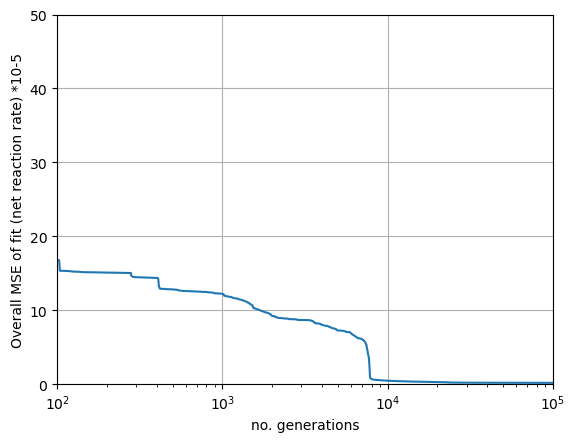

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.98247080315423
1.4371939765430024
0.7563900581240568
-4.305962784389449
0.500621949262499
0.003058067927669317
0.39878377818867333
-8.22602939345591
0.7399654913365277
7.420408084956794
5.881114993348726
5.869055786993716
0.8727918874444923
0.02303179368667902
3.132103340787746
1.4207906531006158e-07
0.0987763256482287
-11.853166110698268
1.8731293107889286
1.5702045186059856
-10.995413245189823
1.13311494573488
3.8237156941556436
0.029738030699634637
3.926895858007048
4.750194851657999
1.8989665066845913
10.362694005867818
-6.166441315101312
2.776927395964493
4.397108845976995
2.822703725275097
-3.8572771688592247
0.4826910965853045
1.0438426397540452
-1.3010299863364927


In [37]:
res.X

array([-1.09824708e+01,  1.43719398e+00,  7.56390058e-01, -4.30596278e+00,
        5.00621949e-01,  3.05806793e-03,  3.98783778e-01, -8.22602939e+00,
        7.39965491e-01,  7.42040808e+00,  5.88111499e+00,  5.86905579e+00,
        8.72791887e-01,  2.30317937e-02,  3.13210334e+00,  1.42079065e-07,
        9.87763256e-02, -1.18531661e+01,  1.87312931e+00,  1.57020452e+00,
       -1.09954132e+01,  1.13311495e+00,  3.82371569e+00,  2.97380307e-02,
        3.92689586e+00,  4.75019485e+00,  1.89896651e+00,  1.03626940e+01,
       -6.16644132e+00,  2.77692740e+00,  4.39710885e+00,  2.82270373e+00,
       -3.85727717e+00,  4.82691097e-01,  1.04384264e+00, -1.30102999e+00])

In [38]:
#Store to use in other notebook using the same current kernel
resX101=res.X
%store resX101

Stored 'resX101' (ndarray)


In [39]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [40]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.98247080315423
1.6: 1.4371939765430024
0.9: 0.7563900581240568
-4.3: -4.305962784389449
0.5: 0.500621949262499
0.003: 0.003058067927669317
0.4: 0.39878377818867333
-7.9: -8.22602939345591
0.7: 0.7399654913365277
7.2: 7.420408084956794
5.7: 5.881114993348726
5.7: 5.869055786993716
0.8: 0.8727918874444923
0.03: 0.02303179368667902
3.1: 3.132103340787746
6.000000000000001e-09: 1.4207906531006158e-07
0.1: 0.0987763256482287
-12.0: -11.853166110698268
1.9: 1.8731293107889286
1.6: 1.5702045186059856
-11.6: -10.995413245189823
1.2: 1.13311494573488
4.0: 3.8237156941556436
0.01: 0.029738030699634637
4.2: 3.926895858007048
5.4: 4.750194851657999
2.2: 1.8989665066845913
11.8: 10.362694005867818
-12.0: -6.166441315101312
3.3: 2.776927395964493
1.8: 4.397108845976995
4.2: 2.822703725275097
-4.0: -3.8572771688592247
0.5: 0.4826910965853045
1.0: 1.0438426397540452
coeff fit: 0.9545239190770558
r: 0.9769973997289122
